# Ashkan

In [1]:
!pip install transformers datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00


In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else ("cpu")

In [3]:
#setting the seed for all submodules of the final model to 42
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Downloading Data:

The validation split in the original dataset is for the final evaluation of our final models. Here we splitted the train set to validation and train and renamed the original validation set to test set.

In [4]:
from datasets import load_dataset
hpqa = load_dataset("hotpot_qa", "distractor")
hpqa_train_test = hpqa['train'].train_test_split(0.05) #we splitted the train set into train and validation set with proportions equal to 0.95 and 0.05
hpqa['train'] = hpqa_train_test['train']
hpqa['test'] = hpqa['validation']
hpqa['validation'] = hpqa_train_test['test']
hpqa

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 85924
    })
    validation: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 4523
    })
    test: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 7405
    })
})

Visualization of some important statistics in the training set:
- There are always two supporting docuemnts for each question.
- The distribution of number of supporting sentences to answer each question. The minimum is 2 and the maximum is 12
- The distribution of type of the reasoning required to answer questions.
- The distribution of difficulty level of answering questions.
- The distribution of number of documents provided to answer the question from. Most of the questions are provided with ten documents.

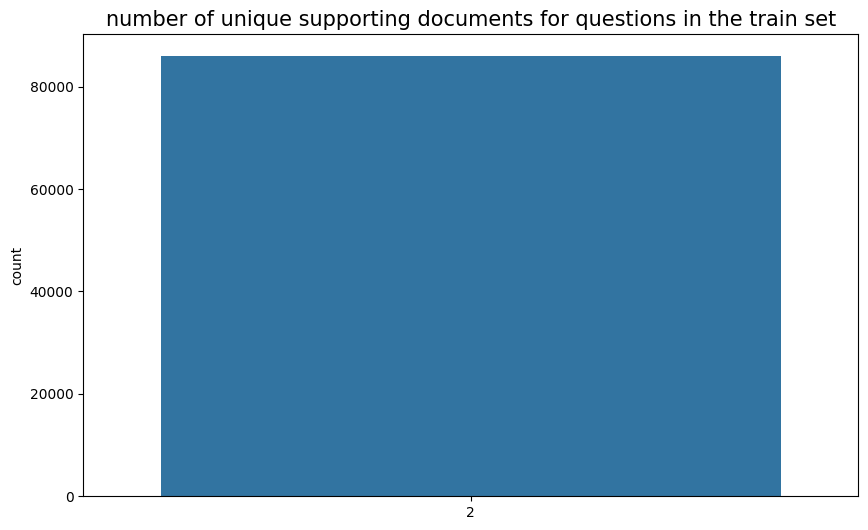

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
fig, axs = plt.subplots(1,1,figsize = (10,6))
sns.countplot(x = [len(np.unique(x['title'])) for x in hpqa['train']['supporting_facts']])
axs.set_title("number of unique supporting documents for questions in the train set", size = 15)
plt.show()


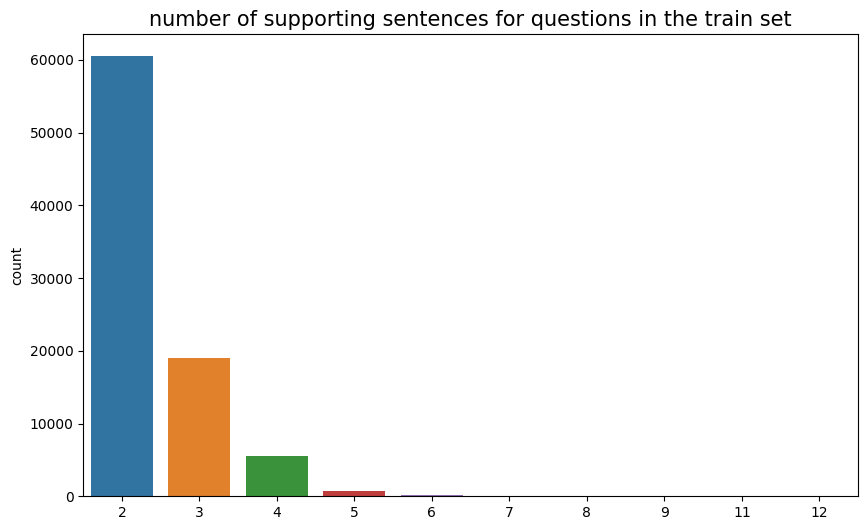

min number of supporting sentences:  2 
max number of supporting sentences:  12


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1,1,figsize = (10,6))
num_of_sup_sent = [len(x['sent_id']) for x in hpqa['train']['supporting_facts']]
sns.countplot(x = num_of_sup_sent)
axs.set_title("number of supporting sentences for questions in the train set", size = 15)
plt.show()
print("min number of supporting sentences: ", min(num_of_sup_sent), "\nmax number of supporting sentences: ", max(num_of_sup_sent))

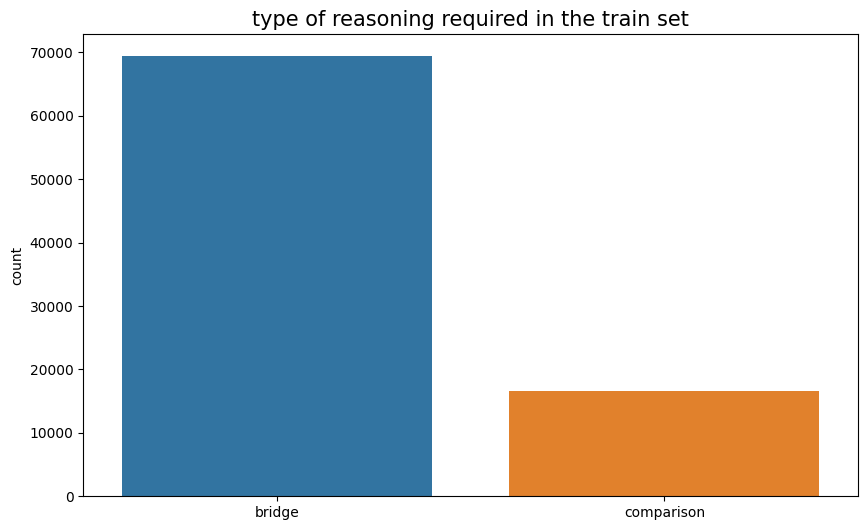

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1,1,figsize = (10,6))
sns.countplot(x = hpqa['train']['type'])
axs.set_title("type of reasoning required in the train set", size = 15)
plt.show()

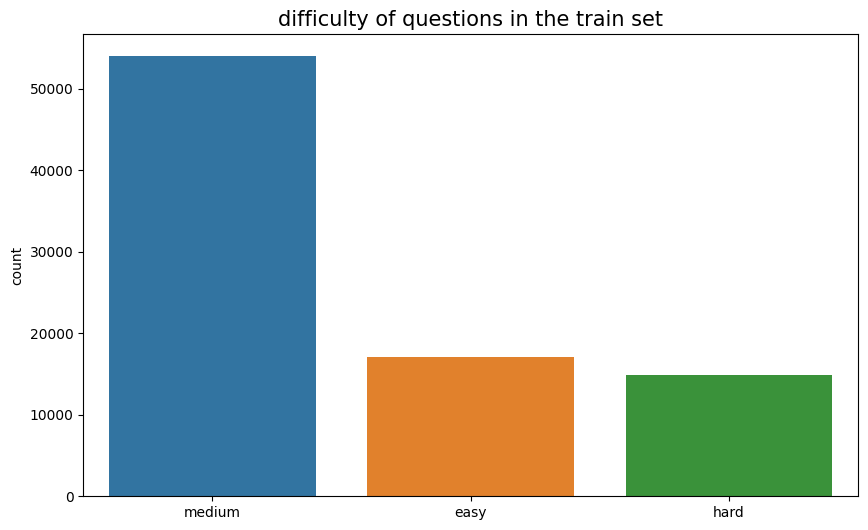

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1,1,figsize = (10,6))
sns.countplot(x = hpqa['train']['level'])
axs.set_title("difficulty of questions in the train set", size = 15)
plt.show()


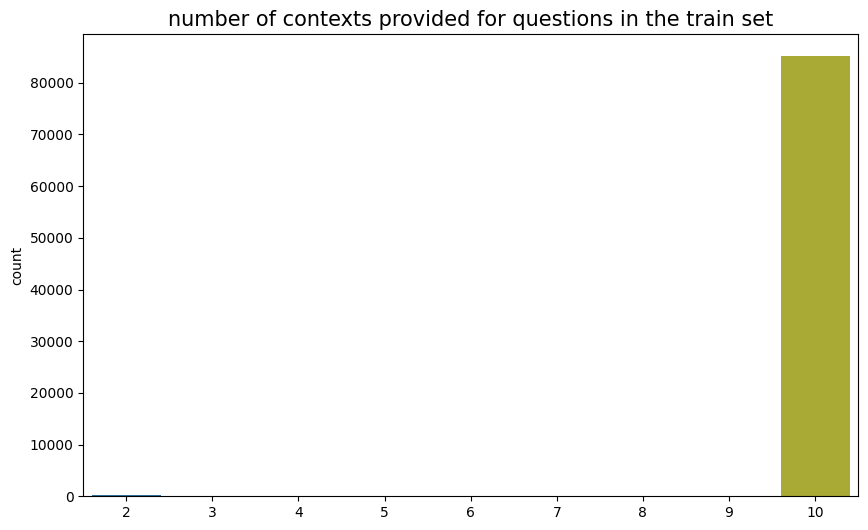

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1,1,figsize = (10,6))
sns.countplot(x = [len(x['sentences'])for x in hpqa['train']['context']])
axs.set_title("number of contexts provided for questions in the train set", size = 15)
plt.show()


# Retriever submodule on HotpotQA

## Import Tokenizer and Model:

In [10]:
# The number of irrelevant provided documents is on average 4 times the number
# of relevant provided documents for answering a question. To deal with this, we
# weight the labels with their population

positive_weight = 0.8
negative_weight = 0.2

We choose a pretrained `bert-small` to finetune the task on.

In [11]:
from transformers import AutoTokenizer
model_checkpoint = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [12]:
from transformers import AutoModelForSequenceClassification
retriever = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocessing Data:

The preprocessing function splits the data into question and document pairs. By doing so the model can learn if they are relevant or irrelevant.

In [13]:
def prepare_train_features(examples):
  final = {'input_ids':[], 'attention_mask':[], 'labels':[], 'token_type_ids':[]}
  for i in range(len(examples['id'])):
    for j in range(len(examples['context'][i]['sentences'])):
      tokenized = tokenizer(examples['question'][i], ''.join(examples['context'][i]['sentences'][j]), padding="max_length", max_length=512, truncation='only_second')
      if examples['context'][i]['title'][j] in examples['supporting_facts'][i]['title']:
        tokenized['labels'] = 1
      else:
        tokenized['labels'] = 0
      for key in tokenized.keys():
        final[key].append(tokenized[key])
  return final

In [14]:
par_class_dataset = hpqa.map(prepare_train_features, batched= True,remove_columns=hpqa["train"].column_names)
par_class_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"],
)

Map:   0%|          | 0/85924 [00:00<?, ? examples/s]

Map:   0%|          | 0/4523 [00:00<?, ? examples/s]

Map:   0%|          | 0/7405 [00:00<?, ? examples/s]

## Train:

We trained the model with floating point 16 precision to be able to fit the training on GPU. The batchsize for training is 64. We trained the model for 3 epochs.

In [15]:
!pip install accelerate>=0.20.1

In [16]:
from transformers import Trainer, TrainingArguments
import numpy as np
training_args = TrainingArguments(
    fp16 = True,
    num_train_epochs = 1,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size=128,
    evaluation_strategy = 'steps',
    # logging_steps = 4000,
    # save_steps = 8000,
    output_dir='../save',
    load_best_model_at_end = True
)

We modify the trainer to implement our custom weighted loss function:

In [17]:
import torch
from torch import nn
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs = False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([negative_weight,positive_weight]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [18]:
from datasets import load_metric
metric = load_metric('accuracy')
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = 1)
  return metric.compute(predictions= predictions, references = labels)

<ipython-input-18-873c049532c6>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


In [19]:
trainer = CustomTrainer(
    model=retriever,
    args=training_args,
    train_dataset=par_class_dataset['train'],
    eval_dataset = par_class_dataset['validation'],
    compute_metrics = compute_metrics
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=13354, training_loss=0.4299391934627792, metrics={'train_runtime': 1385.7696, 'train_samples_per_second': 616.734, 'train_steps_per_second': 9.637, 'total_flos': 1085823019223040.0, 'train_loss': 0.4299391934627792, 'epoch': 1.0})

## Post Processing:

PostProcessing part is to convert the output of the model to a well-formated Dataset to pass it to the next module.

In [20]:
from transformers import AutoModelForSequenceClassification
retriever.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

The script for post processing the output of our model. For each sample in the original dataset (each question), we predict it's relevant doucment.
In the final post processed output at each row we have a question from the test dataset, the predicted relevant documents and the correspondant sentences inside them.

In [21]:
import pandas as pd
from datasets import Dataset
from tqdm import tqdm
output_test = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'context']), preserve_index=False)
with torch.no_grad():
  retriever.to(device)
  for i in tqdm(range(len(hpqa['test']))):
    row = {}
    batch = Dataset.from_dict(prepare_train_features(hpqa['test'][i:i+1]))
    batch.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
    title = []
    sentences = []
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
    preds = torch.argmax(retriever(input_ids = input_ids, attention_mask = attention_mask, labels = labels, token_type_ids = token_type_ids).logits, axis = 1)
    for j , pred in enumerate(preds):
      if pred == 1:
        title.append(hpqa['test'][i]['context']['title'][j])
        sentences.append(hpqa['test'][i]['context']['sentences'][j])
    row['id'] = hpqa['test'][i]['id']
    row['question'] = hpqa['test'][i]['question']
    row['context'] = {'title':title, 'sentences': sentences}
    output_test = output_test.add_item(row)

100%|██████████| 7405/7405 [18:28<00:00,  6.68it/s]


In [22]:
import pandas as pd
from datasets import Dataset
from tqdm import tqdm
output_val = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'context']), preserve_index=False)
with torch.no_grad():
  retriever.to(device)
  for i in tqdm(range(len(hpqa['validation']))):
    row = {}
    batch = Dataset.from_dict(prepare_train_features(hpqa['validation'][i:i+1]))
    batch.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
    title = []
    sentences = []
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
    preds = torch.argmax(retriever(input_ids = input_ids, attention_mask = attention_mask, labels = labels, token_type_ids = token_type_ids).logits, axis = 1)
    for j , pred in enumerate(preds):
      if pred == 1:
        title.append(hpqa['validation'][i]['context']['title'][j])
        sentences.append(hpqa['validation'][i]['context']['sentences'][j])
    row['id'] = hpqa['validation'][i]['id']
    row['question'] = hpqa['validation'][i]['question']
    row['context'] = {'title':title, 'sentences': sentences}
    output_val = output_val.add_item(row)

100%|██████████| 4523/4523 [07:31<00:00, 10.01it/s]


In [23]:
from datasets import DatasetDict
retriever_output = DatasetDict()
retriever_output['validation'] = output_val
retriever_output['test'] = output_test

In [24]:
retriever_output

DatasetDict({
    validation: Dataset({
        features: ['id', 'question', 'context'],
        num_rows: 4523
    })
    test: Dataset({
        features: ['id', 'question', 'context'],
        num_rows: 7405
    })
})

## Evaluation:

Examples of comparison between what the model predicts as relevant documents vs the gold relevant documents

In [25]:
from pprint import pprint
for i in range(10):
  print("\n \n prediction: ")
  pprint(retriever_output['test'][i])

  print("\n \ngold:")
  pprint(hpqa['test'][i])


 
 prediction: 
{'context': {'sentences': [['Ed Wood is a 1994 American biographical period '
                            'comedy-drama film directed and produced by Tim '
                            'Burton, and starring Johnny Depp as cult '
                            'filmmaker Ed Wood.',
                            " The film concerns the period in Wood's life when "
                            'he made his best-known films as well as his '
                            'relationship with actor Bela Lugosi, played by '
                            'Martin Landau.',
                            ' Sarah Jessica Parker, Patricia Arquette, Jeffrey '
                            'Jones, Lisa Marie, and Bill Murray are among the '
                            'supporting cast.'],
                           ['Scott Derrickson (born July 16, 1966) is an '
                            'American director, screenwriter and producer.',
                            ' He lives in Los Angeles, Californ

To evaluate F1 and Exact Match scores we compare the post processed output of the model for the validation set and compare it to the groundtruth.

#### Test:

To evaluate F1 and Exact Match scores we compare the post processed output of the model for the test set and compare it to the groundtruth.

In [26]:
from datasets import load_metric
from tqdm import tqdm
f1 = load_metric("f1")
f1_scores = []
em_scores = []
for i in tqdm(range(len(hpqa['test']))):
  gold = hpqa['test'][i]['supporting_facts']['title']
  pred = retriever_output['test'][i]['context']['title']
  gold_classes = [1 if (x in gold) else 0 for x in hpqa['test'][i]['context']['title']]
  pred_classes = [1 if (x in pred) else 0 for x in hpqa['test'][i]['context']['title']]
  em_scores.append(gold_classes == pred_classes)
  f1_scores.append(f1.compute(predictions = pred_classes, references = gold_classes)['f1'])

100%|██████████| 7405/7405 [00:57<00:00, 129.89it/s]


In [27]:
print(f"f1_score: {np.round(np.mean(f1_scores),4)}")
print(f"exact_match_score: {np.round(np.mean(em_scores),4)}")

f1_score: 0.6757
exact_match_score: 0.2184


In [28]:
f1_scores_bridge = np.array(f1_scores)[np.array(hpqa['test']['type']) == 'bridge']
em_scores_bridge = np.array(em_scores)[np.array(hpqa['test']['type']) == 'bridge']
f1_scores_comparison = np.array(f1_scores)[np.array(hpqa['test']['type']) == 'comparison']
em_scores_comparison = np.array(em_scores)[np.array(hpqa['test']['type']) == 'comparison']
print(f"F1/EM score on questions of type bridge: {np.round(np.mean(f1_scores_bridge),4)}/{np.round(np.mean(em_scores_bridge),4)} ")
print(f"F1/EM score on questions of type comparison: {np.round(np.mean(f1_scores_comparison),4)}/{np.round(np.mean(em_scores_comparison),4)}")

F1/EM score on questions of type bridge: 0.6348/0.156 
F1/EM score on questions of type comparison: 0.8384/0.4667


# Extractor

In [29]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()

# This function get the label for each query/sentence pair and saves them in a list
def get_info(samples):
  labels_list, query_len_list, fact_len_list = [], [], []
  for examples in samples:
      query = examples['question']
      contexts = examples['context']
      facts = examples['supporting_facts']

      # initializing a dict to save titles with corresponding supporting facts
      labels = {value:list() for value in contexts['title']}
      for t, title in enumerate(facts['title']):
          labels[title].append(facts['sent_id'][t])

      for t, title in enumerate(contexts['title']):
        # we only consider the gold paragraphs
        if title in facts['title']:
          for s, sentence in enumerate(contexts['sentences'][t]):
            if s in labels[title]:
              labels_list.append(1)
            else:
              labels_list.append(0)
            query_len_list.append(len(query.split(' ')))
            fact_len_list.append(len(sentence.split(' ')))
  return labels_list, query_len_list, fact_len_list

In [30]:
labels_list, query_list, facts_list = {}, {}, {}
for _type in ['train', 'validation', 'test']:
  labels_dist_list, query_len_list, fact_len_list = get_info(hpqa[_type])

  percentage = np.sum(np.array(labels_dist_list))/len(labels_dist_list)

  labels_list[_type] = {'0':1-percentage,
                        '1':percentage,}

  query_list[_type] = query_len_list
  facts_list[_type] = fact_len_list

In [31]:
pd.DataFrame(labels_list).T.head()

0         1
train       0.630973  0.369027
validation  0.631610  0.368390
test        0.624823  0.375177

As we can see the distribution of the true labels against the whole sample (in the train/validation/test sets) is equal to around $\%63$. We will use this value to weight our preditions for fair metric computation and reaching best results.

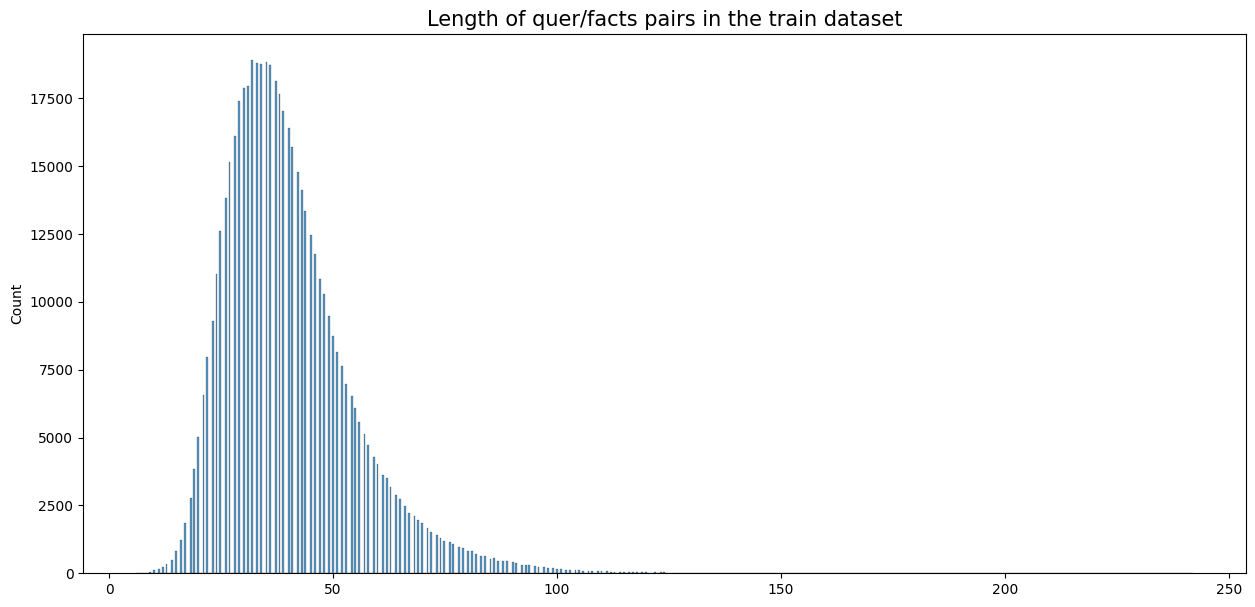

In [32]:
plt.figure(figsize = (15,7))
sns.histplot(np.array(query_list['train'])+np.array(facts_list['train']))
plt.title('Length of quer/facts pairs in the train dataset', size = 15)
plt.show()

Based on the upper histogram, it seem choosing 100 would be a good threshold that if we dont want to truncate sentences too much. In our work we applied 64 and 128 and since the results didn't change significantly, we set the final threshold to 64 for computational reasons.

## Preprocessing

In [33]:
from transformers import AutoTokenizer
# model_checkpoint = "prajjwal1/bert-tiny"
# model_checkpoint = "prajjwal1/bert-mini"
model_checkpoint = 'prajjwal1/bert-small'
# model_checkpoint = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [34]:
def preprocess_dataset(examples):
    final = {'input_ids': [], 'attention_mask': [], 'labels': [], 'token_type_ids': []}

    for i in range(len(examples['id'])):
        query = examples['question'][i]
        contexts = examples['context'][i]
        facts = examples['supporting_facts'][i]

        # initializing a dict to save titles with corresponding supporting facts
        labels = {value:list() for value in contexts['title']}
        for t, title in enumerate(facts['title']):
            labels[title].append(facts['sent_id'][t])

        # Generating samples in proper format
        for t, title in enumerate(contexts['title']):
          if title in facts['title']:
            for s, sentence in enumerate(contexts['sentences'][t]):
              # tokenizing query concatenated with sentences
              tokenized = tokenizer(query, sentence, padding="max_length", max_length=64, truncation=True)
              # Set the senetnce label to 1 if it's in facts O.W set to 0
              tokenized['labels'] = 1 if s in labels[title] else 0

              for key in tokenized.keys():
                  final[key].append(tokenized[key])
    return final

In [35]:
# We apply this transformation to the whole dataset
sent_class_dataset = hpqa.map(preprocess_dataset, batched= True, remove_columns=hpqa["train"].column_names)

Map:   0%|          | 0/85924 [00:00<?, ? examples/s]

Map:   0%|          | 0/4523 [00:00<?, ? examples/s]

Map:   0%|          | 0/7405 [00:00<?, ? examples/s]

In [36]:
sent_class_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"],
)

In [37]:
sent_class_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'token_type_ids'],
        num_rows: 555257
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'token_type_ids'],
        num_rows: 29200
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'token_type_ids'],
        num_rows: 47988
    })
})

Now we have around 500k samples in training set

## Train

In [38]:
from transformers import AutoModelForSequenceClassification

extractor = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
import torch
from torch import nn
from transformers import Trainer, TrainingArguments

# The following weights are chosen based on the distribution of 0/1 in train set
negative_weight,positive_weight = 0.35, 0.65

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs = False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([negative_weight,positive_weight]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [40]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.9 MB/s eta 0:00:00


In [41]:
from evaluate import load

f1_metric = load("f1")
acc_metric = load('accuracy')

# metric = load("exact_match")
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = 1)

  f1_score = f1_metric.compute(predictions=predictions, references=labels)
  accuracy = acc_metric.compute(predictions=predictions, references=labels)

  return {'F1_Score':f1_score,
          'Accuracy':accuracy}

In [42]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    fp16 = True,
    num_train_epochs = 1,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    evaluation_strategy = 'steps',
    output_dir = './save',
    # logging_steps = 5000,
    # save_steps = 5000,
    # push_to_hub = True,
    load_best_model_at_end = True
)

In [43]:
trainer = CustomTrainer(
    model = extractor,
    args = training_args,
    train_dataset = sent_class_dataset['train'],
    eval_dataset = sent_class_dataset['validation'],
    compute_metrics = compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Trainer is attempting to log a value of "{'f1': 0.7808124106960604}" of type <class 'dict'> for key "eval/F1_Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8161301369863013}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7903289734443124}" of type <class 'dict'> for key "eval/F1_Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8369520547945205}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8003596352271267}" of type <class 'dic

TrainOutput(global_step=17352, training_loss=0.33350694514793866, metrics={'train_runtime': 1245.6813, 'train_samples_per_second': 445.746, 'train_steps_per_second': 13.93, 'total_flos': 2745028988234496.0, 'train_loss': 0.33350694514793866, 'epoch': 1.0})

## Evaluation:

### Preparations

Generating the gold files for evaluation process in desired format

In [44]:
from tqdm import tqdm

def prepare_gold_file(_dataset):
  gold_file = []

  for row in tqdm(_dataset):
    id = row["id"]
    answer = row["answer"]
    supporting_facts = row["supporting_facts"]
    sp = [[title, sent_id] for title, sent_id
          in zip(supporting_facts["title"], supporting_facts["sent_id"])]

    gold_file.append({"_id": id,
                      "answer": answer,
                      "supporting_facts": sp})

  return gold_file

val_gold_file = prepare_gold_file(hpqa['validation'])
test_gold_file = prepare_gold_file(hpqa['test'])

100%|██████████| 7405/7405 [00:01<00:00, 4544.84it/s]


Defining the evaluation function

In [45]:
def update_sp(metrics, prediction, gold):
    cur_sp_pred = set(map(tuple, prediction))
    gold_sp_pred = set(map(tuple, gold))
    tp, fp, fn = 0, 0, 0
    for e in cur_sp_pred:
        if e in gold_sp_pred:
            tp += 1
        else:
            fp += 1
    for e in gold_sp_pred:
        if e not in cur_sp_pred:
            fn += 1
    prec = 1.0 * tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = 1.0 * tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * prec * recall / (prec + recall) if prec + recall > 0 else 0.0
    em = 1.0 if fp + fn == 0 else 0.0
    metrics['sp_em'].append(em)
    metrics['sp_f1'].append(f1)
    metrics['sp_prec'].append(prec)
    metrics['sp_recall'].append(recall)
    return em, prec, recall


def eval(prediction, gold):

    metrics_list = {'sp_em': [], 'sp_f1': [], 'sp_prec': [], 'sp_recall': [],}
    for dp in gold:
        cur_id = dp['_id']

        sp_em, sp_prec, sp_recall = update_sp(
            metrics_list, prediction['sp'][cur_id], dp['supporting_facts'])

    N = len(gold)
    metrics_value = {'sp_em': 0, 'sp_f1': 0, 'sp_prec': 0, 'sp_recall': 0,}
    for k in metrics_list.keys():
        metrics_value[k] = np.mean(metrics_list[k])

    return metrics_value, metrics_list

### Evaluate on HPQA test and validation

In [46]:
from tqdm import tqdm
from datasets import Dataset

import pandas as pd
from datasets import Dataset

# del output
val_output = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'facts']), preserve_index=False)

extractor.eval()
with torch.no_grad():
  extractor.to(device)
  # for examples in tqdm(hpqa['validation']):
  for examples in tqdm(hpqa['validation']):
      final = {'input_ids': [],
              'attention_mask': [],
              'labels': [],
              'token_type_ids': []}

      query = examples['question']
      contexts = examples['context']
      facts = examples['supporting_facts']

      if len(contexts['title'])==0:
        row['id'] = examples['id']
        row['question'] = query
        row['facts'] = []

        output = output.add_item(row)
        continue

      row = {}
      context_sentences, sp_sentences = [], []
      # Generating samples in proper format
      for t, title in enumerate(contexts['title']):
        if title in facts['title']:
          for s, sentence in enumerate(contexts['sentences'][t]):
            context_sentences.append(sentence)
            tokenized = tokenizer(query, sentence, padding="max_length", max_length=64, truncation=True)
            tokenized['labels'] = 0

            for key in tokenized.keys():
                final[key].append(tokenized[key])

      x = Dataset.from_dict(final)
      x.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
      predictions, labels, _ = trainer.predict(x)

      cnt = 0
      sp_idx = np.nonzero(np.argmax(predictions, axis=1))[0].tolist()
      for i in sp_idx:
        sp_sentences.append(context_sentences[i])

      row['id'] = examples['id']
      row['question'] = query
      row['facts'] = sp_sentences

      val_output = val_output.add_item(row)

  0%|          | 0/4523 [00:00<?, ?it/s]

  0%|          | 3/4523 [00:00<03:27, 21.76it/s]

  0%|          | 6/4523 [00:00<03:31, 21.36it/s]

  0%|          | 9/4523 [00:00<03:36, 20.87it/s]

  0%|          | 12/4523 [00:00<03:36, 20.79it/s]

  0%|          | 15/4523 [00:00<03:39, 20.56it/s]

  0%|          | 18/4523 [00:00<03:30, 21.39it/s]

  0%|          | 21/4523 [00:00<03:26, 21.84it/s]

  1%|          | 24/4523 [00:01<03:24, 22.03it/s]

  1%|          | 27/4523 [00:01<03:22, 22.23it/s]

  1%|          | 30/4523 [00:01<03:17, 22.73it/s]

  1%|          | 33/4523 [00:01<03:33, 21.04it/s]

  1%|          | 36/4523 [00:01<03:50, 19.45it/s]

  1%|          | 38/4523 [00:01<03:55, 19.04it/s]

  1%|          | 40/4523 [00:01<04:04, 18.34it/s]

  1%|          | 42/4523 [00:02<04:06, 18.17it/s]

  1%|          | 44/4523 [00:02<04:17, 17.41it/s]

  1%|          | 46/4523 [00:02<04:20, 17.18it/s]

  1%|          | 48/4523 [00:02<04:14, 17.58it/s]

  1%|          | 50/4523 [00:02<04:13, 17.66it/s]

  1%|          | 52/4523 [00:02<04:16, 17.45it/s]

  1%|          | 54/4523 [00:02<04:30, 16.51it/s]

  1%|          | 56/4523 [00:02<04:30, 16.50it/s]

  1%|▏         | 58/4523 [00:03<04:29, 16.58it/s]

  1%|▏         | 60/4523 [00:03<04:30, 16.52it/s]

  1%|▏         | 62/4523 [00:03<04:23, 16.92it/s]

  1%|▏         | 64/4523 [00:03<04:16, 17.38it/s]

  1%|▏         | 66/4523 [00:03<04:07, 18.03it/s]

  2%|▏         | 68/4523 [00:03<04:05, 18.18it/s]

  2%|▏         | 70/4523 [00:03<04:06, 18.09it/s]

  2%|▏         | 72/4523 [00:03<04:21, 17.02it/s]

  2%|▏         | 74/4523 [00:03<04:18, 17.19it/s]

  2%|▏         | 76/4523 [00:04<04:23, 16.89it/s]

  2%|▏         | 78/4523 [00:04<04:32, 16.32it/s]

  2%|▏         | 80/4523 [00:04<04:36, 16.10it/s]

  2%|▏         | 82/4523 [00:04<04:35, 16.11it/s]

  2%|▏         | 84/4523 [00:04<04:30, 16.41it/s]

  2%|▏         | 86/4523 [00:04<04:29, 16.49it/s]

  2%|▏         | 88/4523 [00:04<04:29, 16.44it/s]

  2%|▏         | 90/4523 [00:04<04:42, 15.70it/s]

  2%|▏         | 92/4523 [00:05<04:47, 15.43it/s]

  2%|▏         | 94/4523 [00:05<04:39, 15.87it/s]

  2%|▏         | 96/4523 [00:05<04:38, 15.88it/s]

  2%|▏         | 98/4523 [00:05<04:36, 15.98it/s]

  2%|▏         | 100/4523 [00:05<04:41, 15.73it/s]

  2%|▏         | 102/4523 [00:05<04:48, 15.33it/s]

  2%|▏         | 104/4523 [00:05<04:37, 15.95it/s]

  2%|▏         | 106/4523 [00:05<04:37, 15.90it/s]

  2%|▏         | 108/4523 [00:06<04:40, 15.77it/s]

  2%|▏         | 110/4523 [00:06<04:43, 15.58it/s]

  2%|▏         | 112/4523 [00:06<04:53, 15.03it/s]

  3%|▎         | 114/4523 [00:06<04:57, 14.83it/s]

  3%|▎         | 116/4523 [00:06<04:50, 15.16it/s]

  3%|▎         | 118/4523 [00:06<04:49, 15.22it/s]

  3%|▎         | 120/4523 [00:06<04:35, 15.98it/s]

  3%|▎         | 122/4523 [00:06<04:35, 15.96it/s]

  3%|▎         | 124/4523 [00:07<04:35, 15.96it/s]

  3%|▎         | 126/4523 [00:07<04:23, 16.67it/s]

  3%|▎         | 129/4523 [00:07<03:56, 18.58it/s]

  3%|▎         | 132/4523 [00:07<03:39, 20.02it/s]

  3%|▎         | 135/4523 [00:07<03:31, 20.77it/s]

  3%|▎         | 138/4523 [00:07<03:27, 21.11it/s]

  3%|▎         | 141/4523 [00:07<03:23, 21.54it/s]

  3%|▎         | 144/4523 [00:08<03:26, 21.23it/s]

  3%|▎         | 147/4523 [00:08<03:25, 21.32it/s]

  3%|▎         | 150/4523 [00:08<03:24, 21.39it/s]

  3%|▎         | 153/4523 [00:08<03:25, 21.28it/s]

  3%|▎         | 156/4523 [00:08<03:24, 21.40it/s]

  4%|▎         | 159/4523 [00:08<03:25, 21.23it/s]

  4%|▎         | 162/4523 [00:08<03:24, 21.38it/s]

  4%|▎         | 165/4523 [00:09<03:28, 20.94it/s]

  4%|▎         | 168/4523 [00:09<03:28, 20.87it/s]

  4%|▍         | 171/4523 [00:09<03:24, 21.31it/s]

  4%|▍         | 174/4523 [00:09<03:24, 21.26it/s]

  4%|▍         | 177/4523 [00:09<03:26, 21.01it/s]

  4%|▍         | 180/4523 [00:09<03:28, 20.81it/s]

  4%|▍         | 183/4523 [00:09<03:24, 21.20it/s]

  4%|▍         | 186/4523 [00:10<03:27, 20.93it/s]

  4%|▍         | 189/4523 [00:10<03:27, 20.86it/s]

  4%|▍         | 192/4523 [00:10<03:25, 21.10it/s]

  4%|▍         | 195/4523 [00:10<03:25, 21.04it/s]

  4%|▍         | 198/4523 [00:10<03:24, 21.15it/s]

  4%|▍         | 201/4523 [00:10<03:26, 20.97it/s]

  5%|▍         | 204/4523 [00:10<03:27, 20.81it/s]

  5%|▍         | 207/4523 [00:11<03:24, 21.16it/s]

  5%|▍         | 210/4523 [00:11<03:30, 20.53it/s]

  5%|▍         | 213/4523 [00:11<03:26, 20.86it/s]

  5%|▍         | 216/4523 [00:11<03:29, 20.57it/s]

  5%|▍         | 219/4523 [00:11<03:27, 20.76it/s]

  5%|▍         | 222/4523 [00:11<03:27, 20.73it/s]

  5%|▍         | 225/4523 [00:11<03:28, 20.59it/s]

  5%|▌         | 228/4523 [00:12<03:27, 20.66it/s]

  5%|▌         | 231/4523 [00:12<03:36, 19.85it/s]

  5%|▌         | 233/4523 [00:12<03:36, 19.81it/s]

  5%|▌         | 235/4523 [00:12<03:37, 19.74it/s]

  5%|▌         | 238/4523 [00:12<03:33, 20.09it/s]

  5%|▌         | 241/4523 [00:12<03:33, 20.05it/s]

  5%|▌         | 244/4523 [00:12<03:29, 20.45it/s]

  5%|▌         | 247/4523 [00:12<03:22, 21.07it/s]

  6%|▌         | 250/4523 [00:13<03:31, 20.19it/s]

  6%|▌         | 253/4523 [00:13<03:30, 20.24it/s]

  6%|▌         | 256/4523 [00:13<03:33, 20.03it/s]

  6%|▌         | 259/4523 [00:13<03:34, 19.84it/s]

  6%|▌         | 262/4523 [00:13<03:31, 20.10it/s]

  6%|▌         | 265/4523 [00:13<03:30, 20.28it/s]

  6%|▌         | 268/4523 [00:14<03:31, 20.07it/s]

  6%|▌         | 271/4523 [00:14<03:41, 19.21it/s]

  6%|▌         | 273/4523 [00:14<03:41, 19.14it/s]

  6%|▌         | 275/4523 [00:14<03:40, 19.28it/s]

  6%|▌         | 277/4523 [00:14<03:44, 18.95it/s]

  6%|▌         | 279/4523 [00:14<03:43, 18.98it/s]

  6%|▌         | 281/4523 [00:14<03:45, 18.78it/s]

  6%|▋         | 284/4523 [00:14<03:38, 19.36it/s]

  6%|▋         | 286/4523 [00:15<03:40, 19.21it/s]

  6%|▋         | 288/4523 [00:15<03:41, 19.13it/s]

  6%|▋         | 290/4523 [00:15<03:51, 18.28it/s]

  6%|▋         | 293/4523 [00:15<03:41, 19.11it/s]

  7%|▋         | 295/4523 [00:15<03:41, 19.09it/s]

  7%|▋         | 297/4523 [00:15<03:39, 19.27it/s]

  7%|▋         | 299/4523 [00:15<03:39, 19.21it/s]

  7%|▋         | 301/4523 [00:15<03:42, 18.96it/s]

  7%|▋         | 303/4523 [00:15<03:40, 19.12it/s]

  7%|▋         | 305/4523 [00:16<03:40, 19.17it/s]

  7%|▋         | 307/4523 [00:16<03:38, 19.27it/s]

  7%|▋         | 309/4523 [00:16<03:38, 19.30it/s]

  7%|▋         | 311/4523 [00:16<03:43, 18.84it/s]

  7%|▋         | 313/4523 [00:16<03:45, 18.70it/s]

  7%|▋         | 315/4523 [00:16<03:40, 19.05it/s]

  7%|▋         | 317/4523 [00:16<03:42, 18.91it/s]

  7%|▋         | 319/4523 [00:16<03:44, 18.74it/s]

  7%|▋         | 322/4523 [00:16<03:33, 19.69it/s]

  7%|▋         | 324/4523 [00:16<03:32, 19.76it/s]

  7%|▋         | 326/4523 [00:17<03:34, 19.56it/s]

  7%|▋         | 328/4523 [00:17<03:46, 18.54it/s]

  7%|▋         | 330/4523 [00:17<04:08, 16.84it/s]

  7%|▋         | 332/4523 [00:17<04:09, 16.78it/s]

  7%|▋         | 334/4523 [00:17<04:21, 16.03it/s]

  7%|▋         | 336/4523 [00:17<04:30, 15.49it/s]

  7%|▋         | 338/4523 [00:17<04:31, 15.42it/s]

  8%|▊         | 340/4523 [00:18<04:31, 15.38it/s]

  8%|▊         | 342/4523 [00:18<04:37, 15.07it/s]

  8%|▊         | 344/4523 [00:18<04:44, 14.68it/s]

  8%|▊         | 346/4523 [00:18<04:46, 14.56it/s]

  8%|▊         | 348/4523 [00:18<04:36, 15.08it/s]

  8%|▊         | 350/4523 [00:18<04:25, 15.72it/s]

  8%|▊         | 352/4523 [00:18<04:29, 15.50it/s]

  8%|▊         | 354/4523 [00:18<04:25, 15.70it/s]

  8%|▊         | 356/4523 [00:19<04:32, 15.28it/s]

  8%|▊         | 358/4523 [00:19<04:27, 15.55it/s]

  8%|▊         | 360/4523 [00:19<04:22, 15.89it/s]

  8%|▊         | 362/4523 [00:19<04:37, 14.99it/s]

  8%|▊         | 364/4523 [00:19<04:28, 15.49it/s]

  8%|▊         | 366/4523 [00:19<04:37, 14.98it/s]

  8%|▊         | 368/4523 [00:19<04:35, 15.07it/s]

  8%|▊         | 370/4523 [00:19<04:35, 15.07it/s]

  8%|▊         | 372/4523 [00:20<04:29, 15.38it/s]

  8%|▊         | 374/4523 [00:20<04:29, 15.39it/s]

  8%|▊         | 376/4523 [00:20<04:45, 14.55it/s]

  8%|▊         | 378/4523 [00:20<04:53, 14.13it/s]

  8%|▊         | 380/4523 [00:20<04:51, 14.22it/s]

  8%|▊         | 382/4523 [00:20<04:45, 14.49it/s]

  8%|▊         | 384/4523 [00:20<04:54, 14.06it/s]

  9%|▊         | 386/4523 [00:21<04:53, 14.08it/s]

  9%|▊         | 388/4523 [00:21<04:56, 13.94it/s]

  9%|▊         | 390/4523 [00:21<05:12, 13.21it/s]

  9%|▊         | 392/4523 [00:21<05:18, 12.96it/s]

  9%|▊         | 394/4523 [00:21<05:13, 13.16it/s]

  9%|▉         | 396/4523 [00:21<04:59, 13.80it/s]

  9%|▉         | 398/4523 [00:22<04:53, 14.04it/s]

  9%|▉         | 400/4523 [00:22<05:07, 13.41it/s]

  9%|▉         | 402/4523 [00:22<05:01, 13.66it/s]

  9%|▉         | 404/4523 [00:22<05:05, 13.50it/s]

  9%|▉         | 406/4523 [00:22<05:11, 13.21it/s]

  9%|▉         | 408/4523 [00:22<05:03, 13.54it/s]

  9%|▉         | 410/4523 [00:22<05:04, 13.49it/s]

  9%|▉         | 412/4523 [00:23<05:05, 13.48it/s]

  9%|▉         | 414/4523 [00:23<04:58, 13.77it/s]

  9%|▉         | 416/4523 [00:23<04:55, 13.91it/s]

  9%|▉         | 418/4523 [00:23<04:49, 14.19it/s]

  9%|▉         | 420/4523 [00:23<05:06, 13.37it/s]

  9%|▉         | 422/4523 [00:23<05:10, 13.22it/s]

  9%|▉         | 424/4523 [00:23<04:56, 13.84it/s]

  9%|▉         | 426/4523 [00:24<04:51, 14.03it/s]

  9%|▉         | 428/4523 [00:24<04:54, 13.92it/s]

 10%|▉         | 430/4523 [00:24<04:43, 14.46it/s]

 10%|▉         | 432/4523 [00:24<04:24, 15.49it/s]

 10%|▉         | 434/4523 [00:24<08:44,  7.80it/s]

 10%|▉         | 436/4523 [00:25<07:13,  9.44it/s]

 10%|▉         | 438/4523 [00:25<06:10, 11.03it/s]

 10%|▉         | 440/4523 [00:25<05:24, 12.58it/s]

 10%|▉         | 442/4523 [00:25<04:59, 13.65it/s]

 10%|▉         | 444/4523 [00:25<04:34, 14.87it/s]

 10%|▉         | 446/4523 [00:25<04:32, 14.95it/s]

 10%|▉         | 448/4523 [00:25<04:22, 15.51it/s]

 10%|▉         | 450/4523 [00:25<04:10, 16.27it/s]

 10%|▉         | 452/4523 [00:26<04:06, 16.54it/s]

 10%|█         | 454/4523 [00:26<04:01, 16.83it/s]

 10%|█         | 456/4523 [00:26<04:07, 16.44it/s]

 10%|█         | 458/4523 [00:26<04:05, 16.53it/s]

 10%|█         | 460/4523 [00:26<04:10, 16.22it/s]

 10%|█         | 462/4523 [00:26<04:05, 16.57it/s]

 10%|█         | 464/4523 [00:26<04:11, 16.14it/s]

 10%|█         | 466/4523 [00:26<04:02, 16.74it/s]

 10%|█         | 468/4523 [00:26<03:55, 17.24it/s]

 10%|█         | 470/4523 [00:27<03:50, 17.62it/s]

 10%|█         | 472/4523 [00:27<03:55, 17.20it/s]

 10%|█         | 474/4523 [00:27<03:55, 17.22it/s]

 11%|█         | 476/4523 [00:27<03:58, 16.98it/s]

 11%|█         | 478/4523 [00:27<03:55, 17.16it/s]

 11%|█         | 480/4523 [00:27<03:52, 17.40it/s]

 11%|█         | 482/4523 [00:27<03:55, 17.19it/s]

 11%|█         | 484/4523 [00:27<03:52, 17.39it/s]

 11%|█         | 486/4523 [00:28<03:52, 17.37it/s]

 11%|█         | 488/4523 [00:28<03:49, 17.59it/s]

 11%|█         | 490/4523 [00:28<03:51, 17.43it/s]

 11%|█         | 492/4523 [00:28<03:55, 17.13it/s]

 11%|█         | 494/4523 [00:28<03:54, 17.16it/s]

 11%|█         | 496/4523 [00:28<03:53, 17.28it/s]

 11%|█         | 498/4523 [00:28<03:51, 17.37it/s]

 11%|█         | 500/4523 [00:28<04:01, 16.64it/s]

 11%|█         | 502/4523 [00:28<03:59, 16.78it/s]

 11%|█         | 504/4523 [00:29<04:00, 16.69it/s]

 11%|█         | 506/4523 [00:29<04:00, 16.73it/s]

 11%|█         | 508/4523 [00:29<04:00, 16.67it/s]

 11%|█▏        | 510/4523 [00:29<03:54, 17.10it/s]

 11%|█▏        | 512/4523 [00:29<03:58, 16.79it/s]

 11%|█▏        | 514/4523 [00:29<03:58, 16.80it/s]

 11%|█▏        | 516/4523 [00:29<03:54, 17.07it/s]

 11%|█▏        | 518/4523 [00:29<03:59, 16.74it/s]

 11%|█▏        | 520/4523 [00:30<03:53, 17.14it/s]

 12%|█▏        | 522/4523 [00:30<03:52, 17.23it/s]

 12%|█▏        | 524/4523 [00:30<03:55, 16.98it/s]

 12%|█▏        | 526/4523 [00:30<03:49, 17.44it/s]

 12%|█▏        | 528/4523 [00:30<03:54, 17.07it/s]

 12%|█▏        | 530/4523 [00:30<03:52, 17.20it/s]

 12%|█▏        | 532/4523 [00:30<03:55, 16.97it/s]

 12%|█▏        | 534/4523 [00:30<03:56, 16.89it/s]

 12%|█▏        | 536/4523 [00:30<03:57, 16.81it/s]

 12%|█▏        | 538/4523 [00:31<03:59, 16.64it/s]

 12%|█▏        | 540/4523 [00:31<04:01, 16.49it/s]

 12%|█▏        | 542/4523 [00:31<03:59, 16.59it/s]

 12%|█▏        | 544/4523 [00:31<03:59, 16.62it/s]

 12%|█▏        | 546/4523 [00:31<03:53, 17.06it/s]

 12%|█▏        | 548/4523 [00:31<03:53, 17.05it/s]

 12%|█▏        | 550/4523 [00:31<03:52, 17.10it/s]

 12%|█▏        | 552/4523 [00:31<03:57, 16.72it/s]

 12%|█▏        | 554/4523 [00:32<04:02, 16.37it/s]

 12%|█▏        | 556/4523 [00:32<04:00, 16.49it/s]

 12%|█▏        | 558/4523 [00:32<04:03, 16.31it/s]

 12%|█▏        | 560/4523 [00:32<04:00, 16.45it/s]

 12%|█▏        | 562/4523 [00:32<04:02, 16.36it/s]

 12%|█▏        | 564/4523 [00:32<03:59, 16.56it/s]

 13%|█▎        | 566/4523 [00:32<03:53, 16.93it/s]

 13%|█▎        | 568/4523 [00:32<03:53, 16.96it/s]

 13%|█▎        | 570/4523 [00:33<03:59, 16.53it/s]

 13%|█▎        | 572/4523 [00:33<03:59, 16.49it/s]

 13%|█▎        | 574/4523 [00:33<03:56, 16.68it/s]

 13%|█▎        | 576/4523 [00:33<03:59, 16.51it/s]

 13%|█▎        | 578/4523 [00:33<04:01, 16.33it/s]

 13%|█▎        | 580/4523 [00:33<03:56, 16.70it/s]

 13%|█▎        | 582/4523 [00:33<04:01, 16.31it/s]

 13%|█▎        | 584/4523 [00:33<03:56, 16.67it/s]

 13%|█▎        | 586/4523 [00:33<03:56, 16.66it/s]

 13%|█▎        | 588/4523 [00:34<03:56, 16.65it/s]

 13%|█▎        | 590/4523 [00:34<04:00, 16.32it/s]

 13%|█▎        | 592/4523 [00:34<04:12, 15.58it/s]

 13%|█▎        | 594/4523 [00:34<04:20, 15.07it/s]

 13%|█▎        | 596/4523 [00:34<04:23, 14.91it/s]

 13%|█▎        | 598/4523 [00:34<04:28, 14.61it/s]

 13%|█▎        | 600/4523 [00:34<04:42, 13.88it/s]

 13%|█▎        | 602/4523 [00:35<04:45, 13.73it/s]

 13%|█▎        | 604/4523 [00:35<04:54, 13.29it/s]

 13%|█▎        | 606/4523 [00:35<05:14, 12.46it/s]

 13%|█▎        | 608/4523 [00:35<05:18, 12.28it/s]

 13%|█▎        | 610/4523 [00:35<05:05, 12.82it/s]

 14%|█▎        | 612/4523 [00:35<05:01, 12.96it/s]

 14%|█▎        | 614/4523 [00:36<04:57, 13.13it/s]

 14%|█▎        | 616/4523 [00:36<05:06, 12.73it/s]

 14%|█▎        | 618/4523 [00:36<05:03, 12.88it/s]

 14%|█▎        | 620/4523 [00:36<04:56, 13.14it/s]

 14%|█▍        | 622/4523 [00:36<04:54, 13.23it/s]

 14%|█▍        | 624/4523 [00:36<04:46, 13.61it/s]

 14%|█▍        | 626/4523 [00:36<04:40, 13.87it/s]

 14%|█▍        | 628/4523 [00:37<04:32, 14.29it/s]

 14%|█▍        | 630/4523 [00:37<04:31, 14.32it/s]

 14%|█▍        | 632/4523 [00:37<04:30, 14.39it/s]

 14%|█▍        | 634/4523 [00:37<04:23, 14.75it/s]

 14%|█▍        | 636/4523 [00:37<04:36, 14.07it/s]

 14%|█▍        | 638/4523 [00:37<04:51, 13.32it/s]

 14%|█▍        | 640/4523 [00:38<10:38,  6.08it/s]

 14%|█▍        | 642/4523 [00:38<09:03,  7.14it/s]

 14%|█▍        | 644/4523 [00:38<07:49,  8.26it/s]

 14%|█▍        | 646/4523 [00:39<06:52,  9.40it/s]

 14%|█▍        | 648/4523 [00:39<06:42,  9.63it/s]

 14%|█▍        | 650/4523 [00:39<06:25, 10.04it/s]

 14%|█▍        | 652/4523 [00:39<06:03, 10.66it/s]

 14%|█▍        | 654/4523 [00:39<05:50, 11.05it/s]

 15%|█▍        | 656/4523 [00:39<05:44, 11.24it/s]

 15%|█▍        | 658/4523 [00:40<05:36, 11.49it/s]

 15%|█▍        | 660/4523 [00:40<05:45, 11.19it/s]

 15%|█▍        | 662/4523 [00:40<05:40, 11.33it/s]

 15%|█▍        | 664/4523 [00:40<05:35, 11.51it/s]

 15%|█▍        | 666/4523 [00:40<05:37, 11.44it/s]

 15%|█▍        | 668/4523 [00:40<05:30, 11.65it/s]

 15%|█▍        | 670/4523 [00:41<05:39, 11.34it/s]

 15%|█▍        | 672/4523 [00:41<05:38, 11.39it/s]

 15%|█▍        | 674/4523 [00:41<05:53, 10.88it/s]

 15%|█▍        | 676/4523 [00:41<05:55, 10.84it/s]

 15%|█▍        | 678/4523 [00:41<05:47, 11.05it/s]

 15%|█▌        | 680/4523 [00:42<05:45, 11.11it/s]

 15%|█▌        | 682/4523 [00:42<05:28, 11.71it/s]

 15%|█▌        | 684/4523 [00:42<05:01, 12.75it/s]

 15%|█▌        | 686/4523 [00:42<04:42, 13.57it/s]

 15%|█▌        | 688/4523 [00:42<04:35, 13.92it/s]

 15%|█▌        | 690/4523 [00:42<04:33, 14.01it/s]

 15%|█▌        | 692/4523 [00:42<04:22, 14.58it/s]

 15%|█▌        | 694/4523 [00:42<04:18, 14.82it/s]

 15%|█▌        | 696/4523 [00:43<04:16, 14.94it/s]

 15%|█▌        | 698/4523 [00:43<04:11, 15.23it/s]

 15%|█▌        | 700/4523 [00:43<04:09, 15.31it/s]

 16%|█▌        | 702/4523 [00:43<04:11, 15.17it/s]

 16%|█▌        | 704/4523 [00:43<04:11, 15.17it/s]

 16%|█▌        | 706/4523 [00:43<04:11, 15.19it/s]

 16%|█▌        | 708/4523 [00:43<04:06, 15.45it/s]

 16%|█▌        | 710/4523 [00:43<04:05, 15.55it/s]

 16%|█▌        | 712/4523 [00:44<04:05, 15.50it/s]

 16%|█▌        | 714/4523 [00:44<04:03, 15.65it/s]

 16%|█▌        | 716/4523 [00:44<04:04, 15.55it/s]

 16%|█▌        | 718/4523 [00:44<04:07, 15.39it/s]

 16%|█▌        | 720/4523 [00:44<04:11, 15.12it/s]

 16%|█▌        | 722/4523 [00:44<04:13, 14.97it/s]

 16%|█▌        | 724/4523 [00:44<04:13, 14.96it/s]

 16%|█▌        | 726/4523 [00:45<04:08, 15.29it/s]

 16%|█▌        | 728/4523 [00:45<04:16, 14.81it/s]

 16%|█▌        | 730/4523 [00:45<04:23, 14.39it/s]

 16%|█▌        | 732/4523 [00:45<04:18, 14.68it/s]

 16%|█▌        | 734/4523 [00:45<04:13, 14.92it/s]

 16%|█▋        | 736/4523 [00:45<04:17, 14.69it/s]

 16%|█▋        | 738/4523 [00:45<04:14, 14.90it/s]

 16%|█▋        | 740/4523 [00:45<04:12, 14.99it/s]

 16%|█▋        | 742/4523 [00:46<04:12, 14.95it/s]

 16%|█▋        | 744/4523 [00:46<04:12, 14.99it/s]

 16%|█▋        | 746/4523 [00:46<04:10, 15.07it/s]

 17%|█▋        | 748/4523 [00:46<04:13, 14.88it/s]

 17%|█▋        | 750/4523 [00:46<04:18, 14.62it/s]

 17%|█▋        | 752/4523 [00:46<04:19, 14.52it/s]

 17%|█▋        | 754/4523 [00:46<04:16, 14.69it/s]

 17%|█▋        | 756/4523 [00:47<04:10, 15.05it/s]

 17%|█▋        | 758/4523 [00:47<04:07, 15.19it/s]

 17%|█▋        | 760/4523 [00:47<04:12, 14.88it/s]

 17%|█▋        | 762/4523 [00:47<08:09,  7.68it/s]

 17%|█▋        | 764/4523 [00:48<06:55,  9.05it/s]

 17%|█▋        | 766/4523 [00:48<06:04, 10.31it/s]

 17%|█▋        | 768/4523 [00:48<05:30, 11.38it/s]

 17%|█▋        | 770/4523 [00:48<04:59, 12.53it/s]

 17%|█▋        | 772/4523 [00:48<04:44, 13.18it/s]

 17%|█▋        | 774/4523 [00:48<04:32, 13.76it/s]

 17%|█▋        | 776/4523 [00:48<04:32, 13.73it/s]

 17%|█▋        | 778/4523 [00:48<04:24, 14.17it/s]

 17%|█▋        | 780/4523 [00:49<04:18, 14.46it/s]

 17%|█▋        | 782/4523 [00:49<04:10, 14.93it/s]

 17%|█▋        | 784/4523 [00:49<04:09, 14.96it/s]

 17%|█▋        | 786/4523 [00:49<04:08, 15.04it/s]

 17%|█▋        | 788/4523 [00:49<04:12, 14.78it/s]

 17%|█▋        | 790/4523 [00:49<04:12, 14.79it/s]

 18%|█▊        | 792/4523 [00:49<04:13, 14.71it/s]

 18%|█▊        | 794/4523 [00:50<04:11, 14.83it/s]

 18%|█▊        | 796/4523 [00:50<04:10, 14.88it/s]

 18%|█▊        | 798/4523 [00:50<04:10, 14.85it/s]

 18%|█▊        | 800/4523 [00:50<04:13, 14.71it/s]

 18%|█▊        | 802/4523 [00:50<04:15, 14.54it/s]

 18%|█▊        | 804/4523 [00:50<04:13, 14.66it/s]

 18%|█▊        | 806/4523 [00:50<04:11, 14.81it/s]

 18%|█▊        | 808/4523 [00:50<04:16, 14.51it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 18%|█▊        | 810/4523 [00:51<04:21, 14.22it/s]

 18%|█▊        | 812/4523 [00:51<04:20, 14.23it/s]

 18%|█▊        | 814/4523 [00:51<04:18, 14.33it/s]

 18%|█▊        | 816/4523 [00:51<04:16, 14.45it/s]

 18%|█▊        | 818/4523 [00:51<04:19, 14.28it/s]

 18%|█▊        | 820/4523 [00:51<04:19, 14.30it/s]

 18%|█▊        | 822/4523 [00:51<04:25, 13.95it/s]

 18%|█▊        | 824/4523 [00:52<04:16, 14.43it/s]

 18%|█▊        | 826/4523 [00:52<04:25, 13.94it/s]

 18%|█▊        | 828/4523 [00:52<04:27, 13.81it/s]

 18%|█▊        | 830/4523 [00:52<04:49, 12.75it/s]

 18%|█▊        | 832/4523 [00:52<05:10, 11.87it/s]

 18%|█▊        | 834/4523 [00:52<05:09, 11.92it/s]

 18%|█▊        | 836/4523 [00:53<04:56, 12.45it/s]

 19%|█▊        | 838/4523 [00:53<05:00, 12.27it/s]

 19%|█▊        | 840/4523 [00:53<05:13, 11.76it/s]

 19%|█▊        | 842/4523 [00:53<05:06, 12.00it/s]

 19%|█▊        | 844/4523 [00:53<05:03, 12.13it/s]

 19%|█▊        | 846/4523 [00:53<05:20, 11.48it/s]

 19%|█▊        | 848/4523 [00:54<05:18, 11.55it/s]

 19%|█▉        | 850/4523 [00:54<05:29, 11.13it/s]

 19%|█▉        | 852/4523 [00:54<05:19, 11.47it/s]

 19%|█▉        | 854/4523 [00:54<05:07, 11.93it/s]

 19%|█▉        | 856/4523 [00:54<05:03, 12.10it/s]

 19%|█▉        | 858/4523 [00:54<05:08, 11.88it/s]

 19%|█▉        | 860/4523 [00:55<05:06, 11.95it/s]

 19%|█▉        | 862/4523 [00:55<10:33,  5.78it/s]

 19%|█▉        | 864/4523 [00:56<09:05,  6.71it/s]

 19%|█▉        | 866/4523 [00:56<08:01,  7.60it/s]

 19%|█▉        | 868/4523 [00:56<07:15,  8.39it/s]

 19%|█▉        | 870/4523 [00:56<06:37,  9.18it/s]

 19%|█▉        | 872/4523 [00:56<06:19,  9.61it/s]

 19%|█▉        | 874/4523 [00:56<06:08,  9.90it/s]

 19%|█▉        | 876/4523 [00:57<05:57, 10.21it/s]

 19%|█▉        | 878/4523 [00:57<05:46, 10.51it/s]

 19%|█▉        | 880/4523 [00:57<05:43, 10.60it/s]

 20%|█▉        | 882/4523 [00:57<05:31, 10.97it/s]

 20%|█▉        | 884/4523 [00:57<05:35, 10.86it/s]

 20%|█▉        | 886/4523 [00:58<05:39, 10.71it/s]

 20%|█▉        | 888/4523 [00:58<05:49, 10.39it/s]

 20%|█▉        | 890/4523 [00:58<05:45, 10.53it/s]

 20%|█▉        | 892/4523 [00:58<05:46, 10.47it/s]

 20%|█▉        | 894/4523 [00:58<05:42, 10.61it/s]

 20%|█▉        | 896/4523 [00:59<05:34, 10.83it/s]

 20%|█▉        | 898/4523 [00:59<05:32, 10.90it/s]

 20%|█▉        | 900/4523 [00:59<05:40, 10.65it/s]

 20%|█▉        | 902/4523 [00:59<05:45, 10.47it/s]

 20%|█▉        | 904/4523 [00:59<05:38, 10.69it/s]

 20%|██        | 906/4523 [00:59<05:39, 10.65it/s]

 20%|██        | 908/4523 [01:00<05:36, 10.74it/s]

 20%|██        | 910/4523 [01:00<05:42, 10.54it/s]

 20%|██        | 912/4523 [01:00<05:35, 10.78it/s]

 20%|██        | 914/4523 [01:00<05:29, 10.95it/s]

 20%|██        | 916/4523 [01:00<05:27, 11.01it/s]

 20%|██        | 918/4523 [01:01<05:41, 10.54it/s]

 20%|██        | 920/4523 [01:01<06:00, 10.01it/s]

 20%|██        | 922/4523 [01:01<05:34, 10.78it/s]

 20%|██        | 924/4523 [01:01<05:13, 11.48it/s]

 20%|██        | 926/4523 [01:01<04:55, 12.18it/s]

 21%|██        | 928/4523 [01:01<04:46, 12.56it/s]

 21%|██        | 930/4523 [01:02<04:33, 13.13it/s]

 21%|██        | 932/4523 [01:02<04:35, 13.01it/s]

 21%|██        | 934/4523 [01:02<04:33, 13.13it/s]

 21%|██        | 936/4523 [01:02<04:34, 13.06it/s]

 21%|██        | 938/4523 [01:02<04:27, 13.42it/s]

 21%|██        | 940/4523 [01:02<04:19, 13.82it/s]

 21%|██        | 942/4523 [01:02<04:17, 13.92it/s]

 21%|██        | 944/4523 [01:03<04:17, 13.90it/s]

 21%|██        | 946/4523 [01:03<04:21, 13.67it/s]

 21%|██        | 948/4523 [01:03<04:19, 13.75it/s]

 21%|██        | 950/4523 [01:03<04:26, 13.43it/s]

 21%|██        | 952/4523 [01:04<08:11,  7.27it/s]

 21%|██        | 954/4523 [01:04<07:01,  8.47it/s]

 21%|██        | 956/4523 [01:04<06:12,  9.59it/s]

 21%|██        | 958/4523 [01:04<05:40, 10.48it/s]

 21%|██        | 960/4523 [01:04<05:17, 11.22it/s]

 21%|██▏       | 962/4523 [01:04<04:58, 11.93it/s]

 21%|██▏       | 964/4523 [01:04<04:41, 12.62it/s]

 21%|██▏       | 966/4523 [01:05<04:35, 12.91it/s]

 21%|██▏       | 968/4523 [01:05<04:35, 12.89it/s]

 21%|██▏       | 970/4523 [01:05<04:30, 13.14it/s]

 21%|██▏       | 972/4523 [01:05<04:31, 13.08it/s]

 22%|██▏       | 974/4523 [01:05<04:33, 12.98it/s]

 22%|██▏       | 976/4523 [01:05<04:42, 12.56it/s]

 22%|██▏       | 978/4523 [01:06<04:29, 13.14it/s]

 22%|██▏       | 980/4523 [01:06<04:28, 13.17it/s]

 22%|██▏       | 982/4523 [01:06<04:28, 13.19it/s]

 22%|██▏       | 984/4523 [01:06<04:29, 13.11it/s]

 22%|██▏       | 986/4523 [01:06<04:24, 13.35it/s]

 22%|██▏       | 988/4523 [01:06<04:25, 13.34it/s]

 22%|██▏       | 990/4523 [01:06<04:18, 13.65it/s]

 22%|██▏       | 992/4523 [01:07<04:24, 13.36it/s]

 22%|██▏       | 994/4523 [01:07<04:21, 13.49it/s]

 22%|██▏       | 996/4523 [01:07<04:23, 13.39it/s]

 22%|██▏       | 998/4523 [01:07<04:21, 13.48it/s]

 22%|██▏       | 1000/4523 [01:07<04:17, 13.67it/s]

 22%|██▏       | 1002/4523 [01:07<04:26, 13.21it/s]

 22%|██▏       | 1004/4523 [01:07<04:29, 13.07it/s]

 22%|██▏       | 1006/4523 [01:08<04:25, 13.23it/s]

 22%|██▏       | 1008/4523 [01:08<04:27, 13.16it/s]

 22%|██▏       | 1010/4523 [01:08<04:26, 13.19it/s]

 22%|██▏       | 1012/4523 [01:08<04:22, 13.38it/s]

 22%|██▏       | 1014/4523 [01:08<04:26, 13.15it/s]

 22%|██▏       | 1016/4523 [01:08<04:23, 13.32it/s]

 23%|██▎       | 1018/4523 [01:09<04:23, 13.31it/s]

 23%|██▎       | 1020/4523 [01:09<04:20, 13.45it/s]

 23%|██▎       | 1022/4523 [01:09<04:20, 13.43it/s]

 23%|██▎       | 1024/4523 [01:09<04:28, 13.01it/s]

 23%|██▎       | 1026/4523 [01:10<08:11,  7.11it/s]

 23%|██▎       | 1028/4523 [01:10<06:57,  8.37it/s]

 23%|██▎       | 1030/4523 [01:10<06:09,  9.46it/s]

 23%|██▎       | 1032/4523 [01:10<05:38, 10.31it/s]

 23%|██▎       | 1034/4523 [01:10<05:09, 11.26it/s]

 23%|██▎       | 1036/4523 [01:10<04:55, 11.80it/s]

 23%|██▎       | 1038/4523 [01:10<04:46, 12.15it/s]

 23%|██▎       | 1040/4523 [01:11<04:36, 12.59it/s]

 23%|██▎       | 1042/4523 [01:11<04:34, 12.66it/s]

 23%|██▎       | 1044/4523 [01:11<04:48, 12.06it/s]

 23%|██▎       | 1046/4523 [01:11<04:50, 11.97it/s]

 23%|██▎       | 1048/4523 [01:11<04:46, 12.13it/s]

 23%|██▎       | 1050/4523 [01:11<04:51, 11.90it/s]

 23%|██▎       | 1052/4523 [01:12<04:43, 12.26it/s]

 23%|██▎       | 1054/4523 [01:12<04:57, 11.66it/s]

 23%|██▎       | 1056/4523 [01:12<05:12, 11.11it/s]

 23%|██▎       | 1058/4523 [01:12<05:20, 10.82it/s]

 23%|██▎       | 1060/4523 [01:12<05:39, 10.21it/s]

 23%|██▎       | 1062/4523 [01:13<05:47,  9.97it/s]

 24%|██▎       | 1064/4523 [01:13<05:34, 10.36it/s]

 24%|██▎       | 1066/4523 [01:13<05:19, 10.82it/s]

 24%|██▎       | 1068/4523 [01:13<05:11, 11.09it/s]

 24%|██▎       | 1070/4523 [01:13<05:17, 10.87it/s]

 24%|██▎       | 1072/4523 [01:13<05:25, 10.60it/s]

 24%|██▎       | 1074/4523 [01:14<05:24, 10.62it/s]

 24%|██▍       | 1076/4523 [01:14<05:27, 10.53it/s]

 24%|██▍       | 1078/4523 [01:14<05:25, 10.58it/s]

 24%|██▍       | 1080/4523 [01:14<05:42, 10.07it/s]

 24%|██▍       | 1082/4523 [01:14<05:40, 10.10it/s]

 24%|██▍       | 1084/4523 [01:15<05:39, 10.13it/s]

 24%|██▍       | 1086/4523 [01:15<05:25, 10.56it/s]

 24%|██▍       | 1088/4523 [01:15<05:28, 10.47it/s]

 24%|██▍       | 1090/4523 [01:15<05:27, 10.49it/s]

 24%|██▍       | 1092/4523 [01:15<05:40, 10.08it/s]

 24%|██▍       | 1094/4523 [01:16<11:48,  4.84it/s]

 24%|██▍       | 1095/4523 [01:16<10:46,  5.30it/s]

 24%|██▍       | 1096/4523 [01:17<09:52,  5.79it/s]

 24%|██▍       | 1097/4523 [01:17<09:05,  6.28it/s]

 24%|██▍       | 1099/4523 [01:17<07:42,  7.41it/s]

 24%|██▍       | 1101/4523 [01:17<06:55,  8.23it/s]

 24%|██▍       | 1103/4523 [01:17<06:28,  8.80it/s]

 24%|██▍       | 1105/4523 [01:17<06:09,  9.25it/s]

 24%|██▍       | 1106/4523 [01:18<06:07,  9.31it/s]

 24%|██▍       | 1107/4523 [01:18<06:04,  9.37it/s]

 24%|██▍       | 1108/4523 [01:18<06:01,  9.44it/s]

 25%|██▍       | 1109/4523 [01:18<05:59,  9.49it/s]

 25%|██▍       | 1111/4523 [01:18<05:49,  9.76it/s]

 25%|██▍       | 1112/4523 [01:18<05:52,  9.69it/s]

 25%|██▍       | 1113/4523 [01:18<05:50,  9.73it/s]

 25%|██▍       | 1114/4523 [01:18<05:57,  9.53it/s]

 25%|██▍       | 1115/4523 [01:19<06:00,  9.46it/s]

 25%|██▍       | 1117/4523 [01:19<05:55,  9.59it/s]

 25%|██▍       | 1118/4523 [01:19<05:53,  9.63it/s]

 25%|██▍       | 1119/4523 [01:19<05:51,  9.68it/s]

 25%|██▍       | 1120/4523 [01:19<06:06,  9.28it/s]

 25%|██▍       | 1121/4523 [01:19<06:14,  9.09it/s]

 25%|██▍       | 1123/4523 [01:19<05:37, 10.09it/s]

 25%|██▍       | 1125/4523 [01:19<05:08, 11.02it/s]

 25%|██▍       | 1127/4523 [01:20<04:57, 11.42it/s]

 25%|██▍       | 1129/4523 [01:20<04:53, 11.57it/s]

 25%|██▌       | 1131/4523 [01:20<04:59, 11.32it/s]

 25%|██▌       | 1133/4523 [01:20<04:54, 11.52it/s]

 25%|██▌       | 1135/4523 [01:20<04:45, 11.88it/s]

 25%|██▌       | 1137/4523 [01:20<04:42, 12.00it/s]

 25%|██▌       | 1139/4523 [01:21<04:37, 12.18it/s]

 25%|██▌       | 1141/4523 [01:21<04:37, 12.18it/s]

 25%|██▌       | 1143/4523 [01:21<04:46, 11.79it/s]

 25%|██▌       | 1145/4523 [01:21<04:48, 11.72it/s]

 25%|██▌       | 1147/4523 [01:21<04:40, 12.03it/s]

 25%|██▌       | 1149/4523 [01:21<04:36, 12.19it/s]

 25%|██▌       | 1151/4523 [01:22<04:35, 12.22it/s]

 25%|██▌       | 1153/4523 [01:22<04:30, 12.44it/s]

 26%|██▌       | 1155/4523 [01:22<04:26, 12.65it/s]

 26%|██▌       | 1157/4523 [01:23<09:08,  6.13it/s]

 26%|██▌       | 1159/4523 [01:23<07:41,  7.29it/s]

 26%|██▌       | 1161/4523 [01:23<06:47,  8.25it/s]

 26%|██▌       | 1163/4523 [01:23<06:10,  9.07it/s]

 26%|██▌       | 1165/4523 [01:23<05:43,  9.78it/s]

 26%|██▌       | 1167/4523 [01:23<05:19, 10.52it/s]

 26%|██▌       | 1169/4523 [01:24<05:03, 11.06it/s]

 26%|██▌       | 1171/4523 [01:24<04:50, 11.54it/s]

 26%|██▌       | 1173/4523 [01:24<04:40, 11.93it/s]

 26%|██▌       | 1175/4523 [01:24<04:35, 12.16it/s]

 26%|██▌       | 1177/4523 [01:24<04:45, 11.71it/s]

 26%|██▌       | 1179/4523 [01:24<04:34, 12.19it/s]

 26%|██▌       | 1181/4523 [01:25<04:27, 12.51it/s]

 26%|██▌       | 1183/4523 [01:25<04:31, 12.32it/s]

 26%|██▌       | 1185/4523 [01:25<04:28, 12.43it/s]

 26%|██▌       | 1187/4523 [01:25<04:26, 12.51it/s]

 26%|██▋       | 1189/4523 [01:25<04:35, 12.12it/s]

 26%|██▋       | 1191/4523 [01:25<04:34, 12.16it/s]

 26%|██▋       | 1193/4523 [01:26<04:27, 12.46it/s]

 26%|██▋       | 1195/4523 [01:26<04:26, 12.47it/s]

 26%|██▋       | 1197/4523 [01:26<04:26, 12.46it/s]

 27%|██▋       | 1199/4523 [01:26<04:28, 12.38it/s]

 27%|██▋       | 1201/4523 [01:26<04:34, 12.11it/s]

 27%|██▋       | 1203/4523 [01:26<04:38, 11.93it/s]

 27%|██▋       | 1205/4523 [01:27<04:32, 12.18it/s]

 27%|██▋       | 1207/4523 [01:27<04:32, 12.19it/s]

 27%|██▋       | 1209/4523 [01:27<04:35, 12.03it/s]

 27%|██▋       | 1211/4523 [01:27<04:27, 12.39it/s]

 27%|██▋       | 1213/4523 [01:27<04:29, 12.26it/s]

 27%|██▋       | 1215/4523 [01:28<07:54,  6.97it/s]

 27%|██▋       | 1217/4523 [01:28<06:47,  8.10it/s]

 27%|██▋       | 1219/4523 [01:28<05:59,  9.19it/s]

 27%|██▋       | 1221/4523 [01:28<05:35,  9.85it/s]

 27%|██▋       | 1223/4523 [01:28<05:26, 10.12it/s]

 27%|██▋       | 1225/4523 [01:29<05:05, 10.81it/s]

 27%|██▋       | 1227/4523 [01:29<04:58, 11.03it/s]

 27%|██▋       | 1229/4523 [01:29<04:50, 11.35it/s]

 27%|██▋       | 1231/4523 [01:29<04:37, 11.86it/s]

 27%|██▋       | 1233/4523 [01:29<04:49, 11.38it/s]

 27%|██▋       | 1235/4523 [01:29<05:07, 10.68it/s]

 27%|██▋       | 1237/4523 [01:30<05:05, 10.76it/s]

 27%|██▋       | 1239/4523 [01:30<05:06, 10.71it/s]

 27%|██▋       | 1241/4523 [01:30<05:03, 10.81it/s]

 27%|██▋       | 1243/4523 [01:30<05:13, 10.48it/s]

 28%|██▊       | 1245/4523 [01:30<05:12, 10.49it/s]

 28%|██▊       | 1247/4523 [01:31<05:14, 10.42it/s]

 28%|██▊       | 1249/4523 [01:31<05:02, 10.82it/s]

 28%|██▊       | 1251/4523 [01:31<04:44, 11.51it/s]

 28%|██▊       | 1253/4523 [01:31<04:37, 11.77it/s]

 28%|██▊       | 1255/4523 [01:31<04:33, 11.95it/s]

 28%|██▊       | 1257/4523 [01:31<04:26, 12.24it/s]

 28%|██▊       | 1259/4523 [01:32<04:43, 11.53it/s]

 28%|██▊       | 1261/4523 [01:32<04:39, 11.66it/s]

 28%|██▊       | 1263/4523 [01:32<04:34, 11.87it/s]

 28%|██▊       | 1265/4523 [01:32<04:30, 12.02it/s]

 28%|██▊       | 1267/4523 [01:32<04:39, 11.63it/s]

 28%|██▊       | 1269/4523 [01:32<04:35, 11.80it/s]

 28%|██▊       | 1271/4523 [01:33<09:20,  5.80it/s]

 28%|██▊       | 1272/4523 [01:33<08:41,  6.24it/s]

 28%|██▊       | 1273/4523 [01:33<08:05,  6.69it/s]

 28%|██▊       | 1275/4523 [01:34<07:03,  7.66it/s]

 28%|██▊       | 1277/4523 [01:34<06:49,  7.92it/s]

 28%|██▊       | 1278/4523 [01:34<06:42,  8.07it/s]

 28%|██▊       | 1279/4523 [01:34<06:26,  8.39it/s]

 28%|██▊       | 1280/4523 [01:34<06:20,  8.51it/s]

 28%|██▊       | 1282/4523 [01:34<06:13,  8.69it/s]

 28%|██▊       | 1283/4523 [01:35<06:16,  8.61it/s]

 28%|██▊       | 1284/4523 [01:35<06:08,  8.79it/s]

 28%|██▊       | 1285/4523 [01:35<05:58,  9.03it/s]

 28%|██▊       | 1286/4523 [01:35<06:01,  8.95it/s]

 28%|██▊       | 1287/4523 [01:35<06:06,  8.82it/s]

 28%|██▊       | 1288/4523 [01:35<05:57,  9.06it/s]

 28%|██▊       | 1289/4523 [01:35<05:52,  9.18it/s]

 29%|██▊       | 1290/4523 [01:35<05:45,  9.37it/s]

 29%|██▊       | 1291/4523 [01:35<05:49,  9.25it/s]

 29%|██▊       | 1292/4523 [01:36<05:58,  9.02it/s]

 29%|██▊       | 1293/4523 [01:36<06:04,  8.86it/s]

 29%|██▊       | 1294/4523 [01:36<05:57,  9.02it/s]

 29%|██▊       | 1295/4523 [01:36<06:06,  8.81it/s]

 29%|██▊       | 1296/4523 [01:36<05:58,  8.99it/s]

 29%|██▊       | 1297/4523 [01:36<05:59,  8.97it/s]

 29%|██▊       | 1298/4523 [01:36<06:07,  8.78it/s]

 29%|██▊       | 1300/4523 [01:36<05:42,  9.41it/s]

 29%|██▉       | 1301/4523 [01:36<05:42,  9.42it/s]

 29%|██▉       | 1302/4523 [01:37<05:54,  9.08it/s]

 29%|██▉       | 1303/4523 [01:37<06:02,  8.88it/s]

 29%|██▉       | 1304/4523 [01:37<05:55,  9.06it/s]

 29%|██▉       | 1305/4523 [01:37<05:47,  9.27it/s]

 29%|██▉       | 1307/4523 [01:37<05:36,  9.54it/s]

 29%|██▉       | 1308/4523 [01:37<05:35,  9.58it/s]

 29%|██▉       | 1309/4523 [01:37<05:39,  9.45it/s]

 29%|██▉       | 1310/4523 [01:37<05:43,  9.35it/s]

 29%|██▉       | 1311/4523 [01:38<05:55,  9.04it/s]

 29%|██▉       | 1312/4523 [01:38<05:48,  9.20it/s]

 29%|██▉       | 1313/4523 [01:38<05:50,  9.15it/s]

 29%|██▉       | 1314/4523 [01:38<06:03,  8.82it/s]

 29%|██▉       | 1315/4523 [01:38<06:05,  8.78it/s]

 29%|██▉       | 1317/4523 [01:38<05:43,  9.33it/s]

 29%|██▉       | 1318/4523 [01:39<12:31,  4.26it/s]

 29%|██▉       | 1320/4523 [01:39<09:22,  5.69it/s]

 29%|██▉       | 1322/4523 [01:39<07:25,  7.19it/s]

 29%|██▉       | 1324/4523 [01:39<06:15,  8.53it/s]

 29%|██▉       | 1326/4523 [01:40<05:35,  9.52it/s]

 29%|██▉       | 1328/4523 [01:40<05:09, 10.32it/s]

 29%|██▉       | 1330/4523 [01:40<05:00, 10.63it/s]

 29%|██▉       | 1332/4523 [01:40<04:42, 11.29it/s]

 29%|██▉       | 1334/4523 [01:40<04:38, 11.46it/s]

 30%|██▉       | 1336/4523 [01:40<04:37, 11.49it/s]

 30%|██▉       | 1338/4523 [01:41<04:34, 11.59it/s]

 30%|██▉       | 1340/4523 [01:41<04:30, 11.78it/s]

 30%|██▉       | 1342/4523 [01:41<04:23, 12.07it/s]

 30%|██▉       | 1344/4523 [01:41<04:27, 11.87it/s]

 30%|██▉       | 1346/4523 [01:41<04:36, 11.49it/s]

 30%|██▉       | 1348/4523 [01:41<04:32, 11.65it/s]

 30%|██▉       | 1350/4523 [01:42<04:31, 11.71it/s]

 30%|██▉       | 1352/4523 [01:42<04:29, 11.76it/s]

 30%|██▉       | 1354/4523 [01:42<04:31, 11.67it/s]

 30%|██▉       | 1356/4523 [01:42<04:36, 11.46it/s]

 30%|███       | 1358/4523 [01:42<04:40, 11.28it/s]

 30%|███       | 1360/4523 [01:42<04:48, 10.97it/s]

 30%|███       | 1362/4523 [01:43<04:40, 11.28it/s]

 30%|███       | 1364/4523 [01:43<04:39, 11.31it/s]

 30%|███       | 1366/4523 [01:43<04:41, 11.23it/s]

 30%|███       | 1368/4523 [01:43<04:40, 11.25it/s]

 30%|███       | 1370/4523 [01:43<04:48, 10.93it/s]

 30%|███       | 1372/4523 [01:43<04:46, 11.00it/s]

 30%|███       | 1374/4523 [01:44<04:41, 11.18it/s]

 30%|███       | 1376/4523 [01:44<08:53,  5.89it/s]

 30%|███       | 1378/4523 [01:45<07:34,  6.91it/s]

 31%|███       | 1380/4523 [01:45<06:38,  7.89it/s]

 31%|███       | 1382/4523 [01:45<05:58,  8.77it/s]

 31%|███       | 1384/4523 [01:45<05:28,  9.56it/s]

 31%|███       | 1386/4523 [01:45<05:06, 10.24it/s]

 31%|███       | 1388/4523 [01:45<04:49, 10.81it/s]

 31%|███       | 1390/4523 [01:46<04:37, 11.30it/s]

 31%|███       | 1392/4523 [01:46<04:30, 11.56it/s]

 31%|███       | 1394/4523 [01:46<04:27, 11.70it/s]

 31%|███       | 1396/4523 [01:46<04:25, 11.78it/s]

 31%|███       | 1398/4523 [01:46<04:18, 12.07it/s]

 31%|███       | 1400/4523 [01:46<04:17, 12.14it/s]

 31%|███       | 1402/4523 [01:47<04:27, 11.65it/s]

 31%|███       | 1404/4523 [01:47<04:23, 11.86it/s]

 31%|███       | 1406/4523 [01:47<04:19, 12.02it/s]

 31%|███       | 1408/4523 [01:47<04:19, 12.01it/s]

 31%|███       | 1410/4523 [01:47<04:17, 12.07it/s]

 31%|███       | 1412/4523 [01:47<04:11, 12.38it/s]

 31%|███▏      | 1414/4523 [01:48<04:18, 12.01it/s]

 31%|███▏      | 1416/4523 [01:48<04:18, 12.00it/s]

 31%|███▏      | 1418/4523 [01:48<04:17, 12.07it/s]

 31%|███▏      | 1420/4523 [01:49<08:50,  5.85it/s]

 31%|███▏      | 1421/4523 [01:49<08:12,  6.29it/s]

 31%|███▏      | 1423/4523 [01:49<07:16,  7.10it/s]

 32%|███▏      | 1425/4523 [01:49<06:21,  8.12it/s]

 32%|███▏      | 1427/4523 [01:49<05:49,  8.87it/s]

 32%|███▏      | 1429/4523 [01:49<05:18,  9.71it/s]

 32%|███▏      | 1431/4523 [01:50<04:53, 10.52it/s]

 32%|███▏      | 1433/4523 [01:50<04:51, 10.62it/s]

 32%|███▏      | 1435/4523 [01:50<04:37, 11.11it/s]

 32%|███▏      | 1437/4523 [01:50<04:37, 11.14it/s]

 32%|███▏      | 1439/4523 [01:50<04:35, 11.20it/s]

 32%|███▏      | 1441/4523 [01:50<04:30, 11.38it/s]

 32%|███▏      | 1443/4523 [01:51<04:25, 11.60it/s]

 32%|███▏      | 1445/4523 [01:51<04:44, 10.81it/s]

 32%|███▏      | 1447/4523 [01:51<04:46, 10.73it/s]

 32%|███▏      | 1449/4523 [01:51<04:45, 10.77it/s]

 32%|███▏      | 1451/4523 [01:51<04:34, 11.21it/s]

 32%|███▏      | 1453/4523 [01:52<04:25, 11.55it/s]

 32%|███▏      | 1455/4523 [01:52<04:19, 11.83it/s]

 32%|███▏      | 1457/4523 [01:52<04:27, 11.46it/s]

 32%|███▏      | 1459/4523 [01:52<04:22, 11.68it/s]

 32%|███▏      | 1461/4523 [01:53<09:02,  5.64it/s]

 32%|███▏      | 1462/4523 [01:53<08:25,  6.05it/s]

 32%|███▏      | 1463/4523 [01:53<07:50,  6.50it/s]

 32%|███▏      | 1464/4523 [01:53<07:14,  7.05it/s]

 32%|███▏      | 1465/4523 [01:53<07:07,  7.16it/s]

 32%|███▏      | 1466/4523 [01:53<06:46,  7.51it/s]

 32%|███▏      | 1467/4523 [01:54<06:34,  7.75it/s]

 32%|███▏      | 1468/4523 [01:54<06:16,  8.12it/s]

 32%|███▏      | 1469/4523 [01:54<06:11,  8.21it/s]

 33%|███▎      | 1470/4523 [01:54<06:03,  8.40it/s]

 33%|███▎      | 1471/4523 [01:54<06:07,  8.30it/s]

 33%|███▎      | 1472/4523 [01:54<06:02,  8.42it/s]

 33%|███▎      | 1473/4523 [01:54<06:03,  8.39it/s]

 33%|███▎      | 1474/4523 [01:54<06:01,  8.44it/s]

 33%|███▎      | 1475/4523 [01:54<05:54,  8.59it/s]

 33%|███▎      | 1476/4523 [01:55<05:41,  8.93it/s]

 33%|███▎      | 1477/4523 [01:55<05:37,  9.03it/s]

 33%|███▎      | 1478/4523 [01:55<05:46,  8.78it/s]

 33%|███▎      | 1479/4523 [01:55<05:46,  8.78it/s]

 33%|███▎      | 1480/4523 [01:55<05:46,  8.77it/s]

 33%|███▎      | 1481/4523 [01:55<05:49,  8.70it/s]

 33%|███▎      | 1482/4523 [01:55<05:45,  8.81it/s]

 33%|███▎      | 1483/4523 [01:55<05:52,  8.62it/s]

 33%|███▎      | 1484/4523 [01:55<05:45,  8.79it/s]

 33%|███▎      | 1485/4523 [01:56<05:34,  9.07it/s]

 33%|███▎      | 1486/4523 [01:56<05:34,  9.07it/s]

 33%|███▎      | 1487/4523 [01:56<05:37,  9.00it/s]

 33%|███▎      | 1488/4523 [01:56<05:34,  9.06it/s]

 33%|███▎      | 1489/4523 [01:56<05:39,  8.93it/s]

 33%|███▎      | 1490/4523 [01:56<05:38,  8.95it/s]

 33%|███▎      | 1491/4523 [01:56<05:36,  9.02it/s]

 33%|███▎      | 1492/4523 [01:56<05:41,  8.87it/s]

 33%|███▎      | 1493/4523 [01:56<05:30,  9.16it/s]

 33%|███▎      | 1494/4523 [01:57<05:46,  8.74it/s]

 33%|███▎      | 1495/4523 [01:57<05:39,  8.92it/s]

 33%|███▎      | 1496/4523 [01:57<05:43,  8.80it/s]

 33%|███▎      | 1497/4523 [01:57<05:41,  8.86it/s]

 33%|███▎      | 1498/4523 [01:57<05:38,  8.93it/s]

 33%|███▎      | 1499/4523 [01:57<05:42,  8.83it/s]

 33%|███▎      | 1500/4523 [01:57<05:51,  8.60it/s]

 33%|███▎      | 1501/4523 [01:57<05:47,  8.69it/s]

 33%|███▎      | 1502/4523 [01:57<05:39,  8.90it/s]

 33%|███▎      | 1503/4523 [01:58<16:42,  3.01it/s]

 33%|███▎      | 1504/4523 [01:58<13:23,  3.76it/s]

 33%|███▎      | 1505/4523 [01:59<11:01,  4.56it/s]

 33%|███▎      | 1507/4523 [01:59<08:07,  6.18it/s]

 33%|███▎      | 1509/4523 [01:59<06:46,  7.42it/s]

 33%|███▎      | 1511/4523 [01:59<06:09,  8.15it/s]

 33%|███▎      | 1513/4523 [01:59<05:35,  8.97it/s]

 33%|███▎      | 1514/4523 [01:59<05:33,  9.03it/s]

 34%|███▎      | 1516/4523 [02:00<05:08,  9.74it/s]

 34%|███▎      | 1518/4523 [02:00<04:53, 10.25it/s]

 34%|███▎      | 1520/4523 [02:00<04:42, 10.64it/s]

 34%|███▎      | 1522/4523 [02:00<04:43, 10.58it/s]

 34%|███▎      | 1524/4523 [02:00<04:42, 10.63it/s]

 34%|███▎      | 1526/4523 [02:01<04:50, 10.33it/s]

 34%|███▍      | 1528/4523 [02:01<04:48, 10.38it/s]

 34%|███▍      | 1530/4523 [02:01<04:50, 10.30it/s]

 34%|███▍      | 1532/4523 [02:01<04:41, 10.62it/s]

 34%|███▍      | 1534/4523 [02:01<04:33, 10.94it/s]

 34%|███▍      | 1536/4523 [02:01<04:29, 11.07it/s]

 34%|███▍      | 1538/4523 [02:02<04:28, 11.12it/s]

 34%|███▍      | 1540/4523 [02:02<04:29, 11.07it/s]

 34%|███▍      | 1542/4523 [02:02<04:22, 11.35it/s]

 34%|███▍      | 1544/4523 [02:03<08:29,  5.85it/s]

 34%|███▍      | 1546/4523 [02:03<07:08,  6.94it/s]

 34%|███▍      | 1548/4523 [02:03<06:15,  7.93it/s]

 34%|███▍      | 1550/4523 [02:03<05:35,  8.86it/s]

 34%|███▍      | 1552/4523 [02:03<05:11,  9.54it/s]

 34%|███▍      | 1554/4523 [02:04<04:54, 10.07it/s]

 34%|███▍      | 1556/4523 [02:04<04:53, 10.10it/s]

 34%|███▍      | 1558/4523 [02:04<04:42, 10.49it/s]

 34%|███▍      | 1560/4523 [02:04<04:37, 10.68it/s]

 35%|███▍      | 1562/4523 [02:04<04:34, 10.80it/s]

 35%|███▍      | 1564/4523 [02:04<04:32, 10.86it/s]

 35%|███▍      | 1566/4523 [02:05<04:40, 10.54it/s]

 35%|███▍      | 1568/4523 [02:05<04:39, 10.57it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 35%|███▍      | 1570/4523 [02:05<04:42, 10.45it/s]

 35%|███▍      | 1572/4523 [02:05<04:37, 10.64it/s]

 35%|███▍      | 1574/4523 [02:05<04:30, 10.92it/s]

 35%|███▍      | 1576/4523 [02:06<04:29, 10.93it/s]

 35%|███▍      | 1578/4523 [02:06<04:33, 10.79it/s]

 35%|███▍      | 1580/4523 [02:06<04:33, 10.74it/s]

 35%|███▍      | 1582/4523 [02:06<04:32, 10.80it/s]

 35%|███▌      | 1584/4523 [02:06<04:35, 10.65it/s]

 35%|███▌      | 1586/4523 [02:07<08:36,  5.68it/s]

 35%|███▌      | 1588/4523 [02:07<07:16,  6.72it/s]

 35%|███▌      | 1590/4523 [02:07<06:21,  7.69it/s]

 35%|███▌      | 1592/4523 [02:08<05:48,  8.41it/s]

 35%|███▌      | 1594/4523 [02:08<05:34,  8.76it/s]

 35%|███▌      | 1596/4523 [02:08<05:13,  9.35it/s]

 35%|███▌      | 1598/4523 [02:08<05:01,  9.71it/s]

 35%|███▌      | 1600/4523 [02:08<04:49, 10.11it/s]

 35%|███▌      | 1602/4523 [02:08<04:37, 10.52it/s]

 35%|███▌      | 1604/4523 [02:09<04:39, 10.45it/s]

 36%|███▌      | 1606/4523 [02:09<04:48, 10.09it/s]

 36%|███▌      | 1608/4523 [02:09<04:54,  9.91it/s]

 36%|███▌      | 1610/4523 [02:09<04:54,  9.89it/s]

 36%|███▌      | 1612/4523 [02:10<04:49, 10.04it/s]

 36%|███▌      | 1614/4523 [02:10<04:46, 10.16it/s]

 36%|███▌      | 1616/4523 [02:10<05:01,  9.63it/s]

 36%|███▌      | 1617/4523 [02:10<05:18,  9.12it/s]

 36%|███▌      | 1619/4523 [02:10<05:03,  9.57it/s]

 36%|███▌      | 1620/4523 [02:10<05:13,  9.27it/s]

 36%|███▌      | 1621/4523 [02:10<05:19,  9.08it/s]

 36%|███▌      | 1623/4523 [02:11<05:04,  9.51it/s]

 36%|███▌      | 1624/4523 [02:11<11:04,  4.36it/s]

 36%|███▌      | 1625/4523 [02:11<09:38,  5.01it/s]

 36%|███▌      | 1626/4523 [02:12<08:44,  5.53it/s]

 36%|███▌      | 1628/4523 [02:12<07:18,  6.60it/s]

 36%|███▌      | 1630/4523 [02:12<06:25,  7.51it/s]

 36%|███▌      | 1631/4523 [02:12<06:06,  7.89it/s]

 36%|███▌      | 1633/4523 [02:12<05:27,  8.83it/s]

 36%|███▌      | 1635/4523 [02:13<05:13,  9.20it/s]

 36%|███▌      | 1637/4523 [02:13<05:03,  9.51it/s]

 36%|███▌      | 1638/4523 [02:13<05:08,  9.36it/s]

 36%|███▌      | 1639/4523 [02:13<05:06,  9.41it/s]

 36%|███▋      | 1641/4523 [02:13<04:55,  9.74it/s]

 36%|███▋      | 1642/4523 [02:13<05:03,  9.49it/s]

 36%|███▋      | 1644/4523 [02:13<04:54,  9.77it/s]

 36%|███▋      | 1645/4523 [02:14<04:56,  9.70it/s]

 36%|███▋      | 1646/4523 [02:14<05:06,  9.39it/s]

 36%|███▋      | 1647/4523 [02:14<05:13,  9.17it/s]

 36%|███▋      | 1648/4523 [02:14<05:19,  8.99it/s]

 36%|███▋      | 1649/4523 [02:14<05:31,  8.68it/s]

 36%|███▋      | 1650/4523 [02:14<05:28,  8.76it/s]

 37%|███▋      | 1651/4523 [02:14<05:31,  8.67it/s]

 37%|███▋      | 1652/4523 [02:14<05:27,  8.76it/s]

 37%|███▋      | 1653/4523 [02:14<05:20,  8.94it/s]

 37%|███▋      | 1654/4523 [02:15<05:18,  9.00it/s]

 37%|███▋      | 1655/4523 [02:15<05:22,  8.88it/s]

 37%|███▋      | 1656/4523 [02:15<05:27,  8.76it/s]

 37%|███▋      | 1657/4523 [02:15<05:30,  8.67it/s]

 37%|███▋      | 1658/4523 [02:15<05:42,  8.37it/s]

 37%|███▋      | 1659/4523 [02:15<05:35,  8.54it/s]

 37%|███▋      | 1660/4523 [02:15<05:28,  8.71it/s]

 37%|███▋      | 1661/4523 [02:16<14:42,  3.24it/s]

 37%|███▋      | 1662/4523 [02:16<11:52,  4.01it/s]

 37%|███▋      | 1663/4523 [02:16<10:09,  4.69it/s]

 37%|███▋      | 1664/4523 [02:16<08:42,  5.47it/s]

 37%|███▋      | 1665/4523 [02:17<07:54,  6.02it/s]

 37%|███▋      | 1666/4523 [02:17<07:25,  6.42it/s]

 37%|███▋      | 1667/4523 [02:17<06:55,  6.88it/s]

 37%|███▋      | 1668/4523 [02:17<06:33,  7.26it/s]

 37%|███▋      | 1669/4523 [02:17<06:21,  7.47it/s]

 37%|███▋      | 1670/4523 [02:17<06:21,  7.48it/s]

 37%|███▋      | 1671/4523 [02:17<06:10,  7.70it/s]

 37%|███▋      | 1672/4523 [02:17<05:57,  7.97it/s]

 37%|███▋      | 1673/4523 [02:18<05:50,  8.14it/s]

 37%|███▋      | 1674/4523 [02:18<05:53,  8.06it/s]

 37%|███▋      | 1675/4523 [02:18<05:48,  8.16it/s]

 37%|███▋      | 1676/4523 [02:18<05:52,  8.07it/s]

 37%|███▋      | 1677/4523 [02:18<05:42,  8.30it/s]

 37%|███▋      | 1678/4523 [02:18<05:34,  8.51it/s]

 37%|███▋      | 1680/4523 [02:18<04:55,  9.63it/s]

 37%|███▋      | 1682/4523 [02:18<04:46,  9.91it/s]

 37%|███▋      | 1683/4523 [02:19<04:50,  9.77it/s]

 37%|███▋      | 1685/4523 [02:19<04:45,  9.93it/s]

 37%|███▋      | 1687/4523 [02:19<04:36, 10.27it/s]

 37%|███▋      | 1689/4523 [02:19<04:28, 10.57it/s]

 37%|███▋      | 1691/4523 [02:19<04:26, 10.63it/s]

 37%|███▋      | 1693/4523 [02:20<04:30, 10.46it/s]

 37%|███▋      | 1695/4523 [02:20<04:30, 10.44it/s]

 38%|███▊      | 1697/4523 [02:20<08:39,  5.44it/s]

 38%|███▊      | 1698/4523 [02:21<07:56,  5.92it/s]

 38%|███▊      | 1699/4523 [02:21<07:22,  6.39it/s]

 38%|███▊      | 1701/4523 [02:21<06:17,  7.48it/s]

 38%|███▊      | 1702/4523 [02:21<05:58,  7.87it/s]

 38%|███▊      | 1703/4523 [02:21<05:43,  8.20it/s]

 38%|███▊      | 1704/4523 [02:21<05:30,  8.53it/s]

 38%|███▊      | 1706/4523 [02:21<05:01,  9.34it/s]

 38%|███▊      | 1708/4523 [02:22<04:50,  9.70it/s]

 38%|███▊      | 1710/4523 [02:22<04:49,  9.71it/s]

 38%|███▊      | 1712/4523 [02:22<04:40, 10.03it/s]

 38%|███▊      | 1714/4523 [02:22<04:44,  9.88it/s]

 38%|███▊      | 1716/4523 [02:22<04:34, 10.21it/s]

 38%|███▊      | 1718/4523 [02:23<04:49,  9.69it/s]

 38%|███▊      | 1720/4523 [02:23<04:41,  9.96it/s]

 38%|███▊      | 1722/4523 [02:23<04:36, 10.13it/s]

 38%|███▊      | 1724/4523 [02:23<04:25, 10.56it/s]

 38%|███▊      | 1726/4523 [02:23<04:28, 10.40it/s]

 38%|███▊      | 1728/4523 [02:24<04:33, 10.21it/s]

 38%|███▊      | 1730/4523 [02:24<04:36, 10.11it/s]

 38%|███▊      | 1732/4523 [02:24<04:34, 10.16it/s]

 38%|███▊      | 1734/4523 [02:25<08:26,  5.51it/s]

 38%|███▊      | 1736/4523 [02:25<07:11,  6.47it/s]

 38%|███▊      | 1738/4523 [02:25<06:18,  7.36it/s]

 38%|███▊      | 1739/4523 [02:25<06:02,  7.68it/s]

 38%|███▊      | 1741/4523 [02:25<05:25,  8.54it/s]

 39%|███▊      | 1743/4523 [02:26<05:02,  9.20it/s]

 39%|███▊      | 1745/4523 [02:26<04:47,  9.66it/s]

 39%|███▊      | 1747/4523 [02:26<04:46,  9.68it/s]

 39%|███▊      | 1749/4523 [02:26<04:42,  9.81it/s]

 39%|███▊      | 1751/4523 [02:26<04:39,  9.91it/s]

 39%|███▉      | 1753/4523 [02:26<04:39,  9.90it/s]

 39%|███▉      | 1755/4523 [02:27<04:33, 10.11it/s]

 39%|███▉      | 1757/4523 [02:27<04:34, 10.08it/s]

 39%|███▉      | 1759/4523 [02:27<04:31, 10.17it/s]

 39%|███▉      | 1761/4523 [02:27<04:29, 10.24it/s]

 39%|███▉      | 1763/4523 [02:27<04:26, 10.36it/s]

 39%|███▉      | 1765/4523 [02:28<04:19, 10.63it/s]

 39%|███▉      | 1767/4523 [02:28<08:17,  5.54it/s]

 39%|███▉      | 1769/4523 [02:29<07:03,  6.50it/s]

 39%|███▉      | 1770/4523 [02:29<06:44,  6.81it/s]

 39%|███▉      | 1772/4523 [02:29<05:52,  7.80it/s]

 39%|███▉      | 1773/4523 [02:29<05:40,  8.09it/s]

 39%|███▉      | 1774/4523 [02:29<05:29,  8.35it/s]

 39%|███▉      | 1776/4523 [02:29<05:09,  8.89it/s]

 39%|███▉      | 1778/4523 [02:29<04:59,  9.17it/s]

 39%|███▉      | 1779/4523 [02:30<04:56,  9.27it/s]

 39%|███▉      | 1780/4523 [02:30<05:08,  8.90it/s]

 39%|███▉      | 1781/4523 [02:30<05:13,  8.75it/s]

 39%|███▉      | 1782/4523 [02:30<05:35,  8.18it/s]

 39%|███▉      | 1783/4523 [02:30<05:37,  8.12it/s]

 39%|███▉      | 1784/4523 [02:30<05:42,  8.00it/s]

 39%|███▉      | 1785/4523 [02:30<05:43,  7.97it/s]

 39%|███▉      | 1786/4523 [02:30<05:47,  7.88it/s]

 40%|███▉      | 1787/4523 [02:31<05:37,  8.10it/s]

 40%|███▉      | 1788/4523 [02:31<05:40,  8.02it/s]

 40%|███▉      | 1789/4523 [02:31<05:40,  8.04it/s]

 40%|███▉      | 1790/4523 [02:31<05:39,  8.04it/s]

 40%|███▉      | 1791/4523 [02:31<05:30,  8.25it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 40%|███▉      | 1792/4523 [02:31<05:17,  8.60it/s]

 40%|███▉      | 1793/4523 [02:31<05:06,  8.89it/s]

 40%|███▉      | 1795/4523 [02:32<04:58,  9.15it/s]

 40%|███▉      | 1797/4523 [02:32<04:36,  9.86it/s]

 40%|███▉      | 1798/4523 [02:32<04:57,  9.16it/s]

 40%|███▉      | 1799/4523 [02:32<05:23,  8.42it/s]

 40%|███▉      | 1800/4523 [02:33<12:41,  3.58it/s]

 40%|███▉      | 1801/4523 [02:33<10:44,  4.22it/s]

 40%|███▉      | 1802/4523 [02:33<09:19,  4.87it/s]

 40%|███▉      | 1803/4523 [02:33<08:05,  5.60it/s]

 40%|███▉      | 1804/4523 [02:33<07:26,  6.09it/s]

 40%|███▉      | 1805/4523 [02:33<06:54,  6.56it/s]

 40%|███▉      | 1806/4523 [02:33<06:40,  6.79it/s]

 40%|███▉      | 1807/4523 [02:34<06:22,  7.11it/s]

 40%|███▉      | 1808/4523 [02:34<05:55,  7.65it/s]

 40%|███▉      | 1809/4523 [02:34<05:53,  7.67it/s]

 40%|████      | 1810/4523 [02:34<05:50,  7.74it/s]

 40%|████      | 1811/4523 [02:34<05:48,  7.79it/s]

 40%|████      | 1812/4523 [02:34<05:47,  7.80it/s]

 40%|████      | 1813/4523 [02:34<05:38,  8.01it/s]

 40%|████      | 1814/4523 [02:34<05:45,  7.85it/s]

 40%|████      | 1815/4523 [02:35<05:43,  7.88it/s]

 40%|████      | 1816/4523 [02:35<05:45,  7.83it/s]

 40%|████      | 1817/4523 [02:35<05:49,  7.74it/s]

 40%|████      | 1818/4523 [02:35<05:47,  7.79it/s]

 40%|████      | 1819/4523 [02:35<05:38,  7.98it/s]

 40%|████      | 1820/4523 [02:35<05:43,  7.86it/s]

 40%|████      | 1821/4523 [02:35<05:47,  7.77it/s]

 40%|████      | 1822/4523 [02:35<05:48,  7.75it/s]

 40%|████      | 1823/4523 [02:36<05:35,  8.04it/s]

 40%|████      | 1824/4523 [02:36<05:53,  7.64it/s]

 40%|████      | 1825/4523 [02:36<05:57,  7.54it/s]

 40%|████      | 1826/4523 [02:36<06:06,  7.36it/s]

 40%|████      | 1827/4523 [02:36<05:57,  7.54it/s]

 40%|████      | 1828/4523 [02:36<05:49,  7.71it/s]

 40%|████      | 1829/4523 [02:36<05:35,  8.02it/s]

 40%|████      | 1830/4523 [02:37<05:55,  7.57it/s]

 40%|████      | 1831/4523 [02:37<05:59,  7.49it/s]

 41%|████      | 1832/4523 [02:37<14:49,  3.02it/s]

 41%|████      | 1833/4523 [02:38<11:51,  3.78it/s]

 41%|████      | 1834/4523 [02:38<09:49,  4.56it/s]

 41%|████      | 1835/4523 [02:38<08:16,  5.41it/s]

 41%|████      | 1837/4523 [02:38<06:24,  6.98it/s]

 41%|████      | 1838/4523 [02:38<05:57,  7.52it/s]

 41%|████      | 1839/4523 [02:38<05:35,  8.00it/s]

 41%|████      | 1841/4523 [02:38<05:03,  8.83it/s]

 41%|████      | 1842/4523 [02:38<04:59,  8.94it/s]

 41%|████      | 1843/4523 [02:39<04:52,  9.17it/s]

 41%|████      | 1845/4523 [02:39<04:38,  9.61it/s]

 41%|████      | 1847/4523 [02:39<04:27,  9.99it/s]

 41%|████      | 1849/4523 [02:39<04:23, 10.14it/s]

 41%|████      | 1851/4523 [02:39<04:16, 10.41it/s]

 41%|████      | 1853/4523 [02:40<04:18, 10.31it/s]

 41%|████      | 1855/4523 [02:40<04:18, 10.34it/s]

 41%|████      | 1857/4523 [02:40<04:17, 10.36it/s]

 41%|████      | 1859/4523 [02:40<04:13, 10.50it/s]

 41%|████      | 1861/4523 [02:40<04:14, 10.48it/s]

 41%|████      | 1863/4523 [02:41<04:13, 10.50it/s]

 41%|████      | 1865/4523 [02:41<07:54,  5.61it/s]

 41%|████▏     | 1866/4523 [02:41<07:22,  6.01it/s]

 41%|████▏     | 1867/4523 [02:41<06:47,  6.51it/s]

 41%|████▏     | 1869/4523 [02:42<06:09,  7.18it/s]

 41%|████▏     | 1870/4523 [02:42<05:50,  7.57it/s]

 41%|████▏     | 1871/4523 [02:42<05:39,  7.81it/s]

 41%|████▏     | 1873/4523 [02:42<05:12,  8.47it/s]

 41%|████▏     | 1875/4523 [02:42<04:53,  9.01it/s]

 41%|████▏     | 1876/4523 [02:42<04:51,  9.07it/s]

 41%|████▏     | 1877/4523 [02:43<04:48,  9.19it/s]

 42%|████▏     | 1878/4523 [02:43<04:51,  9.09it/s]

 42%|████▏     | 1879/4523 [02:43<04:51,  9.07it/s]

 42%|████▏     | 1880/4523 [02:43<04:49,  9.12it/s]

 42%|████▏     | 1882/4523 [02:43<04:33,  9.66it/s]

 42%|████▏     | 1883/4523 [02:43<04:33,  9.66it/s]

 42%|████▏     | 1884/4523 [02:43<04:35,  9.58it/s]

 42%|████▏     | 1885/4523 [02:43<04:33,  9.65it/s]

 42%|████▏     | 1886/4523 [02:43<04:37,  9.51it/s]

 42%|████▏     | 1887/4523 [02:44<04:36,  9.54it/s]

 42%|████▏     | 1888/4523 [02:44<04:47,  9.16it/s]

 42%|████▏     | 1889/4523 [02:44<04:48,  9.13it/s]

 42%|████▏     | 1891/4523 [02:44<04:36,  9.53it/s]

 42%|████▏     | 1893/4523 [02:45<09:17,  4.72it/s]

 42%|████▏     | 1894/4523 [02:45<08:14,  5.32it/s]

 42%|████▏     | 1895/4523 [02:45<07:19,  5.98it/s]

 42%|████▏     | 1897/4523 [02:45<06:06,  7.17it/s]

 42%|████▏     | 1899/4523 [02:45<05:18,  8.24it/s]

 42%|████▏     | 1901/4523 [02:46<04:52,  8.95it/s]

 42%|████▏     | 1903/4523 [02:46<04:40,  9.35it/s]

 42%|████▏     | 1905/4523 [02:46<04:33,  9.55it/s]

 42%|████▏     | 1907/4523 [02:46<04:27,  9.78it/s]

 42%|████▏     | 1909/4523 [02:46<04:24,  9.88it/s]

 42%|████▏     | 1911/4523 [02:46<04:17, 10.16it/s]

 42%|████▏     | 1913/4523 [02:47<04:16, 10.18it/s]

 42%|████▏     | 1915/4523 [02:47<04:17, 10.13it/s]

 42%|████▏     | 1917/4523 [02:47<04:16, 10.17it/s]

 42%|████▏     | 1919/4523 [02:47<04:17, 10.10it/s]

 42%|████▏     | 1921/4523 [02:48<04:28,  9.68it/s]

 42%|████▏     | 1922/4523 [02:48<04:41,  9.25it/s]

 43%|████▎     | 1923/4523 [02:48<04:51,  8.91it/s]

 43%|████▎     | 1924/4523 [02:48<10:43,  4.04it/s]

 43%|████▎     | 1925/4523 [02:49<09:30,  4.55it/s]

 43%|████▎     | 1926/4523 [02:49<08:37,  5.02it/s]

 43%|████▎     | 1927/4523 [02:49<07:40,  5.64it/s]

 43%|████▎     | 1928/4523 [02:49<07:02,  6.14it/s]

 43%|████▎     | 1929/4523 [02:49<06:43,  6.43it/s]

 43%|████▎     | 1930/4523 [02:49<06:20,  6.82it/s]

 43%|████▎     | 1931/4523 [02:49<06:06,  7.07it/s]

 43%|████▎     | 1932/4523 [02:50<05:45,  7.51it/s]

 43%|████▎     | 1933/4523 [02:50<05:22,  8.04it/s]

 43%|████▎     | 1934/4523 [02:50<05:12,  8.29it/s]

 43%|████▎     | 1935/4523 [02:50<05:04,  8.50it/s]

 43%|████▎     | 1936/4523 [02:50<04:52,  8.84it/s]

 43%|████▎     | 1937/4523 [02:50<04:56,  8.73it/s]

 43%|████▎     | 1938/4523 [02:50<04:48,  8.97it/s]

 43%|████▎     | 1939/4523 [02:50<04:44,  9.08it/s]

 43%|████▎     | 1940/4523 [02:50<04:40,  9.19it/s]

 43%|████▎     | 1941/4523 [02:50<04:56,  8.70it/s]

 43%|████▎     | 1942/4523 [02:51<04:45,  9.04it/s]

 43%|████▎     | 1943/4523 [02:51<04:56,  8.69it/s]

 43%|████▎     | 1944/4523 [02:51<04:59,  8.63it/s]

 43%|████▎     | 1945/4523 [02:51<04:55,  8.72it/s]

 43%|████▎     | 1946/4523 [02:51<04:49,  8.89it/s]

 43%|████▎     | 1947/4523 [02:51<04:57,  8.67it/s]

 43%|████▎     | 1948/4523 [02:51<04:56,  8.69it/s]

 43%|████▎     | 1949/4523 [02:51<05:02,  8.50it/s]

 43%|████▎     | 1950/4523 [02:52<05:07,  8.38it/s]

 43%|████▎     | 1951/4523 [02:52<05:36,  7.64it/s]

 43%|████▎     | 1952/4523 [02:52<05:36,  7.64it/s]

 43%|████▎     | 1953/4523 [02:52<05:52,  7.29it/s]

 43%|████▎     | 1954/4523 [02:53<14:54,  2.87it/s]

 43%|████▎     | 1955/4523 [02:53<12:01,  3.56it/s]

 43%|████▎     | 1956/4523 [02:53<10:00,  4.27it/s]

 43%|████▎     | 1957/4523 [02:53<08:48,  4.85it/s]

 43%|████▎     | 1958/4523 [02:53<07:49,  5.47it/s]

 43%|████▎     | 1959/4523 [02:53<07:23,  5.78it/s]

 43%|████▎     | 1960/4523 [02:54<06:51,  6.23it/s]

 43%|████▎     | 1961/4523 [02:54<06:32,  6.53it/s]

 43%|████▎     | 1962/4523 [02:54<06:26,  6.63it/s]

 43%|████▎     | 1963/4523 [02:54<06:11,  6.89it/s]

 43%|████▎     | 1964/4523 [02:54<05:59,  7.11it/s]

 43%|████▎     | 1965/4523 [02:54<05:56,  7.17it/s]

 43%|████▎     | 1966/4523 [02:54<05:37,  7.58it/s]

 43%|████▎     | 1967/4523 [02:55<05:39,  7.53it/s]

 44%|████▎     | 1968/4523 [02:55<05:43,  7.43it/s]

 44%|████▎     | 1969/4523 [02:55<06:04,  7.00it/s]

 44%|████▎     | 1970/4523 [02:55<06:00,  7.07it/s]

 44%|████▎     | 1971/4523 [02:55<05:56,  7.17it/s]

 44%|████▎     | 1972/4523 [02:55<05:44,  7.40it/s]

 44%|████▎     | 1973/4523 [02:55<05:40,  7.49it/s]

 44%|████▎     | 1974/4523 [02:56<05:40,  7.49it/s]

 44%|████▎     | 1975/4523 [02:56<05:40,  7.48it/s]

 44%|████▎     | 1976/4523 [02:56<05:44,  7.39it/s]

 44%|████▎     | 1977/4523 [02:56<05:42,  7.44it/s]

 44%|████▎     | 1978/4523 [02:56<05:32,  7.64it/s]

 44%|████▍     | 1979/4523 [02:56<05:20,  7.95it/s]

 44%|████▍     | 1980/4523 [02:56<05:13,  8.11it/s]

 44%|████▍     | 1981/4523 [02:56<04:58,  8.50it/s]

 44%|████▍     | 1982/4523 [02:57<11:56,  3.55it/s]

 44%|████▍     | 1983/4523 [02:57<09:41,  4.37it/s]

 44%|████▍     | 1984/4523 [02:57<08:12,  5.16it/s]

 44%|████▍     | 1985/4523 [02:57<07:09,  5.92it/s]

 44%|████▍     | 1986/4523 [02:57<06:25,  6.58it/s]

 44%|████▍     | 1987/4523 [02:58<05:46,  7.33it/s]

 44%|████▍     | 1988/4523 [02:58<05:19,  7.94it/s]

 44%|████▍     | 1990/4523 [02:58<04:47,  8.81it/s]

 44%|████▍     | 1991/4523 [02:58<04:47,  8.81it/s]

 44%|████▍     | 1992/4523 [02:58<04:43,  8.94it/s]

 44%|████▍     | 1993/4523 [02:58<04:40,  9.01it/s]

 44%|████▍     | 1994/4523 [02:58<04:33,  9.23it/s]

 44%|████▍     | 1995/4523 [02:58<04:48,  8.75it/s]

 44%|████▍     | 1996/4523 [02:59<04:55,  8.54it/s]

 44%|████▍     | 1997/4523 [02:59<04:56,  8.53it/s]

 44%|████▍     | 1998/4523 [02:59<04:45,  8.84it/s]

 44%|████▍     | 1999/4523 [02:59<04:46,  8.80it/s]

 44%|████▍     | 2001/4523 [02:59<04:26,  9.47it/s]

 44%|████▍     | 2002/4523 [02:59<04:27,  9.41it/s]

 44%|████▍     | 2003/4523 [02:59<04:29,  9.36it/s]

 44%|████▍     | 2005/4523 [03:00<04:19,  9.69it/s]

 44%|████▍     | 2006/4523 [03:00<04:26,  9.43it/s]

 44%|████▍     | 2007/4523 [03:00<04:26,  9.45it/s]

 44%|████▍     | 2008/4523 [03:00<04:27,  9.41it/s]

 44%|████▍     | 2009/4523 [03:00<04:33,  9.18it/s]

 44%|████▍     | 2010/4523 [03:01<11:04,  3.78it/s]

 44%|████▍     | 2011/4523 [03:01<09:16,  4.52it/s]

 44%|████▍     | 2012/4523 [03:01<07:55,  5.28it/s]

 45%|████▍     | 2013/4523 [03:01<06:55,  6.04it/s]

 45%|████▍     | 2014/4523 [03:01<06:08,  6.81it/s]

 45%|████▍     | 2015/4523 [03:01<05:35,  7.49it/s]

 45%|████▍     | 2016/4523 [03:01<05:13,  8.00it/s]

 45%|████▍     | 2017/4523 [03:01<05:10,  8.08it/s]

 45%|████▍     | 2018/4523 [03:01<04:52,  8.56it/s]

 45%|████▍     | 2019/4523 [03:02<04:54,  8.50it/s]

 45%|████▍     | 2020/4523 [03:02<05:08,  8.13it/s]

 45%|████▍     | 2021/4523 [03:02<04:52,  8.56it/s]

 45%|████▍     | 2022/4523 [03:02<04:42,  8.86it/s]

 45%|████▍     | 2023/4523 [03:02<04:48,  8.67it/s]

 45%|████▍     | 2024/4523 [03:02<04:48,  8.66it/s]

 45%|████▍     | 2025/4523 [03:02<04:46,  8.73it/s]

 45%|████▍     | 2026/4523 [03:02<04:42,  8.85it/s]

 45%|████▍     | 2027/4523 [03:03<04:36,  9.01it/s]

 45%|████▍     | 2028/4523 [03:03<04:38,  8.94it/s]

 45%|████▍     | 2029/4523 [03:03<04:50,  8.59it/s]

 45%|████▍     | 2030/4523 [03:03<04:40,  8.87it/s]

 45%|████▍     | 2031/4523 [03:03<04:36,  9.03it/s]

 45%|████▍     | 2032/4523 [03:03<04:37,  8.98it/s]

 45%|████▍     | 2033/4523 [03:03<04:44,  8.75it/s]

 45%|████▍     | 2034/4523 [03:03<04:38,  8.92it/s]

 45%|████▌     | 2036/4523 [03:03<04:25,  9.37it/s]

 45%|████▌     | 2038/4523 [03:04<04:19,  9.59it/s]

 45%|████▌     | 2039/4523 [03:04<09:21,  4.43it/s]

 45%|████▌     | 2040/4523 [03:04<08:11,  5.05it/s]

 45%|████▌     | 2041/4523 [03:05<07:13,  5.72it/s]

 45%|████▌     | 2042/4523 [03:05<06:24,  6.45it/s]

 45%|████▌     | 2044/4523 [03:05<05:22,  7.68it/s]

 45%|████▌     | 2045/4523 [03:05<05:14,  7.88it/s]

 45%|████▌     | 2046/4523 [03:05<05:00,  8.24it/s]

 45%|████▌     | 2047/4523 [03:05<04:56,  8.34it/s]

 45%|████▌     | 2048/4523 [03:05<04:43,  8.72it/s]

 45%|████▌     | 2050/4523 [03:05<04:22,  9.42it/s]

 45%|████▌     | 2051/4523 [03:06<04:25,  9.33it/s]

 45%|████▌     | 2053/4523 [03:06<04:14,  9.71it/s]

 45%|████▌     | 2054/4523 [03:06<04:26,  9.27it/s]

 45%|████▌     | 2055/4523 [03:06<04:22,  9.40it/s]

 45%|████▌     | 2056/4523 [03:06<04:24,  9.34it/s]

 45%|████▌     | 2057/4523 [03:06<04:28,  9.17it/s]

 46%|████▌     | 2058/4523 [03:06<04:35,  8.94it/s]

 46%|████▌     | 2059/4523 [03:06<04:41,  8.75it/s]

 46%|████▌     | 2060/4523 [03:07<04:44,  8.64it/s]

 46%|████▌     | 2061/4523 [03:07<04:47,  8.58it/s]

 46%|████▌     | 2062/4523 [03:07<04:59,  8.23it/s]

 46%|████▌     | 2063/4523 [03:07<04:56,  8.28it/s]

 46%|████▌     | 2065/4523 [03:07<04:30,  9.08it/s]

 46%|████▌     | 2066/4523 [03:07<04:28,  9.15it/s]

 46%|████▌     | 2067/4523 [03:08<10:06,  4.05it/s]

 46%|████▌     | 2068/4523 [03:08<08:30,  4.81it/s]

 46%|████▌     | 2069/4523 [03:08<07:23,  5.53it/s]

 46%|████▌     | 2070/4523 [03:08<06:33,  6.24it/s]

 46%|████▌     | 2071/4523 [03:08<05:55,  6.90it/s]

 46%|████▌     | 2072/4523 [03:08<05:27,  7.49it/s]

 46%|████▌     | 2073/4523 [03:09<05:09,  7.91it/s]

 46%|████▌     | 2074/4523 [03:09<05:00,  8.14it/s]

 46%|████▌     | 2075/4523 [03:09<05:00,  8.14it/s]

 46%|████▌     | 2076/4523 [03:09<04:54,  8.31it/s]

 46%|████▌     | 2077/4523 [03:09<04:40,  8.70it/s]

 46%|████▌     | 2078/4523 [03:09<04:46,  8.54it/s]

 46%|████▌     | 2079/4523 [03:09<04:39,  8.76it/s]

 46%|████▌     | 2080/4523 [03:09<04:33,  8.93it/s]

 46%|████▌     | 2081/4523 [03:09<04:26,  9.18it/s]

 46%|████▌     | 2082/4523 [03:10<04:19,  9.39it/s]

 46%|████▌     | 2084/4523 [03:10<04:11,  9.69it/s]

 46%|████▌     | 2086/4523 [03:10<04:04,  9.96it/s]

 46%|████▌     | 2087/4523 [03:10<04:05,  9.92it/s]

 46%|████▌     | 2088/4523 [03:10<04:06,  9.87it/s]

 46%|████▌     | 2089/4523 [03:10<04:17,  9.46it/s]

 46%|████▌     | 2090/4523 [03:10<04:21,  9.29it/s]

 46%|████▌     | 2091/4523 [03:11<04:28,  9.07it/s]

 46%|████▋     | 2092/4523 [03:11<04:29,  9.03it/s]

 46%|████▋     | 2093/4523 [03:11<04:24,  9.19it/s]

 46%|████▋     | 2094/4523 [03:11<12:02,  3.36it/s]

 46%|████▋     | 2095/4523 [03:12<10:12,  3.97it/s]

 46%|████▋     | 2096/4523 [03:12<08:44,  4.63it/s]

 46%|████▋     | 2097/4523 [03:12<07:37,  5.30it/s]

 46%|████▋     | 2098/4523 [03:12<06:49,  5.92it/s]

 46%|████▋     | 2099/4523 [03:12<06:24,  6.30it/s]

 46%|████▋     | 2100/4523 [03:12<06:12,  6.50it/s]

 46%|████▋     | 2101/4523 [03:12<05:53,  6.85it/s]

 46%|████▋     | 2102/4523 [03:13<05:38,  7.15it/s]

 46%|████▋     | 2103/4523 [03:13<05:38,  7.15it/s]

 47%|████▋     | 2104/4523 [03:13<05:41,  7.08it/s]

 47%|████▋     | 2105/4523 [03:13<05:26,  7.40it/s]

 47%|████▋     | 2106/4523 [03:13<05:18,  7.59it/s]

 47%|████▋     | 2107/4523 [03:13<05:14,  7.69it/s]

 47%|████▋     | 2108/4523 [03:13<05:11,  7.76it/s]

 47%|████▋     | 2109/4523 [03:13<05:05,  7.90it/s]

 47%|████▋     | 2110/4523 [03:14<05:03,  7.94it/s]

 47%|████▋     | 2111/4523 [03:14<04:58,  8.08it/s]

 47%|████▋     | 2112/4523 [03:14<05:01,  8.01it/s]

 47%|████▋     | 2113/4523 [03:14<05:14,  7.66it/s]

 47%|████▋     | 2114/4523 [03:14<05:11,  7.73it/s]

 47%|████▋     | 2115/4523 [03:14<05:07,  7.84it/s]

 47%|████▋     | 2116/4523 [03:14<05:12,  7.71it/s]

 47%|████▋     | 2117/4523 [03:14<05:15,  7.63it/s]

 47%|████▋     | 2118/4523 [03:15<13:33,  2.96it/s]

 47%|████▋     | 2119/4523 [03:15<11:47,  3.40it/s]

 47%|████▋     | 2120/4523 [03:16<10:04,  3.97it/s]

 47%|████▋     | 2121/4523 [03:16<08:37,  4.64it/s]

 47%|████▋     | 2122/4523 [03:16<07:42,  5.19it/s]

 47%|████▋     | 2123/4523 [03:16<06:55,  5.78it/s]

 47%|████▋     | 2124/4523 [03:16<06:30,  6.15it/s]

 47%|████▋     | 2125/4523 [03:16<06:10,  6.47it/s]

 47%|████▋     | 2126/4523 [03:16<05:54,  6.76it/s]

 47%|████▋     | 2127/4523 [03:17<05:40,  7.04it/s]

 47%|████▋     | 2128/4523 [03:17<05:27,  7.32it/s]

 47%|████▋     | 2129/4523 [03:17<05:17,  7.54it/s]

 47%|████▋     | 2130/4523 [03:17<05:01,  7.92it/s]

 47%|████▋     | 2131/4523 [03:17<04:51,  8.20it/s]

 47%|████▋     | 2132/4523 [03:17<04:47,  8.30it/s]

 47%|████▋     | 2133/4523 [03:17<04:42,  8.46it/s]

 47%|████▋     | 2134/4523 [03:17<04:34,  8.70it/s]

 47%|████▋     | 2135/4523 [03:17<04:32,  8.77it/s]

 47%|████▋     | 2136/4523 [03:18<04:33,  8.74it/s]

 47%|████▋     | 2137/4523 [03:18<04:37,  8.61it/s]

 47%|████▋     | 2139/4523 [03:18<04:16,  9.28it/s]

 47%|████▋     | 2140/4523 [03:18<04:16,  9.29it/s]

 47%|████▋     | 2141/4523 [03:18<04:13,  9.41it/s]

 47%|████▋     | 2142/4523 [03:18<04:10,  9.51it/s]

 47%|████▋     | 2144/4523 [03:19<08:54,  4.45it/s]

 47%|████▋     | 2145/4523 [03:19<07:45,  5.10it/s]

 47%|████▋     | 2146/4523 [03:19<06:56,  5.71it/s]

 47%|████▋     | 2147/4523 [03:19<06:10,  6.41it/s]

 47%|████▋     | 2148/4523 [03:19<05:34,  7.11it/s]

 48%|████▊     | 2150/4523 [03:20<04:51,  8.13it/s]

 48%|████▊     | 2151/4523 [03:20<04:42,  8.39it/s]

 48%|████▊     | 2152/4523 [03:20<04:37,  8.55it/s]

 48%|████▊     | 2153/4523 [03:20<04:35,  8.59it/s]

 48%|████▊     | 2154/4523 [03:20<04:27,  8.85it/s]

 48%|████▊     | 2156/4523 [03:20<04:20,  9.10it/s]

 48%|████▊     | 2157/4523 [03:20<04:15,  9.27it/s]

 48%|████▊     | 2158/4523 [03:20<04:19,  9.13it/s]

 48%|████▊     | 2159/4523 [03:21<04:17,  9.19it/s]

 48%|████▊     | 2160/4523 [03:21<04:22,  9.01it/s]

 48%|████▊     | 2161/4523 [03:21<04:29,  8.76it/s]

 48%|████▊     | 2162/4523 [03:21<04:33,  8.62it/s]

 48%|████▊     | 2163/4523 [03:21<04:34,  8.61it/s]

 48%|████▊     | 2164/4523 [03:21<04:29,  8.77it/s]

 48%|████▊     | 2165/4523 [03:21<04:28,  8.79it/s]

 48%|████▊     | 2166/4523 [03:21<04:20,  9.05it/s]

 48%|████▊     | 2167/4523 [03:21<04:19,  9.07it/s]

 48%|████▊     | 2168/4523 [03:22<10:37,  3.69it/s]

 48%|████▊     | 2169/4523 [03:22<08:55,  4.40it/s]

 48%|████▊     | 2170/4523 [03:22<07:34,  5.18it/s]

 48%|████▊     | 2171/4523 [03:22<06:39,  5.88it/s]

 48%|████▊     | 2173/4523 [03:23<05:18,  7.38it/s]

 48%|████▊     | 2174/4523 [03:23<05:07,  7.64it/s]

 48%|████▊     | 2176/4523 [03:23<04:40,  8.38it/s]

 48%|████▊     | 2178/4523 [03:23<04:25,  8.83it/s]

 48%|████▊     | 2180/4523 [03:23<04:16,  9.14it/s]

 48%|████▊     | 2182/4523 [03:24<04:11,  9.30it/s]

 48%|████▊     | 2183/4523 [03:24<04:08,  9.41it/s]

 48%|████▊     | 2184/4523 [03:24<04:06,  9.49it/s]

 48%|████▊     | 2185/4523 [03:24<04:04,  9.58it/s]

 48%|████▊     | 2186/4523 [03:24<04:13,  9.20it/s]

 48%|████▊     | 2187/4523 [03:24<04:19,  9.00it/s]

 48%|████▊     | 2188/4523 [03:24<04:27,  8.71it/s]

 48%|████▊     | 2189/4523 [03:24<04:27,  8.73it/s]

 48%|████▊     | 2190/4523 [03:25<04:20,  8.96it/s]

 48%|████▊     | 2191/4523 [03:25<04:14,  9.15it/s]

 48%|████▊     | 2192/4523 [03:25<04:15,  9.11it/s]

 48%|████▊     | 2193/4523 [03:25<04:16,  9.07it/s]

 49%|████▊     | 2194/4523 [03:25<10:45,  3.61it/s]

 49%|████▊     | 2195/4523 [03:26<08:54,  4.36it/s]

 49%|████▊     | 2196/4523 [03:26<07:33,  5.13it/s]

 49%|████▊     | 2197/4523 [03:26<06:42,  5.78it/s]

 49%|████▊     | 2198/4523 [03:26<06:00,  6.45it/s]

 49%|████▊     | 2199/4523 [03:26<05:26,  7.11it/s]

 49%|████▊     | 2200/4523 [03:26<05:21,  7.22it/s]

 49%|████▊     | 2201/4523 [03:26<05:09,  7.51it/s]

 49%|████▊     | 2202/4523 [03:26<05:07,  7.55it/s]

 49%|████▊     | 2203/4523 [03:27<04:57,  7.81it/s]

 49%|████▊     | 2204/4523 [03:27<04:42,  8.21it/s]

 49%|████▉     | 2205/4523 [03:27<04:43,  8.17it/s]

 49%|████▉     | 2206/4523 [03:27<04:42,  8.19it/s]

 49%|████▉     | 2207/4523 [03:27<04:59,  7.74it/s]

 49%|████▉     | 2208/4523 [03:27<05:05,  7.57it/s]

 49%|████▉     | 2209/4523 [03:27<04:55,  7.82it/s]

 49%|████▉     | 2210/4523 [03:27<04:37,  8.32it/s]

 49%|████▉     | 2211/4523 [03:28<04:29,  8.57it/s]

 49%|████▉     | 2212/4523 [03:28<04:30,  8.54it/s]

 49%|████▉     | 2213/4523 [03:28<04:44,  8.13it/s]

 49%|████▉     | 2214/4523 [03:28<05:01,  7.65it/s]

 49%|████▉     | 2215/4523 [03:28<05:00,  7.69it/s]

 49%|████▉     | 2216/4523 [03:28<04:50,  7.95it/s]

 49%|████▉     | 2217/4523 [03:28<04:59,  7.69it/s]

 49%|████▉     | 2218/4523 [03:29<11:44,  3.27it/s]

 49%|████▉     | 2219/4523 [03:29<09:36,  4.00it/s]

 49%|████▉     | 2220/4523 [03:29<08:14,  4.66it/s]

 49%|████▉     | 2221/4523 [03:29<07:03,  5.44it/s]

 49%|████▉     | 2222/4523 [03:30<06:05,  6.29it/s]

 49%|████▉     | 2223/4523 [03:30<05:29,  6.97it/s]

 49%|████▉     | 2224/4523 [03:30<05:16,  7.26it/s]

 49%|████▉     | 2225/4523 [03:30<05:18,  7.22it/s]

 49%|████▉     | 2226/4523 [03:30<05:24,  7.09it/s]

 49%|████▉     | 2227/4523 [03:30<05:27,  7.01it/s]

 49%|████▉     | 2228/4523 [03:30<05:20,  7.15it/s]

 49%|████▉     | 2229/4523 [03:30<05:18,  7.21it/s]

 49%|████▉     | 2230/4523 [03:31<05:23,  7.09it/s]

 49%|████▉     | 2231/4523 [03:31<05:17,  7.22it/s]

 49%|████▉     | 2232/4523 [03:31<05:14,  7.29it/s]

 49%|████▉     | 2233/4523 [03:31<05:16,  7.23it/s]

 49%|████▉     | 2234/4523 [03:31<05:09,  7.40it/s]

 49%|████▉     | 2235/4523 [03:31<05:06,  7.46it/s]

 49%|████▉     | 2236/4523 [03:31<05:21,  7.12it/s]

 49%|████▉     | 2237/4523 [03:32<05:21,  7.11it/s]

 49%|████▉     | 2238/4523 [03:32<05:18,  7.18it/s]

 50%|████▉     | 2239/4523 [03:32<05:18,  7.16it/s]

 50%|████▉     | 2240/4523 [03:32<05:21,  7.09it/s]

 50%|████▉     | 2241/4523 [03:32<05:23,  7.05it/s]

 50%|████▉     | 2242/4523 [03:32<05:22,  7.08it/s]

 50%|████▉     | 2243/4523 [03:33<12:38,  3.00it/s]

 50%|████▉     | 2244/4523 [03:33<10:30,  3.61it/s]

 50%|████▉     | 2245/4523 [03:33<09:03,  4.19it/s]

 50%|████▉     | 2246/4523 [03:33<08:00,  4.73it/s]

 50%|████▉     | 2247/4523 [03:34<07:25,  5.11it/s]

 50%|████▉     | 2248/4523 [03:34<07:03,  5.37it/s]

 50%|████▉     | 2249/4523 [03:34<06:45,  5.60it/s]

 50%|████▉     | 2250/4523 [03:34<06:27,  5.86it/s]

 50%|████▉     | 2251/4523 [03:34<06:09,  6.14it/s]

 50%|████▉     | 2252/4523 [03:34<05:40,  6.66it/s]

 50%|████▉     | 2253/4523 [03:35<05:36,  6.75it/s]

 50%|████▉     | 2254/4523 [03:35<05:33,  6.81it/s]

 50%|████▉     | 2255/4523 [03:35<06:10,  6.13it/s]

 50%|████▉     | 2256/4523 [03:35<06:09,  6.14it/s]

 50%|████▉     | 2257/4523 [03:35<06:06,  6.19it/s]

 50%|████▉     | 2258/4523 [03:35<05:54,  6.39it/s]

 50%|████▉     | 2259/4523 [03:35<05:46,  6.54it/s]

 50%|████▉     | 2260/4523 [03:36<05:32,  6.80it/s]

 50%|████▉     | 2261/4523 [03:36<05:23,  7.00it/s]

 50%|█████     | 2262/4523 [03:36<05:01,  7.51it/s]

 50%|█████     | 2263/4523 [03:36<04:40,  8.06it/s]

 50%|█████     | 2264/4523 [03:36<04:28,  8.41it/s]

 50%|█████     | 2265/4523 [03:36<04:27,  8.44it/s]

 50%|█████     | 2266/4523 [03:37<10:54,  3.45it/s]

 50%|█████     | 2267/4523 [03:37<08:45,  4.29it/s]

 50%|█████     | 2268/4523 [03:37<07:20,  5.12it/s]

 50%|█████     | 2269/4523 [03:37<06:20,  5.93it/s]

 50%|█████     | 2270/4523 [03:37<05:52,  6.39it/s]

 50%|█████     | 2271/4523 [03:37<05:22,  6.99it/s]

 50%|█████     | 2272/4523 [03:38<05:06,  7.33it/s]

 50%|█████     | 2273/4523 [03:38<04:49,  7.76it/s]

 50%|█████     | 2274/4523 [03:38<04:39,  8.04it/s]

 50%|█████     | 2275/4523 [03:38<04:48,  7.79it/s]

 50%|█████     | 2276/4523 [03:38<04:30,  8.30it/s]

 50%|█████     | 2277/4523 [03:38<04:21,  8.58it/s]

 50%|█████     | 2278/4523 [03:38<04:14,  8.81it/s]

 50%|█████     | 2279/4523 [03:38<04:10,  8.94it/s]

 50%|█████     | 2280/4523 [03:38<04:03,  9.20it/s]

 50%|█████     | 2281/4523 [03:39<03:59,  9.35it/s]

 50%|█████     | 2282/4523 [03:39<03:58,  9.39it/s]

 50%|█████     | 2283/4523 [03:39<03:59,  9.37it/s]

 50%|█████     | 2284/4523 [03:39<03:59,  9.35it/s]

 51%|█████     | 2285/4523 [03:39<04:04,  9.17it/s]

 51%|█████     | 2286/4523 [03:39<04:01,  9.26it/s]

 51%|█████     | 2287/4523 [03:39<04:05,  9.13it/s]

 51%|█████     | 2288/4523 [03:39<04:04,  9.13it/s]

 51%|█████     | 2289/4523 [03:39<04:11,  8.90it/s]

 51%|█████     | 2290/4523 [03:40<10:39,  3.49it/s]

 51%|█████     | 2291/4523 [03:40<08:46,  4.24it/s]

 51%|█████     | 2292/4523 [03:40<07:23,  5.03it/s]

 51%|█████     | 2294/4523 [03:41<05:44,  6.47it/s]

 51%|█████     | 2295/4523 [03:41<05:18,  6.99it/s]

 51%|█████     | 2297/4523 [03:41<04:39,  7.97it/s]

 51%|█████     | 2298/4523 [03:41<04:32,  8.16it/s]

 51%|█████     | 2299/4523 [03:41<04:32,  8.16it/s]

 51%|█████     | 2300/4523 [03:41<04:27,  8.30it/s]

 51%|█████     | 2301/4523 [03:41<04:21,  8.51it/s]

 51%|█████     | 2302/4523 [03:41<04:12,  8.80it/s]

 51%|█████     | 2304/4523 [03:42<04:03,  9.13it/s]

 51%|█████     | 2305/4523 [03:42<04:00,  9.21it/s]

 51%|█████     | 2306/4523 [03:42<03:57,  9.33it/s]

 51%|█████     | 2307/4523 [03:42<03:59,  9.24it/s]

 51%|█████     | 2308/4523 [03:42<04:07,  8.96it/s]

 51%|█████     | 2309/4523 [03:42<04:13,  8.73it/s]

 51%|█████     | 2310/4523 [03:42<04:10,  8.85it/s]

 51%|█████     | 2311/4523 [03:42<04:16,  8.61it/s]

 51%|█████     | 2312/4523 [03:43<04:14,  8.67it/s]

 51%|█████     | 2313/4523 [03:43<04:19,  8.52it/s]

 51%|█████     | 2314/4523 [03:43<10:24,  3.54it/s]

 51%|█████     | 2315/4523 [03:43<08:27,  4.35it/s]

 51%|█████     | 2316/4523 [03:44<07:06,  5.17it/s]

 51%|█████     | 2317/4523 [03:44<06:05,  6.04it/s]

 51%|█████     | 2318/4523 [03:44<05:24,  6.79it/s]

 51%|█████▏    | 2319/4523 [03:44<04:57,  7.41it/s]

 51%|█████▏    | 2320/4523 [03:44<04:44,  7.75it/s]

 51%|█████▏    | 2321/4523 [03:44<04:26,  8.26it/s]

 51%|█████▏    | 2322/4523 [03:44<04:26,  8.25it/s]

 51%|█████▏    | 2323/4523 [03:44<04:24,  8.32it/s]

 51%|█████▏    | 2324/4523 [03:44<04:19,  8.48it/s]

 51%|█████▏    | 2325/4523 [03:45<04:11,  8.74it/s]

 51%|█████▏    | 2326/4523 [03:45<04:05,  8.94it/s]

 51%|█████▏    | 2327/4523 [03:45<03:59,  9.17it/s]

 51%|█████▏    | 2328/4523 [03:45<04:03,  9.02it/s]

 51%|█████▏    | 2329/4523 [03:45<03:59,  9.18it/s]

 52%|█████▏    | 2330/4523 [03:45<03:59,  9.15it/s]

 52%|█████▏    | 2331/4523 [03:45<03:59,  9.16it/s]

 52%|█████▏    | 2332/4523 [03:45<04:08,  8.81it/s]

 52%|█████▏    | 2333/4523 [03:45<04:14,  8.61it/s]

 52%|█████▏    | 2334/4523 [03:46<04:15,  8.56it/s]

 52%|█████▏    | 2335/4523 [03:46<04:23,  8.30it/s]

 52%|█████▏    | 2336/4523 [03:46<04:35,  7.93it/s]

 52%|█████▏    | 2337/4523 [03:47<11:27,  3.18it/s]

 52%|█████▏    | 2338/4523 [03:47<09:43,  3.74it/s]

 52%|█████▏    | 2339/4523 [03:47<08:28,  4.30it/s]

 52%|█████▏    | 2340/4523 [03:47<07:18,  4.98it/s]

 52%|█████▏    | 2341/4523 [03:47<06:39,  5.47it/s]

 52%|█████▏    | 2342/4523 [03:47<06:12,  5.86it/s]

 52%|█████▏    | 2343/4523 [03:47<05:49,  6.24it/s]

 52%|█████▏    | 2344/4523 [03:48<05:31,  6.58it/s]

 52%|█████▏    | 2345/4523 [03:48<05:34,  6.51it/s]

 52%|█████▏    | 2346/4523 [03:48<05:36,  6.47it/s]

 52%|█████▏    | 2347/4523 [03:48<05:21,  6.76it/s]

 52%|█████▏    | 2348/4523 [03:48<05:14,  6.93it/s]

 52%|█████▏    | 2349/4523 [03:48<05:31,  6.56it/s]

 52%|█████▏    | 2350/4523 [03:48<05:07,  7.06it/s]

 52%|█████▏    | 2351/4523 [03:49<04:47,  7.57it/s]

 52%|█████▏    | 2352/4523 [03:49<04:38,  7.80it/s]

 52%|█████▏    | 2353/4523 [03:49<04:24,  8.22it/s]

 52%|█████▏    | 2354/4523 [03:49<04:12,  8.58it/s]

 52%|█████▏    | 2355/4523 [03:49<04:08,  8.73it/s]

 52%|█████▏    | 2356/4523 [03:49<04:04,  8.87it/s]

 52%|█████▏    | 2357/4523 [03:49<04:00,  9.00it/s]

 52%|█████▏    | 2358/4523 [03:49<04:13,  8.55it/s]

 52%|█████▏    | 2359/4523 [03:50<11:09,  3.23it/s]

 52%|█████▏    | 2360/4523 [03:50<09:08,  3.94it/s]

 52%|█████▏    | 2361/4523 [03:50<07:54,  4.56it/s]

 52%|█████▏    | 2362/4523 [03:50<06:54,  5.22it/s]

 52%|█████▏    | 2363/4523 [03:51<06:25,  5.60it/s]

 52%|█████▏    | 2364/4523 [03:51<06:00,  5.99it/s]

 52%|█████▏    | 2365/4523 [03:51<05:39,  6.35it/s]

 52%|█████▏    | 2366/4523 [03:51<05:33,  6.48it/s]

 52%|█████▏    | 2367/4523 [03:51<05:34,  6.45it/s]

 52%|█████▏    | 2368/4523 [03:51<05:25,  6.62it/s]

 52%|█████▏    | 2369/4523 [03:51<05:20,  6.72it/s]

 52%|█████▏    | 2370/4523 [03:52<05:16,  6.81it/s]

 52%|█████▏    | 2371/4523 [03:52<05:28,  6.56it/s]

 52%|█████▏    | 2372/4523 [03:52<05:24,  6.63it/s]

 52%|█████▏    | 2373/4523 [03:52<05:23,  6.64it/s]

 52%|█████▏    | 2374/4523 [03:52<05:31,  6.48it/s]

 53%|█████▎    | 2375/4523 [03:52<05:31,  6.48it/s]

 53%|█████▎    | 2376/4523 [03:53<05:28,  6.53it/s]

 53%|█████▎    | 2377/4523 [03:53<05:16,  6.77it/s]

 53%|█████▎    | 2378/4523 [03:53<05:33,  6.44it/s]

 53%|█████▎    | 2379/4523 [03:53<05:28,  6.53it/s]

 53%|█████▎    | 2380/4523 [03:53<05:30,  6.49it/s]

 53%|█████▎    | 2381/4523 [03:54<13:20,  2.68it/s]

 53%|█████▎    | 2382/4523 [03:54<11:19,  3.15it/s]

 53%|█████▎    | 2383/4523 [03:54<09:42,  3.67it/s]

 53%|█████▎    | 2384/4523 [03:55<08:32,  4.17it/s]

 53%|█████▎    | 2385/4523 [03:55<07:24,  4.81it/s]

 53%|█████▎    | 2386/4523 [03:55<06:24,  5.56it/s]

 53%|█████▎    | 2387/4523 [03:55<05:49,  6.10it/s]

 53%|█████▎    | 2388/4523 [03:55<05:22,  6.63it/s]

 53%|█████▎    | 2389/4523 [03:55<05:01,  7.08it/s]

 53%|█████▎    | 2390/4523 [03:55<04:43,  7.53it/s]

 53%|█████▎    | 2391/4523 [03:55<04:28,  7.94it/s]

 53%|█████▎    | 2392/4523 [03:56<04:13,  8.39it/s]

 53%|█████▎    | 2393/4523 [03:56<04:10,  8.52it/s]

 53%|█████▎    | 2394/4523 [03:56<04:07,  8.59it/s]

 53%|█████▎    | 2395/4523 [03:56<04:05,  8.67it/s]

 53%|█████▎    | 2396/4523 [03:56<03:59,  8.89it/s]

 53%|█████▎    | 2397/4523 [03:56<04:06,  8.61it/s]

 53%|█████▎    | 2398/4523 [03:56<04:09,  8.53it/s]

 53%|█████▎    | 2399/4523 [03:56<04:07,  8.58it/s]

 53%|█████▎    | 2400/4523 [03:56<04:01,  8.79it/s]

 53%|█████▎    | 2401/4523 [03:57<04:01,  8.78it/s]

 53%|█████▎    | 2402/4523 [03:57<10:19,  3.42it/s]

 53%|█████▎    | 2403/4523 [03:57<08:35,  4.11it/s]

 53%|█████▎    | 2404/4523 [03:57<07:18,  4.83it/s]

 53%|█████▎    | 2405/4523 [03:58<06:29,  5.44it/s]

 53%|█████▎    | 2406/4523 [03:58<05:59,  5.89it/s]

 53%|█████▎    | 2407/4523 [03:58<05:34,  6.32it/s]

 53%|█████▎    | 2408/4523 [03:58<05:10,  6.80it/s]

 53%|█████▎    | 2409/4523 [03:58<05:14,  6.73it/s]

 53%|█████▎    | 2410/4523 [03:58<04:56,  7.13it/s]

 53%|█████▎    | 2411/4523 [03:58<04:38,  7.57it/s]

 53%|█████▎    | 2412/4523 [03:59<04:37,  7.62it/s]

 53%|█████▎    | 2413/4523 [03:59<04:24,  7.96it/s]

 53%|█████▎    | 2414/4523 [03:59<04:27,  7.87it/s]

 53%|█████▎    | 2415/4523 [03:59<04:22,  8.02it/s]

 53%|█████▎    | 2416/4523 [03:59<04:23,  8.00it/s]

 53%|█████▎    | 2417/4523 [03:59<04:16,  8.20it/s]

 53%|█████▎    | 2418/4523 [03:59<04:27,  7.88it/s]

 53%|█████▎    | 2419/4523 [03:59<04:22,  8.03it/s]

 54%|█████▎    | 2420/4523 [04:00<04:25,  7.91it/s]

 54%|█████▎    | 2421/4523 [04:00<04:22,  8.01it/s]

 54%|█████▎    | 2422/4523 [04:00<04:18,  8.13it/s]

 54%|█████▎    | 2423/4523 [04:00<04:09,  8.41it/s]

 54%|█████▎    | 2424/4523 [04:01<10:19,  3.39it/s]

 54%|█████▎    | 2425/4523 [04:01<08:18,  4.21it/s]

 54%|█████▎    | 2426/4523 [04:01<06:59,  5.00it/s]

 54%|█████▎    | 2427/4523 [04:01<06:08,  5.68it/s]

 54%|█████▎    | 2428/4523 [04:01<05:35,  6.24it/s]

 54%|█████▎    | 2429/4523 [04:01<05:10,  6.74it/s]

 54%|█████▎    | 2430/4523 [04:01<05:03,  6.89it/s]

 54%|█████▎    | 2431/4523 [04:01<04:58,  7.01it/s]

 54%|█████▍    | 2432/4523 [04:02<04:44,  7.34it/s]

 54%|█████▍    | 2433/4523 [04:02<04:37,  7.53it/s]

 54%|█████▍    | 2434/4523 [04:02<04:42,  7.41it/s]

 54%|█████▍    | 2435/4523 [04:02<04:38,  7.50it/s]

 54%|█████▍    | 2436/4523 [04:02<04:33,  7.62it/s]

 54%|█████▍    | 2437/4523 [04:02<04:31,  7.68it/s]

 54%|█████▍    | 2438/4523 [04:02<04:16,  8.14it/s]

 54%|█████▍    | 2439/4523 [04:02<04:18,  8.05it/s]

 54%|█████▍    | 2440/4523 [04:03<04:05,  8.48it/s]

 54%|█████▍    | 2441/4523 [04:03<04:05,  8.47it/s]

 54%|█████▍    | 2442/4523 [04:03<04:04,  8.50it/s]

 54%|█████▍    | 2443/4523 [04:03<04:05,  8.48it/s]

 54%|█████▍    | 2444/4523 [04:04<10:02,  3.45it/s]

 54%|█████▍    | 2445/4523 [04:04<08:21,  4.15it/s]

 54%|█████▍    | 2446/4523 [04:04<07:07,  4.86it/s]

 54%|█████▍    | 2447/4523 [04:04<06:06,  5.67it/s]

 54%|█████▍    | 2448/4523 [04:04<05:26,  6.36it/s]

 54%|█████▍    | 2449/4523 [04:04<05:01,  6.87it/s]

 54%|█████▍    | 2450/4523 [04:04<04:44,  7.28it/s]

 54%|█████▍    | 2451/4523 [04:04<04:22,  7.88it/s]

 54%|█████▍    | 2452/4523 [04:05<04:14,  8.15it/s]

 54%|█████▍    | 2453/4523 [04:05<04:21,  7.91it/s]

 54%|█████▍    | 2454/4523 [04:05<04:36,  7.49it/s]

 54%|█████▍    | 2455/4523 [04:05<04:29,  7.66it/s]

 54%|█████▍    | 2456/4523 [04:05<04:35,  7.51it/s]

 54%|█████▍    | 2457/4523 [04:05<04:31,  7.60it/s]

 54%|█████▍    | 2458/4523 [04:05<04:24,  7.81it/s]

 54%|█████▍    | 2459/4523 [04:05<04:33,  7.54it/s]

 54%|█████▍    | 2460/4523 [04:06<04:40,  7.37it/s]

 54%|█████▍    | 2461/4523 [04:06<04:42,  7.29it/s]

 54%|█████▍    | 2462/4523 [04:06<04:52,  7.04it/s]

 54%|█████▍    | 2463/4523 [04:06<04:55,  6.98it/s]

 54%|█████▍    | 2464/4523 [04:06<05:14,  6.55it/s]

 54%|█████▍    | 2465/4523 [04:06<05:04,  6.76it/s]

 55%|█████▍    | 2466/4523 [04:07<11:09,  3.07it/s]

 55%|█████▍    | 2467/4523 [04:07<09:06,  3.77it/s]

 55%|█████▍    | 2468/4523 [04:07<07:37,  4.49it/s]

 55%|█████▍    | 2469/4523 [04:07<06:43,  5.09it/s]

 55%|█████▍    | 2470/4523 [04:08<06:11,  5.53it/s]

 55%|█████▍    | 2471/4523 [04:08<05:44,  5.96it/s]

 55%|█████▍    | 2472/4523 [04:08<05:09,  6.62it/s]

 55%|█████▍    | 2473/4523 [04:08<04:45,  7.19it/s]

 55%|█████▍    | 2474/4523 [04:08<04:28,  7.63it/s]

 55%|█████▍    | 2475/4523 [04:08<04:33,  7.48it/s]

 55%|█████▍    | 2476/4523 [04:08<04:30,  7.55it/s]

 55%|█████▍    | 2477/4523 [04:08<04:31,  7.55it/s]

 55%|█████▍    | 2478/4523 [04:09<04:35,  7.43it/s]

 55%|█████▍    | 2479/4523 [04:09<04:38,  7.35it/s]

 55%|█████▍    | 2480/4523 [04:09<04:31,  7.53it/s]

 55%|█████▍    | 2481/4523 [04:09<04:30,  7.56it/s]

 55%|█████▍    | 2482/4523 [04:09<04:18,  7.91it/s]

 55%|█████▍    | 2483/4523 [04:09<04:18,  7.89it/s]

 55%|█████▍    | 2484/4523 [04:09<04:28,  7.59it/s]

 55%|█████▍    | 2485/4523 [04:10<11:01,  3.08it/s]

 55%|█████▍    | 2486/4523 [04:10<09:24,  3.61it/s]

 55%|█████▍    | 2487/4523 [04:10<07:51,  4.32it/s]

 55%|█████▌    | 2488/4523 [04:11<06:55,  4.90it/s]

 55%|█████▌    | 2489/4523 [04:11<06:18,  5.37it/s]

 55%|█████▌    | 2490/4523 [04:11<06:07,  5.53it/s]

 55%|█████▌    | 2491/4523 [04:11<05:50,  5.80it/s]

 55%|█████▌    | 2492/4523 [04:11<05:41,  5.95it/s]

 55%|█████▌    | 2493/4523 [04:11<05:28,  6.17it/s]

 55%|█████▌    | 2494/4523 [04:12<05:24,  6.26it/s]

 55%|█████▌    | 2495/4523 [04:12<05:15,  6.42it/s]

 55%|█████▌    | 2496/4523 [04:12<05:07,  6.59it/s]

 55%|█████▌    | 2497/4523 [04:12<04:57,  6.80it/s]

 55%|█████▌    | 2498/4523 [04:12<04:48,  7.02it/s]

 55%|█████▌    | 2499/4523 [04:12<04:49,  6.99it/s]

 55%|█████▌    | 2500/4523 [04:12<04:50,  6.96it/s]

 55%|█████▌    | 2501/4523 [04:13<04:59,  6.75it/s]

 55%|█████▌    | 2502/4523 [04:13<04:57,  6.80it/s]

 55%|█████▌    | 2503/4523 [04:13<04:53,  6.88it/s]

 55%|█████▌    | 2504/4523 [04:13<05:01,  6.69it/s]

 55%|█████▌    | 2505/4523 [04:13<05:05,  6.61it/s]

 55%|█████▌    | 2506/4523 [04:13<05:07,  6.55it/s]

 55%|█████▌    | 2507/4523 [04:13<05:02,  6.66it/s]

 55%|█████▌    | 2508/4523 [04:14<05:05,  6.60it/s]

 55%|█████▌    | 2509/4523 [04:14<05:09,  6.50it/s]

 55%|█████▌    | 2510/4523 [04:14<10:53,  3.08it/s]

 56%|█████▌    | 2511/4523 [04:15<08:54,  3.76it/s]

 56%|█████▌    | 2512/4523 [04:15<07:30,  4.46it/s]

 56%|█████▌    | 2513/4523 [04:15<06:43,  4.99it/s]

 56%|█████▌    | 2514/4523 [04:15<06:07,  5.47it/s]

 56%|█████▌    | 2515/4523 [04:15<05:40,  5.89it/s]

 56%|█████▌    | 2516/4523 [04:15<05:13,  6.40it/s]

 56%|█████▌    | 2517/4523 [04:15<04:59,  6.69it/s]

 56%|█████▌    | 2518/4523 [04:16<04:39,  7.17it/s]

 56%|█████▌    | 2519/4523 [04:16<04:26,  7.52it/s]

 56%|█████▌    | 2520/4523 [04:16<04:19,  7.72it/s]

 56%|█████▌    | 2521/4523 [04:16<04:09,  8.01it/s]

 56%|█████▌    | 2522/4523 [04:16<04:05,  8.14it/s]

 56%|█████▌    | 2523/4523 [04:16<04:11,  7.96it/s]

 56%|█████▌    | 2524/4523 [04:16<04:08,  8.04it/s]

 56%|█████▌    | 2525/4523 [04:16<04:04,  8.17it/s]

 56%|█████▌    | 2526/4523 [04:17<04:08,  8.04it/s]

 56%|█████▌    | 2527/4523 [04:17<04:05,  8.12it/s]

 56%|█████▌    | 2528/4523 [04:17<04:02,  8.23it/s]

 56%|█████▌    | 2529/4523 [04:17<09:54,  3.35it/s]

 56%|█████▌    | 2530/4523 [04:18<08:07,  4.09it/s]

 56%|█████▌    | 2531/4523 [04:18<06:55,  4.80it/s]

 56%|█████▌    | 2532/4523 [04:18<05:57,  5.57it/s]

 56%|█████▌    | 2533/4523 [04:18<05:21,  6.20it/s]

 56%|█████▌    | 2534/4523 [04:18<05:02,  6.59it/s]

 56%|█████▌    | 2535/4523 [04:18<04:45,  6.96it/s]

 56%|█████▌    | 2536/4523 [04:18<04:34,  7.24it/s]

 56%|█████▌    | 2537/4523 [04:18<04:23,  7.53it/s]

 56%|█████▌    | 2538/4523 [04:19<04:21,  7.60it/s]

 56%|█████▌    | 2539/4523 [04:19<04:16,  7.74it/s]

 56%|█████▌    | 2540/4523 [04:19<04:06,  8.06it/s]

 56%|█████▌    | 2541/4523 [04:19<04:03,  8.15it/s]

 56%|█████▌    | 2542/4523 [04:19<04:00,  8.23it/s]

 56%|█████▌    | 2543/4523 [04:19<03:59,  8.25it/s]

 56%|█████▌    | 2544/4523 [04:19<03:58,  8.31it/s]

 56%|█████▋    | 2545/4523 [04:20<09:34,  3.44it/s]

 56%|█████▋    | 2546/4523 [04:20<07:55,  4.16it/s]

 56%|█████▋    | 2547/4523 [04:20<06:45,  4.87it/s]

 56%|█████▋    | 2548/4523 [04:20<05:55,  5.56it/s]

 56%|█████▋    | 2549/4523 [04:20<05:24,  6.08it/s]

 56%|█████▋    | 2550/4523 [04:21<04:57,  6.63it/s]

 56%|█████▋    | 2551/4523 [04:21<04:36,  7.12it/s]

 56%|█████▋    | 2552/4523 [04:21<04:17,  7.65it/s]

 56%|█████▋    | 2553/4523 [04:21<04:04,  8.05it/s]

 56%|█████▋    | 2554/4523 [04:21<03:58,  8.24it/s]

 56%|█████▋    | 2555/4523 [04:21<03:56,  8.33it/s]

 57%|█████▋    | 2556/4523 [04:21<03:55,  8.35it/s]

 57%|█████▋    | 2557/4523 [04:21<03:55,  8.35it/s]

 57%|█████▋    | 2558/4523 [04:21<03:57,  8.26it/s]

 57%|█████▋    | 2559/4523 [04:22<03:49,  8.57it/s]

 57%|█████▋    | 2560/4523 [04:22<03:47,  8.61it/s]

 57%|█████▋    | 2561/4523 [04:22<03:55,  8.33it/s]

 57%|█████▋    | 2562/4523 [04:22<03:56,  8.28it/s]

 57%|█████▋    | 2563/4523 [04:22<03:57,  8.26it/s]

 57%|█████▋    | 2564/4523 [04:22<03:53,  8.39it/s]

 57%|█████▋    | 2565/4523 [04:22<03:48,  8.55it/s]

 57%|█████▋    | 2566/4523 [04:22<03:55,  8.30it/s]

 57%|█████▋    | 2567/4523 [04:23<09:43,  3.35it/s]

 57%|█████▋    | 2568/4523 [04:23<08:04,  4.04it/s]

 57%|█████▋    | 2569/4523 [04:23<06:56,  4.70it/s]

 57%|█████▋    | 2570/4523 [04:24<06:11,  5.26it/s]

 57%|█████▋    | 2571/4523 [04:24<05:36,  5.81it/s]

 57%|█████▋    | 2572/4523 [04:24<05:05,  6.38it/s]

 57%|█████▋    | 2573/4523 [04:24<04:42,  6.89it/s]

 57%|█████▋    | 2574/4523 [04:24<04:43,  6.87it/s]

 57%|█████▋    | 2575/4523 [04:24<04:40,  6.95it/s]

 57%|█████▋    | 2576/4523 [04:24<04:40,  6.94it/s]

 57%|█████▋    | 2577/4523 [04:24<04:30,  7.20it/s]

 57%|█████▋    | 2578/4523 [04:25<04:34,  7.09it/s]

 57%|█████▋    | 2579/4523 [04:25<04:34,  7.09it/s]

 57%|█████▋    | 2580/4523 [04:25<04:45,  6.80it/s]

 57%|█████▋    | 2581/4523 [04:25<04:51,  6.67it/s]

 57%|█████▋    | 2582/4523 [04:25<04:38,  6.97it/s]

 57%|█████▋    | 2583/4523 [04:25<04:27,  7.27it/s]

 57%|█████▋    | 2584/4523 [04:25<04:20,  7.44it/s]

 57%|█████▋    | 2585/4523 [04:26<04:40,  6.90it/s]

 57%|█████▋    | 2586/4523 [04:26<10:33,  3.06it/s]

 57%|█████▋    | 2587/4523 [04:27<09:00,  3.58it/s]

 57%|█████▋    | 2588/4523 [04:27<07:50,  4.11it/s]

 57%|█████▋    | 2589/4523 [04:27<06:50,  4.71it/s]

 57%|█████▋    | 2590/4523 [04:27<06:16,  5.14it/s]

 57%|█████▋    | 2591/4523 [04:27<05:52,  5.48it/s]

 57%|█████▋    | 2592/4523 [04:27<05:39,  5.69it/s]

 57%|█████▋    | 2593/4523 [04:27<05:19,  6.04it/s]

 57%|█████▋    | 2594/4523 [04:28<05:31,  5.83it/s]

 57%|█████▋    | 2595/4523 [04:28<05:24,  5.94it/s]

 57%|█████▋    | 2596/4523 [04:28<05:23,  5.95it/s]

 57%|█████▋    | 2597/4523 [04:28<05:17,  6.06it/s]

 57%|█████▋    | 2598/4523 [04:28<05:25,  5.91it/s]

 57%|█████▋    | 2599/4523 [04:28<05:22,  5.97it/s]

 57%|█████▋    | 2600/4523 [04:29<05:17,  6.06it/s]

 58%|█████▊    | 2601/4523 [04:29<05:10,  6.18it/s]

 58%|█████▊    | 2602/4523 [04:29<05:17,  6.04it/s]

 58%|█████▊    | 2603/4523 [04:29<05:12,  6.15it/s]

 58%|█████▊    | 2604/4523 [04:30<11:53,  2.69it/s]

 58%|█████▊    | 2605/4523 [04:30<09:49,  3.25it/s]

 58%|█████▊    | 2606/4523 [04:30<08:24,  3.80it/s]

 58%|█████▊    | 2607/4523 [04:30<07:24,  4.31it/s]

 58%|█████▊    | 2608/4523 [04:31<06:50,  4.67it/s]

 58%|█████▊    | 2609/4523 [04:31<06:17,  5.08it/s]

 58%|█████▊    | 2610/4523 [04:31<05:54,  5.40it/s]

 58%|█████▊    | 2611/4523 [04:31<05:33,  5.73it/s]

 58%|█████▊    | 2612/4523 [04:31<05:27,  5.83it/s]

 58%|█████▊    | 2613/4523 [04:31<05:18,  6.00it/s]

 58%|█████▊    | 2614/4523 [04:32<05:04,  6.28it/s]

 58%|█████▊    | 2615/4523 [04:32<04:59,  6.37it/s]

 58%|█████▊    | 2616/4523 [04:32<05:10,  6.14it/s]

 58%|█████▊    | 2617/4523 [04:32<05:06,  6.22it/s]

 58%|█████▊    | 2618/4523 [04:32<05:03,  6.27it/s]

 58%|█████▊    | 2619/4523 [04:32<05:07,  6.19it/s]

 58%|█████▊    | 2620/4523 [04:33<05:08,  6.18it/s]

 58%|█████▊    | 2621/4523 [04:33<05:16,  6.01it/s]

 58%|█████▊    | 2622/4523 [04:33<05:14,  6.05it/s]

 58%|█████▊    | 2623/4523 [04:34<10:48,  2.93it/s]

 58%|█████▊    | 2624/4523 [04:34<08:42,  3.63it/s]

 58%|█████▊    | 2625/4523 [04:34<07:15,  4.36it/s]

 58%|█████▊    | 2626/4523 [04:34<06:17,  5.02it/s]

 58%|█████▊    | 2627/4523 [04:34<05:39,  5.59it/s]

 58%|█████▊    | 2628/4523 [04:34<05:20,  5.92it/s]

 58%|█████▊    | 2629/4523 [04:34<04:57,  6.36it/s]

 58%|█████▊    | 2630/4523 [04:35<04:39,  6.76it/s]

 58%|█████▊    | 2631/4523 [04:35<04:27,  7.08it/s]

 58%|█████▊    | 2632/4523 [04:35<04:14,  7.43it/s]

 58%|█████▊    | 2633/4523 [04:35<04:13,  7.45it/s]

 58%|█████▊    | 2634/4523 [04:35<04:11,  7.50it/s]

 58%|█████▊    | 2635/4523 [04:35<04:10,  7.55it/s]

 58%|█████▊    | 2636/4523 [04:35<04:14,  7.43it/s]

 58%|█████▊    | 2637/4523 [04:35<04:08,  7.59it/s]

 58%|█████▊    | 2638/4523 [04:36<04:06,  7.65it/s]

 58%|█████▊    | 2639/4523 [04:36<04:06,  7.64it/s]

 58%|█████▊    | 2640/4523 [04:36<04:04,  7.71it/s]

 58%|█████▊    | 2641/4523 [04:36<04:07,  7.61it/s]

 58%|█████▊    | 2642/4523 [04:37<09:32,  3.28it/s]

 58%|█████▊    | 2643/4523 [04:37<07:51,  3.99it/s]

 58%|█████▊    | 2644/4523 [04:37<06:35,  4.75it/s]

 58%|█████▊    | 2645/4523 [04:37<05:49,  5.38it/s]

 59%|█████▊    | 2646/4523 [04:37<05:08,  6.09it/s]

 59%|█████▊    | 2647/4523 [04:37<04:42,  6.64it/s]

 59%|█████▊    | 2648/4523 [04:37<04:39,  6.70it/s]

 59%|█████▊    | 2649/4523 [04:38<04:29,  6.96it/s]

 59%|█████▊    | 2650/4523 [04:38<04:14,  7.37it/s]

 59%|█████▊    | 2651/4523 [04:38<03:59,  7.83it/s]

 59%|█████▊    | 2652/4523 [04:38<03:54,  7.96it/s]

 59%|█████▊    | 2653/4523 [04:38<03:47,  8.23it/s]

 59%|█████▊    | 2654/4523 [04:38<03:48,  8.18it/s]

 59%|█████▊    | 2655/4523 [04:38<03:52,  8.03it/s]

 59%|█████▊    | 2656/4523 [04:38<03:57,  7.87it/s]

 59%|█████▊    | 2657/4523 [04:39<03:58,  7.82it/s]

 59%|█████▉    | 2658/4523 [04:39<03:51,  8.05it/s]

 59%|█████▉    | 2659/4523 [04:39<03:52,  8.01it/s]

 59%|█████▉    | 2660/4523 [04:39<03:49,  8.11it/s]

 59%|█████▉    | 2661/4523 [04:40<09:09,  3.39it/s]

 59%|█████▉    | 2662/4523 [04:40<07:23,  4.20it/s]

 59%|█████▉    | 2663/4523 [04:40<06:16,  4.94it/s]

 59%|█████▉    | 2664/4523 [04:40<05:26,  5.69it/s]

 59%|█████▉    | 2665/4523 [04:40<04:54,  6.30it/s]

 59%|█████▉    | 2666/4523 [04:40<04:41,  6.59it/s]

 59%|█████▉    | 2667/4523 [04:40<04:25,  6.99it/s]

 59%|█████▉    | 2668/4523 [04:40<04:17,  7.21it/s]

 59%|█████▉    | 2669/4523 [04:41<04:15,  7.26it/s]

 59%|█████▉    | 2670/4523 [04:41<04:06,  7.51it/s]

 59%|█████▉    | 2671/4523 [04:41<04:00,  7.69it/s]

 59%|█████▉    | 2672/4523 [04:41<03:55,  7.86it/s]

 59%|█████▉    | 2673/4523 [04:41<03:58,  7.74it/s]

 59%|█████▉    | 2674/4523 [04:41<04:03,  7.61it/s]

 59%|█████▉    | 2675/4523 [04:41<03:53,  7.90it/s]

 59%|█████▉    | 2676/4523 [04:41<03:48,  8.09it/s]

 59%|█████▉    | 2677/4523 [04:42<03:47,  8.11it/s]

 59%|█████▉    | 2678/4523 [04:42<03:48,  8.09it/s]

 59%|█████▉    | 2679/4523 [04:42<03:46,  8.15it/s]

 59%|█████▉    | 2680/4523 [04:42<09:01,  3.41it/s]

 59%|█████▉    | 2681/4523 [04:43<07:32,  4.07it/s]

 59%|█████▉    | 2682/4523 [04:43<06:16,  4.89it/s]

 59%|█████▉    | 2683/4523 [04:43<05:25,  5.65it/s]

 59%|█████▉    | 2684/4523 [04:43<04:56,  6.20it/s]

 59%|█████▉    | 2685/4523 [04:43<04:38,  6.59it/s]

 59%|█████▉    | 2686/4523 [04:43<04:36,  6.64it/s]

 59%|█████▉    | 2687/4523 [04:43<04:38,  6.60it/s]

 59%|█████▉    | 2688/4523 [04:44<04:25,  6.91it/s]

 59%|█████▉    | 2689/4523 [04:44<04:29,  6.81it/s]

 59%|█████▉    | 2690/4523 [04:44<04:26,  6.89it/s]

 59%|█████▉    | 2691/4523 [04:44<04:26,  6.87it/s]

 60%|█████▉    | 2692/4523 [04:44<04:29,  6.80it/s]

 60%|█████▉    | 2693/4523 [04:44<04:28,  6.81it/s]

 60%|█████▉    | 2694/4523 [04:44<04:34,  6.65it/s]

 60%|█████▉    | 2695/4523 [04:45<04:44,  6.43it/s]

 60%|█████▉    | 2696/4523 [04:45<04:34,  6.66it/s]

 60%|█████▉    | 2697/4523 [04:45<04:17,  7.09it/s]

 60%|█████▉    | 2698/4523 [04:46<09:32,  3.19it/s]

 60%|█████▉    | 2699/4523 [04:46<07:46,  3.91it/s]

 60%|█████▉    | 2700/4523 [04:46<06:39,  4.57it/s]

 60%|█████▉    | 2701/4523 [04:46<05:45,  5.27it/s]

 60%|█████▉    | 2702/4523 [04:46<05:09,  5.89it/s]

 60%|█████▉    | 2703/4523 [04:46<04:58,  6.10it/s]

 60%|█████▉    | 2704/4523 [04:46<04:37,  6.56it/s]

 60%|█████▉    | 2705/4523 [04:46<04:25,  6.86it/s]

 60%|█████▉    | 2706/4523 [04:47<04:20,  6.98it/s]

 60%|█████▉    | 2707/4523 [04:47<04:14,  7.12it/s]

 60%|█████▉    | 2708/4523 [04:47<04:14,  7.14it/s]

 60%|█████▉    | 2709/4523 [04:47<04:19,  6.99it/s]

 60%|█████▉    | 2710/4523 [04:47<04:15,  7.10it/s]

 60%|█████▉    | 2711/4523 [04:47<04:19,  6.98it/s]

 60%|█████▉    | 2712/4523 [04:47<04:19,  6.99it/s]

 60%|█████▉    | 2713/4523 [04:48<04:08,  7.30it/s]

 60%|██████    | 2714/4523 [04:48<04:03,  7.42it/s]

 60%|██████    | 2715/4523 [04:48<04:21,  6.90it/s]

 60%|██████    | 2716/4523 [04:49<10:11,  2.96it/s]

 60%|██████    | 2717/4523 [04:49<08:31,  3.53it/s]

 60%|██████    | 2718/4523 [04:49<07:29,  4.02it/s]

 60%|██████    | 2719/4523 [04:49<06:35,  4.56it/s]

 60%|██████    | 2720/4523 [04:49<06:11,  4.86it/s]

 60%|██████    | 2721/4523 [04:49<05:39,  5.31it/s]

 60%|██████    | 2722/4523 [04:50<05:17,  5.67it/s]

 60%|██████    | 2723/4523 [04:50<05:23,  5.57it/s]

 60%|██████    | 2724/4523 [04:50<05:20,  5.62it/s]

 60%|██████    | 2725/4523 [04:50<05:02,  5.95it/s]

 60%|██████    | 2726/4523 [04:50<05:06,  5.85it/s]

 60%|██████    | 2727/4523 [04:50<05:10,  5.79it/s]

 60%|██████    | 2728/4523 [04:51<04:56,  6.06it/s]

 60%|██████    | 2729/4523 [04:51<04:48,  6.22it/s]

 60%|██████    | 2730/4523 [04:51<04:36,  6.49it/s]

 60%|██████    | 2731/4523 [04:51<04:44,  6.30it/s]

 60%|██████    | 2732/4523 [04:51<04:49,  6.19it/s]

 60%|██████    | 2733/4523 [04:51<04:53,  6.09it/s]

 60%|██████    | 2734/4523 [04:52<11:02,  2.70it/s]

 60%|██████    | 2735/4523 [04:52<09:10,  3.25it/s]

 60%|██████    | 2736/4523 [04:53<07:30,  3.96it/s]

 61%|██████    | 2737/4523 [04:53<06:24,  4.65it/s]

 61%|██████    | 2738/4523 [04:53<05:30,  5.39it/s]

 61%|██████    | 2739/4523 [04:53<05:01,  5.92it/s]

 61%|██████    | 2740/4523 [04:53<04:43,  6.28it/s]

 61%|██████    | 2741/4523 [04:53<04:36,  6.44it/s]

 61%|██████    | 2742/4523 [04:53<04:26,  6.67it/s]

 61%|██████    | 2743/4523 [04:53<04:17,  6.90it/s]

 61%|██████    | 2744/4523 [04:54<04:21,  6.79it/s]

 61%|██████    | 2745/4523 [04:54<04:19,  6.86it/s]

 61%|██████    | 2746/4523 [04:54<04:04,  7.26it/s]

 61%|██████    | 2747/4523 [04:54<04:05,  7.24it/s]

 61%|██████    | 2748/4523 [04:54<04:15,  6.96it/s]

 61%|██████    | 2749/4523 [04:54<04:10,  7.07it/s]

 61%|██████    | 2750/4523 [04:54<03:57,  7.47it/s]

 61%|██████    | 2751/4523 [04:55<03:59,  7.39it/s]

 61%|██████    | 2752/4523 [04:55<03:55,  7.52it/s]

 61%|██████    | 2753/4523 [04:55<09:03,  3.26it/s]

 61%|██████    | 2754/4523 [04:56<07:30,  3.93it/s]

 61%|██████    | 2755/4523 [04:56<06:21,  4.63it/s]

 61%|██████    | 2756/4523 [04:56<05:36,  5.25it/s]

 61%|██████    | 2757/4523 [04:56<05:01,  5.86it/s]

 61%|██████    | 2758/4523 [04:56<04:41,  6.26it/s]

 61%|██████    | 2759/4523 [04:56<04:22,  6.71it/s]

 61%|██████    | 2760/4523 [04:56<04:18,  6.81it/s]

 61%|██████    | 2761/4523 [04:56<04:09,  7.07it/s]

 61%|██████    | 2762/4523 [04:57<04:00,  7.32it/s]

 61%|██████    | 2763/4523 [04:57<04:00,  7.32it/s]

 61%|██████    | 2764/4523 [04:57<03:54,  7.49it/s]

 61%|██████    | 2765/4523 [04:57<03:53,  7.52it/s]

 61%|██████    | 2766/4523 [04:57<03:57,  7.40it/s]

 61%|██████    | 2767/4523 [04:57<04:02,  7.25it/s]

 61%|██████    | 2768/4523 [04:57<03:55,  7.44it/s]

 61%|██████    | 2769/4523 [04:58<03:53,  7.50it/s]

 61%|██████    | 2770/4523 [04:58<03:52,  7.55it/s]

 61%|██████▏   | 2771/4523 [04:58<08:58,  3.26it/s]

 61%|██████▏   | 2772/4523 [04:59<07:30,  3.88it/s]

 61%|██████▏   | 2773/4523 [04:59<06:35,  4.43it/s]

 61%|██████▏   | 2774/4523 [04:59<05:42,  5.10it/s]

 61%|██████▏   | 2775/4523 [04:59<05:01,  5.80it/s]

 61%|██████▏   | 2776/4523 [04:59<04:36,  6.31it/s]

 61%|██████▏   | 2777/4523 [04:59<04:19,  6.74it/s]

 61%|██████▏   | 2778/4523 [04:59<04:06,  7.08it/s]

 61%|██████▏   | 2779/4523 [04:59<03:59,  7.27it/s]

 61%|██████▏   | 2780/4523 [05:00<03:53,  7.46it/s]

 61%|██████▏   | 2781/4523 [05:00<03:49,  7.60it/s]

 62%|██████▏   | 2782/4523 [05:00<03:44,  7.74it/s]

 62%|██████▏   | 2783/4523 [05:00<03:40,  7.90it/s]

 62%|██████▏   | 2784/4523 [05:00<03:38,  7.97it/s]

 62%|██████▏   | 2785/4523 [05:00<03:31,  8.22it/s]

 62%|██████▏   | 2786/4523 [05:00<03:27,  8.35it/s]

 62%|██████▏   | 2787/4523 [05:00<03:25,  8.44it/s]

 62%|██████▏   | 2788/4523 [05:00<03:27,  8.38it/s]

 62%|██████▏   | 2789/4523 [05:01<08:28,  3.41it/s]

 62%|██████▏   | 2790/4523 [05:01<07:00,  4.12it/s]

 62%|██████▏   | 2791/4523 [05:01<05:57,  4.84it/s]

 62%|██████▏   | 2792/4523 [05:02<05:13,  5.52it/s]

 62%|██████▏   | 2793/4523 [05:02<04:46,  6.04it/s]

 62%|██████▏   | 2794/4523 [05:02<04:25,  6.51it/s]

 62%|██████▏   | 2795/4523 [05:02<04:14,  6.79it/s]

 62%|██████▏   | 2796/4523 [05:02<03:58,  7.23it/s]

 62%|██████▏   | 2797/4523 [05:02<03:53,  7.39it/s]

 62%|██████▏   | 2798/4523 [05:02<03:48,  7.56it/s]

 62%|██████▏   | 2799/4523 [05:02<03:54,  7.34it/s]

 62%|██████▏   | 2800/4523 [05:03<03:59,  7.21it/s]

 62%|██████▏   | 2801/4523 [05:03<03:55,  7.30it/s]

 62%|██████▏   | 2802/4523 [05:03<03:50,  7.46it/s]

 62%|██████▏   | 2803/4523 [05:03<03:45,  7.63it/s]

 62%|██████▏   | 2804/4523 [05:03<03:39,  7.82it/s]

 62%|██████▏   | 2805/4523 [05:03<03:53,  7.36it/s]

 62%|██████▏   | 2806/4523 [05:03<03:48,  7.51it/s]

 62%|██████▏   | 2807/4523 [05:04<08:40,  3.30it/s]

 62%|██████▏   | 2808/4523 [05:04<07:08,  4.00it/s]

 62%|██████▏   | 2809/4523 [05:04<06:02,  4.73it/s]

 62%|██████▏   | 2810/4523 [05:04<05:13,  5.46it/s]

 62%|██████▏   | 2811/4523 [05:05<04:42,  6.06it/s]

 62%|██████▏   | 2812/4523 [05:05<04:21,  6.54it/s]

 62%|██████▏   | 2813/4523 [05:05<04:29,  6.36it/s]

 62%|██████▏   | 2814/4523 [05:05<04:13,  6.74it/s]

 62%|██████▏   | 2815/4523 [05:05<04:01,  7.07it/s]

 62%|██████▏   | 2816/4523 [05:05<03:50,  7.41it/s]

 62%|██████▏   | 2817/4523 [05:05<03:44,  7.60it/s]

 62%|██████▏   | 2818/4523 [05:05<03:41,  7.71it/s]

 62%|██████▏   | 2819/4523 [05:06<03:38,  7.80it/s]

 62%|██████▏   | 2820/4523 [05:06<03:35,  7.89it/s]

 62%|██████▏   | 2821/4523 [05:06<03:37,  7.84it/s]

 62%|██████▏   | 2822/4523 [05:06<03:39,  7.73it/s]

 62%|██████▏   | 2823/4523 [05:06<03:34,  7.93it/s]

 62%|██████▏   | 2824/4523 [05:07<08:53,  3.18it/s]

 62%|██████▏   | 2825/4523 [05:07<07:28,  3.79it/s]

 62%|██████▏   | 2826/4523 [05:07<06:22,  4.44it/s]

 63%|██████▎   | 2827/4523 [05:07<05:41,  4.97it/s]

 63%|██████▎   | 2828/4523 [05:07<05:16,  5.36it/s]

 63%|██████▎   | 2829/4523 [05:08<05:01,  5.62it/s]

 63%|██████▎   | 2830/4523 [05:08<04:47,  5.88it/s]

 63%|██████▎   | 2831/4523 [05:08<04:37,  6.11it/s]

 63%|██████▎   | 2832/4523 [05:08<04:30,  6.25it/s]

 63%|██████▎   | 2833/4523 [05:08<04:25,  6.37it/s]

 63%|██████▎   | 2834/4523 [05:08<04:23,  6.41it/s]

 63%|██████▎   | 2835/4523 [05:09<04:31,  6.22it/s]

 63%|██████▎   | 2836/4523 [05:09<04:32,  6.19it/s]

 63%|██████▎   | 2837/4523 [05:09<04:35,  6.12it/s]

 63%|██████▎   | 2838/4523 [05:09<04:44,  5.92it/s]

 63%|██████▎   | 2839/4523 [05:09<04:47,  5.85it/s]

 63%|██████▎   | 2840/4523 [05:10<11:11,  2.51it/s]

 63%|██████▎   | 2841/4523 [05:10<09:14,  3.03it/s]

 63%|██████▎   | 2842/4523 [05:11<07:55,  3.54it/s]

 63%|██████▎   | 2843/4523 [05:11<06:55,  4.04it/s]

 63%|██████▎   | 2844/4523 [05:11<06:09,  4.54it/s]

 63%|██████▎   | 2845/4523 [05:11<05:41,  4.92it/s]

 63%|██████▎   | 2846/4523 [05:11<05:19,  5.25it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 63%|██████▎   | 2847/4523 [05:11<05:18,  5.26it/s]

 63%|██████▎   | 2848/4523 [05:12<05:04,  5.50it/s]

 63%|██████▎   | 2849/4523 [05:12<04:43,  5.90it/s]

 63%|██████▎   | 2850/4523 [05:12<04:40,  5.97it/s]

 63%|██████▎   | 2851/4523 [05:12<04:26,  6.27it/s]

 63%|██████▎   | 2852/4523 [05:12<04:15,  6.54it/s]

 63%|██████▎   | 2853/4523 [05:12<04:06,  6.77it/s]

 63%|██████▎   | 2854/4523 [05:12<04:07,  6.75it/s]

 63%|██████▎   | 2855/4523 [05:12<03:56,  7.05it/s]

 63%|██████▎   | 2856/4523 [05:13<08:39,  3.21it/s]

 63%|██████▎   | 2857/4523 [05:13<07:07,  3.89it/s]

 63%|██████▎   | 2858/4523 [05:13<06:02,  4.59it/s]

 63%|██████▎   | 2859/4523 [05:14<05:22,  5.15it/s]

 63%|██████▎   | 2860/4523 [05:14<04:51,  5.70it/s]

 63%|██████▎   | 2861/4523 [05:14<04:29,  6.16it/s]

 63%|██████▎   | 2862/4523 [05:14<04:14,  6.51it/s]

 63%|██████▎   | 2863/4523 [05:14<04:10,  6.63it/s]

 63%|██████▎   | 2864/4523 [05:14<04:08,  6.68it/s]

 63%|██████▎   | 2865/4523 [05:14<04:08,  6.67it/s]

 63%|██████▎   | 2866/4523 [05:15<03:55,  7.03it/s]

 63%|██████▎   | 2867/4523 [05:15<03:45,  7.33it/s]

 63%|██████▎   | 2868/4523 [05:15<03:39,  7.53it/s]

 63%|██████▎   | 2869/4523 [05:15<03:43,  7.41it/s]

 63%|██████▎   | 2870/4523 [05:15<03:45,  7.34it/s]

 63%|██████▎   | 2871/4523 [05:15<03:52,  7.10it/s]

 63%|██████▎   | 2872/4523 [05:15<03:50,  7.16it/s]

 64%|██████▎   | 2873/4523 [05:16<08:38,  3.18it/s]

 64%|██████▎   | 2874/4523 [05:16<07:00,  3.92it/s]

 64%|██████▎   | 2875/4523 [05:16<05:55,  4.64it/s]

 64%|██████▎   | 2876/4523 [05:16<05:16,  5.21it/s]

 64%|██████▎   | 2877/4523 [05:17<04:53,  5.61it/s]

 64%|██████▎   | 2878/4523 [05:17<04:30,  6.09it/s]

 64%|██████▎   | 2879/4523 [05:17<04:07,  6.65it/s]

 64%|██████▎   | 2880/4523 [05:17<04:00,  6.85it/s]

 64%|██████▎   | 2881/4523 [05:17<03:49,  7.16it/s]

 64%|██████▎   | 2882/4523 [05:17<03:48,  7.19it/s]

 64%|██████▎   | 2883/4523 [05:17<03:44,  7.30it/s]

 64%|██████▍   | 2884/4523 [05:18<03:43,  7.34it/s]

 64%|██████▍   | 2885/4523 [05:18<03:45,  7.27it/s]

 64%|██████▍   | 2886/4523 [05:18<03:44,  7.28it/s]

 64%|██████▍   | 2887/4523 [05:18<03:44,  7.30it/s]

 64%|██████▍   | 2888/4523 [05:18<03:39,  7.46it/s]

 64%|██████▍   | 2889/4523 [05:18<03:38,  7.48it/s]

 64%|██████▍   | 2890/4523 [05:19<08:32,  3.19it/s]

 64%|██████▍   | 2891/4523 [05:19<07:08,  3.81it/s]

 64%|██████▍   | 2892/4523 [05:19<06:09,  4.41it/s]

 64%|██████▍   | 2893/4523 [05:19<05:23,  5.04it/s]

 64%|██████▍   | 2894/4523 [05:19<04:48,  5.64it/s]

 64%|██████▍   | 2895/4523 [05:20<04:33,  5.94it/s]

 64%|██████▍   | 2896/4523 [05:20<04:18,  6.29it/s]

 64%|██████▍   | 2897/4523 [05:20<04:10,  6.49it/s]

 64%|██████▍   | 2898/4523 [05:20<04:06,  6.58it/s]

 64%|██████▍   | 2899/4523 [05:20<03:59,  6.78it/s]

 64%|██████▍   | 2900/4523 [05:20<03:53,  6.95it/s]

 64%|██████▍   | 2901/4523 [05:20<03:53,  6.95it/s]

 64%|██████▍   | 2902/4523 [05:21<03:49,  7.07it/s]

 64%|██████▍   | 2903/4523 [05:21<03:39,  7.38it/s]

 64%|██████▍   | 2904/4523 [05:21<03:39,  7.37it/s]

 64%|██████▍   | 2905/4523 [05:21<03:36,  7.48it/s]

 64%|██████▍   | 2906/4523 [05:21<03:34,  7.55it/s]

 64%|██████▍   | 2907/4523 [05:21<03:39,  7.35it/s]

 64%|██████▍   | 2908/4523 [05:22<08:25,  3.20it/s]

 64%|██████▍   | 2909/4523 [05:22<07:11,  3.74it/s]

 64%|██████▍   | 2910/4523 [05:22<06:16,  4.28it/s]

 64%|██████▍   | 2911/4523 [05:22<05:39,  4.74it/s]

 64%|██████▍   | 2912/4523 [05:23<05:11,  5.16it/s]

 64%|██████▍   | 2913/4523 [05:23<04:51,  5.52it/s]

 64%|██████▍   | 2914/4523 [05:23<04:30,  5.96it/s]

 64%|██████▍   | 2915/4523 [05:23<04:16,  6.26it/s]

 64%|██████▍   | 2916/4523 [05:23<04:11,  6.39it/s]

 64%|██████▍   | 2917/4523 [05:23<04:13,  6.33it/s]

 65%|██████▍   | 2918/4523 [05:23<03:58,  6.72it/s]

 65%|██████▍   | 2919/4523 [05:24<03:50,  6.95it/s]

 65%|██████▍   | 2920/4523 [05:24<03:38,  7.35it/s]

 65%|██████▍   | 2921/4523 [05:24<03:35,  7.45it/s]

 65%|██████▍   | 2922/4523 [05:25<08:22,  3.18it/s]

 65%|██████▍   | 2923/4523 [05:25<07:04,  3.77it/s]

 65%|██████▍   | 2924/4523 [05:25<06:09,  4.32it/s]

 65%|██████▍   | 2925/4523 [05:25<05:36,  4.75it/s]

 65%|██████▍   | 2926/4523 [05:25<05:06,  5.21it/s]

 65%|██████▍   | 2927/4523 [05:25<04:56,  5.38it/s]

 65%|██████▍   | 2928/4523 [05:26<04:35,  5.80it/s]

 65%|██████▍   | 2929/4523 [05:26<04:29,  5.92it/s]

 65%|██████▍   | 2930/4523 [05:26<04:23,  6.05it/s]

 65%|██████▍   | 2931/4523 [05:26<04:13,  6.27it/s]

 65%|██████▍   | 2932/4523 [05:26<04:19,  6.14it/s]

 65%|██████▍   | 2933/4523 [05:26<04:16,  6.20it/s]

 65%|██████▍   | 2934/4523 [05:26<04:15,  6.23it/s]

 65%|██████▍   | 2935/4523 [05:27<04:09,  6.37it/s]

 65%|██████▍   | 2936/4523 [05:27<04:11,  6.30it/s]

 65%|██████▍   | 2937/4523 [05:27<04:10,  6.32it/s]

 65%|██████▍   | 2938/4523 [05:27<04:07,  6.39it/s]

 65%|██████▍   | 2939/4523 [05:27<04:08,  6.38it/s]

 65%|██████▌   | 2940/4523 [05:28<09:35,  2.75it/s]

 65%|██████▌   | 2941/4523 [05:28<08:04,  3.27it/s]

 65%|██████▌   | 2942/4523 [05:28<06:47,  3.88it/s]

 65%|██████▌   | 2943/4523 [05:29<05:55,  4.44it/s]

 65%|██████▌   | 2944/4523 [05:29<05:25,  4.85it/s]

 65%|██████▌   | 2945/4523 [05:29<05:06,  5.15it/s]

 65%|██████▌   | 2946/4523 [05:29<04:58,  5.28it/s]

 65%|██████▌   | 2947/4523 [05:29<04:51,  5.42it/s]

 65%|██████▌   | 2948/4523 [05:29<04:38,  5.65it/s]

 65%|██████▌   | 2949/4523 [05:30<04:34,  5.73it/s]

 65%|██████▌   | 2950/4523 [05:30<04:21,  6.02it/s]

 65%|██████▌   | 2951/4523 [05:30<04:17,  6.10it/s]

 65%|██████▌   | 2952/4523 [05:30<04:26,  5.89it/s]

 65%|██████▌   | 2953/4523 [05:30<04:36,  5.68it/s]

 65%|██████▌   | 2954/4523 [05:30<04:34,  5.71it/s]

 65%|██████▌   | 2955/4523 [05:31<04:37,  5.65it/s]

 65%|██████▌   | 2956/4523 [05:32<10:46,  2.42it/s]

 65%|██████▌   | 2957/4523 [05:32<08:47,  2.97it/s]

 65%|██████▌   | 2958/4523 [05:32<07:19,  3.56it/s]

 65%|██████▌   | 2959/4523 [05:32<06:04,  4.29it/s]

 65%|██████▌   | 2960/4523 [05:32<05:18,  4.90it/s]

 65%|██████▌   | 2961/4523 [05:32<04:53,  5.32it/s]

 65%|██████▌   | 2962/4523 [05:32<04:29,  5.80it/s]

 66%|██████▌   | 2963/4523 [05:33<04:11,  6.21it/s]

 66%|██████▌   | 2964/4523 [05:33<04:02,  6.43it/s]

 66%|██████▌   | 2965/4523 [05:33<03:46,  6.87it/s]

 66%|██████▌   | 2966/4523 [05:33<03:35,  7.24it/s]

 66%|██████▌   | 2967/4523 [05:33<03:29,  7.42it/s]

 66%|██████▌   | 2968/4523 [05:33<03:28,  7.47it/s]

 66%|██████▌   | 2969/4523 [05:33<03:32,  7.33it/s]

 66%|██████▌   | 2970/4523 [05:34<03:41,  7.00it/s]

 66%|██████▌   | 2971/4523 [05:34<03:35,  7.22it/s]

 66%|██████▌   | 2972/4523 [05:34<07:58,  3.24it/s]

 66%|██████▌   | 2973/4523 [05:34<06:37,  3.89it/s]

 66%|██████▌   | 2974/4523 [05:35<05:50,  4.42it/s]

 66%|██████▌   | 2975/4523 [05:35<05:10,  4.99it/s]

 66%|██████▌   | 2976/4523 [05:35<04:40,  5.52it/s]

 66%|██████▌   | 2977/4523 [05:35<04:18,  5.97it/s]

 66%|██████▌   | 2978/4523 [05:35<03:59,  6.44it/s]

 66%|██████▌   | 2979/4523 [05:35<03:51,  6.68it/s]

 66%|██████▌   | 2980/4523 [05:35<03:50,  6.69it/s]

 66%|██████▌   | 2981/4523 [05:36<03:50,  6.69it/s]

 66%|██████▌   | 2982/4523 [05:36<03:41,  6.97it/s]

 66%|██████▌   | 2983/4523 [05:36<03:39,  7.02it/s]

 66%|██████▌   | 2984/4523 [05:36<03:35,  7.15it/s]

 66%|██████▌   | 2985/4523 [05:36<03:25,  7.47it/s]

 66%|██████▌   | 2986/4523 [05:36<03:30,  7.31it/s]

 66%|██████▌   | 2987/4523 [05:36<03:29,  7.35it/s]

 66%|██████▌   | 2988/4523 [05:37<07:55,  3.23it/s]

 66%|██████▌   | 2989/4523 [05:37<06:32,  3.91it/s]

 66%|██████▌   | 2990/4523 [05:37<05:37,  4.54it/s]

 66%|██████▌   | 2991/4523 [05:38<04:59,  5.11it/s]

 66%|██████▌   | 2992/4523 [05:38<04:32,  5.62it/s]

 66%|██████▌   | 2993/4523 [05:38<04:20,  5.87it/s]

 66%|██████▌   | 2994/4523 [05:38<04:03,  6.27it/s]

 66%|██████▌   | 2995/4523 [05:38<03:53,  6.54it/s]

 66%|██████▌   | 2996/4523 [05:38<03:44,  6.80it/s]

 66%|██████▋   | 2997/4523 [05:38<03:34,  7.11it/s]

 66%|██████▋   | 2998/4523 [05:38<03:27,  7.34it/s]

 66%|██████▋   | 2999/4523 [05:39<03:25,  7.43it/s]

 66%|██████▋   | 3000/4523 [05:39<03:19,  7.64it/s]

 66%|██████▋   | 3001/4523 [05:39<03:20,  7.60it/s]

 66%|██████▋   | 3002/4523 [05:39<03:23,  7.48it/s]

 66%|██████▋   | 3003/4523 [05:40<07:50,  3.23it/s]

 66%|██████▋   | 3004/4523 [05:40<06:30,  3.89it/s]

 66%|██████▋   | 3005/4523 [05:40<05:32,  4.56it/s]

 66%|██████▋   | 3006/4523 [05:40<04:53,  5.16it/s]

 66%|██████▋   | 3007/4523 [05:40<04:22,  5.77it/s]

 67%|██████▋   | 3008/4523 [05:40<04:08,  6.09it/s]

 67%|██████▋   | 3009/4523 [05:41<03:50,  6.56it/s]

 67%|██████▋   | 3010/4523 [05:41<03:42,  6.80it/s]

 67%|██████▋   | 3011/4523 [05:41<03:34,  7.05it/s]

 67%|██████▋   | 3012/4523 [05:41<03:38,  6.92it/s]

 67%|██████▋   | 3013/4523 [05:41<03:34,  7.03it/s]

 67%|██████▋   | 3014/4523 [05:41<03:33,  7.06it/s]

 67%|██████▋   | 3015/4523 [05:41<03:28,  7.24it/s]

 67%|██████▋   | 3016/4523 [05:41<03:26,  7.31it/s]

 67%|██████▋   | 3017/4523 [05:42<03:25,  7.34it/s]

 67%|██████▋   | 3018/4523 [05:42<03:23,  7.40it/s]

 67%|██████▋   | 3019/4523 [05:43<08:22,  2.99it/s]

 67%|██████▋   | 3020/4523 [05:43<07:13,  3.46it/s]

 67%|██████▋   | 3021/4523 [05:43<06:21,  3.94it/s]

 67%|██████▋   | 3022/4523 [05:43<05:46,  4.33it/s]

 67%|██████▋   | 3023/4523 [05:43<05:16,  4.75it/s]

 67%|██████▋   | 3024/4523 [05:43<04:40,  5.35it/s]

 67%|██████▋   | 3025/4523 [05:43<04:10,  5.97it/s]

 67%|██████▋   | 3026/4523 [05:44<04:00,  6.22it/s]

 67%|██████▋   | 3027/4523 [05:44<03:49,  6.52it/s]

 67%|██████▋   | 3028/4523 [05:44<03:44,  6.66it/s]

 67%|██████▋   | 3029/4523 [05:44<03:41,  6.75it/s]

 67%|██████▋   | 3030/4523 [05:44<03:44,  6.66it/s]

 67%|██████▋   | 3031/4523 [05:44<03:37,  6.85it/s]

 67%|██████▋   | 3032/4523 [05:44<03:30,  7.07it/s]

 67%|██████▋   | 3033/4523 [05:45<03:25,  7.24it/s]

 67%|██████▋   | 3034/4523 [05:45<03:21,  7.39it/s]

 67%|██████▋   | 3035/4523 [05:45<07:42,  3.22it/s]

 67%|██████▋   | 3036/4523 [05:46<06:33,  3.78it/s]

 67%|██████▋   | 3037/4523 [05:46<05:59,  4.13it/s]

 67%|██████▋   | 3038/4523 [05:46<05:28,  4.52it/s]

 67%|██████▋   | 3039/4523 [05:46<05:01,  4.93it/s]

 67%|██████▋   | 3040/4523 [05:46<04:45,  5.20it/s]

 67%|██████▋   | 3041/4523 [05:46<04:25,  5.57it/s]

 67%|██████▋   | 3042/4523 [05:47<04:24,  5.60it/s]

 67%|██████▋   | 3043/4523 [05:47<04:35,  5.37it/s]

 67%|██████▋   | 3044/4523 [05:47<04:28,  5.51it/s]

 67%|██████▋   | 3045/4523 [05:47<04:28,  5.50it/s]

 67%|██████▋   | 3046/4523 [05:47<04:30,  5.45it/s]

 67%|██████▋   | 3047/4523 [05:48<04:23,  5.60it/s]

 67%|██████▋   | 3048/4523 [05:48<04:32,  5.41it/s]

 67%|██████▋   | 3049/4523 [05:48<04:30,  5.45it/s]

 67%|██████▋   | 3050/4523 [05:49<09:26,  2.60it/s]

 67%|██████▋   | 3051/4523 [05:49<07:53,  3.11it/s]

 67%|██████▋   | 3052/4523 [05:49<06:47,  3.61it/s]

 67%|██████▋   | 3053/4523 [05:49<05:55,  4.13it/s]

 68%|██████▊   | 3054/4523 [05:49<05:27,  4.48it/s]

 68%|██████▊   | 3055/4523 [05:50<05:12,  4.70it/s]

 68%|██████▊   | 3056/4523 [05:50<04:47,  5.10it/s]

 68%|██████▊   | 3057/4523 [05:50<04:37,  5.29it/s]

 68%|██████▊   | 3058/4523 [05:50<04:31,  5.39it/s]

 68%|██████▊   | 3059/4523 [05:50<04:23,  5.56it/s]

 68%|██████▊   | 3060/4523 [05:51<04:22,  5.56it/s]

 68%|██████▊   | 3061/4523 [05:51<04:16,  5.69it/s]

 68%|██████▊   | 3062/4523 [05:51<03:58,  6.12it/s]

 68%|██████▊   | 3063/4523 [05:51<03:53,  6.24it/s]

 68%|██████▊   | 3064/4523 [05:51<03:44,  6.50it/s]

 68%|██████▊   | 3065/4523 [05:52<07:55,  3.07it/s]

 68%|██████▊   | 3066/4523 [05:52<06:27,  3.76it/s]

 68%|██████▊   | 3067/4523 [05:52<05:24,  4.48it/s]

 68%|██████▊   | 3068/4523 [05:52<04:46,  5.08it/s]

 68%|██████▊   | 3069/4523 [05:52<04:18,  5.61it/s]

 68%|██████▊   | 3070/4523 [05:52<03:59,  6.06it/s]

 68%|██████▊   | 3071/4523 [05:53<03:46,  6.42it/s]

 68%|██████▊   | 3072/4523 [05:53<03:51,  6.27it/s]

 68%|██████▊   | 3073/4523 [05:53<03:44,  6.47it/s]

 68%|██████▊   | 3074/4523 [05:53<03:36,  6.70it/s]

 68%|██████▊   | 3075/4523 [05:53<03:24,  7.10it/s]

 68%|██████▊   | 3076/4523 [05:53<03:28,  6.95it/s]

 68%|██████▊   | 3077/4523 [05:53<03:25,  7.05it/s]

 68%|██████▊   | 3078/4523 [05:54<03:15,  7.38it/s]

 68%|██████▊   | 3079/4523 [05:54<03:25,  7.01it/s]

 68%|██████▊   | 3080/4523 [05:54<07:43,  3.11it/s]

 68%|██████▊   | 3081/4523 [05:55<06:26,  3.73it/s]

 68%|██████▊   | 3082/4523 [05:55<05:33,  4.32it/s]

 68%|██████▊   | 3083/4523 [05:55<04:57,  4.85it/s]

 68%|██████▊   | 3084/4523 [05:55<04:24,  5.44it/s]

 68%|██████▊   | 3085/4523 [05:55<04:02,  5.93it/s]

 68%|██████▊   | 3086/4523 [05:55<03:46,  6.33it/s]

 68%|██████▊   | 3087/4523 [05:55<03:34,  6.69it/s]

 68%|██████▊   | 3088/4523 [05:56<03:25,  6.97it/s]

 68%|██████▊   | 3089/4523 [05:56<03:15,  7.32it/s]

 68%|██████▊   | 3090/4523 [05:56<03:10,  7.51it/s]

 68%|██████▊   | 3091/4523 [05:56<03:10,  7.52it/s]

 68%|██████▊   | 3092/4523 [05:56<03:11,  7.48it/s]

 68%|██████▊   | 3093/4523 [05:56<03:12,  7.42it/s]

 68%|██████▊   | 3094/4523 [05:56<03:18,  7.21it/s]

 68%|██████▊   | 3095/4523 [05:57<07:20,  3.24it/s]

 68%|██████▊   | 3096/4523 [05:57<05:57,  3.99it/s]

 68%|██████▊   | 3097/4523 [05:57<05:13,  4.54it/s]

 68%|██████▊   | 3098/4523 [05:58<04:43,  5.02it/s]

 69%|██████▊   | 3099/4523 [05:58<04:13,  5.61it/s]

 69%|██████▊   | 3100/4523 [05:58<03:56,  6.01it/s]

 69%|██████▊   | 3101/4523 [05:58<03:39,  6.47it/s]

 69%|██████▊   | 3102/4523 [05:58<03:45,  6.29it/s]

 69%|██████▊   | 3103/4523 [05:58<03:38,  6.50it/s]

 69%|██████▊   | 3104/4523 [05:58<03:28,  6.79it/s]

 69%|██████▊   | 3105/4523 [05:58<03:22,  7.00it/s]

 69%|██████▊   | 3106/4523 [05:59<03:23,  6.96it/s]

 69%|██████▊   | 3107/4523 [05:59<03:20,  7.08it/s]

 69%|██████▊   | 3108/4523 [05:59<03:21,  7.02it/s]

 69%|██████▊   | 3109/4523 [06:00<07:32,  3.12it/s]

 69%|██████▉   | 3110/4523 [06:00<06:18,  3.73it/s]

 69%|██████▉   | 3111/4523 [06:00<05:23,  4.37it/s]

 69%|██████▉   | 3112/4523 [06:00<04:53,  4.80it/s]

 69%|██████▉   | 3113/4523 [06:00<04:31,  5.20it/s]

 69%|██████▉   | 3114/4523 [06:00<04:15,  5.52it/s]

 69%|██████▉   | 3115/4523 [06:01<04:01,  5.83it/s]

 69%|██████▉   | 3116/4523 [06:01<03:52,  6.05it/s]

 69%|██████▉   | 3117/4523 [06:01<03:50,  6.09it/s]

 69%|██████▉   | 3118/4523 [06:01<03:45,  6.23it/s]

 69%|██████▉   | 3119/4523 [06:01<03:45,  6.22it/s]

 69%|██████▉   | 3120/4523 [06:01<03:41,  6.35it/s]

 69%|██████▉   | 3121/4523 [06:01<03:40,  6.35it/s]

 69%|██████▉   | 3122/4523 [06:02<03:44,  6.23it/s]

 69%|██████▉   | 3123/4523 [06:02<04:02,  5.76it/s]

 69%|██████▉   | 3124/4523 [06:02<04:00,  5.83it/s]

 69%|██████▉   | 3125/4523 [06:03<08:01,  2.90it/s]

 69%|██████▉   | 3126/4523 [06:03<06:39,  3.49it/s]

 69%|██████▉   | 3127/4523 [06:03<05:39,  4.11it/s]

 69%|██████▉   | 3128/4523 [06:03<05:10,  4.49it/s]

 69%|██████▉   | 3129/4523 [06:03<04:47,  4.84it/s]

 69%|██████▉   | 3130/4523 [06:04<04:19,  5.36it/s]

 69%|██████▉   | 3131/4523 [06:04<04:05,  5.66it/s]

 69%|██████▉   | 3132/4523 [06:04<04:10,  5.56it/s]

 69%|██████▉   | 3133/4523 [06:04<04:07,  5.61it/s]

 69%|██████▉   | 3134/4523 [06:04<04:13,  5.48it/s]

 69%|██████▉   | 3135/4523 [06:04<04:07,  5.61it/s]

 69%|██████▉   | 3136/4523 [06:05<04:01,  5.74it/s]

 69%|██████▉   | 3137/4523 [06:05<04:00,  5.77it/s]

 69%|██████▉   | 3138/4523 [06:05<03:55,  5.88it/s]

 69%|██████▉   | 3139/4523 [06:05<03:55,  5.89it/s]

 69%|██████▉   | 3140/4523 [06:06<08:56,  2.58it/s]

 69%|██████▉   | 3141/4523 [06:06<07:26,  3.09it/s]

 69%|██████▉   | 3142/4523 [06:06<06:35,  3.49it/s]

 69%|██████▉   | 3143/4523 [06:07<05:52,  3.92it/s]

 70%|██████▉   | 3144/4523 [06:07<05:18,  4.34it/s]

 70%|██████▉   | 3145/4523 [06:07<05:07,  4.48it/s]

 70%|██████▉   | 3146/4523 [06:07<04:51,  4.73it/s]

 70%|██████▉   | 3147/4523 [06:07<04:49,  4.75it/s]

 70%|██████▉   | 3148/4523 [06:07<04:35,  4.99it/s]

 70%|██████▉   | 3149/4523 [06:08<04:16,  5.37it/s]

 70%|██████▉   | 3150/4523 [06:08<04:09,  5.49it/s]

 70%|██████▉   | 3151/4523 [06:08<04:16,  5.34it/s]

 70%|██████▉   | 3152/4523 [06:08<04:15,  5.36it/s]

 70%|██████▉   | 3153/4523 [06:08<04:17,  5.33it/s]

 70%|██████▉   | 3154/4523 [06:09<08:20,  2.74it/s]

 70%|██████▉   | 3155/4523 [06:09<06:43,  3.39it/s]

 70%|██████▉   | 3156/4523 [06:09<05:42,  3.99it/s]

 70%|██████▉   | 3157/4523 [06:10<04:58,  4.58it/s]

 70%|██████▉   | 3158/4523 [06:10<04:23,  5.19it/s]

 70%|██████▉   | 3159/4523 [06:10<04:10,  5.45it/s]

 70%|██████▉   | 3160/4523 [06:10<03:57,  5.74it/s]

 70%|██████▉   | 3161/4523 [06:10<03:49,  5.93it/s]

 70%|██████▉   | 3162/4523 [06:10<03:37,  6.27it/s]

 70%|██████▉   | 3163/4523 [06:10<03:31,  6.44it/s]

 70%|██████▉   | 3164/4523 [06:11<03:23,  6.67it/s]

 70%|██████▉   | 3165/4523 [06:11<03:24,  6.63it/s]

 70%|██████▉   | 3166/4523 [06:11<03:17,  6.86it/s]

 70%|███████   | 3167/4523 [06:11<03:10,  7.13it/s]

 70%|███████   | 3168/4523 [06:11<03:06,  7.28it/s]

 70%|███████   | 3169/4523 [06:12<07:07,  3.17it/s]

 70%|███████   | 3170/4523 [06:12<05:58,  3.77it/s]

 70%|███████   | 3171/4523 [06:12<05:05,  4.42it/s]

 70%|███████   | 3172/4523 [06:12<04:34,  4.93it/s]

 70%|███████   | 3173/4523 [06:12<04:09,  5.41it/s]

 70%|███████   | 3174/4523 [06:13<04:00,  5.60it/s]

 70%|███████   | 3175/4523 [06:13<03:55,  5.73it/s]

 70%|███████   | 3176/4523 [06:13<03:41,  6.09it/s]

 70%|███████   | 3177/4523 [06:13<03:30,  6.40it/s]

 70%|███████   | 3178/4523 [06:13<03:31,  6.37it/s]

 70%|███████   | 3179/4523 [06:13<03:32,  6.32it/s]

 70%|███████   | 3180/4523 [06:14<03:24,  6.56it/s]

 70%|███████   | 3181/4523 [06:14<03:22,  6.61it/s]

 70%|███████   | 3182/4523 [06:14<03:25,  6.53it/s]

 70%|███████   | 3183/4523 [06:15<07:17,  3.06it/s]

 70%|███████   | 3184/4523 [06:15<06:09,  3.62it/s]

 70%|███████   | 3185/4523 [06:15<05:17,  4.21it/s]

 70%|███████   | 3186/4523 [06:15<04:38,  4.79it/s]

 70%|███████   | 3187/4523 [06:15<04:08,  5.38it/s]

 70%|███████   | 3188/4523 [06:15<03:47,  5.86it/s]

 71%|███████   | 3189/4523 [06:15<03:31,  6.31it/s]

 71%|███████   | 3190/4523 [06:16<03:20,  6.65it/s]

 71%|███████   | 3191/4523 [06:16<03:14,  6.83it/s]

 71%|███████   | 3192/4523 [06:16<03:10,  7.00it/s]

 71%|███████   | 3193/4523 [06:16<03:11,  6.94it/s]

 71%|███████   | 3194/4523 [06:16<03:07,  7.09it/s]

 71%|███████   | 3195/4523 [06:16<03:07,  7.08it/s]

 71%|███████   | 3196/4523 [06:17<07:05,  3.12it/s]

 71%|███████   | 3197/4523 [06:17<05:53,  3.75it/s]

 71%|███████   | 3198/4523 [06:17<05:04,  4.35it/s]

 71%|███████   | 3199/4523 [06:17<04:26,  4.96it/s]

 71%|███████   | 3200/4523 [06:18<03:59,  5.53it/s]

 71%|███████   | 3201/4523 [06:18<03:38,  6.04it/s]

 71%|███████   | 3202/4523 [06:18<03:30,  6.27it/s]

 71%|███████   | 3203/4523 [06:18<03:30,  6.26it/s]

 71%|███████   | 3204/4523 [06:18<03:27,  6.34it/s]

 71%|███████   | 3205/4523 [06:18<03:19,  6.59it/s]

 71%|███████   | 3206/4523 [06:18<03:15,  6.73it/s]

 71%|███████   | 3207/4523 [06:19<03:14,  6.77it/s]

 71%|███████   | 3208/4523 [06:19<03:14,  6.77it/s]

 71%|███████   | 3209/4523 [06:19<03:18,  6.62it/s]

 71%|███████   | 3210/4523 [06:19<03:27,  6.31it/s]

 71%|███████   | 3211/4523 [06:20<07:16,  3.00it/s]

 71%|███████   | 3212/4523 [06:20<05:56,  3.68it/s]

 71%|███████   | 3213/4523 [06:20<05:02,  4.33it/s]

 71%|███████   | 3214/4523 [06:20<04:30,  4.84it/s]

 71%|███████   | 3215/4523 [06:20<03:58,  5.49it/s]

 71%|███████   | 3216/4523 [06:20<03:43,  5.85it/s]

 71%|███████   | 3217/4523 [06:21<03:27,  6.30it/s]

 71%|███████   | 3218/4523 [06:21<03:17,  6.62it/s]

 71%|███████   | 3219/4523 [06:21<03:10,  6.83it/s]

 71%|███████   | 3220/4523 [06:21<03:11,  6.81it/s]

 71%|███████   | 3221/4523 [06:21<03:09,  6.86it/s]

 71%|███████   | 3222/4523 [06:21<03:13,  6.72it/s]

 71%|███████▏  | 3223/4523 [06:21<03:07,  6.94it/s]

 71%|███████▏  | 3224/4523 [06:22<03:03,  7.06it/s]

 71%|███████▏  | 3225/4523 [06:22<06:51,  3.15it/s]

 71%|███████▏  | 3226/4523 [06:22<05:47,  3.74it/s]

 71%|███████▏  | 3227/4523 [06:23<04:55,  4.38it/s]

 71%|███████▏  | 3228/4523 [06:23<04:32,  4.76it/s]

 71%|███████▏  | 3229/4523 [06:23<04:09,  5.19it/s]

 71%|███████▏  | 3230/4523 [06:23<03:52,  5.57it/s]

 71%|███████▏  | 3231/4523 [06:23<03:50,  5.60it/s]

 71%|███████▏  | 3232/4523 [06:23<03:40,  5.86it/s]

 71%|███████▏  | 3233/4523 [06:24<03:30,  6.13it/s]

 72%|███████▏  | 3234/4523 [06:24<03:23,  6.34it/s]

 72%|███████▏  | 3235/4523 [06:24<03:21,  6.38it/s]

 72%|███████▏  | 3236/4523 [06:24<03:22,  6.36it/s]

 72%|███████▏  | 3237/4523 [06:24<03:26,  6.23it/s]

 72%|███████▏  | 3238/4523 [06:24<03:35,  5.96it/s]

 72%|███████▏  | 3239/4523 [06:25<08:08,  2.63it/s]

 72%|███████▏  | 3240/4523 [06:25<06:58,  3.07it/s]

 72%|███████▏  | 3241/4523 [06:26<06:10,  3.46it/s]

 72%|███████▏  | 3242/4523 [06:26<05:27,  3.92it/s]

 72%|███████▏  | 3243/4523 [06:26<05:12,  4.10it/s]

 72%|███████▏  | 3244/4523 [06:26<04:50,  4.40it/s]

 72%|███████▏  | 3245/4523 [06:26<04:27,  4.78it/s]

 72%|███████▏  | 3246/4523 [06:27<04:18,  4.94it/s]

 72%|███████▏  | 3247/4523 [06:27<04:11,  5.08it/s]

 72%|███████▏  | 3248/4523 [06:27<03:59,  5.31it/s]

 72%|███████▏  | 3249/4523 [06:27<03:58,  5.34it/s]

 72%|███████▏  | 3250/4523 [06:27<03:55,  5.41it/s]

 72%|███████▏  | 3251/4523 [06:27<03:57,  5.37it/s]

 72%|███████▏  | 3252/4523 [06:28<03:56,  5.37it/s]

 72%|███████▏  | 3253/4523 [06:29<08:26,  2.51it/s]

 72%|███████▏  | 3254/4523 [06:29<06:54,  3.06it/s]

 72%|███████▏  | 3255/4523 [06:29<05:57,  3.54it/s]

 72%|███████▏  | 3256/4523 [06:29<04:57,  4.25it/s]

 72%|███████▏  | 3257/4523 [06:29<04:20,  4.85it/s]

 72%|███████▏  | 3258/4523 [06:29<03:57,  5.33it/s]

 72%|███████▏  | 3259/4523 [06:29<03:37,  5.82it/s]

 72%|███████▏  | 3260/4523 [06:30<03:23,  6.20it/s]

 72%|███████▏  | 3261/4523 [06:30<03:13,  6.53it/s]

 72%|███████▏  | 3262/4523 [06:30<03:10,  6.62it/s]

 72%|███████▏  | 3263/4523 [06:30<03:05,  6.78it/s]

 72%|███████▏  | 3264/4523 [06:30<02:59,  7.03it/s]

 72%|███████▏  | 3265/4523 [06:30<02:57,  7.07it/s]

 72%|███████▏  | 3266/4523 [06:30<02:56,  7.12it/s]

 72%|███████▏  | 3267/4523 [06:31<06:45,  3.09it/s]

 72%|███████▏  | 3268/4523 [06:31<05:40,  3.69it/s]

 72%|███████▏  | 3269/4523 [06:31<04:49,  4.33it/s]

 72%|███████▏  | 3270/4523 [06:32<04:11,  4.99it/s]

 72%|███████▏  | 3271/4523 [06:32<03:48,  5.47it/s]

 72%|███████▏  | 3272/4523 [06:32<03:34,  5.83it/s]

 72%|███████▏  | 3273/4523 [06:32<03:31,  5.91it/s]

 72%|███████▏  | 3274/4523 [06:32<03:23,  6.13it/s]

 72%|███████▏  | 3275/4523 [06:32<03:16,  6.36it/s]

 72%|███████▏  | 3276/4523 [06:32<03:11,  6.50it/s]

 72%|███████▏  | 3277/4523 [06:33<03:10,  6.56it/s]

 72%|███████▏  | 3278/4523 [06:33<03:06,  6.68it/s]

 72%|███████▏  | 3279/4523 [06:33<03:06,  6.69it/s]

 73%|███████▎  | 3280/4523 [06:34<06:41,  3.09it/s]

 73%|███████▎  | 3281/4523 [06:34<05:36,  3.70it/s]

 73%|███████▎  | 3282/4523 [06:34<04:49,  4.29it/s]

 73%|███████▎  | 3283/4523 [06:34<04:21,  4.74it/s]

 73%|███████▎  | 3284/4523 [06:34<04:02,  5.10it/s]

 73%|███████▎  | 3285/4523 [06:34<03:47,  5.44it/s]

 73%|███████▎  | 3286/4523 [06:35<03:40,  5.61it/s]

 73%|███████▎  | 3287/4523 [06:35<03:26,  5.98it/s]

 73%|███████▎  | 3288/4523 [06:35<03:27,  5.95it/s]

 73%|███████▎  | 3289/4523 [06:35<03:18,  6.21it/s]

 73%|███████▎  | 3290/4523 [06:35<03:15,  6.30it/s]

 73%|███████▎  | 3291/4523 [06:35<03:16,  6.28it/s]

 73%|███████▎  | 3292/4523 [06:35<03:08,  6.54it/s]

 73%|███████▎  | 3293/4523 [06:36<03:04,  6.68it/s]

 73%|███████▎  | 3294/4523 [06:36<06:47,  3.01it/s]

 73%|███████▎  | 3295/4523 [06:37<05:52,  3.48it/s]

 73%|███████▎  | 3296/4523 [06:37<05:02,  4.06it/s]

 73%|███████▎  | 3297/4523 [06:37<04:26,  4.60it/s]

 73%|███████▎  | 3298/4523 [06:37<03:58,  5.13it/s]

 73%|███████▎  | 3299/4523 [06:37<03:36,  5.65it/s]

 73%|███████▎  | 3300/4523 [06:37<03:27,  5.89it/s]

 73%|███████▎  | 3301/4523 [06:37<03:18,  6.15it/s]

 73%|███████▎  | 3302/4523 [06:38<03:15,  6.24it/s]

 73%|███████▎  | 3303/4523 [06:38<03:11,  6.39it/s]

 73%|███████▎  | 3304/4523 [06:38<03:10,  6.39it/s]

 73%|███████▎  | 3305/4523 [06:38<03:07,  6.50it/s]

 73%|███████▎  | 3306/4523 [06:38<03:06,  6.54it/s]

 73%|███████▎  | 3307/4523 [06:39<07:06,  2.85it/s]

 73%|███████▎  | 3308/4523 [06:39<05:52,  3.45it/s]

 73%|███████▎  | 3309/4523 [06:39<05:04,  3.99it/s]

 73%|███████▎  | 3310/4523 [06:39<04:40,  4.33it/s]

 73%|███████▎  | 3311/4523 [06:40<04:12,  4.80it/s]

 73%|███████▎  | 3312/4523 [06:40<03:52,  5.20it/s]

 73%|███████▎  | 3313/4523 [06:40<03:48,  5.31it/s]

 73%|███████▎  | 3314/4523 [06:40<03:35,  5.61it/s]

 73%|███████▎  | 3315/4523 [06:40<03:37,  5.57it/s]

 73%|███████▎  | 3316/4523 [06:40<03:29,  5.77it/s]

 73%|███████▎  | 3317/4523 [06:41<03:31,  5.70it/s]

 73%|███████▎  | 3318/4523 [06:41<03:28,  5.79it/s]

 73%|███████▎  | 3319/4523 [06:41<03:27,  5.81it/s]

 73%|███████▎  | 3320/4523 [06:41<03:21,  5.96it/s]

 73%|███████▎  | 3321/4523 [06:42<06:51,  2.92it/s]

 73%|███████▎  | 3322/4523 [06:42<05:56,  3.37it/s]

 73%|███████▎  | 3323/4523 [06:42<05:06,  3.91it/s]

 73%|███████▎  | 3324/4523 [06:42<04:29,  4.45it/s]

 74%|███████▎  | 3325/4523 [06:43<04:09,  4.81it/s]

 74%|███████▎  | 3326/4523 [06:43<03:59,  5.00it/s]

 74%|███████▎  | 3327/4523 [06:43<03:53,  5.11it/s]

 74%|███████▎  | 3328/4523 [06:43<03:43,  5.36it/s]

 74%|███████▎  | 3329/4523 [06:43<03:47,  5.26it/s]

 74%|███████▎  | 3330/4523 [06:43<03:49,  5.20it/s]

 74%|███████▎  | 3331/4523 [06:44<03:46,  5.26it/s]

 74%|███████▎  | 3332/4523 [06:44<03:41,  5.37it/s]

 74%|███████▎  | 3333/4523 [06:44<03:41,  5.37it/s]

 74%|███████▎  | 3334/4523 [06:44<03:34,  5.54it/s]

 74%|███████▎  | 3335/4523 [06:45<08:05,  2.45it/s]

 74%|███████▍  | 3336/4523 [06:45<06:43,  2.94it/s]

 74%|███████▍  | 3337/4523 [06:45<05:50,  3.39it/s]

 74%|███████▍  | 3338/4523 [06:46<05:09,  3.82it/s]

 74%|███████▍  | 3339/4523 [06:46<04:44,  4.16it/s]

 74%|███████▍  | 3340/4523 [06:46<04:30,  4.37it/s]

 74%|███████▍  | 3341/4523 [06:46<04:18,  4.58it/s]

 74%|███████▍  | 3342/4523 [06:46<04:17,  4.58it/s]

 74%|███████▍  | 3343/4523 [06:47<04:14,  4.64it/s]

 74%|███████▍  | 3344/4523 [06:47<04:07,  4.77it/s]

 74%|███████▍  | 3345/4523 [06:47<04:04,  4.82it/s]

 74%|███████▍  | 3346/4523 [06:47<03:56,  4.98it/s]

 74%|███████▍  | 3347/4523 [06:47<03:44,  5.24it/s]

 74%|███████▍  | 3348/4523 [06:48<06:54,  2.84it/s]

 74%|███████▍  | 3349/4523 [06:48<05:42,  3.43it/s]

 74%|███████▍  | 3350/4523 [06:48<04:57,  3.94it/s]

 74%|███████▍  | 3351/4523 [06:49<04:20,  4.51it/s]

 74%|███████▍  | 3352/4523 [06:49<03:59,  4.90it/s]

 74%|███████▍  | 3353/4523 [06:49<03:39,  5.32it/s]

 74%|███████▍  | 3354/4523 [06:49<03:25,  5.69it/s]

 74%|███████▍  | 3355/4523 [06:49<03:21,  5.80it/s]

 74%|███████▍  | 3356/4523 [06:49<03:07,  6.21it/s]

 74%|███████▍  | 3357/4523 [06:50<03:06,  6.25it/s]

 74%|███████▍  | 3358/4523 [06:50<03:00,  6.44it/s]

 74%|███████▍  | 3359/4523 [06:50<02:56,  6.60it/s]

 74%|███████▍  | 3360/4523 [06:50<03:00,  6.43it/s]

 74%|███████▍  | 3361/4523 [06:50<02:56,  6.59it/s]

 74%|███████▍  | 3362/4523 [06:51<06:15,  3.10it/s]

 74%|███████▍  | 3363/4523 [06:51<05:20,  3.62it/s]

 74%|███████▍  | 3364/4523 [06:51<04:37,  4.18it/s]

 74%|███████▍  | 3365/4523 [06:51<04:09,  4.64it/s]

 74%|███████▍  | 3366/4523 [06:51<03:44,  5.15it/s]

 74%|███████▍  | 3367/4523 [06:52<03:23,  5.68it/s]

 74%|███████▍  | 3368/4523 [06:52<03:19,  5.78it/s]

 74%|███████▍  | 3369/4523 [06:52<03:12,  5.99it/s]

 75%|███████▍  | 3370/4523 [06:52<03:10,  6.05it/s]

 75%|███████▍  | 3371/4523 [06:52<03:06,  6.18it/s]

 75%|███████▍  | 3372/4523 [06:52<03:09,  6.06it/s]

 75%|███████▍  | 3373/4523 [06:53<03:02,  6.29it/s]

 75%|███████▍  | 3374/4523 [06:53<02:56,  6.51it/s]

 75%|███████▍  | 3375/4523 [06:53<06:17,  3.04it/s]

 75%|███████▍  | 3376/4523 [06:54<05:26,  3.52it/s]

 75%|███████▍  | 3377/4523 [06:54<04:37,  4.12it/s]

 75%|███████▍  | 3378/4523 [06:54<04:05,  4.66it/s]

 75%|███████▍  | 3379/4523 [06:54<03:41,  5.16it/s]

 75%|███████▍  | 3380/4523 [06:54<03:26,  5.53it/s]

 75%|███████▍  | 3381/4523 [06:54<03:15,  5.84it/s]

 75%|███████▍  | 3382/4523 [06:55<03:03,  6.21it/s]

 75%|███████▍  | 3383/4523 [06:55<02:56,  6.46it/s]

 75%|███████▍  | 3384/4523 [06:55<02:51,  6.63it/s]

 75%|███████▍  | 3385/4523 [06:55<02:48,  6.76it/s]

 75%|███████▍  | 3386/4523 [06:55<02:53,  6.57it/s]

 75%|███████▍  | 3387/4523 [06:55<02:55,  6.46it/s]

 75%|███████▍  | 3388/4523 [06:55<02:53,  6.54it/s]

 75%|███████▍  | 3389/4523 [06:56<06:10,  3.06it/s]

 75%|███████▍  | 3390/4523 [06:56<05:14,  3.61it/s]

 75%|███████▍  | 3391/4523 [06:56<04:24,  4.28it/s]

 75%|███████▍  | 3392/4523 [06:57<03:56,  4.79it/s]

 75%|███████▌  | 3393/4523 [06:57<03:37,  5.20it/s]

 75%|███████▌  | 3394/4523 [06:57<03:21,  5.61it/s]

 75%|███████▌  | 3395/4523 [06:57<03:13,  5.83it/s]

 75%|███████▌  | 3396/4523 [06:57<03:08,  5.96it/s]

 75%|███████▌  | 3397/4523 [06:57<03:10,  5.92it/s]

 75%|███████▌  | 3398/4523 [06:58<03:10,  5.89it/s]

 75%|███████▌  | 3399/4523 [06:58<03:18,  5.66it/s]

 75%|███████▌  | 3400/4523 [06:58<03:23,  5.53it/s]

 75%|███████▌  | 3401/4523 [06:58<03:23,  5.50it/s]

 75%|███████▌  | 3402/4523 [06:59<06:49,  2.74it/s]

 75%|███████▌  | 3403/4523 [06:59<05:48,  3.22it/s]

 75%|███████▌  | 3404/4523 [06:59<05:11,  3.59it/s]

 75%|███████▌  | 3405/4523 [06:59<04:31,  4.12it/s]

 75%|███████▌  | 3406/4523 [07:00<04:00,  4.64it/s]

 75%|███████▌  | 3407/4523 [07:00<03:36,  5.15it/s]

 75%|███████▌  | 3408/4523 [07:00<03:18,  5.61it/s]

 75%|███████▌  | 3409/4523 [07:00<03:02,  6.10it/s]

 75%|███████▌  | 3410/4523 [07:00<02:51,  6.49it/s]

 75%|███████▌  | 3411/4523 [07:00<02:46,  6.68it/s]

 75%|███████▌  | 3412/4523 [07:00<02:42,  6.84it/s]

 75%|███████▌  | 3413/4523 [07:01<02:55,  6.31it/s]

 75%|███████▌  | 3414/4523 [07:01<06:32,  2.82it/s]

 76%|███████▌  | 3415/4523 [07:02<05:41,  3.24it/s]

 76%|███████▌  | 3416/4523 [07:02<04:56,  3.73it/s]

 76%|███████▌  | 3417/4523 [07:02<04:23,  4.19it/s]

 76%|███████▌  | 3418/4523 [07:02<04:07,  4.47it/s]

 76%|███████▌  | 3419/4523 [07:02<03:56,  4.66it/s]

 76%|███████▌  | 3420/4523 [07:03<03:47,  4.85it/s]

 76%|███████▌  | 3421/4523 [07:03<03:50,  4.79it/s]

 76%|███████▌  | 3422/4523 [07:03<03:45,  4.89it/s]

 76%|███████▌  | 3423/4523 [07:03<03:41,  4.96it/s]

 76%|███████▌  | 3424/4523 [07:03<03:38,  5.03it/s]

 76%|███████▌  | 3425/4523 [07:04<03:37,  5.05it/s]

 76%|███████▌  | 3426/4523 [07:04<03:38,  5.02it/s]

 76%|███████▌  | 3427/4523 [07:04<03:35,  5.10it/s]

 76%|███████▌  | 3428/4523 [07:05<07:18,  2.50it/s]

 76%|███████▌  | 3429/4523 [07:05<05:55,  3.08it/s]

 76%|███████▌  | 3430/4523 [07:05<05:06,  3.57it/s]

 76%|███████▌  | 3431/4523 [07:05<04:41,  3.89it/s]

 76%|███████▌  | 3432/4523 [07:06<04:20,  4.19it/s]

 76%|███████▌  | 3433/4523 [07:06<04:14,  4.28it/s]

 76%|███████▌  | 3434/4523 [07:06<04:08,  4.38it/s]

 76%|███████▌  | 3435/4523 [07:06<04:01,  4.50it/s]

 76%|███████▌  | 3436/4523 [07:06<03:43,  4.86it/s]

 76%|███████▌  | 3437/4523 [07:06<03:25,  5.27it/s]

 76%|███████▌  | 3438/4523 [07:07<03:11,  5.67it/s]

 76%|███████▌  | 3439/4523 [07:07<03:03,  5.91it/s]

 76%|███████▌  | 3440/4523 [07:07<02:58,  6.08it/s]

 76%|███████▌  | 3441/4523 [07:08<06:03,  2.98it/s]

 76%|███████▌  | 3442/4523 [07:08<05:03,  3.57it/s]

 76%|███████▌  | 3443/4523 [07:08<04:23,  4.09it/s]

 76%|███████▌  | 3444/4523 [07:08<03:55,  4.58it/s]

 76%|███████▌  | 3445/4523 [07:08<03:35,  5.00it/s]

 76%|███████▌  | 3446/4523 [07:08<03:17,  5.45it/s]

 76%|███████▌  | 3447/4523 [07:09<03:07,  5.75it/s]

 76%|███████▌  | 3448/4523 [07:09<02:59,  5.98it/s]

 76%|███████▋  | 3449/4523 [07:09<03:02,  5.88it/s]

 76%|███████▋  | 3450/4523 [07:09<02:57,  6.04it/s]

 76%|███████▋  | 3451/4523 [07:09<02:53,  6.17it/s]

 76%|███████▋  | 3452/4523 [07:09<02:47,  6.38it/s]

 76%|███████▋  | 3453/4523 [07:10<02:42,  6.58it/s]

 76%|███████▋  | 3454/4523 [07:10<02:36,  6.84it/s]

 76%|███████▋  | 3455/4523 [07:10<05:45,  3.10it/s]

 76%|███████▋  | 3456/4523 [07:11<04:48,  3.70it/s]

 76%|███████▋  | 3457/4523 [07:11<04:05,  4.34it/s]

 76%|███████▋  | 3458/4523 [07:11<03:35,  4.93it/s]

 76%|███████▋  | 3459/4523 [07:11<03:14,  5.47it/s]

 76%|███████▋  | 3460/4523 [07:11<03:05,  5.74it/s]

 77%|███████▋  | 3461/4523 [07:11<03:00,  5.88it/s]

 77%|███████▋  | 3462/4523 [07:11<02:50,  6.21it/s]

 77%|███████▋  | 3463/4523 [07:12<02:41,  6.56it/s]

 77%|███████▋  | 3464/4523 [07:12<02:43,  6.48it/s]

 77%|███████▋  | 3465/4523 [07:12<02:43,  6.48it/s]

 77%|███████▋  | 3466/4523 [07:12<02:42,  6.51it/s]

 77%|███████▋  | 3467/4523 [07:13<05:52,  2.99it/s]

 77%|███████▋  | 3468/4523 [07:13<04:52,  3.61it/s]

 77%|███████▋  | 3469/4523 [07:13<04:10,  4.21it/s]

 77%|███████▋  | 3470/4523 [07:13<03:38,  4.82it/s]

 77%|███████▋  | 3471/4523 [07:13<03:20,  5.25it/s]

 77%|███████▋  | 3472/4523 [07:13<03:06,  5.62it/s]

 77%|███████▋  | 3473/4523 [07:14<02:58,  5.88it/s]

 77%|███████▋  | 3474/4523 [07:14<02:50,  6.15it/s]

 77%|███████▋  | 3475/4523 [07:14<02:50,  6.15it/s]

 77%|███████▋  | 3476/4523 [07:14<02:44,  6.35it/s]

 77%|███████▋  | 3477/4523 [07:14<02:44,  6.35it/s]

 77%|███████▋  | 3478/4523 [07:14<02:48,  6.20it/s]

 77%|███████▋  | 3479/4523 [07:15<02:44,  6.36it/s]

 77%|███████▋  | 3480/4523 [07:15<05:52,  2.96it/s]

 77%|███████▋  | 3481/4523 [07:16<05:03,  3.43it/s]

 77%|███████▋  | 3482/4523 [07:16<04:15,  4.08it/s]

 77%|███████▋  | 3483/4523 [07:16<03:39,  4.74it/s]

 77%|███████▋  | 3484/4523 [07:16<03:16,  5.27it/s]

 77%|███████▋  | 3485/4523 [07:16<03:04,  5.63it/s]

 77%|███████▋  | 3486/4523 [07:16<02:56,  5.87it/s]

 77%|███████▋  | 3487/4523 [07:16<02:45,  6.26it/s]

 77%|███████▋  | 3488/4523 [07:17<02:47,  6.17it/s]

 77%|███████▋  | 3489/4523 [07:17<02:44,  6.28it/s]

 77%|███████▋  | 3490/4523 [07:17<02:48,  6.14it/s]

 77%|███████▋  | 3491/4523 [07:17<02:50,  6.07it/s]

 77%|███████▋  | 3492/4523 [07:17<02:50,  6.06it/s]

 77%|███████▋  | 3493/4523 [07:18<05:44,  2.99it/s]

 77%|███████▋  | 3494/4523 [07:18<04:43,  3.63it/s]

 77%|███████▋  | 3495/4523 [07:18<04:04,  4.21it/s]

 77%|███████▋  | 3496/4523 [07:18<03:33,  4.80it/s]

 77%|███████▋  | 3497/4523 [07:18<03:15,  5.26it/s]

 77%|███████▋  | 3498/4523 [07:19<03:15,  5.23it/s]

 77%|███████▋  | 3499/4523 [07:19<02:59,  5.70it/s]

 77%|███████▋  | 3500/4523 [07:19<02:46,  6.13it/s]

 77%|███████▋  | 3501/4523 [07:19<02:36,  6.53it/s]

 77%|███████▋  | 3502/4523 [07:19<02:32,  6.70it/s]

 77%|███████▋  | 3503/4523 [07:19<02:29,  6.84it/s]

 77%|███████▋  | 3504/4523 [07:19<02:25,  6.99it/s]

 77%|███████▋  | 3505/4523 [07:20<05:43,  2.96it/s]

 78%|███████▊  | 3506/4523 [07:20<05:03,  3.35it/s]

 78%|███████▊  | 3507/4523 [07:21<04:32,  3.73it/s]

 78%|███████▊  | 3508/4523 [07:21<04:03,  4.17it/s]

 78%|███████▊  | 3509/4523 [07:21<03:43,  4.53it/s]

 78%|███████▊  | 3510/4523 [07:21<03:32,  4.77it/s]

 78%|███████▊  | 3511/4523 [07:21<03:25,  4.93it/s]

 78%|███████▊  | 3512/4523 [07:22<03:26,  4.89it/s]

 78%|███████▊  | 3513/4523 [07:22<03:21,  5.01it/s]

 78%|███████▊  | 3514/4523 [07:22<03:13,  5.21it/s]

 78%|███████▊  | 3515/4523 [07:22<03:11,  5.28it/s]

 78%|███████▊  | 3516/4523 [07:22<03:09,  5.32it/s]

 78%|███████▊  | 3517/4523 [07:23<06:36,  2.53it/s]

 78%|███████▊  | 3518/4523 [07:23<05:29,  3.05it/s]

 78%|███████▊  | 3519/4523 [07:24<04:48,  3.48it/s]

 78%|███████▊  | 3520/4523 [07:24<04:17,  3.90it/s]

 78%|███████▊  | 3521/4523 [07:24<03:55,  4.26it/s]

 78%|███████▊  | 3522/4523 [07:24<03:41,  4.52it/s]

 78%|███████▊  | 3523/4523 [07:24<03:26,  4.85it/s]

 78%|███████▊  | 3524/4523 [07:25<03:20,  4.98it/s]

 78%|███████▊  | 3525/4523 [07:25<03:23,  4.90it/s]

 78%|███████▊  | 3526/4523 [07:25<03:19,  5.00it/s]

 78%|███████▊  | 3527/4523 [07:25<03:10,  5.22it/s]

 78%|███████▊  | 3528/4523 [07:25<03:13,  5.13it/s]

 78%|███████▊  | 3529/4523 [07:25<03:12,  5.17it/s]

 78%|███████▊  | 3530/4523 [07:26<06:15,  2.65it/s]

 78%|███████▊  | 3531/4523 [07:26<05:09,  3.21it/s]

 78%|███████▊  | 3532/4523 [07:27<04:17,  3.84it/s]

 78%|███████▊  | 3533/4523 [07:27<03:43,  4.43it/s]

 78%|███████▊  | 3534/4523 [07:27<03:20,  4.92it/s]

 78%|███████▊  | 3535/4523 [07:27<03:06,  5.29it/s]

 78%|███████▊  | 3536/4523 [07:27<02:58,  5.54it/s]

 78%|███████▊  | 3537/4523 [07:27<02:57,  5.57it/s]

 78%|███████▊  | 3538/4523 [07:28<02:49,  5.80it/s]

 78%|███████▊  | 3539/4523 [07:28<02:46,  5.91it/s]

 78%|███████▊  | 3540/4523 [07:28<02:46,  5.91it/s]

 78%|███████▊  | 3541/4523 [07:29<05:39,  2.89it/s]

 78%|███████▊  | 3542/4523 [07:29<04:37,  3.53it/s]

 78%|███████▊  | 3543/4523 [07:29<03:56,  4.14it/s]

 78%|███████▊  | 3544/4523 [07:29<03:27,  4.72it/s]

 78%|███████▊  | 3545/4523 [07:29<03:06,  5.25it/s]

 78%|███████▊  | 3546/4523 [07:29<02:56,  5.52it/s]

 78%|███████▊  | 3547/4523 [07:29<02:47,  5.82it/s]

 78%|███████▊  | 3548/4523 [07:30<02:40,  6.06it/s]

 78%|███████▊  | 3549/4523 [07:30<02:35,  6.28it/s]

 78%|███████▊  | 3550/4523 [07:30<02:33,  6.32it/s]

 79%|███████▊  | 3551/4523 [07:30<02:30,  6.46it/s]

 79%|███████▊  | 3552/4523 [07:30<02:30,  6.45it/s]

 79%|███████▊  | 3553/4523 [07:30<02:27,  6.57it/s]

 79%|███████▊  | 3554/4523 [07:31<05:13,  3.10it/s]

 79%|███████▊  | 3555/4523 [07:31<04:28,  3.60it/s]

 79%|███████▊  | 3556/4523 [07:31<03:51,  4.18it/s]

 79%|███████▊  | 3557/4523 [07:32<03:25,  4.71it/s]

 79%|███████▊  | 3558/4523 [07:32<03:05,  5.20it/s]

 79%|███████▊  | 3559/4523 [07:32<02:52,  5.60it/s]

 79%|███████▊  | 3560/4523 [07:32<02:44,  5.84it/s]

 79%|███████▊  | 3561/4523 [07:32<02:38,  6.06it/s]

 79%|███████▉  | 3562/4523 [07:32<02:38,  6.05it/s]

 79%|███████▉  | 3563/4523 [07:32<02:36,  6.15it/s]

 79%|███████▉  | 3564/4523 [07:33<02:32,  6.29it/s]

 79%|███████▉  | 3565/4523 [07:33<02:27,  6.49it/s]

 79%|███████▉  | 3566/4523 [07:34<05:24,  2.95it/s]

 79%|███████▉  | 3567/4523 [07:34<04:32,  3.51it/s]

 79%|███████▉  | 3568/4523 [07:34<03:59,  3.99it/s]

 79%|███████▉  | 3569/4523 [07:34<03:31,  4.50it/s]

 79%|███████▉  | 3570/4523 [07:34<03:17,  4.82it/s]

 79%|███████▉  | 3571/4523 [07:34<03:03,  5.18it/s]

 79%|███████▉  | 3572/4523 [07:35<02:57,  5.37it/s]

 79%|███████▉  | 3573/4523 [07:35<02:50,  5.58it/s]

 79%|███████▉  | 3574/4523 [07:35<02:42,  5.83it/s]

 79%|███████▉  | 3575/4523 [07:35<02:42,  5.84it/s]

 79%|███████▉  | 3576/4523 [07:35<02:36,  6.06it/s]

 79%|███████▉  | 3577/4523 [07:35<02:39,  5.95it/s]

 79%|███████▉  | 3578/4523 [07:36<02:50,  5.53it/s]

 79%|███████▉  | 3579/4523 [07:36<05:51,  2.69it/s]

 79%|███████▉  | 3580/4523 [07:37<05:00,  3.13it/s]

 79%|███████▉  | 3581/4523 [07:37<04:19,  3.62it/s]

 79%|███████▉  | 3582/4523 [07:37<03:54,  4.01it/s]

 79%|███████▉  | 3583/4523 [07:37<03:37,  4.33it/s]

 79%|███████▉  | 3584/4523 [07:37<03:24,  4.59it/s]

 79%|███████▉  | 3585/4523 [07:38<03:14,  4.81it/s]

 79%|███████▉  | 3586/4523 [07:38<03:09,  4.94it/s]

 79%|███████▉  | 3587/4523 [07:38<03:04,  5.07it/s]

 79%|███████▉  | 3588/4523 [07:38<03:00,  5.18it/s]

 79%|███████▉  | 3589/4523 [07:38<02:55,  5.32it/s]

 79%|███████▉  | 3590/4523 [07:38<03:01,  5.15it/s]

 79%|███████▉  | 3591/4523 [07:39<05:36,  2.77it/s]

 79%|███████▉  | 3592/4523 [07:39<04:47,  3.24it/s]

 79%|███████▉  | 3593/4523 [07:40<04:13,  3.67it/s]

 79%|███████▉  | 3594/4523 [07:40<03:51,  4.01it/s]

 79%|███████▉  | 3595/4523 [07:40<03:24,  4.53it/s]

 80%|███████▉  | 3596/4523 [07:40<03:22,  4.58it/s]

 80%|███████▉  | 3597/4523 [07:40<03:22,  4.56it/s]

 80%|███████▉  | 3598/4523 [07:41<03:23,  4.56it/s]

 80%|███████▉  | 3599/4523 [07:41<03:20,  4.61it/s]

 80%|███████▉  | 3600/4523 [07:41<03:20,  4.60it/s]

 80%|███████▉  | 3601/4523 [07:41<03:15,  4.72it/s]

 80%|███████▉  | 3602/4523 [07:41<03:15,  4.70it/s]

 80%|███████▉  | 3603/4523 [07:42<06:36,  2.32it/s]

 80%|███████▉  | 3604/4523 [07:43<05:36,  2.73it/s]

 80%|███████▉  | 3605/4523 [07:43<04:54,  3.12it/s]

 80%|███████▉  | 3606/4523 [07:43<04:22,  3.49it/s]

 80%|███████▉  | 3607/4523 [07:43<03:58,  3.84it/s]

 80%|███████▉  | 3608/4523 [07:43<03:48,  4.00it/s]

 80%|███████▉  | 3609/4523 [07:44<03:30,  4.33it/s]

 80%|███████▉  | 3610/4523 [07:44<03:15,  4.67it/s]

 80%|███████▉  | 3611/4523 [07:44<03:01,  5.01it/s]

 80%|███████▉  | 3612/4523 [07:44<02:46,  5.46it/s]

 80%|███████▉  | 3613/4523 [07:44<02:40,  5.69it/s]

 80%|███████▉  | 3614/4523 [07:44<02:38,  5.72it/s]

 80%|███████▉  | 3615/4523 [07:45<05:17,  2.86it/s]

 80%|███████▉  | 3616/4523 [07:45<04:26,  3.40it/s]

 80%|███████▉  | 3617/4523 [07:46<03:51,  3.91it/s]

 80%|███████▉  | 3618/4523 [07:46<03:25,  4.41it/s]

 80%|████████  | 3619/4523 [07:46<03:07,  4.81it/s]

 80%|████████  | 3620/4523 [07:46<02:58,  5.05it/s]

 80%|████████  | 3621/4523 [07:46<02:45,  5.45it/s]

 80%|████████  | 3622/4523 [07:46<02:39,  5.64it/s]

 80%|████████  | 3623/4523 [07:46<02:33,  5.88it/s]

 80%|████████  | 3624/4523 [07:47<02:27,  6.11it/s]

 80%|████████  | 3625/4523 [07:47<02:22,  6.31it/s]

 80%|████████  | 3626/4523 [07:48<05:04,  2.95it/s]

 80%|████████  | 3627/4523 [07:48<04:14,  3.52it/s]

 80%|████████  | 3628/4523 [07:48<03:46,  3.95it/s]

 80%|████████  | 3629/4523 [07:48<03:21,  4.43it/s]

 80%|████████  | 3630/4523 [07:48<03:08,  4.73it/s]

 80%|████████  | 3631/4523 [07:48<03:00,  4.95it/s]

 80%|████████  | 3632/4523 [07:49<02:46,  5.35it/s]

 80%|████████  | 3633/4523 [07:49<02:44,  5.40it/s]

 80%|████████  | 3634/4523 [07:49<02:36,  5.67it/s]

 80%|████████  | 3635/4523 [07:49<02:32,  5.82it/s]

 80%|████████  | 3636/4523 [07:49<02:32,  5.82it/s]

 80%|████████  | 3637/4523 [07:49<02:31,  5.84it/s]

 80%|████████  | 3638/4523 [07:50<05:07,  2.88it/s]

 80%|████████  | 3639/4523 [07:50<04:20,  3.40it/s]

 80%|████████  | 3640/4523 [07:50<03:47,  3.88it/s]

 80%|████████  | 3641/4523 [07:51<03:26,  4.27it/s]

 81%|████████  | 3642/4523 [07:51<03:10,  4.63it/s]

 81%|████████  | 3643/4523 [07:51<02:54,  5.05it/s]

 81%|████████  | 3644/4523 [07:51<02:46,  5.29it/s]

 81%|████████  | 3645/4523 [07:51<02:41,  5.43it/s]

 81%|████████  | 3646/4523 [07:52<02:37,  5.56it/s]

 81%|████████  | 3647/4523 [07:52<02:35,  5.64it/s]

 81%|████████  | 3648/4523 [07:52<02:27,  5.94it/s]

 81%|████████  | 3649/4523 [07:52<02:23,  6.09it/s]

 81%|████████  | 3650/4523 [07:53<05:00,  2.90it/s]

 81%|████████  | 3651/4523 [07:53<04:09,  3.50it/s]

 81%|████████  | 3652/4523 [07:53<03:41,  3.93it/s]

 81%|████████  | 3653/4523 [07:53<03:21,  4.32it/s]

 81%|████████  | 3654/4523 [07:53<03:06,  4.67it/s]

 81%|████████  | 3655/4523 [07:54<02:51,  5.07it/s]

 81%|████████  | 3656/4523 [07:54<02:42,  5.35it/s]

 81%|████████  | 3657/4523 [07:54<02:43,  5.31it/s]

 81%|████████  | 3658/4523 [07:54<02:40,  5.38it/s]

 81%|████████  | 3659/4523 [07:54<02:48,  5.13it/s]

 81%|████████  | 3660/4523 [07:55<02:50,  5.05it/s]

 81%|████████  | 3661/4523 [07:55<02:49,  5.08it/s]

 81%|████████  | 3662/4523 [07:55<05:13,  2.75it/s]

 81%|████████  | 3663/4523 [07:56<04:26,  3.23it/s]

 81%|████████  | 3664/4523 [07:56<03:58,  3.60it/s]

 81%|████████  | 3665/4523 [07:56<03:40,  3.89it/s]

 81%|████████  | 3666/4523 [07:56<03:18,  4.32it/s]

 81%|████████  | 3667/4523 [07:56<03:10,  4.50it/s]

 81%|████████  | 3668/4523 [07:57<02:59,  4.76it/s]

 81%|████████  | 3669/4523 [07:57<02:54,  4.89it/s]

 81%|████████  | 3670/4523 [07:57<02:45,  5.15it/s]

 81%|████████  | 3671/4523 [07:57<02:49,  5.04it/s]

 81%|████████  | 3672/4523 [07:58<05:32,  2.56it/s]

 81%|████████  | 3673/4523 [07:58<04:38,  3.05it/s]

 81%|████████  | 3674/4523 [07:58<04:09,  3.41it/s]

 81%|████████▏ | 3675/4523 [07:59<03:48,  3.71it/s]

 81%|████████▏ | 3676/4523 [07:59<03:23,  4.15it/s]

 81%|████████▏ | 3677/4523 [07:59<03:10,  4.43it/s]

 81%|████████▏ | 3678/4523 [07:59<03:07,  4.50it/s]

 81%|████████▏ | 3679/4523 [07:59<03:03,  4.60it/s]

 81%|████████▏ | 3680/4523 [08:00<03:01,  4.63it/s]

 81%|████████▏ | 3681/4523 [08:00<02:55,  4.80it/s]

 81%|████████▏ | 3682/4523 [08:00<02:50,  4.93it/s]

 81%|████████▏ | 3683/4523 [08:00<02:50,  4.92it/s]

 81%|████████▏ | 3684/4523 [08:00<02:57,  4.73it/s]

 81%|████████▏ | 3685/4523 [08:01<05:53,  2.37it/s]

 81%|████████▏ | 3686/4523 [08:02<05:00,  2.78it/s]

 82%|████████▏ | 3687/4523 [08:02<04:15,  3.27it/s]

 82%|████████▏ | 3688/4523 [08:02<03:47,  3.67it/s]

 82%|████████▏ | 3689/4523 [08:02<03:18,  4.21it/s]

 82%|████████▏ | 3690/4523 [08:02<02:58,  4.67it/s]

 82%|████████▏ | 3691/4523 [08:02<02:43,  5.08it/s]

 82%|████████▏ | 3692/4523 [08:03<02:36,  5.32it/s]

 82%|████████▏ | 3693/4523 [08:03<02:27,  5.62it/s]

 82%|████████▏ | 3694/4523 [08:03<02:27,  5.62it/s]

 82%|████████▏ | 3695/4523 [08:04<05:02,  2.74it/s]

 82%|████████▏ | 3696/4523 [08:04<04:11,  3.29it/s]

 82%|████████▏ | 3697/4523 [08:04<03:30,  3.93it/s]

 82%|████████▏ | 3698/4523 [08:04<03:10,  4.32it/s]

 82%|████████▏ | 3699/4523 [08:04<02:55,  4.68it/s]

 82%|████████▏ | 3700/4523 [08:05<02:42,  5.06it/s]

 82%|████████▏ | 3701/4523 [08:05<02:34,  5.33it/s]

 82%|████████▏ | 3702/4523 [08:05<02:23,  5.71it/s]

 82%|████████▏ | 3703/4523 [08:05<02:21,  5.80it/s]

 82%|████████▏ | 3704/4523 [08:05<02:20,  5.82it/s]

 82%|████████▏ | 3705/4523 [08:05<02:15,  6.03it/s]

 82%|████████▏ | 3706/4523 [08:06<02:15,  6.05it/s]

 82%|████████▏ | 3707/4523 [08:06<02:11,  6.22it/s]

 82%|████████▏ | 3708/4523 [08:06<02:10,  6.25it/s]

 82%|████████▏ | 3709/4523 [08:07<04:35,  2.95it/s]

 82%|████████▏ | 3710/4523 [08:07<03:47,  3.57it/s]

 82%|████████▏ | 3711/4523 [08:07<03:15,  4.16it/s]

 82%|████████▏ | 3712/4523 [08:07<02:51,  4.73it/s]

 82%|████████▏ | 3713/4523 [08:07<02:33,  5.29it/s]

 82%|████████▏ | 3714/4523 [08:07<02:26,  5.51it/s]

 82%|████████▏ | 3715/4523 [08:07<02:18,  5.82it/s]

 82%|████████▏ | 3716/4523 [08:08<02:10,  6.18it/s]

 82%|████████▏ | 3717/4523 [08:08<02:05,  6.41it/s]

 82%|████████▏ | 3718/4523 [08:08<02:03,  6.50it/s]

 82%|████████▏ | 3719/4523 [08:09<04:25,  3.03it/s]

 82%|████████▏ | 3720/4523 [08:09<03:39,  3.65it/s]

 82%|████████▏ | 3721/4523 [08:09<03:08,  4.25it/s]

 82%|████████▏ | 3722/4523 [08:09<02:49,  4.74it/s]

 82%|████████▏ | 3723/4523 [08:09<02:34,  5.19it/s]

 82%|████████▏ | 3724/4523 [08:09<02:31,  5.27it/s]

 82%|████████▏ | 3725/4523 [08:10<02:23,  5.56it/s]

 82%|████████▏ | 3726/4523 [08:10<02:14,  5.91it/s]

 82%|████████▏ | 3727/4523 [08:10<02:11,  6.04it/s]

 82%|████████▏ | 3728/4523 [08:10<02:08,  6.19it/s]

 82%|████████▏ | 3729/4523 [08:10<02:04,  6.37it/s]

 82%|████████▏ | 3730/4523 [08:10<02:03,  6.40it/s]

 82%|████████▏ | 3731/4523 [08:10<02:07,  6.23it/s]

 83%|████████▎ | 3732/4523 [08:11<02:05,  6.30it/s]

 83%|████████▎ | 3733/4523 [08:11<04:25,  2.97it/s]

 83%|████████▎ | 3734/4523 [08:12<03:47,  3.47it/s]

 83%|████████▎ | 3735/4523 [08:12<03:14,  4.04it/s]

 83%|████████▎ | 3736/4523 [08:12<02:53,  4.55it/s]

 83%|████████▎ | 3737/4523 [08:12<02:41,  4.88it/s]

 83%|████████▎ | 3738/4523 [08:12<02:31,  5.18it/s]

 83%|████████▎ | 3739/4523 [08:12<02:21,  5.53it/s]

 83%|████████▎ | 3740/4523 [08:13<02:17,  5.69it/s]

 83%|████████▎ | 3741/4523 [08:13<02:16,  5.72it/s]

 83%|████████▎ | 3742/4523 [08:13<02:17,  5.68it/s]

 83%|████████▎ | 3743/4523 [08:13<02:12,  5.90it/s]

 83%|████████▎ | 3744/4523 [08:13<02:07,  6.10it/s]

 83%|████████▎ | 3745/4523 [08:13<02:02,  6.37it/s]

 83%|████████▎ | 3746/4523 [08:14<04:21,  2.97it/s]

 83%|████████▎ | 3747/4523 [08:14<03:49,  3.39it/s]

 83%|████████▎ | 3748/4523 [08:14<03:29,  3.70it/s]

 83%|████████▎ | 3749/4523 [08:15<03:04,  4.19it/s]

 83%|████████▎ | 3750/4523 [08:15<02:45,  4.66it/s]

 83%|████████▎ | 3751/4523 [08:15<02:34,  5.00it/s]

 83%|████████▎ | 3752/4523 [08:15<02:23,  5.39it/s]

 83%|████████▎ | 3753/4523 [08:15<02:14,  5.71it/s]

 83%|████████▎ | 3754/4523 [08:15<02:09,  5.95it/s]

 83%|████████▎ | 3755/4523 [08:16<02:06,  6.08it/s]

 83%|████████▎ | 3756/4523 [08:16<04:46,  2.68it/s]

 83%|████████▎ | 3757/4523 [08:17<04:07,  3.09it/s]

 83%|████████▎ | 3758/4523 [08:17<03:42,  3.44it/s]

 83%|████████▎ | 3759/4523 [08:17<03:17,  3.87it/s]

 83%|████████▎ | 3760/4523 [08:17<03:04,  4.14it/s]

 83%|████████▎ | 3761/4523 [08:17<02:54,  4.37it/s]

 83%|████████▎ | 3762/4523 [08:18<02:45,  4.60it/s]

 83%|████████▎ | 3763/4523 [08:18<02:40,  4.73it/s]

 83%|████████▎ | 3764/4523 [08:18<02:35,  4.89it/s]

 83%|████████▎ | 3765/4523 [08:18<02:36,  4.86it/s]

 83%|████████▎ | 3766/4523 [08:18<02:31,  4.99it/s]

 83%|████████▎ | 3767/4523 [08:19<05:13,  2.41it/s]

 83%|████████▎ | 3768/4523 [08:20<04:27,  2.82it/s]

 83%|████████▎ | 3769/4523 [08:20<03:54,  3.21it/s]

 83%|████████▎ | 3770/4523 [08:20<03:33,  3.53it/s]

 83%|████████▎ | 3771/4523 [08:20<03:18,  3.78it/s]

 83%|████████▎ | 3772/4523 [08:20<03:05,  4.06it/s]

 83%|████████▎ | 3773/4523 [08:21<02:45,  4.54it/s]

 83%|████████▎ | 3774/4523 [08:21<02:26,  5.12it/s]

 83%|████████▎ | 3775/4523 [08:21<02:17,  5.46it/s]

 83%|████████▎ | 3776/4523 [08:21<02:11,  5.70it/s]

 84%|████████▎ | 3777/4523 [08:21<02:08,  5.80it/s]

 84%|████████▎ | 3778/4523 [08:21<02:05,  5.92it/s]

 84%|████████▎ | 3779/4523 [08:22<02:05,  5.94it/s]

 84%|████████▎ | 3780/4523 [08:22<04:20,  2.86it/s]

 84%|████████▎ | 3781/4523 [08:22<03:45,  3.29it/s]

 84%|████████▎ | 3782/4523 [08:23<03:12,  3.85it/s]

 84%|████████▎ | 3783/4523 [08:23<02:47,  4.42it/s]

 84%|████████▎ | 3784/4523 [08:23<02:30,  4.89it/s]

 84%|████████▎ | 3785/4523 [08:23<02:18,  5.35it/s]

 84%|████████▎ | 3786/4523 [08:23<02:15,  5.45it/s]

 84%|████████▎ | 3787/4523 [08:23<02:08,  5.74it/s]

 84%|████████▎ | 3788/4523 [08:24<02:02,  5.98it/s]

 84%|████████▍ | 3789/4523 [08:24<01:58,  6.21it/s]

 84%|████████▍ | 3790/4523 [08:24<04:07,  2.96it/s]

 84%|████████▍ | 3791/4523 [08:25<03:25,  3.56it/s]

 84%|████████▍ | 3792/4523 [08:25<02:59,  4.08it/s]

 84%|████████▍ | 3793/4523 [08:25<02:40,  4.55it/s]

 84%|████████▍ | 3794/4523 [08:25<02:27,  4.93it/s]

 84%|████████▍ | 3795/4523 [08:25<02:15,  5.36it/s]

 84%|████████▍ | 3796/4523 [08:25<02:11,  5.55it/s]

 84%|████████▍ | 3797/4523 [08:26<02:04,  5.82it/s]

 84%|████████▍ | 3798/4523 [08:26<01:59,  6.08it/s]

 84%|████████▍ | 3799/4523 [08:26<01:53,  6.36it/s]

 84%|████████▍ | 3800/4523 [08:26<01:52,  6.43it/s]

 84%|████████▍ | 3801/4523 [08:26<01:52,  6.45it/s]

 84%|████████▍ | 3802/4523 [08:27<04:05,  2.94it/s]

 84%|████████▍ | 3803/4523 [08:27<03:26,  3.49it/s]

 84%|████████▍ | 3804/4523 [08:27<02:58,  4.03it/s]

 84%|████████▍ | 3805/4523 [08:27<02:40,  4.47it/s]

 84%|████████▍ | 3806/4523 [08:28<02:32,  4.71it/s]

 84%|████████▍ | 3807/4523 [08:28<02:21,  5.07it/s]

 84%|████████▍ | 3808/4523 [08:28<02:10,  5.46it/s]

 84%|████████▍ | 3809/4523 [08:28<02:01,  5.85it/s]

 84%|████████▍ | 3810/4523 [08:28<01:56,  6.10it/s]

 84%|████████▍ | 3811/4523 [08:28<01:53,  6.29it/s]

 84%|████████▍ | 3812/4523 [08:29<01:50,  6.41it/s]

 84%|████████▍ | 3813/4523 [08:29<03:57,  2.99it/s]

 84%|████████▍ | 3814/4523 [08:29<03:20,  3.53it/s]

 84%|████████▍ | 3815/4523 [08:30<02:56,  4.01it/s]

 84%|████████▍ | 3816/4523 [08:30<02:36,  4.50it/s]

 84%|████████▍ | 3817/4523 [08:30<02:23,  4.92it/s]

 84%|████████▍ | 3818/4523 [08:30<02:12,  5.30it/s]

 84%|████████▍ | 3819/4523 [08:30<02:06,  5.56it/s]

 84%|████████▍ | 3820/4523 [08:30<02:04,  5.63it/s]

 84%|████████▍ | 3821/4523 [08:31<02:01,  5.76it/s]

 85%|████████▍ | 3822/4523 [08:31<02:01,  5.76it/s]

 85%|████████▍ | 3823/4523 [08:31<02:00,  5.83it/s]

 85%|████████▍ | 3824/4523 [08:31<01:59,  5.85it/s]

 85%|████████▍ | 3825/4523 [08:32<04:03,  2.87it/s]

 85%|████████▍ | 3826/4523 [08:32<03:22,  3.44it/s]

 85%|████████▍ | 3827/4523 [08:32<02:53,  4.02it/s]

 85%|████████▍ | 3828/4523 [08:32<02:34,  4.51it/s]

 85%|████████▍ | 3829/4523 [08:32<02:21,  4.89it/s]

 85%|████████▍ | 3830/4523 [08:33<02:10,  5.30it/s]

 85%|████████▍ | 3831/4523 [08:33<02:08,  5.39it/s]

 85%|████████▍ | 3832/4523 [08:33<02:09,  5.35it/s]

 85%|████████▍ | 3833/4523 [08:33<02:06,  5.47it/s]

 85%|████████▍ | 3834/4523 [08:33<02:12,  5.20it/s]

 85%|████████▍ | 3835/4523 [08:34<02:15,  5.07it/s]

 85%|████████▍ | 3836/4523 [08:34<04:24,  2.60it/s]

 85%|████████▍ | 3837/4523 [08:35<03:40,  3.11it/s]

 85%|████████▍ | 3838/4523 [08:35<03:05,  3.68it/s]

 85%|████████▍ | 3839/4523 [08:35<02:49,  4.04it/s]

 85%|████████▍ | 3840/4523 [08:35<02:32,  4.47it/s]

 85%|████████▍ | 3841/4523 [08:35<02:24,  4.73it/s]

 85%|████████▍ | 3842/4523 [08:35<02:19,  4.89it/s]

 85%|████████▍ | 3843/4523 [08:36<02:19,  4.89it/s]

 85%|████████▍ | 3844/4523 [08:36<02:17,  4.95it/s]

 85%|████████▌ | 3845/4523 [08:36<02:16,  4.97it/s]

 85%|████████▌ | 3846/4523 [08:36<02:16,  4.97it/s]

 85%|████████▌ | 3847/4523 [08:37<04:42,  2.39it/s]

 85%|████████▌ | 3848/4523 [08:37<04:00,  2.81it/s]

 85%|████████▌ | 3849/4523 [08:38<03:26,  3.26it/s]

 85%|████████▌ | 3850/4523 [08:38<03:06,  3.60it/s]

 85%|████████▌ | 3851/4523 [08:38<02:52,  3.88it/s]

 85%|████████▌ | 3852/4523 [08:38<02:40,  4.18it/s]

 85%|████████▌ | 3853/4523 [08:38<02:32,  4.41it/s]

 85%|████████▌ | 3854/4523 [08:39<02:26,  4.57it/s]

 85%|████████▌ | 3855/4523 [08:39<02:25,  4.58it/s]

 85%|████████▌ | 3856/4523 [08:39<02:26,  4.56it/s]

 85%|████████▌ | 3857/4523 [08:39<02:24,  4.60it/s]

 85%|████████▌ | 3858/4523 [08:40<04:42,  2.35it/s]

 85%|████████▌ | 3859/4523 [08:40<03:56,  2.81it/s]

 85%|████████▌ | 3860/4523 [08:41<03:17,  3.37it/s]

 85%|████████▌ | 3861/4523 [08:41<02:47,  3.96it/s]

 85%|████████▌ | 3862/4523 [08:41<02:27,  4.48it/s]

 85%|████████▌ | 3863/4523 [08:41<02:15,  4.88it/s]

 85%|████████▌ | 3864/4523 [08:41<02:05,  5.27it/s]

 85%|████████▌ | 3865/4523 [08:41<02:01,  5.43it/s]

 85%|████████▌ | 3866/4523 [08:41<01:53,  5.77it/s]

 85%|████████▌ | 3867/4523 [08:42<01:50,  5.95it/s]

 86%|████████▌ | 3868/4523 [08:42<01:51,  5.88it/s]

 86%|████████▌ | 3869/4523 [08:43<03:46,  2.89it/s]

 86%|████████▌ | 3870/4523 [08:43<03:06,  3.50it/s]

 86%|████████▌ | 3871/4523 [08:43<02:38,  4.13it/s]

 86%|████████▌ | 3872/4523 [08:43<02:20,  4.64it/s]

 86%|████████▌ | 3873/4523 [08:43<02:07,  5.09it/s]

 86%|████████▌ | 3874/4523 [08:43<01:57,  5.51it/s]

 86%|████████▌ | 3875/4523 [08:43<01:53,  5.73it/s]

 86%|████████▌ | 3876/4523 [08:44<01:49,  5.92it/s]

 86%|████████▌ | 3877/4523 [08:44<01:47,  6.03it/s]

 86%|████████▌ | 3878/4523 [08:44<01:43,  6.24it/s]

 86%|████████▌ | 3879/4523 [08:44<01:42,  6.28it/s]

 86%|████████▌ | 3880/4523 [08:45<03:37,  2.95it/s]

 86%|████████▌ | 3881/4523 [08:45<03:04,  3.48it/s]

 86%|████████▌ | 3882/4523 [08:45<02:38,  4.04it/s]

 86%|████████▌ | 3883/4523 [08:45<02:20,  4.55it/s]

 86%|████████▌ | 3884/4523 [08:45<02:15,  4.73it/s]

 86%|████████▌ | 3885/4523 [08:46<02:04,  5.11it/s]

 86%|████████▌ | 3886/4523 [08:46<01:56,  5.48it/s]

 86%|████████▌ | 3887/4523 [08:46<01:49,  5.81it/s]

 86%|████████▌ | 3888/4523 [08:46<01:47,  5.90it/s]

 86%|████████▌ | 3889/4523 [08:46<01:46,  5.97it/s]

 86%|████████▌ | 3890/4523 [08:46<01:45,  6.00it/s]

 86%|████████▌ | 3891/4523 [08:47<03:40,  2.87it/s]

 86%|████████▌ | 3892/4523 [08:47<03:04,  3.42it/s]

 86%|████████▌ | 3893/4523 [08:48<02:40,  3.92it/s]

 86%|████████▌ | 3894/4523 [08:48<02:20,  4.47it/s]

 86%|████████▌ | 3895/4523 [08:48<02:09,  4.86it/s]

 86%|████████▌ | 3896/4523 [08:48<01:59,  5.24it/s]

 86%|████████▌ | 3897/4523 [08:48<01:57,  5.34it/s]

 86%|████████▌ | 3898/4523 [08:48<01:53,  5.50it/s]

 86%|████████▌ | 3899/4523 [08:49<01:48,  5.75it/s]

 86%|████████▌ | 3900/4523 [08:49<01:45,  5.92it/s]

 86%|████████▌ | 3901/4523 [08:49<03:33,  2.92it/s]

 86%|████████▋ | 3902/4523 [08:50<02:58,  3.49it/s]

 86%|████████▋ | 3903/4523 [08:50<02:36,  3.97it/s]

 86%|████████▋ | 3904/4523 [08:50<02:21,  4.37it/s]

 86%|████████▋ | 3905/4523 [08:50<02:12,  4.67it/s]

 86%|████████▋ | 3906/4523 [08:50<02:06,  4.88it/s]

 86%|████████▋ | 3907/4523 [08:50<02:02,  5.05it/s]

 86%|████████▋ | 3908/4523 [08:51<01:59,  5.15it/s]

 86%|████████▋ | 3909/4523 [08:51<01:56,  5.25it/s]

 86%|████████▋ | 3910/4523 [08:51<01:50,  5.54it/s]

 86%|████████▋ | 3911/4523 [08:51<01:53,  5.37it/s]

 86%|████████▋ | 3912/4523 [08:52<03:35,  2.83it/s]

 87%|████████▋ | 3913/4523 [08:52<02:58,  3.41it/s]

 87%|████████▋ | 3914/4523 [08:52<02:33,  3.96it/s]

 87%|████████▋ | 3915/4523 [08:52<02:16,  4.45it/s]

 87%|████████▋ | 3916/4523 [08:53<02:03,  4.92it/s]

 87%|████████▋ | 3917/4523 [08:53<01:59,  5.05it/s]

 87%|████████▋ | 3918/4523 [08:53<01:53,  5.33it/s]

 87%|████████▋ | 3919/4523 [08:53<01:47,  5.64it/s]

 87%|████████▋ | 3920/4523 [08:53<01:43,  5.82it/s]

 87%|████████▋ | 3921/4523 [08:53<01:39,  6.05it/s]

 87%|████████▋ | 3922/4523 [08:54<01:38,  6.13it/s]

 87%|████████▋ | 3923/4523 [08:54<03:30,  2.85it/s]

 87%|████████▋ | 3924/4523 [08:55<03:02,  3.29it/s]

 87%|████████▋ | 3925/4523 [08:55<02:45,  3.62it/s]

 87%|████████▋ | 3926/4523 [08:55<02:22,  4.18it/s]

 87%|████████▋ | 3927/4523 [08:55<02:18,  4.30it/s]

 87%|████████▋ | 3928/4523 [08:55<02:16,  4.35it/s]

 87%|████████▋ | 3929/4523 [08:56<02:14,  4.41it/s]

 87%|████████▋ | 3930/4523 [08:56<02:11,  4.50it/s]

 87%|████████▋ | 3931/4523 [08:56<02:08,  4.62it/s]

 87%|████████▋ | 3932/4523 [08:56<02:08,  4.61it/s]

 87%|████████▋ | 3933/4523 [08:56<02:01,  4.85it/s]

 87%|████████▋ | 3934/4523 [08:57<04:16,  2.30it/s]

 87%|████████▋ | 3935/4523 [08:58<03:33,  2.76it/s]

 87%|████████▋ | 3936/4523 [08:58<03:04,  3.18it/s]

 87%|████████▋ | 3937/4523 [08:58<02:48,  3.47it/s]

 87%|████████▋ | 3938/4523 [08:58<02:39,  3.67it/s]

 87%|████████▋ | 3939/4523 [08:58<02:30,  3.87it/s]

 87%|████████▋ | 3940/4523 [08:59<02:22,  4.10it/s]

 87%|████████▋ | 3941/4523 [08:59<02:20,  4.13it/s]

 87%|████████▋ | 3942/4523 [08:59<02:10,  4.46it/s]

 87%|████████▋ | 3943/4523 [08:59<02:04,  4.65it/s]

 87%|████████▋ | 3944/4523 [08:59<01:58,  4.87it/s]

 87%|████████▋ | 3945/4523 [09:00<01:52,  5.14it/s]

 87%|████████▋ | 3946/4523 [09:00<03:29,  2.75it/s]

 87%|████████▋ | 3947/4523 [09:01<02:55,  3.29it/s]

 87%|████████▋ | 3948/4523 [09:01<02:30,  3.82it/s]

 87%|████████▋ | 3949/4523 [09:01<02:09,  4.42it/s]

 87%|████████▋ | 3950/4523 [09:01<01:58,  4.82it/s]

 87%|████████▋ | 3951/4523 [09:01<01:50,  5.19it/s]

 87%|████████▋ | 3952/4523 [09:01<01:44,  5.45it/s]

 87%|████████▋ | 3953/4523 [09:01<01:43,  5.52it/s]

 87%|████████▋ | 3954/4523 [09:02<01:39,  5.69it/s]

 87%|████████▋ | 3955/4523 [09:02<01:38,  5.76it/s]

 87%|████████▋ | 3956/4523 [09:03<03:16,  2.89it/s]

 87%|████████▋ | 3957/4523 [09:03<02:43,  3.46it/s]

 88%|████████▊ | 3958/4523 [09:03<02:22,  3.97it/s]

 88%|████████▊ | 3959/4523 [09:03<02:06,  4.45it/s]

 88%|████████▊ | 3960/4523 [09:03<01:57,  4.79it/s]

 88%|████████▊ | 3961/4523 [09:03<01:47,  5.21it/s]

 88%|████████▊ | 3962/4523 [09:04<01:44,  5.36it/s]

 88%|████████▊ | 3963/4523 [09:04<01:40,  5.59it/s]

 88%|████████▊ | 3964/4523 [09:04<01:36,  5.78it/s]

 88%|████████▊ | 3965/4523 [09:04<01:37,  5.74it/s]

 88%|████████▊ | 3966/4523 [09:04<01:36,  5.75it/s]

 88%|████████▊ | 3967/4523 [09:05<03:14,  2.86it/s]

 88%|████████▊ | 3968/4523 [09:05<02:40,  3.47it/s]

 88%|████████▊ | 3969/4523 [09:05<02:20,  3.95it/s]

 88%|████████▊ | 3970/4523 [09:05<02:03,  4.46it/s]

 88%|████████▊ | 3971/4523 [09:06<01:54,  4.84it/s]

 88%|████████▊ | 3972/4523 [09:06<01:46,  5.18it/s]

 88%|████████▊ | 3973/4523 [09:06<01:45,  5.23it/s]

 88%|████████▊ | 3974/4523 [09:06<01:39,  5.53it/s]

 88%|████████▊ | 3975/4523 [09:06<01:35,  5.75it/s]

 88%|████████▊ | 3976/4523 [09:06<01:31,  5.97it/s]

 88%|████████▊ | 3977/4523 [09:07<01:28,  6.19it/s]

 88%|████████▊ | 3978/4523 [09:07<03:06,  2.92it/s]

 88%|████████▊ | 3979/4523 [09:08<02:39,  3.41it/s]

 88%|████████▊ | 3980/4523 [09:08<02:15,  4.02it/s]

 88%|████████▊ | 3981/4523 [09:08<02:04,  4.35it/s]

 88%|████████▊ | 3982/4523 [09:08<01:54,  4.74it/s]

 88%|████████▊ | 3983/4523 [09:08<01:45,  5.14it/s]

 88%|████████▊ | 3984/4523 [09:08<01:42,  5.27it/s]

 88%|████████▊ | 3985/4523 [09:09<01:39,  5.40it/s]

 88%|████████▊ | 3986/4523 [09:09<01:36,  5.57it/s]

 88%|████████▊ | 3987/4523 [09:09<01:35,  5.58it/s]

 88%|████████▊ | 3988/4523 [09:10<03:10,  2.81it/s]

 88%|████████▊ | 3989/4523 [09:10<02:46,  3.22it/s]

 88%|████████▊ | 3990/4523 [09:10<02:29,  3.58it/s]

 88%|████████▊ | 3991/4523 [09:10<02:20,  3.80it/s]

 88%|████████▊ | 3992/4523 [09:10<02:05,  4.23it/s]

 88%|████████▊ | 3993/4523 [09:11<01:53,  4.66it/s]

 88%|████████▊ | 3994/4523 [09:11<01:44,  5.07it/s]

 88%|████████▊ | 3995/4523 [09:11<01:41,  5.21it/s]

 88%|████████▊ | 3996/4523 [09:11<01:34,  5.58it/s]

 88%|████████▊ | 3997/4523 [09:11<01:32,  5.67it/s]

 88%|████████▊ | 3998/4523 [09:11<01:30,  5.80it/s]

 88%|████████▊ | 3999/4523 [09:12<03:05,  2.82it/s]

 88%|████████▊ | 4000/4523 [09:12<02:39,  3.29it/s]

 88%|████████▊ | 4001/4523 [09:13<02:19,  3.75it/s]

 88%|████████▊ | 4002/4523 [09:13<02:11,  3.95it/s]

 89%|████████▊ | 4003/4523 [09:13<02:07,  4.08it/s]

 89%|████████▊ | 4004/4523 [09:13<02:00,  4.31it/s]

 89%|████████▊ | 4005/4523 [09:13<02:02,  4.24it/s]

 89%|████████▊ | 4006/4523 [09:14<01:56,  4.45it/s]

 89%|████████▊ | 4007/4523 [09:14<01:55,  4.48it/s]

 89%|████████▊ | 4008/4523 [09:14<01:53,  4.54it/s]

 89%|████████▊ | 4009/4523 [09:14<01:49,  4.70it/s]

 89%|████████▊ | 4010/4523 [09:15<03:52,  2.20it/s]

 89%|████████▊ | 4011/4523 [09:16<03:20,  2.55it/s]

 89%|████████▊ | 4012/4523 [09:16<02:53,  2.94it/s]

 89%|████████▊ | 4013/4523 [09:16<02:35,  3.27it/s]

 89%|████████▊ | 4014/4523 [09:16<02:23,  3.55it/s]

 89%|████████▉ | 4015/4523 [09:16<02:17,  3.70it/s]

 89%|████████▉ | 4016/4523 [09:17<02:06,  4.01it/s]

 89%|████████▉ | 4017/4523 [09:17<02:01,  4.16it/s]

 89%|████████▉ | 4018/4523 [09:17<01:56,  4.35it/s]

 89%|████████▉ | 4019/4523 [09:17<01:50,  4.54it/s]

 89%|████████▉ | 4020/4523 [09:18<03:11,  2.63it/s]

 89%|████████▉ | 4021/4523 [09:18<02:38,  3.18it/s]

 89%|████████▉ | 4022/4523 [09:18<02:19,  3.58it/s]

 89%|████████▉ | 4023/4523 [09:19<02:03,  4.05it/s]

 89%|████████▉ | 4024/4523 [09:19<01:50,  4.53it/s]

 89%|████████▉ | 4025/4523 [09:19<01:45,  4.73it/s]

 89%|████████▉ | 4026/4523 [09:19<01:38,  5.05it/s]

 89%|████████▉ | 4027/4523 [09:19<01:34,  5.27it/s]

 89%|████████▉ | 4028/4523 [09:19<01:31,  5.39it/s]

 89%|████████▉ | 4029/4523 [09:20<01:28,  5.56it/s]

 89%|████████▉ | 4030/4523 [09:20<01:26,  5.67it/s]

 89%|████████▉ | 4031/4523 [09:21<02:55,  2.81it/s]

 89%|████████▉ | 4032/4523 [09:21<02:29,  3.29it/s]

 89%|████████▉ | 4033/4523 [09:21<02:11,  3.74it/s]

 89%|████████▉ | 4034/4523 [09:21<02:00,  4.05it/s]

 89%|████████▉ | 4035/4523 [09:21<01:49,  4.45it/s]

 89%|████████▉ | 4036/4523 [09:21<01:43,  4.72it/s]

 89%|████████▉ | 4037/4523 [09:22<01:38,  4.96it/s]

 89%|████████▉ | 4038/4523 [09:22<01:31,  5.32it/s]

 89%|████████▉ | 4039/4523 [09:22<01:25,  5.68it/s]

 89%|████████▉ | 4040/4523 [09:22<01:25,  5.64it/s]

 89%|████████▉ | 4041/4523 [09:23<02:53,  2.77it/s]

 89%|████████▉ | 4042/4523 [09:23<02:24,  3.33it/s]

 89%|████████▉ | 4043/4523 [09:23<02:05,  3.81it/s]

 89%|████████▉ | 4044/4523 [09:23<01:54,  4.20it/s]

 89%|████████▉ | 4045/4523 [09:24<01:43,  4.62it/s]

 89%|████████▉ | 4046/4523 [09:24<01:34,  5.05it/s]

 89%|████████▉ | 4047/4523 [09:24<01:30,  5.25it/s]

 89%|████████▉ | 4048/4523 [09:24<01:26,  5.49it/s]

 90%|████████▉ | 4049/4523 [09:24<01:25,  5.52it/s]

 90%|████████▉ | 4050/4523 [09:24<01:25,  5.56it/s]

 90%|████████▉ | 4051/4523 [09:25<01:24,  5.58it/s]

 90%|████████▉ | 4052/4523 [09:25<02:49,  2.78it/s]

 90%|████████▉ | 4053/4523 [09:26<02:21,  3.32it/s]

 90%|████████▉ | 4054/4523 [09:26<02:04,  3.77it/s]

 90%|████████▉ | 4055/4523 [09:26<01:47,  4.36it/s]

 90%|████████▉ | 4056/4523 [09:26<01:39,  4.72it/s]

 90%|████████▉ | 4057/4523 [09:26<01:32,  5.02it/s]

 90%|████████▉ | 4058/4523 [09:26<01:27,  5.34it/s]

 90%|████████▉ | 4059/4523 [09:27<01:22,  5.64it/s]

 90%|████████▉ | 4060/4523 [09:27<01:20,  5.77it/s]

 90%|████████▉ | 4061/4523 [09:27<01:20,  5.74it/s]

 90%|████████▉ | 4062/4523 [09:28<02:45,  2.78it/s]

 90%|████████▉ | 4063/4523 [09:28<02:20,  3.27it/s]

 90%|████████▉ | 4064/4523 [09:28<02:03,  3.70it/s]

 90%|████████▉ | 4065/4523 [09:28<01:52,  4.08it/s]

 90%|████████▉ | 4066/4523 [09:28<01:45,  4.32it/s]

 90%|████████▉ | 4067/4523 [09:29<01:38,  4.62it/s]

 90%|████████▉ | 4068/4523 [09:29<01:34,  4.81it/s]

 90%|████████▉ | 4069/4523 [09:29<01:30,  5.02it/s]

 90%|████████▉ | 4070/4523 [09:29<01:27,  5.16it/s]

 90%|█████████ | 4071/4523 [09:29<01:25,  5.29it/s]

 90%|█████████ | 4072/4523 [09:30<01:24,  5.31it/s]

 90%|█████████ | 4073/4523 [09:30<02:48,  2.67it/s]

 90%|█████████ | 4074/4523 [09:31<02:29,  3.00it/s]

 90%|█████████ | 4075/4523 [09:31<02:11,  3.40it/s]

 90%|█████████ | 4076/4523 [09:31<01:59,  3.74it/s]

 90%|█████████ | 4077/4523 [09:31<01:55,  3.86it/s]

 90%|█████████ | 4078/4523 [09:31<01:45,  4.20it/s]

 90%|█████████ | 4079/4523 [09:32<01:37,  4.58it/s]

 90%|█████████ | 4080/4523 [09:32<01:36,  4.61it/s]

 90%|█████████ | 4081/4523 [09:32<01:37,  4.55it/s]

 90%|█████████ | 4082/4523 [09:32<01:38,  4.49it/s]

 90%|█████████ | 4083/4523 [09:33<03:16,  2.24it/s]

 90%|█████████ | 4084/4523 [09:33<02:42,  2.70it/s]

 90%|█████████ | 4085/4523 [09:34<02:19,  3.15it/s]

 90%|█████████ | 4086/4523 [09:34<02:08,  3.41it/s]

 90%|█████████ | 4087/4523 [09:34<01:58,  3.67it/s]

 90%|█████████ | 4088/4523 [09:34<01:51,  3.89it/s]

 90%|█████████ | 4089/4523 [09:35<01:45,  4.09it/s]

 90%|█████████ | 4090/4523 [09:35<01:40,  4.30it/s]

 90%|█████████ | 4091/4523 [09:35<01:42,  4.20it/s]

 90%|█████████ | 4092/4523 [09:35<01:37,  4.41it/s]

 90%|█████████ | 4093/4523 [09:36<02:58,  2.40it/s]

 91%|█████████ | 4094/4523 [09:36<02:25,  2.94it/s]

 91%|█████████ | 4095/4523 [09:36<02:06,  3.37it/s]

 91%|█████████ | 4096/4523 [09:37<01:52,  3.80it/s]

 91%|█████████ | 4097/4523 [09:37<01:40,  4.24it/s]

 91%|█████████ | 4098/4523 [09:37<01:31,  4.63it/s]

 91%|█████████ | 4099/4523 [09:37<01:27,  4.82it/s]

 91%|█████████ | 4100/4523 [09:37<01:27,  4.86it/s]

 91%|█████████ | 4101/4523 [09:37<01:22,  5.14it/s]

 91%|█████████ | 4102/4523 [09:38<01:18,  5.36it/s]

 91%|█████████ | 4103/4523 [09:38<01:17,  5.39it/s]

 91%|█████████ | 4104/4523 [09:39<02:39,  2.63it/s]

 91%|█████████ | 4105/4523 [09:39<02:12,  3.15it/s]

 91%|█████████ | 4106/4523 [09:39<01:56,  3.59it/s]

 91%|█████████ | 4107/4523 [09:39<01:45,  3.96it/s]

 91%|█████████ | 4108/4523 [09:39<01:36,  4.29it/s]

 91%|█████████ | 4109/4523 [09:40<01:31,  4.52it/s]

 91%|█████████ | 4110/4523 [09:40<01:23,  4.93it/s]

 91%|█████████ | 4111/4523 [09:40<01:20,  5.15it/s]

 91%|█████████ | 4112/4523 [09:40<01:17,  5.33it/s]

 91%|█████████ | 4113/4523 [09:40<01:14,  5.47it/s]

 91%|█████████ | 4114/4523 [09:41<02:28,  2.75it/s]

 91%|█████████ | 4115/4523 [09:41<02:05,  3.26it/s]

 91%|█████████ | 4116/4523 [09:41<01:51,  3.66it/s]

 91%|█████████ | 4117/4523 [09:42<01:40,  4.03it/s]

 91%|█████████ | 4118/4523 [09:42<01:32,  4.39it/s]

 91%|█████████ | 4119/4523 [09:42<01:24,  4.81it/s]

 91%|█████████ | 4120/4523 [09:42<01:20,  5.03it/s]

 91%|█████████ | 4121/4523 [09:42<01:16,  5.27it/s]

 91%|█████████ | 4122/4523 [09:42<01:13,  5.45it/s]

 91%|█████████ | 4123/4523 [09:43<01:15,  5.32it/s]

 91%|█████████ | 4124/4523 [09:43<02:22,  2.79it/s]

 91%|█████████ | 4125/4523 [09:44<02:02,  3.25it/s]

 91%|█████████ | 4126/4523 [09:44<01:43,  3.82it/s]

 91%|█████████ | 4127/4523 [09:44<01:32,  4.27it/s]

 91%|█████████▏| 4128/4523 [09:44<01:26,  4.56it/s]

 91%|█████████▏| 4129/4523 [09:44<01:20,  4.88it/s]

 91%|█████████▏| 4130/4523 [09:44<01:16,  5.16it/s]

 91%|█████████▏| 4131/4523 [09:45<01:14,  5.28it/s]

 91%|█████████▏| 4132/4523 [09:45<01:10,  5.54it/s]

 91%|█████████▏| 4133/4523 [09:45<01:09,  5.59it/s]

 91%|█████████▏| 4134/4523 [09:45<01:08,  5.70it/s]

 91%|█████████▏| 4135/4523 [09:46<02:19,  2.79it/s]

 91%|█████████▏| 4136/4523 [09:46<02:00,  3.22it/s]

 91%|█████████▏| 4137/4523 [09:46<01:47,  3.59it/s]

 91%|█████████▏| 4138/4523 [09:47<01:38,  3.90it/s]

 92%|█████████▏| 4139/4523 [09:47<01:30,  4.24it/s]

 92%|█████████▏| 4140/4523 [09:47<01:23,  4.58it/s]

 92%|█████████▏| 4141/4523 [09:47<01:19,  4.80it/s]

 92%|█████████▏| 4142/4523 [09:47<01:16,  4.97it/s]

 92%|█████████▏| 4143/4523 [09:47<01:19,  4.80it/s]

 92%|█████████▏| 4144/4523 [09:48<01:22,  4.61it/s]

 92%|█████████▏| 4145/4523 [09:49<02:28,  2.55it/s]

 92%|█████████▏| 4146/4523 [09:49<02:08,  2.93it/s]

 92%|█████████▏| 4147/4523 [09:49<01:52,  3.33it/s]

 92%|█████████▏| 4148/4523 [09:49<01:44,  3.58it/s]

 92%|█████████▏| 4149/4523 [09:49<01:35,  3.92it/s]

 92%|█████████▏| 4150/4523 [09:50<01:30,  4.14it/s]

 92%|█████████▏| 4151/4523 [09:50<01:24,  4.39it/s]

 92%|█████████▏| 4152/4523 [09:50<01:24,  4.42it/s]

 92%|█████████▏| 4153/4523 [09:50<01:22,  4.49it/s]

 92%|█████████▏| 4154/4523 [09:50<01:24,  4.37it/s]

 92%|█████████▏| 4155/4523 [09:52<02:53,  2.11it/s]

 92%|█████████▏| 4156/4523 [09:52<02:29,  2.46it/s]

 92%|█████████▏| 4157/4523 [09:52<02:11,  2.79it/s]

 92%|█████████▏| 4158/4523 [09:52<01:56,  3.14it/s]

 92%|█████████▏| 4159/4523 [09:52<01:43,  3.51it/s]

 92%|█████████▏| 4160/4523 [09:53<01:36,  3.77it/s]

 92%|█████████▏| 4161/4523 [09:53<01:32,  3.91it/s]

 92%|█████████▏| 4162/4523 [09:53<01:30,  3.98it/s]

 92%|█████████▏| 4163/4523 [09:53<01:28,  4.06it/s]

 92%|█████████▏| 4164/4523 [09:54<01:27,  4.12it/s]

 92%|█████████▏| 4165/4523 [09:54<02:35,  2.30it/s]

 92%|█████████▏| 4166/4523 [09:55<02:08,  2.79it/s]

 92%|█████████▏| 4167/4523 [09:55<01:46,  3.34it/s]

 92%|█████████▏| 4168/4523 [09:55<01:34,  3.76it/s]

 92%|█████████▏| 4169/4523 [09:55<01:25,  4.13it/s]

 92%|█████████▏| 4170/4523 [09:55<01:19,  4.45it/s]

 92%|█████████▏| 4171/4523 [09:56<01:13,  4.80it/s]

 92%|█████████▏| 4172/4523 [09:56<01:10,  4.99it/s]

 92%|█████████▏| 4173/4523 [09:56<01:05,  5.31it/s]

 92%|█████████▏| 4174/4523 [09:56<01:04,  5.40it/s]

 92%|█████████▏| 4175/4523 [09:57<02:07,  2.72it/s]

 92%|█████████▏| 4176/4523 [09:57<01:47,  3.24it/s]

 92%|█████████▏| 4177/4523 [09:57<01:34,  3.65it/s]

 92%|█████████▏| 4178/4523 [09:57<01:25,  4.06it/s]

 92%|█████████▏| 4179/4523 [09:58<01:16,  4.49it/s]

 92%|█████████▏| 4180/4523 [09:58<01:09,  4.92it/s]

 92%|█████████▏| 4181/4523 [09:58<01:08,  5.01it/s]

 92%|█████████▏| 4182/4523 [09:58<01:05,  5.21it/s]

 92%|█████████▏| 4183/4523 [09:58<01:05,  5.20it/s]

 93%|█████████▎| 4184/4523 [09:58<01:05,  5.14it/s]

 93%|█████████▎| 4185/4523 [09:59<01:02,  5.37it/s]

 93%|█████████▎| 4186/4523 [09:59<02:01,  2.77it/s]

 93%|█████████▎| 4187/4523 [10:00<01:45,  3.20it/s]

 93%|█████████▎| 4188/4523 [10:00<01:31,  3.68it/s]

 93%|█████████▎| 4189/4523 [10:00<01:22,  4.03it/s]

 93%|█████████▎| 4190/4523 [10:00<01:14,  4.46it/s]

 93%|█████████▎| 4191/4523 [10:00<01:08,  4.86it/s]

 93%|█████████▎| 4192/4523 [10:01<01:05,  5.05it/s]

 93%|█████████▎| 4193/4523 [10:01<01:02,  5.29it/s]

 93%|█████████▎| 4194/4523 [10:01<00:59,  5.52it/s]

 93%|█████████▎| 4195/4523 [10:01<00:57,  5.66it/s]

 93%|█████████▎| 4196/4523 [10:02<01:55,  2.83it/s]

 93%|█████████▎| 4197/4523 [10:02<01:36,  3.38it/s]

 93%|█████████▎| 4198/4523 [10:02<01:22,  3.93it/s]

 93%|█████████▎| 4199/4523 [10:02<01:13,  4.42it/s]

 93%|█████████▎| 4200/4523 [10:02<01:07,  4.79it/s]

 93%|█████████▎| 4201/4523 [10:03<01:04,  4.97it/s]

 93%|█████████▎| 4202/4523 [10:03<01:00,  5.33it/s]

 93%|█████████▎| 4203/4523 [10:03<00:57,  5.60it/s]

 93%|█████████▎| 4204/4523 [10:03<00:55,  5.73it/s]

 93%|█████████▎| 4205/4523 [10:03<00:55,  5.78it/s]

 93%|█████████▎| 4206/4523 [10:04<01:53,  2.79it/s]

 93%|█████████▎| 4207/4523 [10:04<01:36,  3.29it/s]

 93%|█████████▎| 4208/4523 [10:04<01:23,  3.76it/s]

 93%|█████████▎| 4209/4523 [10:05<01:13,  4.27it/s]

 93%|█████████▎| 4210/4523 [10:05<01:08,  4.55it/s]

 93%|█████████▎| 4211/4523 [10:05<01:03,  4.88it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 93%|█████████▎| 4212/4523 [10:05<01:01,  5.07it/s]

 93%|█████████▎| 4213/4523 [10:05<00:57,  5.36it/s]

 93%|█████████▎| 4214/4523 [10:05<00:54,  5.66it/s]

 93%|█████████▎| 4215/4523 [10:06<01:50,  2.78it/s]

 93%|█████████▎| 4216/4523 [10:06<01:33,  3.28it/s]

 93%|█████████▎| 4217/4523 [10:07<01:21,  3.76it/s]

 93%|█████████▎| 4218/4523 [10:07<01:12,  4.22it/s]

 93%|█████████▎| 4219/4523 [10:07<01:05,  4.65it/s]

 93%|█████████▎| 4220/4523 [10:07<01:01,  4.97it/s]

 93%|█████████▎| 4221/4523 [10:07<00:57,  5.27it/s]

 93%|█████████▎| 4222/4523 [10:07<00:55,  5.46it/s]

 93%|█████████▎| 4223/4523 [10:08<00:54,  5.55it/s]

 93%|█████████▎| 4224/4523 [10:08<00:53,  5.60it/s]

 93%|█████████▎| 4225/4523 [10:08<00:51,  5.74it/s]

 93%|█████████▎| 4226/4523 [10:09<01:50,  2.70it/s]

 93%|█████████▎| 4227/4523 [10:09<01:35,  3.10it/s]

 93%|█████████▎| 4228/4523 [10:09<01:24,  3.50it/s]

 93%|█████████▎| 4229/4523 [10:09<01:17,  3.82it/s]

 94%|█████████▎| 4230/4523 [10:10<01:13,  3.98it/s]

 94%|█████████▎| 4231/4523 [10:10<01:11,  4.11it/s]

 94%|█████████▎| 4232/4523 [10:10<01:10,  4.12it/s]

 94%|█████████▎| 4233/4523 [10:10<01:08,  4.24it/s]

 94%|█████████▎| 4234/4523 [10:10<01:05,  4.38it/s]

 94%|█████████▎| 4235/4523 [10:11<01:05,  4.37it/s]

 94%|█████████▎| 4236/4523 [10:12<02:07,  2.25it/s]

 94%|█████████▎| 4237/4523 [10:12<01:50,  2.59it/s]

 94%|█████████▎| 4238/4523 [10:12<01:34,  3.02it/s]

 94%|█████████▎| 4239/4523 [10:12<01:26,  3.27it/s]

 94%|█████████▎| 4240/4523 [10:13<01:22,  3.45it/s]

 94%|█████████▍| 4241/4523 [10:13<01:13,  3.85it/s]

 94%|█████████▍| 4242/4523 [10:13<01:07,  4.19it/s]

 94%|█████████▍| 4243/4523 [10:13<01:04,  4.37it/s]

 94%|█████████▍| 4244/4523 [10:13<01:00,  4.58it/s]

 94%|█████████▍| 4245/4523 [10:14<00:57,  4.88it/s]

 94%|█████████▍| 4246/4523 [10:14<01:43,  2.68it/s]

 94%|█████████▍| 4247/4523 [10:15<01:28,  3.12it/s]

 94%|█████████▍| 4248/4523 [10:15<01:15,  3.64it/s]

 94%|█████████▍| 4249/4523 [10:15<01:09,  3.93it/s]

 94%|█████████▍| 4250/4523 [10:15<01:02,  4.35it/s]

 94%|█████████▍| 4251/4523 [10:15<00:57,  4.73it/s]

 94%|█████████▍| 4252/4523 [10:15<00:53,  5.04it/s]

 94%|█████████▍| 4253/4523 [10:16<00:51,  5.28it/s]

 94%|█████████▍| 4254/4523 [10:16<00:49,  5.49it/s]

 94%|█████████▍| 4255/4523 [10:16<00:48,  5.50it/s]

 94%|█████████▍| 4256/4523 [10:17<01:38,  2.71it/s]

 94%|█████████▍| 4257/4523 [10:17<01:22,  3.23it/s]

 94%|█████████▍| 4258/4523 [10:17<01:13,  3.62it/s]

 94%|█████████▍| 4259/4523 [10:17<01:04,  4.10it/s]

 94%|█████████▍| 4260/4523 [10:17<00:59,  4.44it/s]

 94%|█████████▍| 4261/4523 [10:18<00:55,  4.71it/s]

 94%|█████████▍| 4262/4523 [10:18<00:51,  5.05it/s]

 94%|█████████▍| 4263/4523 [10:18<00:48,  5.32it/s]

 94%|█████████▍| 4264/4523 [10:18<00:46,  5.57it/s]

 94%|█████████▍| 4265/4523 [10:19<01:33,  2.75it/s]

 94%|█████████▍| 4266/4523 [10:19<01:18,  3.27it/s]

 94%|█████████▍| 4267/4523 [10:19<01:08,  3.71it/s]

 94%|█████████▍| 4268/4523 [10:19<01:01,  4.18it/s]

 94%|█████████▍| 4269/4523 [10:20<00:55,  4.57it/s]

 94%|█████████▍| 4270/4523 [10:20<00:53,  4.73it/s]

 94%|█████████▍| 4271/4523 [10:20<00:53,  4.74it/s]

 94%|█████████▍| 4272/4523 [10:20<00:49,  5.04it/s]

 94%|█████████▍| 4273/4523 [10:20<00:48,  5.17it/s]

 94%|█████████▍| 4274/4523 [10:21<00:46,  5.33it/s]

 95%|█████████▍| 4275/4523 [10:21<01:31,  2.72it/s]

 95%|█████████▍| 4276/4523 [10:21<01:15,  3.27it/s]

 95%|█████████▍| 4277/4523 [10:22<01:05,  3.73it/s]

 95%|█████████▍| 4278/4523 [10:22<00:58,  4.17it/s]

 95%|█████████▍| 4279/4523 [10:22<00:53,  4.60it/s]

 95%|█████████▍| 4280/4523 [10:22<00:49,  4.95it/s]

 95%|█████████▍| 4281/4523 [10:22<00:47,  5.14it/s]

 95%|█████████▍| 4282/4523 [10:23<00:46,  5.14it/s]

 95%|█████████▍| 4283/4523 [10:23<00:45,  5.33it/s]

 95%|█████████▍| 4284/4523 [10:23<00:46,  5.16it/s]

 95%|█████████▍| 4285/4523 [10:24<01:29,  2.65it/s]

 95%|█████████▍| 4286/4523 [10:24<01:16,  3.08it/s]

 95%|█████████▍| 4287/4523 [10:24<01:05,  3.59it/s]

 95%|█████████▍| 4288/4523 [10:24<00:59,  3.93it/s]

 95%|█████████▍| 4289/4523 [10:25<00:58,  4.01it/s]

 95%|█████████▍| 4290/4523 [10:25<00:56,  4.11it/s]

 95%|█████████▍| 4291/4523 [10:25<00:56,  4.12it/s]

 95%|█████████▍| 4292/4523 [10:25<00:56,  4.09it/s]

 95%|█████████▍| 4293/4523 [10:25<00:53,  4.33it/s]

 95%|█████████▍| 4294/4523 [10:26<00:50,  4.55it/s]

 95%|█████████▍| 4295/4523 [10:27<01:34,  2.40it/s]

 95%|█████████▍| 4296/4523 [10:27<01:20,  2.82it/s]

 95%|█████████▌| 4297/4523 [10:27<01:10,  3.20it/s]

 95%|█████████▌| 4298/4523 [10:27<01:04,  3.48it/s]

 95%|█████████▌| 4299/4523 [10:27<00:58,  3.82it/s]

 95%|█████████▌| 4300/4523 [10:28<00:54,  4.06it/s]

 95%|█████████▌| 4301/4523 [10:28<00:52,  4.26it/s]

 95%|█████████▌| 4302/4523 [10:28<00:49,  4.48it/s]

 95%|█████████▌| 4303/4523 [10:28<00:50,  4.35it/s]

 95%|█████████▌| 4304/4523 [10:28<00:48,  4.55it/s]

 95%|█████████▌| 4305/4523 [10:29<00:49,  4.44it/s]

 95%|█████████▌| 4306/4523 [10:30<01:39,  2.18it/s]

 95%|█████████▌| 4307/4523 [10:30<01:24,  2.55it/s]

 95%|█████████▌| 4308/4523 [10:30<01:16,  2.83it/s]

 95%|█████████▌| 4309/4523 [10:30<01:08,  3.11it/s]

 95%|█████████▌| 4310/4523 [10:31<01:02,  3.42it/s]

 95%|█████████▌| 4311/4523 [10:31<00:56,  3.76it/s]

 95%|█████████▌| 4312/4523 [10:31<00:51,  4.10it/s]

 95%|█████████▌| 4313/4523 [10:31<00:47,  4.44it/s]

 95%|█████████▌| 4314/4523 [10:31<00:43,  4.80it/s]

 95%|█████████▌| 4315/4523 [10:32<00:40,  5.12it/s]

 95%|█████████▌| 4316/4523 [10:32<01:16,  2.72it/s]

 95%|█████████▌| 4317/4523 [10:32<01:03,  3.26it/s]

 95%|█████████▌| 4318/4523 [10:33<00:53,  3.83it/s]

 95%|█████████▌| 4319/4523 [10:33<00:47,  4.27it/s]

 96%|█████████▌| 4320/4523 [10:33<00:44,  4.51it/s]

 96%|█████████▌| 4321/4523 [10:33<00:41,  4.90it/s]

 96%|█████████▌| 4322/4523 [10:33<00:38,  5.21it/s]

 96%|█████████▌| 4323/4523 [10:34<00:37,  5.36it/s]

 96%|█████████▌| 4324/4523 [10:34<00:37,  5.33it/s]

 96%|█████████▌| 4325/4523 [10:34<01:12,  2.73it/s]

 96%|█████████▌| 4326/4523 [10:35<01:00,  3.26it/s]

 96%|█████████▌| 4327/4523 [10:35<00:52,  3.76it/s]

 96%|█████████▌| 4328/4523 [10:35<00:46,  4.20it/s]

 96%|█████████▌| 4329/4523 [10:35<00:42,  4.52it/s]

 96%|█████████▌| 4330/4523 [10:35<00:40,  4.81it/s]

 96%|█████████▌| 4331/4523 [10:36<00:39,  4.91it/s]

 96%|█████████▌| 4332/4523 [10:36<00:37,  5.13it/s]

 96%|█████████▌| 4333/4523 [10:36<00:35,  5.42it/s]

 96%|█████████▌| 4334/4523 [10:36<00:34,  5.42it/s]

 96%|█████████▌| 4335/4523 [10:37<01:08,  2.73it/s]

 96%|█████████▌| 4336/4523 [10:37<00:57,  3.27it/s]

 96%|█████████▌| 4337/4523 [10:37<00:49,  3.74it/s]

 96%|█████████▌| 4338/4523 [10:37<00:44,  4.17it/s]

 96%|█████████▌| 4339/4523 [10:38<00:42,  4.37it/s]

 96%|█████████▌| 4340/4523 [10:38<00:39,  4.62it/s]

 96%|█████████▌| 4341/4523 [10:38<00:37,  4.89it/s]

 96%|█████████▌| 4342/4523 [10:38<00:34,  5.27it/s]

 96%|█████████▌| 4343/4523 [10:38<00:33,  5.39it/s]

 96%|█████████▌| 4344/4523 [10:38<00:33,  5.32it/s]

 96%|█████████▌| 4345/4523 [10:39<00:32,  5.43it/s]

 96%|█████████▌| 4346/4523 [10:39<01:04,  2.73it/s]

 96%|█████████▌| 4347/4523 [10:40<00:54,  3.24it/s]

 96%|█████████▌| 4348/4523 [10:40<00:47,  3.66it/s]

 96%|█████████▌| 4349/4523 [10:40<00:42,  4.09it/s]

 96%|█████████▌| 4350/4523 [10:40<00:38,  4.48it/s]

 96%|█████████▌| 4351/4523 [10:40<00:36,  4.78it/s]

 96%|█████████▌| 4352/4523 [10:40<00:34,  5.00it/s]

 96%|█████████▌| 4353/4523 [10:41<00:32,  5.20it/s]

 96%|█████████▋| 4354/4523 [10:41<00:33,  5.06it/s]

 96%|█████████▋| 4355/4523 [10:41<00:33,  5.08it/s]

 96%|█████████▋| 4356/4523 [10:42<01:05,  2.56it/s]

 96%|█████████▋| 4357/4523 [10:42<00:55,  2.97it/s]

 96%|█████████▋| 4358/4523 [10:42<00:49,  3.35it/s]

 96%|█████████▋| 4359/4523 [10:43<00:43,  3.80it/s]

 96%|█████████▋| 4360/4523 [10:43<00:40,  4.02it/s]

 96%|█████████▋| 4361/4523 [10:43<00:39,  4.12it/s]

 96%|█████████▋| 4362/4523 [10:43<00:37,  4.27it/s]

 96%|█████████▋| 4363/4523 [10:43<00:35,  4.46it/s]

 96%|█████████▋| 4364/4523 [10:44<00:35,  4.44it/s]

 97%|█████████▋| 4365/4523 [10:44<00:35,  4.51it/s]

 97%|█████████▋| 4366/4523 [10:45<01:03,  2.45it/s]

 97%|█████████▋| 4367/4523 [10:45<00:53,  2.91it/s]

 97%|█████████▋| 4368/4523 [10:45<00:46,  3.36it/s]

 97%|█████████▋| 4369/4523 [10:45<00:41,  3.75it/s]

 97%|█████████▋| 4370/4523 [10:45<00:38,  3.96it/s]

 97%|█████████▋| 4371/4523 [10:46<00:39,  3.88it/s]

 97%|█████████▋| 4372/4523 [10:46<00:36,  4.17it/s]

 97%|█████████▋| 4373/4523 [10:46<00:35,  4.17it/s]

 97%|█████████▋| 4374/4523 [10:46<00:35,  4.14it/s]

 97%|█████████▋| 4375/4523 [10:47<00:37,  3.98it/s]

 97%|█████████▋| 4376/4523 [10:48<01:08,  2.15it/s]

 97%|█████████▋| 4377/4523 [10:48<00:59,  2.47it/s]

 97%|█████████▋| 4378/4523 [10:48<00:52,  2.78it/s]

 97%|█████████▋| 4379/4523 [10:48<00:46,  3.10it/s]

 97%|█████████▋| 4380/4523 [10:49<00:41,  3.43it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 97%|█████████▋| 4381/4523 [10:49<00:37,  3.75it/s]

 97%|█████████▋| 4382/4523 [10:49<00:33,  4.15it/s]

 97%|█████████▋| 4383/4523 [10:49<00:31,  4.41it/s]

 97%|█████████▋| 4384/4523 [10:49<00:30,  4.58it/s]

 97%|█████████▋| 4385/4523 [10:50<00:53,  2.56it/s]

 97%|█████████▋| 4386/4523 [10:50<00:44,  3.07it/s]

 97%|█████████▋| 4387/4523 [10:51<00:38,  3.50it/s]

 97%|█████████▋| 4388/4523 [10:51<00:33,  4.06it/s]

 97%|█████████▋| 4389/4523 [10:51<00:30,  4.46it/s]

 97%|█████████▋| 4390/4523 [10:51<00:27,  4.87it/s]

 97%|█████████▋| 4391/4523 [10:51<00:26,  5.05it/s]

 97%|█████████▋| 4392/4523 [10:51<00:24,  5.31it/s]

 97%|█████████▋| 4393/4523 [10:52<00:24,  5.35it/s]

 97%|█████████▋| 4394/4523 [10:52<00:46,  2.78it/s]

 97%|█████████▋| 4395/4523 [10:53<00:39,  3.22it/s]

 97%|█████████▋| 4396/4523 [10:53<00:34,  3.73it/s]

 97%|█████████▋| 4397/4523 [10:53<00:30,  4.16it/s]

 97%|█████████▋| 4398/4523 [10:53<00:27,  4.55it/s]

 97%|█████████▋| 4399/4523 [10:53<00:26,  4.70it/s]

 97%|█████████▋| 4400/4523 [10:53<00:25,  4.85it/s]

 97%|█████████▋| 4401/4523 [10:54<00:25,  4.86it/s]

 97%|█████████▋| 4402/4523 [10:54<00:23,  5.22it/s]

 97%|█████████▋| 4403/4523 [10:54<00:23,  5.09it/s]

 97%|█████████▋| 4404/4523 [10:55<00:44,  2.69it/s]

 97%|█████████▋| 4405/4523 [10:55<00:36,  3.24it/s]

 97%|█████████▋| 4406/4523 [10:55<00:31,  3.73it/s]

 97%|█████████▋| 4407/4523 [10:55<00:27,  4.27it/s]

 97%|█████████▋| 4408/4523 [10:55<00:24,  4.64it/s]

 97%|█████████▋| 4409/4523 [10:56<00:23,  4.91it/s]

 98%|█████████▊| 4410/4523 [10:56<00:22,  5.09it/s]

 98%|█████████▊| 4411/4523 [10:56<00:21,  5.32it/s]

 98%|█████████▊| 4412/4523 [10:56<00:20,  5.55it/s]

 98%|█████████▊| 4413/4523 [10:57<00:40,  2.73it/s]

 98%|█████████▊| 4414/4523 [10:57<00:33,  3.27it/s]

 98%|█████████▊| 4415/4523 [10:57<00:29,  3.71it/s]

 98%|█████████▊| 4416/4523 [10:57<00:25,  4.18it/s]

 98%|█████████▊| 4417/4523 [10:58<00:23,  4.56it/s]

 98%|█████████▊| 4418/4523 [10:58<00:21,  4.95it/s]

 98%|█████████▊| 4419/4523 [10:58<00:19,  5.20it/s]

 98%|█████████▊| 4420/4523 [10:58<00:19,  5.35it/s]

 98%|█████████▊| 4421/4523 [10:58<00:18,  5.44it/s]

 98%|█████████▊| 4422/4523 [10:59<00:37,  2.69it/s]

 98%|█████████▊| 4423/4523 [10:59<00:31,  3.15it/s]

 98%|█████████▊| 4424/4523 [10:59<00:27,  3.61it/s]

 98%|█████████▊| 4425/4523 [11:00<00:23,  4.14it/s]

 98%|█████████▊| 4426/4523 [11:00<00:21,  4.49it/s]

 98%|█████████▊| 4427/4523 [11:00<00:20,  4.68it/s]

 98%|█████████▊| 4428/4523 [11:00<00:18,  5.01it/s]

 98%|█████████▊| 4429/4523 [11:00<00:17,  5.34it/s]

 98%|█████████▊| 4430/4523 [11:01<00:16,  5.56it/s]

 98%|█████████▊| 4431/4523 [11:01<00:32,  2.79it/s]

 98%|█████████▊| 4432/4523 [11:02<00:28,  3.14it/s]

 98%|█████████▊| 4433/4523 [11:02<00:25,  3.54it/s]

 98%|█████████▊| 4434/4523 [11:02<00:24,  3.62it/s]

 98%|█████████▊| 4435/4523 [11:02<00:22,  3.91it/s]

 98%|█████████▊| 4436/4523 [11:02<00:21,  4.08it/s]

 98%|█████████▊| 4437/4523 [11:03<00:20,  4.18it/s]

 98%|█████████▊| 4438/4523 [11:03<00:19,  4.47it/s]

 98%|█████████▊| 4439/4523 [11:03<00:18,  4.61it/s]

 98%|█████████▊| 4440/4523 [11:03<00:17,  4.68it/s]

 98%|█████████▊| 4441/4523 [11:04<00:35,  2.34it/s]

 98%|█████████▊| 4442/4523 [11:04<00:30,  2.67it/s]

 98%|█████████▊| 4443/4523 [11:05<00:26,  3.07it/s]

 98%|█████████▊| 4444/4523 [11:05<00:24,  3.25it/s]

 98%|█████████▊| 4445/4523 [11:05<00:22,  3.42it/s]

 98%|█████████▊| 4446/4523 [11:05<00:20,  3.81it/s]

 98%|█████████▊| 4447/4523 [11:06<00:19,  3.96it/s]

 98%|█████████▊| 4448/4523 [11:06<00:18,  4.13it/s]

 98%|█████████▊| 4449/4523 [11:06<00:16,  4.35it/s]

 98%|█████████▊| 4450/4523 [11:07<00:32,  2.26it/s]

 98%|█████████▊| 4451/4523 [11:07<00:27,  2.60it/s]

 98%|█████████▊| 4452/4523 [11:07<00:23,  2.98it/s]

 98%|█████████▊| 4453/4523 [11:08<00:21,  3.27it/s]

 98%|█████████▊| 4454/4523 [11:08<00:20,  3.45it/s]

 98%|█████████▊| 4455/4523 [11:08<00:18,  3.63it/s]

 99%|█████████▊| 4456/4523 [11:08<00:16,  4.03it/s]

 99%|█████████▊| 4457/4523 [11:08<00:15,  4.38it/s]

 99%|█████████▊| 4458/4523 [11:09<00:14,  4.64it/s]

 99%|█████████▊| 4459/4523 [11:09<00:24,  2.59it/s]

 99%|█████████▊| 4460/4523 [11:10<00:20,  3.07it/s]

 99%|█████████▊| 4461/4523 [11:10<00:17,  3.60it/s]

 99%|█████████▊| 4462/4523 [11:10<00:15,  4.04it/s]

 99%|█████████▊| 4463/4523 [11:10<00:13,  4.37it/s]

 99%|█████████▊| 4464/4523 [11:10<00:12,  4.70it/s]

 99%|█████████▊| 4465/4523 [11:11<00:11,  4.92it/s]

 99%|█████████▊| 4466/4523 [11:11<00:11,  5.05it/s]

 99%|█████████▉| 4467/4523 [11:11<00:10,  5.26it/s]

 99%|█████████▉| 4468/4523 [11:12<00:20,  2.65it/s]

 99%|█████████▉| 4469/4523 [11:12<00:17,  3.18it/s]

 99%|█████████▉| 4470/4523 [11:12<00:14,  3.59it/s]

 99%|█████████▉| 4471/4523 [11:12<00:12,  4.04it/s]

 99%|█████████▉| 4472/4523 [11:12<00:11,  4.31it/s]

 99%|█████████▉| 4473/4523 [11:13<00:10,  4.68it/s]

 99%|█████████▉| 4474/4523 [11:13<00:10,  4.80it/s]

 99%|█████████▉| 4475/4523 [11:13<00:10,  4.77it/s]

 99%|█████████▉| 4476/4523 [11:13<00:09,  5.01it/s]

 99%|█████████▉| 4477/4523 [11:13<00:08,  5.34it/s]

 99%|█████████▉| 4478/4523 [11:14<00:16,  2.72it/s]

 99%|█████████▉| 4479/4523 [11:14<00:13,  3.24it/s]

 99%|█████████▉| 4480/4523 [11:14<00:11,  3.78it/s]

 99%|█████████▉| 4481/4523 [11:15<00:09,  4.24it/s]

 99%|█████████▉| 4482/4523 [11:15<00:08,  4.68it/s]

 99%|█████████▉| 4483/4523 [11:15<00:08,  4.86it/s]

 99%|█████████▉| 4484/4523 [11:15<00:07,  4.99it/s]

 99%|█████████▉| 4485/4523 [11:15<00:07,  5.28it/s]

 99%|█████████▉| 4486/4523 [11:16<00:06,  5.42it/s]

 99%|█████████▉| 4487/4523 [11:16<00:13,  2.74it/s]

 99%|█████████▉| 4488/4523 [11:16<00:10,  3.20it/s]

 99%|█████████▉| 4489/4523 [11:17<00:09,  3.70it/s]

 99%|█████████▉| 4490/4523 [11:17<00:07,  4.13it/s]

 99%|█████████▉| 4491/4523 [11:17<00:07,  4.40it/s]

 99%|█████████▉| 4492/4523 [11:17<00:06,  4.70it/s]

 99%|█████████▉| 4493/4523 [11:17<00:06,  4.97it/s]

 99%|█████████▉| 4494/4523 [11:18<00:05,  5.04it/s]

 99%|█████████▉| 4495/4523 [11:18<00:05,  5.12it/s]

 99%|█████████▉| 4496/4523 [11:19<00:10,  2.57it/s]

 99%|█████████▉| 4497/4523 [11:19<00:08,  3.03it/s]

 99%|█████████▉| 4498/4523 [11:19<00:07,  3.51it/s]

 99%|█████████▉| 4499/4523 [11:19<00:06,  3.93it/s]

 99%|█████████▉| 4500/4523 [11:19<00:05,  4.32it/s]

100%|█████████▉| 4501/4523 [11:20<00:04,  4.65it/s]

100%|█████████▉| 4502/4523 [11:20<00:04,  4.82it/s]

100%|█████████▉| 4503/4523 [11:20<00:04,  4.96it/s]

100%|█████████▉| 4504/4523 [11:20<00:03,  5.12it/s]

100%|█████████▉| 4505/4523 [11:21<00:06,  2.66it/s]

100%|█████████▉| 4506/4523 [11:21<00:05,  3.06it/s]

100%|█████████▉| 4507/4523 [11:21<00:04,  3.40it/s]

100%|█████████▉| 4508/4523 [11:21<00:03,  3.84it/s]

100%|█████████▉| 4509/4523 [11:22<00:03,  4.03it/s]

100%|█████████▉| 4510/4523 [11:22<00:03,  3.91it/s]

100%|█████████▉| 4511/4523 [11:22<00:02,  4.08it/s]

100%|█████████▉| 4512/4523 [11:22<00:02,  4.07it/s]

100%|█████████▉| 4513/4523 [11:23<00:02,  4.23it/s]

100%|█████████▉| 4514/4523 [11:24<00:04,  2.06it/s]

100%|█████████▉| 4515/4523 [11:24<00:03,  2.42it/s]

100%|█████████▉| 4516/4523 [11:24<00:02,  2.84it/s]

100%|█████████▉| 4517/4523 [11:24<00:01,  3.12it/s]

100%|█████████▉| 4518/4523 [11:25<00:01,  3.49it/s]

100%|█████████▉| 4519/4523 [11:25<00:01,  3.72it/s]

100%|█████████▉| 4520/4523 [11:25<00:00,  3.84it/s]

100%|█████████▉| 4521/4523 [11:25<00:00,  4.07it/s]

100%|█████████▉| 4522/4523 [11:26<00:00,  4.19it/s]

100%|██████████| 4523/4523 [11:26<00:00,  6.59it/s]


In [47]:
from tqdm import tqdm
from datasets import Dataset

import pandas as pd
from datasets import Dataset

# del output
test_output = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'facts']), preserve_index=False)

extractor.eval()
with torch.no_grad():
  extractor.to(device)
  # for examples in tqdm(hpqa['validation']):
  for examples in tqdm(hpqa['test']):
      final = {'input_ids': [],
              'attention_mask': [],
              'labels': [],
              'token_type_ids': []}

      query = examples['question']
      contexts = examples['context']
      facts = examples['supporting_facts']

      if len(contexts['title'])==0:
        row['id'] = examples['id']
        row['question'] = query
        row['facts'] = []

        test_output = test_output.add_item(row)
        continue

      row = {}
      context_sentences, sp_sentences = [], []
      # Generating samples in proper format
      for t, title in enumerate(contexts['title']):
        if title in facts['title']:
          for s, sentence in enumerate(contexts['sentences'][t]):
            context_sentences.append(sentence)
            tokenized = tokenizer(query, sentence, padding="max_length", max_length=64, truncation=True)
            tokenized['labels'] = 0

            for key in tokenized.keys():
                final[key].append(tokenized[key])

      x = Dataset.from_dict(final)
      x.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
      predictions, labels, _ = trainer.predict(x)

      cnt = 0
      sp_idx = np.nonzero(np.argmax(predictions, axis=1))[0].tolist()
      for i in sp_idx:
        sp_sentences.append(context_sentences[i])

      row['id'] = examples['id']
      row['question'] = query
      row['facts'] = sp_sentences

      test_output = test_output.add_item(row)

  0%|          | 0/7405 [00:00<?, ?it/s]

  0%|          | 2/7405 [00:00<08:20, 14.79it/s]

  0%|          | 4/7405 [00:00<08:04, 15.27it/s]

  0%|          | 6/7405 [00:00<08:35, 14.34it/s]

  0%|          | 8/7405 [00:00<08:38, 14.28it/s]

  0%|          | 10/7405 [00:00<09:00, 13.68it/s]

  0%|          | 12/7405 [00:00<08:32, 14.44it/s]

  0%|          | 14/7405 [00:00<08:19, 14.78it/s]

  0%|          | 16/7405 [00:01<08:18, 14.83it/s]

  0%|          | 18/7405 [00:01<08:10, 15.05it/s]

  0%|          | 20/7405 [00:01<08:11, 15.03it/s]

  0%|          | 22/7405 [00:01<07:45, 15.87it/s]

  0%|          | 24/7405 [00:01<07:29, 16.41it/s]

  0%|          | 26/7405 [00:01<07:32, 16.32it/s]

  0%|          | 28/7405 [00:01<07:41, 15.99it/s]

  0%|          | 30/7405 [00:01<07:34, 16.22it/s]

  0%|          | 32/7405 [00:02<07:22, 16.68it/s]

  0%|          | 34/7405 [00:02<07:25, 16.54it/s]

  0%|          | 36/7405 [00:02<07:55, 15.51it/s]

  1%|          | 38/7405 [00:02<07:48, 15.72it/s]

  1%|          | 40/7405 [00:02<07:30, 16.34it/s]

  1%|          | 42/7405 [00:02<07:21, 16.68it/s]

  1%|          | 44/7405 [00:02<07:39, 16.00it/s]

  1%|          | 46/7405 [00:02<07:24, 16.56it/s]

  1%|          | 48/7405 [00:03<07:24, 16.54it/s]

  1%|          | 50/7405 [00:03<07:19, 16.73it/s]

  1%|          | 52/7405 [00:03<07:12, 17.00it/s]

  1%|          | 54/7405 [00:03<07:02, 17.38it/s]

  1%|          | 56/7405 [00:03<06:50, 17.88it/s]

  1%|          | 58/7405 [00:03<06:45, 18.10it/s]

  1%|          | 60/7405 [00:03<06:43, 18.21it/s]

  1%|          | 62/7405 [00:03<06:47, 18.00it/s]

  1%|          | 64/7405 [00:03<07:20, 16.68it/s]

  1%|          | 66/7405 [00:04<07:18, 16.74it/s]

  1%|          | 68/7405 [00:04<07:26, 16.42it/s]

  1%|          | 70/7405 [00:04<07:33, 16.17it/s]

  1%|          | 72/7405 [00:04<07:39, 15.96it/s]

  1%|          | 74/7405 [00:04<07:28, 16.33it/s]

  1%|          | 76/7405 [00:04<07:28, 16.35it/s]

  1%|          | 78/7405 [00:04<07:24, 16.49it/s]

  1%|          | 80/7405 [00:04<07:17, 16.76it/s]

  1%|          | 82/7405 [00:05<07:20, 16.61it/s]

  1%|          | 84/7405 [00:05<07:43, 15.80it/s]

  1%|          | 86/7405 [00:05<07:26, 16.39it/s]

  1%|          | 88/7405 [00:05<07:25, 16.42it/s]

  1%|          | 90/7405 [00:05<07:29, 16.26it/s]

  1%|          | 92/7405 [00:05<07:20, 16.62it/s]

  1%|▏         | 94/7405 [00:05<07:21, 16.56it/s]

  1%|▏         | 96/7405 [00:05<07:19, 16.65it/s]

  1%|▏         | 98/7405 [00:06<07:40, 15.87it/s]

  1%|▏         | 100/7405 [00:06<07:31, 16.16it/s]

  1%|▏         | 102/7405 [00:06<07:28, 16.30it/s]

  1%|▏         | 104/7405 [00:07<19:08,  6.36it/s]

  1%|▏         | 106/7405 [00:07<15:26,  7.88it/s]

  1%|▏         | 108/7405 [00:07<12:47,  9.51it/s]

  1%|▏         | 110/7405 [00:07<11:00, 11.04it/s]

  2%|▏         | 112/7405 [00:07<09:50, 12.34it/s]

  2%|▏         | 114/7405 [00:07<09:09, 13.26it/s]

  2%|▏         | 116/7405 [00:07<08:37, 14.08it/s]

  2%|▏         | 118/7405 [00:07<08:13, 14.78it/s]

  2%|▏         | 120/7405 [00:08<08:10, 14.85it/s]

  2%|▏         | 122/7405 [00:08<07:48, 15.54it/s]

  2%|▏         | 124/7405 [00:08<07:39, 15.86it/s]

  2%|▏         | 126/7405 [00:08<07:15, 16.73it/s]

  2%|▏         | 128/7405 [00:08<07:27, 16.25it/s]

  2%|▏         | 130/7405 [00:08<07:14, 16.75it/s]

  2%|▏         | 132/7405 [00:08<06:59, 17.32it/s]

  2%|▏         | 134/7405 [00:08<06:52, 17.62it/s]

  2%|▏         | 136/7405 [00:08<07:20, 16.51it/s]

  2%|▏         | 138/7405 [00:09<07:37, 15.87it/s]

  2%|▏         | 140/7405 [00:09<07:37, 15.87it/s]

  2%|▏         | 142/7405 [00:09<07:34, 15.97it/s]

  2%|▏         | 144/7405 [00:09<07:25, 16.30it/s]

  2%|▏         | 146/7405 [00:09<07:12, 16.80it/s]

  2%|▏         | 148/7405 [00:09<07:08, 16.94it/s]

  2%|▏         | 150/7405 [00:09<07:09, 16.90it/s]

  2%|▏         | 152/7405 [00:09<07:27, 16.20it/s]

  2%|▏         | 154/7405 [00:10<07:33, 16.00it/s]

  2%|▏         | 156/7405 [00:10<07:48, 15.46it/s]

  2%|▏         | 158/7405 [00:10<07:50, 15.42it/s]

  2%|▏         | 160/7405 [00:10<07:54, 15.26it/s]

  2%|▏         | 162/7405 [00:10<07:52, 15.34it/s]

  2%|▏         | 164/7405 [00:10<07:54, 15.26it/s]

  2%|▏         | 166/7405 [00:10<08:07, 14.84it/s]

  2%|▏         | 168/7405 [00:10<08:02, 15.01it/s]

  2%|▏         | 170/7405 [00:11<08:08, 14.81it/s]

  2%|▏         | 172/7405 [00:11<08:15, 14.60it/s]

  2%|▏         | 174/7405 [00:11<08:07, 14.83it/s]

  2%|▏         | 176/7405 [00:11<07:59, 15.06it/s]

  2%|▏         | 178/7405 [00:11<07:56, 15.18it/s]

  2%|▏         | 180/7405 [00:11<07:37, 15.78it/s]

  2%|▏         | 182/7405 [00:11<07:48, 15.42it/s]

  2%|▏         | 184/7405 [00:12<07:35, 15.84it/s]

  3%|▎         | 186/7405 [00:12<07:59, 15.05it/s]

  3%|▎         | 188/7405 [00:12<08:03, 14.92it/s]

  3%|▎         | 190/7405 [00:12<08:09, 14.74it/s]

  3%|▎         | 192/7405 [00:12<08:12, 14.64it/s]

  3%|▎         | 194/7405 [00:12<07:47, 15.41it/s]

  3%|▎         | 196/7405 [00:12<07:30, 16.01it/s]

  3%|▎         | 198/7405 [00:12<07:13, 16.62it/s]

  3%|▎         | 200/7405 [00:13<07:22, 16.27it/s]

  3%|▎         | 202/7405 [00:13<06:59, 17.17it/s]

  3%|▎         | 204/7405 [00:13<07:14, 16.56it/s]

  3%|▎         | 206/7405 [00:13<07:08, 16.82it/s]

  3%|▎         | 208/7405 [00:13<07:13, 16.61it/s]

  3%|▎         | 210/7405 [00:13<07:23, 16.23it/s]

  3%|▎         | 212/7405 [00:13<07:12, 16.63it/s]

  3%|▎         | 214/7405 [00:13<07:06, 16.87it/s]

  3%|▎         | 216/7405 [00:14<07:16, 16.49it/s]

  3%|▎         | 218/7405 [00:14<06:59, 17.11it/s]

  3%|▎         | 220/7405 [00:14<07:06, 16.85it/s]

  3%|▎         | 222/7405 [00:14<07:36, 15.73it/s]

  3%|▎         | 224/7405 [00:14<08:13, 14.55it/s]

  3%|▎         | 226/7405 [00:14<08:22, 14.30it/s]

  3%|▎         | 228/7405 [00:14<08:38, 13.83it/s]

  3%|▎         | 230/7405 [00:15<09:08, 13.08it/s]

  3%|▎         | 232/7405 [00:15<09:14, 12.93it/s]

  3%|▎         | 234/7405 [00:15<08:45, 13.64it/s]

  3%|▎         | 236/7405 [00:15<08:44, 13.68it/s]

  3%|▎         | 238/7405 [00:15<08:55, 13.39it/s]

  3%|▎         | 240/7405 [00:15<08:48, 13.56it/s]

  3%|▎         | 242/7405 [00:15<08:53, 13.42it/s]

  3%|▎         | 244/7405 [00:16<08:58, 13.30it/s]

  3%|▎         | 246/7405 [00:16<09:07, 13.08it/s]

  3%|▎         | 248/7405 [00:16<09:38, 12.36it/s]

  3%|▎         | 250/7405 [00:16<09:10, 12.99it/s]

  3%|▎         | 252/7405 [00:16<08:58, 13.27it/s]

  3%|▎         | 254/7405 [00:16<08:55, 13.35it/s]

  3%|▎         | 256/7405 [00:17<09:19, 12.78it/s]

  3%|▎         | 258/7405 [00:17<09:12, 12.94it/s]

  4%|▎         | 260/7405 [00:17<09:02, 13.17it/s]

  4%|▎         | 262/7405 [00:17<09:57, 11.96it/s]

  4%|▎         | 264/7405 [00:17<09:58, 11.94it/s]

  4%|▎         | 266/7405 [00:17<09:39, 12.31it/s]

  4%|▎         | 268/7405 [00:17<09:40, 12.29it/s]

  4%|▎         | 270/7405 [00:18<09:21, 12.71it/s]

  4%|▎         | 272/7405 [00:18<09:25, 12.60it/s]

  4%|▎         | 274/7405 [00:18<09:54, 12.00it/s]

  4%|▎         | 276/7405 [00:18<10:02, 11.83it/s]

  4%|▍         | 278/7405 [00:18<09:33, 12.42it/s]

  4%|▍         | 280/7405 [00:18<09:19, 12.74it/s]

  4%|▍         | 282/7405 [00:19<09:01, 13.16it/s]

  4%|▍         | 284/7405 [00:19<08:33, 13.86it/s]

  4%|▍         | 286/7405 [00:19<08:06, 14.64it/s]

  4%|▍         | 288/7405 [00:19<07:54, 15.00it/s]

  4%|▍         | 290/7405 [00:19<07:45, 15.29it/s]

  4%|▍         | 292/7405 [00:19<07:40, 15.45it/s]

  4%|▍         | 294/7405 [00:19<07:36, 15.58it/s]

  4%|▍         | 296/7405 [00:19<07:35, 15.62it/s]

  4%|▍         | 298/7405 [00:20<07:35, 15.59it/s]

  4%|▍         | 300/7405 [00:20<07:47, 15.19it/s]

  4%|▍         | 302/7405 [00:20<08:06, 14.61it/s]

  4%|▍         | 304/7405 [00:20<07:49, 15.12it/s]

  4%|▍         | 306/7405 [00:20<07:31, 15.71it/s]

  4%|▍         | 308/7405 [00:20<07:29, 15.78it/s]

  4%|▍         | 310/7405 [00:20<07:23, 16.00it/s]

  4%|▍         | 312/7405 [00:20<07:27, 15.84it/s]

  4%|▍         | 314/7405 [00:21<07:17, 16.19it/s]

  4%|▍         | 316/7405 [00:21<07:38, 15.45it/s]

  4%|▍         | 318/7405 [00:21<07:27, 15.85it/s]

  4%|▍         | 320/7405 [00:21<07:32, 15.66it/s]

  4%|▍         | 322/7405 [00:21<07:26, 15.87it/s]

  4%|▍         | 324/7405 [00:21<07:37, 15.48it/s]

  4%|▍         | 326/7405 [00:21<07:59, 14.77it/s]

  4%|▍         | 328/7405 [00:22<08:00, 14.74it/s]

  4%|▍         | 330/7405 [00:22<08:09, 14.45it/s]

  4%|▍         | 332/7405 [00:22<07:42, 15.30it/s]

  5%|▍         | 334/7405 [00:22<07:25, 15.87it/s]

  5%|▍         | 336/7405 [00:22<07:20, 16.03it/s]

  5%|▍         | 338/7405 [00:22<07:41, 15.31it/s]

  5%|▍         | 340/7405 [00:22<07:25, 15.86it/s]

  5%|▍         | 342/7405 [00:22<07:34, 15.55it/s]

  5%|▍         | 344/7405 [00:23<07:32, 15.60it/s]

  5%|▍         | 346/7405 [00:23<07:11, 16.35it/s]

  5%|▍         | 348/7405 [00:23<07:04, 16.63it/s]

  5%|▍         | 350/7405 [00:23<07:06, 16.54it/s]

  5%|▍         | 352/7405 [00:23<07:11, 16.36it/s]

  5%|▍         | 354/7405 [00:23<07:08, 16.44it/s]

  5%|▍         | 356/7405 [00:23<07:06, 16.52it/s]

  5%|▍         | 358/7405 [00:23<07:21, 15.97it/s]

  5%|▍         | 360/7405 [00:24<07:14, 16.22it/s]

  5%|▍         | 362/7405 [00:24<07:22, 15.90it/s]

  5%|▍         | 364/7405 [00:24<07:19, 16.02it/s]

  5%|▍         | 366/7405 [00:24<07:34, 15.50it/s]

  5%|▍         | 368/7405 [00:24<07:50, 14.96it/s]

  5%|▍         | 370/7405 [00:24<07:51, 14.91it/s]

  5%|▌         | 372/7405 [00:24<07:35, 15.46it/s]

  5%|▌         | 374/7405 [00:24<07:34, 15.46it/s]

  5%|▌         | 376/7405 [00:25<07:46, 15.08it/s]

  5%|▌         | 378/7405 [00:25<08:00, 14.63it/s]

  5%|▌         | 380/7405 [00:25<08:27, 13.85it/s]

  5%|▌         | 382/7405 [00:25<08:06, 14.42it/s]

  5%|▌         | 384/7405 [00:25<07:52, 14.85it/s]

  5%|▌         | 386/7405 [00:25<07:44, 15.10it/s]

  5%|▌         | 388/7405 [00:25<07:31, 15.54it/s]

  5%|▌         | 390/7405 [00:26<07:32, 15.49it/s]

  5%|▌         | 392/7405 [00:26<07:40, 15.23it/s]

  5%|▌         | 394/7405 [00:26<07:35, 15.39it/s]

  5%|▌         | 396/7405 [00:26<07:41, 15.18it/s]

  5%|▌         | 398/7405 [00:26<07:50, 14.88it/s]

  5%|▌         | 400/7405 [00:26<07:37, 15.33it/s]

  5%|▌         | 402/7405 [00:26<07:56, 14.69it/s]

  5%|▌         | 404/7405 [00:26<08:07, 14.35it/s]

  5%|▌         | 406/7405 [00:27<07:46, 15.01it/s]

  6%|▌         | 408/7405 [00:27<07:30, 15.53it/s]

  6%|▌         | 410/7405 [00:27<07:42, 15.13it/s]

  6%|▌         | 412/7405 [00:27<07:39, 15.22it/s]

  6%|▌         | 414/7405 [00:27<07:34, 15.39it/s]

  6%|▌         | 416/7405 [00:27<07:54, 14.72it/s]

  6%|▌         | 418/7405 [00:27<07:48, 14.90it/s]

  6%|▌         | 420/7405 [00:28<07:37, 15.28it/s]

  6%|▌         | 422/7405 [00:28<07:48, 14.92it/s]

  6%|▌         | 424/7405 [00:28<07:44, 15.02it/s]

  6%|▌         | 426/7405 [00:28<07:49, 14.87it/s]

  6%|▌         | 428/7405 [00:28<07:31, 15.45it/s]

  6%|▌         | 430/7405 [00:28<07:18, 15.92it/s]

  6%|▌         | 432/7405 [00:28<07:21, 15.80it/s]

  6%|▌         | 434/7405 [00:28<07:31, 15.44it/s]

  6%|▌         | 436/7405 [00:29<07:58, 14.56it/s]

  6%|▌         | 438/7405 [00:29<08:27, 13.72it/s]

  6%|▌         | 440/7405 [00:29<08:40, 13.39it/s]

  6%|▌         | 442/7405 [00:29<08:58, 12.93it/s]

  6%|▌         | 444/7405 [00:29<09:04, 12.79it/s]

  6%|▌         | 446/7405 [00:29<08:59, 12.90it/s]

  6%|▌         | 448/7405 [00:30<09:12, 12.60it/s]

  6%|▌         | 450/7405 [00:30<09:20, 12.40it/s]

  6%|▌         | 452/7405 [00:30<09:22, 12.37it/s]

  6%|▌         | 454/7405 [00:30<09:18, 12.45it/s]

  6%|▌         | 456/7405 [00:30<09:10, 12.61it/s]

  6%|▌         | 458/7405 [00:30<09:10, 12.61it/s]

  6%|▌         | 460/7405 [00:31<09:27, 12.23it/s]

  6%|▌         | 462/7405 [00:31<09:21, 12.37it/s]

  6%|▋         | 464/7405 [00:31<09:13, 12.54it/s]

  6%|▋         | 466/7405 [00:31<09:18, 12.42it/s]

  6%|▋         | 468/7405 [00:31<09:27, 12.22it/s]

  6%|▋         | 470/7405 [00:31<09:26, 12.24it/s]

  6%|▋         | 472/7405 [00:32<09:52, 11.71it/s]

  6%|▋         | 474/7405 [00:32<09:36, 12.02it/s]

  6%|▋         | 476/7405 [00:32<08:59, 12.83it/s]

  6%|▋         | 478/7405 [00:32<08:49, 13.07it/s]

  6%|▋         | 480/7405 [00:32<08:41, 13.27it/s]

  7%|▋         | 482/7405 [00:32<08:34, 13.47it/s]

  7%|▋         | 484/7405 [00:32<08:20, 13.83it/s]

  7%|▋         | 486/7405 [00:33<08:53, 12.97it/s]

  7%|▋         | 488/7405 [00:33<09:08, 12.61it/s]

  7%|▋         | 490/7405 [00:33<09:25, 12.23it/s]

  7%|▋         | 492/7405 [00:33<09:22, 12.29it/s]

  7%|▋         | 494/7405 [00:33<09:25, 12.21it/s]

  7%|▋         | 496/7405 [00:33<09:25, 12.21it/s]

  7%|▋         | 498/7405 [00:34<09:24, 12.23it/s]

  7%|▋         | 500/7405 [00:34<09:12, 12.49it/s]

  7%|▋         | 502/7405 [00:34<09:22, 12.27it/s]

  7%|▋         | 504/7405 [00:34<09:33, 12.04it/s]

  7%|▋         | 506/7405 [00:34<09:30, 12.08it/s]

  7%|▋         | 508/7405 [00:34<09:26, 12.17it/s]

  7%|▋         | 510/7405 [00:35<09:50, 11.67it/s]

  7%|▋         | 512/7405 [00:35<09:45, 11.78it/s]

  7%|▋         | 514/7405 [00:35<09:52, 11.63it/s]

  7%|▋         | 516/7405 [00:35<10:11, 11.26it/s]

  7%|▋         | 518/7405 [00:35<10:10, 11.29it/s]

  7%|▋         | 520/7405 [00:35<10:05, 11.38it/s]

  7%|▋         | 522/7405 [00:36<10:02, 11.42it/s]

  7%|▋         | 524/7405 [00:36<09:58, 11.49it/s]

  7%|▋         | 526/7405 [00:36<09:49, 11.66it/s]

  7%|▋         | 528/7405 [00:36<09:31, 12.04it/s]

  7%|▋         | 530/7405 [00:36<09:24, 12.17it/s]

  7%|▋         | 532/7405 [00:36<09:23, 12.19it/s]

  7%|▋         | 534/7405 [00:37<09:35, 11.94it/s]

  7%|▋         | 536/7405 [00:37<09:26, 12.13it/s]

  7%|▋         | 538/7405 [00:37<08:55, 12.83it/s]

  7%|▋         | 540/7405 [00:37<08:26, 13.55it/s]

  7%|▋         | 542/7405 [00:37<08:00, 14.28it/s]

  7%|▋         | 544/7405 [00:37<08:09, 14.03it/s]

  7%|▋         | 546/7405 [00:37<07:54, 14.46it/s]

  7%|▋         | 548/7405 [00:38<07:40, 14.89it/s]

  7%|▋         | 550/7405 [00:38<07:29, 15.24it/s]

  7%|▋         | 552/7405 [00:38<07:54, 14.44it/s]

  7%|▋         | 554/7405 [00:38<07:36, 15.02it/s]

  8%|▊         | 556/7405 [00:38<07:19, 15.59it/s]

  8%|▊         | 558/7405 [00:38<07:11, 15.88it/s]

  8%|▊         | 560/7405 [00:38<07:08, 15.98it/s]

  8%|▊         | 562/7405 [00:38<07:31, 15.16it/s]

  8%|▊         | 564/7405 [00:39<07:45, 14.69it/s]

  8%|▊         | 566/7405 [00:39<07:33, 15.06it/s]

  8%|▊         | 568/7405 [00:39<07:42, 14.78it/s]

  8%|▊         | 570/7405 [00:39<07:36, 14.98it/s]

  8%|▊         | 572/7405 [00:39<07:30, 15.16it/s]

  8%|▊         | 574/7405 [00:39<07:44, 14.69it/s]

  8%|▊         | 576/7405 [00:39<07:43, 14.74it/s]

  8%|▊         | 578/7405 [00:40<07:57, 14.29it/s]

  8%|▊         | 580/7405 [00:40<18:46,  6.06it/s]

  8%|▊         | 582/7405 [00:40<15:43,  7.23it/s]

  8%|▊         | 584/7405 [00:41<13:25,  8.46it/s]

  8%|▊         | 586/7405 [00:41<11:29,  9.88it/s]

  8%|▊         | 588/7405 [00:41<10:23, 10.94it/s]

  8%|▊         | 590/7405 [00:41<09:26, 12.03it/s]

  8%|▊         | 592/7405 [00:41<08:49, 12.86it/s]

  8%|▊         | 594/7405 [00:41<08:36, 13.18it/s]

  8%|▊         | 596/7405 [00:41<08:21, 13.59it/s]

  8%|▊         | 598/7405 [00:42<08:23, 13.53it/s]

  8%|▊         | 600/7405 [00:42<08:15, 13.74it/s]

  8%|▊         | 602/7405 [00:42<08:03, 14.07it/s]

  8%|▊         | 604/7405 [00:42<08:07, 13.96it/s]

  8%|▊         | 606/7405 [00:42<07:46, 14.56it/s]

  8%|▊         | 608/7405 [00:42<07:29, 15.13it/s]

  8%|▊         | 610/7405 [00:42<07:24, 15.28it/s]

  8%|▊         | 612/7405 [00:43<07:15, 15.61it/s]

  8%|▊         | 614/7405 [00:43<07:32, 15.00it/s]

  8%|▊         | 616/7405 [00:43<07:32, 15.00it/s]

  8%|▊         | 618/7405 [00:43<08:03, 14.04it/s]

  8%|▊         | 620/7405 [00:43<07:40, 14.73it/s]

  8%|▊         | 622/7405 [00:43<07:28, 15.13it/s]

  8%|▊         | 624/7405 [00:43<07:31, 15.01it/s]

  8%|▊         | 626/7405 [00:43<07:20, 15.38it/s]

  8%|▊         | 628/7405 [00:44<07:22, 15.31it/s]

  9%|▊         | 630/7405 [00:44<07:34, 14.89it/s]

  9%|▊         | 632/7405 [00:44<07:27, 15.14it/s]

  9%|▊         | 634/7405 [00:44<07:29, 15.07it/s]

  9%|▊         | 636/7405 [00:44<07:20, 15.37it/s]

  9%|▊         | 638/7405 [00:44<07:17, 15.46it/s]

  9%|▊         | 640/7405 [00:44<07:16, 15.51it/s]

  9%|▊         | 642/7405 [00:44<07:12, 15.64it/s]

  9%|▊         | 644/7405 [00:45<07:22, 15.29it/s]

  9%|▊         | 646/7405 [00:45<07:28, 15.06it/s]

  9%|▉         | 648/7405 [00:45<07:42, 14.61it/s]

  9%|▉         | 650/7405 [00:45<07:38, 14.72it/s]

  9%|▉         | 652/7405 [00:45<07:41, 14.63it/s]

  9%|▉         | 654/7405 [00:45<07:38, 14.73it/s]

  9%|▉         | 656/7405 [00:45<07:37, 14.77it/s]

  9%|▉         | 658/7405 [00:46<07:24, 15.19it/s]

  9%|▉         | 660/7405 [00:46<07:43, 14.54it/s]

  9%|▉         | 662/7405 [00:46<07:54, 14.22it/s]

  9%|▉         | 664/7405 [00:46<07:45, 14.48it/s]

  9%|▉         | 666/7405 [00:46<07:46, 14.44it/s]

  9%|▉         | 668/7405 [00:46<07:43, 14.53it/s]

  9%|▉         | 670/7405 [00:46<07:53, 14.22it/s]

  9%|▉         | 672/7405 [00:47<07:53, 14.22it/s]

  9%|▉         | 674/7405 [00:47<07:56, 14.13it/s]

  9%|▉         | 676/7405 [00:47<08:19, 13.48it/s]

  9%|▉         | 678/7405 [00:47<09:01, 12.43it/s]

  9%|▉         | 680/7405 [00:47<09:25, 11.88it/s]

  9%|▉         | 682/7405 [00:47<09:55, 11.28it/s]

  9%|▉         | 684/7405 [00:48<10:16, 10.91it/s]

  9%|▉         | 686/7405 [00:48<09:45, 11.48it/s]

  9%|▉         | 688/7405 [00:48<09:12, 12.17it/s]

  9%|▉         | 690/7405 [00:48<08:49, 12.69it/s]

  9%|▉         | 692/7405 [00:48<08:43, 12.83it/s]

  9%|▉         | 694/7405 [00:48<08:24, 13.31it/s]

  9%|▉         | 696/7405 [00:49<08:19, 13.42it/s]

  9%|▉         | 698/7405 [00:49<08:09, 13.69it/s]

  9%|▉         | 700/7405 [00:49<07:44, 14.44it/s]

  9%|▉         | 702/7405 [00:49<07:32, 14.81it/s]

 10%|▉         | 704/7405 [00:49<07:58, 14.00it/s]

 10%|▉         | 706/7405 [00:49<08:03, 13.86it/s]

 10%|▉         | 708/7405 [00:49<07:48, 14.30it/s]

 10%|▉         | 710/7405 [00:49<07:42, 14.49it/s]

 10%|▉         | 712/7405 [00:50<07:55, 14.06it/s]

 10%|▉         | 714/7405 [00:50<07:44, 14.40it/s]

 10%|▉         | 716/7405 [00:50<07:35, 14.68it/s]

 10%|▉         | 718/7405 [00:50<07:53, 14.12it/s]

 10%|▉         | 720/7405 [00:50<08:11, 13.61it/s]

 10%|▉         | 722/7405 [00:50<08:13, 13.54it/s]

 10%|▉         | 724/7405 [00:50<07:52, 14.14it/s]

 10%|▉         | 726/7405 [00:51<08:36, 12.92it/s]

 10%|▉         | 728/7405 [00:51<09:24, 11.84it/s]

 10%|▉         | 730/7405 [00:51<09:28, 11.75it/s]

 10%|▉         | 732/7405 [00:51<09:14, 12.04it/s]

 10%|▉         | 734/7405 [00:51<09:06, 12.21it/s]

 10%|▉         | 736/7405 [00:52<09:02, 12.29it/s]

 10%|▉         | 738/7405 [00:52<08:55, 12.44it/s]

 10%|▉         | 740/7405 [00:52<08:56, 12.43it/s]

 10%|█         | 742/7405 [00:52<09:04, 12.24it/s]

 10%|█         | 744/7405 [00:53<22:07,  5.02it/s]

 10%|█         | 745/7405 [00:53<20:10,  5.50it/s]

 10%|█         | 747/7405 [00:53<16:39,  6.66it/s]

 10%|█         | 749/7405 [00:53<14:23,  7.71it/s]

 10%|█         | 751/7405 [00:54<13:00,  8.53it/s]

 10%|█         | 753/7405 [00:54<12:02,  9.21it/s]

 10%|█         | 755/7405 [00:54<11:26,  9.69it/s]

 10%|█         | 757/7405 [00:54<11:02, 10.03it/s]

 10%|█         | 759/7405 [00:54<10:46, 10.29it/s]

 10%|█         | 761/7405 [00:54<10:30, 10.55it/s]

 10%|█         | 763/7405 [00:55<11:03, 10.01it/s]

 10%|█         | 765/7405 [00:55<10:45, 10.29it/s]

 10%|█         | 767/7405 [00:55<10:39, 10.38it/s]

 10%|█         | 769/7405 [00:55<10:21, 10.68it/s]

 10%|█         | 771/7405 [00:55<09:51, 11.21it/s]

 10%|█         | 773/7405 [00:56<09:43, 11.36it/s]

 10%|█         | 775/7405 [00:56<09:40, 11.43it/s]

 10%|█         | 777/7405 [00:56<09:16, 11.92it/s]

 11%|█         | 779/7405 [00:56<09:08, 12.08it/s]

 11%|█         | 781/7405 [00:56<09:06, 12.12it/s]

 11%|█         | 783/7405 [00:56<08:34, 12.87it/s]

 11%|█         | 785/7405 [00:57<08:18, 13.28it/s]

 11%|█         | 787/7405 [00:57<08:28, 13.00it/s]

 11%|█         | 789/7405 [00:57<08:20, 13.22it/s]

 11%|█         | 791/7405 [00:57<08:14, 13.38it/s]

 11%|█         | 793/7405 [00:57<07:52, 14.00it/s]

 11%|█         | 795/7405 [00:57<07:44, 14.24it/s]

 11%|█         | 797/7405 [00:57<07:39, 14.37it/s]

 11%|█         | 799/7405 [00:57<07:32, 14.60it/s]

 11%|█         | 801/7405 [00:58<07:55, 13.89it/s]

 11%|█         | 803/7405 [00:58<08:01, 13.70it/s]

 11%|█         | 805/7405 [00:58<08:08, 13.50it/s]

 11%|█         | 807/7405 [00:58<07:52, 13.97it/s]

 11%|█         | 809/7405 [00:58<07:33, 14.54it/s]

 11%|█         | 811/7405 [00:58<07:30, 14.64it/s]

 11%|█         | 813/7405 [00:58<07:26, 14.76it/s]

 11%|█         | 815/7405 [00:59<07:32, 14.55it/s]

 11%|█         | 817/7405 [00:59<07:38, 14.38it/s]

 11%|█         | 819/7405 [00:59<07:30, 14.62it/s]

 11%|█         | 821/7405 [00:59<07:18, 15.00it/s]

 11%|█         | 823/7405 [00:59<07:13, 15.17it/s]

 11%|█         | 825/7405 [00:59<07:25, 14.76it/s]

 11%|█         | 827/7405 [00:59<07:39, 14.32it/s]

 11%|█         | 829/7405 [01:00<07:32, 14.53it/s]

 11%|█         | 831/7405 [01:00<08:05, 13.53it/s]

 11%|█         | 833/7405 [01:00<07:51, 13.94it/s]

 11%|█▏        | 835/7405 [01:00<07:57, 13.75it/s]

 11%|█▏        | 837/7405 [01:00<07:53, 13.88it/s]

 11%|█▏        | 839/7405 [01:00<08:07, 13.48it/s]

 11%|█▏        | 841/7405 [01:00<08:04, 13.55it/s]

 11%|█▏        | 843/7405 [01:01<08:02, 13.60it/s]

 11%|█▏        | 845/7405 [01:01<08:36, 12.70it/s]

 11%|█▏        | 847/7405 [01:01<08:21, 13.08it/s]

 11%|█▏        | 849/7405 [01:01<08:12, 13.32it/s]

 11%|█▏        | 851/7405 [01:01<08:10, 13.36it/s]

 12%|█▏        | 853/7405 [01:01<08:12, 13.30it/s]

 12%|█▏        | 855/7405 [01:02<07:55, 13.77it/s]

 12%|█▏        | 857/7405 [01:02<07:50, 13.92it/s]

 12%|█▏        | 859/7405 [01:02<08:11, 13.31it/s]

 12%|█▏        | 861/7405 [01:03<18:39,  5.85it/s]

 12%|█▏        | 863/7405 [01:03<15:35,  7.00it/s]

 12%|█▏        | 865/7405 [01:03<13:33,  8.03it/s]

 12%|█▏        | 867/7405 [01:03<12:02,  9.05it/s]

 12%|█▏        | 869/7405 [01:03<11:14,  9.69it/s]

 12%|█▏        | 871/7405 [01:03<10:28, 10.40it/s]

 12%|█▏        | 873/7405 [01:04<09:43, 11.20it/s]

 12%|█▏        | 875/7405 [01:04<08:58, 12.13it/s]

 12%|█▏        | 877/7405 [01:04<08:36, 12.63it/s]

 12%|█▏        | 879/7405 [01:04<08:33, 12.70it/s]

 12%|█▏        | 881/7405 [01:04<08:14, 13.19it/s]

 12%|█▏        | 883/7405 [01:04<07:55, 13.70it/s]

 12%|█▏        | 885/7405 [01:04<07:45, 14.01it/s]

 12%|█▏        | 887/7405 [01:05<07:45, 14.00it/s]

 12%|█▏        | 889/7405 [01:05<07:40, 14.14it/s]

 12%|█▏        | 891/7405 [01:05<07:34, 14.33it/s]

 12%|█▏        | 893/7405 [01:05<07:43, 14.04it/s]

 12%|█▏        | 895/7405 [01:05<08:03, 13.47it/s]

 12%|█▏        | 897/7405 [01:05<08:12, 13.21it/s]

 12%|█▏        | 899/7405 [01:05<08:17, 13.09it/s]

 12%|█▏        | 901/7405 [01:06<08:42, 12.44it/s]

 12%|█▏        | 903/7405 [01:06<08:25, 12.87it/s]

 12%|█▏        | 905/7405 [01:06<08:41, 12.46it/s]

 12%|█▏        | 907/7405 [01:06<08:53, 12.18it/s]

 12%|█▏        | 909/7405 [01:06<08:35, 12.60it/s]

 12%|█▏        | 911/7405 [01:06<08:41, 12.46it/s]

 12%|█▏        | 913/7405 [01:07<08:45, 12.35it/s]

 12%|█▏        | 915/7405 [01:07<08:48, 12.29it/s]

 12%|█▏        | 917/7405 [01:07<08:45, 12.35it/s]

 12%|█▏        | 919/7405 [01:07<08:26, 12.80it/s]

 12%|█▏        | 921/7405 [01:07<08:54, 12.14it/s]

 12%|█▏        | 923/7405 [01:07<08:41, 12.43it/s]

 12%|█▏        | 925/7405 [01:08<08:45, 12.32it/s]

 13%|█▎        | 927/7405 [01:08<09:10, 11.77it/s]

 13%|█▎        | 929/7405 [01:08<09:04, 11.90it/s]

 13%|█▎        | 931/7405 [01:08<08:53, 12.13it/s]

 13%|█▎        | 933/7405 [01:08<08:44, 12.35it/s]

 13%|█▎        | 935/7405 [01:08<08:54, 12.11it/s]

 13%|█▎        | 937/7405 [01:09<09:16, 11.63it/s]

 13%|█▎        | 939/7405 [01:09<09:47, 11.01it/s]

 13%|█▎        | 941/7405 [01:09<10:03, 10.70it/s]

 13%|█▎        | 943/7405 [01:09<09:59, 10.78it/s]

 13%|█▎        | 945/7405 [01:09<10:15, 10.50it/s]

 13%|█▎        | 947/7405 [01:10<09:59, 10.77it/s]

 13%|█▎        | 949/7405 [01:10<09:54, 10.86it/s]

 13%|█▎        | 951/7405 [01:10<10:35, 10.16it/s]

 13%|█▎        | 953/7405 [01:10<10:23, 10.35it/s]

 13%|█▎        | 955/7405 [01:10<10:08, 10.61it/s]

 13%|█▎        | 957/7405 [01:10<09:39, 11.12it/s]

 13%|█▎        | 959/7405 [01:11<09:44, 11.03it/s]

 13%|█▎        | 961/7405 [01:11<09:55, 10.82it/s]

 13%|█▎        | 963/7405 [01:12<23:03,  4.66it/s]

 13%|█▎        | 964/7405 [01:12<20:59,  5.11it/s]

 13%|█▎        | 966/7405 [01:12<17:39,  6.08it/s]

 13%|█▎        | 967/7405 [01:12<16:40,  6.43it/s]

 13%|█▎        | 969/7405 [01:12<14:27,  7.42it/s]

 13%|█▎        | 971/7405 [01:13<12:42,  8.44it/s]

 13%|█▎        | 972/7405 [01:13<12:51,  8.33it/s]

 13%|█▎        | 973/7405 [01:13<12:47,  8.38it/s]

 13%|█▎        | 974/7405 [01:13<12:27,  8.61it/s]

 13%|█▎        | 975/7405 [01:13<12:22,  8.66it/s]

 13%|█▎        | 976/7405 [01:13<12:08,  8.82it/s]

 13%|█▎        | 977/7405 [01:13<11:58,  8.95it/s]

 13%|█▎        | 978/7405 [01:13<11:38,  9.21it/s]

 13%|█▎        | 979/7405 [01:14<11:23,  9.40it/s]

 13%|█▎        | 980/7405 [01:14<11:25,  9.38it/s]

 13%|█▎        | 981/7405 [01:14<11:24,  9.39it/s]

 13%|█▎        | 982/7405 [01:14<11:17,  9.47it/s]

 13%|█▎        | 983/7405 [01:14<11:34,  9.25it/s]

 13%|█▎        | 984/7405 [01:14<11:29,  9.31it/s]

 13%|█▎        | 985/7405 [01:14<12:07,  8.83it/s]

 13%|█▎        | 987/7405 [01:14<10:54,  9.81it/s]

 13%|█▎        | 989/7405 [01:15<09:54, 10.80it/s]

 13%|█▎        | 991/7405 [01:15<09:54, 10.80it/s]

 13%|█▎        | 993/7405 [01:15<09:53, 10.81it/s]

 13%|█▎        | 995/7405 [01:15<09:18, 11.48it/s]

 13%|█▎        | 997/7405 [01:15<09:04, 11.77it/s]

 13%|█▎        | 999/7405 [01:15<08:53, 12.01it/s]

 14%|█▎        | 1001/7405 [01:16<08:40, 12.31it/s]

 14%|█▎        | 1003/7405 [01:16<08:38, 12.34it/s]

 14%|█▎        | 1005/7405 [01:16<08:15, 12.91it/s]

 14%|█▎        | 1007/7405 [01:16<08:23, 12.71it/s]

 14%|█▎        | 1009/7405 [01:16<08:40, 12.30it/s]

 14%|█▎        | 1011/7405 [01:16<08:51, 12.02it/s]

 14%|█▎        | 1013/7405 [01:16<08:45, 12.15it/s]

 14%|█▎        | 1015/7405 [01:17<08:23, 12.70it/s]

 14%|█▎        | 1017/7405 [01:17<08:36, 12.37it/s]

 14%|█▍        | 1019/7405 [01:17<08:28, 12.56it/s]

 14%|█▍        | 1021/7405 [01:17<08:08, 13.06it/s]

 14%|█▍        | 1023/7405 [01:17<07:57, 13.37it/s]

 14%|█▍        | 1025/7405 [01:17<07:54, 13.44it/s]

 14%|█▍        | 1027/7405 [01:18<08:12, 12.94it/s]

 14%|█▍        | 1029/7405 [01:18<08:26, 12.59it/s]

 14%|█▍        | 1031/7405 [01:18<08:23, 12.65it/s]

 14%|█▍        | 1033/7405 [01:18<08:12, 12.94it/s]

 14%|█▍        | 1035/7405 [01:18<08:15, 12.86it/s]

 14%|█▍        | 1037/7405 [01:18<08:09, 13.02it/s]

 14%|█▍        | 1039/7405 [01:18<08:08, 13.02it/s]

 14%|█▍        | 1041/7405 [01:19<08:10, 12.97it/s]

 14%|█▍        | 1043/7405 [01:19<08:19, 12.74it/s]

 14%|█▍        | 1045/7405 [01:19<08:37, 12.29it/s]

 14%|█▍        | 1047/7405 [01:19<08:24, 12.60it/s]

 14%|█▍        | 1049/7405 [01:20<19:06,  5.55it/s]

 14%|█▍        | 1051/7405 [01:20<15:53,  6.66it/s]

 14%|█▍        | 1053/7405 [01:20<13:45,  7.69it/s]

 14%|█▍        | 1055/7405 [01:20<12:07,  8.73it/s]

 14%|█▍        | 1057/7405 [01:21<10:50,  9.76it/s]

 14%|█▍        | 1059/7405 [01:21<09:59, 10.58it/s]

 14%|█▍        | 1061/7405 [01:21<09:57, 10.62it/s]

 14%|█▍        | 1063/7405 [01:21<09:22, 11.27it/s]

 14%|█▍        | 1065/7405 [01:21<09:01, 11.70it/s]

 14%|█▍        | 1067/7405 [01:21<08:39, 12.20it/s]

 14%|█▍        | 1069/7405 [01:22<08:25, 12.53it/s]

 14%|█▍        | 1071/7405 [01:22<08:18, 12.72it/s]

 14%|█▍        | 1073/7405 [01:22<08:36, 12.25it/s]

 15%|█▍        | 1075/7405 [01:22<08:44, 12.07it/s]

 15%|█▍        | 1077/7405 [01:22<08:46, 12.03it/s]

 15%|█▍        | 1079/7405 [01:22<08:22, 12.60it/s]

 15%|█▍        | 1081/7405 [01:23<08:39, 12.18it/s]

 15%|█▍        | 1083/7405 [01:23<08:43, 12.08it/s]

 15%|█▍        | 1085/7405 [01:23<08:54, 11.82it/s]

 15%|█▍        | 1087/7405 [01:23<08:54, 11.83it/s]

 15%|█▍        | 1089/7405 [01:23<08:37, 12.19it/s]

 15%|█▍        | 1091/7405 [01:23<08:30, 12.37it/s]

 15%|█▍        | 1093/7405 [01:24<08:35, 12.25it/s]

 15%|█▍        | 1095/7405 [01:24<08:22, 12.57it/s]

 15%|█▍        | 1097/7405 [01:24<08:10, 12.87it/s]

 15%|█▍        | 1099/7405 [01:24<08:18, 12.65it/s]

 15%|█▍        | 1101/7405 [01:24<08:19, 12.61it/s]

 15%|█▍        | 1103/7405 [01:24<08:34, 12.25it/s]

 15%|█▍        | 1105/7405 [01:24<08:45, 11.99it/s]

 15%|█▍        | 1107/7405 [01:25<09:12, 11.40it/s]

 15%|█▍        | 1109/7405 [01:25<09:44, 10.77it/s]

 15%|█▌        | 1111/7405 [01:25<09:16, 11.31it/s]

 15%|█▌        | 1113/7405 [01:25<09:48, 10.69it/s]

 15%|█▌        | 1115/7405 [01:25<10:12, 10.27it/s]

 15%|█▌        | 1117/7405 [01:26<09:58, 10.51it/s]

 15%|█▌        | 1119/7405 [01:26<10:22, 10.10it/s]

 15%|█▌        | 1121/7405 [01:26<10:26, 10.03it/s]

 15%|█▌        | 1123/7405 [01:26<10:33,  9.91it/s]

 15%|█▌        | 1124/7405 [01:26<10:36,  9.86it/s]

 15%|█▌        | 1125/7405 [01:27<25:01,  4.18it/s]

 15%|█▌        | 1126/7405 [01:27<21:49,  4.79it/s]

 15%|█▌        | 1128/7405 [01:27<17:00,  6.15it/s]

 15%|█▌        | 1129/7405 [01:28<15:50,  6.60it/s]

 15%|█▌        | 1130/7405 [01:28<14:47,  7.07it/s]

 15%|█▌        | 1132/7405 [01:28<12:46,  8.19it/s]

 15%|█▌        | 1133/7405 [01:28<12:24,  8.42it/s]

 15%|█▌        | 1134/7405 [01:28<12:10,  8.58it/s]

 15%|█▌        | 1135/7405 [01:28<11:53,  8.79it/s]

 15%|█▌        | 1136/7405 [01:28<11:38,  8.98it/s]

 15%|█▌        | 1137/7405 [01:28<11:25,  9.15it/s]

 15%|█▌        | 1139/7405 [01:29<10:54,  9.58it/s]

 15%|█▌        | 1140/7405 [01:29<10:50,  9.63it/s]

 15%|█▌        | 1141/7405 [01:29<10:45,  9.70it/s]

 15%|█▌        | 1142/7405 [01:29<10:52,  9.60it/s]

 15%|█▌        | 1143/7405 [01:29<10:52,  9.60it/s]

 15%|█▌        | 1145/7405 [01:29<10:53,  9.59it/s]

 15%|█▌        | 1147/7405 [01:29<10:34,  9.86it/s]

 16%|█▌        | 1149/7405 [01:30<10:27,  9.96it/s]

 16%|█▌        | 1150/7405 [01:30<10:42,  9.74it/s]

 16%|█▌        | 1152/7405 [01:30<10:26,  9.99it/s]

 16%|█▌        | 1153/7405 [01:30<10:32,  9.88it/s]

 16%|█▌        | 1154/7405 [01:30<10:46,  9.67it/s]

 16%|█▌        | 1155/7405 [01:30<10:50,  9.61it/s]

 16%|█▌        | 1156/7405 [01:30<11:03,  9.41it/s]

 16%|█▌        | 1157/7405 [01:30<11:02,  9.43it/s]

 16%|█▌        | 1158/7405 [01:31<11:15,  9.24it/s]

 16%|█▌        | 1159/7405 [01:31<11:11,  9.30it/s]

 16%|█▌        | 1160/7405 [01:31<11:02,  9.43it/s]

 16%|█▌        | 1161/7405 [01:31<11:46,  8.83it/s]

 16%|█▌        | 1162/7405 [01:31<11:54,  8.73it/s]

 16%|█▌        | 1163/7405 [01:31<11:49,  8.80it/s]

 16%|█▌        | 1164/7405 [01:31<12:17,  8.46it/s]

 16%|█▌        | 1165/7405 [01:31<12:34,  8.27it/s]

 16%|█▌        | 1166/7405 [01:31<11:56,  8.70it/s]

 16%|█▌        | 1167/7405 [01:32<11:36,  8.96it/s]

 16%|█▌        | 1168/7405 [01:32<11:36,  8.96it/s]

 16%|█▌        | 1169/7405 [01:32<11:58,  8.68it/s]

 16%|█▌        | 1170/7405 [01:32<12:01,  8.65it/s]

 16%|█▌        | 1172/7405 [01:32<11:17,  9.20it/s]

 16%|█▌        | 1173/7405 [01:32<11:22,  9.14it/s]

 16%|█▌        | 1174/7405 [01:32<11:46,  8.82it/s]

 16%|█▌        | 1175/7405 [01:32<11:41,  8.88it/s]

 16%|█▌        | 1176/7405 [01:33<11:33,  8.98it/s]

 16%|█▌        | 1177/7405 [01:33<11:20,  9.16it/s]

 16%|█▌        | 1179/7405 [01:33<09:53, 10.49it/s]

 16%|█▌        | 1181/7405 [01:33<09:37, 10.79it/s]

 16%|█▌        | 1183/7405 [01:33<09:35, 10.82it/s]

 16%|█▌        | 1185/7405 [01:33<09:28, 10.94it/s]

 16%|█▌        | 1187/7405 [01:34<09:19, 11.11it/s]

 16%|█▌        | 1189/7405 [01:34<09:15, 11.19it/s]

 16%|█▌        | 1191/7405 [01:34<09:12, 11.25it/s]

 16%|█▌        | 1193/7405 [01:35<20:11,  5.13it/s]

 16%|█▌        | 1195/7405 [01:35<17:00,  6.08it/s]

 16%|█▌        | 1197/7405 [01:35<14:28,  7.15it/s]

 16%|█▌        | 1199/7405 [01:35<12:32,  8.25it/s]

 16%|█▌        | 1201/7405 [01:35<11:14,  9.20it/s]

 16%|█▌        | 1203/7405 [01:36<10:18, 10.02it/s]

 16%|█▋        | 1205/7405 [01:36<10:23,  9.95it/s]

 16%|█▋        | 1207/7405 [01:36<09:44, 10.60it/s]

 16%|█▋        | 1209/7405 [01:36<09:35, 10.77it/s]

 16%|█▋        | 1211/7405 [01:36<09:33, 10.81it/s]

 16%|█▋        | 1213/7405 [01:36<09:07, 11.30it/s]

 16%|█▋        | 1215/7405 [01:37<08:52, 11.63it/s]

 16%|█▋        | 1217/7405 [01:37<08:57, 11.52it/s]

 16%|█▋        | 1219/7405 [01:37<08:35, 11.99it/s]

 16%|█▋        | 1221/7405 [01:37<08:23, 12.27it/s]

 17%|█▋        | 1223/7405 [01:37<08:35, 11.99it/s]

 17%|█▋        | 1225/7405 [01:37<08:33, 12.03it/s]

 17%|█▋        | 1227/7405 [01:38<08:42, 11.83it/s]

 17%|█▋        | 1229/7405 [01:38<08:28, 12.14it/s]

 17%|█▋        | 1231/7405 [01:38<08:51, 11.61it/s]

 17%|█▋        | 1233/7405 [01:38<08:37, 11.92it/s]

 17%|█▋        | 1235/7405 [01:38<08:27, 12.15it/s]

 17%|█▋        | 1237/7405 [01:39<08:58, 11.44it/s]

 17%|█▋        | 1239/7405 [01:39<08:45, 11.72it/s]

 17%|█▋        | 1241/7405 [01:39<08:51, 11.60it/s]

 17%|█▋        | 1243/7405 [01:39<09:27, 10.85it/s]

 17%|█▋        | 1245/7405 [01:39<09:01, 11.38it/s]

 17%|█▋        | 1247/7405 [01:39<08:51, 11.59it/s]

 17%|█▋        | 1249/7405 [01:40<08:38, 11.87it/s]

 17%|█▋        | 1251/7405 [01:40<08:47, 11.67it/s]

 17%|█▋        | 1253/7405 [01:40<09:12, 11.13it/s]

 17%|█▋        | 1255/7405 [01:40<09:05, 11.28it/s]

 17%|█▋        | 1257/7405 [01:41<18:51,  5.43it/s]

 17%|█▋        | 1259/7405 [01:41<16:04,  6.37it/s]

 17%|█▋        | 1261/7405 [01:41<14:00,  7.31it/s]

 17%|█▋        | 1263/7405 [01:41<12:23,  8.26it/s]

 17%|█▋        | 1265/7405 [01:42<11:23,  8.99it/s]

 17%|█▋        | 1267/7405 [01:42<10:51,  9.43it/s]

 17%|█▋        | 1269/7405 [01:42<10:18,  9.92it/s]

 17%|█▋        | 1271/7405 [01:42<09:44, 10.49it/s]

 17%|█▋        | 1273/7405 [01:42<09:16, 11.01it/s]

 17%|█▋        | 1275/7405 [01:42<08:51, 11.53it/s]

 17%|█▋        | 1277/7405 [01:43<08:31, 11.98it/s]

 17%|█▋        | 1279/7405 [01:43<08:40, 11.77it/s]

 17%|█▋        | 1281/7405 [01:43<08:50, 11.54it/s]

 17%|█▋        | 1283/7405 [01:43<09:20, 10.93it/s]

 17%|█▋        | 1285/7405 [01:43<09:08, 11.15it/s]

 17%|█▋        | 1287/7405 [01:44<08:52, 11.48it/s]

 17%|█▋        | 1289/7405 [01:44<09:10, 11.12it/s]

 17%|█▋        | 1291/7405 [01:44<09:20, 10.90it/s]

 17%|█▋        | 1293/7405 [01:44<09:26, 10.78it/s]

 17%|█▋        | 1295/7405 [01:44<09:30, 10.72it/s]

 18%|█▊        | 1297/7405 [01:44<09:33, 10.65it/s]

 18%|█▊        | 1299/7405 [01:45<09:54, 10.28it/s]

 18%|█▊        | 1301/7405 [01:45<09:39, 10.54it/s]

 18%|█▊        | 1303/7405 [01:45<10:07, 10.04it/s]

 18%|█▊        | 1305/7405 [01:45<10:16,  9.89it/s]

 18%|█▊        | 1306/7405 [01:45<10:29,  9.69it/s]

 18%|█▊        | 1307/7405 [01:46<10:35,  9.60it/s]

 18%|█▊        | 1308/7405 [01:46<10:34,  9.60it/s]

 18%|█▊        | 1310/7405 [01:46<09:56, 10.21it/s]

 18%|█▊        | 1312/7405 [01:46<10:00, 10.15it/s]

 18%|█▊        | 1314/7405 [01:46<10:09,  9.99it/s]

 18%|█▊        | 1315/7405 [01:46<10:26,  9.72it/s]

 18%|█▊        | 1316/7405 [01:46<10:49,  9.37it/s]

 18%|█▊        | 1317/7405 [01:47<10:54,  9.31it/s]

 18%|█▊        | 1318/7405 [01:47<29:55,  3.39it/s]

 18%|█▊        | 1319/7405 [01:48<25:05,  4.04it/s]

 18%|█▊        | 1320/7405 [01:48<21:18,  4.76it/s]

 18%|█▊        | 1321/7405 [01:48<18:26,  5.50it/s]

 18%|█▊        | 1322/7405 [01:48<16:26,  6.17it/s]

 18%|█▊        | 1324/7405 [01:48<13:54,  7.29it/s]

 18%|█▊        | 1325/7405 [01:48<13:29,  7.51it/s]

 18%|█▊        | 1326/7405 [01:48<13:34,  7.46it/s]

 18%|█▊        | 1327/7405 [01:48<13:11,  7.68it/s]

 18%|█▊        | 1328/7405 [01:49<12:51,  7.88it/s]

 18%|█▊        | 1329/7405 [01:49<12:23,  8.17it/s]

 18%|█▊        | 1330/7405 [01:49<12:29,  8.10it/s]

 18%|█▊        | 1331/7405 [01:49<12:36,  8.03it/s]

 18%|█▊        | 1332/7405 [01:49<12:29,  8.10it/s]

 18%|█▊        | 1333/7405 [01:49<11:51,  8.53it/s]

 18%|█▊        | 1334/7405 [01:49<11:49,  8.56it/s]

 18%|█▊        | 1335/7405 [01:49<11:58,  8.45it/s]

 18%|█▊        | 1336/7405 [01:49<11:56,  8.47it/s]

 18%|█▊        | 1337/7405 [01:50<11:42,  8.63it/s]

 18%|█▊        | 1338/7405 [01:50<11:23,  8.88it/s]

 18%|█▊        | 1339/7405 [01:50<11:18,  8.95it/s]

 18%|█▊        | 1340/7405 [01:50<11:14,  8.99it/s]

 18%|█▊        | 1342/7405 [01:50<10:43,  9.42it/s]

 18%|█▊        | 1343/7405 [01:50<10:56,  9.23it/s]

 18%|█▊        | 1344/7405 [01:50<11:10,  9.04it/s]

 18%|█▊        | 1345/7405 [01:50<11:23,  8.86it/s]

 18%|█▊        | 1346/7405 [01:51<11:08,  9.06it/s]

 18%|█▊        | 1347/7405 [01:51<11:02,  9.14it/s]

 18%|█▊        | 1349/7405 [01:51<09:53, 10.20it/s]

 18%|█▊        | 1351/7405 [01:51<09:32, 10.58it/s]

 18%|█▊        | 1353/7405 [01:51<09:04, 11.11it/s]

 18%|█▊        | 1355/7405 [01:51<08:50, 11.41it/s]

 18%|█▊        | 1357/7405 [01:52<08:40, 11.63it/s]

 18%|█▊        | 1359/7405 [01:52<08:56, 11.27it/s]

 18%|█▊        | 1361/7405 [01:52<08:46, 11.47it/s]

 18%|█▊        | 1363/7405 [01:52<08:32, 11.79it/s]

 18%|█▊        | 1365/7405 [01:52<08:28, 11.89it/s]

 18%|█▊        | 1367/7405 [01:52<08:14, 12.22it/s]

 18%|█▊        | 1369/7405 [01:53<08:10, 12.31it/s]

 19%|█▊        | 1371/7405 [01:53<08:08, 12.35it/s]

 19%|█▊        | 1373/7405 [01:53<08:29, 11.83it/s]

 19%|█▊        | 1375/7405 [01:53<08:34, 11.71it/s]

 19%|█▊        | 1377/7405 [01:53<08:41, 11.55it/s]

 19%|█▊        | 1379/7405 [01:53<08:55, 11.25it/s]

 19%|█▊        | 1381/7405 [01:54<18:43,  5.36it/s]

 19%|█▊        | 1383/7405 [01:54<15:39,  6.41it/s]

 19%|█▊        | 1385/7405 [01:55<13:45,  7.29it/s]

 19%|█▊        | 1387/7405 [01:55<12:18,  8.15it/s]

 19%|█▉        | 1389/7405 [01:55<11:23,  8.80it/s]

 19%|█▉        | 1391/7405 [01:55<10:36,  9.45it/s]

 19%|█▉        | 1393/7405 [01:55<10:07,  9.90it/s]

 19%|█▉        | 1395/7405 [01:56<09:59, 10.03it/s]

 19%|█▉        | 1397/7405 [01:56<09:43, 10.30it/s]

 19%|█▉        | 1399/7405 [01:56<09:29, 10.55it/s]

 19%|█▉        | 1401/7405 [01:56<09:22, 10.68it/s]

 19%|█▉        | 1403/7405 [01:56<09:09, 10.93it/s]

 19%|█▉        | 1405/7405 [01:56<09:00, 11.09it/s]

 19%|█▉        | 1407/7405 [01:57<09:07, 10.96it/s]

 19%|█▉        | 1409/7405 [01:57<09:05, 10.99it/s]

 19%|█▉        | 1411/7405 [01:57<09:22, 10.66it/s]

 19%|█▉        | 1413/7405 [01:57<09:04, 11.00it/s]

 19%|█▉        | 1415/7405 [01:57<08:45, 11.39it/s]

 19%|█▉        | 1417/7405 [01:57<08:32, 11.68it/s]

 19%|█▉        | 1419/7405 [01:58<08:26, 11.82it/s]

 19%|█▉        | 1421/7405 [01:58<08:32, 11.67it/s]

 19%|█▉        | 1423/7405 [01:58<08:36, 11.58it/s]

 19%|█▉        | 1425/7405 [01:58<08:34, 11.62it/s]

 19%|█▉        | 1427/7405 [01:58<08:28, 11.76it/s]

 19%|█▉        | 1429/7405 [01:58<08:17, 12.01it/s]

 19%|█▉        | 1431/7405 [01:59<08:23, 11.87it/s]

 19%|█▉        | 1433/7405 [01:59<18:08,  5.49it/s]

 19%|█▉        | 1434/7405 [02:00<16:43,  5.95it/s]

 19%|█▉        | 1436/7405 [02:00<14:16,  6.97it/s]

 19%|█▉        | 1438/7405 [02:00<12:31,  7.93it/s]

 19%|█▉        | 1440/7405 [02:00<11:32,  8.62it/s]

 19%|█▉        | 1442/7405 [02:00<10:52,  9.14it/s]

 20%|█▉        | 1444/7405 [02:00<10:07,  9.81it/s]

 20%|█▉        | 1446/7405 [02:01<09:53, 10.04it/s]

 20%|█▉        | 1448/7405 [02:01<09:54, 10.01it/s]

 20%|█▉        | 1450/7405 [02:01<09:42, 10.22it/s]

 20%|█▉        | 1452/7405 [02:01<09:54, 10.02it/s]

 20%|█▉        | 1454/7405 [02:01<10:24,  9.53it/s]

 20%|█▉        | 1455/7405 [02:02<10:30,  9.44it/s]

 20%|█▉        | 1456/7405 [02:02<10:53,  9.10it/s]

 20%|█▉        | 1458/7405 [02:02<10:11,  9.73it/s]

 20%|█▉        | 1460/7405 [02:02<09:31, 10.40it/s]

 20%|█▉        | 1462/7405 [02:02<09:26, 10.49it/s]

 20%|█▉        | 1464/7405 [02:02<09:12, 10.75it/s]

 20%|█▉        | 1466/7405 [02:03<08:55, 11.10it/s]

 20%|█▉        | 1468/7405 [02:03<08:42, 11.36it/s]

 20%|█▉        | 1470/7405 [02:03<09:03, 10.93it/s]

 20%|█▉        | 1472/7405 [02:03<09:41, 10.21it/s]

 20%|█▉        | 1474/7405 [02:03<10:05,  9.80it/s]

 20%|█▉        | 1475/7405 [02:04<10:14,  9.65it/s]

 20%|█▉        | 1476/7405 [02:04<10:33,  9.36it/s]

 20%|█▉        | 1477/7405 [02:04<10:34,  9.34it/s]

 20%|█▉        | 1478/7405 [02:04<10:47,  9.15it/s]

 20%|█▉        | 1479/7405 [02:04<10:58,  8.99it/s]

 20%|█▉        | 1480/7405 [02:04<11:01,  8.96it/s]

 20%|██        | 1481/7405 [02:04<10:45,  9.18it/s]

 20%|██        | 1482/7405 [02:05<30:05,  3.28it/s]

 20%|██        | 1483/7405 [02:05<24:27,  4.04it/s]

 20%|██        | 1484/7405 [02:05<20:58,  4.70it/s]

 20%|██        | 1486/7405 [02:05<16:05,  6.13it/s]

 20%|██        | 1487/7405 [02:06<15:11,  6.49it/s]

 20%|██        | 1488/7405 [02:06<14:38,  6.73it/s]

 20%|██        | 1489/7405 [02:06<13:39,  7.22it/s]

 20%|██        | 1490/7405 [02:06<13:03,  7.55it/s]

 20%|██        | 1491/7405 [02:06<12:59,  7.59it/s]

 20%|██        | 1492/7405 [02:06<12:46,  7.72it/s]

 20%|██        | 1493/7405 [02:06<12:42,  7.76it/s]

 20%|██        | 1494/7405 [02:06<12:18,  8.01it/s]

 20%|██        | 1495/7405 [02:07<11:57,  8.24it/s]

 20%|██        | 1496/7405 [02:07<11:33,  8.52it/s]

 20%|██        | 1497/7405 [02:07<12:03,  8.17it/s]

 20%|██        | 1498/7405 [02:07<11:45,  8.37it/s]

 20%|██        | 1499/7405 [02:07<12:07,  8.12it/s]

 20%|██        | 1500/7405 [02:07<12:39,  7.77it/s]

 20%|██        | 1501/7405 [02:07<12:10,  8.08it/s]

 20%|██        | 1503/7405 [02:08<11:43,  8.38it/s]

 20%|██        | 1504/7405 [02:08<11:48,  8.33it/s]

 20%|██        | 1505/7405 [02:08<11:53,  8.27it/s]

 20%|██        | 1506/7405 [02:08<11:41,  8.41it/s]

 20%|██        | 1507/7405 [02:08<11:18,  8.69it/s]

 20%|██        | 1508/7405 [02:08<11:29,  8.56it/s]

 20%|██        | 1509/7405 [02:08<11:09,  8.81it/s]

 20%|██        | 1510/7405 [02:08<11:12,  8.77it/s]

 20%|██        | 1511/7405 [02:08<11:14,  8.73it/s]

 20%|██        | 1512/7405 [02:09<11:40,  8.42it/s]

 20%|██        | 1513/7405 [02:09<12:00,  8.18it/s]

 20%|██        | 1514/7405 [02:09<12:08,  8.08it/s]

 20%|██        | 1515/7405 [02:09<11:36,  8.45it/s]

 20%|██        | 1517/7405 [02:09<10:32,  9.31it/s]

 21%|██        | 1519/7405 [02:09<09:45, 10.05it/s]

 21%|██        | 1521/7405 [02:09<09:15, 10.60it/s]

 21%|██        | 1523/7405 [02:10<09:09, 10.70it/s]

 21%|██        | 1525/7405 [02:10<09:15, 10.59it/s]

 21%|██        | 1527/7405 [02:10<09:03, 10.81it/s]

 21%|██        | 1529/7405 [02:10<08:54, 11.00it/s]

 21%|██        | 1531/7405 [02:10<08:51, 11.06it/s]

 21%|██        | 1533/7405 [02:11<18:54,  5.17it/s]

 21%|██        | 1535/7405 [02:11<15:37,  6.26it/s]

 21%|██        | 1537/7405 [02:12<13:33,  7.22it/s]

 21%|██        | 1539/7405 [02:12<12:32,  7.80it/s]

 21%|██        | 1540/7405 [02:12<12:05,  8.08it/s]

 21%|██        | 1542/7405 [02:12<11:06,  8.80it/s]

 21%|██        | 1544/7405 [02:12<10:28,  9.33it/s]

 21%|██        | 1546/7405 [02:12<09:53,  9.87it/s]

 21%|██        | 1548/7405 [02:13<09:39, 10.11it/s]

 21%|██        | 1550/7405 [02:13<09:40, 10.09it/s]

 21%|██        | 1552/7405 [02:13<09:28, 10.29it/s]

 21%|██        | 1554/7405 [02:13<09:24, 10.36it/s]

 21%|██        | 1556/7405 [02:13<09:22, 10.40it/s]

 21%|██        | 1558/7405 [02:14<09:28, 10.28it/s]

 21%|██        | 1560/7405 [02:14<09:24, 10.36it/s]

 21%|██        | 1562/7405 [02:14<09:24, 10.35it/s]

 21%|██        | 1564/7405 [02:14<09:12, 10.58it/s]

 21%|██        | 1566/7405 [02:14<09:12, 10.58it/s]

 21%|██        | 1568/7405 [02:15<09:00, 10.80it/s]

 21%|██        | 1570/7405 [02:15<09:00, 10.79it/s]

 21%|██        | 1572/7405 [02:15<08:57, 10.85it/s]

 21%|██▏       | 1574/7405 [02:15<08:56, 10.86it/s]

 21%|██▏       | 1576/7405 [02:15<08:57, 10.84it/s]

 21%|██▏       | 1578/7405 [02:16<18:09,  5.35it/s]

 21%|██▏       | 1580/7405 [02:16<15:16,  6.35it/s]

 21%|██▏       | 1582/7405 [02:16<13:21,  7.26it/s]

 21%|██▏       | 1584/7405 [02:17<11:58,  8.10it/s]

 21%|██▏       | 1586/7405 [02:17<10:47,  8.99it/s]

 21%|██▏       | 1588/7405 [02:17<10:01,  9.67it/s]

 21%|██▏       | 1590/7405 [02:17<09:46,  9.91it/s]

 21%|██▏       | 1592/7405 [02:17<09:19, 10.39it/s]

 22%|██▏       | 1594/7405 [02:17<08:57, 10.80it/s]

 22%|██▏       | 1596/7405 [02:18<08:50, 10.94it/s]

 22%|██▏       | 1598/7405 [02:18<08:43, 11.10it/s]

 22%|██▏       | 1600/7405 [02:18<08:49, 10.96it/s]

 22%|██▏       | 1602/7405 [02:18<08:52, 10.91it/s]

 22%|██▏       | 1604/7405 [02:18<08:36, 11.24it/s]

 22%|██▏       | 1606/7405 [02:19<08:40, 11.15it/s]

 22%|██▏       | 1608/7405 [02:19<08:47, 10.99it/s]

 22%|██▏       | 1610/7405 [02:19<09:03, 10.67it/s]

 22%|██▏       | 1612/7405 [02:19<09:31, 10.13it/s]

 22%|██▏       | 1614/7405 [02:19<09:31, 10.13it/s]

 22%|██▏       | 1616/7405 [02:20<09:24, 10.26it/s]

 22%|██▏       | 1618/7405 [02:20<09:06, 10.59it/s]

 22%|██▏       | 1620/7405 [02:20<09:08, 10.54it/s]

 22%|██▏       | 1622/7405 [02:20<09:10, 10.50it/s]

 22%|██▏       | 1624/7405 [02:21<18:09,  5.31it/s]

 22%|██▏       | 1626/7405 [02:21<15:18,  6.29it/s]

 22%|██▏       | 1628/7405 [02:21<13:33,  7.10it/s]

 22%|██▏       | 1629/7405 [02:21<13:04,  7.36it/s]

 22%|██▏       | 1631/7405 [02:22<11:48,  8.15it/s]

 22%|██▏       | 1633/7405 [02:22<10:54,  8.82it/s]

 22%|██▏       | 1635/7405 [02:22<10:13,  9.41it/s]

 22%|██▏       | 1637/7405 [02:22<09:49,  9.78it/s]

 22%|██▏       | 1639/7405 [02:22<09:35, 10.01it/s]

 22%|██▏       | 1641/7405 [02:23<09:18, 10.32it/s]

 22%|██▏       | 1643/7405 [02:23<09:04, 10.59it/s]

 22%|██▏       | 1645/7405 [02:23<08:48, 10.90it/s]

 22%|██▏       | 1647/7405 [02:23<09:30, 10.10it/s]

 22%|██▏       | 1649/7405 [02:23<09:19, 10.29it/s]

 22%|██▏       | 1651/7405 [02:24<09:40,  9.91it/s]

 22%|██▏       | 1653/7405 [02:24<09:40,  9.92it/s]

 22%|██▏       | 1655/7405 [02:24<09:25, 10.17it/s]

 22%|██▏       | 1657/7405 [02:24<09:59,  9.59it/s]

 22%|██▏       | 1658/7405 [02:24<10:13,  9.37it/s]

 22%|██▏       | 1659/7405 [02:24<10:33,  9.07it/s]

 22%|██▏       | 1660/7405 [02:24<10:53,  8.79it/s]

 22%|██▏       | 1661/7405 [02:25<10:50,  8.83it/s]

 22%|██▏       | 1663/7405 [02:25<10:31,  9.10it/s]

 22%|██▏       | 1664/7405 [02:25<11:15,  8.50it/s]

 22%|██▏       | 1665/7405 [02:25<11:16,  8.48it/s]

 22%|██▏       | 1666/7405 [02:26<32:44,  2.92it/s]

 23%|██▎       | 1667/7405 [02:26<27:13,  3.51it/s]

 23%|██▎       | 1668/7405 [02:26<22:48,  4.19it/s]

 23%|██▎       | 1669/7405 [02:26<19:19,  4.95it/s]

 23%|██▎       | 1670/7405 [02:27<17:36,  5.43it/s]

 23%|██▎       | 1671/7405 [02:27<16:18,  5.86it/s]

 23%|██▎       | 1673/7405 [02:27<14:11,  6.73it/s]

 23%|██▎       | 1674/7405 [02:27<14:06,  6.77it/s]

 23%|██▎       | 1675/7405 [02:27<13:28,  7.08it/s]

 23%|██▎       | 1676/7405 [02:27<12:48,  7.45it/s]

 23%|██▎       | 1677/7405 [02:27<12:19,  7.75it/s]

 23%|██▎       | 1678/7405 [02:28<12:49,  7.44it/s]

 23%|██▎       | 1679/7405 [02:28<12:05,  7.89it/s]

 23%|██▎       | 1680/7405 [02:28<11:46,  8.10it/s]

 23%|██▎       | 1681/7405 [02:28<12:24,  7.69it/s]

 23%|██▎       | 1682/7405 [02:28<12:38,  7.54it/s]

 23%|██▎       | 1683/7405 [02:28<12:34,  7.59it/s]

 23%|██▎       | 1684/7405 [02:28<11:41,  8.15it/s]

 23%|██▎       | 1686/7405 [02:29<10:34,  9.01it/s]

 23%|██▎       | 1688/7405 [02:29<10:02,  9.49it/s]

 23%|██▎       | 1689/7405 [02:29<10:03,  9.48it/s]

 23%|██▎       | 1690/7405 [02:29<09:57,  9.57it/s]

 23%|██▎       | 1692/7405 [02:29<10:07,  9.40it/s]

 23%|██▎       | 1694/7405 [02:29<09:33,  9.97it/s]

 23%|██▎       | 1695/7405 [02:29<10:07,  9.40it/s]

 23%|██▎       | 1697/7405 [02:30<09:35,  9.92it/s]

 23%|██▎       | 1699/7405 [02:30<09:11, 10.35it/s]

 23%|██▎       | 1701/7405 [02:30<09:40,  9.82it/s]

 23%|██▎       | 1703/7405 [02:30<09:44,  9.75it/s]

 23%|██▎       | 1704/7405 [02:30<09:58,  9.53it/s]

 23%|██▎       | 1706/7405 [02:31<10:03,  9.44it/s]

 23%|██▎       | 1707/7405 [02:31<10:01,  9.47it/s]

 23%|██▎       | 1708/7405 [02:31<23:40,  4.01it/s]

 23%|██▎       | 1709/7405 [02:32<20:21,  4.66it/s]

 23%|██▎       | 1710/7405 [02:32<17:35,  5.40it/s]

 23%|██▎       | 1712/7405 [02:32<13:50,  6.85it/s]

 23%|██▎       | 1713/7405 [02:32<12:55,  7.34it/s]

 23%|██▎       | 1714/7405 [02:32<12:41,  7.47it/s]

 23%|██▎       | 1715/7405 [02:32<11:54,  7.96it/s]

 23%|██▎       | 1717/7405 [02:32<10:47,  8.78it/s]

 23%|██▎       | 1719/7405 [02:33<09:57,  9.51it/s]

 23%|██▎       | 1721/7405 [02:33<10:03,  9.41it/s]

 23%|██▎       | 1723/7405 [02:33<09:50,  9.63it/s]

 23%|██▎       | 1724/7405 [02:33<10:09,  9.33it/s]

 23%|██▎       | 1726/7405 [02:33<10:12,  9.27it/s]

 23%|██▎       | 1728/7405 [02:34<10:15,  9.22it/s]

 23%|██▎       | 1729/7405 [02:34<10:11,  9.28it/s]

 23%|██▎       | 1730/7405 [02:34<10:02,  9.42it/s]

 23%|██▎       | 1731/7405 [02:34<10:14,  9.23it/s]

 23%|██▎       | 1732/7405 [02:34<10:11,  9.28it/s]

 23%|██▎       | 1734/7405 [02:34<09:53,  9.56it/s]

 23%|██▎       | 1736/7405 [02:34<09:28,  9.97it/s]

 23%|██▎       | 1737/7405 [02:34<09:35,  9.84it/s]

 23%|██▎       | 1738/7405 [02:35<09:46,  9.67it/s]

 23%|██▎       | 1739/7405 [02:35<09:45,  9.68it/s]

 23%|██▎       | 1740/7405 [02:35<09:41,  9.74it/s]

 24%|██▎       | 1741/7405 [02:35<09:40,  9.76it/s]

 24%|██▎       | 1742/7405 [02:35<10:20,  9.12it/s]

 24%|██▎       | 1743/7405 [02:35<10:12,  9.25it/s]

 24%|██▎       | 1745/7405 [02:35<09:40,  9.75it/s]

 24%|██▎       | 1747/7405 [02:35<09:24, 10.02it/s]

 24%|██▎       | 1748/7405 [02:36<23:17,  4.05it/s]

 24%|██▎       | 1749/7405 [02:36<20:20,  4.64it/s]

 24%|██▎       | 1751/7405 [02:37<15:29,  6.08it/s]

 24%|██▎       | 1752/7405 [02:37<14:25,  6.53it/s]

 24%|██▎       | 1754/7405 [02:37<12:16,  7.67it/s]

 24%|██▎       | 1755/7405 [02:37<12:14,  7.69it/s]

 24%|██▎       | 1757/7405 [02:37<10:58,  8.58it/s]

 24%|██▍       | 1759/7405 [02:37<10:35,  8.89it/s]

 24%|██▍       | 1760/7405 [02:37<10:25,  9.03it/s]

 24%|██▍       | 1761/7405 [02:38<10:37,  8.86it/s]

 24%|██▍       | 1762/7405 [02:38<10:30,  8.95it/s]

 24%|██▍       | 1763/7405 [02:38<10:18,  9.12it/s]

 24%|██▍       | 1765/7405 [02:38<09:41,  9.69it/s]

 24%|██▍       | 1766/7405 [02:38<10:12,  9.21it/s]

 24%|██▍       | 1767/7405 [02:38<10:05,  9.31it/s]

 24%|██▍       | 1768/7405 [02:38<10:34,  8.88it/s]

 24%|██▍       | 1769/7405 [02:38<10:50,  8.67it/s]

 24%|██▍       | 1770/7405 [02:39<11:06,  8.46it/s]

 24%|██▍       | 1771/7405 [02:39<10:50,  8.67it/s]

 24%|██▍       | 1772/7405 [02:39<10:55,  8.60it/s]

 24%|██▍       | 1773/7405 [02:39<10:53,  8.61it/s]

 24%|██▍       | 1774/7405 [02:39<10:36,  8.85it/s]

 24%|██▍       | 1775/7405 [02:39<10:48,  8.69it/s]

 24%|██▍       | 1776/7405 [02:39<10:51,  8.65it/s]

 24%|██▍       | 1777/7405 [02:39<11:02,  8.49it/s]

 24%|██▍       | 1778/7405 [02:40<11:01,  8.51it/s]

 24%|██▍       | 1779/7405 [02:40<11:07,  8.42it/s]

 24%|██▍       | 1780/7405 [02:40<11:48,  7.94it/s]

 24%|██▍       | 1781/7405 [02:40<12:01,  7.79it/s]

 24%|██▍       | 1782/7405 [02:40<11:30,  8.15it/s]

 24%|██▍       | 1783/7405 [02:40<11:30,  8.15it/s]

 24%|██▍       | 1784/7405 [02:40<11:27,  8.18it/s]

 24%|██▍       | 1785/7405 [02:40<11:12,  8.36it/s]

 24%|██▍       | 1786/7405 [02:41<11:38,  8.04it/s]

 24%|██▍       | 1787/7405 [02:41<29:45,  3.15it/s]

 24%|██▍       | 1788/7405 [02:41<23:40,  3.95it/s]

 24%|██▍       | 1789/7405 [02:42<20:07,  4.65it/s]

 24%|██▍       | 1791/7405 [02:42<15:31,  6.02it/s]

 24%|██▍       | 1792/7405 [02:42<14:04,  6.65it/s]

 24%|██▍       | 1793/7405 [02:42<13:11,  7.09it/s]

 24%|██▍       | 1794/7405 [02:42<12:10,  7.68it/s]

 24%|██▍       | 1795/7405 [02:42<11:44,  7.96it/s]

 24%|██▍       | 1796/7405 [02:42<12:09,  7.69it/s]

 24%|██▍       | 1797/7405 [02:42<11:25,  8.18it/s]

 24%|██▍       | 1798/7405 [02:43<11:19,  8.25it/s]

 24%|██▍       | 1799/7405 [02:43<11:09,  8.37it/s]

 24%|██▍       | 1800/7405 [02:43<11:34,  8.07it/s]

 24%|██▍       | 1801/7405 [02:43<11:36,  8.04it/s]

 24%|██▍       | 1802/7405 [02:43<11:30,  8.11it/s]

 24%|██▍       | 1803/7405 [02:43<11:57,  7.81it/s]

 24%|██▍       | 1804/7405 [02:43<12:14,  7.62it/s]

 24%|██▍       | 1805/7405 [02:43<12:41,  7.36it/s]

 24%|██▍       | 1806/7405 [02:44<12:29,  7.47it/s]

 24%|██▍       | 1807/7405 [02:44<12:34,  7.42it/s]

 24%|██▍       | 1808/7405 [02:44<11:50,  7.88it/s]

 24%|██▍       | 1809/7405 [02:44<11:36,  8.03it/s]

 24%|██▍       | 1810/7405 [02:44<11:57,  7.80it/s]

 24%|██▍       | 1811/7405 [02:44<12:16,  7.60it/s]

 24%|██▍       | 1812/7405 [02:44<12:10,  7.65it/s]

 24%|██▍       | 1813/7405 [02:44<11:49,  7.88it/s]

 24%|██▍       | 1814/7405 [02:45<11:30,  8.10it/s]

 25%|██▍       | 1815/7405 [02:45<11:27,  8.14it/s]

 25%|██▍       | 1816/7405 [02:45<11:10,  8.34it/s]

 25%|██▍       | 1817/7405 [02:45<11:05,  8.40it/s]

 25%|██▍       | 1818/7405 [02:45<11:52,  7.84it/s]

 25%|██▍       | 1819/7405 [02:45<12:34,  7.40it/s]

 25%|██▍       | 1820/7405 [02:45<12:06,  7.69it/s]

 25%|██▍       | 1821/7405 [02:45<11:23,  8.17it/s]

 25%|██▍       | 1822/7405 [02:46<12:01,  7.73it/s]

 25%|██▍       | 1823/7405 [02:46<12:03,  7.71it/s]

 25%|██▍       | 1824/7405 [02:47<33:31,  2.77it/s]

 25%|██▍       | 1825/7405 [02:47<26:18,  3.53it/s]

 25%|██▍       | 1827/7405 [02:47<18:13,  5.10it/s]

 25%|██▍       | 1828/7405 [02:47<16:35,  5.60it/s]

 25%|██▍       | 1829/7405 [02:47<14:45,  6.30it/s]

 25%|██▍       | 1831/7405 [02:47<12:47,  7.26it/s]

 25%|██▍       | 1833/7405 [02:48<11:20,  8.18it/s]

 25%|██▍       | 1834/7405 [02:48<11:24,  8.14it/s]

 25%|██▍       | 1835/7405 [02:48<11:03,  8.39it/s]

 25%|██▍       | 1836/7405 [02:48<11:20,  8.19it/s]

 25%|██▍       | 1837/7405 [02:48<11:04,  8.38it/s]

 25%|██▍       | 1838/7405 [02:48<10:48,  8.59it/s]

 25%|██▍       | 1839/7405 [02:48<10:40,  8.70it/s]

 25%|██▍       | 1840/7405 [02:48<10:28,  8.85it/s]

 25%|██▍       | 1841/7405 [02:48<10:28,  8.85it/s]

 25%|██▍       | 1842/7405 [02:49<10:08,  9.15it/s]

 25%|██▍       | 1843/7405 [02:49<10:03,  9.22it/s]

 25%|██▍       | 1845/7405 [02:49<09:27,  9.80it/s]

 25%|██▍       | 1846/7405 [02:49<09:30,  9.74it/s]

 25%|██▍       | 1847/7405 [02:49<09:51,  9.40it/s]

 25%|██▍       | 1848/7405 [02:49<09:46,  9.47it/s]

 25%|██▍       | 1849/7405 [02:49<09:42,  9.53it/s]

 25%|██▍       | 1851/7405 [02:49<09:18,  9.95it/s]

 25%|██▌       | 1852/7405 [02:50<09:17,  9.95it/s]

 25%|██▌       | 1853/7405 [02:50<09:27,  9.79it/s]

 25%|██▌       | 1854/7405 [02:50<09:24,  9.83it/s]

 25%|██▌       | 1855/7405 [02:50<09:30,  9.74it/s]

 25%|██▌       | 1856/7405 [02:50<09:51,  9.39it/s]

 25%|██▌       | 1857/7405 [02:50<09:51,  9.37it/s]

 25%|██▌       | 1858/7405 [02:50<09:42,  9.53it/s]

 25%|██▌       | 1859/7405 [02:50<09:39,  9.57it/s]

 25%|██▌       | 1860/7405 [02:50<09:32,  9.68it/s]

 25%|██▌       | 1861/7405 [02:51<09:36,  9.62it/s]

 25%|██▌       | 1862/7405 [02:51<28:26,  3.25it/s]

 25%|██▌       | 1864/7405 [02:52<19:18,  4.78it/s]

 25%|██▌       | 1866/7405 [02:52<15:09,  6.09it/s]

 25%|██▌       | 1868/7405 [02:52<12:49,  7.20it/s]

 25%|██▌       | 1869/7405 [02:52<12:10,  7.58it/s]

 25%|██▌       | 1870/7405 [02:52<11:44,  7.86it/s]

 25%|██▌       | 1872/7405 [02:52<10:31,  8.76it/s]

 25%|██▌       | 1874/7405 [02:52<09:44,  9.47it/s]

 25%|██▌       | 1876/7405 [02:53<09:27,  9.74it/s]

 25%|██▌       | 1878/7405 [02:53<09:06, 10.12it/s]

 25%|██▌       | 1880/7405 [02:53<09:08, 10.08it/s]

 25%|██▌       | 1882/7405 [02:53<09:11, 10.01it/s]

 25%|██▌       | 1884/7405 [02:53<09:03, 10.15it/s]

 25%|██▌       | 1886/7405 [02:54<09:03, 10.16it/s]

 25%|██▌       | 1888/7405 [02:54<09:10, 10.02it/s]

 26%|██▌       | 1890/7405 [02:54<09:19,  9.86it/s]

 26%|██▌       | 1891/7405 [02:54<09:26,  9.73it/s]

 26%|██▌       | 1892/7405 [02:54<09:48,  9.36it/s]

 26%|██▌       | 1893/7405 [02:54<09:43,  9.44it/s]

 26%|██▌       | 1894/7405 [02:54<09:36,  9.56it/s]

 26%|██▌       | 1896/7405 [02:55<09:24,  9.76it/s]

 26%|██▌       | 1897/7405 [02:55<09:52,  9.30it/s]

 26%|██▌       | 1898/7405 [02:55<09:52,  9.29it/s]

 26%|██▌       | 1899/7405 [02:56<25:14,  3.64it/s]

 26%|██▌       | 1900/7405 [02:56<21:04,  4.35it/s]

 26%|██▌       | 1901/7405 [02:56<18:03,  5.08it/s]

 26%|██▌       | 1902/7405 [02:56<15:38,  5.86it/s]

 26%|██▌       | 1903/7405 [02:56<13:58,  6.56it/s]

 26%|██▌       | 1904/7405 [02:56<12:36,  7.27it/s]

 26%|██▌       | 1905/7405 [02:56<11:44,  7.81it/s]

 26%|██▌       | 1906/7405 [02:56<11:15,  8.14it/s]

 26%|██▌       | 1907/7405 [02:57<11:08,  8.23it/s]

 26%|██▌       | 1908/7405 [02:57<10:58,  8.35it/s]

 26%|██▌       | 1909/7405 [02:57<10:28,  8.74it/s]

 26%|██▌       | 1910/7405 [02:57<10:36,  8.64it/s]

 26%|██▌       | 1911/7405 [02:57<10:28,  8.74it/s]

 26%|██▌       | 1912/7405 [02:57<10:15,  8.93it/s]

 26%|██▌       | 1913/7405 [02:57<10:08,  9.03it/s]

 26%|██▌       | 1915/7405 [02:57<09:50,  9.30it/s]

 26%|██▌       | 1917/7405 [02:58<09:28,  9.65it/s]

 26%|██▌       | 1918/7405 [02:58<09:28,  9.66it/s]

 26%|██▌       | 1920/7405 [02:58<09:12,  9.93it/s]

 26%|██▌       | 1922/7405 [02:58<08:54, 10.27it/s]

 26%|██▌       | 1924/7405 [02:58<08:57, 10.19it/s]

 26%|██▌       | 1926/7405 [02:59<09:18,  9.81it/s]

 26%|██▌       | 1928/7405 [02:59<09:09,  9.97it/s]

 26%|██▌       | 1930/7405 [02:59<09:06, 10.01it/s]

 26%|██▌       | 1932/7405 [02:59<09:27,  9.64it/s]

 26%|██▌       | 1933/7405 [03:00<19:53,  4.58it/s]

 26%|██▌       | 1934/7405 [03:00<18:05,  5.04it/s]

 26%|██▌       | 1935/7405 [03:00<16:07,  5.65it/s]

 26%|██▌       | 1936/7405 [03:00<14:28,  6.30it/s]

 26%|██▌       | 1938/7405 [03:00<12:11,  7.48it/s]

 26%|██▌       | 1939/7405 [03:01<11:50,  7.69it/s]

 26%|██▌       | 1940/7405 [03:01<11:30,  7.91it/s]

 26%|██▌       | 1941/7405 [03:01<11:35,  7.86it/s]

 26%|██▌       | 1943/7405 [03:01<10:58,  8.30it/s]

 26%|██▋       | 1944/7405 [03:01<10:39,  8.54it/s]

 26%|██▋       | 1945/7405 [03:01<11:14,  8.10it/s]

 26%|██▋       | 1946/7405 [03:01<11:23,  7.99it/s]

 26%|██▋       | 1947/7405 [03:01<11:18,  8.05it/s]

 26%|██▋       | 1948/7405 [03:02<11:45,  7.73it/s]

 26%|██▋       | 1949/7405 [03:02<11:34,  7.85it/s]

 26%|██▋       | 1950/7405 [03:02<11:16,  8.07it/s]

 26%|██▋       | 1951/7405 [03:02<11:33,  7.87it/s]

 26%|██▋       | 1952/7405 [03:02<11:29,  7.91it/s]

 26%|██▋       | 1953/7405 [03:02<11:35,  7.84it/s]

 26%|██▋       | 1954/7405 [03:02<12:09,  7.47it/s]

 26%|██▋       | 1955/7405 [03:03<12:02,  7.54it/s]

 26%|██▋       | 1956/7405 [03:03<12:11,  7.45it/s]

 26%|██▋       | 1957/7405 [03:03<11:44,  7.74it/s]

 26%|██▋       | 1958/7405 [03:03<11:30,  7.89it/s]

 26%|██▋       | 1959/7405 [03:03<11:15,  8.06it/s]

 26%|██▋       | 1960/7405 [03:03<11:07,  8.16it/s]

 26%|██▋       | 1961/7405 [03:03<11:40,  7.77it/s]

 26%|██▋       | 1962/7405 [03:03<12:08,  7.47it/s]

 27%|██▋       | 1963/7405 [03:04<11:47,  7.69it/s]

 27%|██▋       | 1964/7405 [03:04<11:00,  8.23it/s]

 27%|██▋       | 1965/7405 [03:04<11:04,  8.19it/s]

 27%|██▋       | 1966/7405 [03:05<32:21,  2.80it/s]

 27%|██▋       | 1967/7405 [03:05<26:17,  3.45it/s]

 27%|██▋       | 1968/7405 [03:05<22:07,  4.10it/s]

 27%|██▋       | 1969/7405 [03:05<18:36,  4.87it/s]

 27%|██▋       | 1970/7405 [03:05<17:00,  5.33it/s]

 27%|██▋       | 1971/7405 [03:05<16:04,  5.63it/s]

 27%|██▋       | 1972/7405 [03:05<14:36,  6.20it/s]

 27%|██▋       | 1973/7405 [03:06<14:08,  6.40it/s]

 27%|██▋       | 1974/7405 [03:06<14:18,  6.32it/s]

 27%|██▋       | 1975/7405 [03:06<13:22,  6.77it/s]

 27%|██▋       | 1976/7405 [03:06<12:32,  7.21it/s]

 27%|██▋       | 1977/7405 [03:06<12:03,  7.50it/s]

 27%|██▋       | 1978/7405 [03:06<11:26,  7.91it/s]

 27%|██▋       | 1979/7405 [03:06<10:55,  8.27it/s]

 27%|██▋       | 1980/7405 [03:06<10:43,  8.43it/s]

 27%|██▋       | 1981/7405 [03:07<10:19,  8.75it/s]

 27%|██▋       | 1983/7405 [03:07<09:37,  9.40it/s]

 27%|██▋       | 1985/7405 [03:07<09:20,  9.66it/s]

 27%|██▋       | 1986/7405 [03:07<09:39,  9.35it/s]

 27%|██▋       | 1988/7405 [03:07<09:18,  9.70it/s]

 27%|██▋       | 1989/7405 [03:07<09:52,  9.15it/s]

 27%|██▋       | 1990/7405 [03:08<09:52,  9.14it/s]

 27%|██▋       | 1992/7405 [03:08<09:38,  9.36it/s]

 27%|██▋       | 1994/7405 [03:08<09:19,  9.67it/s]

 27%|██▋       | 1995/7405 [03:08<09:31,  9.47it/s]

 27%|██▋       | 1996/7405 [03:08<09:27,  9.53it/s]

 27%|██▋       | 1997/7405 [03:08<09:21,  9.62it/s]

 27%|██▋       | 1998/7405 [03:08<09:17,  9.71it/s]

 27%|██▋       | 2000/7405 [03:09<21:57,  4.10it/s]

 27%|██▋       | 2001/7405 [03:09<19:08,  4.70it/s]

 27%|██▋       | 2002/7405 [03:09<16:51,  5.34it/s]

 27%|██▋       | 2003/7405 [03:10<15:21,  5.86it/s]

 27%|██▋       | 2004/7405 [03:10<13:48,  6.52it/s]

 27%|██▋       | 2005/7405 [03:10<12:53,  6.98it/s]

 27%|██▋       | 2006/7405 [03:10<11:57,  7.52it/s]

 27%|██▋       | 2007/7405 [03:10<11:18,  7.95it/s]

 27%|██▋       | 2008/7405 [03:10<10:38,  8.45it/s]

 27%|██▋       | 2009/7405 [03:10<10:39,  8.43it/s]

 27%|██▋       | 2011/7405 [03:10<10:33,  8.52it/s]

 27%|██▋       | 2013/7405 [03:11<09:56,  9.04it/s]

 27%|██▋       | 2014/7405 [03:11<09:56,  9.04it/s]

 27%|██▋       | 2015/7405 [03:11<09:50,  9.12it/s]

 27%|██▋       | 2016/7405 [03:11<09:55,  9.05it/s]

 27%|██▋       | 2017/7405 [03:11<09:50,  9.13it/s]

 27%|██▋       | 2018/7405 [03:11<09:49,  9.13it/s]

 27%|██▋       | 2019/7405 [03:11<10:14,  8.77it/s]

 27%|██▋       | 2021/7405 [03:12<09:55,  9.04it/s]

 27%|██▋       | 2022/7405 [03:12<10:18,  8.71it/s]

 27%|██▋       | 2023/7405 [03:12<10:01,  8.95it/s]

 27%|██▋       | 2024/7405 [03:12<09:55,  9.04it/s]

 27%|██▋       | 2025/7405 [03:12<09:53,  9.07it/s]

 27%|██▋       | 2027/7405 [03:12<10:01,  8.94it/s]

 27%|██▋       | 2028/7405 [03:12<10:22,  8.64it/s]

 27%|██▋       | 2030/7405 [03:13<10:33,  8.48it/s]

 27%|██▋       | 2031/7405 [03:13<10:24,  8.61it/s]

 27%|██▋       | 2032/7405 [03:13<24:29,  3.66it/s]

 27%|██▋       | 2033/7405 [03:14<20:44,  4.32it/s]

 27%|██▋       | 2034/7405 [03:14<18:04,  4.95it/s]

 27%|██▋       | 2035/7405 [03:14<15:58,  5.60it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 27%|██▋       | 2036/7405 [03:14<14:03,  6.37it/s]

 28%|██▊       | 2037/7405 [03:14<12:54,  6.93it/s]

 28%|██▊       | 2038/7405 [03:14<12:11,  7.33it/s]

 28%|██▊       | 2039/7405 [03:14<11:23,  7.85it/s]

 28%|██▊       | 2041/7405 [03:14<10:20,  8.64it/s]

 28%|██▊       | 2043/7405 [03:15<09:39,  9.25it/s]

 28%|██▊       | 2045/7405 [03:15<09:20,  9.57it/s]

 28%|██▊       | 2046/7405 [03:15<09:44,  9.17it/s]

 28%|██▊       | 2047/7405 [03:15<09:41,  9.21it/s]

 28%|██▊       | 2048/7405 [03:15<09:44,  9.17it/s]

 28%|██▊       | 2049/7405 [03:15<10:08,  8.80it/s]

 28%|██▊       | 2050/7405 [03:15<09:54,  9.01it/s]

 28%|██▊       | 2051/7405 [03:16<09:49,  9.09it/s]

 28%|██▊       | 2052/7405 [03:16<09:41,  9.21it/s]

 28%|██▊       | 2053/7405 [03:16<09:48,  9.09it/s]

 28%|██▊       | 2054/7405 [03:16<09:43,  9.17it/s]

 28%|██▊       | 2055/7405 [03:16<09:49,  9.08it/s]

 28%|██▊       | 2056/7405 [03:16<09:52,  9.04it/s]

 28%|██▊       | 2057/7405 [03:16<10:16,  8.68it/s]

 28%|██▊       | 2058/7405 [03:16<10:17,  8.66it/s]

 28%|██▊       | 2059/7405 [03:16<10:03,  8.86it/s]

 28%|██▊       | 2060/7405 [03:17<10:36,  8.40it/s]

 28%|██▊       | 2061/7405 [03:17<10:13,  8.71it/s]

 28%|██▊       | 2062/7405 [03:17<10:19,  8.62it/s]

 28%|██▊       | 2063/7405 [03:17<10:17,  8.66it/s]

 28%|██▊       | 2064/7405 [03:18<27:24,  3.25it/s]

 28%|██▊       | 2065/7405 [03:18<21:51,  4.07it/s]

 28%|██▊       | 2066/7405 [03:18<18:15,  4.87it/s]

 28%|██▊       | 2067/7405 [03:18<15:31,  5.73it/s]

 28%|██▊       | 2068/7405 [03:18<13:43,  6.48it/s]

 28%|██▊       | 2069/7405 [03:18<12:42,  7.00it/s]

 28%|██▊       | 2070/7405 [03:18<11:49,  7.52it/s]

 28%|██▊       | 2072/7405 [03:18<10:19,  8.61it/s]

 28%|██▊       | 2073/7405 [03:19<10:03,  8.84it/s]

 28%|██▊       | 2074/7405 [03:19<10:10,  8.73it/s]

 28%|██▊       | 2076/7405 [03:19<09:41,  9.16it/s]

 28%|██▊       | 2077/7405 [03:19<09:31,  9.32it/s]

 28%|██▊       | 2078/7405 [03:19<09:28,  9.36it/s]

 28%|██▊       | 2079/7405 [03:19<09:28,  9.37it/s]

 28%|██▊       | 2080/7405 [03:19<09:28,  9.36it/s]

 28%|██▊       | 2081/7405 [03:19<09:20,  9.50it/s]

 28%|██▊       | 2082/7405 [03:20<09:37,  9.21it/s]

 28%|██▊       | 2083/7405 [03:20<09:35,  9.24it/s]

 28%|██▊       | 2084/7405 [03:20<10:19,  8.59it/s]

 28%|██▊       | 2085/7405 [03:20<10:36,  8.36it/s]

 28%|██▊       | 2087/7405 [03:20<09:53,  8.96it/s]

 28%|██▊       | 2088/7405 [03:20<09:48,  9.04it/s]

 28%|██▊       | 2089/7405 [03:20<09:41,  9.14it/s]

 28%|██▊       | 2090/7405 [03:20<10:04,  8.79it/s]

 28%|██▊       | 2091/7405 [03:21<10:04,  8.79it/s]

 28%|██▊       | 2092/7405 [03:21<10:18,  8.59it/s]

 28%|██▊       | 2093/7405 [03:21<10:36,  8.34it/s]

 28%|██▊       | 2094/7405 [03:21<10:59,  8.05it/s]

 28%|██▊       | 2095/7405 [03:21<11:13,  7.88it/s]

 28%|██▊       | 2096/7405 [03:22<31:48,  2.78it/s]

 28%|██▊       | 2097/7405 [03:22<26:30,  3.34it/s]

 28%|██▊       | 2098/7405 [03:22<22:47,  3.88it/s]

 28%|██▊       | 2099/7405 [03:22<19:15,  4.59it/s]

 28%|██▊       | 2100/7405 [03:23<17:16,  5.12it/s]

 28%|██▊       | 2101/7405 [03:23<15:55,  5.55it/s]

 28%|██▊       | 2102/7405 [03:23<14:52,  5.94it/s]

 28%|██▊       | 2103/7405 [03:23<13:54,  6.36it/s]

 28%|██▊       | 2104/7405 [03:23<13:14,  6.67it/s]

 28%|██▊       | 2105/7405 [03:23<13:23,  6.60it/s]

 28%|██▊       | 2106/7405 [03:23<13:20,  6.62it/s]

 28%|██▊       | 2107/7405 [03:24<13:50,  6.38it/s]

 28%|██▊       | 2108/7405 [03:24<13:28,  6.55it/s]

 28%|██▊       | 2109/7405 [03:24<12:56,  6.82it/s]

 28%|██▊       | 2110/7405 [03:24<12:57,  6.81it/s]

 29%|██▊       | 2111/7405 [03:24<12:40,  6.96it/s]

 29%|██▊       | 2112/7405 [03:24<12:48,  6.89it/s]

 29%|██▊       | 2113/7405 [03:25<13:14,  6.66it/s]

 29%|██▊       | 2114/7405 [03:25<12:29,  7.06it/s]

 29%|██▊       | 2115/7405 [03:25<11:55,  7.39it/s]

 29%|██▊       | 2116/7405 [03:25<12:02,  7.32it/s]

 29%|██▊       | 2117/7405 [03:25<11:10,  7.89it/s]

 29%|██▊       | 2118/7405 [03:25<11:02,  7.98it/s]

 29%|██▊       | 2119/7405 [03:25<10:59,  8.01it/s]

 29%|██▊       | 2120/7405 [03:25<10:40,  8.25it/s]

 29%|██▊       | 2121/7405 [03:25<10:07,  8.69it/s]

 29%|██▊       | 2122/7405 [03:26<09:58,  8.83it/s]

 29%|██▊       | 2123/7405 [03:26<09:38,  9.13it/s]

 29%|██▊       | 2124/7405 [03:26<09:35,  9.17it/s]

 29%|██▊       | 2125/7405 [03:27<26:53,  3.27it/s]

 29%|██▊       | 2126/7405 [03:27<21:28,  4.10it/s]

 29%|██▊       | 2127/7405 [03:27<18:14,  4.82it/s]

 29%|██▊       | 2128/7405 [03:27<16:10,  5.44it/s]

 29%|██▉       | 2129/7405 [03:27<14:08,  6.22it/s]

 29%|██▉       | 2130/7405 [03:27<12:51,  6.84it/s]

 29%|██▉       | 2131/7405 [03:27<12:14,  7.18it/s]

 29%|██▉       | 2132/7405 [03:27<11:14,  7.82it/s]

 29%|██▉       | 2134/7405 [03:28<10:23,  8.45it/s]

 29%|██▉       | 2136/7405 [03:28<09:46,  8.99it/s]

 29%|██▉       | 2137/7405 [03:28<10:04,  8.71it/s]

 29%|██▉       | 2138/7405 [03:28<09:52,  8.88it/s]

 29%|██▉       | 2139/7405 [03:28<09:47,  8.97it/s]

 29%|██▉       | 2141/7405 [03:28<09:21,  9.37it/s]

 29%|██▉       | 2143/7405 [03:28<08:57,  9.79it/s]

 29%|██▉       | 2144/7405 [03:29<08:59,  9.74it/s]

 29%|██▉       | 2145/7405 [03:29<09:08,  9.59it/s]

 29%|██▉       | 2146/7405 [03:29<09:16,  9.46it/s]

 29%|██▉       | 2147/7405 [03:29<09:23,  9.34it/s]

 29%|██▉       | 2148/7405 [03:29<09:27,  9.26it/s]

 29%|██▉       | 2149/7405 [03:29<09:24,  9.32it/s]

 29%|██▉       | 2150/7405 [03:29<09:32,  9.18it/s]

 29%|██▉       | 2151/7405 [03:29<09:48,  8.93it/s]

 29%|██▉       | 2152/7405 [03:29<09:54,  8.84it/s]

 29%|██▉       | 2153/7405 [03:30<09:50,  8.89it/s]

 29%|██▉       | 2154/7405 [03:30<09:38,  9.08it/s]

 29%|██▉       | 2155/7405 [03:30<09:32,  9.18it/s]

 29%|██▉       | 2156/7405 [03:31<27:05,  3.23it/s]

 29%|██▉       | 2157/7405 [03:31<21:57,  3.98it/s]

 29%|██▉       | 2158/7405 [03:31<18:34,  4.71it/s]

 29%|██▉       | 2159/7405 [03:31<15:55,  5.49it/s]

 29%|██▉       | 2160/7405 [03:31<14:30,  6.03it/s]

 29%|██▉       | 2161/7405 [03:31<13:50,  6.31it/s]

 29%|██▉       | 2162/7405 [03:31<13:00,  6.72it/s]

 29%|██▉       | 2163/7405 [03:31<12:19,  7.09it/s]

 29%|██▉       | 2164/7405 [03:32<11:26,  7.64it/s]

 29%|██▉       | 2166/7405 [03:32<10:28,  8.34it/s]

 29%|██▉       | 2167/7405 [03:32<10:11,  8.56it/s]

 29%|██▉       | 2168/7405 [03:32<09:52,  8.84it/s]

 29%|██▉       | 2169/7405 [03:32<09:37,  9.06it/s]

 29%|██▉       | 2171/7405 [03:32<09:17,  9.39it/s]

 29%|██▉       | 2172/7405 [03:32<09:17,  9.39it/s]

 29%|██▉       | 2173/7405 [03:32<09:12,  9.47it/s]

 29%|██▉       | 2174/7405 [03:33<09:05,  9.59it/s]

 29%|██▉       | 2175/7405 [03:33<09:04,  9.61it/s]

 29%|██▉       | 2176/7405 [03:33<09:04,  9.60it/s]

 29%|██▉       | 2177/7405 [03:33<09:07,  9.56it/s]

 29%|██▉       | 2179/7405 [03:33<08:35, 10.14it/s]

 29%|██▉       | 2180/7405 [03:33<08:38, 10.08it/s]

 29%|██▉       | 2182/7405 [03:33<08:38, 10.08it/s]

 29%|██▉       | 2183/7405 [03:33<08:54,  9.76it/s]

 29%|██▉       | 2184/7405 [03:34<09:14,  9.42it/s]

 30%|██▉       | 2185/7405 [03:34<23:59,  3.63it/s]

 30%|██▉       | 2186/7405 [03:34<19:54,  4.37it/s]

 30%|██▉       | 2187/7405 [03:35<17:42,  4.91it/s]

 30%|██▉       | 2188/7405 [03:35<15:39,  5.56it/s]

 30%|██▉       | 2189/7405 [03:35<14:00,  6.20it/s]

 30%|██▉       | 2190/7405 [03:35<12:50,  6.77it/s]

 30%|██▉       | 2191/7405 [03:35<12:08,  7.15it/s]

 30%|██▉       | 2192/7405 [03:35<11:46,  7.38it/s]

 30%|██▉       | 2193/7405 [03:35<11:09,  7.78it/s]

 30%|██▉       | 2194/7405 [03:35<10:58,  7.91it/s]

 30%|██▉       | 2195/7405 [03:36<10:22,  8.38it/s]

 30%|██▉       | 2196/7405 [03:36<10:32,  8.23it/s]

 30%|██▉       | 2197/7405 [03:36<09:59,  8.69it/s]

 30%|██▉       | 2198/7405 [03:36<09:52,  8.79it/s]

 30%|██▉       | 2199/7405 [03:36<09:39,  8.99it/s]

 30%|██▉       | 2200/7405 [03:36<09:29,  9.15it/s]

 30%|██▉       | 2201/7405 [03:36<09:32,  9.08it/s]

 30%|██▉       | 2202/7405 [03:36<09:22,  9.25it/s]

 30%|██▉       | 2203/7405 [03:36<09:31,  9.10it/s]

 30%|██▉       | 2204/7405 [03:37<09:53,  8.76it/s]

 30%|██▉       | 2205/7405 [03:37<09:39,  8.98it/s]

 30%|██▉       | 2206/7405 [03:37<10:19,  8.39it/s]

 30%|██▉       | 2207/7405 [03:37<10:05,  8.59it/s]

 30%|██▉       | 2208/7405 [03:37<10:05,  8.59it/s]

 30%|██▉       | 2209/7405 [03:37<09:51,  8.78it/s]

 30%|██▉       | 2210/7405 [03:37<09:31,  9.10it/s]

 30%|██▉       | 2211/7405 [03:37<09:27,  9.15it/s]

 30%|██▉       | 2212/7405 [03:37<09:27,  9.16it/s]

 30%|██▉       | 2213/7405 [03:38<09:36,  9.01it/s]

 30%|██▉       | 2214/7405 [03:38<09:40,  8.94it/s]

 30%|██▉       | 2215/7405 [03:38<09:38,  8.97it/s]

 30%|██▉       | 2216/7405 [03:39<27:06,  3.19it/s]

 30%|██▉       | 2217/7405 [03:39<22:20,  3.87it/s]

 30%|██▉       | 2218/7405 [03:39<19:08,  4.52it/s]

 30%|██▉       | 2219/7405 [03:39<16:56,  5.10it/s]

 30%|██▉       | 2220/7405 [03:39<14:51,  5.81it/s]

 30%|██▉       | 2221/7405 [03:39<14:00,  6.17it/s]

 30%|███       | 2222/7405 [03:39<13:16,  6.50it/s]

 30%|███       | 2223/7405 [03:39<12:16,  7.04it/s]

 30%|███       | 2224/7405 [03:40<12:13,  7.06it/s]

 30%|███       | 2225/7405 [03:40<12:22,  6.98it/s]

 30%|███       | 2226/7405 [03:40<12:21,  6.98it/s]

 30%|███       | 2227/7405 [03:40<13:03,  6.61it/s]

 30%|███       | 2228/7405 [03:40<12:50,  6.72it/s]

 30%|███       | 2229/7405 [03:40<12:17,  7.02it/s]

 30%|███       | 2230/7405 [03:40<11:36,  7.43it/s]

 30%|███       | 2231/7405 [03:41<11:49,  7.29it/s]

 30%|███       | 2232/7405 [03:41<12:06,  7.12it/s]

 30%|███       | 2233/7405 [03:41<12:08,  7.10it/s]

 30%|███       | 2234/7405 [03:41<12:29,  6.90it/s]

 30%|███       | 2235/7405 [03:41<12:29,  6.90it/s]

 30%|███       | 2236/7405 [03:41<12:34,  6.85it/s]

 30%|███       | 2237/7405 [03:42<12:58,  6.64it/s]

 30%|███       | 2238/7405 [03:42<13:15,  6.49it/s]

 30%|███       | 2239/7405 [03:42<13:03,  6.60it/s]

 30%|███       | 2240/7405 [03:42<12:36,  6.83it/s]

 30%|███       | 2241/7405 [03:42<12:32,  6.86it/s]

 30%|███       | 2242/7405 [03:42<12:21,  6.96it/s]

 30%|███       | 2243/7405 [03:43<34:43,  2.48it/s]

 30%|███       | 2244/7405 [03:43<28:21,  3.03it/s]

 30%|███       | 2245/7405 [03:44<24:00,  3.58it/s]

 30%|███       | 2246/7405 [03:44<20:40,  4.16it/s]

 30%|███       | 2247/7405 [03:44<17:46,  4.83it/s]

 30%|███       | 2248/7405 [03:44<15:45,  5.46it/s]

 30%|███       | 2249/7405 [03:44<13:45,  6.24it/s]

 30%|███       | 2250/7405 [03:44<13:08,  6.54it/s]

 30%|███       | 2251/7405 [03:44<12:07,  7.09it/s]

 30%|███       | 2252/7405 [03:44<11:28,  7.48it/s]

 30%|███       | 2253/7405 [03:45<10:58,  7.83it/s]

 30%|███       | 2254/7405 [03:45<10:31,  8.16it/s]

 30%|███       | 2255/7405 [03:45<10:57,  7.83it/s]

 30%|███       | 2256/7405 [03:45<10:28,  8.19it/s]

 30%|███       | 2257/7405 [03:45<09:58,  8.61it/s]

 30%|███       | 2258/7405 [03:45<09:41,  8.86it/s]

 31%|███       | 2259/7405 [03:45<09:25,  9.09it/s]

 31%|███       | 2260/7405 [03:45<10:09,  8.45it/s]

 31%|███       | 2261/7405 [03:45<10:19,  8.30it/s]

 31%|███       | 2262/7405 [03:46<09:56,  8.61it/s]

 31%|███       | 2263/7405 [03:46<10:14,  8.36it/s]

 31%|███       | 2264/7405 [03:46<09:59,  8.58it/s]

 31%|███       | 2265/7405 [03:46<09:57,  8.60it/s]

 31%|███       | 2266/7405 [03:46<09:52,  8.68it/s]

 31%|███       | 2267/7405 [03:46<10:01,  8.54it/s]

 31%|███       | 2268/7405 [03:46<10:28,  8.18it/s]

 31%|███       | 2269/7405 [03:47<27:27,  3.12it/s]

 31%|███       | 2270/7405 [03:47<22:19,  3.83it/s]

 31%|███       | 2271/7405 [03:47<18:30,  4.62it/s]

 31%|███       | 2272/7405 [03:47<15:58,  5.36it/s]

 31%|███       | 2273/7405 [03:48<14:06,  6.06it/s]

 31%|███       | 2274/7405 [03:48<13:02,  6.56it/s]

 31%|███       | 2275/7405 [03:48<12:08,  7.04it/s]

 31%|███       | 2276/7405 [03:48<12:01,  7.11it/s]

 31%|███       | 2277/7405 [03:48<11:48,  7.24it/s]

 31%|███       | 2278/7405 [03:48<11:20,  7.53it/s]

 31%|███       | 2279/7405 [03:48<10:52,  7.85it/s]

 31%|███       | 2280/7405 [03:48<10:19,  8.27it/s]

 31%|███       | 2281/7405 [03:49<09:57,  8.58it/s]

 31%|███       | 2282/7405 [03:49<09:57,  8.57it/s]

 31%|███       | 2283/7405 [03:49<09:45,  8.75it/s]

 31%|███       | 2284/7405 [03:49<09:38,  8.85it/s]

 31%|███       | 2285/7405 [03:49<10:23,  8.21it/s]

 31%|███       | 2286/7405 [03:49<10:14,  8.33it/s]

 31%|███       | 2287/7405 [03:49<10:48,  7.90it/s]

 31%|███       | 2288/7405 [03:49<10:17,  8.29it/s]

 31%|███       | 2289/7405 [03:49<10:30,  8.11it/s]

 31%|███       | 2290/7405 [03:50<10:27,  8.15it/s]

 31%|███       | 2291/7405 [03:50<10:02,  8.49it/s]

 31%|███       | 2292/7405 [03:50<09:54,  8.61it/s]

 31%|███       | 2293/7405 [03:50<09:45,  8.73it/s]

 31%|███       | 2294/7405 [03:50<09:28,  8.99it/s]

 31%|███       | 2295/7405 [03:50<10:00,  8.51it/s]

 31%|███       | 2296/7405 [03:51<27:46,  3.07it/s]

 31%|███       | 2297/7405 [03:51<22:50,  3.73it/s]

 31%|███       | 2298/7405 [03:51<19:28,  4.37it/s]

 31%|███       | 2299/7405 [03:51<17:02,  4.99it/s]

 31%|███       | 2300/7405 [03:52<14:54,  5.71it/s]

 31%|███       | 2301/7405 [03:52<14:02,  6.06it/s]

 31%|███       | 2302/7405 [03:52<13:08,  6.47it/s]

 31%|███       | 2303/7405 [03:52<12:24,  6.85it/s]

 31%|███       | 2304/7405 [03:52<11:37,  7.31it/s]

 31%|███       | 2305/7405 [03:52<11:16,  7.54it/s]

 31%|███       | 2306/7405 [03:52<10:55,  7.78it/s]

 31%|███       | 2307/7405 [03:52<11:17,  7.53it/s]

 31%|███       | 2308/7405 [03:53<11:21,  7.48it/s]

 31%|███       | 2309/7405 [03:53<11:45,  7.22it/s]

 31%|███       | 2310/7405 [03:53<11:17,  7.52it/s]

 31%|███       | 2311/7405 [03:53<11:38,  7.29it/s]

 31%|███       | 2312/7405 [03:53<11:02,  7.69it/s]

 31%|███       | 2313/7405 [03:53<11:05,  7.65it/s]

 31%|███       | 2314/7405 [03:53<10:42,  7.92it/s]

 31%|███▏      | 2315/7405 [03:53<10:52,  7.80it/s]

 31%|███▏      | 2316/7405 [03:54<10:28,  8.09it/s]

 31%|███▏      | 2317/7405 [03:54<10:19,  8.21it/s]

 31%|███▏      | 2318/7405 [03:54<11:15,  7.53it/s]

 31%|███▏      | 2319/7405 [03:54<11:21,  7.46it/s]

 31%|███▏      | 2320/7405 [03:54<11:13,  7.55it/s]

 31%|███▏      | 2321/7405 [03:54<11:05,  7.64it/s]

 31%|███▏      | 2322/7405 [03:54<10:55,  7.75it/s]

 31%|███▏      | 2323/7405 [03:55<28:23,  2.98it/s]

 31%|███▏      | 2324/7405 [03:55<23:22,  3.62it/s]

 31%|███▏      | 2325/7405 [03:55<20:09,  4.20it/s]

 31%|███▏      | 2326/7405 [03:56<17:07,  4.94it/s]

 31%|███▏      | 2327/7405 [03:56<15:04,  5.62it/s]

 31%|███▏      | 2328/7405 [03:56<13:32,  6.25it/s]

 31%|███▏      | 2329/7405 [03:56<12:57,  6.53it/s]

 31%|███▏      | 2330/7405 [03:56<12:40,  6.67it/s]

 31%|███▏      | 2331/7405 [03:56<12:08,  6.96it/s]

 31%|███▏      | 2332/7405 [03:56<12:21,  6.84it/s]

 32%|███▏      | 2333/7405 [03:56<11:35,  7.29it/s]

 32%|███▏      | 2334/7405 [03:57<11:48,  7.16it/s]

 32%|███▏      | 2335/7405 [03:57<10:50,  7.79it/s]

 32%|███▏      | 2336/7405 [03:57<10:27,  8.08it/s]

 32%|███▏      | 2337/7405 [03:57<10:25,  8.10it/s]

 32%|███▏      | 2338/7405 [03:57<10:39,  7.93it/s]

 32%|███▏      | 2339/7405 [03:57<10:11,  8.29it/s]

 32%|███▏      | 2340/7405 [03:57<09:56,  8.49it/s]

 32%|███▏      | 2341/7405 [03:57<09:46,  8.63it/s]

 32%|███▏      | 2342/7405 [03:58<09:25,  8.96it/s]

 32%|███▏      | 2343/7405 [03:58<09:17,  9.08it/s]

 32%|███▏      | 2344/7405 [03:58<10:23,  8.12it/s]

 32%|███▏      | 2345/7405 [03:58<10:58,  7.69it/s]

 32%|███▏      | 2346/7405 [03:58<11:08,  7.57it/s]

 32%|███▏      | 2347/7405 [03:58<11:07,  7.58it/s]

 32%|███▏      | 2348/7405 [03:58<10:46,  7.82it/s]

 32%|███▏      | 2349/7405 [03:59<30:23,  2.77it/s]

 32%|███▏      | 2350/7405 [03:59<25:25,  3.31it/s]

 32%|███▏      | 2351/7405 [04:00<20:59,  4.01it/s]

 32%|███▏      | 2352/7405 [04:00<18:07,  4.65it/s]

 32%|███▏      | 2353/7405 [04:00<16:35,  5.07it/s]

 32%|███▏      | 2354/7405 [04:00<15:05,  5.58it/s]

 32%|███▏      | 2355/7405 [04:00<14:04,  5.98it/s]

 32%|███▏      | 2356/7405 [04:00<13:34,  6.20it/s]

 32%|███▏      | 2357/7405 [04:00<13:00,  6.47it/s]

 32%|███▏      | 2358/7405 [04:01<12:17,  6.85it/s]

 32%|███▏      | 2359/7405 [04:01<11:59,  7.01it/s]

 32%|███▏      | 2360/7405 [04:01<12:13,  6.88it/s]

 32%|███▏      | 2361/7405 [04:01<11:54,  7.06it/s]

 32%|███▏      | 2362/7405 [04:01<11:39,  7.21it/s]

 32%|███▏      | 2363/7405 [04:01<11:40,  7.20it/s]

 32%|███▏      | 2364/7405 [04:01<11:20,  7.41it/s]

 32%|███▏      | 2365/7405 [04:01<11:06,  7.57it/s]

 32%|███▏      | 2366/7405 [04:02<11:21,  7.39it/s]

 32%|███▏      | 2367/7405 [04:02<11:34,  7.25it/s]

 32%|███▏      | 2368/7405 [04:02<11:43,  7.16it/s]

 32%|███▏      | 2369/7405 [04:02<11:56,  7.03it/s]

 32%|███▏      | 2370/7405 [04:02<11:53,  7.06it/s]

 32%|███▏      | 2371/7405 [04:02<11:37,  7.22it/s]

 32%|███▏      | 2372/7405 [04:02<11:30,  7.29it/s]

 32%|███▏      | 2373/7405 [04:03<11:33,  7.25it/s]

 32%|███▏      | 2374/7405 [04:03<11:07,  7.54it/s]

 32%|███▏      | 2375/7405 [04:04<30:44,  2.73it/s]

 32%|███▏      | 2376/7405 [04:04<25:17,  3.31it/s]

 32%|███▏      | 2377/7405 [04:04<21:28,  3.90it/s]

 32%|███▏      | 2378/7405 [04:04<19:19,  4.33it/s]

 32%|███▏      | 2379/7405 [04:04<17:29,  4.79it/s]

 32%|███▏      | 2380/7405 [04:04<15:27,  5.42it/s]

 32%|███▏      | 2381/7405 [04:05<14:07,  5.93it/s]

 32%|███▏      | 2382/7405 [04:05<13:01,  6.43it/s]

 32%|███▏      | 2383/7405 [04:05<11:52,  7.05it/s]

 32%|███▏      | 2384/7405 [04:05<11:26,  7.32it/s]

 32%|███▏      | 2385/7405 [04:05<10:54,  7.67it/s]

 32%|███▏      | 2386/7405 [04:05<10:44,  7.79it/s]

 32%|███▏      | 2387/7405 [04:05<10:43,  7.80it/s]

 32%|███▏      | 2388/7405 [04:05<10:23,  8.05it/s]

 32%|███▏      | 2389/7405 [04:05<10:06,  8.27it/s]

 32%|███▏      | 2390/7405 [04:06<09:52,  8.47it/s]

 32%|███▏      | 2391/7405 [04:06<09:38,  8.66it/s]

 32%|███▏      | 2392/7405 [04:06<09:28,  8.82it/s]

 32%|███▏      | 2393/7405 [04:06<09:32,  8.76it/s]

 32%|███▏      | 2394/7405 [04:06<09:18,  8.96it/s]

 32%|███▏      | 2395/7405 [04:06<09:19,  8.95it/s]

 32%|███▏      | 2396/7405 [04:06<09:14,  9.04it/s]

 32%|███▏      | 2397/7405 [04:06<09:24,  8.87it/s]

 32%|███▏      | 2398/7405 [04:07<26:04,  3.20it/s]

 32%|███▏      | 2399/7405 [04:07<21:11,  3.94it/s]

 32%|███▏      | 2400/7405 [04:07<17:35,  4.74it/s]

 32%|███▏      | 2401/7405 [04:07<14:56,  5.58it/s]

 32%|███▏      | 2402/7405 [04:08<13:11,  6.32it/s]

 32%|███▏      | 2403/7405 [04:08<12:16,  6.79it/s]

 32%|███▏      | 2404/7405 [04:08<11:36,  7.18it/s]

 32%|███▏      | 2405/7405 [04:08<10:58,  7.59it/s]

 32%|███▏      | 2406/7405 [04:08<10:29,  7.94it/s]

 33%|███▎      | 2407/7405 [04:08<09:56,  8.38it/s]

 33%|███▎      | 2408/7405 [04:08<09:45,  8.53it/s]

 33%|███▎      | 2409/7405 [04:08<09:57,  8.36it/s]

 33%|███▎      | 2410/7405 [04:09<10:30,  7.93it/s]

 33%|███▎      | 2411/7405 [04:09<10:16,  8.10it/s]

 33%|███▎      | 2412/7405 [04:09<10:09,  8.19it/s]

 33%|███▎      | 2413/7405 [04:09<10:02,  8.29it/s]

 33%|███▎      | 2414/7405 [04:09<09:51,  8.44it/s]

 33%|███▎      | 2415/7405 [04:09<09:26,  8.82it/s]

 33%|███▎      | 2416/7405 [04:09<09:08,  9.10it/s]

 33%|███▎      | 2417/7405 [04:09<09:12,  9.02it/s]

 33%|███▎      | 2418/7405 [04:09<09:19,  8.91it/s]

 33%|███▎      | 2419/7405 [04:10<09:23,  8.85it/s]

 33%|███▎      | 2420/7405 [04:10<09:39,  8.61it/s]

 33%|███▎      | 2421/7405 [04:10<09:58,  8.32it/s]

 33%|███▎      | 2422/7405 [04:10<09:59,  8.31it/s]

 33%|███▎      | 2423/7405 [04:11<26:00,  3.19it/s]

 33%|███▎      | 2424/7405 [04:11<21:25,  3.87it/s]

 33%|███▎      | 2425/7405 [04:11<18:10,  4.57it/s]

 33%|███▎      | 2426/7405 [04:11<15:31,  5.35it/s]

 33%|███▎      | 2427/7405 [04:11<13:49,  6.00it/s]

 33%|███▎      | 2428/7405 [04:11<12:40,  6.54it/s]

 33%|███▎      | 2429/7405 [04:11<11:57,  6.94it/s]

 33%|███▎      | 2430/7405 [04:12<11:11,  7.41it/s]

 33%|███▎      | 2431/7405 [04:12<10:34,  7.83it/s]

 33%|███▎      | 2432/7405 [04:12<10:02,  8.26it/s]

 33%|███▎      | 2433/7405 [04:12<09:36,  8.62it/s]

 33%|███▎      | 2434/7405 [04:12<09:55,  8.34it/s]

 33%|███▎      | 2435/7405 [04:12<09:52,  8.39it/s]

 33%|███▎      | 2436/7405 [04:12<10:15,  8.08it/s]

 33%|███▎      | 2437/7405 [04:12<10:13,  8.09it/s]

 33%|███▎      | 2438/7405 [04:12<09:58,  8.30it/s]

 33%|███▎      | 2439/7405 [04:13<09:51,  8.39it/s]

 33%|███▎      | 2440/7405 [04:13<09:44,  8.50it/s]

 33%|███▎      | 2441/7405 [04:13<09:45,  8.48it/s]

 33%|███▎      | 2442/7405 [04:13<09:50,  8.40it/s]

 33%|███▎      | 2443/7405 [04:13<09:47,  8.44it/s]

 33%|███▎      | 2444/7405 [04:13<09:51,  8.39it/s]

 33%|███▎      | 2445/7405 [04:13<09:38,  8.57it/s]

 33%|███▎      | 2446/7405 [04:13<09:36,  8.60it/s]

 33%|███▎      | 2447/7405 [04:13<09:17,  8.90it/s]

 33%|███▎      | 2448/7405 [04:14<09:05,  9.08it/s]

 33%|███▎      | 2449/7405 [04:14<25:41,  3.21it/s]

 33%|███▎      | 2450/7405 [04:15<21:04,  3.92it/s]

 33%|███▎      | 2451/7405 [04:15<18:01,  4.58it/s]

 33%|███▎      | 2452/7405 [04:15<15:51,  5.21it/s]

 33%|███▎      | 2453/7405 [04:15<13:39,  6.04it/s]

 33%|███▎      | 2454/7405 [04:15<12:53,  6.40it/s]

 33%|███▎      | 2455/7405 [04:15<12:10,  6.78it/s]

 33%|███▎      | 2456/7405 [04:15<11:30,  7.17it/s]

 33%|███▎      | 2457/7405 [04:15<10:46,  7.66it/s]

 33%|███▎      | 2458/7405 [04:15<10:10,  8.11it/s]

 33%|███▎      | 2459/7405 [04:16<09:48,  8.41it/s]

 33%|███▎      | 2460/7405 [04:16<09:49,  8.38it/s]

 33%|███▎      | 2461/7405 [04:16<09:47,  8.41it/s]

 33%|███▎      | 2462/7405 [04:16<09:44,  8.45it/s]

 33%|███▎      | 2463/7405 [04:16<09:42,  8.48it/s]

 33%|███▎      | 2464/7405 [04:16<09:29,  8.68it/s]

 33%|███▎      | 2465/7405 [04:16<10:01,  8.21it/s]

 33%|███▎      | 2466/7405 [04:16<09:49,  8.38it/s]

 33%|███▎      | 2467/7405 [04:17<09:51,  8.35it/s]

 33%|███▎      | 2468/7405 [04:17<09:40,  8.51it/s]

 33%|███▎      | 2469/7405 [04:17<10:20,  7.96it/s]

 33%|███▎      | 2470/7405 [04:18<26:48,  3.07it/s]

 33%|███▎      | 2471/7405 [04:18<22:34,  3.64it/s]

 33%|███▎      | 2472/7405 [04:18<19:53,  4.13it/s]

 33%|███▎      | 2473/7405 [04:18<17:03,  4.82it/s]

 33%|███▎      | 2474/7405 [04:18<15:47,  5.20it/s]

 33%|███▎      | 2475/7405 [04:18<14:43,  5.58it/s]

 33%|███▎      | 2476/7405 [04:18<13:47,  5.96it/s]

 33%|███▎      | 2477/7405 [04:19<13:10,  6.24it/s]

 33%|███▎      | 2478/7405 [04:19<12:34,  6.53it/s]

 33%|███▎      | 2479/7405 [04:19<12:45,  6.44it/s]

 33%|███▎      | 2480/7405 [04:19<12:04,  6.79it/s]

 34%|███▎      | 2481/7405 [04:19<11:52,  6.91it/s]

 34%|███▎      | 2482/7405 [04:19<12:38,  6.49it/s]

 34%|███▎      | 2483/7405 [04:20<12:51,  6.38it/s]

 34%|███▎      | 2484/7405 [04:20<12:28,  6.57it/s]

 34%|███▎      | 2485/7405 [04:20<12:18,  6.66it/s]

 34%|███▎      | 2486/7405 [04:20<12:23,  6.62it/s]

 34%|███▎      | 2487/7405 [04:20<12:20,  6.65it/s]

 34%|███▎      | 2488/7405 [04:20<12:00,  6.82it/s]

 34%|███▎      | 2489/7405 [04:20<12:00,  6.83it/s]

 34%|███▎      | 2490/7405 [04:21<11:57,  6.85it/s]

 34%|███▎      | 2491/7405 [04:21<12:27,  6.57it/s]

 34%|███▎      | 2492/7405 [04:21<12:09,  6.73it/s]

 34%|███▎      | 2493/7405 [04:21<11:56,  6.85it/s]

 34%|███▎      | 2494/7405 [04:21<11:58,  6.84it/s]

 34%|███▎      | 2495/7405 [04:22<31:36,  2.59it/s]

 34%|███▎      | 2496/7405 [04:22<25:50,  3.17it/s]

 34%|███▎      | 2497/7405 [04:22<21:49,  3.75it/s]

 34%|███▎      | 2498/7405 [04:23<18:45,  4.36it/s]

 34%|███▎      | 2499/7405 [04:23<16:51,  4.85it/s]

 34%|███▍      | 2500/7405 [04:23<15:32,  5.26it/s]

 34%|███▍      | 2501/7405 [04:23<14:34,  5.61it/s]

 34%|███▍      | 2502/7405 [04:23<13:56,  5.86it/s]

 34%|███▍      | 2503/7405 [04:23<13:31,  6.04it/s]

 34%|███▍      | 2504/7405 [04:23<13:04,  6.25it/s]

 34%|███▍      | 2505/7405 [04:24<12:42,  6.42it/s]

 34%|███▍      | 2506/7405 [04:24<11:52,  6.88it/s]

 34%|███▍      | 2507/7405 [04:24<11:46,  6.94it/s]

 34%|███▍      | 2508/7405 [04:24<11:35,  7.04it/s]

 34%|███▍      | 2509/7405 [04:24<11:04,  7.37it/s]

 34%|███▍      | 2510/7405 [04:24<11:14,  7.26it/s]

 34%|███▍      | 2511/7405 [04:24<10:36,  7.69it/s]

 34%|███▍      | 2512/7405 [04:24<10:07,  8.05it/s]

 34%|███▍      | 2513/7405 [04:25<10:37,  7.67it/s]

 34%|███▍      | 2514/7405 [04:25<10:02,  8.12it/s]

 34%|███▍      | 2515/7405 [04:25<10:10,  8.01it/s]

 34%|███▍      | 2516/7405 [04:25<10:08,  8.03it/s]

 34%|███▍      | 2517/7405 [04:25<09:54,  8.22it/s]

 34%|███▍      | 2518/7405 [04:25<10:21,  7.86it/s]

 34%|███▍      | 2519/7405 [04:25<10:22,  7.85it/s]

 34%|███▍      | 2520/7405 [04:26<27:07,  3.00it/s]

 34%|███▍      | 2521/7405 [04:26<22:06,  3.68it/s]

 34%|███▍      | 2522/7405 [04:26<18:49,  4.33it/s]

 34%|███▍      | 2523/7405 [04:27<16:04,  5.06it/s]

 34%|███▍      | 2524/7405 [04:27<14:07,  5.76it/s]

 34%|███▍      | 2525/7405 [04:27<13:27,  6.04it/s]

 34%|███▍      | 2526/7405 [04:27<12:45,  6.38it/s]

 34%|███▍      | 2527/7405 [04:27<11:40,  6.96it/s]

 34%|███▍      | 2528/7405 [04:27<11:05,  7.33it/s]

 34%|███▍      | 2530/7405 [04:27<09:48,  8.29it/s]

 34%|███▍      | 2531/7405 [04:27<09:36,  8.45it/s]

 34%|███▍      | 2532/7405 [04:28<09:23,  8.65it/s]

 34%|███▍      | 2533/7405 [04:28<09:28,  8.58it/s]

 34%|███▍      | 2534/7405 [04:28<09:40,  8.39it/s]

 34%|███▍      | 2535/7405 [04:28<09:59,  8.12it/s]

 34%|███▍      | 2536/7405 [04:28<09:44,  8.33it/s]

 34%|███▍      | 2537/7405 [04:28<10:00,  8.11it/s]

 34%|███▍      | 2538/7405 [04:28<09:51,  8.23it/s]

 34%|███▍      | 2539/7405 [04:28<09:57,  8.15it/s]

 34%|███▍      | 2540/7405 [04:29<10:09,  7.98it/s]

 34%|███▍      | 2541/7405 [04:29<09:46,  8.29it/s]

 34%|███▍      | 2542/7405 [04:29<10:18,  7.86it/s]

 34%|███▍      | 2543/7405 [04:29<10:10,  7.96it/s]

 34%|███▍      | 2544/7405 [04:30<25:59,  3.12it/s]

 34%|███▍      | 2545/7405 [04:30<21:32,  3.76it/s]

 34%|███▍      | 2546/7405 [04:30<18:14,  4.44it/s]

 34%|███▍      | 2547/7405 [04:30<15:57,  5.07it/s]

 34%|███▍      | 2548/7405 [04:30<14:11,  5.71it/s]

 34%|███▍      | 2549/7405 [04:30<12:56,  6.25it/s]

 34%|███▍      | 2550/7405 [04:31<12:26,  6.50it/s]

 34%|███▍      | 2551/7405 [04:31<11:44,  6.89it/s]

 34%|███▍      | 2552/7405 [04:31<10:54,  7.42it/s]

 34%|███▍      | 2553/7405 [04:31<10:46,  7.50it/s]

 34%|███▍      | 2554/7405 [04:31<10:26,  7.74it/s]

 35%|███▍      | 2555/7405 [04:31<10:21,  7.80it/s]

 35%|███▍      | 2556/7405 [04:31<10:06,  8.00it/s]

 35%|███▍      | 2557/7405 [04:31<10:03,  8.04it/s]

 35%|███▍      | 2558/7405 [04:32<09:44,  8.29it/s]

 35%|███▍      | 2559/7405 [04:32<09:55,  8.14it/s]

 35%|███▍      | 2560/7405 [04:32<09:40,  8.35it/s]

 35%|███▍      | 2561/7405 [04:32<09:36,  8.40it/s]

 35%|███▍      | 2562/7405 [04:32<09:36,  8.40it/s]

 35%|███▍      | 2563/7405 [04:32<09:40,  8.34it/s]

 35%|███▍      | 2564/7405 [04:32<09:40,  8.34it/s]

 35%|███▍      | 2565/7405 [04:32<09:21,  8.61it/s]

 35%|███▍      | 2566/7405 [04:32<09:22,  8.61it/s]

 35%|███▍      | 2567/7405 [04:33<25:16,  3.19it/s]

 35%|███▍      | 2568/7405 [04:33<20:37,  3.91it/s]

 35%|███▍      | 2569/7405 [04:33<17:15,  4.67it/s]

 35%|███▍      | 2570/7405 [04:34<15:14,  5.29it/s]

 35%|███▍      | 2571/7405 [04:34<13:49,  5.83it/s]

 35%|███▍      | 2572/7405 [04:34<13:09,  6.12it/s]

 35%|███▍      | 2573/7405 [04:34<12:49,  6.28it/s]

 35%|███▍      | 2574/7405 [04:34<12:01,  6.70it/s]

 35%|███▍      | 2575/7405 [04:34<11:43,  6.87it/s]

 35%|███▍      | 2576/7405 [04:34<11:26,  7.04it/s]

 35%|███▍      | 2577/7405 [04:35<10:58,  7.33it/s]

 35%|███▍      | 2578/7405 [04:35<10:20,  7.78it/s]

 35%|███▍      | 2579/7405 [04:35<10:13,  7.86it/s]

 35%|███▍      | 2580/7405 [04:35<10:10,  7.90it/s]

 35%|███▍      | 2581/7405 [04:35<09:51,  8.16it/s]

 35%|███▍      | 2582/7405 [04:35<09:50,  8.17it/s]

 35%|███▍      | 2583/7405 [04:35<09:41,  8.29it/s]

 35%|███▍      | 2584/7405 [04:35<10:03,  7.99it/s]

 35%|███▍      | 2585/7405 [04:35<09:58,  8.05it/s]

 35%|███▍      | 2586/7405 [04:36<09:45,  8.23it/s]

 35%|███▍      | 2587/7405 [04:36<09:52,  8.13it/s]

 35%|███▍      | 2588/7405 [04:36<09:53,  8.12it/s]

 35%|███▍      | 2589/7405 [04:37<26:48,  2.99it/s]

 35%|███▍      | 2590/7405 [04:37<21:51,  3.67it/s]

 35%|███▍      | 2591/7405 [04:37<18:25,  4.36it/s]

 35%|███▌      | 2592/7405 [04:37<15:34,  5.15it/s]

 35%|███▌      | 2593/7405 [04:37<13:38,  5.88it/s]

 35%|███▌      | 2594/7405 [04:37<12:46,  6.28it/s]

 35%|███▌      | 2595/7405 [04:37<11:28,  6.98it/s]

 35%|███▌      | 2596/7405 [04:38<11:17,  7.10it/s]

 35%|███▌      | 2597/7405 [04:38<11:31,  6.95it/s]

 35%|███▌      | 2598/7405 [04:38<10:54,  7.35it/s]

 35%|███▌      | 2599/7405 [04:38<10:36,  7.54it/s]

 35%|███▌      | 2600/7405 [04:38<10:46,  7.43it/s]

 35%|███▌      | 2601/7405 [04:38<10:27,  7.66it/s]

 35%|███▌      | 2602/7405 [04:38<10:09,  7.88it/s]

 35%|███▌      | 2603/7405 [04:38<09:55,  8.07it/s]

 35%|███▌      | 2604/7405 [04:39<10:41,  7.48it/s]

 35%|███▌      | 2605/7405 [04:39<10:24,  7.69it/s]

 35%|███▌      | 2606/7405 [04:39<10:56,  7.31it/s]

 35%|███▌      | 2607/7405 [04:39<10:35,  7.55it/s]

 35%|███▌      | 2608/7405 [04:39<10:40,  7.49it/s]

 35%|███▌      | 2609/7405 [04:39<11:09,  7.16it/s]

 35%|███▌      | 2610/7405 [04:39<11:34,  6.90it/s]

 35%|███▌      | 2611/7405 [04:41<38:14,  2.09it/s]

 35%|███▌      | 2612/7405 [04:41<34:04,  2.34it/s]

 35%|███▌      | 2613/7405 [04:41<32:02,  2.49it/s]

 35%|███▌      | 2614/7405 [04:42<28:55,  2.76it/s]

 35%|███▌      | 2615/7405 [04:42<28:33,  2.80it/s]

 35%|███▌      | 2616/7405 [04:42<28:22,  2.81it/s]

 35%|███▌      | 2617/7405 [04:43<27:44,  2.88it/s]

 35%|███▌      | 2618/7405 [04:43<27:55,  2.86it/s]

 35%|███▌      | 2619/7405 [04:43<29:30,  2.70it/s]

 35%|███▌      | 2620/7405 [04:44<28:19,  2.82it/s]

 35%|███▌      | 2621/7405 [04:44<26:21,  3.03it/s]

 35%|███▌      | 2622/7405 [04:44<25:31,  3.12it/s]

 35%|███▌      | 2623/7405 [04:45<25:05,  3.18it/s]

 35%|███▌      | 2624/7405 [04:45<29:30,  2.70it/s]

 35%|███▌      | 2625/7405 [04:45<28:27,  2.80it/s]

 35%|███▌      | 2626/7405 [04:46<25:57,  3.07it/s]

 35%|███▌      | 2627/7405 [04:46<24:03,  3.31it/s]

 35%|███▌      | 2628/7405 [04:46<23:55,  3.33it/s]

 36%|███▌      | 2629/7405 [04:47<25:20,  3.14it/s]

 36%|███▌      | 2630/7405 [04:47<25:25,  3.13it/s]

 36%|███▌      | 2631/7405 [04:47<26:22,  3.02it/s]

 36%|███▌      | 2632/7405 [04:48<25:03,  3.17it/s]

 36%|███▌      | 2633/7405 [04:50<1:16:04,  1.05it/s]

 36%|███▌      | 2634/7405 [04:50<59:06,  1.35it/s]  

 36%|███▌      | 2635/7405 [04:51<51:13,  1.55it/s]

 36%|███▌      | 2636/7405 [04:51<43:30,  1.83it/s]

 36%|███▌      | 2637/7405 [04:51<33:58,  2.34it/s]

 36%|███▌      | 2638/7405 [04:51<26:51,  2.96it/s]

 36%|███▌      | 2639/7405 [04:51<22:09,  3.58it/s]

 36%|███▌      | 2640/7405 [04:52<18:35,  4.27it/s]

 36%|███▌      | 2641/7405 [04:52<15:55,  4.99it/s]

 36%|███▌      | 2642/7405 [04:52<13:45,  5.77it/s]

 36%|███▌      | 2643/7405 [04:52<12:13,  6.49it/s]

 36%|███▌      | 2644/7405 [04:52<11:25,  6.95it/s]

 36%|███▌      | 2645/7405 [04:52<11:18,  7.01it/s]

 36%|███▌      | 2646/7405 [04:52<11:00,  7.21it/s]

 36%|███▌      | 2647/7405 [04:52<11:16,  7.03it/s]

 36%|███▌      | 2648/7405 [04:53<11:12,  7.07it/s]

 36%|███▌      | 2649/7405 [04:53<11:04,  7.16it/s]

 36%|███▌      | 2650/7405 [04:53<10:49,  7.32it/s]

 36%|███▌      | 2651/7405 [04:53<10:54,  7.27it/s]

 36%|███▌      | 2652/7405 [04:53<10:27,  7.58it/s]

 36%|███▌      | 2653/7405 [04:53<10:28,  7.56it/s]

 36%|███▌      | 2654/7405 [04:54<26:47,  2.96it/s]

 36%|███▌      | 2655/7405 [04:54<22:12,  3.57it/s]

 36%|███▌      | 2656/7405 [04:54<19:06,  4.14it/s]

 36%|███▌      | 2657/7405 [04:54<16:52,  4.69it/s]

 36%|███▌      | 2658/7405 [04:55<15:30,  5.10it/s]

 36%|███▌      | 2659/7405 [04:55<14:01,  5.64it/s]

 36%|███▌      | 2660/7405 [04:55<12:58,  6.09it/s]

 36%|███▌      | 2661/7405 [04:55<12:44,  6.21it/s]

 36%|███▌      | 2662/7405 [04:55<12:06,  6.53it/s]

 36%|███▌      | 2663/7405 [04:55<12:06,  6.53it/s]

 36%|███▌      | 2664/7405 [04:55<12:16,  6.44it/s]

 36%|███▌      | 2665/7405 [04:56<12:34,  6.28it/s]

 36%|███▌      | 2666/7405 [04:56<12:31,  6.31it/s]

 36%|███▌      | 2667/7405 [04:56<12:20,  6.40it/s]

 36%|███▌      | 2668/7405 [04:56<12:16,  6.43it/s]

 36%|███▌      | 2669/7405 [04:56<11:36,  6.80it/s]

 36%|███▌      | 2670/7405 [04:56<11:18,  6.98it/s]

 36%|███▌      | 2671/7405 [04:57<11:50,  6.66it/s]

 36%|███▌      | 2672/7405 [04:57<11:48,  6.68it/s]

 36%|███▌      | 2673/7405 [04:57<11:23,  6.92it/s]

 36%|███▌      | 2674/7405 [04:57<11:53,  6.63it/s]

 36%|███▌      | 2675/7405 [04:57<11:39,  6.76it/s]

 36%|███▌      | 2676/7405 [04:58<28:12,  2.79it/s]

 36%|███▌      | 2677/7405 [04:58<23:10,  3.40it/s]

 36%|███▌      | 2678/7405 [04:58<19:33,  4.03it/s]

 36%|███▌      | 2679/7405 [04:58<17:00,  4.63it/s]

 36%|███▌      | 2680/7405 [04:59<15:06,  5.21it/s]

 36%|███▌      | 2681/7405 [04:59<13:26,  5.86it/s]

 36%|███▌      | 2682/7405 [04:59<12:29,  6.30it/s]

 36%|███▌      | 2683/7405 [04:59<12:43,  6.18it/s]

 36%|███▌      | 2684/7405 [04:59<12:18,  6.39it/s]

 36%|███▋      | 2685/7405 [04:59<11:55,  6.60it/s]

 36%|███▋      | 2686/7405 [04:59<12:17,  6.40it/s]

 36%|███▋      | 2687/7405 [05:00<12:49,  6.13it/s]

 36%|███▋      | 2688/7405 [05:00<12:42,  6.19it/s]

 36%|███▋      | 2689/7405 [05:00<12:25,  6.32it/s]

 36%|███▋      | 2690/7405 [05:00<12:10,  6.45it/s]

 36%|███▋      | 2691/7405 [05:00<12:02,  6.53it/s]

 36%|███▋      | 2692/7405 [05:00<12:38,  6.21it/s]

 36%|███▋      | 2693/7405 [05:01<12:58,  6.05it/s]

 36%|███▋      | 2694/7405 [05:01<13:11,  5.95it/s]

 36%|███▋      | 2695/7405 [05:01<13:01,  6.03it/s]

 36%|███▋      | 2696/7405 [05:01<12:56,  6.06it/s]

 36%|███▋      | 2697/7405 [05:02<31:29,  2.49it/s]

 36%|███▋      | 2698/7405 [05:02<25:47,  3.04it/s]

 36%|███▋      | 2699/7405 [05:02<21:28,  3.65it/s]

 36%|███▋      | 2700/7405 [05:03<19:31,  4.01it/s]

 36%|███▋      | 2701/7405 [05:03<17:46,  4.41it/s]

 36%|███▋      | 2702/7405 [05:03<15:54,  4.93it/s]

 37%|███▋      | 2703/7405 [05:03<14:28,  5.41it/s]

 37%|███▋      | 2704/7405 [05:03<13:33,  5.78it/s]

 37%|███▋      | 2705/7405 [05:03<12:36,  6.22it/s]

 37%|███▋      | 2706/7405 [05:03<11:58,  6.54it/s]

 37%|███▋      | 2707/7405 [05:04<11:35,  6.76it/s]

 37%|███▋      | 2708/7405 [05:04<10:46,  7.26it/s]

 37%|███▋      | 2709/7405 [05:04<10:18,  7.60it/s]

 37%|███▋      | 2710/7405 [05:04<10:14,  7.64it/s]

 37%|███▋      | 2711/7405 [05:04<09:52,  7.93it/s]

 37%|███▋      | 2712/7405 [05:04<10:22,  7.53it/s]

 37%|███▋      | 2713/7405 [05:04<10:38,  7.34it/s]

 37%|███▋      | 2714/7405 [05:04<10:30,  7.44it/s]

 37%|███▋      | 2715/7405 [05:05<10:20,  7.56it/s]

 37%|███▋      | 2716/7405 [05:05<10:46,  7.25it/s]

 37%|███▋      | 2717/7405 [05:05<10:28,  7.46it/s]

 37%|███▋      | 2718/7405 [05:06<26:02,  3.00it/s]

 37%|███▋      | 2719/7405 [05:06<21:13,  3.68it/s]

 37%|███▋      | 2720/7405 [05:06<18:28,  4.23it/s]

 37%|███▋      | 2721/7405 [05:06<15:45,  4.96it/s]

 37%|███▋      | 2722/7405 [05:06<13:48,  5.65it/s]

 37%|███▋      | 2723/7405 [05:06<12:49,  6.08it/s]

 37%|███▋      | 2724/7405 [05:06<11:52,  6.57it/s]

 37%|███▋      | 2725/7405 [05:07<11:52,  6.57it/s]

 37%|███▋      | 2726/7405 [05:07<11:28,  6.80it/s]

 37%|███▋      | 2727/7405 [05:07<11:35,  6.73it/s]

 37%|███▋      | 2728/7405 [05:07<11:09,  6.99it/s]

 37%|███▋      | 2729/7405 [05:07<10:50,  7.18it/s]

 37%|███▋      | 2730/7405 [05:07<10:42,  7.28it/s]

 37%|███▋      | 2731/7405 [05:07<10:18,  7.55it/s]

 37%|███▋      | 2732/7405 [05:07<10:09,  7.66it/s]

 37%|███▋      | 2733/7405 [05:08<09:39,  8.06it/s]

 37%|███▋      | 2734/7405 [05:08<09:34,  8.13it/s]

 37%|███▋      | 2735/7405 [05:08<09:37,  8.09it/s]

 37%|███▋      | 2736/7405 [05:08<09:30,  8.19it/s]

 37%|███▋      | 2737/7405 [05:08<09:23,  8.28it/s]

 37%|███▋      | 2738/7405 [05:08<09:15,  8.40it/s]

 37%|███▋      | 2739/7405 [05:09<24:41,  3.15it/s]

 37%|███▋      | 2740/7405 [05:09<20:14,  3.84it/s]

 37%|███▋      | 2741/7405 [05:09<16:47,  4.63it/s]

 37%|███▋      | 2742/7405 [05:09<14:16,  5.44it/s]

 37%|███▋      | 2743/7405 [05:09<12:46,  6.08it/s]

 37%|███▋      | 2744/7405 [05:10<11:56,  6.51it/s]

 37%|███▋      | 2745/7405 [05:10<11:18,  6.87it/s]

 37%|███▋      | 2746/7405 [05:10<10:40,  7.27it/s]

 37%|███▋      | 2747/7405 [05:10<10:18,  7.53it/s]

 37%|███▋      | 2748/7405 [05:10<10:15,  7.57it/s]

 37%|███▋      | 2749/7405 [05:10<10:01,  7.74it/s]

 37%|███▋      | 2750/7405 [05:10<09:59,  7.77it/s]

 37%|███▋      | 2751/7405 [05:10<09:55,  7.82it/s]

 37%|███▋      | 2752/7405 [05:11<10:02,  7.72it/s]

 37%|███▋      | 2753/7405 [05:11<09:49,  7.89it/s]

 37%|███▋      | 2754/7405 [05:11<09:46,  7.94it/s]

 37%|███▋      | 2755/7405 [05:11<09:41,  7.99it/s]

 37%|███▋      | 2756/7405 [05:11<09:48,  7.90it/s]

 37%|███▋      | 2757/7405 [05:11<09:51,  7.86it/s]

 37%|███▋      | 2758/7405 [05:11<09:46,  7.92it/s]

 37%|███▋      | 2759/7405 [05:12<25:19,  3.06it/s]

 37%|███▋      | 2760/7405 [05:12<21:14,  3.65it/s]

 37%|███▋      | 2761/7405 [05:12<17:59,  4.30it/s]

 37%|███▋      | 2762/7405 [05:13<15:23,  5.03it/s]

 37%|███▋      | 2763/7405 [05:13<13:33,  5.71it/s]

 37%|███▋      | 2764/7405 [05:13<13:21,  5.79it/s]

 37%|███▋      | 2765/7405 [05:13<12:30,  6.18it/s]

 37%|███▋      | 2766/7405 [05:13<12:04,  6.41it/s]

 37%|███▋      | 2767/7405 [05:13<11:41,  6.62it/s]

 37%|███▋      | 2768/7405 [05:13<11:39,  6.63it/s]

 37%|███▋      | 2769/7405 [05:14<11:20,  6.82it/s]

 37%|███▋      | 2770/7405 [05:14<11:03,  6.99it/s]

 37%|███▋      | 2771/7405 [05:14<11:02,  7.00it/s]

 37%|███▋      | 2772/7405 [05:14<11:23,  6.78it/s]

 37%|███▋      | 2773/7405 [05:14<10:58,  7.04it/s]

 37%|███▋      | 2774/7405 [05:14<10:37,  7.26it/s]

 37%|███▋      | 2775/7405 [05:14<10:36,  7.27it/s]

 37%|███▋      | 2776/7405 [05:14<10:21,  7.44it/s]

 38%|███▊      | 2777/7405 [05:15<11:23,  6.77it/s]

 38%|███▊      | 2778/7405 [05:15<11:45,  6.56it/s]

 38%|███▊      | 2779/7405 [05:15<11:31,  6.69it/s]

 38%|███▊      | 2780/7405 [05:16<27:07,  2.84it/s]

 38%|███▊      | 2781/7405 [05:16<22:47,  3.38it/s]

 38%|███▊      | 2782/7405 [05:16<19:10,  4.02it/s]

 38%|███▊      | 2783/7405 [05:16<16:49,  4.58it/s]

 38%|███▊      | 2784/7405 [05:16<15:02,  5.12it/s]

 38%|███▊      | 2785/7405 [05:17<13:44,  5.60it/s]

 38%|███▊      | 2786/7405 [05:17<13:42,  5.62it/s]

 38%|███▊      | 2787/7405 [05:17<12:56,  5.94it/s]

 38%|███▊      | 2788/7405 [05:17<12:22,  6.22it/s]

 38%|███▊      | 2789/7405 [05:17<12:03,  6.38it/s]

 38%|███▊      | 2790/7405 [05:17<11:29,  6.69it/s]

 38%|███▊      | 2791/7405 [05:17<10:54,  7.05it/s]

 38%|███▊      | 2792/7405 [05:18<10:53,  7.06it/s]

 38%|███▊      | 2793/7405 [05:18<11:09,  6.89it/s]

 38%|███▊      | 2794/7405 [05:18<11:27,  6.71it/s]

 38%|███▊      | 2795/7405 [05:18<12:00,  6.40it/s]

 38%|███▊      | 2796/7405 [05:18<11:49,  6.50it/s]

 38%|███▊      | 2797/7405 [05:18<12:10,  6.31it/s]

 38%|███▊      | 2798/7405 [05:18<12:17,  6.25it/s]

 38%|███▊      | 2799/7405 [05:19<30:19,  2.53it/s]

 38%|███▊      | 2800/7405 [05:20<25:34,  3.00it/s]

 38%|███▊      | 2801/7405 [05:20<22:19,  3.44it/s]

 38%|███▊      | 2802/7405 [05:20<20:02,  3.83it/s]

 38%|███▊      | 2803/7405 [05:20<18:02,  4.25it/s]

 38%|███▊      | 2804/7405 [05:20<16:28,  4.66it/s]

 38%|███▊      | 2805/7405 [05:21<15:14,  5.03it/s]

 38%|███▊      | 2806/7405 [05:21<15:02,  5.10it/s]

 38%|███▊      | 2807/7405 [05:21<14:11,  5.40it/s]

 38%|███▊      | 2808/7405 [05:21<13:59,  5.48it/s]

 38%|███▊      | 2809/7405 [05:21<13:20,  5.74it/s]

 38%|███▊      | 2810/7405 [05:21<12:32,  6.11it/s]

 38%|███▊      | 2811/7405 [05:21<11:48,  6.49it/s]

 38%|███▊      | 2812/7405 [05:22<11:19,  6.75it/s]

 38%|███▊      | 2813/7405 [05:22<10:57,  6.99it/s]

 38%|███▊      | 2814/7405 [05:22<10:22,  7.37it/s]

 38%|███▊      | 2815/7405 [05:22<10:08,  7.54it/s]

 38%|███▊      | 2816/7405 [05:22<09:49,  7.79it/s]

 38%|███▊      | 2817/7405 [05:22<10:03,  7.61it/s]

 38%|███▊      | 2818/7405 [05:23<25:13,  3.03it/s]

 38%|███▊      | 2819/7405 [05:23<20:26,  3.74it/s]

 38%|███▊      | 2820/7405 [05:23<17:59,  4.25it/s]

 38%|███▊      | 2821/7405 [05:23<15:23,  4.96it/s]

 38%|███▊      | 2822/7405 [05:24<14:28,  5.27it/s]

 38%|███▊      | 2823/7405 [05:24<13:07,  5.82it/s]

 38%|███▊      | 2824/7405 [05:24<12:46,  5.98it/s]

 38%|███▊      | 2825/7405 [05:24<11:38,  6.56it/s]

 38%|███▊      | 2826/7405 [05:24<11:46,  6.48it/s]

 38%|███▊      | 2827/7405 [05:24<11:26,  6.67it/s]

 38%|███▊      | 2828/7405 [05:24<11:16,  6.77it/s]

 38%|███▊      | 2829/7405 [05:25<10:58,  6.95it/s]

 38%|███▊      | 2830/7405 [05:25<11:03,  6.89it/s]

 38%|███▊      | 2831/7405 [05:25<10:44,  7.09it/s]

 38%|███▊      | 2832/7405 [05:25<11:19,  6.73it/s]

 38%|███▊      | 2833/7405 [05:25<10:42,  7.12it/s]

 38%|███▊      | 2834/7405 [05:25<10:17,  7.40it/s]

 38%|███▊      | 2835/7405 [05:25<10:13,  7.45it/s]

 38%|███▊      | 2836/7405 [05:26<10:12,  7.46it/s]

 38%|███▊      | 2837/7405 [05:26<09:51,  7.72it/s]

 38%|███▊      | 2838/7405 [05:26<09:33,  7.97it/s]

 38%|███▊      | 2839/7405 [05:27<25:38,  2.97it/s]

 38%|███▊      | 2840/7405 [05:27<20:48,  3.66it/s]

 38%|███▊      | 2841/7405 [05:27<17:32,  4.34it/s]

 38%|███▊      | 2842/7405 [05:27<15:37,  4.87it/s]

 38%|███▊      | 2843/7405 [05:27<14:12,  5.35it/s]

 38%|███▊      | 2844/7405 [05:27<13:18,  5.71it/s]

 38%|███▊      | 2845/7405 [05:27<12:33,  6.05it/s]

 38%|███▊      | 2846/7405 [05:28<11:48,  6.44it/s]

 38%|███▊      | 2847/7405 [05:28<11:02,  6.88it/s]

 38%|███▊      | 2848/7405 [05:28<11:21,  6.69it/s]

 38%|███▊      | 2849/7405 [05:28<10:44,  7.07it/s]

 38%|███▊      | 2850/7405 [05:28<10:59,  6.91it/s]

 39%|███▊      | 2851/7405 [05:28<10:37,  7.15it/s]

 39%|███▊      | 2852/7405 [05:28<10:32,  7.20it/s]

 39%|███▊      | 2853/7405 [05:29<10:51,  6.99it/s]

 39%|███▊      | 2854/7405 [05:29<10:19,  7.35it/s]

 39%|███▊      | 2855/7405 [05:29<10:56,  6.93it/s]

 39%|███▊      | 2856/7405 [05:29<10:30,  7.21it/s]

 39%|███▊      | 2857/7405 [05:30<26:15,  2.89it/s]

 39%|███▊      | 2858/7405 [05:30<21:35,  3.51it/s]

 39%|███▊      | 2859/7405 [05:30<18:17,  4.14it/s]

 39%|███▊      | 2860/7405 [05:30<15:42,  4.82it/s]

 39%|███▊      | 2861/7405 [05:30<14:12,  5.33it/s]

 39%|███▊      | 2862/7405 [05:30<13:01,  5.81it/s]

 39%|███▊      | 2863/7405 [05:31<12:03,  6.28it/s]

 39%|███▊      | 2864/7405 [05:31<11:09,  6.78it/s]

 39%|███▊      | 2865/7405 [05:31<10:36,  7.13it/s]

 39%|███▊      | 2866/7405 [05:31<10:09,  7.45it/s]

 39%|███▊      | 2867/7405 [05:31<09:52,  7.66it/s]

 39%|███▊      | 2868/7405 [05:31<10:05,  7.49it/s]

 39%|███▊      | 2869/7405 [05:31<10:21,  7.30it/s]

 39%|███▉      | 2870/7405 [05:31<10:12,  7.40it/s]

 39%|███▉      | 2871/7405 [05:32<10:43,  7.04it/s]

 39%|███▉      | 2872/7405 [05:32<10:21,  7.29it/s]

 39%|███▉      | 2873/7405 [05:32<10:17,  7.34it/s]

 39%|███▉      | 2874/7405 [05:32<09:57,  7.58it/s]

 39%|███▉      | 2875/7405 [05:33<25:34,  2.95it/s]

 39%|███▉      | 2876/7405 [05:33<20:57,  3.60it/s]

 39%|███▉      | 2877/7405 [05:33<17:36,  4.28it/s]

 39%|███▉      | 2878/7405 [05:33<15:13,  4.95it/s]

 39%|███▉      | 2879/7405 [05:33<13:20,  5.65it/s]

 39%|███▉      | 2880/7405 [05:33<12:05,  6.24it/s]

 39%|███▉      | 2881/7405 [05:34<11:22,  6.63it/s]

 39%|███▉      | 2882/7405 [05:34<11:13,  6.71it/s]

 39%|███▉      | 2883/7405 [05:34<11:18,  6.66it/s]

 39%|███▉      | 2884/7405 [05:34<10:34,  7.12it/s]

 39%|███▉      | 2885/7405 [05:34<10:14,  7.36it/s]

 39%|███▉      | 2886/7405 [05:34<09:51,  7.64it/s]

 39%|███▉      | 2887/7405 [05:34<09:26,  7.98it/s]

 39%|███▉      | 2888/7405 [05:35<09:15,  8.14it/s]

 39%|███▉      | 2889/7405 [05:35<09:12,  8.18it/s]

 39%|███▉      | 2890/7405 [05:35<09:10,  8.20it/s]

 39%|███▉      | 2891/7405 [05:35<09:58,  7.54it/s]

 39%|███▉      | 2892/7405 [05:35<09:51,  7.63it/s]

 39%|███▉      | 2893/7405 [05:35<09:49,  7.65it/s]

 39%|███▉      | 2894/7405 [05:35<10:04,  7.47it/s]

 39%|███▉      | 2895/7405 [05:36<26:36,  2.82it/s]

 39%|███▉      | 2896/7405 [05:36<22:04,  3.40it/s]

 39%|███▉      | 2897/7405 [05:36<19:22,  3.88it/s]

 39%|███▉      | 2898/7405 [05:37<17:15,  4.35it/s]

 39%|███▉      | 2899/7405 [05:37<15:44,  4.77it/s]

 39%|███▉      | 2900/7405 [05:37<14:46,  5.08it/s]

 39%|███▉      | 2901/7405 [05:37<13:57,  5.38it/s]

 39%|███▉      | 2902/7405 [05:37<13:06,  5.72it/s]

 39%|███▉      | 2903/7405 [05:37<13:01,  5.76it/s]

 39%|███▉      | 2904/7405 [05:38<12:27,  6.02it/s]

 39%|███▉      | 2905/7405 [05:38<13:07,  5.72it/s]

 39%|███▉      | 2906/7405 [05:38<12:59,  5.77it/s]

 39%|███▉      | 2907/7405 [05:38<13:19,  5.63it/s]

 39%|███▉      | 2908/7405 [05:38<13:24,  5.59it/s]

 39%|███▉      | 2909/7405 [05:38<12:32,  5.97it/s]

 39%|███▉      | 2910/7405 [05:39<12:28,  6.00it/s]

 39%|███▉      | 2911/7405 [05:39<12:24,  6.04it/s]

 39%|███▉      | 2912/7405 [05:39<11:57,  6.26it/s]

 39%|███▉      | 2913/7405 [05:39<12:13,  6.12it/s]

 39%|███▉      | 2914/7405 [05:39<12:27,  6.01it/s]

 39%|███▉      | 2915/7405 [05:39<12:11,  6.13it/s]

 39%|███▉      | 2916/7405 [05:40<30:42,  2.44it/s]

 39%|███▉      | 2917/7405 [05:41<24:31,  3.05it/s]

 39%|███▉      | 2918/7405 [05:41<19:52,  3.76it/s]

 39%|███▉      | 2919/7405 [05:41<16:50,  4.44it/s]

 39%|███▉      | 2920/7405 [05:41<14:33,  5.13it/s]

 39%|███▉      | 2921/7405 [05:41<13:00,  5.74it/s]

 39%|███▉      | 2922/7405 [05:41<12:14,  6.11it/s]

 39%|███▉      | 2923/7405 [05:41<11:26,  6.53it/s]

 39%|███▉      | 2924/7405 [05:41<10:30,  7.11it/s]

 40%|███▉      | 2925/7405 [05:42<09:55,  7.52it/s]

 40%|███▉      | 2926/7405 [05:42<09:42,  7.69it/s]

 40%|███▉      | 2927/7405 [05:42<09:21,  7.98it/s]

 40%|███▉      | 2928/7405 [05:42<09:23,  7.95it/s]

 40%|███▉      | 2929/7405 [05:42<09:41,  7.70it/s]

 40%|███▉      | 2930/7405 [05:42<09:34,  7.78it/s]

 40%|███▉      | 2931/7405 [05:42<09:51,  7.56it/s]

 40%|███▉      | 2932/7405 [05:42<09:52,  7.55it/s]

 40%|███▉      | 2933/7405 [05:43<09:30,  7.83it/s]

 40%|███▉      | 2934/7405 [05:43<09:32,  7.82it/s]

 40%|███▉      | 2935/7405 [05:44<24:53,  2.99it/s]

 40%|███▉      | 2936/7405 [05:44<20:15,  3.68it/s]

 40%|███▉      | 2937/7405 [05:44<17:06,  4.35it/s]

 40%|███▉      | 2938/7405 [05:44<14:41,  5.07it/s]

 40%|███▉      | 2939/7405 [05:44<13:07,  5.67it/s]

 40%|███▉      | 2940/7405 [05:44<12:10,  6.11it/s]

 40%|███▉      | 2941/7405 [05:44<11:18,  6.58it/s]

 40%|███▉      | 2942/7405 [05:44<11:30,  6.47it/s]

 40%|███▉      | 2943/7405 [05:45<10:57,  6.79it/s]

 40%|███▉      | 2944/7405 [05:45<10:21,  7.18it/s]

 40%|███▉      | 2945/7405 [05:45<10:18,  7.21it/s]

 40%|███▉      | 2946/7405 [05:45<10:06,  7.35it/s]

 40%|███▉      | 2947/7405 [05:45<09:54,  7.50it/s]

 40%|███▉      | 2948/7405 [05:45<09:57,  7.46it/s]

 40%|███▉      | 2949/7405 [05:45<09:43,  7.64it/s]

 40%|███▉      | 2950/7405 [05:46<09:48,  7.57it/s]

 40%|███▉      | 2951/7405 [05:46<09:55,  7.48it/s]

 40%|███▉      | 2952/7405 [05:46<09:37,  7.71it/s]

 40%|███▉      | 2953/7405 [05:47<25:00,  2.97it/s]

 40%|███▉      | 2954/7405 [05:47<20:19,  3.65it/s]

 40%|███▉      | 2955/7405 [05:47<16:57,  4.38it/s]

 40%|███▉      | 2956/7405 [05:47<14:35,  5.08it/s]

 40%|███▉      | 2957/7405 [05:47<13:04,  5.67it/s]

 40%|███▉      | 2958/7405 [05:47<12:07,  6.12it/s]

 40%|███▉      | 2959/7405 [05:47<11:10,  6.63it/s]

 40%|███▉      | 2960/7405 [05:47<10:39,  6.95it/s]

 40%|███▉      | 2961/7405 [05:48<10:07,  7.31it/s]

 40%|████      | 2962/7405 [05:48<10:15,  7.22it/s]

 40%|████      | 2963/7405 [05:48<09:58,  7.42it/s]

 40%|████      | 2964/7405 [05:48<09:37,  7.68it/s]

 40%|████      | 2965/7405 [05:48<09:28,  7.81it/s]

 40%|████      | 2966/7405 [05:48<09:08,  8.09it/s]

 40%|████      | 2967/7405 [05:48<09:05,  8.14it/s]

 40%|████      | 2968/7405 [05:48<09:15,  7.99it/s]

 40%|████      | 2969/7405 [05:49<09:10,  8.06it/s]

 40%|████      | 2970/7405 [05:49<09:30,  7.78it/s]

 40%|████      | 2971/7405 [05:50<24:15,  3.05it/s]

 40%|████      | 2972/7405 [05:50<19:39,  3.76it/s]

 40%|████      | 2973/7405 [05:50<16:20,  4.52it/s]

 40%|████      | 2974/7405 [05:50<14:46,  5.00it/s]

 40%|████      | 2975/7405 [05:50<13:16,  5.56it/s]

 40%|████      | 2976/7405 [05:50<12:14,  6.03it/s]

 40%|████      | 2977/7405 [05:50<11:35,  6.36it/s]

 40%|████      | 2978/7405 [05:50<11:04,  6.66it/s]

 40%|████      | 2979/7405 [05:51<10:57,  6.73it/s]

 40%|████      | 2980/7405 [05:51<10:57,  6.73it/s]

 40%|████      | 2981/7405 [05:51<11:55,  6.18it/s]

 40%|████      | 2982/7405 [05:51<12:02,  6.12it/s]

 40%|████      | 2983/7405 [05:51<12:15,  6.02it/s]

 40%|████      | 2984/7405 [05:51<12:26,  5.92it/s]

 40%|████      | 2985/7405 [05:52<11:24,  6.45it/s]

 40%|████      | 2986/7405 [05:52<10:42,  6.88it/s]

 40%|████      | 2987/7405 [05:52<10:06,  7.28it/s]

 40%|████      | 2988/7405 [05:52<10:08,  7.26it/s]

 40%|████      | 2989/7405 [05:53<25:31,  2.88it/s]

 40%|████      | 2990/7405 [05:53<21:18,  3.45it/s]

 40%|████      | 2991/7405 [05:53<18:09,  4.05it/s]

 40%|████      | 2992/7405 [05:53<16:09,  4.55it/s]

 40%|████      | 2993/7405 [05:53<14:51,  4.95it/s]

 40%|████      | 2994/7405 [05:54<13:39,  5.38it/s]

 40%|████      | 2995/7405 [05:54<12:35,  5.84it/s]

 40%|████      | 2996/7405 [05:54<12:16,  5.98it/s]

 40%|████      | 2997/7405 [05:54<11:52,  6.19it/s]

 40%|████      | 2998/7405 [05:54<11:48,  6.22it/s]

 40%|████      | 2999/7405 [05:54<11:46,  6.24it/s]

 41%|████      | 3000/7405 [05:54<12:03,  6.09it/s]

 41%|████      | 3001/7405 [05:55<12:32,  5.86it/s]

 41%|████      | 3002/7405 [05:55<12:54,  5.68it/s]

 41%|████      | 3003/7405 [05:55<12:48,  5.72it/s]

 41%|████      | 3004/7405 [05:55<12:30,  5.86it/s]

 41%|████      | 3005/7405 [05:55<12:07,  6.05it/s]

 41%|████      | 3006/7405 [05:56<12:24,  5.91it/s]

 41%|████      | 3007/7405 [05:57<31:04,  2.36it/s]

 41%|████      | 3008/7405 [05:57<25:49,  2.84it/s]

 41%|████      | 3009/7405 [05:57<21:50,  3.35it/s]

 41%|████      | 3010/7405 [05:57<19:00,  3.85it/s]

 41%|████      | 3011/7405 [05:57<17:09,  4.27it/s]

 41%|████      | 3012/7405 [05:57<15:25,  4.75it/s]

 41%|████      | 3013/7405 [05:58<14:43,  4.97it/s]

 41%|████      | 3014/7405 [05:58<14:46,  4.95it/s]

 41%|████      | 3015/7405 [05:58<14:28,  5.06it/s]

 41%|████      | 3016/7405 [05:58<13:42,  5.34it/s]

 41%|████      | 3017/7405 [05:58<13:13,  5.53it/s]

 41%|████      | 3018/7405 [05:58<12:52,  5.68it/s]

 41%|████      | 3019/7405 [05:59<12:43,  5.74it/s]

 41%|████      | 3020/7405 [05:59<12:05,  6.04it/s]

 41%|████      | 3021/7405 [05:59<11:55,  6.13it/s]

 41%|████      | 3022/7405 [05:59<11:54,  6.14it/s]

 41%|████      | 3023/7405 [05:59<11:20,  6.44it/s]

 41%|████      | 3024/7405 [05:59<10:58,  6.65it/s]

 41%|████      | 3025/7405 [06:00<25:53,  2.82it/s]

 41%|████      | 3026/7405 [06:00<20:57,  3.48it/s]

 41%|████      | 3027/7405 [06:00<17:35,  4.15it/s]

 41%|████      | 3028/7405 [06:01<15:00,  4.86it/s]

 41%|████      | 3029/7405 [06:01<13:09,  5.55it/s]

 41%|████      | 3030/7405 [06:01<12:04,  6.04it/s]

 41%|████      | 3031/7405 [06:01<11:10,  6.52it/s]

 41%|████      | 3032/7405 [06:01<10:38,  6.85it/s]

 41%|████      | 3033/7405 [06:01<10:08,  7.19it/s]

 41%|████      | 3034/7405 [06:01<10:05,  7.21it/s]

 41%|████      | 3035/7405 [06:02<10:01,  7.27it/s]

 41%|████      | 3036/7405 [06:02<10:41,  6.81it/s]

 41%|████      | 3037/7405 [06:02<10:24,  6.99it/s]

 41%|████      | 3038/7405 [06:02<11:11,  6.51it/s]

 41%|████      | 3039/7405 [06:02<10:41,  6.80it/s]

 41%|████      | 3040/7405 [06:02<10:16,  7.08it/s]

 41%|████      | 3041/7405 [06:02<10:24,  6.99it/s]

 41%|████      | 3042/7405 [06:03<24:54,  2.92it/s]

 41%|████      | 3043/7405 [06:03<20:12,  3.60it/s]

 41%|████      | 3044/7405 [06:03<17:34,  4.14it/s]

 41%|████      | 3045/7405 [06:04<15:21,  4.73it/s]

 41%|████      | 3046/7405 [06:04<13:17,  5.46it/s]

 41%|████      | 3047/7405 [06:04<12:07,  5.99it/s]

 41%|████      | 3048/7405 [06:04<11:17,  6.43it/s]

 41%|████      | 3049/7405 [06:04<10:45,  6.74it/s]

 41%|████      | 3050/7405 [06:04<10:38,  6.83it/s]

 41%|████      | 3051/7405 [06:04<09:59,  7.26it/s]

 41%|████      | 3052/7405 [06:05<09:43,  7.46it/s]

 41%|████      | 3053/7405 [06:05<09:38,  7.52it/s]

 41%|████      | 3054/7405 [06:05<10:01,  7.23it/s]

 41%|████▏     | 3055/7405 [06:05<09:50,  7.37it/s]

 41%|████▏     | 3056/7405 [06:05<09:41,  7.48it/s]

 41%|████▏     | 3057/7405 [06:05<09:46,  7.41it/s]

 41%|████▏     | 3058/7405 [06:05<09:39,  7.50it/s]

 41%|████▏     | 3059/7405 [06:06<24:12,  2.99it/s]

 41%|████▏     | 3060/7405 [06:06<19:49,  3.65it/s]

 41%|████▏     | 3061/7405 [06:06<16:54,  4.28it/s]

 41%|████▏     | 3062/7405 [06:07<14:55,  4.85it/s]

 41%|████▏     | 3063/7405 [06:07<13:45,  5.26it/s]

 41%|████▏     | 3064/7405 [06:07<12:51,  5.63it/s]

 41%|████▏     | 3065/7405 [06:07<11:57,  6.05it/s]

 41%|████▏     | 3066/7405 [06:07<11:15,  6.42it/s]

 41%|████▏     | 3067/7405 [06:07<10:50,  6.67it/s]

 41%|████▏     | 3068/7405 [06:07<10:20,  6.99it/s]

 41%|████▏     | 3069/7405 [06:08<10:04,  7.18it/s]

 41%|████▏     | 3070/7405 [06:08<10:14,  7.06it/s]

 41%|████▏     | 3071/7405 [06:08<10:11,  7.08it/s]

 41%|████▏     | 3072/7405 [06:08<10:06,  7.15it/s]

 41%|████▏     | 3073/7405 [06:08<09:56,  7.27it/s]

 42%|████▏     | 3074/7405 [06:08<09:58,  7.23it/s]

 42%|████▏     | 3075/7405 [06:08<09:50,  7.33it/s]

 42%|████▏     | 3076/7405 [06:08<09:38,  7.48it/s]

 42%|████▏     | 3077/7405 [06:09<26:19,  2.74it/s]

 42%|████▏     | 3078/7405 [06:10<21:52,  3.30it/s]

 42%|████▏     | 3079/7405 [06:10<18:38,  3.87it/s]

 42%|████▏     | 3080/7405 [06:10<17:05,  4.22it/s]

 42%|████▏     | 3081/7405 [06:10<15:41,  4.59it/s]

 42%|████▏     | 3082/7405 [06:10<14:50,  4.85it/s]

 42%|████▏     | 3083/7405 [06:10<13:34,  5.31it/s]

 42%|████▏     | 3084/7405 [06:10<12:12,  5.90it/s]

 42%|████▏     | 3085/7405 [06:11<11:34,  6.22it/s]

 42%|████▏     | 3086/7405 [06:11<11:23,  6.32it/s]

 42%|████▏     | 3087/7405 [06:11<11:03,  6.51it/s]

 42%|████▏     | 3088/7405 [06:11<10:59,  6.54it/s]

 42%|████▏     | 3089/7405 [06:11<11:34,  6.22it/s]

 42%|████▏     | 3090/7405 [06:11<10:51,  6.62it/s]

 42%|████▏     | 3091/7405 [06:12<11:11,  6.42it/s]

 42%|████▏     | 3092/7405 [06:12<10:31,  6.83it/s]

 42%|████▏     | 3093/7405 [06:12<09:55,  7.24it/s]

 42%|████▏     | 3094/7405 [06:13<24:27,  2.94it/s]

 42%|████▏     | 3095/7405 [06:13<20:21,  3.53it/s]

 42%|████▏     | 3096/7405 [06:13<17:21,  4.14it/s]

 42%|████▏     | 3097/7405 [06:13<15:15,  4.71it/s]

 42%|████▏     | 3098/7405 [06:13<13:46,  5.21it/s]

 42%|████▏     | 3099/7405 [06:13<12:43,  5.64it/s]

 42%|████▏     | 3100/7405 [06:13<12:24,  5.79it/s]

 42%|████▏     | 3101/7405 [06:14<12:08,  5.91it/s]

 42%|████▏     | 3102/7405 [06:14<12:41,  5.65it/s]

 42%|████▏     | 3103/7405 [06:14<12:45,  5.62it/s]

 42%|████▏     | 3104/7405 [06:14<12:19,  5.81it/s]

 42%|████▏     | 3105/7405 [06:14<12:09,  5.89it/s]

 42%|████▏     | 3106/7405 [06:15<12:22,  5.79it/s]

 42%|████▏     | 3107/7405 [06:15<12:16,  5.84it/s]

 42%|████▏     | 3108/7405 [06:15<12:21,  5.79it/s]

 42%|████▏     | 3109/7405 [06:15<12:03,  5.94it/s]

 42%|████▏     | 3110/7405 [06:15<12:16,  5.83it/s]

 42%|████▏     | 3111/7405 [06:16<29:23,  2.44it/s]

 42%|████▏     | 3112/7405 [06:16<24:30,  2.92it/s]

 42%|████▏     | 3113/7405 [06:17<20:37,  3.47it/s]

 42%|████▏     | 3114/7405 [06:17<17:58,  3.98it/s]

 42%|████▏     | 3115/7405 [06:17<16:49,  4.25it/s]

 42%|████▏     | 3116/7405 [06:17<15:43,  4.55it/s]

 42%|████▏     | 3117/7405 [06:17<14:23,  4.97it/s]

 42%|████▏     | 3118/7405 [06:17<13:17,  5.38it/s]

 42%|████▏     | 3119/7405 [06:18<12:59,  5.50it/s]

 42%|████▏     | 3120/7405 [06:18<12:14,  5.83it/s]

 42%|████▏     | 3121/7405 [06:18<12:11,  5.86it/s]

 42%|████▏     | 3122/7405 [06:18<11:59,  5.95it/s]

 42%|████▏     | 3123/7405 [06:18<11:23,  6.26it/s]

 42%|████▏     | 3124/7405 [06:18<11:30,  6.20it/s]

 42%|████▏     | 3125/7405 [06:18<11:12,  6.37it/s]

 42%|████▏     | 3126/7405 [06:19<11:19,  6.30it/s]

 42%|████▏     | 3127/7405 [06:19<10:41,  6.67it/s]

 42%|████▏     | 3128/7405 [06:20<25:12,  2.83it/s]

 42%|████▏     | 3129/7405 [06:20<20:27,  3.48it/s]

 42%|████▏     | 3130/7405 [06:20<17:12,  4.14it/s]

 42%|████▏     | 3131/7405 [06:20<14:45,  4.83it/s]

 42%|████▏     | 3132/7405 [06:20<13:53,  5.13it/s]

 42%|████▏     | 3133/7405 [06:20<12:42,  5.60it/s]

 42%|████▏     | 3134/7405 [06:20<11:34,  6.15it/s]

 42%|████▏     | 3135/7405 [06:21<11:00,  6.47it/s]

 42%|████▏     | 3136/7405 [06:21<10:44,  6.62it/s]

 42%|████▏     | 3137/7405 [06:21<10:24,  6.83it/s]

 42%|████▏     | 3138/7405 [06:21<09:54,  7.18it/s]

 42%|████▏     | 3139/7405 [06:21<09:52,  7.20it/s]

 42%|████▏     | 3140/7405 [06:21<09:31,  7.46it/s]

 42%|████▏     | 3141/7405 [06:21<09:16,  7.66it/s]

 42%|████▏     | 3142/7405 [06:22<09:39,  7.35it/s]

 42%|████▏     | 3143/7405 [06:22<09:43,  7.30it/s]

 42%|████▏     | 3144/7405 [06:22<10:07,  7.02it/s]

 42%|████▏     | 3145/7405 [06:23<25:26,  2.79it/s]

 42%|████▏     | 3146/7405 [06:23<20:46,  3.42it/s]

 42%|████▏     | 3147/7405 [06:23<18:14,  3.89it/s]

 43%|████▎     | 3148/7405 [06:23<15:24,  4.61it/s]

 43%|████▎     | 3149/7405 [06:23<14:10,  5.00it/s]

 43%|████▎     | 3150/7405 [06:23<12:48,  5.53it/s]

 43%|████▎     | 3151/7405 [06:24<12:14,  5.79it/s]

 43%|████▎     | 3152/7405 [06:24<11:25,  6.20it/s]

 43%|████▎     | 3153/7405 [06:24<11:05,  6.39it/s]

 43%|████▎     | 3154/7405 [06:24<10:38,  6.66it/s]

 43%|████▎     | 3155/7405 [06:24<11:01,  6.43it/s]

 43%|████▎     | 3156/7405 [06:24<10:52,  6.51it/s]

 43%|████▎     | 3157/7405 [06:24<10:35,  6.68it/s]

 43%|████▎     | 3158/7405 [06:25<10:23,  6.81it/s]

 43%|████▎     | 3159/7405 [06:25<10:28,  6.76it/s]

 43%|████▎     | 3160/7405 [06:25<10:53,  6.49it/s]

 43%|████▎     | 3161/7405 [06:26<25:15,  2.80it/s]

 43%|████▎     | 3162/7405 [06:26<20:37,  3.43it/s]

 43%|████▎     | 3163/7405 [06:26<17:42,  3.99it/s]

 43%|████▎     | 3164/7405 [06:26<15:43,  4.50it/s]

 43%|████▎     | 3165/7405 [06:26<14:12,  4.97it/s]

 43%|████▎     | 3166/7405 [06:26<13:03,  5.41it/s]

 43%|████▎     | 3167/7405 [06:27<12:32,  5.63it/s]

 43%|████▎     | 3168/7405 [06:27<11:31,  6.12it/s]

 43%|████▎     | 3169/7405 [06:27<11:12,  6.29it/s]

 43%|████▎     | 3170/7405 [06:27<10:53,  6.48it/s]

 43%|████▎     | 3171/7405 [06:27<10:23,  6.79it/s]

 43%|████▎     | 3172/7405 [06:27<10:13,  6.90it/s]

 43%|████▎     | 3173/7405 [06:27<09:56,  7.10it/s]

 43%|████▎     | 3174/7405 [06:28<09:45,  7.22it/s]

 43%|████▎     | 3175/7405 [06:28<09:30,  7.41it/s]

 43%|████▎     | 3176/7405 [06:28<09:26,  7.46it/s]

 43%|████▎     | 3177/7405 [06:28<09:20,  7.54it/s]

 43%|████▎     | 3178/7405 [06:29<32:16,  2.18it/s]

 43%|████▎     | 3179/7405 [06:30<31:43,  2.22it/s]

 43%|████▎     | 3180/7405 [06:30<26:07,  2.69it/s]

 43%|████▎     | 3181/7405 [06:30<21:22,  3.29it/s]

 43%|████▎     | 3182/7405 [06:30<18:45,  3.75it/s]

 43%|████▎     | 3183/7405 [06:31<21:40,  3.25it/s]

 43%|████▎     | 3184/7405 [06:31<18:54,  3.72it/s]

 43%|████▎     | 3185/7405 [06:31<17:01,  4.13it/s]

 43%|████▎     | 3186/7405 [06:31<15:23,  4.57it/s]

 43%|████▎     | 3187/7405 [06:31<13:50,  5.08it/s]

 43%|████▎     | 3188/7405 [06:31<12:48,  5.49it/s]

 43%|████▎     | 3189/7405 [06:31<11:55,  5.89it/s]

 43%|████▎     | 3190/7405 [06:32<11:59,  5.86it/s]

 43%|████▎     | 3191/7405 [06:32<12:27,  5.64it/s]

 43%|████▎     | 3192/7405 [06:32<12:06,  5.80it/s]

 43%|████▎     | 3193/7405 [06:32<12:28,  5.63it/s]

 43%|████▎     | 3194/7405 [06:33<28:54,  2.43it/s]

 43%|████▎     | 3195/7405 [06:33<24:09,  2.90it/s]

 43%|████▎     | 3196/7405 [06:34<20:06,  3.49it/s]

 43%|████▎     | 3197/7405 [06:34<17:47,  3.94it/s]

 43%|████▎     | 3198/7405 [06:34<15:50,  4.42it/s]

 43%|████▎     | 3199/7405 [06:34<14:32,  4.82it/s]

 43%|████▎     | 3200/7405 [06:34<14:21,  4.88it/s]

 43%|████▎     | 3201/7405 [06:34<13:30,  5.18it/s]

 43%|████▎     | 3202/7405 [06:35<13:06,  5.35it/s]

 43%|████▎     | 3203/7405 [06:35<12:57,  5.41it/s]

 43%|████▎     | 3204/7405 [06:35<12:35,  5.56it/s]

 43%|████▎     | 3205/7405 [06:35<13:01,  5.37it/s]

 43%|████▎     | 3206/7405 [06:35<13:02,  5.36it/s]

 43%|████▎     | 3207/7405 [06:35<13:27,  5.20it/s]

 43%|████▎     | 3208/7405 [06:36<13:42,  5.10it/s]

 43%|████▎     | 3209/7405 [06:36<13:32,  5.17it/s]

 43%|████▎     | 3210/7405 [06:37<29:33,  2.37it/s]

 43%|████▎     | 3211/7405 [06:37<23:57,  2.92it/s]

 43%|████▎     | 3212/7405 [06:37<20:17,  3.44it/s]

 43%|████▎     | 3213/7405 [06:37<17:23,  4.02it/s]

 43%|████▎     | 3214/7405 [06:37<15:23,  4.54it/s]

 43%|████▎     | 3215/7405 [06:38<14:10,  4.93it/s]

 43%|████▎     | 3216/7405 [06:38<12:59,  5.38it/s]

 43%|████▎     | 3217/7405 [06:38<12:09,  5.74it/s]

 43%|████▎     | 3218/7405 [06:38<11:16,  6.19it/s]

 43%|████▎     | 3219/7405 [06:38<10:47,  6.47it/s]

 43%|████▎     | 3220/7405 [06:38<10:27,  6.67it/s]

 43%|████▎     | 3221/7405 [06:38<10:24,  6.70it/s]

 44%|████▎     | 3222/7405 [06:39<10:35,  6.59it/s]

 44%|████▎     | 3223/7405 [06:39<10:22,  6.71it/s]

 44%|████▎     | 3224/7405 [06:39<10:06,  6.89it/s]

 44%|████▎     | 3225/7405 [06:39<09:45,  7.14it/s]

 44%|████▎     | 3226/7405 [06:40<23:59,  2.90it/s]

 44%|████▎     | 3227/7405 [06:40<20:04,  3.47it/s]

 44%|████▎     | 3228/7405 [06:40<16:56,  4.11it/s]

 44%|████▎     | 3229/7405 [06:40<14:32,  4.79it/s]

 44%|████▎     | 3230/7405 [06:40<13:14,  5.26it/s]

 44%|████▎     | 3231/7405 [06:41<12:01,  5.78it/s]

 44%|████▎     | 3232/7405 [06:41<11:09,  6.23it/s]

 44%|████▎     | 3233/7405 [06:41<10:39,  6.53it/s]

 44%|████▎     | 3234/7405 [06:41<10:29,  6.63it/s]

 44%|████▎     | 3235/7405 [06:41<10:15,  6.78it/s]

 44%|████▎     | 3236/7405 [06:41<09:50,  7.06it/s]

 44%|████▎     | 3237/7405 [06:41<09:53,  7.02it/s]

 44%|████▎     | 3238/7405 [06:42<09:38,  7.20it/s]

 44%|████▎     | 3239/7405 [06:42<09:32,  7.27it/s]

 44%|████▍     | 3240/7405 [06:42<09:37,  7.21it/s]

 44%|████▍     | 3241/7405 [06:42<09:34,  7.25it/s]

 44%|████▍     | 3242/7405 [06:43<23:40,  2.93it/s]

 44%|████▍     | 3243/7405 [06:43<19:33,  3.55it/s]

 44%|████▍     | 3244/7405 [06:43<16:35,  4.18it/s]

 44%|████▍     | 3245/7405 [06:43<14:29,  4.79it/s]

 44%|████▍     | 3246/7405 [06:43<12:54,  5.37it/s]

 44%|████▍     | 3247/7405 [06:43<11:52,  5.83it/s]

 44%|████▍     | 3248/7405 [06:44<11:08,  6.22it/s]

 44%|████▍     | 3249/7405 [06:44<10:48,  6.41it/s]

 44%|████▍     | 3250/7405 [06:44<10:28,  6.61it/s]

 44%|████▍     | 3251/7405 [06:44<10:18,  6.72it/s]

 44%|████▍     | 3252/7405 [06:44<09:41,  7.14it/s]

 44%|████▍     | 3253/7405 [06:44<09:21,  7.39it/s]

 44%|████▍     | 3254/7405 [06:44<09:12,  7.51it/s]

 44%|████▍     | 3255/7405 [06:44<08:59,  7.69it/s]

 44%|████▍     | 3256/7405 [06:45<09:04,  7.62it/s]

 44%|████▍     | 3257/7405 [06:45<09:00,  7.67it/s]

 44%|████▍     | 3258/7405 [06:45<09:01,  7.66it/s]

 44%|████▍     | 3259/7405 [06:46<23:28,  2.94it/s]

 44%|████▍     | 3260/7405 [06:46<19:33,  3.53it/s]

 44%|████▍     | 3261/7405 [06:46<17:01,  4.05it/s]

 44%|████▍     | 3262/7405 [06:46<14:51,  4.65it/s]

 44%|████▍     | 3263/7405 [06:46<13:24,  5.15it/s]

 44%|████▍     | 3264/7405 [06:46<12:23,  5.57it/s]

 44%|████▍     | 3265/7405 [06:47<11:44,  5.88it/s]

 44%|████▍     | 3266/7405 [06:47<11:41,  5.90it/s]

 44%|████▍     | 3267/7405 [06:47<11:10,  6.17it/s]

 44%|████▍     | 3268/7405 [06:47<11:20,  6.08it/s]

 44%|████▍     | 3269/7405 [06:47<11:21,  6.07it/s]

 44%|████▍     | 3270/7405 [06:47<11:16,  6.11it/s]

 44%|████▍     | 3271/7405 [06:48<11:06,  6.20it/s]

 44%|████▍     | 3272/7405 [06:48<10:47,  6.38it/s]

 44%|████▍     | 3273/7405 [06:48<10:41,  6.44it/s]

 44%|████▍     | 3274/7405 [06:48<10:21,  6.64it/s]

 44%|████▍     | 3275/7405 [06:49<24:35,  2.80it/s]

 44%|████▍     | 3276/7405 [06:49<20:26,  3.37it/s]

 44%|████▍     | 3277/7405 [06:49<17:42,  3.88it/s]

 44%|████▍     | 3278/7405 [06:49<15:35,  4.41it/s]

 44%|████▍     | 3279/7405 [06:50<14:39,  4.69it/s]

 44%|████▍     | 3280/7405 [06:50<13:56,  4.93it/s]

 44%|████▍     | 3281/7405 [06:50<13:00,  5.29it/s]

 44%|████▍     | 3282/7405 [06:50<12:33,  5.47it/s]

 44%|████▍     | 3283/7405 [06:50<11:48,  5.82it/s]

 44%|████▍     | 3284/7405 [06:50<12:10,  5.64it/s]

 44%|████▍     | 3285/7405 [06:51<12:19,  5.57it/s]

 44%|████▍     | 3286/7405 [06:51<12:19,  5.57it/s]

 44%|████▍     | 3287/7405 [06:51<12:42,  5.40it/s]

 44%|████▍     | 3288/7405 [06:51<12:04,  5.69it/s]

 44%|████▍     | 3289/7405 [06:51<12:22,  5.54it/s]

 44%|████▍     | 3290/7405 [06:51<12:19,  5.56it/s]

 44%|████▍     | 3291/7405 [06:52<29:30,  2.32it/s]

 44%|████▍     | 3292/7405 [06:53<24:51,  2.76it/s]

 44%|████▍     | 3293/7405 [06:53<22:08,  3.10it/s]

 44%|████▍     | 3294/7405 [06:53<19:27,  3.52it/s]

 44%|████▍     | 3295/7405 [06:53<17:02,  4.02it/s]

 45%|████▍     | 3296/7405 [06:53<15:37,  4.38it/s]

 45%|████▍     | 3297/7405 [06:54<14:26,  4.74it/s]

 45%|████▍     | 3298/7405 [06:54<13:28,  5.08it/s]

 45%|████▍     | 3299/7405 [06:54<12:59,  5.27it/s]

 45%|████▍     | 3300/7405 [06:54<12:52,  5.31it/s]

 45%|████▍     | 3301/7405 [06:54<12:40,  5.39it/s]

 45%|████▍     | 3302/7405 [06:54<12:06,  5.65it/s]

 45%|████▍     | 3303/7405 [06:55<12:32,  5.45it/s]

 45%|████▍     | 3304/7405 [06:55<12:24,  5.51it/s]

 45%|████▍     | 3305/7405 [06:55<12:24,  5.51it/s]

 45%|████▍     | 3306/7405 [06:56<26:25,  2.58it/s]

 45%|████▍     | 3307/7405 [06:56<21:41,  3.15it/s]

 45%|████▍     | 3308/7405 [06:56<17:56,  3.81it/s]

 45%|████▍     | 3309/7405 [06:56<15:15,  4.47it/s]

 45%|████▍     | 3310/7405 [06:56<13:45,  4.96it/s]

 45%|████▍     | 3311/7405 [06:57<12:28,  5.47it/s]

 45%|████▍     | 3312/7405 [06:57<11:46,  5.80it/s]

 45%|████▍     | 3313/7405 [06:57<11:04,  6.16it/s]

 45%|████▍     | 3314/7405 [06:57<10:32,  6.47it/s]

 45%|████▍     | 3315/7405 [06:57<10:37,  6.42it/s]

 45%|████▍     | 3316/7405 [06:57<09:55,  6.86it/s]

 45%|████▍     | 3317/7405 [06:57<09:34,  7.11it/s]

 45%|████▍     | 3318/7405 [06:58<09:24,  7.23it/s]

 45%|████▍     | 3319/7405 [06:58<09:28,  7.19it/s]

 45%|████▍     | 3320/7405 [06:58<09:36,  7.09it/s]

 45%|████▍     | 3321/7405 [06:59<23:43,  2.87it/s]

 45%|████▍     | 3322/7405 [06:59<19:22,  3.51it/s]

 45%|████▍     | 3323/7405 [06:59<16:21,  4.16it/s]

 45%|████▍     | 3324/7405 [06:59<14:11,  4.79it/s]

 45%|████▍     | 3325/7405 [06:59<12:33,  5.41it/s]

 45%|████▍     | 3326/7405 [06:59<11:31,  5.90it/s]

 45%|████▍     | 3327/7405 [06:59<10:50,  6.27it/s]

 45%|████▍     | 3328/7405 [07:00<10:28,  6.49it/s]

 45%|████▍     | 3329/7405 [07:00<09:56,  6.84it/s]

 45%|████▍     | 3330/7405 [07:00<09:39,  7.04it/s]

 45%|████▍     | 3331/7405 [07:00<09:44,  6.97it/s]

 45%|████▍     | 3332/7405 [07:00<09:43,  6.98it/s]

 45%|████▌     | 3333/7405 [07:00<09:52,  6.87it/s]

 45%|████▌     | 3334/7405 [07:00<09:45,  6.95it/s]

 45%|████▌     | 3335/7405 [07:01<09:40,  7.01it/s]

 45%|████▌     | 3336/7405 [07:01<09:34,  7.08it/s]

 45%|████▌     | 3337/7405 [07:02<23:24,  2.90it/s]

 45%|████▌     | 3338/7405 [07:02<19:06,  3.55it/s]

 45%|████▌     | 3339/7405 [07:02<16:11,  4.18it/s]

 45%|████▌     | 3340/7405 [07:02<14:00,  4.84it/s]

 45%|████▌     | 3341/7405 [07:02<12:39,  5.35it/s]

 45%|████▌     | 3342/7405 [07:02<11:44,  5.77it/s]

 45%|████▌     | 3343/7405 [07:02<10:57,  6.18it/s]

 45%|████▌     | 3344/7405 [07:03<10:25,  6.49it/s]

 45%|████▌     | 3345/7405 [07:03<10:04,  6.71it/s]

 45%|████▌     | 3346/7405 [07:03<09:51,  6.86it/s]

 45%|████▌     | 3347/7405 [07:03<09:30,  7.12it/s]

 45%|████▌     | 3348/7405 [07:03<09:23,  7.20it/s]

 45%|████▌     | 3349/7405 [07:03<09:51,  6.86it/s]

 45%|████▌     | 3350/7405 [07:03<09:45,  6.92it/s]

 45%|████▌     | 3351/7405 [07:04<09:48,  6.89it/s]

 45%|████▌     | 3352/7405 [07:04<23:17,  2.90it/s]

 45%|████▌     | 3353/7405 [07:04<19:00,  3.55it/s]

 45%|████▌     | 3354/7405 [07:05<15:58,  4.23it/s]

 45%|████▌     | 3355/7405 [07:05<13:56,  4.84it/s]

 45%|████▌     | 3356/7405 [07:05<12:24,  5.44it/s]

 45%|████▌     | 3357/7405 [07:05<11:29,  5.87it/s]

 45%|████▌     | 3358/7405 [07:05<10:41,  6.31it/s]

 45%|████▌     | 3359/7405 [07:05<10:32,  6.39it/s]

 45%|████▌     | 3360/7405 [07:05<10:36,  6.35it/s]

 45%|████▌     | 3361/7405 [07:06<10:37,  6.35it/s]

 45%|████▌     | 3362/7405 [07:06<10:14,  6.58it/s]

 45%|████▌     | 3363/7405 [07:06<10:10,  6.62it/s]

 45%|████▌     | 3364/7405 [07:06<09:58,  6.75it/s]

 45%|████▌     | 3365/7405 [07:06<09:55,  6.78it/s]

 45%|████▌     | 3366/7405 [07:06<10:19,  6.52it/s]

 45%|████▌     | 3367/7405 [07:06<10:09,  6.63it/s]

 45%|████▌     | 3368/7405 [07:07<23:12,  2.90it/s]

 45%|████▌     | 3369/7405 [07:07<19:21,  3.48it/s]

 46%|████▌     | 3370/7405 [07:08<16:40,  4.03it/s]

 46%|████▌     | 3371/7405 [07:08<14:34,  4.61it/s]

 46%|████▌     | 3372/7405 [07:08<14:06,  4.76it/s]

 46%|████▌     | 3373/7405 [07:08<13:53,  4.84it/s]

 46%|████▌     | 3374/7405 [07:08<13:34,  4.95it/s]

 46%|████▌     | 3375/7405 [07:08<13:01,  5.15it/s]

 46%|████▌     | 3376/7405 [07:09<12:07,  5.54it/s]

 46%|████▌     | 3377/7405 [07:09<11:58,  5.61it/s]

 46%|████▌     | 3378/7405 [07:09<11:30,  5.83it/s]

 46%|████▌     | 3379/7405 [07:09<11:16,  5.95it/s]

 46%|████▌     | 3380/7405 [07:09<11:01,  6.09it/s]

 46%|████▌     | 3381/7405 [07:09<10:56,  6.13it/s]

 46%|████▌     | 3382/7405 [07:10<11:10,  6.00it/s]

 46%|████▌     | 3383/7405 [07:11<28:08,  2.38it/s]

 46%|████▌     | 3384/7405 [07:11<23:05,  2.90it/s]

 46%|████▌     | 3385/7405 [07:11<20:46,  3.23it/s]

 46%|████▌     | 3386/7405 [07:11<18:10,  3.69it/s]

 46%|████▌     | 3387/7405 [07:11<16:09,  4.14it/s]

 46%|████▌     | 3388/7405 [07:12<15:40,  4.27it/s]

 46%|████▌     | 3389/7405 [07:12<14:37,  4.58it/s]

 46%|████▌     | 3390/7405 [07:12<14:53,  4.49it/s]

 46%|████▌     | 3391/7405 [07:12<13:59,  4.78it/s]

 46%|████▌     | 3392/7405 [07:12<14:02,  4.76it/s]

 46%|████▌     | 3393/7405 [07:13<13:29,  4.96it/s]

 46%|████▌     | 3394/7405 [07:13<13:53,  4.81it/s]

 46%|████▌     | 3395/7405 [07:13<13:24,  4.98it/s]

 46%|████▌     | 3396/7405 [07:13<13:08,  5.09it/s]

 46%|████▌     | 3397/7405 [07:13<12:55,  5.17it/s]

 46%|████▌     | 3398/7405 [07:14<12:31,  5.33it/s]

 46%|████▌     | 3399/7405 [07:14<25:44,  2.59it/s]

 46%|████▌     | 3400/7405 [07:15<21:10,  3.15it/s]

 46%|████▌     | 3401/7405 [07:15<17:41,  3.77it/s]

 46%|████▌     | 3402/7405 [07:15<16:03,  4.16it/s]

 46%|████▌     | 3403/7405 [07:15<14:39,  4.55it/s]

 46%|████▌     | 3404/7405 [07:15<13:25,  4.97it/s]

 46%|████▌     | 3405/7405 [07:15<12:12,  5.46it/s]

 46%|████▌     | 3406/7405 [07:15<11:26,  5.82it/s]

 46%|████▌     | 3407/7405 [07:16<10:52,  6.13it/s]

 46%|████▌     | 3408/7405 [07:16<10:11,  6.54it/s]

 46%|████▌     | 3409/7405 [07:16<10:06,  6.59it/s]

 46%|████▌     | 3410/7405 [07:16<10:07,  6.58it/s]

 46%|████▌     | 3411/7405 [07:16<09:53,  6.73it/s]

 46%|████▌     | 3412/7405 [07:16<09:44,  6.83it/s]

 46%|████▌     | 3413/7405 [07:17<10:22,  6.41it/s]

 46%|████▌     | 3414/7405 [07:17<23:56,  2.78it/s]

 46%|████▌     | 3415/7405 [07:18<19:45,  3.37it/s]

 46%|████▌     | 3416/7405 [07:18<16:50,  3.95it/s]

 46%|████▌     | 3417/7405 [07:18<14:52,  4.47it/s]

 46%|████▌     | 3418/7405 [07:18<13:23,  4.97it/s]

 46%|████▌     | 3419/7405 [07:18<13:07,  5.06it/s]

 46%|████▌     | 3420/7405 [07:18<11:43,  5.66it/s]

 46%|████▌     | 3421/7405 [07:18<11:23,  5.82it/s]

 46%|████▌     | 3422/7405 [07:19<11:07,  5.97it/s]

 46%|████▌     | 3423/7405 [07:19<10:44,  6.18it/s]

 46%|████▌     | 3424/7405 [07:19<10:39,  6.23it/s]

 46%|████▋     | 3425/7405 [07:19<10:07,  6.55it/s]

 46%|████▋     | 3426/7405 [07:19<10:14,  6.48it/s]

 46%|████▋     | 3427/7405 [07:19<10:05,  6.57it/s]

 46%|████▋     | 3428/7405 [07:19<10:08,  6.53it/s]

 46%|████▋     | 3429/7405 [07:20<23:26,  2.83it/s]

 46%|████▋     | 3430/7405 [07:20<18:58,  3.49it/s]

 46%|████▋     | 3431/7405 [07:21<16:00,  4.14it/s]

 46%|████▋     | 3432/7405 [07:21<13:59,  4.73it/s]

 46%|████▋     | 3433/7405 [07:21<12:29,  5.30it/s]

 46%|████▋     | 3434/7405 [07:21<11:52,  5.57it/s]

 46%|████▋     | 3435/7405 [07:21<11:48,  5.60it/s]

 46%|████▋     | 3436/7405 [07:21<11:33,  5.72it/s]

 46%|████▋     | 3437/7405 [07:22<11:19,  5.84it/s]

 46%|████▋     | 3438/7405 [07:22<10:47,  6.13it/s]

 46%|████▋     | 3439/7405 [07:22<10:56,  6.04it/s]

 46%|████▋     | 3440/7405 [07:22<10:33,  6.26it/s]

 46%|████▋     | 3441/7405 [07:22<10:12,  6.47it/s]

 46%|████▋     | 3442/7405 [07:22<10:12,  6.47it/s]

 46%|████▋     | 3443/7405 [07:22<10:22,  6.36it/s]

 47%|████▋     | 3444/7405 [07:23<09:57,  6.63it/s]

 47%|████▋     | 3445/7405 [07:23<23:15,  2.84it/s]

 47%|████▋     | 3446/7405 [07:24<19:18,  3.42it/s]

 47%|████▋     | 3447/7405 [07:24<16:05,  4.10it/s]

 47%|████▋     | 3448/7405 [07:24<14:18,  4.61it/s]

 47%|████▋     | 3449/7405 [07:24<13:18,  4.95it/s]

 47%|████▋     | 3450/7405 [07:24<12:11,  5.41it/s]

 47%|████▋     | 3451/7405 [07:24<11:24,  5.78it/s]

 47%|████▋     | 3452/7405 [07:24<10:50,  6.08it/s]

 47%|████▋     | 3453/7405 [07:25<10:42,  6.15it/s]

 47%|████▋     | 3454/7405 [07:25<10:08,  6.50it/s]

 47%|████▋     | 3455/7405 [07:25<09:44,  6.76it/s]

 47%|████▋     | 3456/7405 [07:25<09:27,  6.96it/s]

 47%|████▋     | 3457/7405 [07:25<09:09,  7.18it/s]

 47%|████▋     | 3458/7405 [07:25<09:04,  7.25it/s]

 47%|████▋     | 3459/7405 [07:26<23:03,  2.85it/s]

 47%|████▋     | 3460/7405 [07:26<20:08,  3.26it/s]

 47%|████▋     | 3461/7405 [07:26<17:28,  3.76it/s]

 47%|████▋     | 3462/7405 [07:27<16:01,  4.10it/s]

 47%|████▋     | 3463/7405 [07:27<14:59,  4.38it/s]

 47%|████▋     | 3464/7405 [07:27<14:06,  4.65it/s]

 47%|████▋     | 3465/7405 [07:27<12:59,  5.05it/s]

 47%|████▋     | 3466/7405 [07:27<12:43,  5.16it/s]

 47%|████▋     | 3467/7405 [07:28<12:11,  5.39it/s]

 47%|████▋     | 3468/7405 [07:28<12:12,  5.37it/s]

 47%|████▋     | 3469/7405 [07:28<12:19,  5.32it/s]

 47%|████▋     | 3470/7405 [07:28<12:27,  5.26it/s]

 47%|████▋     | 3471/7405 [07:28<11:55,  5.50it/s]

 47%|████▋     | 3472/7405 [07:28<11:36,  5.65it/s]

 47%|████▋     | 3473/7405 [07:29<11:57,  5.48it/s]

 47%|████▋     | 3474/7405 [07:30<28:56,  2.26it/s]

 47%|████▋     | 3475/7405 [07:30<24:09,  2.71it/s]

 47%|████▋     | 3476/7405 [07:30<20:25,  3.21it/s]

 47%|████▋     | 3477/7405 [07:30<17:18,  3.78it/s]

 47%|████▋     | 3478/7405 [07:30<15:45,  4.15it/s]

 47%|████▋     | 3479/7405 [07:31<14:11,  4.61it/s]

 47%|████▋     | 3480/7405 [07:31<13:01,  5.02it/s]

 47%|████▋     | 3481/7405 [07:31<12:34,  5.20it/s]

 47%|████▋     | 3482/7405 [07:31<12:06,  5.40it/s]

 47%|████▋     | 3483/7405 [07:31<11:52,  5.50it/s]

 47%|████▋     | 3484/7405 [07:31<12:04,  5.41it/s]

 47%|████▋     | 3485/7405 [07:32<11:34,  5.64it/s]

 47%|████▋     | 3486/7405 [07:32<10:56,  5.97it/s]

 47%|████▋     | 3487/7405 [07:32<11:23,  5.73it/s]

 47%|████▋     | 3488/7405 [07:32<11:27,  5.69it/s]

 47%|████▋     | 3489/7405 [07:33<27:34,  2.37it/s]

 47%|████▋     | 3490/7405 [07:33<22:39,  2.88it/s]

 47%|████▋     | 3491/7405 [07:34<19:59,  3.26it/s]

 47%|████▋     | 3492/7405 [07:34<17:00,  3.83it/s]

 47%|████▋     | 3493/7405 [07:34<14:46,  4.41it/s]

 47%|████▋     | 3494/7405 [07:34<13:11,  4.94it/s]

 47%|████▋     | 3495/7405 [07:34<12:12,  5.34it/s]

 47%|████▋     | 3496/7405 [07:34<12:09,  5.36it/s]

 47%|████▋     | 3497/7405 [07:34<11:17,  5.77it/s]

 47%|████▋     | 3498/7405 [07:35<10:48,  6.02it/s]

 47%|████▋     | 3499/7405 [07:35<10:29,  6.20it/s]

 47%|████▋     | 3500/7405 [07:35<10:42,  6.08it/s]

 47%|████▋     | 3501/7405 [07:35<10:21,  6.29it/s]

 47%|████▋     | 3502/7405 [07:35<10:28,  6.21it/s]

 47%|████▋     | 3503/7405 [07:35<10:08,  6.41it/s]

 47%|████▋     | 3504/7405 [07:36<24:17,  2.68it/s]

 47%|████▋     | 3505/7405 [07:36<19:45,  3.29it/s]

 47%|████▋     | 3506/7405 [07:37<16:52,  3.85it/s]

 47%|████▋     | 3507/7405 [07:37<14:42,  4.42it/s]

 47%|████▋     | 3508/7405 [07:37<13:23,  4.85it/s]

 47%|████▋     | 3509/7405 [07:37<12:47,  5.08it/s]

 47%|████▋     | 3510/7405 [07:37<12:10,  5.33it/s]

 47%|████▋     | 3511/7405 [07:37<11:18,  5.74it/s]

 47%|████▋     | 3512/7405 [07:37<10:56,  5.93it/s]

 47%|████▋     | 3513/7405 [07:38<10:28,  6.19it/s]

 47%|████▋     | 3514/7405 [07:38<10:30,  6.17it/s]

 47%|████▋     | 3515/7405 [07:38<10:12,  6.35it/s]

 47%|████▋     | 3516/7405 [07:38<10:12,  6.35it/s]

 47%|████▋     | 3517/7405 [07:38<10:03,  6.45it/s]

 48%|████▊     | 3518/7405 [07:38<10:25,  6.21it/s]

 48%|████▊     | 3519/7405 [07:39<23:44,  2.73it/s]

 48%|████▊     | 3520/7405 [07:39<19:20,  3.35it/s]

 48%|████▊     | 3521/7405 [07:40<16:08,  4.01it/s]

 48%|████▊     | 3522/7405 [07:40<14:08,  4.58it/s]

 48%|████▊     | 3523/7405 [07:40<12:36,  5.13it/s]

 48%|████▊     | 3524/7405 [07:40<11:35,  5.58it/s]

 48%|████▊     | 3525/7405 [07:40<10:59,  5.89it/s]

 48%|████▊     | 3526/7405 [07:40<10:27,  6.18it/s]

 48%|████▊     | 3527/7405 [07:40<10:28,  6.17it/s]

 48%|████▊     | 3528/7405 [07:41<10:08,  6.37it/s]

 48%|████▊     | 3529/7405 [07:41<10:15,  6.29it/s]

 48%|████▊     | 3530/7405 [07:41<10:33,  6.12it/s]

 48%|████▊     | 3531/7405 [07:41<10:19,  6.25it/s]

 48%|████▊     | 3532/7405 [07:41<10:22,  6.22it/s]

 48%|████▊     | 3533/7405 [07:42<23:22,  2.76it/s]

 48%|████▊     | 3534/7405 [07:42<19:23,  3.33it/s]

 48%|████▊     | 3535/7405 [07:42<16:33,  3.90it/s]

 48%|████▊     | 3536/7405 [07:43<14:36,  4.41it/s]

 48%|████▊     | 3537/7405 [07:43<13:38,  4.73it/s]

 48%|████▊     | 3538/7405 [07:43<12:40,  5.08it/s]

 48%|████▊     | 3539/7405 [07:43<12:00,  5.37it/s]

 48%|████▊     | 3540/7405 [07:43<11:14,  5.73it/s]

 48%|████▊     | 3541/7405 [07:43<10:49,  5.95it/s]

 48%|████▊     | 3542/7405 [07:43<10:26,  6.17it/s]

 48%|████▊     | 3543/7405 [07:44<10:29,  6.14it/s]

 48%|████▊     | 3544/7405 [07:44<10:37,  6.06it/s]

 48%|████▊     | 3545/7405 [07:44<10:33,  6.10it/s]

 48%|████▊     | 3546/7405 [07:44<10:31,  6.11it/s]

 48%|████▊     | 3547/7405 [07:45<24:42,  2.60it/s]

 48%|████▊     | 3548/7405 [07:45<20:12,  3.18it/s]

 48%|████▊     | 3549/7405 [07:45<17:23,  3.69it/s]

 48%|████▊     | 3550/7405 [07:46<15:13,  4.22it/s]

 48%|████▊     | 3551/7405 [07:46<14:36,  4.40it/s]

 48%|████▊     | 3552/7405 [07:46<13:39,  4.70it/s]

 48%|████▊     | 3553/7405 [07:46<13:00,  4.94it/s]

 48%|████▊     | 3554/7405 [07:46<12:43,  5.04it/s]

 48%|████▊     | 3555/7405 [07:46<12:01,  5.34it/s]

 48%|████▊     | 3556/7405 [07:47<12:11,  5.26it/s]

 48%|████▊     | 3557/7405 [07:47<12:07,  5.29it/s]

 48%|████▊     | 3558/7405 [07:47<11:51,  5.41it/s]

 48%|████▊     | 3559/7405 [07:47<11:48,  5.43it/s]

 48%|████▊     | 3560/7405 [07:48<26:49,  2.39it/s]

 48%|████▊     | 3561/7405 [07:48<22:01,  2.91it/s]

 48%|████▊     | 3562/7405 [07:49<19:06,  3.35it/s]

 48%|████▊     | 3563/7405 [07:49<16:49,  3.80it/s]

 48%|████▊     | 3564/7405 [07:49<15:53,  4.03it/s]

 48%|████▊     | 3565/7405 [07:49<14:30,  4.41it/s]

 48%|████▊     | 3566/7405 [07:49<14:26,  4.43it/s]

 48%|████▊     | 3567/7405 [07:49<13:44,  4.65it/s]

 48%|████▊     | 3568/7405 [07:50<12:58,  4.93it/s]

 48%|████▊     | 3569/7405 [07:50<12:52,  4.96it/s]

 48%|████▊     | 3570/7405 [07:50<12:52,  4.97it/s]

 48%|████▊     | 3571/7405 [07:50<12:09,  5.25it/s]

 48%|████▊     | 3572/7405 [07:50<12:33,  5.08it/s]

 48%|████▊     | 3573/7405 [07:51<12:33,  5.08it/s]

 48%|████▊     | 3574/7405 [07:52<27:53,  2.29it/s]

 48%|████▊     | 3575/7405 [07:52<23:03,  2.77it/s]

 48%|████▊     | 3576/7405 [07:52<19:51,  3.21it/s]

 48%|████▊     | 3577/7405 [07:52<17:29,  3.65it/s]

 48%|████▊     | 3578/7405 [07:52<16:06,  3.96it/s]

 48%|████▊     | 3579/7405 [07:53<14:48,  4.31it/s]

 48%|████▊     | 3580/7405 [07:53<13:33,  4.70it/s]

 48%|████▊     | 3581/7405 [07:53<12:27,  5.12it/s]

 48%|████▊     | 3582/7405 [07:53<11:48,  5.39it/s]

 48%|████▊     | 3583/7405 [07:53<11:12,  5.69it/s]

 48%|████▊     | 3584/7405 [07:53<10:38,  5.99it/s]

 48%|████▊     | 3585/7405 [07:54<10:32,  6.04it/s]

 48%|████▊     | 3586/7405 [07:54<10:12,  6.24it/s]

 48%|████▊     | 3587/7405 [07:54<10:04,  6.32it/s]

 48%|████▊     | 3588/7405 [07:55<23:10,  2.75it/s]

 48%|████▊     | 3589/7405 [07:55<19:07,  3.32it/s]

 48%|████▊     | 3590/7405 [07:55<16:20,  3.89it/s]

 48%|████▊     | 3591/7405 [07:55<14:07,  4.50it/s]

 49%|████▊     | 3592/7405 [07:55<13:01,  4.88it/s]

 49%|████▊     | 3593/7405 [07:55<11:56,  5.32it/s]

 49%|████▊     | 3594/7405 [07:56<11:31,  5.51it/s]

 49%|████▊     | 3595/7405 [07:56<10:48,  5.87it/s]

 49%|████▊     | 3596/7405 [07:56<10:44,  5.91it/s]

 49%|████▊     | 3597/7405 [07:56<10:10,  6.24it/s]

 49%|████▊     | 3598/7405 [07:56<10:20,  6.14it/s]

 49%|████▊     | 3599/7405 [07:56<10:16,  6.18it/s]

 49%|████▊     | 3600/7405 [07:57<10:31,  6.03it/s]

 49%|████▊     | 3601/7405 [07:57<24:02,  2.64it/s]

 49%|████▊     | 3602/7405 [07:58<19:19,  3.28it/s]

 49%|████▊     | 3603/7405 [07:58<16:16,  3.89it/s]

 49%|████▊     | 3604/7405 [07:58<13:59,  4.53it/s]

 49%|████▊     | 3605/7405 [07:58<12:29,  5.07it/s]

 49%|████▊     | 3606/7405 [07:58<11:31,  5.50it/s]

 49%|████▊     | 3607/7405 [07:58<10:47,  5.87it/s]

 49%|████▊     | 3608/7405 [07:58<10:16,  6.15it/s]

 49%|████▊     | 3609/7405 [07:59<10:03,  6.29it/s]

 49%|████▉     | 3610/7405 [07:59<09:43,  6.50it/s]

 49%|████▉     | 3611/7405 [07:59<09:23,  6.73it/s]

 49%|████▉     | 3612/7405 [07:59<09:15,  6.83it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 49%|████▉     | 3613/7405 [07:59<09:12,  6.87it/s]

 49%|████▉     | 3614/7405 [07:59<09:00,  7.02it/s]

 49%|████▉     | 3615/7405 [07:59<09:06,  6.93it/s]

 49%|████▉     | 3616/7405 [08:00<22:25,  2.82it/s]

 49%|████▉     | 3617/7405 [08:00<18:20,  3.44it/s]

 49%|████▉     | 3618/7405 [08:01<15:50,  3.98it/s]

 49%|████▉     | 3619/7405 [08:01<13:49,  4.57it/s]

 49%|████▉     | 3620/7405 [08:01<12:27,  5.07it/s]

 49%|████▉     | 3621/7405 [08:01<11:26,  5.51it/s]

 49%|████▉     | 3622/7405 [08:01<10:40,  5.91it/s]

 49%|████▉     | 3623/7405 [08:01<10:24,  6.06it/s]

 49%|████▉     | 3624/7405 [08:01<09:48,  6.42it/s]

 49%|████▉     | 3625/7405 [08:02<09:50,  6.41it/s]

 49%|████▉     | 3626/7405 [08:02<09:44,  6.47it/s]

 49%|████▉     | 3627/7405 [08:02<09:30,  6.62it/s]

 49%|████▉     | 3628/7405 [08:02<09:16,  6.79it/s]

 49%|████▉     | 3629/7405 [08:02<09:02,  6.96it/s]

 49%|████▉     | 3630/7405 [08:03<22:41,  2.77it/s]

 49%|████▉     | 3631/7405 [08:03<18:31,  3.39it/s]

 49%|████▉     | 3632/7405 [08:03<15:38,  4.02it/s]

 49%|████▉     | 3633/7405 [08:03<13:50,  4.54it/s]

 49%|████▉     | 3634/7405 [08:04<12:47,  4.91it/s]

 49%|████▉     | 3635/7405 [08:04<11:47,  5.33it/s]

 49%|████▉     | 3636/7405 [08:04<11:13,  5.60it/s]

 49%|████▉     | 3637/7405 [08:04<11:06,  5.65it/s]

 49%|████▉     | 3638/7405 [08:04<10:56,  5.74it/s]

 49%|████▉     | 3639/7405 [08:04<10:49,  5.80it/s]

 49%|████▉     | 3640/7405 [08:05<10:47,  5.82it/s]

 49%|████▉     | 3641/7405 [08:05<10:50,  5.78it/s]

 49%|████▉     | 3642/7405 [08:05<10:42,  5.86it/s]

 49%|████▉     | 3643/7405 [08:06<23:20,  2.69it/s]

 49%|████▉     | 3644/7405 [08:06<19:33,  3.20it/s]

 49%|████▉     | 3645/7405 [08:06<17:21,  3.61it/s]

 49%|████▉     | 3646/7405 [08:06<15:45,  3.98it/s]

 49%|████▉     | 3647/7405 [08:07<14:46,  4.24it/s]

 49%|████▉     | 3648/7405 [08:07<13:36,  4.60it/s]

 49%|████▉     | 3649/7405 [08:07<12:59,  4.82it/s]

 49%|████▉     | 3650/7405 [08:07<12:17,  5.09it/s]

 49%|████▉     | 3651/7405 [08:07<11:50,  5.29it/s]

 49%|████▉     | 3652/7405 [08:07<12:25,  5.03it/s]

 49%|████▉     | 3653/7405 [08:08<12:58,  4.82it/s]

 49%|████▉     | 3654/7405 [08:08<13:04,  4.78it/s]

 49%|████▉     | 3655/7405 [08:08<12:37,  4.95it/s]

 49%|████▉     | 3656/7405 [08:08<11:53,  5.26it/s]

 49%|████▉     | 3657/7405 [08:09<12:45,  4.90it/s]

 49%|████▉     | 3658/7405 [08:10<28:14,  2.21it/s]

 49%|████▉     | 3659/7405 [08:10<23:39,  2.64it/s]

 49%|████▉     | 3660/7405 [08:10<20:29,  3.05it/s]

 49%|████▉     | 3661/7405 [08:10<18:00,  3.47it/s]

 49%|████▉     | 3662/7405 [08:10<16:08,  3.87it/s]

 49%|████▉     | 3663/7405 [08:11<14:22,  4.34it/s]

 49%|████▉     | 3664/7405 [08:11<13:41,  4.56it/s]

 49%|████▉     | 3665/7405 [08:11<12:37,  4.94it/s]

 50%|████▉     | 3666/7405 [08:11<11:39,  5.34it/s]

 50%|████▉     | 3667/7405 [08:11<11:29,  5.42it/s]

 50%|████▉     | 3668/7405 [08:11<10:47,  5.77it/s]

 50%|████▉     | 3669/7405 [08:11<10:16,  6.06it/s]

 50%|████▉     | 3670/7405 [08:12<09:56,  6.26it/s]

 50%|████▉     | 3671/7405 [08:12<09:37,  6.47it/s]

 50%|████▉     | 3672/7405 [08:13<22:53,  2.72it/s]

 50%|████▉     | 3673/7405 [08:13<18:40,  3.33it/s]

 50%|████▉     | 3674/7405 [08:13<16:10,  3.84it/s]

 50%|████▉     | 3675/7405 [08:13<14:10,  4.39it/s]

 50%|████▉     | 3676/7405 [08:13<13:17,  4.67it/s]

 50%|████▉     | 3677/7405 [08:13<11:58,  5.19it/s]

 50%|████▉     | 3678/7405 [08:14<11:27,  5.42it/s]

 50%|████▉     | 3679/7405 [08:14<10:51,  5.72it/s]

 50%|████▉     | 3680/7405 [08:14<10:37,  5.84it/s]

 50%|████▉     | 3681/7405 [08:14<10:04,  6.16it/s]

 50%|████▉     | 3682/7405 [08:14<10:13,  6.06it/s]

 50%|████▉     | 3683/7405 [08:14<10:11,  6.08it/s]

 50%|████▉     | 3684/7405 [08:15<23:10,  2.68it/s]

 50%|████▉     | 3685/7405 [08:15<19:33,  3.17it/s]

 50%|████▉     | 3686/7405 [08:16<16:14,  3.81it/s]

 50%|████▉     | 3687/7405 [08:16<14:38,  4.23it/s]

 50%|████▉     | 3688/7405 [08:16<13:13,  4.69it/s]

 50%|████▉     | 3689/7405 [08:16<11:45,  5.26it/s]

 50%|████▉     | 3690/7405 [08:16<11:03,  5.60it/s]

 50%|████▉     | 3691/7405 [08:16<11:01,  5.62it/s]

 50%|████▉     | 3692/7405 [08:17<10:44,  5.76it/s]

 50%|████▉     | 3693/7405 [08:17<10:20,  5.98it/s]

 50%|████▉     | 3694/7405 [08:17<10:03,  6.14it/s]

 50%|████▉     | 3695/7405 [08:17<09:43,  6.36it/s]

 50%|████▉     | 3696/7405 [08:17<09:41,  6.38it/s]

 50%|████▉     | 3697/7405 [08:17<09:47,  6.31it/s]

 50%|████▉     | 3698/7405 [08:17<09:49,  6.29it/s]

 50%|████▉     | 3699/7405 [08:18<22:00,  2.81it/s]

 50%|████▉     | 3700/7405 [08:18<18:14,  3.39it/s]

 50%|████▉     | 3701/7405 [08:19<15:41,  3.93it/s]

 50%|████▉     | 3702/7405 [08:19<13:42,  4.50it/s]

 50%|█████     | 3703/7405 [08:19<12:21,  4.99it/s]

 50%|█████     | 3704/7405 [08:19<11:39,  5.29it/s]

 50%|█████     | 3705/7405 [08:19<10:56,  5.63it/s]

 50%|█████     | 3706/7405 [08:19<10:11,  6.05it/s]

 50%|█████     | 3707/7405 [08:19<10:02,  6.14it/s]

 50%|█████     | 3708/7405 [08:20<09:41,  6.36it/s]

 50%|█████     | 3709/7405 [08:20<09:21,  6.58it/s]

 50%|█████     | 3710/7405 [08:20<09:08,  6.74it/s]

 50%|█████     | 3711/7405 [08:21<22:02,  2.79it/s]

 50%|█████     | 3712/7405 [08:21<18:26,  3.34it/s]

 50%|█████     | 3713/7405 [08:21<15:41,  3.92it/s]

 50%|█████     | 3714/7405 [08:21<14:21,  4.28it/s]

 50%|█████     | 3715/7405 [08:21<13:28,  4.56it/s]

 50%|█████     | 3716/7405 [08:22<12:43,  4.83it/s]

 50%|█████     | 3717/7405 [08:22<11:57,  5.14it/s]

 50%|█████     | 3718/7405 [08:22<11:54,  5.16it/s]

 50%|█████     | 3719/7405 [08:22<11:22,  5.40it/s]

 50%|█████     | 3720/7405 [08:22<11:01,  5.57it/s]

 50%|█████     | 3721/7405 [08:22<10:49,  5.67it/s]

 50%|█████     | 3722/7405 [08:23<10:41,  5.74it/s]

 50%|█████     | 3723/7405 [08:23<10:51,  5.65it/s]

 50%|█████     | 3724/7405 [08:23<10:38,  5.76it/s]

 50%|█████     | 3725/7405 [08:23<10:36,  5.78it/s]

 50%|█████     | 3726/7405 [08:24<23:45,  2.58it/s]

 50%|█████     | 3727/7405 [08:24<19:47,  3.10it/s]

 50%|█████     | 3728/7405 [08:24<16:55,  3.62it/s]

 50%|█████     | 3729/7405 [08:25<15:18,  4.00it/s]

 50%|█████     | 3730/7405 [08:25<14:17,  4.29it/s]

 50%|█████     | 3731/7405 [08:25<13:59,  4.38it/s]

 50%|█████     | 3732/7405 [08:25<13:30,  4.53it/s]

 50%|█████     | 3733/7405 [08:25<12:38,  4.84it/s]

 50%|█████     | 3734/7405 [08:26<12:42,  4.81it/s]

 50%|█████     | 3735/7405 [08:26<12:23,  4.94it/s]

 50%|█████     | 3736/7405 [08:26<12:27,  4.91it/s]

 50%|█████     | 3737/7405 [08:26<12:03,  5.07it/s]

 50%|█████     | 3738/7405 [08:27<27:58,  2.19it/s]

 50%|█████     | 3739/7405 [08:27<23:56,  2.55it/s]

 51%|█████     | 3740/7405 [08:28<20:26,  2.99it/s]

 51%|█████     | 3741/7405 [08:28<18:10,  3.36it/s]

 51%|█████     | 3742/7405 [08:28<16:20,  3.73it/s]

 51%|█████     | 3743/7405 [08:28<14:46,  4.13it/s]

 51%|█████     | 3744/7405 [08:28<13:42,  4.45it/s]

 51%|█████     | 3745/7405 [08:29<13:23,  4.55it/s]

 51%|█████     | 3746/7405 [08:29<12:24,  4.91it/s]

 51%|█████     | 3747/7405 [08:29<11:43,  5.20it/s]

 51%|█████     | 3748/7405 [08:29<11:04,  5.50it/s]

 51%|█████     | 3749/7405 [08:29<11:01,  5.53it/s]

 51%|█████     | 3750/7405 [08:29<10:24,  5.85it/s]

 51%|█████     | 3751/7405 [08:30<10:30,  5.80it/s]

 51%|█████     | 3752/7405 [08:30<23:10,  2.63it/s]

 51%|█████     | 3753/7405 [08:31<19:14,  3.16it/s]

 51%|█████     | 3754/7405 [08:31<16:18,  3.73it/s]

 51%|█████     | 3755/7405 [08:31<14:40,  4.15it/s]

 51%|█████     | 3756/7405 [08:31<13:24,  4.54it/s]

 51%|█████     | 3757/7405 [08:31<12:24,  4.90it/s]

 51%|█████     | 3758/7405 [08:31<11:29,  5.29it/s]

 51%|█████     | 3759/7405 [08:32<11:14,  5.41it/s]

 51%|█████     | 3760/7405 [08:32<10:31,  5.77it/s]

 51%|█████     | 3761/7405 [08:32<10:28,  5.80it/s]

 51%|█████     | 3762/7405 [08:32<10:02,  6.05it/s]

 51%|█████     | 3763/7405 [08:32<10:24,  5.83it/s]

 51%|█████     | 3764/7405 [08:33<22:29,  2.70it/s]

 51%|█████     | 3765/7405 [08:33<19:00,  3.19it/s]

 51%|█████     | 3766/7405 [08:33<16:19,  3.72it/s]

 51%|█████     | 3767/7405 [08:34<14:20,  4.23it/s]

 51%|█████     | 3768/7405 [08:34<12:59,  4.67it/s]

 51%|█████     | 3769/7405 [08:34<11:59,  5.05it/s]

 51%|█████     | 3770/7405 [08:34<11:36,  5.22it/s]

 51%|█████     | 3771/7405 [08:34<11:08,  5.43it/s]

 51%|█████     | 3772/7405 [08:34<10:52,  5.57it/s]

 51%|█████     | 3773/7405 [08:35<10:30,  5.76it/s]

 51%|█████     | 3774/7405 [08:35<10:33,  5.74it/s]

 51%|█████     | 3775/7405 [08:35<10:17,  5.87it/s]

 51%|█████     | 3776/7405 [08:35<09:55,  6.10it/s]

 51%|█████     | 3777/7405 [08:36<22:45,  2.66it/s]

 51%|█████     | 3778/7405 [08:36<18:43,  3.23it/s]

 51%|█████     | 3779/7405 [08:36<16:08,  3.74it/s]

 51%|█████     | 3780/7405 [08:36<14:16,  4.23it/s]

 51%|█████     | 3781/7405 [08:37<12:49,  4.71it/s]

 51%|█████     | 3782/7405 [08:37<11:48,  5.12it/s]

 51%|█████     | 3783/7405 [08:37<10:56,  5.51it/s]

 51%|█████     | 3784/7405 [08:37<10:35,  5.69it/s]

 51%|█████     | 3785/7405 [08:37<10:10,  5.93it/s]

 51%|█████     | 3786/7405 [08:37<10:08,  5.94it/s]

 51%|█████     | 3787/7405 [08:38<10:15,  5.88it/s]

 51%|█████     | 3788/7405 [08:38<10:09,  5.94it/s]

 51%|█████     | 3789/7405 [08:38<09:55,  6.08it/s]

 51%|█████     | 3790/7405 [08:39<22:55,  2.63it/s]

 51%|█████     | 3791/7405 [08:39<19:09,  3.14it/s]

 51%|█████     | 3792/7405 [08:39<16:23,  3.67it/s]

 51%|█████     | 3793/7405 [08:39<14:19,  4.20it/s]

 51%|█████     | 3794/7405 [08:40<13:41,  4.40it/s]

 51%|█████     | 3795/7405 [08:40<13:13,  4.55it/s]

 51%|█████▏    | 3796/7405 [08:40<12:48,  4.70it/s]

 51%|█████▏    | 3797/7405 [08:40<11:59,  5.01it/s]

 51%|█████▏    | 3798/7405 [08:40<11:03,  5.44it/s]

 51%|█████▏    | 3799/7405 [08:40<10:23,  5.79it/s]

 51%|█████▏    | 3800/7405 [08:41<10:01,  6.00it/s]

 51%|█████▏    | 3801/7405 [08:41<10:37,  5.65it/s]

 51%|█████▏    | 3802/7405 [08:41<10:26,  5.75it/s]

 51%|█████▏    | 3803/7405 [08:42<23:30,  2.55it/s]

 51%|█████▏    | 3804/7405 [08:42<19:41,  3.05it/s]

 51%|█████▏    | 3805/7405 [08:42<17:23,  3.45it/s]

 51%|█████▏    | 3806/7405 [08:42<15:13,  3.94it/s]

 51%|█████▏    | 3807/7405 [08:43<13:45,  4.36it/s]

 51%|█████▏    | 3808/7405 [08:43<13:23,  4.48it/s]

 51%|█████▏    | 3809/7405 [08:43<13:07,  4.57it/s]

 51%|█████▏    | 3810/7405 [08:43<12:16,  4.88it/s]

 51%|█████▏    | 3811/7405 [08:43<11:39,  5.14it/s]

 51%|█████▏    | 3812/7405 [08:43<11:15,  5.32it/s]

 51%|█████▏    | 3813/7405 [08:44<11:13,  5.33it/s]

 52%|█████▏    | 3814/7405 [08:44<11:07,  5.38it/s]

 52%|█████▏    | 3815/7405 [08:44<11:43,  5.10it/s]

 52%|█████▏    | 3816/7405 [08:45<26:36,  2.25it/s]

 52%|█████▏    | 3817/7405 [08:45<23:03,  2.59it/s]

 52%|█████▏    | 3818/7405 [08:45<19:20,  3.09it/s]

 52%|█████▏    | 3819/7405 [08:46<17:12,  3.47it/s]

 52%|█████▏    | 3820/7405 [08:46<14:58,  3.99it/s]

 52%|█████▏    | 3821/7405 [08:46<13:34,  4.40it/s]

 52%|█████▏    | 3822/7405 [08:46<12:57,  4.61it/s]

 52%|█████▏    | 3823/7405 [08:46<13:21,  4.47it/s]

 52%|█████▏    | 3824/7405 [08:47<12:27,  4.79it/s]

 52%|█████▏    | 3825/7405 [08:47<12:28,  4.78it/s]

 52%|█████▏    | 3826/7405 [08:47<12:07,  4.92it/s]

 52%|█████▏    | 3827/7405 [08:47<12:09,  4.91it/s]

 52%|█████▏    | 3828/7405 [08:47<12:40,  4.70it/s]

 52%|█████▏    | 3829/7405 [08:48<25:43,  2.32it/s]

 52%|█████▏    | 3830/7405 [08:49<20:34,  2.90it/s]

 52%|█████▏    | 3831/7405 [08:49<17:40,  3.37it/s]

 52%|█████▏    | 3832/7405 [08:49<15:05,  3.95it/s]

 52%|█████▏    | 3833/7405 [08:49<13:46,  4.32it/s]

 52%|█████▏    | 3834/7405 [08:49<12:43,  4.67it/s]

 52%|█████▏    | 3835/7405 [08:49<11:46,  5.05it/s]

 52%|█████▏    | 3836/7405 [08:50<10:51,  5.48it/s]

 52%|█████▏    | 3837/7405 [08:50<10:49,  5.49it/s]

 52%|█████▏    | 3838/7405 [08:50<10:30,  5.66it/s]

 52%|█████▏    | 3839/7405 [08:50<10:04,  5.90it/s]

 52%|█████▏    | 3840/7405 [08:50<10:00,  5.94it/s]

 52%|█████▏    | 3841/7405 [08:50<10:28,  5.67it/s]

 52%|█████▏    | 3842/7405 [08:51<22:55,  2.59it/s]

 52%|█████▏    | 3843/7405 [08:51<18:42,  3.17it/s]

 52%|█████▏    | 3844/7405 [08:52<15:36,  3.80it/s]

 52%|█████▏    | 3845/7405 [08:52<13:37,  4.36it/s]

 52%|█████▏    | 3846/7405 [08:52<12:31,  4.74it/s]

 52%|█████▏    | 3847/7405 [08:52<11:19,  5.24it/s]

 52%|█████▏    | 3848/7405 [08:52<10:33,  5.62it/s]

 52%|█████▏    | 3849/7405 [08:52<10:02,  5.90it/s]

 52%|█████▏    | 3850/7405 [08:52<09:40,  6.12it/s]

 52%|█████▏    | 3851/7405 [08:53<09:45,  6.07it/s]

 52%|█████▏    | 3852/7405 [08:53<09:34,  6.18it/s]

 52%|█████▏    | 3853/7405 [08:53<10:03,  5.89it/s]

 52%|█████▏    | 3854/7405 [08:54<22:12,  2.67it/s]

 52%|█████▏    | 3855/7405 [08:54<18:28,  3.20it/s]

 52%|█████▏    | 3856/7405 [08:54<16:32,  3.58it/s]

 52%|█████▏    | 3857/7405 [08:54<14:27,  4.09it/s]

 52%|█████▏    | 3858/7405 [08:55<12:47,  4.62it/s]

 52%|█████▏    | 3859/7405 [08:55<11:33,  5.11it/s]

 52%|█████▏    | 3860/7405 [08:55<10:33,  5.60it/s]

 52%|█████▏    | 3861/7405 [08:55<10:17,  5.74it/s]

 52%|█████▏    | 3862/7405 [08:55<09:43,  6.07it/s]

 52%|█████▏    | 3863/7405 [08:55<09:25,  6.27it/s]

 52%|█████▏    | 3864/7405 [08:55<09:21,  6.30it/s]

 52%|█████▏    | 3865/7405 [08:56<09:19,  6.33it/s]

 52%|█████▏    | 3866/7405 [08:56<09:06,  6.48it/s]

 52%|█████▏    | 3867/7405 [08:57<21:27,  2.75it/s]

 52%|█████▏    | 3868/7405 [08:57<17:52,  3.30it/s]

 52%|█████▏    | 3869/7405 [08:57<15:07,  3.89it/s]

 52%|█████▏    | 3870/7405 [08:57<13:07,  4.49it/s]

 52%|█████▏    | 3871/7405 [08:57<12:03,  4.89it/s]

 52%|█████▏    | 3872/7405 [08:57<11:02,  5.33it/s]

 52%|█████▏    | 3873/7405 [08:58<10:45,  5.48it/s]

 52%|█████▏    | 3874/7405 [08:58<10:22,  5.67it/s]

 52%|█████▏    | 3875/7405 [08:58<10:04,  5.84it/s]

 52%|█████▏    | 3876/7405 [08:58<09:57,  5.90it/s]

 52%|█████▏    | 3877/7405 [08:58<09:52,  5.95it/s]

 52%|█████▏    | 3878/7405 [08:58<09:59,  5.88it/s]

 52%|█████▏    | 3879/7405 [08:59<09:47,  6.00it/s]

 52%|█████▏    | 3880/7405 [08:59<22:22,  2.63it/s]

 52%|█████▏    | 3881/7405 [09:00<18:31,  3.17it/s]

 52%|█████▏    | 3882/7405 [09:00<16:19,  3.60it/s]

 52%|█████▏    | 3883/7405 [09:00<14:12,  4.13it/s]

 52%|█████▏    | 3884/7405 [09:00<13:40,  4.29it/s]

 52%|█████▏    | 3885/7405 [09:00<12:11,  4.81it/s]

 52%|█████▏    | 3886/7405 [09:00<11:02,  5.31it/s]

 52%|█████▏    | 3887/7405 [09:01<10:37,  5.52it/s]

 53%|█████▎    | 3888/7405 [09:01<10:08,  5.78it/s]

 53%|█████▎    | 3889/7405 [09:01<10:13,  5.73it/s]

 53%|█████▎    | 3890/7405 [09:01<09:39,  6.06it/s]

 53%|█████▎    | 3891/7405 [09:01<09:23,  6.23it/s]

 53%|█████▎    | 3892/7405 [09:02<22:27,  2.61it/s]

 53%|█████▎    | 3893/7405 [09:02<19:01,  3.08it/s]

 53%|█████▎    | 3894/7405 [09:02<16:42,  3.50it/s]

 53%|█████▎    | 3895/7405 [09:03<14:47,  3.96it/s]

 53%|█████▎    | 3896/7405 [09:03<14:26,  4.05it/s]

 53%|█████▎    | 3897/7405 [09:03<13:57,  4.19it/s]

 53%|█████▎    | 3898/7405 [09:03<13:34,  4.31it/s]

 53%|█████▎    | 3899/7405 [09:04<13:22,  4.37it/s]

 53%|█████▎    | 3900/7405 [09:04<12:51,  4.54it/s]

 53%|█████▎    | 3901/7405 [09:04<13:01,  4.48it/s]

 53%|█████▎    | 3902/7405 [09:04<12:46,  4.57it/s]

 53%|█████▎    | 3903/7405 [09:04<12:48,  4.55it/s]

 53%|█████▎    | 3904/7405 [09:05<12:24,  4.70it/s]

 53%|█████▎    | 3905/7405 [09:06<27:14,  2.14it/s]

 53%|█████▎    | 3906/7405 [09:06<22:58,  2.54it/s]

 53%|█████▎    | 3907/7405 [09:06<19:39,  2.97it/s]

 53%|█████▎    | 3908/7405 [09:06<16:45,  3.48it/s]

 53%|█████▎    | 3909/7405 [09:06<14:47,  3.94it/s]

 53%|█████▎    | 3910/7405 [09:07<13:07,  4.44it/s]

 53%|█████▎    | 3911/7405 [09:07<12:04,  4.82it/s]

 53%|█████▎    | 3912/7405 [09:07<11:19,  5.14it/s]

 53%|█████▎    | 3913/7405 [09:07<10:24,  5.60it/s]

 53%|█████▎    | 3914/7405 [09:07<10:14,  5.69it/s]

 53%|█████▎    | 3915/7405 [09:07<09:56,  5.85it/s]

 53%|█████▎    | 3916/7405 [09:08<10:15,  5.67it/s]

 53%|█████▎    | 3917/7405 [09:08<09:58,  5.83it/s]

 53%|█████▎    | 3918/7405 [09:09<21:55,  2.65it/s]

 53%|█████▎    | 3919/7405 [09:09<17:59,  3.23it/s]

 53%|█████▎    | 3920/7405 [09:09<15:20,  3.79it/s]

 53%|█████▎    | 3921/7405 [09:09<14:11,  4.09it/s]

 53%|█████▎    | 3922/7405 [09:09<13:10,  4.41it/s]

 53%|█████▎    | 3923/7405 [09:09<12:22,  4.69it/s]

 53%|█████▎    | 3924/7405 [09:10<11:32,  5.03it/s]

 53%|█████▎    | 3925/7405 [09:10<11:07,  5.22it/s]

 53%|█████▎    | 3926/7405 [09:10<10:57,  5.29it/s]

 53%|█████▎    | 3927/7405 [09:10<10:12,  5.67it/s]

 53%|█████▎    | 3928/7405 [09:10<10:45,  5.39it/s]

 53%|█████▎    | 3929/7405 [09:11<10:07,  5.72it/s]

 53%|█████▎    | 3930/7405 [09:11<21:55,  2.64it/s]

 53%|█████▎    | 3931/7405 [09:12<18:10,  3.19it/s]

 53%|█████▎    | 3932/7405 [09:12<15:18,  3.78it/s]

 53%|█████▎    | 3933/7405 [09:12<13:45,  4.21it/s]

 53%|█████▎    | 3934/7405 [09:12<12:36,  4.59it/s]

 53%|█████▎    | 3935/7405 [09:12<11:30,  5.03it/s]

 53%|█████▎    | 3936/7405 [09:12<10:54,  5.30it/s]

 53%|█████▎    | 3937/7405 [09:13<10:40,  5.41it/s]

 53%|█████▎    | 3938/7405 [09:13<10:25,  5.54it/s]

 53%|█████▎    | 3939/7405 [09:13<10:32,  5.48it/s]

 53%|█████▎    | 3940/7405 [09:13<10:10,  5.68it/s]

 53%|█████▎    | 3941/7405 [09:13<10:06,  5.71it/s]

 53%|█████▎    | 3942/7405 [09:13<09:29,  6.08it/s]

 53%|█████▎    | 3943/7405 [09:14<22:16,  2.59it/s]

 53%|█████▎    | 3944/7405 [09:14<18:06,  3.18it/s]

 53%|█████▎    | 3945/7405 [09:15<15:23,  3.75it/s]

 53%|█████▎    | 3946/7405 [09:15<13:23,  4.31it/s]

 53%|█████▎    | 3947/7405 [09:15<12:08,  4.75it/s]

 53%|█████▎    | 3948/7405 [09:15<11:14,  5.13it/s]

 53%|█████▎    | 3949/7405 [09:15<10:25,  5.52it/s]

 53%|█████▎    | 3950/7405 [09:15<09:55,  5.80it/s]

 53%|█████▎    | 3951/7405 [09:16<10:05,  5.70it/s]

 53%|█████▎    | 3952/7405 [09:16<10:04,  5.71it/s]

 53%|█████▎    | 3953/7405 [09:16<09:44,  5.90it/s]

 53%|█████▎    | 3954/7405 [09:16<09:34,  6.01it/s]

 53%|█████▎    | 3955/7405 [09:17<22:43,  2.53it/s]

 53%|█████▎    | 3956/7405 [09:17<19:26,  2.96it/s]

 53%|█████▎    | 3957/7405 [09:17<16:50,  3.41it/s]

 53%|█████▎    | 3958/7405 [09:18<15:13,  3.77it/s]

 53%|█████▎    | 3959/7405 [09:18<14:08,  4.06it/s]

 53%|█████▎    | 3960/7405 [09:18<13:08,  4.37it/s]

 53%|█████▎    | 3961/7405 [09:18<12:44,  4.50it/s]

 54%|█████▎    | 3962/7405 [09:18<12:32,  4.57it/s]

 54%|█████▎    | 3963/7405 [09:19<12:16,  4.67it/s]

 54%|█████▎    | 3964/7405 [09:19<12:02,  4.76it/s]

 54%|█████▎    | 3965/7405 [09:19<11:34,  4.95it/s]

 54%|█████▎    | 3966/7405 [09:19<11:24,  5.02it/s]

 54%|█████▎    | 3967/7405 [09:20<24:02,  2.38it/s]

 54%|█████▎    | 3968/7405 [09:20<20:18,  2.82it/s]

 54%|█████▎    | 3969/7405 [09:20<17:42,  3.23it/s]

 54%|█████▎    | 3970/7405 [09:21<15:41,  3.65it/s]

 54%|█████▎    | 3971/7405 [09:21<14:36,  3.92it/s]

 54%|█████▎    | 3972/7405 [09:21<13:47,  4.15it/s]

 54%|█████▎    | 3973/7405 [09:21<13:35,  4.21it/s]

 54%|█████▎    | 3974/7405 [09:21<13:00,  4.40it/s]

 54%|█████▎    | 3975/7405 [09:22<12:37,  4.53it/s]

 54%|█████▎    | 3976/7405 [09:22<12:30,  4.57it/s]

 54%|█████▎    | 3977/7405 [09:22<12:19,  4.63it/s]

 54%|█████▎    | 3978/7405 [09:22<11:50,  4.83it/s]

 54%|█████▎    | 3979/7405 [09:23<26:00,  2.20it/s]

 54%|█████▎    | 3980/7405 [09:24<22:15,  2.56it/s]

 54%|█████▍    | 3981/7405 [09:24<18:46,  3.04it/s]

 54%|█████▍    | 3982/7405 [09:24<16:56,  3.37it/s]

 54%|█████▍    | 3983/7405 [09:24<15:12,  3.75it/s]

 54%|█████▍    | 3984/7405 [09:24<14:15,  4.00it/s]

 54%|█████▍    | 3985/7405 [09:25<13:09,  4.33it/s]

 54%|█████▍    | 3986/7405 [09:25<12:24,  4.59it/s]

 54%|█████▍    | 3987/7405 [09:25<11:34,  4.92it/s]

 54%|█████▍    | 3988/7405 [09:25<11:16,  5.05it/s]

 54%|█████▍    | 3989/7405 [09:25<10:51,  5.25it/s]

 54%|█████▍    | 3990/7405 [09:25<10:30,  5.42it/s]

 54%|█████▍    | 3991/7405 [09:26<09:59,  5.69it/s]

 54%|█████▍    | 3992/7405 [09:27<21:56,  2.59it/s]

 54%|█████▍    | 3993/7405 [09:27<18:12,  3.12it/s]

 54%|█████▍    | 3994/7405 [09:27<15:42,  3.62it/s]

 54%|█████▍    | 3995/7405 [09:27<13:35,  4.18it/s]

 54%|█████▍    | 3996/7405 [09:27<12:40,  4.48it/s]

 54%|█████▍    | 3997/7405 [09:27<11:42,  4.85it/s]

 54%|█████▍    | 3998/7405 [09:27<10:41,  5.31it/s]

 54%|█████▍    | 3999/7405 [09:28<10:05,  5.63it/s]

 54%|█████▍    | 4000/7405 [09:28<09:45,  5.82it/s]

 54%|█████▍    | 4001/7405 [09:28<09:49,  5.78it/s]

 54%|█████▍    | 4002/7405 [09:28<09:24,  6.03it/s]

 54%|█████▍    | 4003/7405 [09:29<21:47,  2.60it/s]

 54%|█████▍    | 4004/7405 [09:29<17:49,  3.18it/s]

 54%|█████▍    | 4005/7405 [09:29<15:43,  3.60it/s]

 54%|█████▍    | 4006/7405 [09:30<13:57,  4.06it/s]

 54%|█████▍    | 4007/7405 [09:30<12:42,  4.46it/s]

 54%|█████▍    | 4008/7405 [09:30<11:36,  4.88it/s]

 54%|█████▍    | 4009/7405 [09:30<10:52,  5.21it/s]

 54%|█████▍    | 4010/7405 [09:30<10:27,  5.41it/s]

 54%|█████▍    | 4011/7405 [09:30<10:07,  5.59it/s]

 54%|█████▍    | 4012/7405 [09:31<09:43,  5.81it/s]

 54%|█████▍    | 4013/7405 [09:31<09:21,  6.04it/s]

 54%|█████▍    | 4014/7405 [09:31<09:14,  6.11it/s]

 54%|█████▍    | 4015/7405 [09:32<20:45,  2.72it/s]

 54%|█████▍    | 4016/7405 [09:32<17:25,  3.24it/s]

 54%|█████▍    | 4017/7405 [09:32<14:43,  3.84it/s]

 54%|█████▍    | 4018/7405 [09:32<12:48,  4.41it/s]

 54%|█████▍    | 4019/7405 [09:32<11:41,  4.83it/s]

 54%|█████▍    | 4020/7405 [09:32<10:41,  5.28it/s]

 54%|█████▍    | 4021/7405 [09:33<10:30,  5.37it/s]

 54%|█████▍    | 4022/7405 [09:33<09:54,  5.69it/s]

 54%|█████▍    | 4023/7405 [09:33<09:32,  5.91it/s]

 54%|█████▍    | 4024/7405 [09:33<09:42,  5.80it/s]

 54%|█████▍    | 4025/7405 [09:33<09:24,  5.99it/s]

 54%|█████▍    | 4026/7405 [09:33<09:46,  5.76it/s]

 54%|█████▍    | 4027/7405 [09:34<21:30,  2.62it/s]

 54%|█████▍    | 4028/7405 [09:35<18:15,  3.08it/s]

 54%|█████▍    | 4029/7405 [09:35<15:57,  3.53it/s]

 54%|█████▍    | 4030/7405 [09:35<14:51,  3.79it/s]

 54%|█████▍    | 4031/7405 [09:35<13:43,  4.10it/s]

 54%|█████▍    | 4032/7405 [09:35<12:19,  4.56it/s]

 54%|█████▍    | 4033/7405 [09:35<11:17,  4.97it/s]

 54%|█████▍    | 4034/7405 [09:36<10:34,  5.32it/s]

 54%|█████▍    | 4035/7405 [09:36<10:00,  5.61it/s]

 55%|█████▍    | 4036/7405 [09:36<09:56,  5.65it/s]

 55%|█████▍    | 4037/7405 [09:36<09:29,  5.91it/s]

 55%|█████▍    | 4038/7405 [09:36<09:19,  6.02it/s]

 55%|█████▍    | 4039/7405 [09:37<21:11,  2.65it/s]

 55%|█████▍    | 4040/7405 [09:37<17:34,  3.19it/s]

 55%|█████▍    | 4041/7405 [09:37<15:24,  3.64it/s]

 55%|█████▍    | 4042/7405 [09:38<13:45,  4.07it/s]

 55%|█████▍    | 4043/7405 [09:38<12:52,  4.35it/s]

 55%|█████▍    | 4044/7405 [09:38<12:34,  4.45it/s]

 55%|█████▍    | 4045/7405 [09:38<12:03,  4.64it/s]

 55%|█████▍    | 4046/7405 [09:38<11:45,  4.76it/s]

 55%|█████▍    | 4047/7405 [09:39<12:11,  4.59it/s]

 55%|█████▍    | 4048/7405 [09:39<12:24,  4.51it/s]

 55%|█████▍    | 4049/7405 [09:39<12:06,  4.62it/s]

 55%|█████▍    | 4050/7405 [09:39<12:12,  4.58it/s]

 55%|█████▍    | 4051/7405 [09:40<27:23,  2.04it/s]

 55%|█████▍    | 4052/7405 [09:41<22:38,  2.47it/s]

 55%|█████▍    | 4053/7405 [09:41<18:59,  2.94it/s]

 55%|█████▍    | 4054/7405 [09:41<16:12,  3.45it/s]

 55%|█████▍    | 4055/7405 [09:41<14:49,  3.77it/s]

 55%|█████▍    | 4056/7405 [09:41<13:33,  4.12it/s]

 55%|█████▍    | 4057/7405 [09:42<12:48,  4.36it/s]

 55%|█████▍    | 4058/7405 [09:42<12:07,  4.60it/s]

 55%|█████▍    | 4059/7405 [09:42<11:24,  4.89it/s]

 55%|█████▍    | 4060/7405 [09:42<11:24,  4.89it/s]

 55%|█████▍    | 4061/7405 [09:42<11:15,  4.95it/s]

 55%|█████▍    | 4062/7405 [09:43<10:48,  5.15it/s]

 55%|█████▍    | 4063/7405 [09:43<11:22,  4.90it/s]

 55%|█████▍    | 4064/7405 [09:44<23:36,  2.36it/s]

 55%|█████▍    | 4065/7405 [09:44<19:51,  2.80it/s]

 55%|█████▍    | 4066/7405 [09:44<16:38,  3.34it/s]

 55%|█████▍    | 4067/7405 [09:44<14:37,  3.80it/s]

 55%|█████▍    | 4068/7405 [09:44<12:52,  4.32it/s]

 55%|█████▍    | 4069/7405 [09:45<12:02,  4.62it/s]

 55%|█████▍    | 4070/7405 [09:45<11:01,  5.04it/s]

 55%|█████▍    | 4071/7405 [09:45<11:57,  4.65it/s]

 55%|█████▍    | 4072/7405 [09:45<10:58,  5.06it/s]

 55%|█████▌    | 4073/7405 [09:45<10:49,  5.13it/s]

 55%|█████▌    | 4074/7405 [09:46<10:25,  5.33it/s]

 55%|█████▌    | 4075/7405 [09:46<22:24,  2.48it/s]

 55%|█████▌    | 4076/7405 [09:47<18:25,  3.01it/s]

 55%|█████▌    | 4077/7405 [09:47<15:39,  3.54it/s]

 55%|█████▌    | 4078/7405 [09:47<13:42,  4.05it/s]

 55%|█████▌    | 4079/7405 [09:47<12:17,  4.51it/s]

 55%|█████▌    | 4080/7405 [09:47<11:05,  4.99it/s]

 55%|█████▌    | 4081/7405 [09:47<10:23,  5.33it/s]

 55%|█████▌    | 4082/7405 [09:48<09:48,  5.64it/s]

 55%|█████▌    | 4083/7405 [09:48<09:34,  5.79it/s]

 55%|█████▌    | 4084/7405 [09:48<09:20,  5.93it/s]

 55%|█████▌    | 4085/7405 [09:48<09:09,  6.04it/s]

 55%|█████▌    | 4086/7405 [09:48<08:59,  6.15it/s]

 55%|█████▌    | 4087/7405 [09:49<20:31,  2.69it/s]

 55%|█████▌    | 4088/7405 [09:49<17:01,  3.25it/s]

 55%|█████▌    | 4089/7405 [09:49<14:22,  3.85it/s]

 55%|█████▌    | 4090/7405 [09:50<12:48,  4.31it/s]

 55%|█████▌    | 4091/7405 [09:50<11:56,  4.63it/s]

 55%|█████▌    | 4092/7405 [09:50<11:02,  5.00it/s]

 55%|█████▌    | 4093/7405 [09:50<10:16,  5.37it/s]

 55%|█████▌    | 4094/7405 [09:50<09:42,  5.69it/s]

 55%|█████▌    | 4095/7405 [09:50<09:18,  5.92it/s]

 55%|█████▌    | 4096/7405 [09:50<09:04,  6.08it/s]

 55%|█████▌    | 4097/7405 [09:51<09:09,  6.02it/s]

 55%|█████▌    | 4098/7405 [09:51<08:59,  6.13it/s]

 55%|█████▌    | 4099/7405 [09:52<20:21,  2.71it/s]

 55%|█████▌    | 4100/7405 [09:52<17:01,  3.24it/s]

 55%|█████▌    | 4101/7405 [09:52<14:29,  3.80it/s]

 55%|█████▌    | 4102/7405 [09:52<12:35,  4.37it/s]

 55%|█████▌    | 4103/7405 [09:52<11:18,  4.86it/s]

 55%|█████▌    | 4104/7405 [09:52<10:18,  5.33it/s]

 55%|█████▌    | 4105/7405 [09:53<09:54,  5.55it/s]

 55%|█████▌    | 4106/7405 [09:53<09:31,  5.77it/s]

 55%|█████▌    | 4107/7405 [09:53<09:08,  6.02it/s]

 55%|█████▌    | 4108/7405 [09:53<08:56,  6.15it/s]

 55%|█████▌    | 4109/7405 [09:53<08:58,  6.12it/s]

 56%|█████▌    | 4110/7405 [09:53<08:54,  6.17it/s]

 56%|█████▌    | 4111/7405 [09:54<20:34,  2.67it/s]

 56%|█████▌    | 4112/7405 [09:54<17:06,  3.21it/s]

 56%|█████▌    | 4113/7405 [09:55<14:30,  3.78it/s]

 56%|█████▌    | 4114/7405 [09:55<12:41,  4.32it/s]

 56%|█████▌    | 4115/7405 [09:55<11:49,  4.64it/s]

 56%|█████▌    | 4116/7405 [09:55<10:44,  5.10it/s]

 56%|█████▌    | 4117/7405 [09:55<10:02,  5.45it/s]

 56%|█████▌    | 4118/7405 [09:55<09:47,  5.59it/s]

 56%|█████▌    | 4119/7405 [09:56<09:29,  5.77it/s]

 56%|█████▌    | 4120/7405 [09:56<09:10,  5.97it/s]

 56%|█████▌    | 4121/7405 [09:56<09:03,  6.05it/s]

 56%|█████▌    | 4122/7405 [09:56<09:38,  5.67it/s]

 56%|█████▌    | 4123/7405 [09:57<21:36,  2.53it/s]

 56%|█████▌    | 4124/7405 [09:57<18:27,  2.96it/s]

 56%|█████▌    | 4125/7405 [09:57<16:34,  3.30it/s]

 56%|█████▌    | 4126/7405 [09:58<14:13,  3.84it/s]

 56%|█████▌    | 4127/7405 [09:58<13:25,  4.07it/s]

 56%|█████▌    | 4128/7405 [09:58<13:15,  4.12it/s]

 56%|█████▌    | 4129/7405 [09:58<12:23,  4.41it/s]

 56%|█████▌    | 4130/7405 [09:58<12:07,  4.50it/s]

 56%|█████▌    | 4131/7405 [09:59<11:12,  4.87it/s]

 56%|█████▌    | 4132/7405 [09:59<11:06,  4.91it/s]

 56%|█████▌    | 4133/7405 [09:59<10:49,  5.03it/s]

 56%|█████▌    | 4134/7405 [09:59<11:29,  4.75it/s]

 56%|█████▌    | 4135/7405 [10:00<27:04,  2.01it/s]

 56%|█████▌    | 4136/7405 [10:01<23:07,  2.36it/s]

 56%|█████▌    | 4137/7405 [10:01<20:21,  2.68it/s]

 56%|█████▌    | 4138/7405 [10:01<17:32,  3.10it/s]

 56%|█████▌    | 4139/7405 [10:01<15:48,  3.44it/s]

 56%|█████▌    | 4140/7405 [10:02<14:49,  3.67it/s]

 56%|█████▌    | 4141/7405 [10:02<13:18,  4.09it/s]

 56%|█████▌    | 4142/7405 [10:02<12:25,  4.38it/s]

 56%|█████▌    | 4143/7405 [10:02<11:27,  4.75it/s]

 56%|█████▌    | 4144/7405 [10:02<11:25,  4.75it/s]

 56%|█████▌    | 4145/7405 [10:02<10:43,  5.07it/s]

 56%|█████▌    | 4146/7405 [10:03<10:23,  5.23it/s]

 56%|█████▌    | 4147/7405 [10:03<21:50,  2.49it/s]

 56%|█████▌    | 4148/7405 [10:04<17:48,  3.05it/s]

 56%|█████▌    | 4149/7405 [10:04<14:59,  3.62it/s]

 56%|█████▌    | 4150/7405 [10:04<13:04,  4.15it/s]

 56%|█████▌    | 4151/7405 [10:04<11:55,  4.55it/s]

 56%|█████▌    | 4152/7405 [10:04<11:01,  4.92it/s]

 56%|█████▌    | 4153/7405 [10:04<10:48,  5.02it/s]

 56%|█████▌    | 4154/7405 [10:05<09:57,  5.44it/s]

 56%|█████▌    | 4155/7405 [10:05<09:35,  5.65it/s]

 56%|█████▌    | 4156/7405 [10:05<09:25,  5.74it/s]

 56%|█████▌    | 4157/7405 [10:05<08:53,  6.09it/s]

 56%|█████▌    | 4158/7405 [10:05<09:01,  6.00it/s]

 56%|█████▌    | 4159/7405 [10:06<20:22,  2.65it/s]

 56%|█████▌    | 4160/7405 [10:06<16:54,  3.20it/s]

 56%|█████▌    | 4161/7405 [10:07<14:54,  3.63it/s]

 56%|█████▌    | 4162/7405 [10:07<13:23,  4.04it/s]

 56%|█████▌    | 4163/7405 [10:07<12:07,  4.46it/s]

 56%|█████▌    | 4164/7405 [10:07<11:09,  4.84it/s]

 56%|█████▌    | 4165/7405 [10:07<10:22,  5.21it/s]

 56%|█████▋    | 4166/7405 [10:07<10:13,  5.28it/s]

 56%|█████▋    | 4167/7405 [10:08<09:40,  5.58it/s]

 56%|█████▋    | 4168/7405 [10:08<10:22,  5.20it/s]

 56%|█████▋    | 4169/7405 [10:08<10:12,  5.28it/s]

 56%|█████▋    | 4170/7405 [10:09<22:22,  2.41it/s]

 56%|█████▋    | 4171/7405 [10:09<18:09,  2.97it/s]

 56%|█████▋    | 4172/7405 [10:09<15:29,  3.48it/s]

 56%|█████▋    | 4173/7405 [10:09<13:19,  4.04it/s]

 56%|█████▋    | 4174/7405 [10:10<12:13,  4.40it/s]

 56%|█████▋    | 4175/7405 [10:10<11:34,  4.65it/s]

 56%|█████▋    | 4176/7405 [10:10<10:49,  4.97it/s]

 56%|█████▋    | 4177/7405 [10:10<10:09,  5.30it/s]

 56%|█████▋    | 4178/7405 [10:10<10:19,  5.21it/s]

 56%|█████▋    | 4179/7405 [10:10<09:59,  5.38it/s]

 56%|█████▋    | 4180/7405 [10:11<09:36,  5.59it/s]

 56%|█████▋    | 4181/7405 [10:11<20:42,  2.60it/s]

 56%|█████▋    | 4182/7405 [10:12<16:57,  3.17it/s]

 56%|█████▋    | 4183/7405 [10:12<15:03,  3.57it/s]

 57%|█████▋    | 4184/7405 [10:12<13:12,  4.07it/s]

 57%|█████▋    | 4185/7405 [10:12<12:01,  4.47it/s]

 57%|█████▋    | 4186/7405 [10:12<11:15,  4.77it/s]

 57%|█████▋    | 4187/7405 [10:12<10:35,  5.06it/s]

 57%|█████▋    | 4188/7405 [10:13<09:59,  5.36it/s]

 57%|█████▋    | 4189/7405 [10:13<09:34,  5.59it/s]

 57%|█████▋    | 4190/7405 [10:13<09:25,  5.69it/s]

 57%|█████▋    | 4191/7405 [10:13<09:07,  5.87it/s]

 57%|█████▋    | 4192/7405 [10:13<08:59,  5.95it/s]

 57%|█████▋    | 4193/7405 [10:14<20:19,  2.63it/s]

 57%|█████▋    | 4194/7405 [10:14<16:43,  3.20it/s]

 57%|█████▋    | 4195/7405 [10:14<14:09,  3.78it/s]

 57%|█████▋    | 4196/7405 [10:15<12:20,  4.33it/s]

 57%|█████▋    | 4197/7405 [10:15<11:13,  4.76it/s]

 57%|█████▋    | 4198/7405 [10:15<10:26,  5.12it/s]

 57%|█████▋    | 4199/7405 [10:15<10:00,  5.34it/s]

 57%|█████▋    | 4200/7405 [10:15<09:20,  5.72it/s]

 57%|█████▋    | 4201/7405 [10:15<09:02,  5.91it/s]

 57%|█████▋    | 4202/7405 [10:16<08:48,  6.06it/s]

 57%|█████▋    | 4203/7405 [10:16<08:44,  6.11it/s]

 57%|█████▋    | 4204/7405 [10:17<21:11,  2.52it/s]

 57%|█████▋    | 4205/7405 [10:17<18:21,  2.90it/s]

 57%|█████▋    | 4206/7405 [10:17<16:46,  3.18it/s]

 57%|█████▋    | 4207/7405 [10:17<15:29,  3.44it/s]

 57%|█████▋    | 4208/7405 [10:18<14:16,  3.73it/s]

 57%|█████▋    | 4209/7405 [10:18<14:10,  3.76it/s]

 57%|█████▋    | 4210/7405 [10:18<13:34,  3.92it/s]

 57%|█████▋    | 4211/7405 [10:18<12:45,  4.17it/s]

 57%|█████▋    | 4212/7405 [10:19<12:39,  4.20it/s]

 57%|█████▋    | 4213/7405 [10:19<12:07,  4.39it/s]

 57%|█████▋    | 4214/7405 [10:19<12:22,  4.30it/s]

 57%|█████▋    | 4215/7405 [10:19<12:20,  4.31it/s]

 57%|█████▋    | 4216/7405 [10:20<24:39,  2.16it/s]

 57%|█████▋    | 4217/7405 [10:20<20:20,  2.61it/s]

 57%|█████▋    | 4218/7405 [10:21<16:59,  3.13it/s]

 57%|█████▋    | 4219/7405 [10:21<15:10,  3.50it/s]

 57%|█████▋    | 4220/7405 [10:21<13:18,  3.99it/s]

 57%|█████▋    | 4221/7405 [10:21<11:44,  4.52it/s]

 57%|█████▋    | 4222/7405 [10:21<10:36,  5.00it/s]

 57%|█████▋    | 4223/7405 [10:21<09:57,  5.33it/s]

 57%|█████▋    | 4224/7405 [10:22<10:09,  5.22it/s]

 57%|█████▋    | 4225/7405 [10:22<09:46,  5.42it/s]

 57%|█████▋    | 4226/7405 [10:22<09:33,  5.54it/s]

 57%|█████▋    | 4227/7405 [10:22<09:13,  5.74it/s]

 57%|█████▋    | 4228/7405 [10:23<20:33,  2.58it/s]

 57%|█████▋    | 4229/7405 [10:23<16:46,  3.15it/s]

 57%|█████▋    | 4230/7405 [10:23<14:10,  3.73it/s]

 57%|█████▋    | 4231/7405 [10:23<12:21,  4.28it/s]

 57%|█████▋    | 4232/7405 [10:24<11:27,  4.62it/s]

 57%|█████▋    | 4233/7405 [10:24<10:29,  5.04it/s]

 57%|█████▋    | 4234/7405 [10:24<09:49,  5.37it/s]

 57%|█████▋    | 4235/7405 [10:24<09:19,  5.67it/s]

 57%|█████▋    | 4236/7405 [10:24<08:50,  5.97it/s]

 57%|█████▋    | 4237/7405 [10:24<08:38,  6.11it/s]

 57%|█████▋    | 4238/7405 [10:25<19:25,  2.72it/s]

 57%|█████▋    | 4239/7405 [10:25<16:02,  3.29it/s]

 57%|█████▋    | 4240/7405 [10:26<13:37,  3.87it/s]

 57%|█████▋    | 4241/7405 [10:26<11:59,  4.40it/s]

 57%|█████▋    | 4242/7405 [10:26<10:54,  4.84it/s]

 57%|█████▋    | 4243/7405 [10:26<10:11,  5.17it/s]

 57%|█████▋    | 4244/7405 [10:26<09:27,  5.57it/s]

 57%|█████▋    | 4245/7405 [10:26<08:57,  5.88it/s]

 57%|█████▋    | 4246/7405 [10:26<08:51,  5.94it/s]

 57%|█████▋    | 4247/7405 [10:27<08:25,  6.25it/s]

 57%|█████▋    | 4248/7405 [10:27<08:27,  6.22it/s]

 57%|█████▋    | 4249/7405 [10:27<08:26,  6.24it/s]

 57%|█████▋    | 4250/7405 [10:28<19:39,  2.67it/s]

 57%|█████▋    | 4251/7405 [10:28<16:11,  3.25it/s]

 57%|█████▋    | 4252/7405 [10:28<13:50,  3.80it/s]

 57%|█████▋    | 4253/7405 [10:28<12:18,  4.27it/s]

 57%|█████▋    | 4254/7405 [10:28<11:04,  4.74it/s]

 57%|█████▋    | 4255/7405 [10:29<10:04,  5.21it/s]

 57%|█████▋    | 4256/7405 [10:29<09:39,  5.43it/s]

 57%|█████▋    | 4257/7405 [10:29<09:40,  5.42it/s]

 58%|█████▊    | 4258/7405 [10:29<09:17,  5.65it/s]

 58%|█████▊    | 4259/7405 [10:29<08:57,  5.86it/s]

 58%|█████▊    | 4260/7405 [10:30<19:43,  2.66it/s]

 58%|█████▊    | 4261/7405 [10:30<16:44,  3.13it/s]

 58%|█████▊    | 4262/7405 [10:30<14:23,  3.64it/s]

 58%|█████▊    | 4263/7405 [10:31<12:47,  4.09it/s]

 58%|█████▊    | 4264/7405 [10:31<12:17,  4.26it/s]

 58%|█████▊    | 4265/7405 [10:31<11:58,  4.37it/s]

 58%|█████▊    | 4266/7405 [10:31<11:38,  4.49it/s]

 58%|█████▊    | 4267/7405 [10:32<11:38,  4.49it/s]

 58%|█████▊    | 4268/7405 [10:32<11:34,  4.52it/s]

 58%|█████▊    | 4269/7405 [10:32<11:39,  4.48it/s]

 58%|█████▊    | 4270/7405 [10:32<11:57,  4.37it/s]

 58%|█████▊    | 4271/7405 [10:32<11:36,  4.50it/s]

 58%|█████▊    | 4272/7405 [10:33<21:59,  2.37it/s]

 58%|█████▊    | 4273/7405 [10:33<18:36,  2.81it/s]

 58%|█████▊    | 4274/7405 [10:34<16:11,  3.22it/s]

 58%|█████▊    | 4275/7405 [10:34<14:44,  3.54it/s]

 58%|█████▊    | 4276/7405 [10:34<13:15,  3.93it/s]

 58%|█████▊    | 4277/7405 [10:34<12:17,  4.24it/s]

 58%|█████▊    | 4278/7405 [10:34<11:42,  4.45it/s]

 58%|█████▊    | 4279/7405 [10:35<11:40,  4.47it/s]

 58%|█████▊    | 4280/7405 [10:35<11:17,  4.61it/s]

 58%|█████▊    | 4281/7405 [10:35<11:50,  4.40it/s]

 58%|█████▊    | 4282/7405 [10:36<25:12,  2.06it/s]

 58%|█████▊    | 4283/7405 [10:36<21:11,  2.46it/s]

 58%|█████▊    | 4284/7405 [10:37<18:00,  2.89it/s]

 58%|█████▊    | 4285/7405 [10:37<15:48,  3.29it/s]

 58%|█████▊    | 4286/7405 [10:37<13:59,  3.72it/s]

 58%|█████▊    | 4287/7405 [10:37<13:11,  3.94it/s]

 58%|█████▊    | 4288/7405 [10:37<12:16,  4.23it/s]

 58%|█████▊    | 4289/7405 [10:38<11:33,  4.49it/s]

 58%|█████▊    | 4290/7405 [10:38<11:19,  4.58it/s]

 58%|█████▊    | 4291/7405 [10:38<11:43,  4.43it/s]

 58%|█████▊    | 4292/7405 [10:38<11:51,  4.38it/s]

 58%|█████▊    | 4293/7405 [10:39<11:36,  4.47it/s]

 58%|█████▊    | 4294/7405 [10:39<21:47,  2.38it/s]

 58%|█████▊    | 4295/7405 [10:40<17:45,  2.92it/s]

 58%|█████▊    | 4296/7405 [10:40<15:19,  3.38it/s]

 58%|█████▊    | 4297/7405 [10:40<13:12,  3.92it/s]

 58%|█████▊    | 4298/7405 [10:40<11:46,  4.40it/s]

 58%|█████▊    | 4299/7405 [10:40<11:16,  4.59it/s]

 58%|█████▊    | 4300/7405 [10:40<10:29,  4.93it/s]

 58%|█████▊    | 4301/7405 [10:41<10:27,  4.95it/s]

 58%|█████▊    | 4302/7405 [10:41<09:50,  5.26it/s]

 58%|█████▊    | 4303/7405 [10:41<09:36,  5.38it/s]

 58%|█████▊    | 4304/7405 [10:41<09:21,  5.52it/s]

 58%|█████▊    | 4305/7405 [10:41<09:21,  5.52it/s]

 58%|█████▊    | 4306/7405 [10:42<19:56,  2.59it/s]

 58%|█████▊    | 4307/7405 [10:42<16:58,  3.04it/s]

 58%|█████▊    | 4308/7405 [10:43<14:20,  3.60it/s]

 58%|█████▊    | 4309/7405 [10:43<12:41,  4.07it/s]

 58%|█████▊    | 4310/7405 [10:43<11:47,  4.38it/s]

 58%|█████▊    | 4311/7405 [10:43<11:19,  4.55it/s]

 58%|█████▊    | 4312/7405 [10:43<10:38,  4.85it/s]

 58%|█████▊    | 4313/7405 [10:44<10:14,  5.03it/s]

 58%|█████▊    | 4314/7405 [10:44<09:33,  5.39it/s]

 58%|█████▊    | 4315/7405 [10:44<09:49,  5.24it/s]

 58%|█████▊    | 4316/7405 [10:45<20:18,  2.53it/s]

 58%|█████▊    | 4317/7405 [10:45<16:49,  3.06it/s]

 58%|█████▊    | 4318/7405 [10:45<14:05,  3.65it/s]

 58%|█████▊    | 4319/7405 [10:45<12:24,  4.14it/s]

 58%|█████▊    | 4320/7405 [10:45<11:09,  4.61it/s]

 58%|█████▊    | 4321/7405 [10:46<10:13,  5.03it/s]

 58%|█████▊    | 4322/7405 [10:46<09:35,  5.36it/s]

 58%|█████▊    | 4323/7405 [10:46<09:16,  5.54it/s]

 58%|█████▊    | 4324/7405 [10:46<09:05,  5.64it/s]

 58%|█████▊    | 4325/7405 [10:46<08:42,  5.90it/s]

 58%|█████▊    | 4326/7405 [10:46<08:39,  5.93it/s]

 58%|█████▊    | 4327/7405 [10:47<08:28,  6.06it/s]

 58%|█████▊    | 4328/7405 [10:47<19:17,  2.66it/s]

 58%|█████▊    | 4329/7405 [10:48<15:53,  3.23it/s]

 58%|█████▊    | 4330/7405 [10:48<13:31,  3.79it/s]

 58%|█████▊    | 4331/7405 [10:48<11:58,  4.28it/s]

 59%|█████▊    | 4332/7405 [10:48<10:52,  4.71it/s]

 59%|█████▊    | 4333/7405 [10:48<09:55,  5.16it/s]

 59%|█████▊    | 4334/7405 [10:48<09:17,  5.51it/s]

 59%|█████▊    | 4335/7405 [10:48<09:03,  5.65it/s]

 59%|█████▊    | 4336/7405 [10:49<08:51,  5.78it/s]

 59%|█████▊    | 4337/7405 [10:49<08:45,  5.83it/s]

 59%|█████▊    | 4338/7405 [10:49<08:55,  5.73it/s]

 59%|█████▊    | 4339/7405 [10:50<19:59,  2.56it/s]

 59%|█████▊    | 4340/7405 [10:50<16:23,  3.12it/s]

 59%|█████▊    | 4341/7405 [10:50<14:07,  3.61it/s]

 59%|█████▊    | 4342/7405 [10:50<12:39,  4.03it/s]

 59%|█████▊    | 4343/7405 [10:51<12:06,  4.21it/s]

 59%|█████▊    | 4344/7405 [10:51<11:53,  4.29it/s]

 59%|█████▊    | 4345/7405 [10:51<11:53,  4.29it/s]

 59%|█████▊    | 4346/7405 [10:51<11:46,  4.33it/s]

 59%|█████▊    | 4347/7405 [10:52<11:14,  4.53it/s]

 59%|█████▊    | 4348/7405 [10:52<11:13,  4.54it/s]

 59%|█████▊    | 4349/7405 [10:53<21:56,  2.32it/s]

 59%|█████▊    | 4350/7405 [10:53<18:42,  2.72it/s]

 59%|█████▉    | 4351/7405 [10:53<16:27,  3.09it/s]

 59%|█████▉    | 4352/7405 [10:53<14:39,  3.47it/s]

 59%|█████▉    | 4353/7405 [10:53<13:27,  3.78it/s]

 59%|█████▉    | 4354/7405 [10:54<12:21,  4.11it/s]

 59%|█████▉    | 4355/7405 [10:54<11:40,  4.35it/s]

 59%|█████▉    | 4356/7405 [10:54<11:45,  4.32it/s]

 59%|█████▉    | 4357/7405 [10:54<11:40,  4.35it/s]

 59%|█████▉    | 4358/7405 [10:55<11:06,  4.57it/s]

 59%|█████▉    | 4359/7405 [10:56<25:44,  1.97it/s]

 59%|█████▉    | 4360/7405 [10:56<21:19,  2.38it/s]

 59%|█████▉    | 4361/7405 [10:56<18:15,  2.78it/s]

 59%|█████▉    | 4362/7405 [10:56<16:16,  3.12it/s]

 59%|█████▉    | 4363/7405 [10:57<14:42,  3.45it/s]

 59%|█████▉    | 4364/7405 [10:57<12:58,  3.91it/s]

 59%|█████▉    | 4365/7405 [10:57<11:43,  4.32it/s]

 59%|█████▉    | 4366/7405 [10:57<10:48,  4.68it/s]

 59%|█████▉    | 4367/7405 [10:57<10:09,  4.98it/s]

 59%|█████▉    | 4368/7405 [10:57<09:40,  5.23it/s]

 59%|█████▉    | 4369/7405 [10:58<09:26,  5.36it/s]

 59%|█████▉    | 4370/7405 [10:59<19:56,  2.54it/s]

 59%|█████▉    | 4371/7405 [10:59<16:26,  3.08it/s]

 59%|█████▉    | 4372/7405 [10:59<14:15,  3.55it/s]

 59%|█████▉    | 4373/7405 [10:59<12:31,  4.03it/s]

 59%|█████▉    | 4374/7405 [10:59<11:23,  4.44it/s]

 59%|█████▉    | 4375/7405 [10:59<10:21,  4.87it/s]

 59%|█████▉    | 4376/7405 [11:00<09:37,  5.25it/s]

 59%|█████▉    | 4377/7405 [11:00<09:02,  5.58it/s]

 59%|█████▉    | 4378/7405 [11:00<08:56,  5.65it/s]

 59%|█████▉    | 4379/7405 [11:00<08:35,  5.87it/s]

 59%|█████▉    | 4380/7405 [11:01<18:54,  2.67it/s]

 59%|█████▉    | 4381/7405 [11:01<15:47,  3.19it/s]

 59%|█████▉    | 4382/7405 [11:01<13:21,  3.77it/s]

 59%|█████▉    | 4383/7405 [11:01<11:56,  4.22it/s]

 59%|█████▉    | 4384/7405 [11:02<10:59,  4.58it/s]

 59%|█████▉    | 4385/7405 [11:02<10:15,  4.91it/s]

 59%|█████▉    | 4386/7405 [11:02<09:28,  5.31it/s]

 59%|█████▉    | 4387/7405 [11:02<09:17,  5.41it/s]

 59%|█████▉    | 4388/7405 [11:02<09:02,  5.56it/s]

 59%|█████▉    | 4389/7405 [11:02<08:48,  5.70it/s]

 59%|█████▉    | 4390/7405 [11:03<08:30,  5.91it/s]

 59%|█████▉    | 4391/7405 [11:03<19:17,  2.60it/s]

 59%|█████▉    | 4392/7405 [11:04<15:45,  3.19it/s]

 59%|█████▉    | 4393/7405 [11:04<13:31,  3.71it/s]

 59%|█████▉    | 4394/7405 [11:04<11:46,  4.26it/s]

 59%|█████▉    | 4395/7405 [11:04<10:52,  4.61it/s]

 59%|█████▉    | 4396/7405 [11:04<10:01,  5.01it/s]

 59%|█████▉    | 4397/7405 [11:04<09:29,  5.28it/s]

 59%|█████▉    | 4398/7405 [11:05<08:50,  5.66it/s]

 59%|█████▉    | 4399/7405 [11:05<08:40,  5.78it/s]

 59%|█████▉    | 4400/7405 [11:05<08:37,  5.81it/s]

 59%|█████▉    | 4401/7405 [11:05<08:27,  5.92it/s]

 59%|█████▉    | 4402/7405 [11:06<18:57,  2.64it/s]

 59%|█████▉    | 4403/7405 [11:06<15:48,  3.17it/s]

 59%|█████▉    | 4404/7405 [11:06<13:46,  3.63it/s]

 59%|█████▉    | 4405/7405 [11:06<11:57,  4.18it/s]

 60%|█████▉    | 4406/7405 [11:07<10:53,  4.59it/s]

 60%|█████▉    | 4407/7405 [11:07<10:13,  4.88it/s]

 60%|█████▉    | 4408/7405 [11:07<09:44,  5.12it/s]

 60%|█████▉    | 4409/7405 [11:07<09:40,  5.17it/s]

 60%|█████▉    | 4410/7405 [11:07<09:36,  5.19it/s]

 60%|█████▉    | 4411/7405 [11:07<09:22,  5.32it/s]

 60%|█████▉    | 4412/7405 [11:08<09:07,  5.47it/s]

 60%|█████▉    | 4413/7405 [11:08<19:06,  2.61it/s]

 60%|█████▉    | 4414/7405 [11:09<15:41,  3.18it/s]

 60%|█████▉    | 4415/7405 [11:09<13:18,  3.75it/s]

 60%|█████▉    | 4416/7405 [11:09<12:04,  4.13it/s]

 60%|█████▉    | 4417/7405 [11:09<11:04,  4.50it/s]

 60%|█████▉    | 4418/7405 [11:09<10:19,  4.82it/s]

 60%|█████▉    | 4419/7405 [11:09<09:43,  5.12it/s]

 60%|█████▉    | 4420/7405 [11:10<09:26,  5.27it/s]

 60%|█████▉    | 4421/7405 [11:10<09:03,  5.49it/s]

 60%|█████▉    | 4422/7405 [11:10<08:45,  5.68it/s]

 60%|█████▉    | 4423/7405 [11:10<08:30,  5.84it/s]

 60%|█████▉    | 4424/7405 [11:11<19:15,  2.58it/s]

 60%|█████▉    | 4425/7405 [11:11<16:00,  3.10it/s]

 60%|█████▉    | 4426/7405 [11:11<13:49,  3.59it/s]

 60%|█████▉    | 4427/7405 [11:12<12:55,  3.84it/s]

 60%|█████▉    | 4428/7405 [11:12<11:50,  4.19it/s]

 60%|█████▉    | 4429/7405 [11:12<11:09,  4.44it/s]

 60%|█████▉    | 4430/7405 [11:12<11:00,  4.50it/s]

 60%|█████▉    | 4431/7405 [11:12<10:24,  4.76it/s]

 60%|█████▉    | 4432/7405 [11:13<10:21,  4.78it/s]

 60%|█████▉    | 4433/7405 [11:13<10:29,  4.72it/s]

 60%|█████▉    | 4434/7405 [11:13<10:15,  4.83it/s]

 60%|█████▉    | 4435/7405 [11:14<22:56,  2.16it/s]

 60%|█████▉    | 4436/7405 [11:14<19:45,  2.50it/s]

 60%|█████▉    | 4437/7405 [11:15<16:57,  2.92it/s]

 60%|█████▉    | 4438/7405 [11:15<15:01,  3.29it/s]

 60%|█████▉    | 4439/7405 [11:15<13:48,  3.58it/s]

 60%|█████▉    | 4440/7405 [11:15<12:52,  3.84it/s]

 60%|█████▉    | 4441/7405 [11:15<11:59,  4.12it/s]

 60%|█████▉    | 4442/7405 [11:16<10:55,  4.52it/s]

 60%|██████    | 4443/7405 [11:16<11:25,  4.32it/s]

 60%|██████    | 4444/7405 [11:16<10:47,  4.57it/s]

 60%|██████    | 4445/7405 [11:16<10:09,  4.86it/s]

 60%|██████    | 4446/7405 [11:17<20:17,  2.43it/s]

 60%|██████    | 4447/7405 [11:17<16:50,  2.93it/s]

 60%|██████    | 4448/7405 [11:17<14:11,  3.47it/s]

 60%|██████    | 4449/7405 [11:18<12:29,  3.94it/s]

 60%|██████    | 4450/7405 [11:18<11:38,  4.23it/s]

 60%|██████    | 4451/7405 [11:18<10:49,  4.55it/s]

 60%|██████    | 4452/7405 [11:18<10:08,  4.85it/s]

 60%|██████    | 4453/7405 [11:18<09:49,  5.01it/s]

 60%|██████    | 4454/7405 [11:18<09:15,  5.31it/s]

 60%|██████    | 4455/7405 [11:19<08:50,  5.56it/s]

 60%|██████    | 4456/7405 [11:19<08:30,  5.78it/s]

 60%|██████    | 4457/7405 [11:20<19:31,  2.52it/s]

 60%|██████    | 4458/7405 [11:20<16:19,  3.01it/s]

 60%|██████    | 4459/7405 [11:20<14:14,  3.45it/s]

 60%|██████    | 4460/7405 [11:20<12:15,  4.00it/s]

 60%|██████    | 4461/7405 [11:20<11:15,  4.36it/s]

 60%|██████    | 4462/7405 [11:21<10:31,  4.66it/s]

 60%|██████    | 4463/7405 [11:21<10:23,  4.72it/s]

 60%|██████    | 4464/7405 [11:21<09:59,  4.91it/s]

 60%|██████    | 4465/7405 [11:21<09:41,  5.05it/s]

 60%|██████    | 4466/7405 [11:21<09:10,  5.34it/s]

 60%|██████    | 4467/7405 [11:22<09:14,  5.30it/s]

 60%|██████    | 4468/7405 [11:22<19:22,  2.53it/s]

 60%|██████    | 4469/7405 [11:23<15:54,  3.08it/s]

 60%|██████    | 4470/7405 [11:23<13:41,  3.57it/s]

 60%|██████    | 4471/7405 [11:23<12:01,  4.07it/s]

 60%|██████    | 4472/7405 [11:23<10:52,  4.49it/s]

 60%|██████    | 4473/7405 [11:23<10:03,  4.86it/s]

 60%|██████    | 4474/7405 [11:23<09:26,  5.18it/s]

 60%|██████    | 4475/7405 [11:24<09:40,  5.05it/s]

 60%|██████    | 4476/7405 [11:24<09:03,  5.39it/s]

 60%|██████    | 4477/7405 [11:24<09:08,  5.34it/s]

 60%|██████    | 4478/7405 [11:25<19:07,  2.55it/s]

 60%|██████    | 4479/7405 [11:25<16:19,  2.99it/s]

 60%|██████    | 4480/7405 [11:25<13:57,  3.49it/s]

 61%|██████    | 4481/7405 [11:25<12:40,  3.84it/s]

 61%|██████    | 4482/7405 [11:26<11:27,  4.25it/s]

 61%|██████    | 4483/7405 [11:26<10:19,  4.71it/s]

 61%|██████    | 4484/7405 [11:26<09:36,  5.07it/s]

 61%|██████    | 4485/7405 [11:26<09:42,  5.01it/s]

 61%|██████    | 4486/7405 [11:26<09:22,  5.19it/s]

 61%|██████    | 4487/7405 [11:26<09:28,  5.13it/s]

 61%|██████    | 4488/7405 [11:27<09:58,  4.87it/s]

 61%|██████    | 4489/7405 [11:28<20:34,  2.36it/s]

 61%|██████    | 4490/7405 [11:28<17:08,  2.83it/s]

 61%|██████    | 4491/7405 [11:28<14:52,  3.26it/s]

 61%|██████    | 4492/7405 [11:28<13:17,  3.65it/s]

 61%|██████    | 4493/7405 [11:28<12:23,  3.92it/s]

 61%|██████    | 4494/7405 [11:29<11:33,  4.20it/s]

 61%|██████    | 4495/7405 [11:29<11:07,  4.36it/s]

 61%|██████    | 4496/7405 [11:29<11:00,  4.41it/s]

 61%|██████    | 4497/7405 [11:29<10:27,  4.63it/s]

 61%|██████    | 4498/7405 [11:30<10:44,  4.51it/s]

 61%|██████    | 4499/7405 [11:31<22:51,  2.12it/s]

 61%|██████    | 4500/7405 [11:31<19:04,  2.54it/s]

 61%|██████    | 4501/7405 [11:31<16:17,  2.97it/s]

 61%|██████    | 4502/7405 [11:31<14:39,  3.30it/s]

 61%|██████    | 4503/7405 [11:31<13:20,  3.62it/s]

 61%|██████    | 4504/7405 [11:32<12:30,  3.87it/s]

 61%|██████    | 4505/7405 [11:32<11:59,  4.03it/s]

 61%|██████    | 4506/7405 [11:32<11:20,  4.26it/s]

 61%|██████    | 4507/7405 [11:32<11:09,  4.33it/s]

 61%|██████    | 4508/7405 [11:33<11:23,  4.24it/s]

 61%|██████    | 4509/7405 [11:33<11:06,  4.35it/s]

 61%|██████    | 4510/7405 [11:34<23:09,  2.08it/s]

 61%|██████    | 4511/7405 [11:34<19:40,  2.45it/s]

 61%|██████    | 4512/7405 [11:34<17:12,  2.80it/s]

 61%|██████    | 4513/7405 [11:35<15:26,  3.12it/s]

 61%|██████    | 4514/7405 [11:35<13:43,  3.51it/s]

 61%|██████    | 4515/7405 [11:35<12:07,  3.97it/s]

 61%|██████    | 4516/7405 [11:35<11:26,  4.21it/s]

 61%|██████    | 4517/7405 [11:35<10:41,  4.50it/s]

 61%|██████    | 4518/7405 [11:35<10:02,  4.79it/s]

 61%|██████    | 4519/7405 [11:36<09:34,  5.02it/s]

 61%|██████    | 4520/7405 [11:37<20:06,  2.39it/s]

 61%|██████    | 4521/7405 [11:37<16:38,  2.89it/s]

 61%|██████    | 4522/7405 [11:37<14:38,  3.28it/s]

 61%|██████    | 4523/7405 [11:37<13:01,  3.69it/s]

 61%|██████    | 4524/7405 [11:37<12:05,  3.97it/s]

 61%|██████    | 4525/7405 [11:38<10:56,  4.39it/s]

 61%|██████    | 4526/7405 [11:38<10:04,  4.76it/s]

 61%|██████    | 4527/7405 [11:38<09:29,  5.05it/s]

 61%|██████    | 4528/7405 [11:38<08:54,  5.38it/s]

 61%|██████    | 4529/7405 [11:38<08:51,  5.41it/s]

 61%|██████    | 4530/7405 [11:39<18:56,  2.53it/s]

 61%|██████    | 4531/7405 [11:39<15:49,  3.03it/s]

 61%|██████    | 4532/7405 [11:39<13:28,  3.56it/s]

 61%|██████    | 4533/7405 [11:40<11:46,  4.06it/s]

 61%|██████    | 4534/7405 [11:40<10:35,  4.52it/s]

 61%|██████    | 4535/7405 [11:40<09:44,  4.91it/s]

 61%|██████▏   | 4536/7405 [11:40<09:23,  5.09it/s]

 61%|██████▏   | 4537/7405 [11:40<09:35,  4.99it/s]

 61%|██████▏   | 4538/7405 [11:40<09:09,  5.22it/s]

 61%|██████▏   | 4539/7405 [11:41<08:51,  5.39it/s]

 61%|██████▏   | 4540/7405 [11:41<09:24,  5.08it/s]

 61%|██████▏   | 4541/7405 [11:42<19:09,  2.49it/s]

 61%|██████▏   | 4542/7405 [11:42<15:48,  3.02it/s]

 61%|██████▏   | 4543/7405 [11:42<13:29,  3.54it/s]

 61%|██████▏   | 4544/7405 [11:42<12:17,  3.88it/s]

 61%|██████▏   | 4545/7405 [11:42<11:00,  4.33it/s]

 61%|██████▏   | 4546/7405 [11:43<10:13,  4.66it/s]

 61%|██████▏   | 4547/7405 [11:43<09:36,  4.96it/s]

 61%|██████▏   | 4548/7405 [11:43<09:10,  5.19it/s]

 61%|██████▏   | 4549/7405 [11:43<08:53,  5.36it/s]

 61%|██████▏   | 4550/7405 [11:43<09:04,  5.24it/s]

 61%|██████▏   | 4551/7405 [11:44<18:50,  2.52it/s]

 61%|██████▏   | 4552/7405 [11:44<15:48,  3.01it/s]

 61%|██████▏   | 4553/7405 [11:45<13:35,  3.50it/s]

 61%|██████▏   | 4554/7405 [11:45<11:58,  3.97it/s]

 62%|██████▏   | 4555/7405 [11:45<11:03,  4.29it/s]

 62%|██████▏   | 4556/7405 [11:45<10:20,  4.59it/s]

 62%|██████▏   | 4557/7405 [11:45<09:37,  4.93it/s]

 62%|██████▏   | 4558/7405 [11:46<09:33,  4.96it/s]

 62%|██████▏   | 4559/7405 [11:46<09:01,  5.25it/s]

 62%|██████▏   | 4560/7405 [11:46<08:33,  5.54it/s]

 62%|██████▏   | 4561/7405 [11:46<08:22,  5.66it/s]

 62%|██████▏   | 4562/7405 [11:47<18:12,  2.60it/s]

 62%|██████▏   | 4563/7405 [11:47<15:00,  3.16it/s]

 62%|██████▏   | 4564/7405 [11:47<12:36,  3.76it/s]

 62%|██████▏   | 4565/7405 [11:47<11:11,  4.23it/s]

 62%|██████▏   | 4566/7405 [11:48<10:11,  4.64it/s]

 62%|██████▏   | 4567/7405 [11:48<09:45,  4.84it/s]

 62%|██████▏   | 4568/7405 [11:48<09:02,  5.23it/s]

 62%|██████▏   | 4569/7405 [11:48<08:39,  5.46it/s]

 62%|██████▏   | 4570/7405 [11:48<08:21,  5.65it/s]

 62%|██████▏   | 4571/7405 [11:48<08:08,  5.81it/s]

 62%|██████▏   | 4572/7405 [11:49<19:55,  2.37it/s]

 62%|██████▏   | 4573/7405 [11:50<16:56,  2.79it/s]

 62%|██████▏   | 4574/7405 [11:50<15:00,  3.15it/s]

 62%|██████▏   | 4575/7405 [11:50<13:15,  3.56it/s]

 62%|██████▏   | 4576/7405 [11:50<12:18,  3.83it/s]

 62%|██████▏   | 4577/7405 [11:50<11:27,  4.11it/s]

 62%|██████▏   | 4578/7405 [11:51<11:16,  4.18it/s]

 62%|██████▏   | 4579/7405 [11:51<10:47,  4.36it/s]

 62%|██████▏   | 4580/7405 [11:51<10:53,  4.32it/s]

 62%|██████▏   | 4581/7405 [11:51<11:06,  4.24it/s]

 62%|██████▏   | 4582/7405 [11:53<24:54,  1.89it/s]

 62%|██████▏   | 4583/7405 [11:53<20:52,  2.25it/s]

 62%|██████▏   | 4584/7405 [11:53<17:40,  2.66it/s]

 62%|██████▏   | 4585/7405 [11:53<15:10,  3.10it/s]

 62%|██████▏   | 4586/7405 [11:53<13:01,  3.61it/s]

 62%|██████▏   | 4587/7405 [11:54<11:38,  4.03it/s]

 62%|██████▏   | 4588/7405 [11:54<10:44,  4.37it/s]

 62%|██████▏   | 4589/7405 [11:54<10:02,  4.67it/s]

 62%|██████▏   | 4590/7405 [11:54<09:53,  4.74it/s]

 62%|██████▏   | 4591/7405 [11:54<09:27,  4.96it/s]

 62%|██████▏   | 4592/7405 [11:55<19:38,  2.39it/s]

 62%|██████▏   | 4593/7405 [11:55<16:20,  2.87it/s]

 62%|██████▏   | 4594/7405 [11:56<14:03,  3.33it/s]

 62%|██████▏   | 4595/7405 [11:56<12:14,  3.83it/s]

 62%|██████▏   | 4596/7405 [11:56<11:14,  4.17it/s]

 62%|██████▏   | 4597/7405 [11:56<10:27,  4.48it/s]

 62%|██████▏   | 4598/7405 [11:56<09:59,  4.68it/s]

 62%|██████▏   | 4599/7405 [11:56<09:32,  4.90it/s]

 62%|██████▏   | 4600/7405 [11:57<08:58,  5.21it/s]

 62%|██████▏   | 4601/7405 [11:57<08:41,  5.38it/s]

 62%|██████▏   | 4602/7405 [11:58<18:23,  2.54it/s]

 62%|██████▏   | 4603/7405 [11:58<15:09,  3.08it/s]

 62%|██████▏   | 4604/7405 [11:58<12:54,  3.62it/s]

 62%|██████▏   | 4605/7405 [11:58<11:22,  4.10it/s]

 62%|██████▏   | 4606/7405 [11:58<10:39,  4.38it/s]

 62%|██████▏   | 4607/7405 [11:59<09:46,  4.77it/s]

 62%|██████▏   | 4608/7405 [11:59<09:13,  5.05it/s]

 62%|██████▏   | 4609/7405 [11:59<08:59,  5.18it/s]

 62%|██████▏   | 4610/7405 [11:59<09:04,  5.14it/s]

 62%|██████▏   | 4611/7405 [11:59<08:52,  5.25it/s]

 62%|██████▏   | 4612/7405 [11:59<08:48,  5.29it/s]

 62%|██████▏   | 4613/7405 [12:00<18:35,  2.50it/s]

 62%|██████▏   | 4614/7405 [12:01<15:36,  2.98it/s]

 62%|██████▏   | 4615/7405 [12:01<13:21,  3.48it/s]

 62%|██████▏   | 4616/7405 [12:01<11:34,  4.02it/s]

 62%|██████▏   | 4617/7405 [12:01<10:35,  4.39it/s]

 62%|██████▏   | 4618/7405 [12:01<09:30,  4.88it/s]

 62%|██████▏   | 4619/7405 [12:01<09:07,  5.09it/s]

 62%|██████▏   | 4620/7405 [12:02<08:59,  5.16it/s]

 62%|██████▏   | 4621/7405 [12:02<08:35,  5.41it/s]

 62%|██████▏   | 4622/7405 [12:02<08:23,  5.52it/s]

 62%|██████▏   | 4623/7405 [12:03<17:59,  2.58it/s]

 62%|██████▏   | 4624/7405 [12:03<14:54,  3.11it/s]

 62%|██████▏   | 4625/7405 [12:03<12:50,  3.61it/s]

 62%|██████▏   | 4626/7405 [12:03<11:40,  3.97it/s]

 62%|██████▏   | 4627/7405 [12:04<10:55,  4.24it/s]

 62%|██████▏   | 4628/7405 [12:04<10:24,  4.45it/s]

 63%|██████▎   | 4629/7405 [12:04<09:50,  4.70it/s]

 63%|██████▎   | 4630/7405 [12:04<09:15,  4.99it/s]

 63%|██████▎   | 4631/7405 [12:04<08:53,  5.20it/s]

 63%|██████▎   | 4632/7405 [12:04<08:34,  5.39it/s]

 63%|██████▎   | 4633/7405 [12:05<18:24,  2.51it/s]

 63%|██████▎   | 4634/7405 [12:05<15:20,  3.01it/s]

 63%|██████▎   | 4635/7405 [12:06<13:24,  3.44it/s]

 63%|██████▎   | 4636/7405 [12:06<11:48,  3.91it/s]

 63%|██████▎   | 4637/7405 [12:06<10:32,  4.38it/s]

 63%|██████▎   | 4638/7405 [12:06<09:43,  4.74it/s]

 63%|██████▎   | 4639/7405 [12:06<09:06,  5.06it/s]

 63%|██████▎   | 4640/7405 [12:07<08:50,  5.21it/s]

 63%|██████▎   | 4641/7405 [12:07<08:31,  5.40it/s]

 63%|██████▎   | 4642/7405 [12:07<08:20,  5.52it/s]

 63%|██████▎   | 4643/7405 [12:08<19:15,  2.39it/s]

 63%|██████▎   | 4644/7405 [12:08<16:57,  2.71it/s]

 63%|██████▎   | 4645/7405 [12:08<14:38,  3.14it/s]

 63%|██████▎   | 4646/7405 [12:09<13:46,  3.34it/s]

 63%|██████▎   | 4647/7405 [12:09<12:45,  3.60it/s]

 63%|██████▎   | 4648/7405 [12:09<12:04,  3.80it/s]

 63%|██████▎   | 4649/7405 [12:09<11:16,  4.07it/s]

 63%|██████▎   | 4650/7405 [12:09<11:01,  4.17it/s]

 63%|██████▎   | 4651/7405 [12:10<10:33,  4.35it/s]

 63%|██████▎   | 4652/7405 [12:10<10:21,  4.43it/s]

 63%|██████▎   | 4653/7405 [12:11<23:07,  1.98it/s]

 63%|██████▎   | 4654/7405 [12:11<19:13,  2.39it/s]

 63%|██████▎   | 4655/7405 [12:11<16:43,  2.74it/s]

 63%|██████▎   | 4656/7405 [12:12<15:15,  3.00it/s]

 63%|██████▎   | 4657/7405 [12:12<13:50,  3.31it/s]

 63%|██████▎   | 4658/7405 [12:12<12:15,  3.73it/s]

 63%|██████▎   | 4659/7405 [12:12<11:25,  4.01it/s]

 63%|██████▎   | 4660/7405 [12:13<10:53,  4.20it/s]

 63%|██████▎   | 4661/7405 [12:13<10:03,  4.55it/s]

 63%|██████▎   | 4662/7405 [12:13<09:38,  4.74it/s]

 63%|██████▎   | 4663/7405 [12:14<18:51,  2.42it/s]

 63%|██████▎   | 4664/7405 [12:14<15:31,  2.94it/s]

 63%|██████▎   | 4665/7405 [12:14<13:19,  3.43it/s]

 63%|██████▎   | 4666/7405 [12:14<11:48,  3.86it/s]

 63%|██████▎   | 4667/7405 [12:15<10:41,  4.27it/s]

 63%|██████▎   | 4668/7405 [12:15<10:09,  4.49it/s]

 63%|██████▎   | 4669/7405 [12:15<10:17,  4.43it/s]

 63%|██████▎   | 4670/7405 [12:15<09:47,  4.66it/s]

 63%|██████▎   | 4671/7405 [12:15<09:22,  4.86it/s]

 63%|██████▎   | 4672/7405 [12:16<09:14,  4.93it/s]

 63%|██████▎   | 4673/7405 [12:16<19:00,  2.40it/s]

 63%|██████▎   | 4674/7405 [12:17<15:48,  2.88it/s]

 63%|██████▎   | 4675/7405 [12:17<13:58,  3.26it/s]

 63%|██████▎   | 4676/7405 [12:17<12:21,  3.68it/s]

 63%|██████▎   | 4677/7405 [12:17<11:17,  4.03it/s]

 63%|██████▎   | 4678/7405 [12:17<10:34,  4.30it/s]

 63%|██████▎   | 4679/7405 [12:18<10:07,  4.49it/s]

 63%|██████▎   | 4680/7405 [12:18<09:24,  4.82it/s]

 63%|██████▎   | 4681/7405 [12:18<09:17,  4.89it/s]

 63%|██████▎   | 4682/7405 [12:18<08:54,  5.09it/s]

 63%|██████▎   | 4683/7405 [12:19<18:49,  2.41it/s]

 63%|██████▎   | 4684/7405 [12:19<15:42,  2.89it/s]

 63%|██████▎   | 4685/7405 [12:19<13:19,  3.40it/s]

 63%|██████▎   | 4686/7405 [12:20<12:20,  3.67it/s]

 63%|██████▎   | 4687/7405 [12:20<10:49,  4.18it/s]

 63%|██████▎   | 4688/7405 [12:20<10:08,  4.46it/s]

 63%|██████▎   | 4689/7405 [12:20<09:28,  4.78it/s]

 63%|██████▎   | 4690/7405 [12:20<08:54,  5.08it/s]

 63%|██████▎   | 4691/7405 [12:21<08:32,  5.30it/s]

 63%|██████▎   | 4692/7405 [12:21<08:22,  5.40it/s]

 63%|██████▎   | 4693/7405 [12:22<17:33,  2.57it/s]

 63%|██████▎   | 4694/7405 [12:22<14:42,  3.07it/s]

 63%|██████▎   | 4695/7405 [12:22<12:44,  3.54it/s]

 63%|██████▎   | 4696/7405 [12:22<11:35,  3.90it/s]

 63%|██████▎   | 4697/7405 [12:22<11:15,  4.01it/s]

 63%|██████▎   | 4698/7405 [12:23<10:59,  4.10it/s]

 63%|██████▎   | 4699/7405 [12:23<10:45,  4.19it/s]

 63%|██████▎   | 4700/7405 [12:23<10:53,  4.14it/s]

 63%|██████▎   | 4701/7405 [12:23<10:15,  4.39it/s]

 63%|██████▎   | 4702/7405 [12:24<10:17,  4.38it/s]

 64%|██████▎   | 4703/7405 [12:24<19:39,  2.29it/s]

 64%|██████▎   | 4704/7405 [12:25<16:35,  2.71it/s]

 64%|██████▎   | 4705/7405 [12:25<14:40,  3.07it/s]

 64%|██████▎   | 4706/7405 [12:25<13:18,  3.38it/s]

 64%|██████▎   | 4707/7405 [12:25<12:10,  3.69it/s]

 64%|██████▎   | 4708/7405 [12:25<11:00,  4.08it/s]

 64%|██████▎   | 4709/7405 [12:26<10:07,  4.44it/s]

 64%|██████▎   | 4710/7405 [12:26<10:04,  4.46it/s]

 64%|██████▎   | 4711/7405 [12:26<09:27,  4.75it/s]

 64%|██████▎   | 4712/7405 [12:26<09:07,  4.92it/s]

 64%|██████▎   | 4713/7405 [12:26<08:47,  5.10it/s]

 64%|██████▎   | 4714/7405 [12:28<20:34,  2.18it/s]

 64%|██████▎   | 4715/7405 [12:28<17:40,  2.54it/s]

 64%|██████▎   | 4716/7405 [12:28<15:38,  2.87it/s]

 64%|██████▎   | 4717/7405 [12:28<14:00,  3.20it/s]

 64%|██████▎   | 4718/7405 [12:29<13:39,  3.28it/s]

 64%|██████▎   | 4719/7405 [12:29<12:28,  3.59it/s]

 64%|██████▎   | 4720/7405 [12:29<12:07,  3.69it/s]

 64%|██████▍   | 4721/7405 [12:29<11:45,  3.80it/s]

 64%|██████▍   | 4722/7405 [12:29<11:16,  3.97it/s]

 64%|██████▍   | 4723/7405 [12:31<23:18,  1.92it/s]

 64%|██████▍   | 4724/7405 [12:31<19:36,  2.28it/s]

 64%|██████▍   | 4725/7405 [12:31<16:51,  2.65it/s]

 64%|██████▍   | 4726/7405 [12:31<14:14,  3.14it/s]

 64%|██████▍   | 4727/7405 [12:31<12:54,  3.46it/s]

 64%|██████▍   | 4728/7405 [12:32<11:41,  3.82it/s]

 64%|██████▍   | 4729/7405 [12:32<10:49,  4.12it/s]

 64%|██████▍   | 4730/7405 [12:32<10:15,  4.35it/s]

 64%|██████▍   | 4731/7405 [12:32<09:21,  4.77it/s]

 64%|██████▍   | 4732/7405 [12:32<08:59,  4.96it/s]

 64%|██████▍   | 4733/7405 [12:33<18:10,  2.45it/s]

 64%|██████▍   | 4734/7405 [12:33<14:54,  2.98it/s]

 64%|██████▍   | 4735/7405 [12:34<12:41,  3.51it/s]

 64%|██████▍   | 4736/7405 [12:34<11:43,  3.79it/s]

 64%|██████▍   | 4737/7405 [12:34<10:42,  4.16it/s]

 64%|██████▍   | 4738/7405 [12:34<10:16,  4.33it/s]

 64%|██████▍   | 4739/7405 [12:34<09:28,  4.69it/s]

 64%|██████▍   | 4740/7405 [12:35<08:58,  4.95it/s]

 64%|██████▍   | 4741/7405 [12:35<08:28,  5.24it/s]

 64%|██████▍   | 4742/7405 [12:35<08:19,  5.34it/s]

 64%|██████▍   | 4743/7405 [12:36<17:48,  2.49it/s]

 64%|██████▍   | 4744/7405 [12:36<14:47,  3.00it/s]

 64%|██████▍   | 4745/7405 [12:36<12:57,  3.42it/s]

 64%|██████▍   | 4746/7405 [12:36<11:20,  3.91it/s]

 64%|██████▍   | 4747/7405 [12:37<10:31,  4.21it/s]

 64%|██████▍   | 4748/7405 [12:37<09:50,  4.50it/s]

 64%|██████▍   | 4749/7405 [12:37<09:17,  4.76it/s]

 64%|██████▍   | 4750/7405 [12:37<08:49,  5.02it/s]

 64%|██████▍   | 4751/7405 [12:37<08:51,  4.99it/s]

 64%|██████▍   | 4752/7405 [12:37<08:22,  5.28it/s]

 64%|██████▍   | 4753/7405 [12:38<17:29,  2.53it/s]

 64%|██████▍   | 4754/7405 [12:39<14:48,  2.98it/s]

 64%|██████▍   | 4755/7405 [12:39<12:49,  3.44it/s]

 64%|██████▍   | 4756/7405 [12:39<11:37,  3.80it/s]

 64%|██████▍   | 4757/7405 [12:39<10:33,  4.18it/s]

 64%|██████▍   | 4758/7405 [12:39<10:04,  4.38it/s]

 64%|██████▍   | 4759/7405 [12:40<09:27,  4.66it/s]

 64%|██████▍   | 4760/7405 [12:40<09:29,  4.65it/s]

 64%|██████▍   | 4761/7405 [12:40<09:09,  4.81it/s]

 64%|██████▍   | 4762/7405 [12:40<08:58,  4.90it/s]

 64%|██████▍   | 4763/7405 [12:41<18:16,  2.41it/s]

 64%|██████▍   | 4764/7405 [12:41<15:27,  2.85it/s]

 64%|██████▍   | 4765/7405 [12:41<13:27,  3.27it/s]

 64%|██████▍   | 4766/7405 [12:42<12:14,  3.59it/s]

 64%|██████▍   | 4767/7405 [12:42<11:13,  3.92it/s]

 64%|██████▍   | 4768/7405 [12:42<10:48,  4.07it/s]

 64%|██████▍   | 4769/7405 [12:42<10:10,  4.32it/s]

 64%|██████▍   | 4770/7405 [12:42<09:38,  4.55it/s]

 64%|██████▍   | 4771/7405 [12:43<09:37,  4.56it/s]

 64%|██████▍   | 4772/7405 [12:43<09:21,  4.69it/s]

 64%|██████▍   | 4773/7405 [12:44<19:15,  2.28it/s]

 64%|██████▍   | 4774/7405 [12:44<16:07,  2.72it/s]

 64%|██████▍   | 4775/7405 [12:44<14:02,  3.12it/s]

 64%|██████▍   | 4776/7405 [12:44<12:38,  3.46it/s]

 65%|██████▍   | 4777/7405 [12:45<12:29,  3.51it/s]

 65%|██████▍   | 4778/7405 [12:45<12:00,  3.65it/s]

 65%|██████▍   | 4779/7405 [12:45<11:28,  3.81it/s]

 65%|██████▍   | 4780/7405 [12:45<11:08,  3.93it/s]

 65%|██████▍   | 4781/7405 [12:46<10:45,  4.07it/s]

 65%|██████▍   | 4782/7405 [12:46<10:41,  4.09it/s]

 65%|██████▍   | 4783/7405 [12:47<23:15,  1.88it/s]

 65%|██████▍   | 4784/7405 [12:47<19:07,  2.28it/s]

 65%|██████▍   | 4785/7405 [12:48<15:58,  2.73it/s]

 65%|██████▍   | 4786/7405 [12:48<14:14,  3.06it/s]

 65%|██████▍   | 4787/7405 [12:48<12:36,  3.46it/s]

 65%|██████▍   | 4788/7405 [12:48<11:56,  3.65it/s]

 65%|██████▍   | 4789/7405 [12:48<11:15,  3.88it/s]

 65%|██████▍   | 4790/7405 [12:49<11:23,  3.82it/s]

 65%|██████▍   | 4791/7405 [12:49<10:56,  3.98it/s]

 65%|██████▍   | 4792/7405 [12:49<10:06,  4.30it/s]

 65%|██████▍   | 4793/7405 [12:50<19:01,  2.29it/s]

 65%|██████▍   | 4794/7405 [12:50<15:50,  2.75it/s]

 65%|██████▍   | 4795/7405 [12:50<13:23,  3.25it/s]

 65%|██████▍   | 4796/7405 [12:51<11:40,  3.72it/s]

 65%|██████▍   | 4797/7405 [12:51<10:41,  4.07it/s]

 65%|██████▍   | 4798/7405 [12:51<09:39,  4.50it/s]

 65%|██████▍   | 4799/7405 [12:51<09:10,  4.74it/s]

 65%|██████▍   | 4800/7405 [12:51<08:38,  5.03it/s]

 65%|██████▍   | 4801/7405 [12:52<08:36,  5.04it/s]

 65%|██████▍   | 4802/7405 [12:52<17:26,  2.49it/s]

 65%|██████▍   | 4803/7405 [12:53<14:42,  2.95it/s]

 65%|██████▍   | 4804/7405 [12:53<12:42,  3.41it/s]

 65%|██████▍   | 4805/7405 [12:53<11:18,  3.83it/s]

 65%|██████▍   | 4806/7405 [12:53<10:17,  4.21it/s]

 65%|██████▍   | 4807/7405 [12:53<09:40,  4.47it/s]

 65%|██████▍   | 4808/7405 [12:54<09:21,  4.63it/s]

 65%|██████▍   | 4809/7405 [12:54<09:03,  4.78it/s]

 65%|██████▍   | 4810/7405 [12:54<08:46,  4.93it/s]

 65%|██████▍   | 4811/7405 [12:54<08:31,  5.07it/s]

 65%|██████▍   | 4812/7405 [12:55<17:34,  2.46it/s]

 65%|██████▍   | 4813/7405 [12:55<14:28,  2.98it/s]

 65%|██████▌   | 4814/7405 [12:55<12:31,  3.45it/s]

 65%|██████▌   | 4815/7405 [12:56<11:24,  3.79it/s]

 65%|██████▌   | 4816/7405 [12:56<10:08,  4.26it/s]

 65%|██████▌   | 4817/7405 [12:56<09:22,  4.60it/s]

 65%|██████▌   | 4818/7405 [12:56<08:58,  4.81it/s]

 65%|██████▌   | 4819/7405 [12:56<08:37,  5.00it/s]

 65%|██████▌   | 4820/7405 [12:56<08:30,  5.06it/s]

 65%|██████▌   | 4821/7405 [12:57<17:24,  2.47it/s]

 65%|██████▌   | 4822/7405 [12:58<14:52,  2.89it/s]

 65%|██████▌   | 4823/7405 [12:58<12:28,  3.45it/s]

 65%|██████▌   | 4824/7405 [12:58<10:48,  3.98it/s]

 65%|██████▌   | 4825/7405 [12:58<09:52,  4.35it/s]

 65%|██████▌   | 4826/7405 [12:58<08:58,  4.79it/s]

 65%|██████▌   | 4827/7405 [12:58<08:26,  5.09it/s]

 65%|██████▌   | 4828/7405 [12:59<08:21,  5.14it/s]

 65%|██████▌   | 4829/7405 [12:59<08:03,  5.32it/s]

 65%|██████▌   | 4830/7405 [12:59<07:58,  5.39it/s]

 65%|██████▌   | 4831/7405 [13:00<17:52,  2.40it/s]

 65%|██████▌   | 4832/7405 [13:00<14:41,  2.92it/s]

 65%|██████▌   | 4833/7405 [13:00<12:45,  3.36it/s]

 65%|██████▌   | 4834/7405 [13:00<11:12,  3.82it/s]

 65%|██████▌   | 4835/7405 [13:01<10:53,  3.93it/s]

 65%|██████▌   | 4836/7405 [13:01<10:30,  4.07it/s]

 65%|██████▌   | 4837/7405 [13:01<10:09,  4.21it/s]

 65%|██████▌   | 4838/7405 [13:01<09:37,  4.44it/s]

 65%|██████▌   | 4839/7405 [13:02<09:51,  4.34it/s]

 65%|██████▌   | 4840/7405 [13:02<09:47,  4.36it/s]

 65%|██████▌   | 4841/7405 [13:03<18:30,  2.31it/s]

 65%|██████▌   | 4842/7405 [13:03<15:45,  2.71it/s]

 65%|██████▌   | 4843/7405 [13:03<13:21,  3.20it/s]

 65%|██████▌   | 4844/7405 [13:03<12:01,  3.55it/s]

 65%|██████▌   | 4845/7405 [13:03<11:04,  3.85it/s]

 65%|██████▌   | 4846/7405 [13:04<10:14,  4.16it/s]

 65%|██████▌   | 4847/7405 [13:04<10:07,  4.21it/s]

 65%|██████▌   | 4848/7405 [13:04<10:11,  4.18it/s]

 65%|██████▌   | 4849/7405 [13:04<09:50,  4.33it/s]

 65%|██████▌   | 4850/7405 [13:05<09:40,  4.40it/s]

 66%|██████▌   | 4851/7405 [13:06<21:09,  2.01it/s]

 66%|██████▌   | 4852/7405 [13:06<17:39,  2.41it/s]

 66%|██████▌   | 4853/7405 [13:06<15:13,  2.79it/s]

 66%|██████▌   | 4854/7405 [13:06<13:32,  3.14it/s]

 66%|██████▌   | 4855/7405 [13:07<12:22,  3.43it/s]

 66%|██████▌   | 4856/7405 [13:07<11:37,  3.65it/s]

 66%|██████▌   | 4857/7405 [13:07<11:10,  3.80it/s]

 66%|██████▌   | 4858/7405 [13:07<10:50,  3.92it/s]

 66%|██████▌   | 4859/7405 [13:08<10:22,  4.09it/s]

 66%|██████▌   | 4860/7405 [13:08<19:20,  2.19it/s]

 66%|██████▌   | 4861/7405 [13:09<15:52,  2.67it/s]

 66%|██████▌   | 4862/7405 [13:09<13:16,  3.19it/s]

 66%|██████▌   | 4863/7405 [13:09<11:37,  3.64it/s]

 66%|██████▌   | 4864/7405 [13:09<10:49,  3.91it/s]

 66%|██████▌   | 4865/7405 [13:09<09:54,  4.27it/s]

 66%|██████▌   | 4866/7405 [13:10<09:35,  4.41it/s]

 66%|██████▌   | 4867/7405 [13:10<08:59,  4.71it/s]

 66%|██████▌   | 4868/7405 [13:10<08:28,  4.99it/s]

 66%|██████▌   | 4869/7405 [13:10<08:02,  5.25it/s]

 66%|██████▌   | 4870/7405 [13:11<17:04,  2.48it/s]

 66%|██████▌   | 4871/7405 [13:11<13:55,  3.03it/s]

 66%|██████▌   | 4872/7405 [13:11<12:11,  3.46it/s]

 66%|██████▌   | 4873/7405 [13:12<10:39,  3.96it/s]

 66%|██████▌   | 4874/7405 [13:12<09:44,  4.33it/s]

 66%|██████▌   | 4875/7405 [13:12<09:06,  4.63it/s]

 66%|██████▌   | 4876/7405 [13:12<08:37,  4.89it/s]

 66%|██████▌   | 4877/7405 [13:12<08:40,  4.86it/s]

 66%|██████▌   | 4878/7405 [13:13<08:29,  4.96it/s]

 66%|██████▌   | 4879/7405 [13:13<17:14,  2.44it/s]

 66%|██████▌   | 4880/7405 [13:14<14:45,  2.85it/s]

 66%|██████▌   | 4881/7405 [13:14<12:41,  3.32it/s]

 66%|██████▌   | 4882/7405 [13:14<11:04,  3.80it/s]

 66%|██████▌   | 4883/7405 [13:14<10:02,  4.19it/s]

 66%|██████▌   | 4884/7405 [13:14<09:16,  4.53it/s]

 66%|██████▌   | 4885/7405 [13:15<08:45,  4.80it/s]

 66%|██████▌   | 4886/7405 [13:15<08:21,  5.02it/s]

 66%|██████▌   | 4887/7405 [13:15<08:05,  5.18it/s]

 66%|██████▌   | 4888/7405 [13:15<07:54,  5.30it/s]

 66%|██████▌   | 4889/7405 [13:16<16:45,  2.50it/s]

 66%|██████▌   | 4890/7405 [13:16<13:54,  3.01it/s]

 66%|██████▌   | 4891/7405 [13:16<12:17,  3.41it/s]

 66%|██████▌   | 4892/7405 [13:17<10:55,  3.84it/s]

 66%|██████▌   | 4893/7405 [13:17<10:19,  4.06it/s]

 66%|██████▌   | 4894/7405 [13:17<09:36,  4.35it/s]

 66%|██████▌   | 4895/7405 [13:17<08:54,  4.69it/s]

 66%|██████▌   | 4896/7405 [13:17<08:22,  4.99it/s]

 66%|██████▌   | 4897/7405 [13:17<08:10,  5.12it/s]

 66%|██████▌   | 4898/7405 [13:18<08:15,  5.06it/s]

 66%|██████▌   | 4899/7405 [13:19<17:47,  2.35it/s]

 66%|██████▌   | 4900/7405 [13:19<15:17,  2.73it/s]

 66%|██████▌   | 4901/7405 [13:19<13:19,  3.13it/s]

 66%|██████▌   | 4902/7405 [13:19<12:17,  3.39it/s]

 66%|██████▌   | 4903/7405 [13:20<11:26,  3.64it/s]

 66%|██████▌   | 4904/7405 [13:20<10:49,  3.85it/s]

 66%|██████▌   | 4905/7405 [13:20<10:41,  3.90it/s]

 66%|██████▋   | 4906/7405 [13:20<10:15,  4.06it/s]

 66%|██████▋   | 4907/7405 [13:20<09:51,  4.22it/s]

 66%|██████▋   | 4908/7405 [13:21<19:32,  2.13it/s]

 66%|██████▋   | 4909/7405 [13:22<16:36,  2.51it/s]

 66%|██████▋   | 4910/7405 [13:22<14:15,  2.92it/s]

 66%|██████▋   | 4911/7405 [13:22<12:43,  3.26it/s]

 66%|██████▋   | 4912/7405 [13:22<11:36,  3.58it/s]

 66%|██████▋   | 4913/7405 [13:23<11:15,  3.69it/s]

 66%|██████▋   | 4914/7405 [13:23<11:01,  3.77it/s]

 66%|██████▋   | 4915/7405 [13:23<10:39,  3.89it/s]

 66%|██████▋   | 4916/7405 [13:23<10:09,  4.08it/s]

 66%|██████▋   | 4917/7405 [13:24<21:35,  1.92it/s]

 66%|██████▋   | 4918/7405 [13:25<18:22,  2.26it/s]

 66%|██████▋   | 4919/7405 [13:25<15:31,  2.67it/s]

 66%|██████▋   | 4920/7405 [13:25<13:37,  3.04it/s]

 66%|██████▋   | 4921/7405 [13:25<12:40,  3.26it/s]

 66%|██████▋   | 4922/7405 [13:26<12:44,  3.25it/s]

 66%|██████▋   | 4923/7405 [13:26<11:47,  3.51it/s]

 66%|██████▋   | 4924/7405 [13:26<10:26,  3.96it/s]

 67%|██████▋   | 4925/7405 [13:26<09:39,  4.28it/s]

 67%|██████▋   | 4926/7405 [13:27<09:29,  4.35it/s]

 67%|██████▋   | 4927/7405 [13:27<18:14,  2.26it/s]

 67%|██████▋   | 4928/7405 [13:28<14:49,  2.78it/s]

 67%|██████▋   | 4929/7405 [13:28<12:27,  3.31it/s]

 67%|██████▋   | 4930/7405 [13:28<10:57,  3.77it/s]

 67%|██████▋   | 4931/7405 [13:28<09:58,  4.14it/s]

 67%|██████▋   | 4932/7405 [13:28<09:20,  4.41it/s]

 67%|██████▋   | 4933/7405 [13:29<08:32,  4.83it/s]

 67%|██████▋   | 4934/7405 [13:29<08:17,  4.97it/s]

 67%|██████▋   | 4935/7405 [13:29<08:03,  5.10it/s]

 67%|██████▋   | 4936/7405 [13:30<16:55,  2.43it/s]

 67%|██████▋   | 4937/7405 [13:30<14:08,  2.91it/s]

 67%|██████▋   | 4938/7405 [13:30<12:47,  3.21it/s]

 67%|██████▋   | 4939/7405 [13:30<11:21,  3.62it/s]

 67%|██████▋   | 4940/7405 [13:31<10:00,  4.10it/s]

 67%|██████▋   | 4941/7405 [13:31<09:05,  4.51it/s]

 67%|██████▋   | 4942/7405 [13:31<09:05,  4.52it/s]

 67%|██████▋   | 4943/7405 [13:31<08:31,  4.81it/s]

 67%|██████▋   | 4944/7405 [13:31<08:32,  4.80it/s]

 67%|██████▋   | 4945/7405 [13:32<08:17,  4.95it/s]

 67%|██████▋   | 4946/7405 [13:32<16:47,  2.44it/s]

 67%|██████▋   | 4947/7405 [13:33<14:00,  2.93it/s]

 67%|██████▋   | 4948/7405 [13:33<11:58,  3.42it/s]

 67%|██████▋   | 4949/7405 [13:33<10:38,  3.85it/s]

 67%|██████▋   | 4950/7405 [13:33<09:32,  4.29it/s]

 67%|██████▋   | 4951/7405 [13:33<08:46,  4.66it/s]

 67%|██████▋   | 4952/7405 [13:34<08:22,  4.88it/s]

 67%|██████▋   | 4953/7405 [13:34<08:13,  4.97it/s]

 67%|██████▋   | 4954/7405 [13:34<08:00,  5.10it/s]

 67%|██████▋   | 4955/7405 [13:35<16:47,  2.43it/s]

 67%|██████▋   | 4956/7405 [13:35<14:10,  2.88it/s]

 67%|██████▋   | 4957/7405 [13:35<12:04,  3.38it/s]

 67%|██████▋   | 4958/7405 [13:35<10:44,  3.79it/s]

 67%|██████▋   | 4959/7405 [13:36<09:44,  4.19it/s]

 67%|██████▋   | 4960/7405 [13:36<09:15,  4.40it/s]

 67%|██████▋   | 4961/7405 [13:36<08:45,  4.65it/s]

 67%|██████▋   | 4962/7405 [13:36<08:27,  4.82it/s]

 67%|██████▋   | 4963/7405 [13:36<08:18,  4.90it/s]

 67%|██████▋   | 4964/7405 [13:37<17:10,  2.37it/s]

 67%|██████▋   | 4965/7405 [13:37<14:08,  2.87it/s]

 67%|██████▋   | 4966/7405 [13:38<12:12,  3.33it/s]

 67%|██████▋   | 4967/7405 [13:38<10:40,  3.81it/s]

 67%|██████▋   | 4968/7405 [13:38<09:42,  4.19it/s]

 67%|██████▋   | 4969/7405 [13:38<08:51,  4.58it/s]

 67%|██████▋   | 4970/7405 [13:38<08:12,  4.95it/s]

 67%|██████▋   | 4971/7405 [13:38<08:11,  4.95it/s]

 67%|██████▋   | 4972/7405 [13:39<07:45,  5.23it/s]

 67%|██████▋   | 4973/7405 [13:39<07:42,  5.26it/s]

 67%|██████▋   | 4974/7405 [13:40<16:35,  2.44it/s]

 67%|██████▋   | 4975/7405 [13:40<14:21,  2.82it/s]

 67%|██████▋   | 4976/7405 [13:40<12:44,  3.18it/s]

 67%|██████▋   | 4977/7405 [13:40<11:28,  3.53it/s]

 67%|██████▋   | 4978/7405 [13:41<10:36,  3.81it/s]

 67%|██████▋   | 4979/7405 [13:41<10:14,  3.95it/s]

 67%|██████▋   | 4980/7405 [13:41<10:09,  3.98it/s]

 67%|██████▋   | 4981/7405 [13:41<10:30,  3.84it/s]

 67%|██████▋   | 4982/7405 [13:42<10:20,  3.91it/s]

 67%|██████▋   | 4983/7405 [13:43<21:59,  1.84it/s]

 67%|██████▋   | 4984/7405 [13:43<18:23,  2.19it/s]

 67%|██████▋   | 4985/7405 [13:43<16:13,  2.49it/s]

 67%|██████▋   | 4986/7405 [13:44<14:39,  2.75it/s]

 67%|██████▋   | 4987/7405 [13:44<12:54,  3.12it/s]

 67%|██████▋   | 4988/7405 [13:44<11:16,  3.57it/s]

 67%|██████▋   | 4989/7405 [13:44<10:10,  3.96it/s]

 67%|██████▋   | 4990/7405 [13:44<09:19,  4.31it/s]

 67%|██████▋   | 4991/7405 [13:45<08:45,  4.59it/s]

 67%|██████▋   | 4992/7405 [13:45<08:21,  4.82it/s]

 67%|██████▋   | 4993/7405 [13:46<16:47,  2.39it/s]

 67%|██████▋   | 4994/7405 [13:46<14:12,  2.83it/s]

 67%|██████▋   | 4995/7405 [13:46<12:09,  3.30it/s]

 67%|██████▋   | 4996/7405 [13:46<10:42,  3.75it/s]

 67%|██████▋   | 4997/7405 [13:46<09:36,  4.18it/s]

 67%|██████▋   | 4998/7405 [13:47<09:09,  4.38it/s]

 68%|██████▊   | 4999/7405 [13:47<08:39,  4.63it/s]

 68%|██████▊   | 5000/7405 [13:47<08:10,  4.90it/s]

 68%|██████▊   | 5001/7405 [13:47<08:06,  4.94it/s]

 68%|██████▊   | 5002/7405 [13:48<16:44,  2.39it/s]

 68%|██████▊   | 5003/7405 [13:48<14:03,  2.85it/s]

 68%|██████▊   | 5004/7405 [13:49<12:00,  3.33it/s]

 68%|██████▊   | 5005/7405 [13:49<10:38,  3.76it/s]

 68%|██████▊   | 5006/7405 [13:49<09:45,  4.10it/s]

 68%|██████▊   | 5007/7405 [13:49<08:50,  4.52it/s]

 68%|██████▊   | 5008/7405 [13:49<08:28,  4.71it/s]

 68%|██████▊   | 5009/7405 [13:49<08:18,  4.80it/s]

 68%|██████▊   | 5010/7405 [13:50<08:02,  4.96it/s]

 68%|██████▊   | 5011/7405 [13:51<16:16,  2.45it/s]

 68%|██████▊   | 5012/7405 [13:51<13:53,  2.87it/s]

 68%|██████▊   | 5013/7405 [13:51<12:02,  3.31it/s]

 68%|██████▊   | 5014/7405 [13:51<10:58,  3.63it/s]

 68%|██████▊   | 5015/7405 [13:51<10:02,  3.97it/s]

 68%|██████▊   | 5016/7405 [13:52<09:50,  4.05it/s]

 68%|██████▊   | 5017/7405 [13:52<09:20,  4.26it/s]

 68%|██████▊   | 5018/7405 [13:52<08:52,  4.49it/s]

 68%|██████▊   | 5019/7405 [13:52<08:23,  4.74it/s]

 68%|██████▊   | 5020/7405 [13:53<16:56,  2.35it/s]

 68%|██████▊   | 5021/7405 [13:53<13:55,  2.85it/s]

 68%|██████▊   | 5022/7405 [13:53<11:46,  3.37it/s]

 68%|██████▊   | 5023/7405 [13:54<10:23,  3.82it/s]

 68%|██████▊   | 5024/7405 [13:54<09:31,  4.16it/s]

 68%|██████▊   | 5025/7405 [13:54<09:05,  4.36it/s]

 68%|██████▊   | 5026/7405 [13:54<08:31,  4.65it/s]

 68%|██████▊   | 5027/7405 [13:54<08:05,  4.90it/s]

 68%|██████▊   | 5028/7405 [13:55<07:43,  5.12it/s]

 68%|██████▊   | 5029/7405 [13:55<07:39,  5.17it/s]

 68%|██████▊   | 5030/7405 [13:56<16:23,  2.42it/s]

 68%|██████▊   | 5031/7405 [13:56<13:53,  2.85it/s]

 68%|██████▊   | 5032/7405 [13:56<12:16,  3.22it/s]

 68%|██████▊   | 5033/7405 [13:56<11:05,  3.56it/s]

 68%|██████▊   | 5034/7405 [13:57<10:02,  3.94it/s]

 68%|██████▊   | 5035/7405 [13:57<09:24,  4.20it/s]

 68%|██████▊   | 5036/7405 [13:57<09:09,  4.31it/s]

 68%|██████▊   | 5037/7405 [13:57<09:22,  4.21it/s]

 68%|██████▊   | 5038/7405 [13:57<09:33,  4.13it/s]

 68%|██████▊   | 5039/7405 [13:58<18:24,  2.14it/s]

 68%|██████▊   | 5040/7405 [13:59<15:27,  2.55it/s]

 68%|██████▊   | 5041/7405 [13:59<13:15,  2.97it/s]

 68%|██████▊   | 5042/7405 [13:59<12:23,  3.18it/s]

 68%|██████▊   | 5043/7405 [13:59<11:27,  3.44it/s]

 68%|██████▊   | 5044/7405 [14:00<10:49,  3.63it/s]

 68%|██████▊   | 5045/7405 [14:00<10:36,  3.71it/s]

 68%|██████▊   | 5046/7405 [14:00<10:08,  3.88it/s]

 68%|██████▊   | 5047/7405 [14:00<09:47,  4.01it/s]

 68%|██████▊   | 5048/7405 [14:01<20:07,  1.95it/s]

 68%|██████▊   | 5049/7405 [14:02<16:55,  2.32it/s]

 68%|██████▊   | 5050/7405 [14:02<15:10,  2.59it/s]

 68%|██████▊   | 5051/7405 [14:02<13:41,  2.86it/s]

 68%|██████▊   | 5052/7405 [14:02<12:20,  3.18it/s]

 68%|██████▊   | 5053/7405 [14:03<11:42,  3.35it/s]

 68%|██████▊   | 5054/7405 [14:03<10:54,  3.59it/s]

 68%|██████▊   | 5055/7405 [14:03<09:59,  3.92it/s]

 68%|██████▊   | 5056/7405 [14:03<09:23,  4.17it/s]

 68%|██████▊   | 5057/7405 [14:04<09:02,  4.33it/s]

 68%|██████▊   | 5058/7405 [14:04<17:04,  2.29it/s]

 68%|██████▊   | 5059/7405 [14:05<14:06,  2.77it/s]

 68%|██████▊   | 5060/7405 [14:05<11:56,  3.27it/s]

 68%|██████▊   | 5061/7405 [14:05<11:03,  3.53it/s]

 68%|██████▊   | 5062/7405 [14:05<10:16,  3.80it/s]

 68%|██████▊   | 5063/7405 [14:05<09:32,  4.09it/s]

 68%|██████▊   | 5064/7405 [14:06<08:43,  4.47it/s]

 68%|██████▊   | 5065/7405 [14:06<08:33,  4.56it/s]

 68%|██████▊   | 5066/7405 [14:06<08:04,  4.83it/s]

 68%|██████▊   | 5067/7405 [14:07<16:17,  2.39it/s]

 68%|██████▊   | 5068/7405 [14:07<13:26,  2.90it/s]

 68%|██████▊   | 5069/7405 [14:07<11:37,  3.35it/s]

 68%|██████▊   | 5070/7405 [14:08<10:36,  3.67it/s]

 68%|██████▊   | 5071/7405 [14:08<09:33,  4.07it/s]

 68%|██████▊   | 5072/7405 [14:08<09:15,  4.20it/s]

 69%|██████▊   | 5073/7405 [14:08<08:25,  4.61it/s]

 69%|██████▊   | 5074/7405 [14:08<08:09,  4.76it/s]

 69%|██████▊   | 5075/7405 [14:08<08:03,  4.82it/s]

 69%|██████▊   | 5076/7405 [14:09<16:18,  2.38it/s]

 69%|██████▊   | 5077/7405 [14:10<13:40,  2.84it/s]

 69%|██████▊   | 5078/7405 [14:10<11:55,  3.25it/s]

 69%|██████▊   | 5079/7405 [14:10<10:31,  3.68it/s]

 69%|██████▊   | 5080/7405 [14:10<09:31,  4.07it/s]

 69%|██████▊   | 5081/7405 [14:10<08:56,  4.33it/s]

 69%|██████▊   | 5082/7405 [14:11<08:11,  4.72it/s]

 69%|██████▊   | 5083/7405 [14:11<07:58,  4.85it/s]

 69%|██████▊   | 5084/7405 [14:11<07:47,  4.96it/s]

 69%|██████▊   | 5085/7405 [14:12<15:54,  2.43it/s]

 69%|██████▊   | 5086/7405 [14:12<13:12,  2.93it/s]

 69%|██████▊   | 5087/7405 [14:12<11:14,  3.44it/s]

 69%|██████▊   | 5088/7405 [14:12<09:50,  3.92it/s]

 69%|██████▊   | 5089/7405 [14:13<08:58,  4.30it/s]

 69%|██████▊   | 5090/7405 [14:13<08:26,  4.57it/s]

 69%|██████▉   | 5091/7405 [14:13<08:02,  4.79it/s]

 69%|██████▉   | 5092/7405 [14:13<07:51,  4.91it/s]

 69%|██████▉   | 5093/7405 [14:13<07:45,  4.97it/s]

 69%|██████▉   | 5094/7405 [14:14<16:22,  2.35it/s]

 69%|██████▉   | 5095/7405 [14:14<13:38,  2.82it/s]

 69%|██████▉   | 5096/7405 [14:15<11:37,  3.31it/s]

 69%|██████▉   | 5097/7405 [14:15<10:13,  3.76it/s]

 69%|██████▉   | 5098/7405 [14:15<09:24,  4.09it/s]

 69%|██████▉   | 5099/7405 [14:15<08:38,  4.44it/s]

 69%|██████▉   | 5100/7405 [14:15<08:07,  4.73it/s]

 69%|██████▉   | 5101/7405 [14:16<07:53,  4.86it/s]

 69%|██████▉   | 5102/7405 [14:16<07:34,  5.07it/s]

 69%|██████▉   | 5103/7405 [14:17<15:32,  2.47it/s]

 69%|██████▉   | 5104/7405 [14:17<12:47,  3.00it/s]

 69%|██████▉   | 5105/7405 [14:17<11:26,  3.35it/s]

 69%|██████▉   | 5106/7405 [14:17<10:22,  3.69it/s]

 69%|██████▉   | 5107/7405 [14:17<09:35,  4.00it/s]

 69%|██████▉   | 5108/7405 [14:18<09:02,  4.23it/s]

 69%|██████▉   | 5109/7405 [14:18<08:38,  4.43it/s]

 69%|██████▉   | 5110/7405 [14:18<08:35,  4.45it/s]

 69%|██████▉   | 5111/7405 [14:18<08:48,  4.34it/s]

 69%|██████▉   | 5112/7405 [14:19<09:20,  4.09it/s]

 69%|██████▉   | 5113/7405 [14:20<19:26,  1.96it/s]

 69%|██████▉   | 5114/7405 [14:20<16:16,  2.35it/s]

 69%|██████▉   | 5115/7405 [14:20<13:57,  2.73it/s]

 69%|██████▉   | 5116/7405 [14:20<12:08,  3.14it/s]

 69%|██████▉   | 5117/7405 [14:21<11:06,  3.43it/s]

 69%|██████▉   | 5118/7405 [14:21<10:28,  3.64it/s]

 69%|██████▉   | 5119/7405 [14:21<09:39,  3.95it/s]

 69%|██████▉   | 5120/7405 [14:21<09:34,  3.98it/s]

 69%|██████▉   | 5121/7405 [14:21<09:05,  4.19it/s]

 69%|██████▉   | 5122/7405 [14:23<19:26,  1.96it/s]

 69%|██████▉   | 5123/7405 [14:23<16:24,  2.32it/s]

 69%|██████▉   | 5124/7405 [14:23<13:42,  2.77it/s]

 69%|██████▉   | 5125/7405 [14:23<11:39,  3.26it/s]

 69%|██████▉   | 5126/7405 [14:23<10:34,  3.59it/s]

 69%|██████▉   | 5127/7405 [14:24<09:29,  4.00it/s]

 69%|██████▉   | 5128/7405 [14:24<08:44,  4.34it/s]

 69%|██████▉   | 5129/7405 [14:24<08:15,  4.60it/s]

 69%|██████▉   | 5130/7405 [14:24<07:40,  4.94it/s]

 69%|██████▉   | 5131/7405 [14:25<15:47,  2.40it/s]

 69%|██████▉   | 5132/7405 [14:25<13:13,  2.87it/s]

 69%|██████▉   | 5133/7405 [14:25<11:23,  3.32it/s]

 69%|██████▉   | 5134/7405 [14:26<10:15,  3.69it/s]

 69%|██████▉   | 5135/7405 [14:26<09:35,  3.95it/s]

 69%|██████▉   | 5136/7405 [14:26<08:48,  4.29it/s]

 69%|██████▉   | 5137/7405 [14:26<08:16,  4.57it/s]

 69%|██████▉   | 5138/7405 [14:26<07:50,  4.82it/s]

 69%|██████▉   | 5139/7405 [14:27<07:46,  4.86it/s]

 69%|██████▉   | 5140/7405 [14:28<15:41,  2.41it/s]

 69%|██████▉   | 5141/7405 [14:28<13:15,  2.85it/s]

 69%|██████▉   | 5142/7405 [14:28<11:15,  3.35it/s]

 69%|██████▉   | 5143/7405 [14:28<09:49,  3.84it/s]

 69%|██████▉   | 5144/7405 [14:28<09:07,  4.13it/s]

 69%|██████▉   | 5145/7405 [14:28<08:25,  4.47it/s]

 69%|██████▉   | 5146/7405 [14:29<07:55,  4.75it/s]

 70%|██████▉   | 5147/7405 [14:29<07:47,  4.83it/s]

 70%|██████▉   | 5148/7405 [14:29<07:42,  4.88it/s]

 70%|██████▉   | 5149/7405 [14:30<15:56,  2.36it/s]

 70%|██████▉   | 5150/7405 [14:30<13:39,  2.75it/s]

 70%|██████▉   | 5151/7405 [14:30<11:32,  3.26it/s]

 70%|██████▉   | 5152/7405 [14:31<10:05,  3.72it/s]

 70%|██████▉   | 5153/7405 [14:31<09:03,  4.15it/s]

 70%|██████▉   | 5154/7405 [14:31<08:33,  4.38it/s]

 70%|██████▉   | 5155/7405 [14:31<08:03,  4.66it/s]

 70%|██████▉   | 5156/7405 [14:31<07:51,  4.77it/s]

 70%|██████▉   | 5157/7405 [14:31<07:40,  4.88it/s]

 70%|██████▉   | 5158/7405 [14:32<15:27,  2.42it/s]

 70%|██████▉   | 5159/7405 [14:33<12:45,  2.93it/s]

 70%|██████▉   | 5160/7405 [14:33<11:25,  3.27it/s]

 70%|██████▉   | 5161/7405 [14:33<10:41,  3.50it/s]

 70%|██████▉   | 5162/7405 [14:33<10:02,  3.73it/s]

 70%|██████▉   | 5163/7405 [14:33<09:12,  4.06it/s]

 70%|██████▉   | 5164/7405 [14:34<09:12,  4.06it/s]

 70%|██████▉   | 5165/7405 [14:34<08:43,  4.28it/s]

 70%|██████▉   | 5166/7405 [14:34<08:16,  4.51it/s]

 70%|██████▉   | 5167/7405 [14:35<15:58,  2.34it/s]

 70%|██████▉   | 5168/7405 [14:35<13:39,  2.73it/s]

 70%|██████▉   | 5169/7405 [14:35<12:08,  3.07it/s]

 70%|██████▉   | 5170/7405 [14:36<11:09,  3.34it/s]

 70%|██████▉   | 5171/7405 [14:36<10:02,  3.71it/s]

 70%|██████▉   | 5172/7405 [14:36<10:04,  3.69it/s]

 70%|██████▉   | 5173/7405 [14:36<09:50,  3.78it/s]

 70%|██████▉   | 5174/7405 [14:37<09:34,  3.89it/s]

 70%|██████▉   | 5175/7405 [14:37<09:06,  4.08it/s]

 70%|██████▉   | 5176/7405 [14:37<09:24,  3.95it/s]

 70%|██████▉   | 5177/7405 [14:38<19:30,  1.90it/s]

 70%|██████▉   | 5178/7405 [14:39<16:41,  2.22it/s]

 70%|██████▉   | 5179/7405 [14:39<14:33,  2.55it/s]

 70%|██████▉   | 5180/7405 [14:39<13:01,  2.85it/s]

 70%|██████▉   | 5181/7405 [14:39<12:06,  3.06it/s]

 70%|██████▉   | 5182/7405 [14:40<11:23,  3.25it/s]

 70%|██████▉   | 5183/7405 [14:40<10:40,  3.47it/s]

 70%|███████   | 5184/7405 [14:40<10:23,  3.56it/s]

 70%|███████   | 5185/7405 [14:41<18:09,  2.04it/s]

 70%|███████   | 5186/7405 [14:41<14:57,  2.47it/s]

 70%|███████   | 5187/7405 [14:42<12:43,  2.91it/s]

 70%|███████   | 5188/7405 [14:42<10:56,  3.38it/s]

 70%|███████   | 5189/7405 [14:42<09:39,  3.83it/s]

 70%|███████   | 5190/7405 [14:42<08:41,  4.24it/s]

 70%|███████   | 5191/7405 [14:42<08:06,  4.55it/s]

 70%|███████   | 5192/7405 [14:42<07:47,  4.73it/s]

 70%|███████   | 5193/7405 [14:43<07:28,  4.93it/s]

 70%|███████   | 5194/7405 [14:44<15:38,  2.36it/s]

 70%|███████   | 5195/7405 [14:44<13:03,  2.82it/s]

 70%|███████   | 5196/7405 [14:44<11:03,  3.33it/s]

 70%|███████   | 5197/7405 [14:44<09:48,  3.75it/s]

 70%|███████   | 5198/7405 [14:44<08:59,  4.09it/s]

 70%|███████   | 5199/7405 [14:44<08:19,  4.41it/s]

 70%|███████   | 5200/7405 [14:45<07:52,  4.66it/s]

 70%|███████   | 5201/7405 [14:45<07:36,  4.82it/s]

 70%|███████   | 5202/7405 [14:45<07:15,  5.06it/s]

 70%|███████   | 5203/7405 [14:46<15:10,  2.42it/s]

 70%|███████   | 5204/7405 [14:46<12:46,  2.87it/s]

 70%|███████   | 5205/7405 [14:46<11:11,  3.28it/s]

 70%|███████   | 5206/7405 [14:47<09:55,  3.69it/s]

 70%|███████   | 5207/7405 [14:47<08:59,  4.08it/s]

 70%|███████   | 5208/7405 [14:47<08:23,  4.36it/s]

 70%|███████   | 5209/7405 [14:47<07:56,  4.61it/s]

 70%|███████   | 5210/7405 [14:47<07:40,  4.77it/s]

 70%|███████   | 5211/7405 [14:48<07:39,  4.78it/s]

 70%|███████   | 5212/7405 [14:48<15:30,  2.36it/s]

 70%|███████   | 5213/7405 [14:49<12:59,  2.81it/s]

 70%|███████   | 5214/7405 [14:49<11:21,  3.22it/s]

 70%|███████   | 5215/7405 [14:49<09:52,  3.70it/s]

 70%|███████   | 5216/7405 [14:49<09:08,  3.99it/s]

 70%|███████   | 5217/7405 [14:49<08:33,  4.26it/s]

 70%|███████   | 5218/7405 [14:50<08:18,  4.39it/s]

 70%|███████   | 5219/7405 [14:50<08:00,  4.55it/s]

 70%|███████   | 5220/7405 [14:50<07:46,  4.68it/s]

 71%|███████   | 5221/7405 [14:51<16:07,  2.26it/s]

 71%|███████   | 5222/7405 [14:51<13:51,  2.63it/s]

 71%|███████   | 5223/7405 [14:51<11:52,  3.06it/s]

 71%|███████   | 5224/7405 [14:52<10:47,  3.37it/s]

 71%|███████   | 5225/7405 [14:52<09:54,  3.66it/s]

 71%|███████   | 5226/7405 [14:52<09:25,  3.85it/s]

 71%|███████   | 5227/7405 [14:52<09:12,  3.94it/s]

 71%|███████   | 5228/7405 [14:53<08:45,  4.15it/s]

 71%|███████   | 5229/7405 [14:53<08:22,  4.33it/s]

 71%|███████   | 5230/7405 [14:54<15:51,  2.29it/s]

 71%|███████   | 5231/7405 [14:54<13:12,  2.74it/s]

 71%|███████   | 5232/7405 [14:54<11:26,  3.17it/s]

 71%|███████   | 5233/7405 [14:54<10:07,  3.57it/s]

 71%|███████   | 5234/7405 [14:55<09:28,  3.82it/s]

 71%|███████   | 5235/7405 [14:55<08:54,  4.06it/s]

 71%|███████   | 5236/7405 [14:55<08:31,  4.24it/s]

 71%|███████   | 5237/7405 [14:55<08:20,  4.33it/s]

 71%|███████   | 5238/7405 [14:55<08:31,  4.24it/s]

 71%|███████   | 5239/7405 [14:56<16:55,  2.13it/s]

 71%|███████   | 5240/7405 [14:57<14:11,  2.54it/s]

 71%|███████   | 5241/7405 [14:57<12:41,  2.84it/s]

 71%|███████   | 5242/7405 [14:57<11:22,  3.17it/s]

 71%|███████   | 5243/7405 [14:57<10:21,  3.48it/s]

 71%|███████   | 5244/7405 [14:58<09:55,  3.63it/s]

 71%|███████   | 5245/7405 [14:58<09:29,  3.79it/s]

 71%|███████   | 5246/7405 [14:58<09:15,  3.89it/s]

 71%|███████   | 5247/7405 [14:58<09:04,  3.96it/s]

 71%|███████   | 5248/7405 [14:59<18:49,  1.91it/s]

 71%|███████   | 5249/7405 [15:00<15:39,  2.30it/s]

 71%|███████   | 5250/7405 [15:00<13:39,  2.63it/s]

 71%|███████   | 5251/7405 [15:00<11:49,  3.04it/s]

 71%|███████   | 5252/7405 [15:00<10:31,  3.41it/s]

 71%|███████   | 5253/7405 [15:01<09:27,  3.79it/s]

 71%|███████   | 5254/7405 [15:01<08:40,  4.13it/s]

 71%|███████   | 5255/7405 [15:01<08:07,  4.41it/s]

 71%|███████   | 5256/7405 [15:02<15:42,  2.28it/s]

 71%|███████   | 5257/7405 [15:02<12:57,  2.76it/s]

 71%|███████   | 5258/7405 [15:02<11:04,  3.23it/s]

 71%|███████   | 5259/7405 [15:02<09:51,  3.63it/s]

 71%|███████   | 5260/7405 [15:03<09:04,  3.94it/s]

 71%|███████   | 5261/7405 [15:03<08:24,  4.25it/s]

 71%|███████   | 5262/7405 [15:03<07:57,  4.49it/s]

 71%|███████   | 5263/7405 [15:03<07:37,  4.68it/s]

 71%|███████   | 5264/7405 [15:03<07:16,  4.91it/s]

 71%|███████   | 5265/7405 [15:04<14:45,  2.42it/s]

 71%|███████   | 5266/7405 [15:05<12:23,  2.88it/s]

 71%|███████   | 5267/7405 [15:05<10:43,  3.32it/s]

 71%|███████   | 5268/7405 [15:05<09:28,  3.76it/s]

 71%|███████   | 5269/7405 [15:05<08:39,  4.11it/s]

 71%|███████   | 5270/7405 [15:05<07:58,  4.46it/s]

 71%|███████   | 5271/7405 [15:05<07:28,  4.76it/s]

 71%|███████   | 5272/7405 [15:06<07:14,  4.91it/s]

 71%|███████   | 5273/7405 [15:06<07:13,  4.92it/s]

 71%|███████   | 5274/7405 [15:07<14:35,  2.43it/s]

 71%|███████   | 5275/7405 [15:07<12:15,  2.89it/s]

 71%|███████   | 5276/7405 [15:07<10:30,  3.38it/s]

 71%|███████▏  | 5277/7405 [15:07<09:16,  3.83it/s]

 71%|███████▏  | 5278/7405 [15:07<08:27,  4.19it/s]

 71%|███████▏  | 5279/7405 [15:08<07:57,  4.45it/s]

 71%|███████▏  | 5280/7405 [15:08<07:51,  4.50it/s]

 71%|███████▏  | 5281/7405 [15:08<07:26,  4.76it/s]

 71%|███████▏  | 5282/7405 [15:08<07:13,  4.89it/s]

 71%|███████▏  | 5283/7405 [15:09<14:47,  2.39it/s]

 71%|███████▏  | 5284/7405 [15:09<12:25,  2.84it/s]

 71%|███████▏  | 5285/7405 [15:10<10:38,  3.32it/s]

 71%|███████▏  | 5286/7405 [15:10<09:26,  3.74it/s]

 71%|███████▏  | 5287/7405 [15:10<08:53,  3.97it/s]

 71%|███████▏  | 5288/7405 [15:10<08:24,  4.20it/s]

 71%|███████▏  | 5289/7405 [15:10<08:02,  4.38it/s]

 71%|███████▏  | 5290/7405 [15:11<07:47,  4.52it/s]

 71%|███████▏  | 5291/7405 [15:11<07:36,  4.64it/s]

 71%|███████▏  | 5292/7405 [15:12<15:16,  2.31it/s]

 71%|███████▏  | 5293/7405 [15:12<12:36,  2.79it/s]

 71%|███████▏  | 5294/7405 [15:12<10:59,  3.20it/s]

 72%|███████▏  | 5295/7405 [15:12<09:46,  3.60it/s]

 72%|███████▏  | 5296/7405 [15:12<08:41,  4.04it/s]

 72%|███████▏  | 5297/7405 [15:13<08:18,  4.23it/s]

 72%|███████▏  | 5298/7405 [15:13<07:39,  4.58it/s]

 72%|███████▏  | 5299/7405 [15:13<07:14,  4.85it/s]

 72%|███████▏  | 5300/7405 [15:13<07:11,  4.87it/s]

 72%|███████▏  | 5301/7405 [15:14<15:01,  2.33it/s]

 72%|███████▏  | 5302/7405 [15:14<12:58,  2.70it/s]

 72%|███████▏  | 5303/7405 [15:15<11:38,  3.01it/s]

 72%|███████▏  | 5304/7405 [15:15<10:18,  3.40it/s]

 72%|███████▏  | 5305/7405 [15:15<09:52,  3.54it/s]

 72%|███████▏  | 5306/7405 [15:15<09:42,  3.60it/s]

 72%|███████▏  | 5307/7405 [15:16<09:45,  3.58it/s]

 72%|███████▏  | 5308/7405 [15:16<09:50,  3.55it/s]

 72%|███████▏  | 5309/7405 [15:16<09:23,  3.72it/s]

 72%|███████▏  | 5310/7405 [15:17<18:40,  1.87it/s]

 72%|███████▏  | 5311/7405 [15:18<15:50,  2.20it/s]

 72%|███████▏  | 5312/7405 [15:18<13:46,  2.53it/s]

 72%|███████▏  | 5313/7405 [15:18<12:21,  2.82it/s]

 72%|███████▏  | 5314/7405 [15:18<10:44,  3.24it/s]

 72%|███████▏  | 5315/7405 [15:19<09:39,  3.60it/s]

 72%|███████▏  | 5316/7405 [15:19<08:53,  3.92it/s]

 72%|███████▏  | 5317/7405 [15:19<08:21,  4.16it/s]

 72%|███████▏  | 5318/7405 [15:20<15:27,  2.25it/s]

 72%|███████▏  | 5319/7405 [15:20<12:49,  2.71it/s]

 72%|███████▏  | 5320/7405 [15:20<11:08,  3.12it/s]

 72%|███████▏  | 5321/7405 [15:20<10:00,  3.47it/s]

 72%|███████▏  | 5322/7405 [15:21<09:06,  3.81it/s]

 72%|███████▏  | 5323/7405 [15:21<08:53,  3.90it/s]

 72%|███████▏  | 5324/7405 [15:21<08:23,  4.13it/s]

 72%|███████▏  | 5325/7405 [15:21<07:43,  4.49it/s]

 72%|███████▏  | 5326/7405 [15:21<07:17,  4.75it/s]

 72%|███████▏  | 5327/7405 [15:22<14:41,  2.36it/s]

 72%|███████▏  | 5328/7405 [15:23<12:11,  2.84it/s]

 72%|███████▏  | 5329/7405 [15:23<10:34,  3.27it/s]

 72%|███████▏  | 5330/7405 [15:23<09:17,  3.72it/s]

 72%|███████▏  | 5331/7405 [15:23<08:30,  4.06it/s]

 72%|███████▏  | 5332/7405 [15:23<07:55,  4.36it/s]

 72%|███████▏  | 5333/7405 [15:24<07:54,  4.37it/s]

 72%|███████▏  | 5334/7405 [15:24<07:45,  4.45it/s]

 72%|███████▏  | 5335/7405 [15:24<07:37,  4.53it/s]

 72%|███████▏  | 5336/7405 [15:25<14:41,  2.35it/s]

 72%|███████▏  | 5337/7405 [15:25<12:10,  2.83it/s]

 72%|███████▏  | 5338/7405 [15:25<10:24,  3.31it/s]

 72%|███████▏  | 5339/7405 [15:25<09:08,  3.76it/s]

 72%|███████▏  | 5340/7405 [15:26<08:14,  4.18it/s]

 72%|███████▏  | 5341/7405 [15:26<07:49,  4.39it/s]

 72%|███████▏  | 5342/7405 [15:26<07:31,  4.57it/s]

 72%|███████▏  | 5343/7405 [15:26<07:18,  4.70it/s]

 72%|███████▏  | 5344/7405 [15:27<14:33,  2.36it/s]

 72%|███████▏  | 5345/7405 [15:27<12:15,  2.80it/s]

 72%|███████▏  | 5346/7405 [15:28<10:31,  3.26it/s]

 72%|███████▏  | 5347/7405 [15:28<09:21,  3.67it/s]

 72%|███████▏  | 5348/7405 [15:28<08:39,  3.96it/s]

 72%|███████▏  | 5349/7405 [15:28<07:57,  4.31it/s]

 72%|███████▏  | 5350/7405 [15:28<07:40,  4.46it/s]

 72%|███████▏  | 5351/7405 [15:29<07:37,  4.49it/s]

 72%|███████▏  | 5352/7405 [15:29<07:49,  4.38it/s]

 72%|███████▏  | 5353/7405 [15:30<15:19,  2.23it/s]

 72%|███████▏  | 5354/7405 [15:30<13:29,  2.53it/s]

 72%|███████▏  | 5355/7405 [15:30<11:48,  2.89it/s]

 72%|███████▏  | 5356/7405 [15:31<10:46,  3.17it/s]

 72%|███████▏  | 5357/7405 [15:31<10:23,  3.28it/s]

 72%|███████▏  | 5358/7405 [15:31<10:05,  3.38it/s]

 72%|███████▏  | 5359/7405 [15:31<09:32,  3.57it/s]

 72%|███████▏  | 5360/7405 [15:32<09:07,  3.73it/s]

 72%|███████▏  | 5361/7405 [15:32<09:05,  3.75it/s]

 72%|███████▏  | 5362/7405 [15:33<17:44,  1.92it/s]

 72%|███████▏  | 5363/7405 [15:33<14:53,  2.28it/s]

 72%|███████▏  | 5364/7405 [15:33<12:58,  2.62it/s]

 72%|███████▏  | 5365/7405 [15:34<12:08,  2.80it/s]

 72%|███████▏  | 5366/7405 [15:34<10:59,  3.09it/s]

 72%|███████▏  | 5367/7405 [15:34<10:44,  3.16it/s]

 72%|███████▏  | 5368/7405 [15:35<10:24,  3.26it/s]

 73%|███████▎  | 5369/7405 [15:35<09:44,  3.48it/s]

 73%|███████▎  | 5370/7405 [15:36<17:35,  1.93it/s]

 73%|███████▎  | 5371/7405 [15:36<15:25,  2.20it/s]

 73%|███████▎  | 5372/7405 [15:36<13:21,  2.54it/s]

 73%|███████▎  | 5373/7405 [15:37<11:48,  2.87it/s]

 73%|███████▎  | 5374/7405 [15:37<10:09,  3.33it/s]

 73%|███████▎  | 5375/7405 [15:37<09:24,  3.60it/s]

 73%|███████▎  | 5376/7405 [15:37<08:36,  3.93it/s]

 73%|███████▎  | 5377/7405 [15:38<08:33,  3.95it/s]

 73%|███████▎  | 5378/7405 [15:38<08:08,  4.15it/s]

 73%|███████▎  | 5379/7405 [15:39<15:26,  2.19it/s]

 73%|███████▎  | 5380/7405 [15:39<12:50,  2.63it/s]

 73%|███████▎  | 5381/7405 [15:39<11:10,  3.02it/s]

 73%|███████▎  | 5382/7405 [15:39<09:55,  3.40it/s]

 73%|███████▎  | 5383/7405 [15:40<08:57,  3.76it/s]

 73%|███████▎  | 5384/7405 [15:40<08:26,  3.99it/s]

 73%|███████▎  | 5385/7405 [15:40<08:03,  4.18it/s]

 73%|███████▎  | 5386/7405 [15:40<07:46,  4.33it/s]

 73%|███████▎  | 5387/7405 [15:40<07:35,  4.43it/s]

 73%|███████▎  | 5388/7405 [15:41<15:18,  2.20it/s]

 73%|███████▎  | 5389/7405 [15:42<12:41,  2.65it/s]

 73%|███████▎  | 5390/7405 [15:42<10:59,  3.05it/s]

 73%|███████▎  | 5391/7405 [15:42<09:36,  3.49it/s]

 73%|███████▎  | 5392/7405 [15:42<08:33,  3.92it/s]

 73%|███████▎  | 5393/7405 [15:42<07:56,  4.22it/s]

 73%|███████▎  | 5394/7405 [15:43<07:57,  4.22it/s]

 73%|███████▎  | 5395/7405 [15:43<07:33,  4.43it/s]

 73%|███████▎  | 5396/7405 [15:44<14:21,  2.33it/s]

 73%|███████▎  | 5397/7405 [15:44<12:26,  2.69it/s]

 73%|███████▎  | 5398/7405 [15:44<10:40,  3.13it/s]

 73%|███████▎  | 5399/7405 [15:44<09:18,  3.59it/s]

 73%|███████▎  | 5400/7405 [15:44<08:33,  3.90it/s]

 73%|███████▎  | 5401/7405 [15:45<08:22,  3.99it/s]

 73%|███████▎  | 5402/7405 [15:45<07:58,  4.18it/s]

 73%|███████▎  | 5403/7405 [15:45<07:26,  4.49it/s]

 73%|███████▎  | 5404/7405 [15:45<07:13,  4.62it/s]

 73%|███████▎  | 5405/7405 [15:46<14:54,  2.24it/s]

 73%|███████▎  | 5406/7405 [15:47<12:26,  2.68it/s]

 73%|███████▎  | 5407/7405 [15:47<11:03,  3.01it/s]

 73%|███████▎  | 5408/7405 [15:47<10:07,  3.29it/s]

 73%|███████▎  | 5409/7405 [15:47<09:31,  3.49it/s]

 73%|███████▎  | 5410/7405 [15:47<08:45,  3.80it/s]

 73%|███████▎  | 5411/7405 [15:48<08:20,  3.98it/s]

 73%|███████▎  | 5412/7405 [15:48<08:29,  3.91it/s]

 73%|███████▎  | 5413/7405 [15:48<08:26,  3.93it/s]

 73%|███████▎  | 5414/7405 [15:49<15:29,  2.14it/s]

 73%|███████▎  | 5415/7405 [15:49<13:20,  2.49it/s]

 73%|███████▎  | 5416/7405 [15:50<11:55,  2.78it/s]

 73%|███████▎  | 5417/7405 [15:50<10:37,  3.12it/s]

 73%|███████▎  | 5418/7405 [15:50<10:03,  3.29it/s]

 73%|███████▎  | 5419/7405 [15:50<09:33,  3.46it/s]

 73%|███████▎  | 5420/7405 [15:51<09:06,  3.63it/s]

 73%|███████▎  | 5421/7405 [15:51<08:46,  3.77it/s]

 73%|███████▎  | 5422/7405 [15:52<17:58,  1.84it/s]

 73%|███████▎  | 5423/7405 [15:52<15:32,  2.13it/s]

 73%|███████▎  | 5424/7405 [15:53<13:16,  2.49it/s]

 73%|███████▎  | 5425/7405 [15:53<11:41,  2.82it/s]

 73%|███████▎  | 5426/7405 [15:53<10:44,  3.07it/s]

 73%|███████▎  | 5427/7405 [15:53<09:49,  3.35it/s]

 73%|███████▎  | 5428/7405 [15:54<09:45,  3.38it/s]

 73%|███████▎  | 5429/7405 [15:54<09:32,  3.45it/s]

 73%|███████▎  | 5430/7405 [15:55<18:05,  1.82it/s]

 73%|███████▎  | 5431/7405 [15:55<14:48,  2.22it/s]

 73%|███████▎  | 5432/7405 [15:56<12:39,  2.60it/s]

 73%|███████▎  | 5433/7405 [15:56<10:58,  3.00it/s]

 73%|███████▎  | 5434/7405 [15:56<09:40,  3.40it/s]

 73%|███████▎  | 5435/7405 [15:56<08:46,  3.75it/s]

 73%|███████▎  | 5436/7405 [15:56<08:00,  4.10it/s]

 73%|███████▎  | 5437/7405 [15:57<07:25,  4.42it/s]

 73%|███████▎  | 5438/7405 [15:57<07:09,  4.58it/s]

 73%|███████▎  | 5439/7405 [15:58<13:53,  2.36it/s]

 73%|███████▎  | 5440/7405 [15:58<11:44,  2.79it/s]

 73%|███████▎  | 5441/7405 [15:58<10:08,  3.23it/s]

 73%|███████▎  | 5442/7405 [15:58<09:06,  3.59it/s]

 74%|███████▎  | 5443/7405 [15:58<08:13,  3.97it/s]

 74%|███████▎  | 5444/7405 [15:59<07:37,  4.29it/s]

 74%|███████▎  | 5445/7405 [15:59<07:28,  4.37it/s]

 74%|███████▎  | 5446/7405 [15:59<07:04,  4.61it/s]

 74%|███████▎  | 5447/7405 [15:59<06:59,  4.67it/s]

 74%|███████▎  | 5448/7405 [16:00<14:02,  2.32it/s]

 74%|███████▎  | 5449/7405 [16:00<11:37,  2.80it/s]

 74%|███████▎  | 5450/7405 [16:01<10:00,  3.25it/s]

 74%|███████▎  | 5451/7405 [16:01<08:54,  3.65it/s]

 74%|███████▎  | 5452/7405 [16:01<08:10,  3.98it/s]

 74%|███████▎  | 5453/7405 [16:01<07:36,  4.27it/s]

 74%|███████▎  | 5454/7405 [16:01<07:17,  4.46it/s]

 74%|███████▎  | 5455/7405 [16:02<07:01,  4.63it/s]

 74%|███████▎  | 5456/7405 [16:03<14:56,  2.17it/s]

 74%|███████▎  | 5457/7405 [16:03<12:26,  2.61it/s]

 74%|███████▎  | 5458/7405 [16:03<10:40,  3.04it/s]

 74%|███████▎  | 5459/7405 [16:03<09:32,  3.40it/s]

 74%|███████▎  | 5460/7405 [16:03<08:58,  3.61it/s]

 74%|███████▎  | 5461/7405 [16:04<08:09,  3.97it/s]

 74%|███████▍  | 5462/7405 [16:04<07:45,  4.18it/s]

 74%|███████▍  | 5463/7405 [16:04<07:17,  4.44it/s]

 74%|███████▍  | 5464/7405 [16:05<14:02,  2.30it/s]

 74%|███████▍  | 5465/7405 [16:05<11:46,  2.75it/s]

 74%|███████▍  | 5466/7405 [16:05<10:13,  3.16it/s]

 74%|███████▍  | 5467/7405 [16:06<08:55,  3.62it/s]

 74%|███████▍  | 5468/7405 [16:06<08:14,  3.92it/s]

 74%|███████▍  | 5469/7405 [16:06<07:49,  4.12it/s]

 74%|███████▍  | 5470/7405 [16:06<07:22,  4.37it/s]

 74%|███████▍  | 5471/7405 [16:06<07:16,  4.43it/s]

 74%|███████▍  | 5472/7405 [16:07<07:00,  4.60it/s]

 74%|███████▍  | 5473/7405 [16:07<13:49,  2.33it/s]

 74%|███████▍  | 5474/7405 [16:08<11:29,  2.80it/s]

 74%|███████▍  | 5475/7405 [16:08<10:19,  3.11it/s]

 74%|███████▍  | 5476/7405 [16:08<09:14,  3.48it/s]

 74%|███████▍  | 5477/7405 [16:08<08:14,  3.90it/s]

 74%|███████▍  | 5478/7405 [16:09<07:52,  4.08it/s]

 74%|███████▍  | 5479/7405 [16:09<07:48,  4.11it/s]

 74%|███████▍  | 5480/7405 [16:09<08:08,  3.94it/s]

 74%|███████▍  | 5481/7405 [16:10<16:07,  1.99it/s]

 74%|███████▍  | 5482/7405 [16:10<13:36,  2.36it/s]

 74%|███████▍  | 5483/7405 [16:11<11:52,  2.70it/s]

 74%|███████▍  | 5484/7405 [16:11<10:36,  3.02it/s]

 74%|███████▍  | 5485/7405 [16:11<10:05,  3.17it/s]

 74%|███████▍  | 5486/7405 [16:11<09:37,  3.32it/s]

 74%|███████▍  | 5487/7405 [16:12<09:06,  3.51it/s]

 74%|███████▍  | 5488/7405 [16:12<09:05,  3.52it/s]

 74%|███████▍  | 5489/7405 [16:13<18:09,  1.76it/s]

 74%|███████▍  | 5490/7405 [16:13<15:30,  2.06it/s]

 74%|███████▍  | 5491/7405 [16:14<12:48,  2.49it/s]

 74%|███████▍  | 5492/7405 [16:14<11:05,  2.87it/s]

 74%|███████▍  | 5493/7405 [16:14<09:50,  3.24it/s]

 74%|███████▍  | 5494/7405 [16:14<08:47,  3.62it/s]

 74%|███████▍  | 5495/7405 [16:14<07:56,  4.01it/s]

 74%|███████▍  | 5496/7405 [16:15<07:23,  4.30it/s]

 74%|███████▍  | 5497/7405 [16:15<07:15,  4.38it/s]

 74%|███████▍  | 5498/7405 [16:16<13:49,  2.30it/s]

 74%|███████▍  | 5499/7405 [16:16<11:35,  2.74it/s]

 74%|███████▍  | 5500/7405 [16:16<10:03,  3.16it/s]

 74%|███████▍  | 5501/7405 [16:16<09:09,  3.47it/s]

 74%|███████▍  | 5502/7405 [16:17<08:22,  3.78it/s]

 74%|███████▍  | 5503/7405 [16:17<08:08,  3.89it/s]

 74%|███████▍  | 5504/7405 [16:17<07:38,  4.14it/s]

 74%|███████▍  | 5505/7405 [16:17<07:23,  4.29it/s]

 74%|███████▍  | 5506/7405 [16:18<13:55,  2.27it/s]

 74%|███████▍  | 5507/7405 [16:18<11:53,  2.66it/s]

 74%|███████▍  | 5508/7405 [16:19<10:12,  3.10it/s]

 74%|███████▍  | 5509/7405 [16:19<09:10,  3.44it/s]

 74%|███████▍  | 5510/7405 [16:19<08:18,  3.80it/s]

 74%|███████▍  | 5511/7405 [16:19<07:47,  4.05it/s]

 74%|███████▍  | 5512/7405 [16:19<07:11,  4.39it/s]

 74%|███████▍  | 5513/7405 [16:20<06:46,  4.65it/s]

 74%|███████▍  | 5514/7405 [16:20<06:31,  4.84it/s]

 74%|███████▍  | 5515/7405 [16:21<13:16,  2.37it/s]

 74%|███████▍  | 5516/7405 [16:21<11:30,  2.73it/s]

 75%|███████▍  | 5517/7405 [16:21<10:02,  3.13it/s]

 75%|███████▍  | 5518/7405 [16:21<08:56,  3.52it/s]

 75%|███████▍  | 5519/7405 [16:22<08:08,  3.86it/s]

 75%|███████▍  | 5520/7405 [16:22<07:54,  3.97it/s]

 75%|███████▍  | 5521/7405 [16:22<07:21,  4.27it/s]

 75%|███████▍  | 5522/7405 [16:22<07:04,  4.44it/s]

 75%|███████▍  | 5523/7405 [16:23<13:42,  2.29it/s]

 75%|███████▍  | 5524/7405 [16:23<11:54,  2.63it/s]

 75%|███████▍  | 5525/7405 [16:24<10:25,  3.00it/s]

 75%|███████▍  | 5526/7405 [16:24<09:37,  3.25it/s]

 75%|███████▍  | 5527/7405 [16:24<08:43,  3.59it/s]

 75%|███████▍  | 5528/7405 [16:24<08:12,  3.81it/s]

 75%|███████▍  | 5529/7405 [16:25<07:46,  4.02it/s]

 75%|███████▍  | 5530/7405 [16:25<07:26,  4.20it/s]

 75%|███████▍  | 5531/7405 [16:26<13:57,  2.24it/s]

 75%|███████▍  | 5532/7405 [16:26<12:17,  2.54it/s]

 75%|███████▍  | 5533/7405 [16:26<10:47,  2.89it/s]

 75%|███████▍  | 5534/7405 [16:26<09:58,  3.13it/s]

 75%|███████▍  | 5535/7405 [16:27<09:27,  3.29it/s]

 75%|███████▍  | 5536/7405 [16:27<09:04,  3.43it/s]

 75%|███████▍  | 5537/7405 [16:27<08:21,  3.72it/s]

 75%|███████▍  | 5538/7405 [16:27<08:00,  3.89it/s]

 75%|███████▍  | 5539/7405 [16:28<07:56,  3.91it/s]

 75%|███████▍  | 5540/7405 [16:29<16:17,  1.91it/s]

 75%|███████▍  | 5541/7405 [16:29<13:44,  2.26it/s]

 75%|███████▍  | 5542/7405 [16:29<11:54,  2.61it/s]

 75%|███████▍  | 5543/7405 [16:30<11:04,  2.80it/s]

 75%|███████▍  | 5544/7405 [16:30<09:57,  3.11it/s]

 75%|███████▍  | 5545/7405 [16:30<09:22,  3.31it/s]

 75%|███████▍  | 5546/7405 [16:30<09:16,  3.34it/s]

 75%|███████▍  | 5547/7405 [16:31<08:59,  3.44it/s]

 75%|███████▍  | 5548/7405 [16:32<16:27,  1.88it/s]

 75%|███████▍  | 5549/7405 [16:32<13:34,  2.28it/s]

 75%|███████▍  | 5550/7405 [16:32<11:27,  2.70it/s]

 75%|███████▍  | 5551/7405 [16:32<09:49,  3.14it/s]

 75%|███████▍  | 5552/7405 [16:33<08:39,  3.56it/s]

 75%|███████▍  | 5553/7405 [16:33<07:59,  3.86it/s]

 75%|███████▌  | 5554/7405 [16:33<07:20,  4.20it/s]

 75%|███████▌  | 5555/7405 [16:33<06:54,  4.46it/s]

 75%|███████▌  | 5556/7405 [16:33<06:51,  4.49it/s]

 75%|███████▌  | 5557/7405 [16:34<13:11,  2.33it/s]

 75%|███████▌  | 5558/7405 [16:34<10:52,  2.83it/s]

 75%|███████▌  | 5559/7405 [16:35<09:26,  3.26it/s]

 75%|███████▌  | 5560/7405 [16:35<08:45,  3.51it/s]

 75%|███████▌  | 5561/7405 [16:35<07:55,  3.88it/s]

 75%|███████▌  | 5562/7405 [16:35<07:50,  3.92it/s]

 75%|███████▌  | 5563/7405 [16:36<07:16,  4.22it/s]

 75%|███████▌  | 5564/7405 [16:36<06:59,  4.39it/s]

 75%|███████▌  | 5565/7405 [16:37<13:34,  2.26it/s]

 75%|███████▌  | 5566/7405 [16:37<11:30,  2.66it/s]

 75%|███████▌  | 5567/7405 [16:37<10:16,  2.98it/s]

 75%|███████▌  | 5568/7405 [16:37<08:59,  3.40it/s]

 75%|███████▌  | 5569/7405 [16:38<08:26,  3.63it/s]

 75%|███████▌  | 5570/7405 [16:38<08:08,  3.76it/s]

 75%|███████▌  | 5571/7405 [16:38<07:34,  4.03it/s]

 75%|███████▌  | 5572/7405 [16:38<07:30,  4.07it/s]

 75%|███████▌  | 5573/7405 [16:39<13:58,  2.19it/s]

 75%|███████▌  | 5574/7405 [16:39<11:45,  2.60it/s]

 75%|███████▌  | 5575/7405 [16:40<10:07,  3.01it/s]

 75%|███████▌  | 5576/7405 [16:40<08:52,  3.43it/s]

 75%|███████▌  | 5577/7405 [16:40<08:27,  3.60it/s]

 75%|███████▌  | 5578/7405 [16:40<07:50,  3.88it/s]

 75%|███████▌  | 5579/7405 [16:40<07:11,  4.23it/s]

 75%|███████▌  | 5580/7405 [16:41<06:44,  4.51it/s]

 75%|███████▌  | 5581/7405 [16:41<06:29,  4.69it/s]

 75%|███████▌  | 5582/7405 [16:42<12:57,  2.34it/s]

 75%|███████▌  | 5583/7405 [16:42<11:21,  2.67it/s]

 75%|███████▌  | 5584/7405 [16:42<10:16,  2.95it/s]

 75%|███████▌  | 5585/7405 [16:43<09:42,  3.13it/s]

 75%|███████▌  | 5586/7405 [16:43<09:11,  3.30it/s]

 75%|███████▌  | 5587/7405 [16:43<08:26,  3.59it/s]

 75%|███████▌  | 5588/7405 [16:43<07:57,  3.81it/s]

 75%|███████▌  | 5589/7405 [16:44<07:47,  3.89it/s]

 75%|███████▌  | 5590/7405 [16:45<14:56,  2.02it/s]

 76%|███████▌  | 5591/7405 [16:45<13:00,  2.32it/s]

 76%|███████▌  | 5592/7405 [16:45<11:26,  2.64it/s]

 76%|███████▌  | 5593/7405 [16:45<10:36,  2.85it/s]

 76%|███████▌  | 5594/7405 [16:46<09:22,  3.22it/s]

 76%|███████▌  | 5595/7405 [16:46<08:32,  3.53it/s]

 76%|███████▌  | 5596/7405 [16:46<07:58,  3.78it/s]

 76%|███████▌  | 5597/7405 [16:46<07:37,  3.95it/s]

 76%|███████▌  | 5598/7405 [16:47<15:48,  1.90it/s]

 76%|███████▌  | 5599/7405 [16:48<13:05,  2.30it/s]

 76%|███████▌  | 5600/7405 [16:48<11:22,  2.65it/s]

 76%|███████▌  | 5601/7405 [16:48<10:02,  2.99it/s]

 76%|███████▌  | 5602/7405 [16:48<09:01,  3.33it/s]

 76%|███████▌  | 5603/7405 [16:49<08:34,  3.50it/s]

 76%|███████▌  | 5604/7405 [16:49<08:17,  3.62it/s]

 76%|███████▌  | 5605/7405 [16:49<08:04,  3.72it/s]

 76%|███████▌  | 5606/7405 [16:49<07:58,  3.76it/s]

 76%|███████▌  | 5607/7405 [16:51<15:57,  1.88it/s]

 76%|███████▌  | 5608/7405 [16:51<13:42,  2.18it/s]

 76%|███████▌  | 5609/7405 [16:51<11:54,  2.51it/s]

 76%|███████▌  | 5610/7405 [16:51<10:09,  2.94it/s]

 76%|███████▌  | 5611/7405 [16:51<08:46,  3.41it/s]

 76%|███████▌  | 5612/7405 [16:52<08:03,  3.71it/s]

 76%|███████▌  | 5613/7405 [16:52<07:28,  3.99it/s]

 76%|███████▌  | 5614/7405 [16:52<06:53,  4.34it/s]

 76%|███████▌  | 5615/7405 [16:53<13:03,  2.28it/s]

 76%|███████▌  | 5616/7405 [16:53<10:51,  2.75it/s]

 76%|███████▌  | 5617/7405 [16:53<09:18,  3.20it/s]

 76%|███████▌  | 5618/7405 [16:54<08:20,  3.57it/s]

 76%|███████▌  | 5619/7405 [16:54<07:46,  3.83it/s]

 76%|███████▌  | 5620/7405 [16:54<07:22,  4.03it/s]

 76%|███████▌  | 5621/7405 [16:54<07:21,  4.04it/s]

 76%|███████▌  | 5622/7405 [16:54<06:54,  4.31it/s]

 76%|███████▌  | 5623/7405 [16:55<13:21,  2.22it/s]

 76%|███████▌  | 5624/7405 [16:56<11:12,  2.65it/s]

 76%|███████▌  | 5625/7405 [16:56<09:32,  3.11it/s]

 76%|███████▌  | 5626/7405 [16:56<08:30,  3.48it/s]

 76%|███████▌  | 5627/7405 [16:56<07:42,  3.85it/s]

 76%|███████▌  | 5628/7405 [16:56<06:58,  4.25it/s]

 76%|███████▌  | 5629/7405 [16:57<06:31,  4.53it/s]

 76%|███████▌  | 5630/7405 [16:57<06:12,  4.77it/s]

 76%|███████▌  | 5631/7405 [16:58<12:36,  2.34it/s]

 76%|███████▌  | 5632/7405 [16:58<10:33,  2.80it/s]

 76%|███████▌  | 5633/7405 [16:58<09:15,  3.19it/s]

 76%|███████▌  | 5634/7405 [16:58<08:15,  3.58it/s]

 76%|███████▌  | 5635/7405 [16:59<07:37,  3.87it/s]

 76%|███████▌  | 5636/7405 [16:59<07:01,  4.20it/s]

 76%|███████▌  | 5637/7405 [16:59<06:45,  4.36it/s]

 76%|███████▌  | 5638/7405 [16:59<06:32,  4.50it/s]

 76%|███████▌  | 5639/7405 [17:00<12:42,  2.32it/s]

 76%|███████▌  | 5640/7405 [17:00<10:38,  2.77it/s]

 76%|███████▌  | 5641/7405 [17:00<09:07,  3.22it/s]

 76%|███████▌  | 5642/7405 [17:01<07:59,  3.67it/s]

 76%|███████▌  | 5643/7405 [17:01<07:21,  3.99it/s]

 76%|███████▌  | 5644/7405 [17:01<06:49,  4.30it/s]

 76%|███████▌  | 5645/7405 [17:01<06:38,  4.42it/s]

 76%|███████▌  | 5646/7405 [17:01<06:29,  4.52it/s]

 76%|███████▋  | 5647/7405 [17:02<06:24,  4.57it/s]

 76%|███████▋  | 5648/7405 [17:03<13:21,  2.19it/s]

 76%|███████▋  | 5649/7405 [17:03<11:20,  2.58it/s]

 76%|███████▋  | 5650/7405 [17:03<09:40,  3.02it/s]

 76%|███████▋  | 5651/7405 [17:03<09:09,  3.19it/s]

 76%|███████▋  | 5652/7405 [17:04<08:30,  3.43it/s]

 76%|███████▋  | 5653/7405 [17:04<08:06,  3.60it/s]

 76%|███████▋  | 5654/7405 [17:04<07:45,  3.76it/s]

 76%|███████▋  | 5655/7405 [17:04<07:40,  3.80it/s]

 76%|███████▋  | 5656/7405 [17:05<14:44,  1.98it/s]

 76%|███████▋  | 5657/7405 [17:06<12:52,  2.26it/s]

 76%|███████▋  | 5658/7405 [17:06<11:14,  2.59it/s]

 76%|███████▋  | 5659/7405 [17:06<09:55,  2.93it/s]

 76%|███████▋  | 5660/7405 [17:06<08:56,  3.25it/s]

 76%|███████▋  | 5661/7405 [17:07<08:42,  3.34it/s]

 76%|███████▋  | 5662/7405 [17:07<08:23,  3.46it/s]

 76%|███████▋  | 5663/7405 [17:07<08:20,  3.48it/s]

 76%|███████▋  | 5664/7405 [17:09<16:40,  1.74it/s]

 77%|███████▋  | 5665/7405 [17:09<14:28,  2.00it/s]

 77%|███████▋  | 5666/7405 [17:09<12:32,  2.31it/s]

 77%|███████▋  | 5667/7405 [17:09<10:44,  2.70it/s]

 77%|███████▋  | 5668/7405 [17:10<09:12,  3.14it/s]

 77%|███████▋  | 5669/7405 [17:10<08:28,  3.41it/s]

 77%|███████▋  | 5670/7405 [17:10<07:39,  3.77it/s]

 77%|███████▋  | 5671/7405 [17:10<07:04,  4.09it/s]

 77%|███████▋  | 5672/7405 [17:11<13:17,  2.17it/s]

 77%|███████▋  | 5673/7405 [17:11<11:17,  2.56it/s]

 77%|███████▋  | 5674/7405 [17:12<09:41,  2.98it/s]

 77%|███████▋  | 5675/7405 [17:12<08:43,  3.31it/s]

 77%|███████▋  | 5676/7405 [17:12<08:10,  3.52it/s]

 77%|███████▋  | 5677/7405 [17:12<07:28,  3.85it/s]

 77%|███████▋  | 5678/7405 [17:12<07:06,  4.05it/s]

 77%|███████▋  | 5679/7405 [17:13<06:42,  4.29it/s]

 77%|███████▋  | 5680/7405 [17:14<12:50,  2.24it/s]

 77%|███████▋  | 5681/7405 [17:14<10:40,  2.69it/s]

 77%|███████▋  | 5682/7405 [17:14<09:24,  3.05it/s]

 77%|███████▋  | 5683/7405 [17:14<08:24,  3.41it/s]

 77%|███████▋  | 5684/7405 [17:14<07:33,  3.79it/s]

 77%|███████▋  | 5685/7405 [17:15<07:07,  4.03it/s]

 77%|███████▋  | 5686/7405 [17:15<07:09,  4.00it/s]

 77%|███████▋  | 5687/7405 [17:15<06:45,  4.23it/s]

 77%|███████▋  | 5688/7405 [17:15<06:29,  4.41it/s]

 77%|███████▋  | 5689/7405 [17:16<12:49,  2.23it/s]

 77%|███████▋  | 5690/7405 [17:16<10:44,  2.66it/s]

 77%|███████▋  | 5691/7405 [17:17<09:33,  2.99it/s]

 77%|███████▋  | 5692/7405 [17:17<08:37,  3.31it/s]

 77%|███████▋  | 5693/7405 [17:17<07:57,  3.58it/s]

 77%|███████▋  | 5694/7405 [17:17<07:13,  3.94it/s]

 77%|███████▋  | 5695/7405 [17:18<07:07,  4.00it/s]

 77%|███████▋  | 5696/7405 [17:19<13:00,  2.19it/s]

 77%|███████▋  | 5697/7405 [17:19<10:55,  2.61it/s]

 77%|███████▋  | 5698/7405 [17:19<09:24,  3.02it/s]

 77%|███████▋  | 5699/7405 [17:19<08:42,  3.27it/s]

 77%|███████▋  | 5700/7405 [17:19<07:58,  3.56it/s]

 77%|███████▋  | 5701/7405 [17:20<07:17,  3.89it/s]

 77%|███████▋  | 5702/7405 [17:20<07:01,  4.04it/s]

 77%|███████▋  | 5703/7405 [17:20<06:50,  4.15it/s]

 77%|███████▋  | 5704/7405 [17:21<12:49,  2.21it/s]

 77%|███████▋  | 5705/7405 [17:21<10:40,  2.65it/s]

 77%|███████▋  | 5706/7405 [17:21<09:23,  3.01it/s]

 77%|███████▋  | 5707/7405 [17:22<08:28,  3.34it/s]

 77%|███████▋  | 5708/7405 [17:22<07:28,  3.79it/s]

 77%|███████▋  | 5709/7405 [17:22<07:03,  4.00it/s]

 77%|███████▋  | 5710/7405 [17:22<06:34,  4.29it/s]

 77%|███████▋  | 5711/7405 [17:22<06:18,  4.47it/s]

 77%|███████▋  | 5712/7405 [17:23<06:11,  4.56it/s]

 77%|███████▋  | 5713/7405 [17:24<13:04,  2.16it/s]

 77%|███████▋  | 5714/7405 [17:24<11:28,  2.46it/s]

 77%|███████▋  | 5715/7405 [17:24<10:26,  2.70it/s]

 77%|███████▋  | 5716/7405 [17:25<09:32,  2.95it/s]

 77%|███████▋  | 5717/7405 [17:25<09:03,  3.11it/s]

 77%|███████▋  | 5718/7405 [17:25<08:56,  3.15it/s]

 77%|███████▋  | 5719/7405 [17:25<08:30,  3.30it/s]

 77%|███████▋  | 5720/7405 [17:26<08:18,  3.38it/s]

 77%|███████▋  | 5721/7405 [17:27<16:06,  1.74it/s]

 77%|███████▋  | 5722/7405 [17:27<13:39,  2.05it/s]

 77%|███████▋  | 5723/7405 [17:27<11:50,  2.37it/s]

 77%|███████▋  | 5724/7405 [17:28<10:02,  2.79it/s]

 77%|███████▋  | 5725/7405 [17:28<08:43,  3.21it/s]

 77%|███████▋  | 5726/7405 [17:28<07:47,  3.59it/s]

 77%|███████▋  | 5727/7405 [17:28<07:05,  3.94it/s]

 77%|███████▋  | 5728/7405 [17:28<06:34,  4.25it/s]

 77%|███████▋  | 5729/7405 [17:29<12:39,  2.21it/s]

 77%|███████▋  | 5730/7405 [17:30<10:38,  2.62it/s]

 77%|███████▋  | 5731/7405 [17:30<09:11,  3.03it/s]

 77%|███████▋  | 5732/7405 [17:30<08:22,  3.33it/s]

 77%|███████▋  | 5733/7405 [17:30<07:35,  3.67it/s]

 77%|███████▋  | 5734/7405 [17:31<07:18,  3.81it/s]

 77%|███████▋  | 5735/7405 [17:31<06:50,  4.07it/s]

 77%|███████▋  | 5736/7405 [17:31<06:54,  4.03it/s]

 77%|███████▋  | 5737/7405 [17:32<12:30,  2.22it/s]

 77%|███████▋  | 5738/7405 [17:32<10:40,  2.60it/s]

 78%|███████▊  | 5739/7405 [17:32<09:05,  3.05it/s]

 78%|███████▊  | 5740/7405 [17:33<08:04,  3.43it/s]

 78%|███████▊  | 5741/7405 [17:33<07:16,  3.81it/s]

 78%|███████▊  | 5742/7405 [17:33<06:52,  4.04it/s]

 78%|███████▊  | 5743/7405 [17:33<06:47,  4.07it/s]

 78%|███████▊  | 5744/7405 [17:33<06:27,  4.28it/s]

 78%|███████▊  | 5745/7405 [17:34<12:41,  2.18it/s]

 78%|███████▊  | 5746/7405 [17:35<10:38,  2.60it/s]

 78%|███████▊  | 5747/7405 [17:35<09:24,  2.94it/s]

 78%|███████▊  | 5748/7405 [17:35<08:18,  3.32it/s]

 78%|███████▊  | 5749/7405 [17:35<07:37,  3.62it/s]

 78%|███████▊  | 5750/7405 [17:35<07:02,  3.92it/s]

 78%|███████▊  | 5751/7405 [17:36<06:41,  4.12it/s]

 78%|███████▊  | 5752/7405 [17:36<06:26,  4.28it/s]

 78%|███████▊  | 5753/7405 [17:37<12:24,  2.22it/s]

 78%|███████▊  | 5754/7405 [17:37<10:20,  2.66it/s]

 78%|███████▊  | 5755/7405 [17:37<08:57,  3.07it/s]

 78%|███████▊  | 5756/7405 [17:37<08:21,  3.29it/s]

 78%|███████▊  | 5757/7405 [17:38<07:44,  3.55it/s]

 78%|███████▊  | 5758/7405 [17:38<07:12,  3.81it/s]

 78%|███████▊  | 5759/7405 [17:38<07:01,  3.91it/s]

 78%|███████▊  | 5760/7405 [17:38<06:55,  3.96it/s]

 78%|███████▊  | 5761/7405 [17:39<12:49,  2.14it/s]

 78%|███████▊  | 5762/7405 [17:40<11:03,  2.48it/s]

 78%|███████▊  | 5763/7405 [17:40<09:51,  2.78it/s]

 78%|███████▊  | 5764/7405 [17:40<09:02,  3.02it/s]

 78%|███████▊  | 5765/7405 [17:40<08:26,  3.24it/s]

 78%|███████▊  | 5766/7405 [17:41<08:05,  3.38it/s]

 78%|███████▊  | 5767/7405 [17:41<07:39,  3.56it/s]

 78%|███████▊  | 5768/7405 [17:41<07:27,  3.66it/s]

 78%|███████▊  | 5769/7405 [17:42<14:26,  1.89it/s]

 78%|███████▊  | 5770/7405 [17:43<12:19,  2.21it/s]

 78%|███████▊  | 5771/7405 [17:43<10:39,  2.56it/s]

 78%|███████▊  | 5772/7405 [17:43<09:47,  2.78it/s]

 78%|███████▊  | 5773/7405 [17:43<09:08,  2.98it/s]

 78%|███████▊  | 5774/7405 [17:44<08:34,  3.17it/s]

 78%|███████▊  | 5775/7405 [17:44<08:25,  3.23it/s]

 78%|███████▊  | 5776/7405 [17:44<08:25,  3.23it/s]

 78%|███████▊  | 5777/7405 [17:46<16:39,  1.63it/s]

 78%|███████▊  | 5778/7405 [17:46<13:57,  1.94it/s]

 78%|███████▊  | 5779/7405 [17:46<11:38,  2.33it/s]

 78%|███████▊  | 5780/7405 [17:46<09:53,  2.74it/s]

 78%|███████▊  | 5781/7405 [17:47<08:52,  3.05it/s]

 78%|███████▊  | 5782/7405 [17:47<07:58,  3.39it/s]

 78%|███████▊  | 5783/7405 [17:47<07:25,  3.64it/s]

 78%|███████▊  | 5784/7405 [17:47<06:55,  3.90it/s]

 78%|███████▊  | 5785/7405 [17:48<12:56,  2.09it/s]

 78%|███████▊  | 5786/7405 [17:48<10:38,  2.54it/s]

 78%|███████▊  | 5787/7405 [17:49<09:19,  2.89it/s]

 78%|███████▊  | 5788/7405 [17:49<08:16,  3.25it/s]

 78%|███████▊  | 5789/7405 [17:49<07:36,  3.54it/s]

 78%|███████▊  | 5790/7405 [17:49<06:57,  3.87it/s]

 78%|███████▊  | 5791/7405 [17:50<06:37,  4.06it/s]

 78%|███████▊  | 5792/7405 [17:50<06:18,  4.26it/s]

 78%|███████▊  | 5793/7405 [17:51<12:28,  2.15it/s]

 78%|███████▊  | 5794/7405 [17:51<10:32,  2.55it/s]

 78%|███████▊  | 5795/7405 [17:51<09:05,  2.95it/s]

 78%|███████▊  | 5796/7405 [17:51<08:04,  3.32it/s]

 78%|███████▊  | 5797/7405 [17:52<07:24,  3.62it/s]

 78%|███████▊  | 5798/7405 [17:52<06:47,  3.95it/s]

 78%|███████▊  | 5799/7405 [17:52<06:18,  4.24it/s]

 78%|███████▊  | 5800/7405 [17:52<06:07,  4.37it/s]

 78%|███████▊  | 5801/7405 [17:53<11:41,  2.29it/s]

 78%|███████▊  | 5802/7405 [17:53<09:46,  2.73it/s]

 78%|███████▊  | 5803/7405 [17:54<08:31,  3.13it/s]

 78%|███████▊  | 5804/7405 [17:54<07:31,  3.55it/s]

 78%|███████▊  | 5805/7405 [17:54<06:58,  3.82it/s]

 78%|███████▊  | 5806/7405 [17:54<06:31,  4.08it/s]

 78%|███████▊  | 5807/7405 [17:54<06:16,  4.24it/s]

 78%|███████▊  | 5808/7405 [17:55<05:58,  4.45it/s]

 78%|███████▊  | 5809/7405 [17:56<12:11,  2.18it/s]

 78%|███████▊  | 5810/7405 [17:56<10:06,  2.63it/s]

 78%|███████▊  | 5811/7405 [17:56<08:41,  3.06it/s]

 78%|███████▊  | 5812/7405 [17:56<07:57,  3.33it/s]

 79%|███████▊  | 5813/7405 [17:56<07:39,  3.46it/s]

 79%|███████▊  | 5814/7405 [17:57<07:19,  3.62it/s]

 79%|███████▊  | 5815/7405 [17:57<07:25,  3.57it/s]

 79%|███████▊  | 5816/7405 [17:57<07:09,  3.70it/s]

 79%|███████▊  | 5817/7405 [17:58<12:36,  2.10it/s]

 79%|███████▊  | 5818/7405 [17:58<10:45,  2.46it/s]

 79%|███████▊  | 5819/7405 [17:59<09:35,  2.76it/s]

 79%|███████▊  | 5820/7405 [17:59<09:08,  2.89it/s]

 79%|███████▊  | 5821/7405 [17:59<08:27,  3.12it/s]

 79%|███████▊  | 5822/7405 [18:00<07:45,  3.40it/s]

 79%|███████▊  | 5823/7405 [18:00<07:29,  3.52it/s]

 79%|███████▊  | 5824/7405 [18:00<07:18,  3.61it/s]

 79%|███████▊  | 5825/7405 [18:01<13:52,  1.90it/s]

 79%|███████▊  | 5826/7405 [18:01<11:41,  2.25it/s]

 79%|███████▊  | 5827/7405 [18:02<10:33,  2.49it/s]

 79%|███████▊  | 5828/7405 [18:02<09:42,  2.71it/s]

 79%|███████▊  | 5829/7405 [18:02<08:52,  2.96it/s]

 79%|███████▊  | 5830/7405 [18:03<08:24,  3.12it/s]

 79%|███████▊  | 5831/7405 [18:03<08:00,  3.27it/s]

 79%|███████▉  | 5832/7405 [18:03<07:50,  3.34it/s]

 79%|███████▉  | 5833/7405 [18:04<15:08,  1.73it/s]

 79%|███████▉  | 5834/7405 [18:05<12:29,  2.10it/s]

 79%|███████▉  | 5835/7405 [18:05<10:21,  2.53it/s]

 79%|███████▉  | 5836/7405 [18:05<09:00,  2.90it/s]

 79%|███████▉  | 5837/7405 [18:05<07:59,  3.27it/s]

 79%|███████▉  | 5838/7405 [18:05<07:08,  3.66it/s]

 79%|███████▉  | 5839/7405 [18:06<06:38,  3.93it/s]

 79%|███████▉  | 5840/7405 [18:06<06:13,  4.19it/s]

 79%|███████▉  | 5841/7405 [18:07<11:50,  2.20it/s]

 79%|███████▉  | 5842/7405 [18:07<09:58,  2.61it/s]

 79%|███████▉  | 5843/7405 [18:07<08:38,  3.01it/s]

 79%|███████▉  | 5844/7405 [18:07<07:36,  3.42it/s]

 79%|███████▉  | 5845/7405 [18:08<06:52,  3.78it/s]

 79%|███████▉  | 5846/7405 [18:08<06:25,  4.05it/s]

 79%|███████▉  | 5847/7405 [18:08<06:14,  4.16it/s]

 79%|███████▉  | 5848/7405 [18:08<05:58,  4.34it/s]

 79%|███████▉  | 5849/7405 [18:09<11:32,  2.25it/s]

 79%|███████▉  | 5850/7405 [18:09<09:51,  2.63it/s]

 79%|███████▉  | 5851/7405 [18:10<08:29,  3.05it/s]

 79%|███████▉  | 5852/7405 [18:10<07:43,  3.35it/s]

 79%|███████▉  | 5853/7405 [18:10<06:59,  3.70it/s]

 79%|███████▉  | 5854/7405 [18:10<06:46,  3.81it/s]

 79%|███████▉  | 5855/7405 [18:11<06:14,  4.14it/s]

 79%|███████▉  | 5856/7405 [18:11<06:07,  4.21it/s]

 79%|███████▉  | 5857/7405 [18:12<11:49,  2.18it/s]

 79%|███████▉  | 5858/7405 [18:12<10:18,  2.50it/s]

 79%|███████▉  | 5859/7405 [18:12<08:54,  2.89it/s]

 79%|███████▉  | 5860/7405 [18:12<08:12,  3.14it/s]

 79%|███████▉  | 5861/7405 [18:13<07:29,  3.43it/s]

 79%|███████▉  | 5862/7405 [18:13<06:49,  3.76it/s]

 79%|███████▉  | 5863/7405 [18:13<06:18,  4.07it/s]

 79%|███████▉  | 5864/7405 [18:13<06:05,  4.21it/s]

 79%|███████▉  | 5865/7405 [18:14<11:30,  2.23it/s]

 79%|███████▉  | 5866/7405 [18:14<09:44,  2.63it/s]

 79%|███████▉  | 5867/7405 [18:15<08:31,  3.01it/s]

 79%|███████▉  | 5868/7405 [18:15<07:53,  3.25it/s]

 79%|███████▉  | 5869/7405 [18:15<07:13,  3.54it/s]

 79%|███████▉  | 5870/7405 [18:15<06:40,  3.83it/s]

 79%|███████▉  | 5871/7405 [18:16<06:15,  4.08it/s]

 79%|███████▉  | 5872/7405 [18:16<06:02,  4.23it/s]

 79%|███████▉  | 5873/7405 [18:17<11:48,  2.16it/s]

 79%|███████▉  | 5874/7405 [18:17<10:01,  2.55it/s]

 79%|███████▉  | 5875/7405 [18:17<08:54,  2.86it/s]

 79%|███████▉  | 5876/7405 [18:18<08:26,  3.02it/s]

 79%|███████▉  | 5877/7405 [18:18<07:48,  3.26it/s]

 79%|███████▉  | 5878/7405 [18:18<07:26,  3.42it/s]

 79%|███████▉  | 5879/7405 [18:18<07:17,  3.49it/s]

 79%|███████▉  | 5880/7405 [18:19<07:10,  3.54it/s]

 79%|███████▉  | 5881/7405 [18:20<13:16,  1.91it/s]

 79%|███████▉  | 5882/7405 [18:20<11:15,  2.25it/s]

 79%|███████▉  | 5883/7405 [18:20<09:43,  2.61it/s]

 79%|███████▉  | 5884/7405 [18:21<09:19,  2.72it/s]

 79%|███████▉  | 5885/7405 [18:21<08:44,  2.90it/s]

 79%|███████▉  | 5886/7405 [18:21<08:28,  2.99it/s]

 80%|███████▉  | 5887/7405 [18:21<08:01,  3.15it/s]

 80%|███████▉  | 5888/7405 [18:22<07:53,  3.20it/s]

 80%|███████▉  | 5889/7405 [18:23<14:22,  1.76it/s]

 80%|███████▉  | 5890/7405 [18:23<11:56,  2.12it/s]

 80%|███████▉  | 5891/7405 [18:23<10:04,  2.50it/s]

 80%|███████▉  | 5892/7405 [18:24<08:41,  2.90it/s]

 80%|███████▉  | 5893/7405 [18:24<07:34,  3.33it/s]

 80%|███████▉  | 5894/7405 [18:24<06:55,  3.64it/s]

 80%|███████▉  | 5895/7405 [18:24<06:30,  3.87it/s]

 80%|███████▉  | 5896/7405 [18:25<11:49,  2.13it/s]

 80%|███████▉  | 5897/7405 [18:25<09:55,  2.53it/s]

 80%|███████▉  | 5898/7405 [18:26<08:29,  2.96it/s]

 80%|███████▉  | 5899/7405 [18:26<07:27,  3.37it/s]

 80%|███████▉  | 5900/7405 [18:26<06:48,  3.68it/s]

 80%|███████▉  | 5901/7405 [18:26<06:32,  3.83it/s]

 80%|███████▉  | 5902/7405 [18:26<06:11,  4.04it/s]

 80%|███████▉  | 5903/7405 [18:27<05:57,  4.20it/s]

 80%|███████▉  | 5904/7405 [18:28<11:22,  2.20it/s]

 80%|███████▉  | 5905/7405 [18:28<09:33,  2.62it/s]

 80%|███████▉  | 5906/7405 [18:28<08:18,  3.01it/s]

 80%|███████▉  | 5907/7405 [18:28<07:43,  3.23it/s]

 80%|███████▉  | 5908/7405 [18:29<06:57,  3.58it/s]

 80%|███████▉  | 5909/7405 [18:29<06:40,  3.74it/s]

 80%|███████▉  | 5910/7405 [18:29<06:14,  3.99it/s]

 80%|███████▉  | 5911/7405 [18:29<06:02,  4.12it/s]

 80%|███████▉  | 5912/7405 [18:30<11:17,  2.20it/s]

 80%|███████▉  | 5913/7405 [18:30<09:31,  2.61it/s]

 80%|███████▉  | 5914/7405 [18:31<08:28,  2.93it/s]

 80%|███████▉  | 5915/7405 [18:31<07:33,  3.28it/s]

 80%|███████▉  | 5916/7405 [18:31<06:54,  3.59it/s]

 80%|███████▉  | 5917/7405 [18:31<06:30,  3.81it/s]

 80%|███████▉  | 5918/7405 [18:31<06:19,  3.91it/s]

 80%|███████▉  | 5919/7405 [18:32<06:08,  4.03it/s]

 80%|███████▉  | 5920/7405 [18:33<11:51,  2.09it/s]

 80%|███████▉  | 5921/7405 [18:33<09:59,  2.48it/s]

 80%|███████▉  | 5922/7405 [18:33<08:40,  2.85it/s]

 80%|███████▉  | 5923/7405 [18:33<07:40,  3.22it/s]

 80%|████████  | 5924/7405 [18:34<07:05,  3.48it/s]

 80%|████████  | 5925/7405 [18:34<06:31,  3.78it/s]

 80%|████████  | 5926/7405 [18:34<06:06,  4.04it/s]

 80%|████████  | 5927/7405 [18:34<05:47,  4.26it/s]

 80%|████████  | 5928/7405 [18:35<11:06,  2.22it/s]

 80%|████████  | 5929/7405 [18:35<09:33,  2.57it/s]

 80%|████████  | 5930/7405 [18:36<08:35,  2.86it/s]

 80%|████████  | 5931/7405 [18:36<07:48,  3.14it/s]

 80%|████████  | 5932/7405 [18:36<07:13,  3.40it/s]

 80%|████████  | 5933/7405 [18:36<06:36,  3.71it/s]

 80%|████████  | 5934/7405 [18:37<06:27,  3.80it/s]

 80%|████████  | 5935/7405 [18:37<06:15,  3.92it/s]

 80%|████████  | 5936/7405 [18:38<12:53,  1.90it/s]

 80%|████████  | 5937/7405 [18:38<11:03,  2.21it/s]

 80%|████████  | 5938/7405 [18:39<09:38,  2.54it/s]

 80%|████████  | 5939/7405 [18:39<08:55,  2.74it/s]

 80%|████████  | 5940/7405 [18:39<08:20,  2.92it/s]

 80%|████████  | 5941/7405 [18:39<07:48,  3.12it/s]

 80%|████████  | 5942/7405 [18:40<07:42,  3.16it/s]

 80%|████████  | 5943/7405 [18:40<07:26,  3.28it/s]

 80%|████████  | 5944/7405 [18:41<13:30,  1.80it/s]

 80%|████████  | 5945/7405 [18:41<11:27,  2.12it/s]

 80%|████████  | 5946/7405 [18:42<09:58,  2.44it/s]

 80%|████████  | 5947/7405 [18:42<09:00,  2.70it/s]

 80%|████████  | 5948/7405 [18:42<07:51,  3.09it/s]

 80%|████████  | 5949/7405 [18:42<07:10,  3.38it/s]

 80%|████████  | 5950/7405 [18:43<06:43,  3.61it/s]

 80%|████████  | 5951/7405 [18:44<11:48,  2.05it/s]

 80%|████████  | 5952/7405 [18:44<09:49,  2.46it/s]

 80%|████████  | 5953/7405 [18:44<08:32,  2.84it/s]

 80%|████████  | 5954/7405 [18:44<07:25,  3.26it/s]

 80%|████████  | 5955/7405 [18:45<06:41,  3.61it/s]

 80%|████████  | 5956/7405 [18:45<06:16,  3.85it/s]

 80%|████████  | 5957/7405 [18:45<05:59,  4.03it/s]

 80%|████████  | 5958/7405 [18:45<05:47,  4.16it/s]

 80%|████████  | 5959/7405 [18:46<10:49,  2.23it/s]

 80%|████████  | 5960/7405 [18:46<09:07,  2.64it/s]

 80%|████████  | 5961/7405 [18:47<07:55,  3.04it/s]

 81%|████████  | 5962/7405 [18:47<07:02,  3.42it/s]

 81%|████████  | 5963/7405 [18:47<06:26,  3.73it/s]

 81%|████████  | 5964/7405 [18:47<05:58,  4.02it/s]

 81%|████████  | 5965/7405 [18:47<05:49,  4.12it/s]

 81%|████████  | 5966/7405 [18:48<05:35,  4.29it/s]

 81%|████████  | 5967/7405 [18:49<10:38,  2.25it/s]

 81%|████████  | 5968/7405 [18:49<09:05,  2.64it/s]

 81%|████████  | 5969/7405 [18:49<07:47,  3.07it/s]

 81%|████████  | 5970/7405 [18:49<07:00,  3.41it/s]

 81%|████████  | 5971/7405 [18:49<06:27,  3.70it/s]

 81%|████████  | 5972/7405 [18:50<05:53,  4.06it/s]

 81%|████████  | 5973/7405 [18:50<05:36,  4.25it/s]

 81%|████████  | 5974/7405 [18:50<05:27,  4.37it/s]

 81%|████████  | 5975/7405 [18:51<10:28,  2.28it/s]

 81%|████████  | 5976/7405 [18:51<08:50,  2.69it/s]

 81%|████████  | 5977/7405 [18:51<07:41,  3.09it/s]

 81%|████████  | 5978/7405 [18:52<06:55,  3.43it/s]

 81%|████████  | 5979/7405 [18:52<06:22,  3.73it/s]

 81%|████████  | 5980/7405 [18:52<06:08,  3.87it/s]

 81%|████████  | 5981/7405 [18:52<05:57,  3.99it/s]

 81%|████████  | 5982/7405 [18:53<10:59,  2.16it/s]

 81%|████████  | 5983/7405 [18:53<09:10,  2.58it/s]

 81%|████████  | 5984/7405 [18:54<08:00,  2.96it/s]

 81%|████████  | 5985/7405 [18:54<07:10,  3.30it/s]

 81%|████████  | 5986/7405 [18:54<06:43,  3.51it/s]

 81%|████████  | 5987/7405 [18:54<06:23,  3.70it/s]

 81%|████████  | 5988/7405 [18:55<06:12,  3.80it/s]

 81%|████████  | 5989/7405 [18:55<06:22,  3.71it/s]

 81%|████████  | 5990/7405 [18:56<11:52,  1.99it/s]

 81%|████████  | 5991/7405 [18:56<10:14,  2.30it/s]

 81%|████████  | 5992/7405 [18:56<09:08,  2.58it/s]

 81%|████████  | 5993/7405 [18:57<08:09,  2.88it/s]

 81%|████████  | 5994/7405 [18:57<07:39,  3.07it/s]

 81%|████████  | 5995/7405 [18:57<07:04,  3.32it/s]

 81%|████████  | 5996/7405 [18:58<06:44,  3.49it/s]

 81%|████████  | 5997/7405 [18:58<06:50,  3.43it/s]

 81%|████████  | 5998/7405 [18:59<13:12,  1.77it/s]

 81%|████████  | 5999/7405 [18:59<11:16,  2.08it/s]

 81%|████████  | 6000/7405 [19:00<09:29,  2.47it/s]

 81%|████████  | 6001/7405 [19:00<08:29,  2.76it/s]

 81%|████████  | 6002/7405 [19:00<08:04,  2.89it/s]

 81%|████████  | 6003/7405 [19:00<07:26,  3.14it/s]

 81%|████████  | 6004/7405 [19:01<07:03,  3.31it/s]

 81%|████████  | 6005/7405 [19:01<06:37,  3.52it/s]

 81%|████████  | 6006/7405 [19:02<11:49,  1.97it/s]

 81%|████████  | 6007/7405 [19:02<09:49,  2.37it/s]

 81%|████████  | 6008/7405 [19:02<08:24,  2.77it/s]

 81%|████████  | 6009/7405 [19:03<07:20,  3.17it/s]

 81%|████████  | 6010/7405 [19:03<06:31,  3.56it/s]

 81%|████████  | 6011/7405 [19:03<06:00,  3.87it/s]

 81%|████████  | 6012/7405 [19:03<05:41,  4.08it/s]

 81%|████████  | 6013/7405 [19:04<10:33,  2.20it/s]

 81%|████████  | 6014/7405 [19:04<09:00,  2.57it/s]

 81%|████████  | 6015/7405 [19:05<07:43,  3.00it/s]

 81%|████████  | 6016/7405 [19:05<06:51,  3.38it/s]

 81%|████████▏ | 6017/7405 [19:05<06:13,  3.72it/s]

 81%|████████▏ | 6018/7405 [19:05<05:52,  3.93it/s]

 81%|████████▏ | 6019/7405 [19:05<05:44,  4.02it/s]

 81%|████████▏ | 6020/7405 [19:06<05:31,  4.17it/s]

 81%|████████▏ | 6021/7405 [19:07<10:47,  2.14it/s]

 81%|████████▏ | 6022/7405 [19:07<09:00,  2.56it/s]

 81%|████████▏ | 6023/7405 [19:07<07:48,  2.95it/s]

 81%|████████▏ | 6024/7405 [19:07<06:54,  3.33it/s]

 81%|████████▏ | 6025/7405 [19:08<06:23,  3.60it/s]

 81%|████████▏ | 6026/7405 [19:08<05:50,  3.94it/s]

 81%|████████▏ | 6027/7405 [19:08<05:28,  4.20it/s]

 81%|████████▏ | 6028/7405 [19:08<05:17,  4.34it/s]

 81%|████████▏ | 6029/7405 [19:09<10:11,  2.25it/s]

 81%|████████▏ | 6030/7405 [19:09<08:36,  2.66it/s]

 81%|████████▏ | 6031/7405 [19:09<07:27,  3.07it/s]

 81%|████████▏ | 6032/7405 [19:10<06:48,  3.36it/s]

 81%|████████▏ | 6033/7405 [19:10<06:10,  3.71it/s]

 81%|████████▏ | 6034/7405 [19:10<05:44,  3.98it/s]

 81%|████████▏ | 6035/7405 [19:10<05:29,  4.16it/s]

 82%|████████▏ | 6036/7405 [19:11<10:26,  2.19it/s]

 82%|████████▏ | 6037/7405 [19:12<08:45,  2.61it/s]

 82%|████████▏ | 6038/7405 [19:12<07:43,  2.95it/s]

 82%|████████▏ | 6039/7405 [19:12<06:57,  3.27it/s]

 82%|████████▏ | 6040/7405 [19:12<06:19,  3.60it/s]

 82%|████████▏ | 6041/7405 [19:12<05:58,  3.80it/s]

 82%|████████▏ | 6042/7405 [19:13<05:38,  4.03it/s]

 82%|████████▏ | 6043/7405 [19:13<05:25,  4.18it/s]

 82%|████████▏ | 6044/7405 [19:14<10:13,  2.22it/s]

 82%|████████▏ | 6045/7405 [19:14<08:43,  2.60it/s]

 82%|████████▏ | 6046/7405 [19:14<07:31,  3.01it/s]

 82%|████████▏ | 6047/7405 [19:14<06:43,  3.37it/s]

 82%|████████▏ | 6048/7405 [19:15<06:11,  3.65it/s]

 82%|████████▏ | 6049/7405 [19:15<05:49,  3.88it/s]

 82%|████████▏ | 6050/7405 [19:15<05:29,  4.11it/s]

 82%|████████▏ | 6051/7405 [19:15<05:25,  4.16it/s]

 82%|████████▏ | 6052/7405 [19:16<11:14,  2.00it/s]

 82%|████████▏ | 6053/7405 [19:17<09:52,  2.28it/s]

 82%|████████▏ | 6054/7405 [19:17<08:38,  2.61it/s]

 82%|████████▏ | 6055/7405 [19:17<07:54,  2.84it/s]

 82%|████████▏ | 6056/7405 [19:18<07:18,  3.07it/s]

 82%|████████▏ | 6057/7405 [19:18<07:16,  3.09it/s]

 82%|████████▏ | 6058/7405 [19:18<06:47,  3.30it/s]

 82%|████████▏ | 6059/7405 [19:19<12:30,  1.79it/s]

 82%|████████▏ | 6060/7405 [19:20<10:34,  2.12it/s]

 82%|████████▏ | 6061/7405 [19:20<09:14,  2.43it/s]

 82%|████████▏ | 6062/7405 [19:20<08:37,  2.60it/s]

 82%|████████▏ | 6063/7405 [19:20<07:43,  2.89it/s]

 82%|████████▏ | 6064/7405 [19:21<07:00,  3.19it/s]

 82%|████████▏ | 6065/7405 [19:21<06:29,  3.44it/s]

 82%|████████▏ | 6066/7405 [19:21<06:05,  3.67it/s]

 82%|████████▏ | 6067/7405 [19:22<10:46,  2.07it/s]

 82%|████████▏ | 6068/7405 [19:22<09:01,  2.47it/s]

 82%|████████▏ | 6069/7405 [19:23<07:43,  2.88it/s]

 82%|████████▏ | 6070/7405 [19:23<07:02,  3.16it/s]

 82%|████████▏ | 6071/7405 [19:23<06:23,  3.48it/s]

 82%|████████▏ | 6072/7405 [19:23<06:02,  3.67it/s]

 82%|████████▏ | 6073/7405 [19:23<05:43,  3.88it/s]

 82%|████████▏ | 6074/7405 [19:24<05:43,  3.87it/s]

 82%|████████▏ | 6075/7405 [19:25<10:10,  2.18it/s]

 82%|████████▏ | 6076/7405 [19:25<08:29,  2.61it/s]

 82%|████████▏ | 6077/7405 [19:25<07:16,  3.04it/s]

 82%|████████▏ | 6078/7405 [19:25<06:33,  3.37it/s]

 82%|████████▏ | 6079/7405 [19:25<06:04,  3.64it/s]

 82%|████████▏ | 6080/7405 [19:26<05:40,  3.89it/s]

 82%|████████▏ | 6081/7405 [19:26<05:24,  4.07it/s]

 82%|████████▏ | 6082/7405 [19:27<10:05,  2.19it/s]

 82%|████████▏ | 6083/7405 [19:27<08:27,  2.61it/s]

 82%|████████▏ | 6084/7405 [19:27<07:15,  3.03it/s]

 82%|████████▏ | 6085/7405 [19:27<06:35,  3.34it/s]

 82%|████████▏ | 6086/7405 [19:28<06:00,  3.66it/s]

 82%|████████▏ | 6087/7405 [19:28<05:35,  3.92it/s]

 82%|████████▏ | 6088/7405 [19:28<05:21,  4.10it/s]

 82%|████████▏ | 6089/7405 [19:28<05:05,  4.31it/s]

 82%|████████▏ | 6090/7405 [19:29<09:49,  2.23it/s]

 82%|████████▏ | 6091/7405 [19:30<08:30,  2.58it/s]

 82%|████████▏ | 6092/7405 [19:30<07:32,  2.90it/s]

 82%|████████▏ | 6093/7405 [19:30<06:46,  3.23it/s]

 82%|████████▏ | 6094/7405 [19:30<06:18,  3.46it/s]

 82%|████████▏ | 6095/7405 [19:31<06:05,  3.58it/s]

 82%|████████▏ | 6096/7405 [19:31<05:58,  3.65it/s]

 82%|████████▏ | 6097/7405 [19:32<10:27,  2.08it/s]

 82%|████████▏ | 6098/7405 [19:32<09:10,  2.38it/s]

 82%|████████▏ | 6099/7405 [19:32<08:13,  2.65it/s]

 82%|████████▏ | 6100/7405 [19:33<07:21,  2.96it/s]

 82%|████████▏ | 6101/7405 [19:33<06:57,  3.12it/s]

 82%|████████▏ | 6102/7405 [19:33<06:39,  3.26it/s]

 82%|████████▏ | 6103/7405 [19:33<06:20,  3.42it/s]

 82%|████████▏ | 6104/7405 [19:34<06:20,  3.42it/s]

 82%|████████▏ | 6105/7405 [19:35<11:58,  1.81it/s]

 82%|████████▏ | 6106/7405 [19:35<10:05,  2.15it/s]

 82%|████████▏ | 6107/7405 [19:35<08:50,  2.45it/s]

 82%|████████▏ | 6108/7405 [19:36<07:48,  2.77it/s]

 82%|████████▏ | 6109/7405 [19:36<07:02,  3.06it/s]

 83%|████████▎ | 6110/7405 [19:36<06:38,  3.25it/s]

 83%|████████▎ | 6111/7405 [19:36<06:20,  3.40it/s]

 83%|████████▎ | 6112/7405 [19:38<12:31,  1.72it/s]

 83%|████████▎ | 6113/7405 [19:38<10:43,  2.01it/s]

 83%|████████▎ | 6114/7405 [19:38<09:14,  2.33it/s]

 83%|████████▎ | 6115/7405 [19:39<08:39,  2.49it/s]

 83%|████████▎ | 6116/7405 [19:39<07:52,  2.73it/s]

 83%|████████▎ | 6117/7405 [19:39<07:09,  3.00it/s]

 83%|████████▎ | 6118/7405 [19:39<06:59,  3.07it/s]

 83%|████████▎ | 6119/7405 [19:40<06:36,  3.24it/s]

 83%|████████▎ | 6120/7405 [19:41<11:05,  1.93it/s]

 83%|████████▎ | 6121/7405 [19:41<09:08,  2.34it/s]

 83%|████████▎ | 6122/7405 [19:41<07:50,  2.72it/s]

 83%|████████▎ | 6123/7405 [19:41<06:59,  3.05it/s]

 83%|████████▎ | 6124/7405 [19:42<06:17,  3.39it/s]

 83%|████████▎ | 6125/7405 [19:42<05:42,  3.73it/s]

 83%|████████▎ | 6126/7405 [19:42<05:24,  3.95it/s]

 83%|████████▎ | 6127/7405 [19:43<09:51,  2.16it/s]

 83%|████████▎ | 6128/7405 [19:43<08:17,  2.57it/s]

 83%|████████▎ | 6129/7405 [19:43<07:10,  2.96it/s]

 83%|████████▎ | 6130/7405 [19:44<06:23,  3.32it/s]

 83%|████████▎ | 6131/7405 [19:44<05:47,  3.67it/s]

 83%|████████▎ | 6132/7405 [19:44<05:19,  3.98it/s]

 83%|████████▎ | 6133/7405 [19:44<05:02,  4.20it/s]

 83%|████████▎ | 6134/7405 [19:44<04:58,  4.26it/s]

 83%|████████▎ | 6135/7405 [19:45<09:25,  2.25it/s]

 83%|████████▎ | 6136/7405 [19:46<07:59,  2.65it/s]

 83%|████████▎ | 6137/7405 [19:46<06:54,  3.06it/s]

 83%|████████▎ | 6138/7405 [19:46<06:13,  3.39it/s]

 83%|████████▎ | 6139/7405 [19:46<05:40,  3.72it/s]

 83%|████████▎ | 6140/7405 [19:46<05:27,  3.86it/s]

 83%|████████▎ | 6141/7405 [19:47<05:15,  4.00it/s]

 83%|████████▎ | 6142/7405 [19:48<09:45,  2.16it/s]

 83%|████████▎ | 6143/7405 [19:48<08:11,  2.57it/s]

 83%|████████▎ | 6144/7405 [19:48<07:04,  2.97it/s]

 83%|████████▎ | 6145/7405 [19:48<06:21,  3.30it/s]

 83%|████████▎ | 6146/7405 [19:49<05:46,  3.63it/s]

 83%|████████▎ | 6147/7405 [19:49<05:24,  3.87it/s]

 83%|████████▎ | 6148/7405 [19:49<05:10,  4.05it/s]

 83%|████████▎ | 6149/7405 [19:50<09:54,  2.11it/s]

 83%|████████▎ | 6150/7405 [19:50<08:22,  2.50it/s]

 83%|████████▎ | 6151/7405 [19:50<07:17,  2.87it/s]

 83%|████████▎ | 6152/7405 [19:51<06:25,  3.25it/s]

 83%|████████▎ | 6153/7405 [19:51<05:57,  3.50it/s]

 83%|████████▎ | 6154/7405 [19:51<05:29,  3.80it/s]

 83%|████████▎ | 6155/7405 [19:51<05:05,  4.09it/s]

 83%|████████▎ | 6156/7405 [19:51<04:53,  4.26it/s]

 83%|████████▎ | 6157/7405 [19:52<09:33,  2.18it/s]

 83%|████████▎ | 6158/7405 [19:53<08:03,  2.58it/s]

 83%|████████▎ | 6159/7405 [19:53<07:01,  2.95it/s]

 83%|████████▎ | 6160/7405 [19:53<06:33,  3.17it/s]

 83%|████████▎ | 6161/7405 [19:53<06:11,  3.35it/s]

 83%|████████▎ | 6162/7405 [19:54<05:42,  3.62it/s]

 83%|████████▎ | 6163/7405 [19:54<05:36,  3.69it/s]

 83%|████████▎ | 6164/7405 [19:54<05:27,  3.79it/s]

 83%|████████▎ | 6165/7405 [19:55<11:00,  1.88it/s]

 83%|████████▎ | 6166/7405 [19:56<09:31,  2.17it/s]

 83%|████████▎ | 6167/7405 [19:56<08:43,  2.37it/s]

 83%|████████▎ | 6168/7405 [19:56<07:58,  2.59it/s]

 83%|████████▎ | 6169/7405 [19:57<07:21,  2.80it/s]

 83%|████████▎ | 6170/7405 [19:57<07:16,  2.83it/s]

 83%|████████▎ | 6171/7405 [19:57<07:02,  2.92it/s]

 83%|████████▎ | 6172/7405 [19:58<11:20,  1.81it/s]

 83%|████████▎ | 6173/7405 [19:58<09:31,  2.15it/s]

 83%|████████▎ | 6174/7405 [19:59<08:02,  2.55it/s]

 83%|████████▎ | 6175/7405 [19:59<06:59,  2.93it/s]

 83%|████████▎ | 6176/7405 [19:59<06:13,  3.29it/s]

 83%|████████▎ | 6177/7405 [19:59<05:51,  3.50it/s]

 83%|████████▎ | 6178/7405 [20:00<05:23,  3.79it/s]

 83%|████████▎ | 6179/7405 [20:01<09:47,  2.09it/s]

 83%|████████▎ | 6180/7405 [20:01<08:08,  2.51it/s]

 83%|████████▎ | 6181/7405 [20:01<07:08,  2.86it/s]

 83%|████████▎ | 6182/7405 [20:01<06:22,  3.20it/s]

 83%|████████▎ | 6183/7405 [20:01<05:48,  3.51it/s]

 84%|████████▎ | 6184/7405 [20:02<05:20,  3.81it/s]

 84%|████████▎ | 6185/7405 [20:02<05:02,  4.03it/s]

 84%|████████▎ | 6186/7405 [20:02<04:51,  4.18it/s]

 84%|████████▎ | 6187/7405 [20:03<09:17,  2.19it/s]

 84%|████████▎ | 6188/7405 [20:03<07:48,  2.60it/s]

 84%|████████▎ | 6189/7405 [20:04<06:54,  2.94it/s]

 84%|████████▎ | 6190/7405 [20:04<06:14,  3.24it/s]

 84%|████████▎ | 6191/7405 [20:04<05:45,  3.51it/s]

 84%|████████▎ | 6192/7405 [20:04<05:13,  3.87it/s]

 84%|████████▎ | 6193/7405 [20:04<05:02,  4.01it/s]

 84%|████████▎ | 6194/7405 [20:05<09:25,  2.14it/s]

 84%|████████▎ | 6195/7405 [20:06<07:59,  2.53it/s]

 84%|████████▎ | 6196/7405 [20:06<06:51,  2.94it/s]

 84%|████████▎ | 6197/7405 [20:06<06:07,  3.28it/s]

 84%|████████▎ | 6198/7405 [20:06<05:36,  3.59it/s]

 84%|████████▎ | 6199/7405 [20:06<05:10,  3.88it/s]

 84%|████████▎ | 6200/7405 [20:07<04:58,  4.03it/s]

 84%|████████▎ | 6201/7405 [20:07<04:45,  4.22it/s]

 84%|████████▍ | 6202/7405 [20:08<09:06,  2.20it/s]

 84%|████████▍ | 6203/7405 [20:08<07:49,  2.56it/s]

 84%|████████▍ | 6204/7405 [20:08<06:50,  2.93it/s]

 84%|████████▍ | 6205/7405 [20:09<06:16,  3.19it/s]

 84%|████████▍ | 6206/7405 [20:09<05:43,  3.49it/s]

 84%|████████▍ | 6207/7405 [20:09<05:14,  3.81it/s]

 84%|████████▍ | 6208/7405 [20:09<04:54,  4.06it/s]

 84%|████████▍ | 6209/7405 [20:10<09:13,  2.16it/s]

 84%|████████▍ | 6210/7405 [20:10<07:43,  2.58it/s]

 84%|████████▍ | 6211/7405 [20:11<07:08,  2.79it/s]

 84%|████████▍ | 6212/7405 [20:11<06:38,  2.99it/s]

 84%|████████▍ | 6213/7405 [20:11<06:30,  3.05it/s]

 84%|████████▍ | 6214/7405 [20:12<06:30,  3.05it/s]

 84%|████████▍ | 6215/7405 [20:12<06:03,  3.28it/s]

 84%|████████▍ | 6216/7405 [20:12<05:44,  3.45it/s]

 84%|████████▍ | 6217/7405 [20:13<10:52,  1.82it/s]

 84%|████████▍ | 6218/7405 [20:14<09:28,  2.09it/s]

 84%|████████▍ | 6219/7405 [20:14<08:36,  2.30it/s]

 84%|████████▍ | 6220/7405 [20:14<07:39,  2.58it/s]

 84%|████████▍ | 6221/7405 [20:15<07:12,  2.74it/s]

 84%|████████▍ | 6222/7405 [20:15<07:04,  2.79it/s]

 84%|████████▍ | 6223/7405 [20:15<06:37,  2.97it/s]

 84%|████████▍ | 6224/7405 [20:16<10:49,  1.82it/s]

 84%|████████▍ | 6225/7405 [20:16<08:59,  2.19it/s]

 84%|████████▍ | 6226/7405 [20:17<07:38,  2.57it/s]

 84%|████████▍ | 6227/7405 [20:17<06:51,  2.86it/s]

 84%|████████▍ | 6228/7405 [20:17<06:13,  3.15it/s]

 84%|████████▍ | 6229/7405 [20:17<05:45,  3.40it/s]

 84%|████████▍ | 6230/7405 [20:18<05:35,  3.50it/s]

 84%|████████▍ | 6231/7405 [20:18<05:10,  3.78it/s]

 84%|████████▍ | 6232/7405 [20:19<09:08,  2.14it/s]

 84%|████████▍ | 6233/7405 [20:19<07:40,  2.54it/s]

 84%|████████▍ | 6234/7405 [20:19<06:37,  2.95it/s]

 84%|████████▍ | 6235/7405 [20:20<05:56,  3.28it/s]

 84%|████████▍ | 6236/7405 [20:20<05:27,  3.57it/s]

 84%|████████▍ | 6237/7405 [20:20<05:05,  3.83it/s]

 84%|████████▍ | 6238/7405 [20:20<04:51,  4.01it/s]

 84%|████████▍ | 6239/7405 [20:21<09:07,  2.13it/s]

 84%|████████▍ | 6240/7405 [20:21<07:38,  2.54it/s]

 84%|████████▍ | 6241/7405 [20:22<06:43,  2.89it/s]

 84%|████████▍ | 6242/7405 [20:22<06:00,  3.22it/s]

 84%|████████▍ | 6243/7405 [20:22<05:32,  3.49it/s]

 84%|████████▍ | 6244/7405 [20:22<05:07,  3.78it/s]

 84%|████████▍ | 6245/7405 [20:22<04:50,  3.99it/s]

 84%|████████▍ | 6246/7405 [20:23<04:42,  4.10it/s]

 84%|████████▍ | 6247/7405 [20:24<08:49,  2.19it/s]

 84%|████████▍ | 6248/7405 [20:24<07:25,  2.60it/s]

 84%|████████▍ | 6249/7405 [20:24<06:25,  3.00it/s]

 84%|████████▍ | 6250/7405 [20:24<05:49,  3.30it/s]

 84%|████████▍ | 6251/7405 [20:25<05:20,  3.60it/s]

 84%|████████▍ | 6252/7405 [20:25<05:04,  3.79it/s]

 84%|████████▍ | 6253/7405 [20:25<04:49,  3.98it/s]

 84%|████████▍ | 6254/7405 [20:26<09:02,  2.12it/s]

 84%|████████▍ | 6255/7405 [20:26<08:02,  2.38it/s]

 84%|████████▍ | 6256/7405 [20:27<07:23,  2.59it/s]

 84%|████████▍ | 6257/7405 [20:27<06:47,  2.82it/s]

 85%|████████▍ | 6258/7405 [20:27<06:30,  2.93it/s]

 85%|████████▍ | 6259/7405 [20:27<06:20,  3.01it/s]

 85%|████████▍ | 6260/7405 [20:28<05:44,  3.32it/s]

 85%|████████▍ | 6261/7405 [20:28<05:26,  3.50it/s]

 85%|████████▍ | 6262/7405 [20:29<09:38,  1.98it/s]

 85%|████████▍ | 6263/7405 [20:29<08:14,  2.31it/s]

 85%|████████▍ | 6264/7405 [20:30<07:26,  2.55it/s]

 85%|████████▍ | 6265/7405 [20:30<07:04,  2.68it/s]

 85%|████████▍ | 6266/7405 [20:30<06:42,  2.83it/s]

 85%|████████▍ | 6267/7405 [20:30<06:25,  2.95it/s]

 85%|████████▍ | 6268/7405 [20:31<06:12,  3.05it/s]

 85%|████████▍ | 6269/7405 [20:32<11:29,  1.65it/s]

 85%|████████▍ | 6270/7405 [20:32<09:48,  1.93it/s]

 85%|████████▍ | 6271/7405 [20:33<08:29,  2.23it/s]

 85%|████████▍ | 6272/7405 [20:33<07:39,  2.47it/s]

 85%|████████▍ | 6273/7405 [20:33<07:05,  2.66it/s]

 85%|████████▍ | 6274/7405 [20:34<06:47,  2.78it/s]

 85%|████████▍ | 6275/7405 [20:34<06:37,  2.84it/s]

 85%|████████▍ | 6276/7405 [20:35<10:18,  1.83it/s]

 85%|████████▍ | 6277/7405 [20:35<08:52,  2.12it/s]

 85%|████████▍ | 6278/7405 [20:35<07:37,  2.46it/s]

 85%|████████▍ | 6279/7405 [20:36<06:51,  2.74it/s]

 85%|████████▍ | 6280/7405 [20:36<06:11,  3.03it/s]

 85%|████████▍ | 6281/7405 [20:36<05:34,  3.36it/s]

 85%|████████▍ | 6282/7405 [20:36<05:09,  3.63it/s]

 85%|████████▍ | 6283/7405 [20:37<04:50,  3.86it/s]

 85%|████████▍ | 6284/7405 [20:38<08:41,  2.15it/s]

 85%|████████▍ | 6285/7405 [20:38<07:22,  2.53it/s]

 85%|████████▍ | 6286/7405 [20:38<06:26,  2.89it/s]

 85%|████████▍ | 6287/7405 [20:38<06:01,  3.09it/s]

 85%|████████▍ | 6288/7405 [20:39<05:30,  3.38it/s]

 85%|████████▍ | 6289/7405 [20:39<05:21,  3.47it/s]

 85%|████████▍ | 6290/7405 [20:39<04:59,  3.72it/s]

 85%|████████▍ | 6291/7405 [20:40<08:57,  2.07it/s]

 85%|████████▍ | 6292/7405 [20:40<07:47,  2.38it/s]

 85%|████████▍ | 6293/7405 [20:41<06:48,  2.72it/s]

 85%|████████▍ | 6294/7405 [20:41<06:04,  3.05it/s]

 85%|████████▌ | 6295/7405 [20:41<05:30,  3.36it/s]

 85%|████████▌ | 6296/7405 [20:41<05:20,  3.46it/s]

 85%|████████▌ | 6297/7405 [20:42<05:00,  3.69it/s]

 85%|████████▌ | 6298/7405 [20:43<08:58,  2.06it/s]

 85%|████████▌ | 6299/7405 [20:43<07:31,  2.45it/s]

 85%|████████▌ | 6300/7405 [20:43<06:30,  2.83it/s]

 85%|████████▌ | 6301/7405 [20:43<05:46,  3.19it/s]

 85%|████████▌ | 6302/7405 [20:43<05:19,  3.45it/s]

 85%|████████▌ | 6303/7405 [20:44<05:17,  3.47it/s]

 85%|████████▌ | 6304/7405 [20:44<04:56,  3.71it/s]

 85%|████████▌ | 6305/7405 [20:44<04:42,  3.89it/s]

 85%|████████▌ | 6306/7405 [20:45<08:44,  2.10it/s]

 85%|████████▌ | 6307/7405 [20:45<07:16,  2.52it/s]

 85%|████████▌ | 6308/7405 [20:46<06:17,  2.90it/s]

 85%|████████▌ | 6309/7405 [20:46<05:41,  3.21it/s]

 85%|████████▌ | 6310/7405 [20:46<05:13,  3.49it/s]

 85%|████████▌ | 6311/7405 [20:46<04:56,  3.70it/s]

 85%|████████▌ | 6312/7405 [20:46<04:37,  3.94it/s]

 85%|████████▌ | 6313/7405 [20:47<08:31,  2.14it/s]

 85%|████████▌ | 6314/7405 [20:48<07:14,  2.51it/s]

 85%|████████▌ | 6315/7405 [20:48<06:17,  2.89it/s]

 85%|████████▌ | 6316/7405 [20:48<05:45,  3.15it/s]

 85%|████████▌ | 6317/7405 [20:48<05:11,  3.49it/s]

 85%|████████▌ | 6318/7405 [20:49<04:57,  3.65it/s]

 85%|████████▌ | 6319/7405 [20:49<04:58,  3.64it/s]

 85%|████████▌ | 6320/7405 [20:50<10:19,  1.75it/s]

 85%|████████▌ | 6321/7405 [20:50<08:37,  2.09it/s]

 85%|████████▌ | 6322/7405 [20:51<07:30,  2.41it/s]

 85%|████████▌ | 6323/7405 [20:51<06:57,  2.59it/s]

 85%|████████▌ | 6324/7405 [20:51<06:34,  2.74it/s]

 85%|████████▌ | 6325/7405 [20:52<06:07,  2.94it/s]

 85%|████████▌ | 6326/7405 [20:52<06:01,  2.98it/s]

 85%|████████▌ | 6327/7405 [20:52<05:45,  3.12it/s]

 85%|████████▌ | 6328/7405 [20:53<09:44,  1.84it/s]

 85%|████████▌ | 6329/7405 [20:54<08:07,  2.21it/s]

 85%|████████▌ | 6330/7405 [20:54<07:02,  2.54it/s]

 85%|████████▌ | 6331/7405 [20:54<06:08,  2.91it/s]

 86%|████████▌ | 6332/7405 [20:54<05:39,  3.16it/s]

 86%|████████▌ | 6333/7405 [20:55<05:19,  3.35it/s]

 86%|████████▌ | 6334/7405 [20:55<05:02,  3.54it/s]

 86%|████████▌ | 6335/7405 [20:56<09:05,  1.96it/s]

 86%|████████▌ | 6336/7405 [20:56<07:36,  2.34it/s]

 86%|████████▌ | 6337/7405 [20:56<06:30,  2.73it/s]

 86%|████████▌ | 6338/7405 [20:56<05:44,  3.10it/s]

 86%|████████▌ | 6339/7405 [20:57<05:19,  3.33it/s]

 86%|████████▌ | 6340/7405 [20:57<05:00,  3.54it/s]

 86%|████████▌ | 6341/7405 [20:57<04:48,  3.69it/s]

 86%|████████▌ | 6342/7405 [20:58<08:40,  2.04it/s]

 86%|████████▌ | 6343/7405 [20:58<07:28,  2.37it/s]

 86%|████████▌ | 6344/7405 [20:59<06:28,  2.73it/s]

 86%|████████▌ | 6345/7405 [20:59<05:43,  3.09it/s]

 86%|████████▌ | 6346/7405 [20:59<05:08,  3.43it/s]

 86%|████████▌ | 6347/7405 [20:59<04:58,  3.54it/s]

 86%|████████▌ | 6348/7405 [21:00<04:43,  3.73it/s]

 86%|████████▌ | 6349/7405 [21:01<08:40,  2.03it/s]

 86%|████████▌ | 6350/7405 [21:01<07:16,  2.42it/s]

 86%|████████▌ | 6351/7405 [21:01<06:18,  2.79it/s]

 86%|████████▌ | 6352/7405 [21:01<05:45,  3.04it/s]

 86%|████████▌ | 6353/7405 [21:02<05:23,  3.25it/s]

 86%|████████▌ | 6354/7405 [21:02<05:00,  3.49it/s]

 86%|████████▌ | 6355/7405 [21:02<04:41,  3.74it/s]

 86%|████████▌ | 6356/7405 [21:02<04:36,  3.80it/s]

 86%|████████▌ | 6357/7405 [21:03<08:52,  1.97it/s]

 86%|████████▌ | 6358/7405 [21:04<07:42,  2.26it/s]

 86%|████████▌ | 6359/7405 [21:04<06:55,  2.52it/s]

 86%|████████▌ | 6360/7405 [21:04<06:21,  2.74it/s]

 86%|████████▌ | 6361/7405 [21:05<05:54,  2.94it/s]

 86%|████████▌ | 6362/7405 [21:05<05:36,  3.10it/s]

 86%|████████▌ | 6363/7405 [21:05<05:18,  3.28it/s]

 86%|████████▌ | 6364/7405 [21:06<08:57,  1.94it/s]

 86%|████████▌ | 6365/7405 [21:06<07:46,  2.23it/s]

 86%|████████▌ | 6366/7405 [21:07<07:00,  2.47it/s]

 86%|████████▌ | 6367/7405 [21:07<06:17,  2.75it/s]

 86%|████████▌ | 6368/7405 [21:07<05:49,  2.96it/s]

 86%|████████▌ | 6369/7405 [21:08<05:38,  3.06it/s]

 86%|████████▌ | 6370/7405 [21:08<05:24,  3.18it/s]

 86%|████████▌ | 6371/7405 [21:09<10:19,  1.67it/s]

 86%|████████▌ | 6372/7405 [21:09<08:56,  1.92it/s]

 86%|████████▌ | 6373/7405 [21:10<07:58,  2.16it/s]

 86%|████████▌ | 6374/7405 [21:10<07:17,  2.36it/s]

 86%|████████▌ | 6375/7405 [21:10<06:37,  2.59it/s]

 86%|████████▌ | 6376/7405 [21:11<06:18,  2.72it/s]

 86%|████████▌ | 6377/7405 [21:11<05:54,  2.90it/s]

 86%|████████▌ | 6378/7405 [21:11<05:32,  3.09it/s]

 86%|████████▌ | 6379/7405 [21:12<08:54,  1.92it/s]

 86%|████████▌ | 6380/7405 [21:13<07:29,  2.28it/s]

 86%|████████▌ | 6381/7405 [21:13<06:25,  2.66it/s]

 86%|████████▌ | 6382/7405 [21:13<05:36,  3.04it/s]

 86%|████████▌ | 6383/7405 [21:13<05:01,  3.39it/s]

 86%|████████▌ | 6384/7405 [21:13<04:40,  3.64it/s]

 86%|████████▌ | 6385/7405 [21:14<04:28,  3.79it/s]

 86%|████████▌ | 6386/7405 [21:15<08:13,  2.07it/s]

 86%|████████▋ | 6387/7405 [21:15<07:00,  2.42it/s]

 86%|████████▋ | 6388/7405 [21:15<06:03,  2.80it/s]

 86%|████████▋ | 6389/7405 [21:15<05:31,  3.06it/s]

 86%|████████▋ | 6390/7405 [21:16<04:59,  3.39it/s]

 86%|████████▋ | 6391/7405 [21:16<04:32,  3.72it/s]

 86%|████████▋ | 6392/7405 [21:16<04:18,  3.93it/s]

 86%|████████▋ | 6393/7405 [21:17<07:57,  2.12it/s]

 86%|████████▋ | 6394/7405 [21:17<06:39,  2.53it/s]

 86%|████████▋ | 6395/7405 [21:17<05:41,  2.96it/s]

 86%|████████▋ | 6396/7405 [21:18<05:07,  3.28it/s]

 86%|████████▋ | 6397/7405 [21:18<04:38,  3.62it/s]

 86%|████████▋ | 6398/7405 [21:18<04:21,  3.85it/s]

 86%|████████▋ | 6399/7405 [21:18<04:09,  4.02it/s]

 86%|████████▋ | 6400/7405 [21:19<04:04,  4.11it/s]

 86%|████████▋ | 6401/7405 [21:20<07:45,  2.16it/s]

 86%|████████▋ | 6402/7405 [21:20<06:33,  2.55it/s]

 86%|████████▋ | 6403/7405 [21:20<05:43,  2.92it/s]

 86%|████████▋ | 6404/7405 [21:20<05:09,  3.23it/s]

 86%|████████▋ | 6405/7405 [21:20<04:43,  3.52it/s]

 87%|████████▋ | 6406/7405 [21:21<04:27,  3.74it/s]

 87%|████████▋ | 6407/7405 [21:21<04:18,  3.86it/s]

 87%|████████▋ | 6408/7405 [21:22<08:23,  1.98it/s]

 87%|████████▋ | 6409/7405 [21:22<07:16,  2.28it/s]

 87%|████████▋ | 6410/7405 [21:23<06:20,  2.62it/s]

 87%|████████▋ | 6411/7405 [21:23<05:40,  2.92it/s]

 87%|████████▋ | 6412/7405 [21:23<05:18,  3.12it/s]

 87%|████████▋ | 6413/7405 [21:23<04:54,  3.37it/s]

 87%|████████▋ | 6414/7405 [21:24<04:38,  3.56it/s]

 87%|████████▋ | 6415/7405 [21:24<07:59,  2.06it/s]

 87%|████████▋ | 6416/7405 [21:25<06:55,  2.38it/s]

 87%|████████▋ | 6417/7405 [21:25<06:19,  2.60it/s]

 87%|████████▋ | 6418/7405 [21:25<05:51,  2.81it/s]

 87%|████████▋ | 6419/7405 [21:26<05:36,  2.93it/s]

 87%|████████▋ | 6420/7405 [21:26<05:33,  2.95it/s]

 87%|████████▋ | 6421/7405 [21:26<05:23,  3.04it/s]

 87%|████████▋ | 6422/7405 [21:27<09:30,  1.72it/s]

 87%|████████▋ | 6423/7405 [21:28<08:00,  2.04it/s]

 87%|████████▋ | 6424/7405 [21:28<06:49,  2.40it/s]

 87%|████████▋ | 6425/7405 [21:28<06:16,  2.61it/s]

 87%|████████▋ | 6426/7405 [21:29<05:39,  2.89it/s]

 87%|████████▋ | 6427/7405 [21:29<05:20,  3.05it/s]

 87%|████████▋ | 6428/7405 [21:29<05:07,  3.18it/s]

 87%|████████▋ | 6429/7405 [21:29<05:15,  3.09it/s]

 87%|████████▋ | 6430/7405 [21:30<08:39,  1.88it/s]

 87%|████████▋ | 6431/7405 [21:31<07:07,  2.28it/s]

 87%|████████▋ | 6432/7405 [21:31<06:03,  2.68it/s]

 87%|████████▋ | 6433/7405 [21:31<05:19,  3.04it/s]

 87%|████████▋ | 6434/7405 [21:31<04:48,  3.37it/s]

 87%|████████▋ | 6435/7405 [21:32<04:30,  3.59it/s]

 87%|████████▋ | 6436/7405 [21:32<04:12,  3.84it/s]

 87%|████████▋ | 6437/7405 [21:33<07:35,  2.12it/s]

 87%|████████▋ | 6438/7405 [21:33<06:24,  2.52it/s]

 87%|████████▋ | 6439/7405 [21:33<05:32,  2.91it/s]

 87%|████████▋ | 6440/7405 [21:33<04:52,  3.30it/s]

 87%|████████▋ | 6441/7405 [21:34<04:34,  3.52it/s]

 87%|████████▋ | 6442/7405 [21:34<04:16,  3.76it/s]

 87%|████████▋ | 6443/7405 [21:34<04:12,  3.81it/s]

 87%|████████▋ | 6444/7405 [21:35<07:44,  2.07it/s]

 87%|████████▋ | 6445/7405 [21:35<06:29,  2.46it/s]

 87%|████████▋ | 6446/7405 [21:36<05:44,  2.79it/s]

 87%|████████▋ | 6447/7405 [21:36<05:12,  3.07it/s]

 87%|████████▋ | 6448/7405 [21:36<04:55,  3.24it/s]

 87%|████████▋ | 6449/7405 [21:36<04:26,  3.59it/s]

 87%|████████▋ | 6450/7405 [21:37<04:14,  3.76it/s]

 87%|████████▋ | 6451/7405 [21:38<07:49,  2.03it/s]

 87%|████████▋ | 6452/7405 [21:38<06:39,  2.39it/s]

 87%|████████▋ | 6453/7405 [21:38<05:43,  2.78it/s]

 87%|████████▋ | 6454/7405 [21:38<05:06,  3.11it/s]

 87%|████████▋ | 6455/7405 [21:39<04:36,  3.44it/s]

 87%|████████▋ | 6456/7405 [21:39<04:16,  3.70it/s]

 87%|████████▋ | 6457/7405 [21:39<04:06,  3.84it/s]

 87%|████████▋ | 6458/7405 [21:39<03:56,  4.00it/s]

 87%|████████▋ | 6459/7405 [21:40<07:49,  2.02it/s]

 87%|████████▋ | 6460/7405 [21:41<06:52,  2.29it/s]

 87%|████████▋ | 6461/7405 [21:41<05:51,  2.69it/s]

 87%|████████▋ | 6462/7405 [21:41<05:11,  3.03it/s]

 87%|████████▋ | 6463/7405 [21:41<04:42,  3.34it/s]

 87%|████████▋ | 6464/7405 [21:41<04:15,  3.69it/s]

 87%|████████▋ | 6465/7405 [21:42<03:58,  3.95it/s]

 87%|████████▋ | 6466/7405 [21:43<07:46,  2.01it/s]

 87%|████████▋ | 6467/7405 [21:43<06:45,  2.31it/s]

 87%|████████▋ | 6468/7405 [21:43<06:01,  2.59it/s]

 87%|████████▋ | 6469/7405 [21:44<05:29,  2.84it/s]

 87%|████████▋ | 6470/7405 [21:44<05:15,  2.96it/s]

 87%|████████▋ | 6471/7405 [21:44<04:59,  3.12it/s]

 87%|████████▋ | 6472/7405 [21:44<04:39,  3.33it/s]

 87%|████████▋ | 6473/7405 [21:46<08:53,  1.75it/s]

 87%|████████▋ | 6474/7405 [21:46<07:55,  1.96it/s]

 87%|████████▋ | 6475/7405 [21:46<07:00,  2.21it/s]

 87%|████████▋ | 6476/7405 [21:47<06:05,  2.54it/s]

 87%|████████▋ | 6477/7405 [21:47<05:42,  2.71it/s]

 87%|████████▋ | 6478/7405 [21:47<05:18,  2.91it/s]

 87%|████████▋ | 6479/7405 [21:47<05:06,  3.02it/s]

 88%|████████▊ | 6480/7405 [21:49<09:24,  1.64it/s]

 88%|████████▊ | 6481/7405 [21:49<07:37,  2.02it/s]

 88%|████████▊ | 6482/7405 [21:49<06:24,  2.40it/s]

 88%|████████▊ | 6483/7405 [21:49<05:39,  2.72it/s]

 88%|████████▊ | 6484/7405 [21:50<05:01,  3.06it/s]

 88%|████████▊ | 6485/7405 [21:50<04:33,  3.36it/s]

 88%|████████▊ | 6486/7405 [21:50<04:13,  3.63it/s]

 88%|████████▊ | 6487/7405 [21:51<07:37,  2.01it/s]

 88%|████████▊ | 6488/7405 [21:51<06:16,  2.44it/s]

 88%|████████▊ | 6489/7405 [21:52<05:32,  2.75it/s]

 88%|████████▊ | 6490/7405 [21:52<05:03,  3.02it/s]

 88%|████████▊ | 6491/7405 [21:52<04:37,  3.30it/s]

 88%|████████▊ | 6492/7405 [21:52<04:19,  3.52it/s]

 88%|████████▊ | 6493/7405 [21:53<04:05,  3.72it/s]

 88%|████████▊ | 6494/7405 [21:54<07:33,  2.01it/s]

 88%|████████▊ | 6495/7405 [21:54<06:21,  2.38it/s]

 88%|████████▊ | 6496/7405 [21:54<05:25,  2.79it/s]

 88%|████████▊ | 6497/7405 [21:54<04:54,  3.08it/s]

 88%|████████▊ | 6498/7405 [21:55<04:24,  3.43it/s]

 88%|████████▊ | 6499/7405 [21:55<04:11,  3.60it/s]

 88%|████████▊ | 6500/7405 [21:55<04:00,  3.76it/s]

 88%|████████▊ | 6501/7405 [21:55<03:54,  3.85it/s]

 88%|████████▊ | 6502/7405 [21:56<07:25,  2.03it/s]

 88%|████████▊ | 6503/7405 [21:57<06:14,  2.41it/s]

 88%|████████▊ | 6504/7405 [21:57<05:38,  2.66it/s]

 88%|████████▊ | 6505/7405 [21:57<05:14,  2.87it/s]

 88%|████████▊ | 6506/7405 [21:57<04:43,  3.17it/s]

 88%|████████▊ | 6507/7405 [21:58<04:19,  3.47it/s]

 88%|████████▊ | 6508/7405 [21:58<04:04,  3.67it/s]

 88%|████████▊ | 6509/7405 [21:59<07:17,  2.05it/s]

 88%|████████▊ | 6510/7405 [21:59<06:16,  2.37it/s]

 88%|████████▊ | 6511/7405 [21:59<05:27,  2.73it/s]

 88%|████████▊ | 6512/7405 [22:00<04:51,  3.06it/s]

 88%|████████▊ | 6513/7405 [22:00<04:25,  3.36it/s]

 88%|████████▊ | 6514/7405 [22:00<04:05,  3.63it/s]

 88%|████████▊ | 6515/7405 [22:00<03:50,  3.86it/s]

 88%|████████▊ | 6516/7405 [22:01<07:03,  2.10it/s]

 88%|████████▊ | 6517/7405 [22:01<06:12,  2.38it/s]

 88%|████████▊ | 6518/7405 [22:02<05:21,  2.76it/s]

 88%|████████▊ | 6519/7405 [22:02<04:42,  3.14it/s]

 88%|████████▊ | 6520/7405 [22:02<04:16,  3.45it/s]

 88%|████████▊ | 6521/7405 [22:02<03:58,  3.70it/s]

 88%|████████▊ | 6522/7405 [22:03<03:57,  3.71it/s]

 88%|████████▊ | 6523/7405 [22:04<07:45,  1.89it/s]

 88%|████████▊ | 6524/7405 [22:04<06:49,  2.15it/s]

 88%|████████▊ | 6525/7405 [22:04<06:09,  2.38it/s]

 88%|████████▊ | 6526/7405 [22:05<05:47,  2.53it/s]

 88%|████████▊ | 6527/7405 [22:05<05:26,  2.69it/s]

 88%|████████▊ | 6528/7405 [22:05<05:12,  2.80it/s]

 88%|████████▊ | 6529/7405 [22:06<04:58,  2.93it/s]

 88%|████████▊ | 6530/7405 [22:07<08:32,  1.71it/s]

 88%|████████▊ | 6531/7405 [22:07<07:05,  2.05it/s]

 88%|████████▊ | 6532/7405 [22:07<06:16,  2.32it/s]

 88%|████████▊ | 6533/7405 [22:08<05:32,  2.62it/s]

 88%|████████▊ | 6534/7405 [22:08<04:59,  2.91it/s]

 88%|████████▊ | 6535/7405 [22:08<04:33,  3.18it/s]

 88%|████████▊ | 6536/7405 [22:08<04:10,  3.46it/s]

 88%|████████▊ | 6537/7405 [22:09<07:13,  2.00it/s]

 88%|████████▊ | 6538/7405 [22:10<06:02,  2.39it/s]

 88%|████████▊ | 6539/7405 [22:10<05:11,  2.78it/s]

 88%|████████▊ | 6540/7405 [22:10<04:39,  3.09it/s]

 88%|████████▊ | 6541/7405 [22:10<04:11,  3.43it/s]

 88%|████████▊ | 6542/7405 [22:11<03:52,  3.72it/s]

 88%|████████▊ | 6543/7405 [22:11<03:45,  3.82it/s]

 88%|████████▊ | 6544/7405 [22:12<06:52,  2.09it/s]

 88%|████████▊ | 6545/7405 [22:12<05:49,  2.46it/s]

 88%|████████▊ | 6546/7405 [22:12<05:11,  2.76it/s]

 88%|████████▊ | 6547/7405 [22:12<04:37,  3.09it/s]

 88%|████████▊ | 6548/7405 [22:13<04:26,  3.21it/s]

 88%|████████▊ | 6549/7405 [22:13<04:11,  3.41it/s]

 88%|████████▊ | 6550/7405 [22:13<04:03,  3.52it/s]

 88%|████████▊ | 6551/7405 [22:13<03:51,  3.69it/s]

 88%|████████▊ | 6552/7405 [22:15<06:57,  2.04it/s]

 88%|████████▊ | 6553/7405 [22:15<06:04,  2.34it/s]

 89%|████████▊ | 6554/7405 [22:15<05:18,  2.67it/s]

 89%|████████▊ | 6555/7405 [22:15<04:52,  2.91it/s]

 89%|████████▊ | 6556/7405 [22:16<04:20,  3.26it/s]

 89%|████████▊ | 6557/7405 [22:16<04:06,  3.45it/s]

 89%|████████▊ | 6558/7405 [22:16<03:53,  3.62it/s]

 89%|████████▊ | 6559/7405 [22:17<07:05,  1.99it/s]

 89%|████████▊ | 6560/7405 [22:17<06:03,  2.32it/s]

 89%|████████▊ | 6561/7405 [22:18<05:16,  2.66it/s]

 89%|████████▊ | 6562/7405 [22:18<04:39,  3.01it/s]

 89%|████████▊ | 6563/7405 [22:18<04:21,  3.22it/s]

 89%|████████▊ | 6564/7405 [22:18<04:10,  3.36it/s]

 89%|████████▊ | 6565/7405 [22:19<04:13,  3.32it/s]

 89%|████████▊ | 6566/7405 [22:20<07:14,  1.93it/s]

 89%|████████▊ | 6567/7405 [22:20<06:04,  2.30it/s]

 89%|████████▊ | 6568/7405 [22:20<05:26,  2.56it/s]

 89%|████████▊ | 6569/7405 [22:20<05:05,  2.73it/s]

 89%|████████▊ | 6570/7405 [22:21<04:53,  2.85it/s]

 89%|████████▊ | 6571/7405 [22:21<04:35,  3.03it/s]

 89%|████████▉ | 6572/7405 [22:21<04:26,  3.12it/s]

 89%|████████▉ | 6573/7405 [22:23<07:57,  1.74it/s]

 89%|████████▉ | 6574/7405 [22:23<06:50,  2.02it/s]

 89%|████████▉ | 6575/7405 [22:23<06:15,  2.21it/s]

 89%|████████▉ | 6576/7405 [22:24<05:42,  2.42it/s]

 89%|████████▉ | 6577/7405 [22:24<05:21,  2.57it/s]

 89%|████████▉ | 6578/7405 [22:24<05:12,  2.65it/s]

 89%|████████▉ | 6579/7405 [22:25<04:56,  2.79it/s]

 89%|████████▉ | 6580/7405 [22:26<08:47,  1.56it/s]

 89%|████████▉ | 6581/7405 [22:26<07:28,  1.84it/s]

 89%|████████▉ | 6582/7405 [22:26<06:19,  2.17it/s]

 89%|████████▉ | 6583/7405 [22:27<05:28,  2.50it/s]

 89%|████████▉ | 6584/7405 [22:27<04:52,  2.81it/s]

 89%|████████▉ | 6585/7405 [22:27<04:24,  3.10it/s]

 89%|████████▉ | 6586/7405 [22:27<04:04,  3.36it/s]

 89%|████████▉ | 6587/7405 [22:28<06:56,  1.96it/s]

 89%|████████▉ | 6588/7405 [22:29<05:49,  2.34it/s]

 89%|████████▉ | 6589/7405 [22:29<05:02,  2.69it/s]

 89%|████████▉ | 6590/7405 [22:29<04:28,  3.04it/s]

 89%|████████▉ | 6591/7405 [22:29<04:14,  3.20it/s]

 89%|████████▉ | 6592/7405 [22:30<04:01,  3.37it/s]

 89%|████████▉ | 6593/7405 [22:30<03:48,  3.55it/s]

 89%|████████▉ | 6594/7405 [22:31<06:38,  2.03it/s]

 89%|████████▉ | 6595/7405 [22:31<05:40,  2.38it/s]

 89%|████████▉ | 6596/7405 [22:31<04:53,  2.75it/s]

 89%|████████▉ | 6597/7405 [22:32<04:16,  3.15it/s]

 89%|████████▉ | 6598/7405 [22:32<03:59,  3.37it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 89%|████████▉ | 6599/7405 [22:32<03:59,  3.36it/s]

 89%|████████▉ | 6600/7405 [22:32<03:43,  3.60it/s]

 89%|████████▉ | 6601/7405 [22:33<06:37,  2.02it/s]

 89%|████████▉ | 6602/7405 [22:34<05:40,  2.36it/s]

 89%|████████▉ | 6603/7405 [22:34<04:53,  2.73it/s]

 89%|████████▉ | 6604/7405 [22:34<04:20,  3.07it/s]

 89%|████████▉ | 6605/7405 [22:34<03:56,  3.39it/s]

 89%|████████▉ | 6606/7405 [22:35<03:44,  3.56it/s]

 89%|████████▉ | 6607/7405 [22:35<03:29,  3.80it/s]

 89%|████████▉ | 6608/7405 [22:36<06:24,  2.08it/s]

 89%|████████▉ | 6609/7405 [22:36<05:29,  2.42it/s]

 89%|████████▉ | 6610/7405 [22:36<04:47,  2.76it/s]

 89%|████████▉ | 6611/7405 [22:37<04:27,  2.97it/s]

 89%|████████▉ | 6612/7405 [22:37<04:19,  3.05it/s]

 89%|████████▉ | 6613/7405 [22:37<04:10,  3.16it/s]

 89%|████████▉ | 6614/7405 [22:37<04:03,  3.25it/s]

 89%|████████▉ | 6615/7405 [22:38<06:48,  1.93it/s]

 89%|████████▉ | 6616/7405 [22:39<06:00,  2.19it/s]

 89%|████████▉ | 6617/7405 [22:39<05:07,  2.57it/s]

 89%|████████▉ | 6618/7405 [22:39<04:50,  2.71it/s]

 89%|████████▉ | 6619/7405 [22:40<04:28,  2.92it/s]

 89%|████████▉ | 6620/7405 [22:40<04:21,  3.00it/s]

 89%|████████▉ | 6621/7405 [22:40<04:08,  3.16it/s]

 89%|████████▉ | 6622/7405 [22:41<07:29,  1.74it/s]

 89%|████████▉ | 6623/7405 [22:42<06:24,  2.03it/s]

 89%|████████▉ | 6624/7405 [22:42<05:46,  2.25it/s]

 89%|████████▉ | 6625/7405 [22:42<05:20,  2.44it/s]

 89%|████████▉ | 6626/7405 [22:43<05:01,  2.59it/s]

 89%|████████▉ | 6627/7405 [22:43<04:49,  2.69it/s]

 90%|████████▉ | 6628/7405 [22:43<04:35,  2.83it/s]

 90%|████████▉ | 6629/7405 [22:45<08:01,  1.61it/s]

 90%|████████▉ | 6630/7405 [22:45<06:32,  1.98it/s]

 90%|████████▉ | 6631/7405 [22:45<05:25,  2.38it/s]

 90%|████████▉ | 6632/7405 [22:45<04:48,  2.68it/s]

 90%|████████▉ | 6633/7405 [22:46<04:19,  2.98it/s]

 90%|████████▉ | 6634/7405 [22:46<03:59,  3.22it/s]

 90%|████████▉ | 6635/7405 [22:46<03:37,  3.53it/s]

 90%|████████▉ | 6636/7405 [22:47<06:17,  2.04it/s]

 90%|████████▉ | 6637/7405 [22:47<05:16,  2.43it/s]

 90%|████████▉ | 6638/7405 [22:47<04:33,  2.81it/s]

 90%|████████▉ | 6639/7405 [22:48<04:07,  3.09it/s]

 90%|████████▉ | 6640/7405 [22:48<03:47,  3.36it/s]

 90%|████████▉ | 6641/7405 [22:48<03:31,  3.62it/s]

 90%|████████▉ | 6642/7405 [22:48<03:23,  3.76it/s]

 90%|████████▉ | 6643/7405 [22:49<06:17,  2.02it/s]

 90%|████████▉ | 6644/7405 [22:50<05:25,  2.34it/s]

 90%|████████▉ | 6645/7405 [22:50<04:41,  2.70it/s]

 90%|████████▉ | 6646/7405 [22:50<04:10,  3.03it/s]

 90%|████████▉ | 6647/7405 [22:50<03:46,  3.34it/s]

 90%|████████▉ | 6648/7405 [22:51<03:28,  3.63it/s]

 90%|████████▉ | 6649/7405 [22:51<03:20,  3.78it/s]

 90%|████████▉ | 6650/7405 [22:52<06:04,  2.07it/s]

 90%|████████▉ | 6651/7405 [22:52<05:10,  2.43it/s]

 90%|████████▉ | 6652/7405 [22:52<04:32,  2.77it/s]

 90%|████████▉ | 6653/7405 [22:53<04:08,  3.03it/s]

 90%|████████▉ | 6654/7405 [22:53<03:49,  3.28it/s]

 90%|████████▉ | 6655/7405 [22:53<03:32,  3.53it/s]

 90%|████████▉ | 6656/7405 [22:53<03:19,  3.75it/s]

 90%|████████▉ | 6657/7405 [22:54<06:15,  1.99it/s]

 90%|████████▉ | 6658/7405 [22:55<05:27,  2.28it/s]

 90%|████████▉ | 6659/7405 [22:55<04:50,  2.57it/s]

 90%|████████▉ | 6660/7405 [22:55<04:17,  2.90it/s]

 90%|████████▉ | 6661/7405 [22:55<03:54,  3.18it/s]

 90%|████████▉ | 6662/7405 [22:56<03:52,  3.20it/s]

 90%|████████▉ | 6663/7405 [22:56<03:47,  3.26it/s]

 90%|████████▉ | 6664/7405 [22:57<06:39,  1.86it/s]

 90%|█████████ | 6665/7405 [22:57<05:40,  2.17it/s]

 90%|█████████ | 6666/7405 [22:58<04:57,  2.49it/s]

 90%|█████████ | 6667/7405 [22:58<04:42,  2.62it/s]

 90%|█████████ | 6668/7405 [22:58<04:21,  2.82it/s]

 90%|█████████ | 6669/7405 [22:59<04:18,  2.85it/s]

 90%|█████████ | 6670/7405 [22:59<04:13,  2.90it/s]

 90%|█████████ | 6671/7405 [23:00<07:45,  1.58it/s]

 90%|█████████ | 6672/7405 [23:01<06:35,  1.85it/s]

 90%|█████████ | 6673/7405 [23:01<05:52,  2.07it/s]

 90%|█████████ | 6674/7405 [23:01<05:14,  2.32it/s]

 90%|█████████ | 6675/7405 [23:01<04:45,  2.55it/s]

 90%|█████████ | 6676/7405 [23:02<04:27,  2.73it/s]

 90%|█████████ | 6677/7405 [23:02<04:14,  2.86it/s]

 90%|█████████ | 6678/7405 [23:03<06:48,  1.78it/s]

 90%|█████████ | 6679/7405 [23:03<05:40,  2.13it/s]

 90%|█████████ | 6680/7405 [23:04<04:54,  2.46it/s]

 90%|█████████ | 6681/7405 [23:04<04:20,  2.78it/s]

 90%|█████████ | 6682/7405 [23:04<03:55,  3.06it/s]

 90%|█████████ | 6683/7405 [23:04<03:41,  3.26it/s]

 90%|█████████ | 6684/7405 [23:05<03:32,  3.39it/s]

 90%|█████████ | 6685/7405 [23:06<06:10,  1.94it/s]

 90%|█████████ | 6686/7405 [23:06<05:20,  2.25it/s]

 90%|█████████ | 6687/7405 [23:06<04:38,  2.58it/s]

 90%|█████████ | 6688/7405 [23:07<04:16,  2.80it/s]

 90%|█████████ | 6689/7405 [23:07<03:47,  3.14it/s]

 90%|█████████ | 6690/7405 [23:07<03:34,  3.34it/s]

 90%|█████████ | 6691/7405 [23:07<03:28,  3.42it/s]

 90%|█████████ | 6692/7405 [23:08<06:14,  1.90it/s]

 90%|█████████ | 6693/7405 [23:09<05:10,  2.29it/s]

 90%|█████████ | 6694/7405 [23:09<04:29,  2.64it/s]

 90%|█████████ | 6695/7405 [23:09<03:59,  2.97it/s]

 90%|█████████ | 6696/7405 [23:09<03:35,  3.29it/s]

 90%|█████████ | 6697/7405 [23:10<03:20,  3.53it/s]

 90%|█████████ | 6698/7405 [23:10<03:10,  3.71it/s]

 90%|█████████ | 6699/7405 [23:11<05:50,  2.01it/s]

 90%|█████████ | 6700/7405 [23:11<04:54,  2.39it/s]

 90%|█████████ | 6701/7405 [23:11<04:11,  2.80it/s]

 91%|█████████ | 6702/7405 [23:12<03:52,  3.02it/s]

 91%|█████████ | 6703/7405 [23:12<03:35,  3.26it/s]

 91%|█████████ | 6704/7405 [23:12<03:26,  3.40it/s]

 91%|█████████ | 6705/7405 [23:12<03:12,  3.63it/s]

 91%|█████████ | 6706/7405 [23:13<06:13,  1.87it/s]

 91%|█████████ | 6707/7405 [23:14<05:27,  2.13it/s]

 91%|█████████ | 6708/7405 [23:14<04:55,  2.36it/s]

 91%|█████████ | 6709/7405 [23:14<04:30,  2.58it/s]

 91%|█████████ | 6710/7405 [23:15<04:07,  2.81it/s]

 91%|█████████ | 6711/7405 [23:15<03:55,  2.95it/s]

 91%|█████████ | 6712/7405 [23:15<03:48,  3.03it/s]

 91%|█████████ | 6713/7405 [23:16<06:14,  1.85it/s]

 91%|█████████ | 6714/7405 [23:17<05:25,  2.12it/s]

 91%|█████████ | 6715/7405 [23:17<04:46,  2.41it/s]

 91%|█████████ | 6716/7405 [23:17<04:12,  2.73it/s]

 91%|█████████ | 6717/7405 [23:17<03:58,  2.89it/s]

 91%|█████████ | 6718/7405 [23:18<03:53,  2.94it/s]

 91%|█████████ | 6719/7405 [23:18<04:00,  2.86it/s]

 91%|█████████ | 6720/7405 [23:19<07:02,  1.62it/s]

 91%|█████████ | 6721/7405 [23:20<06:05,  1.87it/s]

 91%|█████████ | 6722/7405 [23:20<05:26,  2.09it/s]

 91%|█████████ | 6723/7405 [23:20<04:54,  2.31it/s]

 91%|█████████ | 6724/7405 [23:21<04:30,  2.52it/s]

 91%|█████████ | 6725/7405 [23:21<04:01,  2.82it/s]

 91%|█████████ | 6726/7405 [23:21<03:43,  3.04it/s]

 91%|█████████ | 6727/7405 [23:22<06:01,  1.88it/s]

 91%|█████████ | 6728/7405 [23:22<05:01,  2.25it/s]

 91%|█████████ | 6729/7405 [23:23<04:17,  2.62it/s]

 91%|█████████ | 6730/7405 [23:23<03:47,  2.96it/s]

 91%|█████████ | 6731/7405 [23:23<03:24,  3.30it/s]

 91%|█████████ | 6732/7405 [23:23<03:08,  3.57it/s]

 91%|█████████ | 6733/7405 [23:24<02:59,  3.75it/s]

 91%|█████████ | 6734/7405 [23:25<05:38,  1.98it/s]

 91%|█████████ | 6735/7405 [23:25<04:43,  2.36it/s]

 91%|█████████ | 6736/7405 [23:25<04:04,  2.74it/s]

 91%|█████████ | 6737/7405 [23:25<03:38,  3.05it/s]

 91%|█████████ | 6738/7405 [23:26<03:27,  3.21it/s]

 91%|█████████ | 6739/7405 [23:26<03:09,  3.51it/s]

 91%|█████████ | 6740/7405 [23:26<02:59,  3.71it/s]

 91%|█████████ | 6741/7405 [23:27<05:28,  2.02it/s]

 91%|█████████ | 6742/7405 [23:27<04:35,  2.40it/s]

 91%|█████████ | 6743/7405 [23:28<03:58,  2.78it/s]

 91%|█████████ | 6744/7405 [23:28<03:33,  3.10it/s]

 91%|█████████ | 6745/7405 [23:28<03:24,  3.23it/s]

 91%|█████████ | 6746/7405 [23:28<03:06,  3.54it/s]

 91%|█████████ | 6747/7405 [23:29<02:55,  3.74it/s]

 91%|█████████ | 6748/7405 [23:30<05:26,  2.01it/s]

 91%|█████████ | 6749/7405 [23:30<04:34,  2.39it/s]

 91%|█████████ | 6750/7405 [23:30<04:05,  2.67it/s]

 91%|█████████ | 6751/7405 [23:30<03:35,  3.03it/s]

 91%|█████████ | 6752/7405 [23:31<03:19,  3.28it/s]

 91%|█████████ | 6753/7405 [23:31<03:21,  3.23it/s]

 91%|█████████ | 6754/7405 [23:31<03:23,  3.20it/s]

 91%|█████████ | 6755/7405 [23:32<05:45,  1.88it/s]

 91%|█████████ | 6756/7405 [23:33<04:58,  2.17it/s]

 91%|█████████ | 6757/7405 [23:33<04:20,  2.48it/s]

 91%|█████████▏| 6758/7405 [23:33<03:59,  2.71it/s]

 91%|█████████▏| 6759/7405 [23:33<03:48,  2.83it/s]

 91%|█████████▏| 6760/7405 [23:34<03:35,  3.00it/s]

 91%|█████████▏| 6761/7405 [23:34<03:33,  3.01it/s]

 91%|█████████▏| 6762/7405 [23:35<06:08,  1.75it/s]

 91%|█████████▏| 6763/7405 [23:36<05:21,  2.00it/s]

 91%|█████████▏| 6764/7405 [23:36<04:48,  2.22it/s]

 91%|█████████▏| 6765/7405 [23:36<04:12,  2.53it/s]

 91%|█████████▏| 6766/7405 [23:36<03:55,  2.71it/s]

 91%|█████████▏| 6767/7405 [23:37<03:41,  2.88it/s]

 91%|█████████▏| 6768/7405 [23:38<06:22,  1.66it/s]

 91%|█████████▏| 6769/7405 [23:38<05:19,  1.99it/s]

 91%|█████████▏| 6770/7405 [23:39<04:50,  2.19it/s]

 91%|█████████▏| 6771/7405 [23:39<04:20,  2.43it/s]

 91%|█████████▏| 6772/7405 [23:39<04:00,  2.63it/s]

 91%|█████████▏| 6773/7405 [23:39<03:36,  2.91it/s]

 91%|█████████▏| 6774/7405 [23:40<03:18,  3.18it/s]

 91%|█████████▏| 6775/7405 [23:40<03:13,  3.25it/s]

 92%|█████████▏| 6776/7405 [23:41<05:31,  1.90it/s]

 92%|█████████▏| 6777/7405 [23:41<04:36,  2.27it/s]

 92%|█████████▏| 6778/7405 [23:41<03:56,  2.65it/s]

 92%|█████████▏| 6779/7405 [23:42<03:28,  3.00it/s]

 92%|█████████▏| 6780/7405 [23:42<03:12,  3.25it/s]

 92%|█████████▏| 6781/7405 [23:42<02:58,  3.50it/s]

 92%|█████████▏| 6782/7405 [23:43<05:15,  1.97it/s]

 92%|█████████▏| 6783/7405 [23:43<04:32,  2.28it/s]

 92%|█████████▏| 6784/7405 [23:44<03:54,  2.64it/s]

 92%|█████████▏| 6785/7405 [23:44<03:30,  2.95it/s]

 92%|█████████▏| 6786/7405 [23:44<03:12,  3.21it/s]

 92%|█████████▏| 6787/7405 [23:44<03:08,  3.29it/s]

 92%|█████████▏| 6788/7405 [23:45<03:01,  3.40it/s]

 92%|█████████▏| 6789/7405 [23:46<05:20,  1.92it/s]

 92%|█████████▏| 6790/7405 [23:46<04:28,  2.29it/s]

 92%|█████████▏| 6791/7405 [23:46<03:57,  2.58it/s]

 92%|█████████▏| 6792/7405 [23:47<03:33,  2.87it/s]

 92%|█████████▏| 6793/7405 [23:47<03:16,  3.12it/s]

 92%|█████████▏| 6794/7405 [23:47<03:06,  3.28it/s]

 92%|█████████▏| 6795/7405 [23:47<03:01,  3.37it/s]

 92%|█████████▏| 6796/7405 [23:48<05:18,  1.91it/s]

 92%|█████████▏| 6797/7405 [23:49<04:26,  2.28it/s]

 92%|█████████▏| 6798/7405 [23:49<03:58,  2.55it/s]

 92%|█████████▏| 6799/7405 [23:49<03:29,  2.89it/s]

 92%|█████████▏| 6800/7405 [23:49<03:12,  3.14it/s]

 92%|█████████▏| 6801/7405 [23:50<02:59,  3.36it/s]

 92%|█████████▏| 6802/7405 [23:50<02:50,  3.54it/s]

 92%|█████████▏| 6803/7405 [23:51<04:55,  2.04it/s]

 92%|█████████▏| 6804/7405 [23:51<04:12,  2.38it/s]

 92%|█████████▏| 6805/7405 [23:51<03:37,  2.76it/s]

 92%|█████████▏| 6806/7405 [23:52<03:16,  3.04it/s]

 92%|█████████▏| 6807/7405 [23:52<02:57,  3.38it/s]

 92%|█████████▏| 6808/7405 [23:52<02:43,  3.64it/s]

 92%|█████████▏| 6809/7405 [23:52<02:36,  3.80it/s]

 92%|█████████▏| 6810/7405 [23:53<04:54,  2.02it/s]

 92%|█████████▏| 6811/7405 [23:54<04:15,  2.33it/s]

 92%|█████████▏| 6812/7405 [23:54<03:52,  2.55it/s]

 92%|█████████▏| 6813/7405 [23:54<03:39,  2.70it/s]

 92%|█████████▏| 6814/7405 [23:55<03:25,  2.88it/s]

 92%|█████████▏| 6815/7405 [23:55<03:11,  3.08it/s]

 92%|█████████▏| 6816/7405 [23:55<03:11,  3.08it/s]

 92%|█████████▏| 6817/7405 [23:56<06:10,  1.59it/s]

 92%|█████████▏| 6818/7405 [23:57<05:15,  1.86it/s]

 92%|█████████▏| 6819/7405 [23:57<04:34,  2.14it/s]

 92%|█████████▏| 6820/7405 [23:57<03:57,  2.46it/s]

 92%|█████████▏| 6821/7405 [23:58<03:28,  2.80it/s]

 92%|█████████▏| 6822/7405 [23:58<03:05,  3.15it/s]

 92%|█████████▏| 6823/7405 [23:58<02:51,  3.40it/s]

 92%|█████████▏| 6824/7405 [23:59<04:52,  1.99it/s]

 92%|█████████▏| 6825/7405 [23:59<04:03,  2.38it/s]

 92%|█████████▏| 6826/7405 [24:00<03:32,  2.73it/s]

 92%|█████████▏| 6827/7405 [24:00<03:07,  3.08it/s]

 92%|█████████▏| 6828/7405 [24:00<02:51,  3.36it/s]

 92%|█████████▏| 6829/7405 [24:00<02:41,  3.57it/s]

 92%|█████████▏| 6830/7405 [24:01<04:45,  2.01it/s]

 92%|█████████▏| 6831/7405 [24:02<04:08,  2.31it/s]

 92%|█████████▏| 6832/7405 [24:02<03:35,  2.66it/s]

 92%|█████████▏| 6833/7405 [24:02<03:13,  2.96it/s]

 92%|█████████▏| 6834/7405 [24:02<03:05,  3.08it/s]

 92%|█████████▏| 6835/7405 [24:03<02:50,  3.34it/s]

 92%|█████████▏| 6836/7405 [24:03<02:46,  3.41it/s]

 92%|█████████▏| 6837/7405 [24:04<04:47,  1.98it/s]

 92%|█████████▏| 6838/7405 [24:04<04:03,  2.33it/s]

 92%|█████████▏| 6839/7405 [24:04<03:29,  2.70it/s]

 92%|█████████▏| 6840/7405 [24:05<03:06,  3.02it/s]

 92%|█████████▏| 6841/7405 [24:05<02:53,  3.24it/s]

 92%|█████████▏| 6842/7405 [24:05<02:44,  3.42it/s]

 92%|█████████▏| 6843/7405 [24:05<02:34,  3.63it/s]

 92%|█████████▏| 6844/7405 [24:06<04:42,  1.99it/s]

 92%|█████████▏| 6845/7405 [24:07<04:00,  2.33it/s]

 92%|█████████▏| 6846/7405 [24:07<03:28,  2.68it/s]

 92%|█████████▏| 6847/7405 [24:07<03:09,  2.95it/s]

 92%|█████████▏| 6848/7405 [24:07<02:59,  3.11it/s]

 92%|█████████▏| 6849/7405 [24:08<02:49,  3.29it/s]

 93%|█████████▎| 6850/7405 [24:08<02:47,  3.31it/s]

 93%|█████████▎| 6851/7405 [24:09<04:52,  1.89it/s]

 93%|█████████▎| 6852/7405 [24:09<04:15,  2.17it/s]

 93%|█████████▎| 6853/7405 [24:10<03:51,  2.38it/s]

 93%|█████████▎| 6854/7405 [24:10<03:29,  2.63it/s]

 93%|█████████▎| 6855/7405 [24:10<03:13,  2.84it/s]

 93%|█████████▎| 6856/7405 [24:10<03:01,  3.03it/s]

 93%|█████████▎| 6857/7405 [24:11<02:50,  3.22it/s]

 93%|█████████▎| 6858/7405 [24:12<04:55,  1.85it/s]

 93%|█████████▎| 6859/7405 [24:12<04:15,  2.14it/s]

 93%|█████████▎| 6860/7405 [24:12<03:51,  2.35it/s]

 93%|█████████▎| 6861/7405 [24:13<03:39,  2.48it/s]

 93%|█████████▎| 6862/7405 [24:13<03:29,  2.59it/s]

 93%|█████████▎| 6863/7405 [24:13<03:18,  2.74it/s]

 93%|█████████▎| 6864/7405 [24:15<05:59,  1.50it/s]

 93%|█████████▎| 6865/7405 [24:15<05:09,  1.74it/s]

 93%|█████████▎| 6866/7405 [24:15<04:26,  2.02it/s]

 93%|█████████▎| 6867/7405 [24:16<03:48,  2.35it/s]

 93%|█████████▎| 6868/7405 [24:16<03:24,  2.62it/s]

 93%|█████████▎| 6869/7405 [24:16<03:03,  2.93it/s]

 93%|█████████▎| 6870/7405 [24:17<02:54,  3.07it/s]

 93%|█████████▎| 6871/7405 [24:18<04:46,  1.87it/s]

 93%|█████████▎| 6872/7405 [24:18<04:03,  2.19it/s]

 93%|█████████▎| 6873/7405 [24:18<03:30,  2.53it/s]

 93%|█████████▎| 6874/7405 [24:18<03:16,  2.70it/s]

 93%|█████████▎| 6875/7405 [24:19<02:54,  3.04it/s]

 93%|█████████▎| 6876/7405 [24:19<02:44,  3.22it/s]

 93%|█████████▎| 6877/7405 [24:19<02:37,  3.35it/s]

 93%|█████████▎| 6878/7405 [24:20<04:34,  1.92it/s]

 93%|█████████▎| 6879/7405 [24:21<03:52,  2.26it/s]

 93%|█████████▎| 6880/7405 [24:21<03:21,  2.61it/s]

 93%|█████████▎| 6881/7405 [24:21<03:05,  2.83it/s]

 93%|█████████▎| 6882/7405 [24:21<02:45,  3.17it/s]

 93%|█████████▎| 6883/7405 [24:22<02:40,  3.25it/s]

 93%|█████████▎| 6884/7405 [24:22<02:35,  3.34it/s]

 93%|█████████▎| 6885/7405 [24:23<04:33,  1.90it/s]

 93%|█████████▎| 6886/7405 [24:23<03:50,  2.25it/s]

 93%|█████████▎| 6887/7405 [24:23<03:23,  2.55it/s]

 93%|█████████▎| 6888/7405 [24:24<02:59,  2.89it/s]

 93%|█████████▎| 6889/7405 [24:24<02:43,  3.16it/s]

 93%|█████████▎| 6890/7405 [24:24<02:31,  3.40it/s]

 93%|█████████▎| 6891/7405 [24:24<02:28,  3.46it/s]

 93%|█████████▎| 6892/7405 [24:25<04:24,  1.94it/s]

 93%|█████████▎| 6893/7405 [24:26<03:46,  2.26it/s]

 93%|█████████▎| 6894/7405 [24:26<03:22,  2.53it/s]

 93%|█████████▎| 6895/7405 [24:26<03:09,  2.68it/s]

 93%|█████████▎| 6896/7405 [24:27<02:55,  2.89it/s]

 93%|█████████▎| 6897/7405 [24:27<02:42,  3.12it/s]

 93%|█████████▎| 6898/7405 [24:28<04:41,  1.80it/s]

 93%|█████████▎| 6899/7405 [24:28<04:02,  2.09it/s]

 93%|█████████▎| 6900/7405 [24:29<03:37,  2.33it/s]

 93%|█████████▎| 6901/7405 [24:29<03:15,  2.58it/s]

 93%|█████████▎| 6902/7405 [24:29<03:07,  2.69it/s]

 93%|█████████▎| 6903/7405 [24:30<02:56,  2.85it/s]

 93%|█████████▎| 6904/7405 [24:30<02:43,  3.07it/s]

 93%|█████████▎| 6905/7405 [24:31<05:09,  1.62it/s]

 93%|█████████▎| 6906/7405 [24:31<04:25,  1.88it/s]

 93%|█████████▎| 6907/7405 [24:32<04:02,  2.06it/s]

 93%|█████████▎| 6908/7405 [24:32<03:37,  2.29it/s]

 93%|█████████▎| 6909/7405 [24:32<03:13,  2.56it/s]

 93%|█████████▎| 6910/7405 [24:33<03:04,  2.68it/s]

 93%|█████████▎| 6911/7405 [24:33<02:51,  2.89it/s]

 93%|█████████▎| 6912/7405 [24:34<04:58,  1.65it/s]

 93%|█████████▎| 6913/7405 [24:35<04:09,  1.98it/s]

 93%|█████████▎| 6914/7405 [24:35<03:30,  2.34it/s]

 93%|█████████▎| 6915/7405 [24:35<03:09,  2.59it/s]

 93%|█████████▎| 6916/7405 [24:35<02:49,  2.88it/s]

 93%|█████████▎| 6917/7405 [24:36<02:38,  3.08it/s]

 93%|█████████▎| 6918/7405 [24:36<02:33,  3.18it/s]

 93%|█████████▎| 6919/7405 [24:37<04:11,  1.93it/s]

 93%|█████████▎| 6920/7405 [24:37<03:34,  2.26it/s]

 93%|█████████▎| 6921/7405 [24:37<03:08,  2.56it/s]

 93%|█████████▎| 6922/7405 [24:38<02:48,  2.86it/s]

 93%|█████████▎| 6923/7405 [24:38<02:33,  3.14it/s]

 94%|█████████▎| 6924/7405 [24:38<02:23,  3.36it/s]

 94%|█████████▎| 6925/7405 [24:38<02:22,  3.38it/s]

 94%|█████████▎| 6926/7405 [24:39<04:04,  1.96it/s]

 94%|█████████▎| 6927/7405 [24:40<03:25,  2.33it/s]

 94%|█████████▎| 6928/7405 [24:40<03:06,  2.56it/s]

 94%|█████████▎| 6929/7405 [24:40<02:49,  2.81it/s]

 94%|█████████▎| 6930/7405 [24:40<02:32,  3.12it/s]

 94%|█████████▎| 6931/7405 [24:41<02:20,  3.37it/s]

 94%|█████████▎| 6932/7405 [24:42<04:00,  1.97it/s]

 94%|█████████▎| 6933/7405 [24:42<03:28,  2.26it/s]

 94%|█████████▎| 6934/7405 [24:42<03:00,  2.61it/s]

 94%|█████████▎| 6935/7405 [24:43<02:38,  2.96it/s]

 94%|█████████▎| 6936/7405 [24:43<02:26,  3.19it/s]

 94%|█████████▎| 6937/7405 [24:43<02:19,  3.36it/s]

 94%|█████████▎| 6938/7405 [24:43<02:09,  3.60it/s]

 94%|█████████▎| 6939/7405 [24:44<03:53,  2.00it/s]

 94%|█████████▎| 6940/7405 [24:45<03:30,  2.21it/s]

 94%|█████████▎| 6941/7405 [24:45<03:15,  2.38it/s]

 94%|█████████▎| 6942/7405 [24:45<03:00,  2.57it/s]

 94%|█████████▍| 6943/7405 [24:46<02:48,  2.75it/s]

 94%|█████████▍| 6944/7405 [24:46<02:34,  2.98it/s]

 94%|█████████▍| 6945/7405 [24:46<02:32,  3.02it/s]

 94%|█████████▍| 6946/7405 [24:47<04:13,  1.81it/s]

 94%|█████████▍| 6947/7405 [24:48<03:43,  2.05it/s]

 94%|█████████▍| 6948/7405 [24:48<03:25,  2.22it/s]

 94%|█████████▍| 6949/7405 [24:48<03:10,  2.39it/s]

 94%|█████████▍| 6950/7405 [24:49<03:01,  2.51it/s]

 94%|█████████▍| 6951/7405 [24:49<02:55,  2.59it/s]

 94%|█████████▍| 6952/7405 [24:50<04:55,  1.53it/s]

 94%|█████████▍| 6953/7405 [24:51<04:09,  1.81it/s]

 94%|█████████▍| 6954/7405 [24:51<03:39,  2.05it/s]

 94%|█████████▍| 6955/7405 [24:51<03:10,  2.36it/s]

 94%|█████████▍| 6956/7405 [24:51<02:52,  2.60it/s]

 94%|█████████▍| 6957/7405 [24:52<02:37,  2.85it/s]

 94%|█████████▍| 6958/7405 [24:52<02:23,  3.11it/s]

 94%|█████████▍| 6959/7405 [24:53<03:55,  1.89it/s]

 94%|█████████▍| 6960/7405 [24:53<03:19,  2.23it/s]

 94%|█████████▍| 6961/7405 [24:54<02:54,  2.54it/s]

 94%|█████████▍| 6962/7405 [24:54<02:39,  2.78it/s]

 94%|█████████▍| 6963/7405 [24:54<02:24,  3.07it/s]

 94%|█████████▍| 6964/7405 [24:54<02:18,  3.19it/s]

 94%|█████████▍| 6965/7405 [24:55<02:10,  3.37it/s]

 94%|█████████▍| 6966/7405 [24:56<03:41,  1.99it/s]

 94%|█████████▍| 6967/7405 [24:56<03:04,  2.37it/s]

 94%|█████████▍| 6968/7405 [24:56<02:40,  2.73it/s]

 94%|█████████▍| 6969/7405 [24:56<02:24,  3.03it/s]

 94%|█████████▍| 6970/7405 [24:57<02:12,  3.28it/s]

 94%|█████████▍| 6971/7405 [24:57<02:03,  3.52it/s]

 94%|█████████▍| 6972/7405 [24:57<01:58,  3.67it/s]

 94%|█████████▍| 6973/7405 [24:58<03:32,  2.03it/s]

 94%|█████████▍| 6974/7405 [24:58<02:59,  2.40it/s]

 94%|█████████▍| 6975/7405 [24:59<02:36,  2.75it/s]

 94%|█████████▍| 6976/7405 [24:59<02:21,  3.04it/s]

 94%|█████████▍| 6977/7405 [24:59<02:09,  3.31it/s]

 94%|█████████▍| 6978/7405 [24:59<01:59,  3.57it/s]

 94%|█████████▍| 6979/7405 [25:00<03:31,  2.02it/s]

 94%|█████████▍| 6980/7405 [25:00<02:56,  2.41it/s]

 94%|█████████▍| 6981/7405 [25:01<02:31,  2.79it/s]

 94%|█████████▍| 6982/7405 [25:01<02:17,  3.07it/s]

 94%|█████████▍| 6983/7405 [25:01<02:06,  3.32it/s]

 94%|█████████▍| 6984/7405 [25:01<02:00,  3.48it/s]

 94%|█████████▍| 6985/7405 [25:02<01:55,  3.63it/s]

 94%|█████████▍| 6986/7405 [25:03<03:28,  2.00it/s]

 94%|█████████▍| 6987/7405 [25:03<02:57,  2.36it/s]

 94%|█████████▍| 6988/7405 [25:03<02:33,  2.71it/s]

 94%|█████████▍| 6989/7405 [25:03<02:15,  3.08it/s]

 94%|█████████▍| 6990/7405 [25:04<02:03,  3.37it/s]

 94%|█████████▍| 6991/7405 [25:04<02:02,  3.39it/s]

 94%|█████████▍| 6992/7405 [25:04<02:02,  3.36it/s]

 94%|█████████▍| 6993/7405 [25:05<03:39,  1.87it/s]

 94%|█████████▍| 6994/7405 [25:06<03:14,  2.11it/s]

 94%|█████████▍| 6995/7405 [25:06<02:56,  2.32it/s]

 94%|█████████▍| 6996/7405 [25:06<02:43,  2.50it/s]

 94%|█████████▍| 6997/7405 [25:07<02:33,  2.67it/s]

 95%|█████████▍| 6998/7405 [25:07<02:32,  2.67it/s]

 95%|█████████▍| 6999/7405 [25:07<02:28,  2.74it/s]

 95%|█████████▍| 7000/7405 [25:09<04:19,  1.56it/s]

 95%|█████████▍| 7001/7405 [25:09<03:42,  1.81it/s]

 95%|█████████▍| 7002/7405 [25:09<03:18,  2.03it/s]

 95%|█████████▍| 7003/7405 [25:10<02:52,  2.32it/s]

 95%|█████████▍| 7004/7405 [25:10<02:31,  2.65it/s]

 95%|█████████▍| 7005/7405 [25:10<02:16,  2.93it/s]

 95%|█████████▍| 7006/7405 [25:11<03:43,  1.79it/s]

 95%|█████████▍| 7007/7405 [25:11<03:07,  2.13it/s]

 95%|█████████▍| 7008/7405 [25:12<02:40,  2.47it/s]

 95%|█████████▍| 7009/7405 [25:12<02:21,  2.80it/s]

 95%|█████████▍| 7010/7405 [25:12<02:08,  3.07it/s]

 95%|█████████▍| 7011/7405 [25:12<01:59,  3.30it/s]

 95%|█████████▍| 7012/7405 [25:13<01:52,  3.48it/s]

 95%|█████████▍| 7013/7405 [25:14<03:23,  1.93it/s]

 95%|█████████▍| 7014/7405 [25:14<02:49,  2.30it/s]

 95%|█████████▍| 7015/7405 [25:14<02:26,  2.66it/s]

 95%|█████████▍| 7016/7405 [25:15<02:11,  2.97it/s]

 95%|█████████▍| 7017/7405 [25:15<01:59,  3.24it/s]

 95%|█████████▍| 7018/7405 [25:15<01:50,  3.49it/s]

 95%|█████████▍| 7019/7405 [25:15<01:44,  3.68it/s]

 95%|█████████▍| 7020/7405 [25:16<03:06,  2.06it/s]

 95%|█████████▍| 7021/7405 [25:16<02:39,  2.41it/s]

 95%|█████████▍| 7022/7405 [25:17<02:20,  2.72it/s]

 95%|█████████▍| 7023/7405 [25:17<02:08,  2.98it/s]

 95%|█████████▍| 7024/7405 [25:17<02:01,  3.13it/s]

 95%|█████████▍| 7025/7405 [25:18<01:53,  3.35it/s]

 95%|█████████▍| 7026/7405 [25:19<03:15,  1.94it/s]

 95%|█████████▍| 7027/7405 [25:19<02:42,  2.32it/s]

 95%|█████████▍| 7028/7405 [25:19<02:21,  2.66it/s]

 95%|█████████▍| 7029/7405 [25:19<02:09,  2.91it/s]

 95%|█████████▍| 7030/7405 [25:20<02:01,  3.08it/s]

 95%|█████████▍| 7031/7405 [25:20<01:53,  3.28it/s]

 95%|█████████▍| 7032/7405 [25:20<01:54,  3.25it/s]

 95%|█████████▍| 7033/7405 [25:21<03:14,  1.91it/s]

 95%|█████████▍| 7034/7405 [25:21<02:45,  2.24it/s]

 95%|█████████▌| 7035/7405 [25:22<02:31,  2.44it/s]

 95%|█████████▌| 7036/7405 [25:22<02:18,  2.67it/s]

 95%|█████████▌| 7037/7405 [25:22<02:08,  2.86it/s]

 95%|█████████▌| 7038/7405 [25:23<02:01,  3.02it/s]

 95%|█████████▌| 7039/7405 [25:24<03:27,  1.76it/s]

 95%|█████████▌| 7040/7405 [25:24<02:57,  2.05it/s]

 95%|█████████▌| 7041/7405 [25:24<02:40,  2.26it/s]

 95%|█████████▌| 7042/7405 [25:25<02:25,  2.50it/s]

 95%|█████████▌| 7043/7405 [25:25<02:16,  2.64it/s]

 95%|█████████▌| 7044/7405 [25:25<02:13,  2.69it/s]

 95%|█████████▌| 7045/7405 [25:26<02:13,  2.70it/s]

 95%|█████████▌| 7046/7405 [25:27<03:46,  1.59it/s]

 95%|█████████▌| 7047/7405 [25:27<03:20,  1.78it/s]

 95%|█████████▌| 7048/7405 [25:28<02:51,  2.09it/s]

 95%|█████████▌| 7049/7405 [25:28<02:28,  2.40it/s]

 95%|█████████▌| 7050/7405 [25:28<02:11,  2.71it/s]

 95%|█████████▌| 7051/7405 [25:29<02:06,  2.80it/s]

 95%|█████████▌| 7052/7405 [25:29<01:55,  3.06it/s]

 95%|█████████▌| 7053/7405 [25:30<03:11,  1.84it/s]

 95%|█████████▌| 7054/7405 [25:30<02:45,  2.12it/s]

 95%|█████████▌| 7055/7405 [25:30<02:27,  2.37it/s]

 95%|█████████▌| 7056/7405 [25:31<02:10,  2.66it/s]

 95%|█████████▌| 7057/7405 [25:31<01:59,  2.92it/s]

 95%|█████████▌| 7058/7405 [25:31<01:48,  3.20it/s]

 95%|█████████▌| 7059/7405 [25:32<03:05,  1.87it/s]

 95%|█████████▌| 7060/7405 [25:33<02:40,  2.15it/s]

 95%|█████████▌| 7061/7405 [25:33<02:24,  2.39it/s]

 95%|█████████▌| 7062/7405 [25:33<02:06,  2.72it/s]

 95%|█████████▌| 7063/7405 [25:33<01:54,  2.98it/s]

 95%|█████████▌| 7064/7405 [25:34<01:44,  3.28it/s]

 95%|█████████▌| 7065/7405 [25:34<01:37,  3.47it/s]

 95%|█████████▌| 7066/7405 [25:35<02:49,  2.00it/s]

 95%|█████████▌| 7067/7405 [25:35<02:26,  2.31it/s]

 95%|█████████▌| 7068/7405 [25:35<02:12,  2.54it/s]

 95%|█████████▌| 7069/7405 [25:36<01:57,  2.86it/s]

 95%|█████████▌| 7070/7405 [25:36<01:54,  2.94it/s]

 95%|█████████▌| 7071/7405 [25:36<01:44,  3.20it/s]

 96%|█████████▌| 7072/7405 [25:37<02:58,  1.87it/s]

 96%|█████████▌| 7073/7405 [25:38<02:36,  2.13it/s]

 96%|█████████▌| 7074/7405 [25:38<02:14,  2.47it/s]

 96%|█████████▌| 7075/7405 [25:38<02:04,  2.65it/s]

 96%|█████████▌| 7076/7405 [25:38<01:56,  2.84it/s]

 96%|█████████▌| 7077/7405 [25:39<01:56,  2.82it/s]

 96%|█████████▌| 7078/7405 [25:39<01:52,  2.91it/s]

 96%|█████████▌| 7079/7405 [25:40<03:07,  1.74it/s]

 96%|█████████▌| 7080/7405 [25:41<02:41,  2.01it/s]

 96%|█████████▌| 7081/7405 [25:41<02:22,  2.27it/s]

 96%|█████████▌| 7082/7405 [25:41<02:09,  2.50it/s]

 96%|█████████▌| 7083/7405 [25:42<02:00,  2.67it/s]

 96%|█████████▌| 7084/7405 [25:42<01:51,  2.87it/s]

 96%|█████████▌| 7085/7405 [25:42<01:48,  2.96it/s]

 96%|█████████▌| 7086/7405 [25:43<03:26,  1.55it/s]

 96%|█████████▌| 7087/7405 [25:44<03:00,  1.76it/s]

 96%|█████████▌| 7088/7405 [25:44<02:40,  1.98it/s]

 96%|█████████▌| 7089/7405 [25:45<02:20,  2.25it/s]

 96%|█████████▌| 7090/7405 [25:45<02:10,  2.41it/s]

 96%|█████████▌| 7091/7405 [25:45<01:59,  2.63it/s]

 96%|█████████▌| 7092/7405 [25:46<03:20,  1.56it/s]

 96%|█████████▌| 7093/7405 [25:47<02:43,  1.91it/s]

 96%|█████████▌| 7094/7405 [25:47<02:15,  2.29it/s]

 96%|█████████▌| 7095/7405 [25:47<01:57,  2.63it/s]

 96%|█████████▌| 7096/7405 [25:47<01:48,  2.86it/s]

 96%|█████████▌| 7097/7405 [25:48<01:40,  3.08it/s]

 96%|█████████▌| 7098/7405 [25:48<01:38,  3.12it/s]

 96%|█████████▌| 7099/7405 [25:49<02:45,  1.85it/s]

 96%|█████████▌| 7100/7405 [25:49<02:17,  2.22it/s]

 96%|█████████▌| 7101/7405 [25:50<01:58,  2.56it/s]

 96%|█████████▌| 7102/7405 [25:50<01:45,  2.88it/s]

 96%|█████████▌| 7103/7405 [25:50<01:35,  3.15it/s]

 96%|█████████▌| 7104/7405 [25:50<01:29,  3.36it/s]

 96%|█████████▌| 7105/7405 [25:51<01:23,  3.57it/s]

 96%|█████████▌| 7106/7405 [25:52<02:34,  1.94it/s]

 96%|█████████▌| 7107/7405 [25:52<02:11,  2.27it/s]

 96%|█████████▌| 7108/7405 [25:52<01:56,  2.54it/s]

 96%|█████████▌| 7109/7405 [25:52<01:44,  2.84it/s]

 96%|█████████▌| 7110/7405 [25:53<01:38,  3.01it/s]

 96%|█████████▌| 7111/7405 [25:53<01:30,  3.23it/s]

 96%|█████████▌| 7112/7405 [25:54<02:32,  1.93it/s]

 96%|█████████▌| 7113/7405 [25:54<02:08,  2.28it/s]

 96%|█████████▌| 7114/7405 [25:54<01:50,  2.62it/s]

 96%|█████████▌| 7115/7405 [25:55<01:37,  2.97it/s]

 96%|█████████▌| 7116/7405 [25:55<01:29,  3.21it/s]

 96%|█████████▌| 7117/7405 [25:55<01:23,  3.45it/s]

 96%|█████████▌| 7118/7405 [25:55<01:18,  3.65it/s]

 96%|█████████▌| 7119/7405 [25:56<02:21,  2.03it/s]

 96%|█████████▌| 7120/7405 [25:57<02:00,  2.37it/s]

 96%|█████████▌| 7121/7405 [25:57<01:46,  2.67it/s]

 96%|█████████▌| 7122/7405 [25:57<01:40,  2.81it/s]

 96%|█████████▌| 7123/7405 [25:58<01:35,  2.97it/s]

 96%|█████████▌| 7124/7405 [25:58<01:33,  3.00it/s]

 96%|█████████▌| 7125/7405 [25:59<02:35,  1.80it/s]

 96%|█████████▌| 7126/7405 [25:59<02:14,  2.07it/s]

 96%|█████████▌| 7127/7405 [26:00<01:59,  2.32it/s]

 96%|█████████▋| 7128/7405 [26:00<01:49,  2.52it/s]

 96%|█████████▋| 7129/7405 [26:00<01:40,  2.74it/s]

 96%|█████████▋| 7130/7405 [26:01<01:36,  2.85it/s]

 96%|█████████▋| 7131/7405 [26:01<01:34,  2.89it/s]

 96%|█████████▋| 7132/7405 [26:02<02:50,  1.60it/s]

 96%|█████████▋| 7133/7405 [26:02<02:25,  1.87it/s]

 96%|█████████▋| 7134/7405 [26:03<02:11,  2.05it/s]

 96%|█████████▋| 7135/7405 [26:03<02:04,  2.17it/s]

 96%|█████████▋| 7136/7405 [26:04<01:55,  2.33it/s]

 96%|█████████▋| 7137/7405 [26:04<01:42,  2.62it/s]

 96%|█████████▋| 7138/7405 [26:04<01:35,  2.80it/s]

 96%|█████████▋| 7139/7405 [26:05<02:33,  1.73it/s]

 96%|█████████▋| 7140/7405 [26:05<02:07,  2.07it/s]

 96%|█████████▋| 7141/7405 [26:06<01:49,  2.42it/s]

 96%|█████████▋| 7142/7405 [26:06<01:34,  2.77it/s]

 96%|█████████▋| 7143/7405 [26:06<01:24,  3.09it/s]

 96%|█████████▋| 7144/7405 [26:06<01:16,  3.40it/s]

 96%|█████████▋| 7145/7405 [26:07<02:12,  1.96it/s]

 97%|█████████▋| 7146/7405 [26:08<01:53,  2.27it/s]

 97%|█████████▋| 7147/7405 [26:08<01:37,  2.63it/s]

 97%|█████████▋| 7148/7405 [26:08<01:27,  2.94it/s]

 97%|█████████▋| 7149/7405 [26:08<01:19,  3.22it/s]

 97%|█████████▋| 7150/7405 [26:09<01:16,  3.34it/s]

 97%|█████████▋| 7151/7405 [26:09<01:11,  3.55it/s]

 97%|█████████▋| 7152/7405 [26:10<02:10,  1.94it/s]

 97%|█████████▋| 7153/7405 [26:10<01:49,  2.30it/s]

 97%|█████████▋| 7154/7405 [26:11<01:35,  2.62it/s]

 97%|█████████▋| 7155/7405 [26:11<01:25,  2.91it/s]

 97%|█████████▋| 7156/7405 [26:11<01:17,  3.20it/s]

 97%|█████████▋| 7157/7405 [26:11<01:11,  3.45it/s]

 97%|█████████▋| 7158/7405 [26:12<02:04,  1.98it/s]

 97%|█████████▋| 7159/7405 [26:13<01:44,  2.36it/s]

 97%|█████████▋| 7160/7405 [26:13<01:34,  2.59it/s]

 97%|█████████▋| 7161/7405 [26:13<01:25,  2.85it/s]

 97%|█████████▋| 7162/7405 [26:13<01:17,  3.13it/s]

 97%|█████████▋| 7163/7405 [26:14<01:12,  3.36it/s]

 97%|█████████▋| 7164/7405 [26:14<01:08,  3.52it/s]

 97%|█████████▋| 7165/7405 [26:15<02:04,  1.93it/s]

 97%|█████████▋| 7166/7405 [26:15<01:48,  2.21it/s]

 97%|█████████▋| 7167/7405 [26:15<01:36,  2.46it/s]

 97%|█████████▋| 7168/7405 [26:16<01:29,  2.64it/s]

 97%|█████████▋| 7169/7405 [26:16<01:24,  2.78it/s]

 97%|█████████▋| 7170/7405 [26:16<01:21,  2.89it/s]

 97%|█████████▋| 7171/7405 [26:17<01:19,  2.93it/s]

 97%|█████████▋| 7172/7405 [26:18<02:11,  1.78it/s]

 97%|█████████▋| 7173/7405 [26:18<01:55,  2.01it/s]

 97%|█████████▋| 7174/7405 [26:18<01:38,  2.34it/s]

 97%|█████████▋| 7175/7405 [26:19<01:27,  2.62it/s]

 97%|█████████▋| 7176/7405 [26:19<01:18,  2.91it/s]

 97%|█████████▋| 7177/7405 [26:19<01:12,  3.15it/s]

 97%|█████████▋| 7178/7405 [26:20<02:13,  1.70it/s]

 97%|█████████▋| 7179/7405 [26:21<01:55,  1.96it/s]

 97%|█████████▋| 7180/7405 [26:21<01:48,  2.08it/s]

 97%|█████████▋| 7181/7405 [26:22<01:39,  2.26it/s]

 97%|█████████▋| 7182/7405 [26:22<01:31,  2.43it/s]

 97%|█████████▋| 7183/7405 [26:22<01:29,  2.48it/s]

 97%|█████████▋| 7184/7405 [26:23<01:25,  2.58it/s]

 97%|█████████▋| 7185/7405 [26:24<02:11,  1.67it/s]

 97%|█████████▋| 7186/7405 [26:24<01:48,  2.03it/s]

 97%|█████████▋| 7187/7405 [26:24<01:30,  2.40it/s]

 97%|█████████▋| 7188/7405 [26:24<01:19,  2.72it/s]

 97%|█████████▋| 7189/7405 [26:25<01:11,  3.02it/s]

 97%|█████████▋| 7190/7405 [26:25<01:06,  3.25it/s]

 97%|█████████▋| 7191/7405 [26:26<01:51,  1.91it/s]

 97%|█████████▋| 7192/7405 [26:26<01:33,  2.27it/s]

 97%|█████████▋| 7193/7405 [26:26<01:20,  2.63it/s]

 97%|█████████▋| 7194/7405 [26:27<01:12,  2.90it/s]

 97%|█████████▋| 7195/7405 [26:27<01:06,  3.14it/s]

 97%|█████████▋| 7196/7405 [26:27<01:02,  3.35it/s]

 97%|█████████▋| 7197/7405 [26:27<00:59,  3.52it/s]

 97%|█████████▋| 7198/7405 [26:28<01:43,  2.00it/s]

 97%|█████████▋| 7199/7405 [26:29<01:27,  2.35it/s]

 97%|█████████▋| 7200/7405 [26:29<01:17,  2.65it/s]

 97%|█████████▋| 7201/7405 [26:29<01:12,  2.83it/s]

 97%|█████████▋| 7202/7405 [26:30<01:06,  3.03it/s]

 97%|█████████▋| 7203/7405 [26:30<01:03,  3.18it/s]

 97%|█████████▋| 7204/7405 [26:31<01:46,  1.88it/s]

 97%|█████████▋| 7205/7405 [26:31<01:30,  2.22it/s]

 97%|█████████▋| 7206/7405 [26:31<01:17,  2.57it/s]

 97%|█████████▋| 7207/7405 [26:32<01:12,  2.75it/s]

 97%|█████████▋| 7208/7405 [26:32<01:04,  3.03it/s]

 97%|█████████▋| 7209/7405 [26:32<01:00,  3.24it/s]

 97%|█████████▋| 7210/7405 [26:32<00:58,  3.36it/s]

 97%|█████████▋| 7211/7405 [26:34<01:48,  1.78it/s]

 97%|█████████▋| 7212/7405 [26:34<01:32,  2.08it/s]

 97%|█████████▋| 7213/7405 [26:34<01:20,  2.38it/s]

 97%|█████████▋| 7214/7405 [26:34<01:10,  2.71it/s]

 97%|█████████▋| 7215/7405 [26:35<01:02,  3.03it/s]

 97%|█████████▋| 7216/7405 [26:35<00:57,  3.30it/s]

 97%|█████████▋| 7217/7405 [26:36<01:37,  1.94it/s]

 97%|█████████▋| 7218/7405 [26:36<01:20,  2.31it/s]

 97%|█████████▋| 7219/7405 [26:36<01:10,  2.62it/s]

 98%|█████████▊| 7220/7405 [26:37<01:06,  2.78it/s]

 98%|█████████▊| 7221/7405 [26:37<01:00,  3.03it/s]

 98%|█████████▊| 7222/7405 [26:37<00:57,  3.19it/s]

 98%|█████████▊| 7223/7405 [26:38<00:57,  3.18it/s]

 98%|█████████▊| 7224/7405 [26:39<01:49,  1.66it/s]

 98%|█████████▊| 7225/7405 [26:39<01:33,  1.92it/s]

 98%|█████████▊| 7226/7405 [26:40<01:24,  2.11it/s]

 98%|█████████▊| 7227/7405 [26:40<01:18,  2.26it/s]

 98%|█████████▊| 7228/7405 [26:40<01:13,  2.42it/s]

 98%|█████████▊| 7229/7405 [26:41<01:10,  2.50it/s]

 98%|█████████▊| 7230/7405 [26:42<01:48,  1.61it/s]

 98%|█████████▊| 7231/7405 [26:42<01:29,  1.95it/s]

 98%|█████████▊| 7232/7405 [26:42<01:15,  2.30it/s]

 98%|█████████▊| 7233/7405 [26:43<01:05,  2.64it/s]

 98%|█████████▊| 7234/7405 [26:43<00:58,  2.92it/s]

 98%|█████████▊| 7235/7405 [26:43<00:53,  3.19it/s]

 98%|█████████▊| 7236/7405 [26:43<00:49,  3.38it/s]

 98%|█████████▊| 7237/7405 [26:44<01:26,  1.93it/s]

 98%|█████████▊| 7238/7405 [26:45<01:12,  2.29it/s]

 98%|█████████▊| 7239/7405 [26:45<01:03,  2.60it/s]

 98%|█████████▊| 7240/7405 [26:45<00:57,  2.89it/s]

 98%|█████████▊| 7241/7405 [26:45<00:51,  3.16it/s]

 98%|█████████▊| 7242/7405 [26:46<00:48,  3.39it/s]

 98%|█████████▊| 7243/7405 [26:47<01:23,  1.94it/s]

 98%|█████████▊| 7244/7405 [26:47<01:11,  2.24it/s]

 98%|█████████▊| 7245/7405 [26:47<01:02,  2.56it/s]

 98%|█████████▊| 7246/7405 [26:47<00:55,  2.85it/s]

 98%|█████████▊| 7247/7405 [26:48<00:51,  3.08it/s]

 98%|█████████▊| 7248/7405 [26:48<00:48,  3.22it/s]

 98%|█████████▊| 7249/7405 [26:48<00:48,  3.25it/s]

 98%|█████████▊| 7250/7405 [26:49<01:22,  1.89it/s]

 98%|█████████▊| 7251/7405 [26:50<01:09,  2.23it/s]

 98%|█████████▊| 7252/7405 [26:50<00:59,  2.58it/s]

 98%|█████████▊| 7253/7405 [26:50<00:53,  2.87it/s]

 98%|█████████▊| 7254/7405 [26:50<00:48,  3.13it/s]

 98%|█████████▊| 7255/7405 [26:51<00:44,  3.40it/s]

 98%|█████████▊| 7256/7405 [26:52<01:20,  1.86it/s]

 98%|█████████▊| 7257/7405 [26:52<01:10,  2.09it/s]

 98%|█████████▊| 7258/7405 [26:52<01:00,  2.41it/s]

 98%|█████████▊| 7259/7405 [26:53<00:55,  2.64it/s]

 98%|█████████▊| 7260/7405 [26:53<00:53,  2.69it/s]

 98%|█████████▊| 7261/7405 [26:53<00:49,  2.88it/s]

 98%|█████████▊| 7262/7405 [26:54<00:46,  3.06it/s]

 98%|█████████▊| 7263/7405 [26:55<01:17,  1.83it/s]

 98%|█████████▊| 7264/7405 [26:55<01:06,  2.12it/s]

 98%|█████████▊| 7265/7405 [26:55<00:58,  2.39it/s]

 98%|█████████▊| 7266/7405 [26:56<00:55,  2.53it/s]

 98%|█████████▊| 7267/7405 [26:56<00:54,  2.55it/s]

 98%|█████████▊| 7268/7405 [26:56<00:52,  2.62it/s]

 98%|█████████▊| 7269/7405 [26:58<01:29,  1.52it/s]

 98%|█████████▊| 7270/7405 [26:58<01:16,  1.77it/s]

 98%|█████████▊| 7271/7405 [26:58<01:09,  1.94it/s]

 98%|█████████▊| 7272/7405 [26:59<01:01,  2.17it/s]

 98%|█████████▊| 7273/7405 [26:59<00:55,  2.37it/s]

 98%|█████████▊| 7274/7405 [26:59<00:49,  2.63it/s]

 98%|█████████▊| 7275/7405 [27:00<00:45,  2.86it/s]

 98%|█████████▊| 7276/7405 [27:01<01:12,  1.79it/s]

 98%|█████████▊| 7277/7405 [27:01<01:01,  2.09it/s]

 98%|█████████▊| 7278/7405 [27:01<00:53,  2.36it/s]

 98%|█████████▊| 7279/7405 [27:02<00:48,  2.57it/s]

 98%|█████████▊| 7280/7405 [27:02<00:43,  2.88it/s]

 98%|█████████▊| 7281/7405 [27:02<00:40,  3.09it/s]

 98%|█████████▊| 7282/7405 [27:03<01:05,  1.88it/s]

 98%|█████████▊| 7283/7405 [27:03<00:54,  2.25it/s]

 98%|█████████▊| 7284/7405 [27:04<00:46,  2.62it/s]

 98%|█████████▊| 7285/7405 [27:04<00:40,  2.93it/s]

 98%|█████████▊| 7286/7405 [27:04<00:37,  3.14it/s]

 98%|█████████▊| 7287/7405 [27:04<00:34,  3.39it/s]

 98%|█████████▊| 7288/7405 [27:05<00:33,  3.52it/s]

 98%|█████████▊| 7289/7405 [27:06<00:58,  1.97it/s]

 98%|█████████▊| 7290/7405 [27:06<00:51,  2.25it/s]

 98%|█████████▊| 7291/7405 [27:06<00:46,  2.48it/s]

 98%|█████████▊| 7292/7405 [27:06<00:40,  2.79it/s]

 98%|█████████▊| 7293/7405 [27:07<00:37,  2.99it/s]

 99%|█████████▊| 7294/7405 [27:07<00:33,  3.27it/s]

 99%|█████████▊| 7295/7405 [27:08<00:57,  1.92it/s]

 99%|█████████▊| 7296/7405 [27:08<00:49,  2.18it/s]

 99%|█████████▊| 7297/7405 [27:09<00:43,  2.50it/s]

 99%|█████████▊| 7298/7405 [27:09<00:39,  2.69it/s]

 99%|█████████▊| 7299/7405 [27:09<00:36,  2.91it/s]

 99%|█████████▊| 7300/7405 [27:09<00:34,  3.05it/s]

 99%|█████████▊| 7301/7405 [27:10<00:33,  3.09it/s]

 99%|█████████▊| 7302/7405 [27:11<00:59,  1.74it/s]

 99%|█████████▊| 7303/7405 [27:11<00:51,  1.99it/s]

 99%|█████████▊| 7304/7405 [27:12<00:45,  2.24it/s]

 99%|█████████▊| 7305/7405 [27:12<00:41,  2.39it/s]

 99%|█████████▊| 7306/7405 [27:12<00:38,  2.55it/s]

 99%|█████████▊| 7307/7405 [27:13<00:36,  2.66it/s]

 99%|█████████▊| 7308/7405 [27:14<01:00,  1.61it/s]

 99%|█████████▊| 7309/7405 [27:14<00:51,  1.85it/s]

 99%|█████████▊| 7310/7405 [27:14<00:44,  2.16it/s]

 99%|█████████▊| 7311/7405 [27:15<00:40,  2.33it/s]

 99%|█████████▊| 7312/7405 [27:15<00:37,  2.45it/s]

 99%|█████████▉| 7313/7405 [27:15<00:37,  2.48it/s]

 99%|█████████▉| 7314/7405 [27:17<00:59,  1.54it/s]

 99%|█████████▉| 7315/7405 [27:17<00:49,  1.81it/s]

 99%|█████████▉| 7316/7405 [27:17<00:42,  2.07it/s]

 99%|█████████▉| 7317/7405 [27:18<00:36,  2.38it/s]

 99%|█████████▉| 7318/7405 [27:18<00:33,  2.61it/s]

 99%|█████████▉| 7319/7405 [27:18<00:29,  2.89it/s]

 99%|█████████▉| 7320/7405 [27:18<00:28,  3.01it/s]

 99%|█████████▉| 7321/7405 [27:20<00:45,  1.84it/s]

 99%|█████████▉| 7322/7405 [27:20<00:38,  2.17it/s]

 99%|█████████▉| 7323/7405 [27:20<00:33,  2.42it/s]

 99%|█████████▉| 7324/7405 [27:20<00:30,  2.63it/s]

 99%|█████████▉| 7325/7405 [27:21<00:27,  2.91it/s]

 99%|█████████▉| 7326/7405 [27:21<00:25,  3.04it/s]

 99%|█████████▉| 7327/7405 [27:22<00:41,  1.86it/s]

 99%|█████████▉| 7328/7405 [27:22<00:34,  2.21it/s]

 99%|█████████▉| 7329/7405 [27:22<00:30,  2.52it/s]

 99%|█████████▉| 7330/7405 [27:23<00:26,  2.82it/s]

 99%|█████████▉| 7331/7405 [27:23<00:24,  2.99it/s]

 99%|█████████▉| 7332/7405 [27:23<00:23,  3.16it/s]

 99%|█████████▉| 7333/7405 [27:24<00:21,  3.34it/s]

 99%|█████████▉| 7334/7405 [27:25<00:36,  1.93it/s]

 99%|█████████▉| 7335/7405 [27:25<00:30,  2.30it/s]

 99%|█████████▉| 7336/7405 [27:25<00:26,  2.63it/s]

 99%|█████████▉| 7337/7405 [27:25<00:23,  2.93it/s]

 99%|█████████▉| 7338/7405 [27:26<00:21,  3.18it/s]

 99%|█████████▉| 7339/7405 [27:26<00:19,  3.39it/s]

 99%|█████████▉| 7340/7405 [27:27<00:33,  1.95it/s]

 99%|█████████▉| 7341/7405 [27:27<00:27,  2.31it/s]

 99%|█████████▉| 7342/7405 [27:27<00:24,  2.61it/s]

 99%|█████████▉| 7343/7405 [27:28<00:22,  2.81it/s]

 99%|█████████▉| 7344/7405 [27:28<00:20,  2.95it/s]

 99%|█████████▉| 7345/7405 [27:28<00:19,  3.09it/s]

 99%|█████████▉| 7346/7405 [27:29<00:17,  3.29it/s]

 99%|█████████▉| 7347/7405 [27:30<00:31,  1.87it/s]

 99%|█████████▉| 7348/7405 [27:30<00:27,  2.11it/s]

 99%|█████████▉| 7349/7405 [27:30<00:23,  2.38it/s]

 99%|█████████▉| 7350/7405 [27:30<00:20,  2.69it/s]

 99%|█████████▉| 7351/7405 [27:31<00:18,  2.96it/s]

 99%|█████████▉| 7352/7405 [27:31<00:16,  3.15it/s]

 99%|█████████▉| 7353/7405 [27:32<00:32,  1.62it/s]

 99%|█████████▉| 7354/7405 [27:33<00:27,  1.87it/s]

 99%|█████████▉| 7355/7405 [27:33<00:24,  2.08it/s]

 99%|█████████▉| 7356/7405 [27:33<00:20,  2.34it/s]

 99%|█████████▉| 7357/7405 [27:34<00:20,  2.40it/s]

 99%|█████████▉| 7358/7405 [27:34<00:18,  2.47it/s]

 99%|█████████▉| 7359/7405 [27:35<00:18,  2.46it/s]

 99%|█████████▉| 7360/7405 [27:36<00:28,  1.58it/s]

 99%|█████████▉| 7361/7405 [27:36<00:23,  1.85it/s]

 99%|█████████▉| 7362/7405 [27:36<00:19,  2.17it/s]

 99%|█████████▉| 7363/7405 [27:37<00:17,  2.44it/s]

 99%|█████████▉| 7364/7405 [27:37<00:15,  2.70it/s]

 99%|█████████▉| 7365/7405 [27:37<00:13,  2.96it/s]

 99%|█████████▉| 7366/7405 [27:38<00:22,  1.76it/s]

 99%|█████████▉| 7367/7405 [27:38<00:18,  2.11it/s]

100%|█████████▉| 7368/7405 [27:39<00:15,  2.45it/s]

100%|█████████▉| 7369/7405 [27:39<00:13,  2.74it/s]

100%|█████████▉| 7370/7405 [27:39<00:12,  2.91it/s]

100%|█████████▉| 7371/7405 [27:40<00:10,  3.15it/s]

100%|█████████▉| 7372/7405 [27:40<00:09,  3.34it/s]

100%|█████████▉| 7373/7405 [27:41<00:17,  1.85it/s]

100%|█████████▉| 7374/7405 [27:41<00:14,  2.19it/s]

100%|█████████▉| 7375/7405 [27:41<00:12,  2.47it/s]

100%|█████████▉| 7376/7405 [27:42<00:10,  2.66it/s]

100%|█████████▉| 7377/7405 [27:42<00:09,  2.88it/s]

100%|█████████▉| 7378/7405 [27:42<00:09,  2.99it/s]

100%|█████████▉| 7379/7405 [27:43<00:14,  1.78it/s]

100%|█████████▉| 7380/7405 [27:44<00:11,  2.12it/s]

100%|█████████▉| 7381/7405 [27:44<00:10,  2.38it/s]

100%|█████████▉| 7382/7405 [27:44<00:08,  2.61it/s]

100%|█████████▉| 7383/7405 [27:45<00:07,  2.87it/s]

100%|█████████▉| 7384/7405 [27:45<00:07,  2.97it/s]

100%|█████████▉| 7385/7405 [27:46<00:11,  1.78it/s]

100%|█████████▉| 7386/7405 [27:46<00:09,  2.04it/s]

100%|█████████▉| 7387/7405 [27:47<00:07,  2.32it/s]

100%|█████████▉| 7388/7405 [27:47<00:06,  2.44it/s]

100%|█████████▉| 7389/7405 [27:47<00:05,  2.73it/s]

100%|█████████▉| 7390/7405 [27:47<00:05,  2.99it/s]

100%|█████████▉| 7391/7405 [27:48<00:04,  3.04it/s]

100%|█████████▉| 7392/7405 [27:49<00:06,  1.87it/s]

100%|█████████▉| 7393/7405 [27:49<00:05,  2.23it/s]

100%|█████████▉| 7394/7405 [27:49<00:04,  2.44it/s]

100%|█████████▉| 7395/7405 [27:50<00:03,  2.55it/s]

100%|█████████▉| 7396/7405 [27:50<00:03,  2.70it/s]

100%|█████████▉| 7397/7405 [27:50<00:02,  2.76it/s]

100%|█████████▉| 7398/7405 [27:52<00:04,  1.48it/s]

100%|█████████▉| 7399/7405 [27:52<00:03,  1.73it/s]

100%|█████████▉| 7400/7405 [27:53<00:02,  1.91it/s]

100%|█████████▉| 7401/7405 [27:53<00:01,  2.11it/s]

100%|█████████▉| 7402/7405 [27:53<00:01,  2.27it/s]

100%|█████████▉| 7403/7405 [27:54<00:00,  2.42it/s]

100%|█████████▉| 7404/7405 [27:54<00:00,  2.73it/s]

100%|██████████| 7405/7405 [27:55<00:00,  4.42it/s]


In [48]:
from datasets import DatasetDict
extractor_output = DatasetDict()
extractor_output['validation'] = val_output
extractor_output['test'] = test_output

In [49]:
extractor_output

DatasetDict({
    validation: Dataset({
        features: ['id', 'question', 'facts'],
        num_rows: 4523
    })
    test: Dataset({
        features: ['id', 'question', 'facts'],
        num_rows: 7405
    })
})

Reformat the outputs for evaluation process

In [53]:
sps = {}

for r, row in tqdm(enumerate(hpqa['test'])):
  id = row["id"]

  m = extractor_output['test']['id'].index(id)
  assert id == extractor_output['test'][m]['id']

  sp = []
  for fact in extractor_output['test'][m]['facts']:
    for g, gold_facts in enumerate(row['context']['sentences']):
      if fact in gold_facts:
        title = row['context']['title'][g]
        sent_id = gold_facts.index(fact)
        sp.append([title, sent_id])

  sps[id] = sp

prediction_file = {"sp": sps}

7405it [03:29, 35.30it/s]


#### TEST results

In [54]:
evaluation, metrics_list = eval(prediction_file, test_gold_file)

print("###### SUP ######")
print(f"F1: {evaluation['sp_f1']}")
print(f"EM: {evaluation['sp_em']}")

###### SUP ######
F1: 0.8283031373308214
EM: 0.4394328156650912


In [55]:
f1_scores_bridge = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['type']) == 'bridge']
em_scores_bridge = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['type']) == 'bridge']
f1_scores_comparison = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['type']) == 'comparison']
em_scores_comparison = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['type']) == 'comparison']

print(f"F1/EM score on questions of type bridge: {np.round(np.mean(f1_scores_bridge),4)}/{np.round(np.mean(em_scores_bridge),4)} ")
print(f"F1/EM score on questions of type comparison: {np.round(np.mean(f1_scores_comparison),4)}/{np.round(np.mean(em_scores_comparison),4)}")

F1/EM score on questions of type bridge: 0.8113/0.3831 
F1/EM score on questions of type comparison: 0.8959/0.6638


In [56]:
f1_scores_hard = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['level']) == 'hard']
em_scores_hard = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['level']) == 'hard']
print(f"F1/EM score on hard questions: {np.round(np.mean(f1_scores_hard),4)}/{np.round(np.mean(em_scores_hard),4)} ")

F1/EM score on hard questions: 0.8283/0.4394 


Note that the test set only has hard-level samples

## Evaluate the on Retriever output

In [57]:
from tqdm import tqdm
from datasets import Dataset

import pandas as pd
from datasets import Dataset
# del output
output = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'facts']), preserve_index=False)

extractor.eval()
with torch.no_grad():
  extractor.to(device)
  for examples in tqdm(retriever_output['test']):
      final = {'input_ids': [],
              'attention_mask': [],
              'labels': [],
              'token_type_ids': []}

      query = examples['question']
      contexts = examples['context']

      if len(contexts['title'])==0:
        row['id'] = examples['id']
        row['question'] = query
        row['facts'] = []

        output = output.add_item(row)
        continue

      row = {}
      context_sentences, sp_sentences = [], []
      # Generating samples in proper format
      for t, title in enumerate(contexts['title']):
        for s, sentence in enumerate(contexts['sentences'][t]):
          context_sentences.append(sentence)
          tokenized = tokenizer(query, sentence, padding="max_length", max_length=64, truncation=True)
          tokenized['labels'] = 0

          for key in tokenized.keys():
              final[key].append(tokenized[key])

      x = Dataset.from_dict(final)
      x.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
      predictions, labels, _ = trainer.predict(x)

      cnt = 0
      sp_idx = np.nonzero(np.argmax(predictions, axis=1))[0].tolist()
      for i in sp_idx:
        sp_sentences.append(context_sentences[i])

      row['id'] = examples['id']
      row['question'] = query
      row['facts'] = sp_sentences

      output = output.add_item(row)

  0%|          | 0/7405 [00:00<?, ?it/s]

  0%|          | 2/7405 [00:00<09:28, 13.01it/s]

  0%|          | 4/7405 [00:00<11:11, 11.02it/s]

  0%|          | 6/7405 [00:00<14:42,  8.38it/s]

  0%|          | 7/7405 [00:00<15:00,  8.22it/s]

  0%|          | 8/7405 [00:00<14:27,  8.53it/s]

  0%|          | 10/7405 [00:01<12:21,  9.98it/s]

  0%|          | 12/7405 [00:01<11:34, 10.65it/s]

  0%|          | 14/7405 [00:01<10:48, 11.39it/s]

  0%|          | 16/7405 [00:01<10:17, 11.97it/s]

  0%|          | 18/7405 [00:01<10:04, 12.21it/s]

  0%|          | 20/7405 [00:01<10:00, 12.29it/s]

  0%|          | 22/7405 [00:01<09:38, 12.76it/s]

  0%|          | 24/7405 [00:02<09:34, 12.85it/s]

  0%|          | 26/7405 [00:02<09:38, 12.75it/s]

  0%|          | 28/7405 [00:02<11:58, 10.26it/s]

  0%|          | 30/7405 [00:02<13:39,  9.00it/s]

  0%|          | 31/7405 [00:03<15:00,  8.19it/s]

  0%|          | 32/7405 [00:03<14:40,  8.37it/s]

  0%|          | 34/7405 [00:03<13:13,  9.29it/s]

  0%|          | 36/7405 [00:03<11:59, 10.25it/s]

  1%|          | 38/7405 [00:03<12:25,  9.88it/s]

  1%|          | 40/7405 [00:03<12:02, 10.20it/s]

  1%|          | 43/7405 [00:04<09:43, 12.61it/s]

  1%|          | 46/7405 [00:04<08:20, 14.71it/s]

  1%|          | 48/7405 [00:04<07:46, 15.77it/s]

  1%|          | 51/7405 [00:04<07:01, 17.47it/s]

  1%|          | 54/7405 [00:04<06:35, 18.60it/s]

  1%|          | 56/7405 [00:04<06:31, 18.75it/s]

  1%|          | 59/7405 [00:04<06:09, 19.86it/s]

  1%|          | 62/7405 [00:04<06:14, 19.63it/s]

  1%|          | 64/7405 [00:05<06:34, 18.59it/s]

  1%|          | 67/7405 [00:05<06:13, 19.64it/s]

  1%|          | 70/7405 [00:05<05:59, 20.38it/s]

  1%|          | 73/7405 [00:05<05:56, 20.60it/s]

  1%|          | 76/7405 [00:05<05:46, 21.15it/s]

  1%|          | 79/7405 [00:05<05:43, 21.35it/s]

  1%|          | 82/7405 [00:05<05:45, 21.21it/s]

  1%|          | 85/7405 [00:06<06:35, 18.52it/s]

  1%|          | 87/7405 [00:06<07:01, 17.36it/s]

  1%|          | 89/7405 [00:06<07:21, 16.57it/s]

  1%|          | 91/7405 [00:06<07:25, 16.41it/s]

  1%|▏         | 93/7405 [00:06<07:15, 16.81it/s]

  1%|▏         | 95/7405 [00:06<06:56, 17.56it/s]

  1%|▏         | 97/7405 [00:06<06:50, 17.78it/s]

  1%|▏         | 99/7405 [00:06<06:46, 17.98it/s]

  1%|▏         | 101/7405 [00:07<06:53, 17.68it/s]

  1%|▏         | 103/7405 [00:07<07:06, 17.13it/s]

  1%|▏         | 105/7405 [00:07<07:25, 16.40it/s]

  1%|▏         | 107/7405 [00:07<07:22, 16.51it/s]

  1%|▏         | 109/7405 [00:07<07:38, 15.92it/s]

  1%|▏         | 111/7405 [00:07<07:57, 15.27it/s]

  2%|▏         | 113/7405 [00:07<07:47, 15.61it/s]

  2%|▏         | 115/7405 [00:07<07:23, 16.43it/s]

  2%|▏         | 118/7405 [00:08<06:55, 17.54it/s]

  2%|▏         | 120/7405 [00:08<06:56, 17.51it/s]

  2%|▏         | 122/7405 [00:08<06:51, 17.68it/s]

  2%|▏         | 124/7405 [00:08<07:03, 17.18it/s]

  2%|▏         | 126/7405 [00:08<06:56, 17.48it/s]

  2%|▏         | 128/7405 [00:08<06:50, 17.72it/s]

  2%|▏         | 130/7405 [00:08<07:18, 16.58it/s]

  2%|▏         | 132/7405 [00:08<07:32, 16.07it/s]

  2%|▏         | 134/7405 [00:09<07:52, 15.39it/s]

  2%|▏         | 136/7405 [00:09<07:56, 15.27it/s]

  2%|▏         | 138/7405 [00:09<08:20, 14.52it/s]

  2%|▏         | 140/7405 [00:09<08:22, 14.46it/s]

  2%|▏         | 142/7405 [00:09<08:36, 14.06it/s]

  2%|▏         | 144/7405 [00:09<08:27, 14.30it/s]

  2%|▏         | 146/7405 [00:09<08:24, 14.38it/s]

  2%|▏         | 148/7405 [00:10<08:12, 14.74it/s]

  2%|▏         | 150/7405 [00:10<08:43, 13.87it/s]

  2%|▏         | 152/7405 [00:10<08:47, 13.75it/s]

  2%|▏         | 154/7405 [00:10<08:40, 13.93it/s]

  2%|▏         | 156/7405 [00:10<08:49, 13.69it/s]

  2%|▏         | 158/7405 [00:10<08:23, 14.39it/s]

  2%|▏         | 160/7405 [00:10<08:23, 14.38it/s]

  2%|▏         | 162/7405 [00:11<08:40, 13.91it/s]

  2%|▏         | 164/7405 [00:11<08:39, 13.93it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  2%|▏         | 166/7405 [00:11<08:12, 14.70it/s]

  2%|▏         | 168/7405 [00:11<08:30, 14.18it/s]

  2%|▏         | 170/7405 [00:11<08:09, 14.79it/s]

  2%|▏         | 172/7405 [00:11<08:18, 14.52it/s]

  2%|▏         | 174/7405 [00:11<08:23, 14.37it/s]

  2%|▏         | 176/7405 [00:12<07:57, 15.15it/s]

  2%|▏         | 179/7405 [00:12<07:08, 16.85it/s]

  2%|▏         | 181/7405 [00:12<06:59, 17.20it/s]

  2%|▏         | 183/7405 [00:12<06:58, 17.27it/s]

  2%|▏         | 185/7405 [00:12<06:50, 17.59it/s]

  3%|▎         | 187/7405 [00:12<07:20, 16.40it/s]

  3%|▎         | 189/7405 [00:12<06:58, 17.23it/s]

  3%|▎         | 191/7405 [00:12<06:44, 17.85it/s]

  3%|▎         | 193/7405 [00:12<06:41, 17.96it/s]

  3%|▎         | 196/7405 [00:13<06:17, 19.12it/s]

  3%|▎         | 198/7405 [00:13<06:33, 18.33it/s]

  3%|▎         | 201/7405 [00:13<06:20, 18.95it/s]

  3%|▎         | 203/7405 [00:13<06:41, 17.95it/s]

  3%|▎         | 205/7405 [00:13<06:34, 18.26it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  3%|▎         | 207/7405 [00:13<06:30, 18.41it/s]

  3%|▎         | 210/7405 [00:13<06:50, 17.54it/s]

  3%|▎         | 212/7405 [00:14<06:48, 17.61it/s]

  3%|▎         | 215/7405 [00:14<06:26, 18.58it/s]

  3%|▎         | 217/7405 [00:14<06:26, 18.58it/s]

  3%|▎         | 219/7405 [00:14<06:37, 18.08it/s]

  3%|▎         | 221/7405 [00:14<06:51, 17.44it/s]

  3%|▎         | 223/7405 [00:14<07:17, 16.43it/s]

  3%|▎         | 225/7405 [00:14<07:10, 16.67it/s]

  3%|▎         | 227/7405 [00:14<07:01, 17.04it/s]

  3%|▎         | 229/7405 [00:14<06:53, 17.36it/s]

  3%|▎         | 232/7405 [00:15<06:26, 18.57it/s]

  3%|▎         | 234/7405 [00:15<06:30, 18.37it/s]

  3%|▎         | 236/7405 [00:15<06:38, 17.97it/s]

  3%|▎         | 238/7405 [00:15<06:32, 18.24it/s]

  3%|▎         | 240/7405 [00:15<06:26, 18.56it/s]

  3%|▎         | 242/7405 [00:15<06:22, 18.72it/s]

  3%|▎         | 244/7405 [00:15<06:17, 18.97it/s]

  3%|▎         | 246/7405 [00:15<06:15, 19.08it/s]

  3%|▎         | 248/7405 [00:15<06:25, 18.54it/s]

  3%|▎         | 251/7405 [00:16<06:10, 19.33it/s]

  3%|▎         | 253/7405 [00:16<06:13, 19.15it/s]

  3%|▎         | 255/7405 [00:16<06:21, 18.74it/s]

  3%|▎         | 257/7405 [00:16<06:16, 18.97it/s]

  3%|▎         | 259/7405 [00:16<06:27, 18.42it/s]

  4%|▎         | 261/7405 [00:16<06:32, 18.22it/s]

  4%|▎         | 263/7405 [00:16<06:42, 17.74it/s]

  4%|▎         | 265/7405 [00:16<06:44, 17.65it/s]

  4%|▎         | 268/7405 [00:17<05:51, 20.30it/s]

  4%|▎         | 271/7405 [00:17<06:17, 18.90it/s]

  4%|▎         | 273/7405 [00:17<06:27, 18.38it/s]

  4%|▎         | 275/7405 [00:17<06:29, 18.29it/s]

  4%|▎         | 277/7405 [00:17<06:32, 18.16it/s]

  4%|▍         | 279/7405 [00:17<06:32, 18.16it/s]

  4%|▍         | 281/7405 [00:17<06:38, 17.88it/s]

  4%|▍         | 283/7405 [00:17<06:41, 17.72it/s]

  4%|▍         | 285/7405 [00:18<06:46, 17.50it/s]

  4%|▍         | 288/7405 [00:18<06:22, 18.60it/s]

  4%|▍         | 290/7405 [00:18<06:16, 18.90it/s]

  4%|▍         | 292/7405 [00:18<06:21, 18.62it/s]

  4%|▍         | 294/7405 [00:18<06:32, 18.13it/s]

  4%|▍         | 297/7405 [00:18<06:21, 18.64it/s]

  4%|▍         | 299/7405 [00:18<06:25, 18.43it/s]

  4%|▍         | 301/7405 [00:18<06:22, 18.57it/s]

  4%|▍         | 303/7405 [00:18<06:23, 18.51it/s]

  4%|▍         | 305/7405 [00:19<06:22, 18.54it/s]

  4%|▍         | 307/7405 [00:19<06:16, 18.87it/s]

  4%|▍         | 309/7405 [00:19<06:18, 18.77it/s]

  4%|▍         | 312/7405 [00:19<06:13, 18.98it/s]

  4%|▍         | 314/7405 [00:19<06:17, 18.80it/s]

  4%|▍         | 317/7405 [00:19<05:48, 20.33it/s]

  4%|▍         | 320/7405 [00:19<05:54, 19.98it/s]

  4%|▍         | 322/7405 [00:19<06:05, 19.40it/s]

  4%|▍         | 324/7405 [00:20<06:13, 18.98it/s]

  4%|▍         | 326/7405 [00:20<06:09, 19.17it/s]

  4%|▍         | 328/7405 [00:20<06:39, 17.72it/s]

  4%|▍         | 330/7405 [00:20<06:39, 17.73it/s]

  4%|▍         | 332/7405 [00:20<06:49, 17.27it/s]

  5%|▍         | 334/7405 [00:20<06:43, 17.54it/s]

  5%|▍         | 336/7405 [00:20<06:44, 17.49it/s]

  5%|▍         | 338/7405 [00:20<06:39, 17.70it/s]

  5%|▍         | 340/7405 [00:20<06:43, 17.50it/s]

  5%|▍         | 342/7405 [00:21<06:41, 17.60it/s]

  5%|▍         | 344/7405 [00:21<06:34, 17.89it/s]

  5%|▍         | 346/7405 [00:21<06:28, 18.17it/s]

  5%|▍         | 348/7405 [00:21<06:40, 17.61it/s]

  5%|▍         | 350/7405 [00:21<06:41, 17.57it/s]

  5%|▍         | 352/7405 [00:21<06:29, 18.11it/s]

  5%|▍         | 354/7405 [00:21<06:38, 17.71it/s]

  5%|▍         | 356/7405 [00:21<06:52, 17.07it/s]

  5%|▍         | 358/7405 [00:21<06:49, 17.22it/s]

  5%|▍         | 360/7405 [00:22<07:05, 16.54it/s]

  5%|▍         | 362/7405 [00:22<07:27, 15.74it/s]

  5%|▍         | 364/7405 [00:22<07:21, 15.96it/s]

  5%|▍         | 366/7405 [00:22<07:27, 15.71it/s]

  5%|▍         | 368/7405 [00:22<07:56, 14.77it/s]

  5%|▍         | 370/7405 [00:22<07:56, 14.78it/s]

  5%|▌         | 372/7405 [00:22<07:56, 14.75it/s]

  5%|▌         | 374/7405 [00:23<07:48, 15.00it/s]

  5%|▌         | 376/7405 [00:23<07:54, 14.82it/s]

  5%|▌         | 378/7405 [00:23<07:38, 15.31it/s]

  5%|▌         | 380/7405 [00:23<08:02, 14.57it/s]

  5%|▌         | 382/7405 [00:23<07:53, 14.82it/s]

  5%|▌         | 384/7405 [00:23<07:46, 15.04it/s]

  5%|▌         | 386/7405 [00:23<08:08, 14.37it/s]

  5%|▌         | 388/7405 [00:24<07:56, 14.71it/s]

  5%|▌         | 390/7405 [00:24<08:17, 14.11it/s]

  5%|▌         | 392/7405 [00:24<08:34, 13.64it/s]

  5%|▌         | 394/7405 [00:24<08:35, 13.60it/s]

  5%|▌         | 396/7405 [00:24<08:20, 14.00it/s]

  5%|▌         | 398/7405 [00:24<08:37, 13.54it/s]

  5%|▌         | 400/7405 [00:24<08:28, 13.79it/s]

  5%|▌         | 402/7405 [00:25<08:11, 14.25it/s]

  5%|▌         | 404/7405 [00:25<08:11, 14.25it/s]

  5%|▌         | 406/7405 [00:25<08:37, 13.51it/s]

  6%|▌         | 408/7405 [00:25<08:51, 13.17it/s]

  6%|▌         | 410/7405 [00:25<08:55, 13.06it/s]

  6%|▌         | 412/7405 [00:25<08:39, 13.46it/s]

  6%|▌         | 414/7405 [00:25<08:56, 13.03it/s]

  6%|▌         | 416/7405 [00:26<09:11, 12.67it/s]

  6%|▌         | 418/7405 [00:26<09:17, 12.53it/s]

  6%|▌         | 420/7405 [00:26<09:02, 12.89it/s]

  6%|▌         | 422/7405 [00:26<08:50, 13.16it/s]

  6%|▌         | 424/7405 [00:26<09:20, 12.45it/s]

  6%|▌         | 427/7405 [00:26<08:10, 14.24it/s]

  6%|▌         | 429/7405 [00:27<08:43, 13.33it/s]

  6%|▌         | 431/7405 [00:27<09:00, 12.90it/s]

  6%|▌         | 433/7405 [00:27<08:51, 13.11it/s]

  6%|▌         | 435/7405 [00:27<09:12, 12.61it/s]

  6%|▌         | 437/7405 [00:27<09:01, 12.86it/s]

  6%|▌         | 439/7405 [00:27<09:23, 12.36it/s]

  6%|▌         | 441/7405 [00:28<10:03, 11.54it/s]

  6%|▌         | 443/7405 [00:28<10:00, 11.60it/s]

  6%|▌         | 445/7405 [00:28<09:45, 11.89it/s]

  6%|▌         | 447/7405 [00:28<09:33, 12.14it/s]

  6%|▌         | 449/7405 [00:28<09:43, 11.92it/s]

  6%|▌         | 451/7405 [00:28<09:32, 12.15it/s]

  6%|▌         | 453/7405 [00:29<09:00, 12.86it/s]

  6%|▌         | 455/7405 [00:29<08:21, 13.85it/s]

  6%|▌         | 457/7405 [00:29<08:03, 14.38it/s]

  6%|▌         | 459/7405 [00:29<08:10, 14.16it/s]

  6%|▌         | 461/7405 [00:29<07:37, 15.18it/s]

  6%|▋         | 463/7405 [00:29<07:25, 15.58it/s]

  6%|▋         | 465/7405 [00:29<07:04, 16.34it/s]

  6%|▋         | 467/7405 [00:29<07:01, 16.48it/s]

  6%|▋         | 469/7405 [00:30<06:49, 16.95it/s]

  6%|▋         | 471/7405 [00:30<06:55, 16.69it/s]

  6%|▋         | 473/7405 [00:30<18:02,  6.40it/s]

  6%|▋         | 475/7405 [00:31<14:42,  7.85it/s]

  6%|▋         | 477/7405 [00:31<12:15,  9.41it/s]

  6%|▋         | 479/7405 [00:31<10:38, 10.85it/s]

  6%|▋         | 481/7405 [00:31<09:34, 12.05it/s]

  7%|▋         | 483/7405 [00:31<08:59, 12.82it/s]

  7%|▋         | 485/7405 [00:31<08:09, 14.14it/s]

  7%|▋         | 487/7405 [00:31<07:53, 14.62it/s]

  7%|▋         | 489/7405 [00:31<07:27, 15.44it/s]

  7%|▋         | 491/7405 [00:32<07:21, 15.65it/s]

  7%|▋         | 493/7405 [00:32<07:13, 15.93it/s]

  7%|▋         | 496/7405 [00:32<06:33, 17.55it/s]

  7%|▋         | 498/7405 [00:32<06:40, 17.26it/s]

  7%|▋         | 500/7405 [00:32<06:40, 17.26it/s]

  7%|▋         | 502/7405 [00:32<06:42, 17.13it/s]

  7%|▋         | 504/7405 [00:32<06:51, 16.76it/s]

  7%|▋         | 506/7405 [00:32<07:37, 15.07it/s]

  7%|▋         | 508/7405 [00:33<07:28, 15.38it/s]

  7%|▋         | 510/7405 [00:33<07:24, 15.52it/s]

  7%|▋         | 512/7405 [00:33<07:22, 15.59it/s]

  7%|▋         | 514/7405 [00:33<07:13, 15.89it/s]

  7%|▋         | 516/7405 [00:33<07:06, 16.14it/s]

  7%|▋         | 518/7405 [00:33<07:06, 16.16it/s]

  7%|▋         | 520/7405 [00:33<06:59, 16.40it/s]

  7%|▋         | 522/7405 [00:33<07:07, 16.11it/s]

  7%|▋         | 524/7405 [00:34<06:59, 16.39it/s]

  7%|▋         | 526/7405 [00:34<07:05, 16.18it/s]

  7%|▋         | 528/7405 [00:34<07:02, 16.28it/s]

  7%|▋         | 530/7405 [00:34<07:04, 16.20it/s]

  7%|▋         | 532/7405 [00:34<07:12, 15.89it/s]

  7%|▋         | 534/7405 [00:34<07:01, 16.30it/s]

  7%|▋         | 536/7405 [00:34<07:19, 15.64it/s]

  7%|▋         | 538/7405 [00:34<07:07, 16.05it/s]

  7%|▋         | 540/7405 [00:35<07:02, 16.26it/s]

  7%|▋         | 542/7405 [00:35<07:06, 16.09it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  7%|▋         | 544/7405 [00:35<07:00, 16.32it/s]

  7%|▋         | 546/7405 [00:35<07:10, 15.94it/s]

  7%|▋         | 548/7405 [00:35<07:14, 15.76it/s]

  7%|▋         | 550/7405 [00:35<07:33, 15.13it/s]

  7%|▋         | 552/7405 [00:35<07:37, 14.97it/s]

  7%|▋         | 554/7405 [00:35<07:17, 15.66it/s]

  8%|▊         | 556/7405 [00:36<07:08, 16.00it/s]

  8%|▊         | 558/7405 [00:36<06:56, 16.45it/s]

  8%|▊         | 560/7405 [00:36<06:51, 16.65it/s]

  8%|▊         | 562/7405 [00:36<06:54, 16.50it/s]

  8%|▊         | 564/7405 [00:36<06:52, 16.58it/s]

  8%|▊         | 566/7405 [00:36<07:03, 16.13it/s]

  8%|▊         | 568/7405 [00:36<07:03, 16.15it/s]

  8%|▊         | 570/7405 [00:36<07:00, 16.25it/s]

  8%|▊         | 572/7405 [00:37<06:58, 16.34it/s]

  8%|▊         | 574/7405 [00:37<06:58, 16.31it/s]

  8%|▊         | 576/7405 [00:37<07:09, 15.91it/s]

  8%|▊         | 578/7405 [00:37<07:24, 15.34it/s]

  8%|▊         | 580/7405 [00:37<07:45, 14.66it/s]

  8%|▊         | 582/7405 [00:37<07:35, 14.99it/s]

  8%|▊         | 584/7405 [00:37<07:32, 15.08it/s]

  8%|▊         | 586/7405 [00:37<07:51, 14.47it/s]

  8%|▊         | 588/7405 [00:38<07:38, 14.87it/s]

  8%|▊         | 590/7405 [00:38<07:36, 14.91it/s]

  8%|▊         | 592/7405 [00:38<07:18, 15.53it/s]

  8%|▊         | 594/7405 [00:38<07:34, 14.99it/s]

  8%|▊         | 596/7405 [00:38<07:17, 15.58it/s]

  8%|▊         | 598/7405 [00:38<07:18, 15.53it/s]

  8%|▊         | 600/7405 [00:38<07:09, 15.83it/s]

  8%|▊         | 602/7405 [00:39<08:00, 14.15it/s]

  8%|▊         | 604/7405 [00:39<08:33, 13.25it/s]

  8%|▊         | 606/7405 [00:39<08:33, 13.23it/s]

  8%|▊         | 608/7405 [00:39<08:42, 13.01it/s]

  8%|▊         | 610/7405 [00:39<08:51, 12.79it/s]

  8%|▊         | 612/7405 [00:39<09:09, 12.35it/s]

  8%|▊         | 614/7405 [00:40<09:33, 11.84it/s]

  8%|▊         | 616/7405 [00:40<09:23, 12.04it/s]

  8%|▊         | 618/7405 [00:40<09:28, 11.94it/s]

  8%|▊         | 620/7405 [00:40<09:17, 12.17it/s]

  8%|▊         | 622/7405 [00:40<09:15, 12.22it/s]

  8%|▊         | 624/7405 [00:40<09:20, 12.09it/s]

  8%|▊         | 626/7405 [00:41<09:42, 11.64it/s]

  8%|▊         | 628/7405 [00:41<09:14, 12.22it/s]

  9%|▊         | 630/7405 [00:41<08:50, 12.76it/s]

  9%|▊         | 632/7405 [00:41<08:37, 13.09it/s]

  9%|▊         | 634/7405 [00:41<08:20, 13.52it/s]

  9%|▊         | 636/7405 [00:41<08:33, 13.19it/s]

  9%|▊         | 638/7405 [00:41<08:16, 13.64it/s]

  9%|▊         | 640/7405 [00:42<08:07, 13.89it/s]

  9%|▊         | 642/7405 [00:42<07:51, 14.33it/s]

  9%|▊         | 644/7405 [00:42<07:58, 14.14it/s]

  9%|▊         | 646/7405 [00:42<08:22, 13.46it/s]

  9%|▉         | 648/7405 [00:42<08:21, 13.49it/s]

  9%|▉         | 650/7405 [00:42<09:01, 12.48it/s]

  9%|▉         | 652/7405 [00:42<09:03, 12.42it/s]

  9%|▉         | 654/7405 [00:43<08:41, 12.95it/s]

  9%|▉         | 656/7405 [00:43<08:29, 13.24it/s]

  9%|▉         | 658/7405 [00:43<08:57, 12.56it/s]

  9%|▉         | 660/7405 [00:43<09:16, 12.12it/s]

  9%|▉         | 662/7405 [00:43<09:16, 12.12it/s]

  9%|▉         | 664/7405 [00:43<09:30, 11.82it/s]

  9%|▉         | 666/7405 [00:44<09:52, 11.37it/s]

  9%|▉         | 668/7405 [00:44<09:40, 11.61it/s]

  9%|▉         | 670/7405 [00:44<09:53, 11.34it/s]

  9%|▉         | 672/7405 [00:44<10:12, 10.99it/s]

  9%|▉         | 674/7405 [00:44<10:09, 11.04it/s]

  9%|▉         | 676/7405 [00:45<09:54, 11.32it/s]

  9%|▉         | 678/7405 [00:45<09:52, 11.36it/s]

  9%|▉         | 680/7405 [00:45<09:47, 11.45it/s]

  9%|▉         | 682/7405 [00:45<09:55, 11.29it/s]

  9%|▉         | 684/7405 [00:45<10:11, 10.99it/s]

  9%|▉         | 686/7405 [00:45<10:04, 11.11it/s]

  9%|▉         | 688/7405 [00:46<09:42, 11.54it/s]

  9%|▉         | 690/7405 [00:46<09:46, 11.45it/s]

  9%|▉         | 692/7405 [00:46<09:51, 11.34it/s]

  9%|▉         | 694/7405 [00:46<09:42, 11.52it/s]

  9%|▉         | 696/7405 [00:46<09:37, 11.63it/s]

  9%|▉         | 698/7405 [00:46<09:38, 11.59it/s]

  9%|▉         | 700/7405 [00:47<09:13, 12.11it/s]

  9%|▉         | 702/7405 [00:47<08:33, 13.05it/s]

 10%|▉         | 704/7405 [00:47<08:30, 13.13it/s]

 10%|▉         | 706/7405 [00:47<08:02, 13.90it/s]

 10%|▉         | 708/7405 [00:47<08:03, 13.86it/s]

 10%|▉         | 710/7405 [00:47<07:32, 14.81it/s]

 10%|▉         | 712/7405 [00:47<07:42, 14.46it/s]

 10%|▉         | 714/7405 [00:48<18:04,  6.17it/s]

 10%|▉         | 716/7405 [00:48<15:00,  7.43it/s]

 10%|▉         | 718/7405 [00:48<12:47,  8.72it/s]

 10%|▉         | 720/7405 [00:49<11:16,  9.88it/s]

 10%|▉         | 722/7405 [00:49<09:43, 11.46it/s]

 10%|▉         | 724/7405 [00:49<08:46, 12.69it/s]

 10%|▉         | 726/7405 [00:49<08:35, 12.94it/s]

 10%|▉         | 728/7405 [00:49<08:11, 13.58it/s]

 10%|▉         | 730/7405 [00:49<07:56, 14.01it/s]

 10%|▉         | 732/7405 [00:49<07:39, 14.51it/s]

 10%|▉         | 734/7405 [00:49<07:35, 14.64it/s]

 10%|▉         | 736/7405 [00:50<07:35, 14.64it/s]

 10%|▉         | 738/7405 [00:50<07:40, 14.48it/s]

 10%|▉         | 740/7405 [00:50<07:35, 14.63it/s]

 10%|█         | 742/7405 [00:50<07:38, 14.54it/s]

 10%|█         | 744/7405 [00:50<08:05, 13.71it/s]

 10%|█         | 746/7405 [00:50<07:45, 14.30it/s]

 10%|█         | 748/7405 [00:50<07:47, 14.25it/s]

 10%|█         | 750/7405 [00:51<07:38, 14.53it/s]

 10%|█         | 752/7405 [00:51<07:50, 14.13it/s]

 10%|█         | 754/7405 [00:51<07:31, 14.73it/s]

 10%|█         | 756/7405 [00:51<07:31, 14.73it/s]

 10%|█         | 758/7405 [00:51<07:18, 15.15it/s]

 10%|█         | 760/7405 [00:51<07:27, 14.84it/s]

 10%|█         | 762/7405 [00:51<07:31, 14.71it/s]

 10%|█         | 764/7405 [00:52<07:33, 14.65it/s]

 10%|█         | 766/7405 [00:52<07:20, 15.06it/s]

 10%|█         | 768/7405 [00:52<07:38, 14.48it/s]

 10%|█         | 770/7405 [00:52<07:54, 13.97it/s]

 10%|█         | 772/7405 [00:52<07:39, 14.44it/s]

 10%|█         | 774/7405 [00:52<07:45, 14.24it/s]

 10%|█         | 776/7405 [00:52<07:27, 14.82it/s]

 11%|█         | 778/7405 [00:53<07:39, 14.43it/s]

 11%|█         | 780/7405 [00:53<07:39, 14.41it/s]

 11%|█         | 782/7405 [00:53<07:39, 14.42it/s]

 11%|█         | 784/7405 [00:53<07:26, 14.83it/s]

 11%|█         | 786/7405 [00:53<07:33, 14.60it/s]

 11%|█         | 788/7405 [00:53<07:54, 13.94it/s]

 11%|█         | 790/7405 [00:53<07:49, 14.09it/s]

 11%|█         | 792/7405 [00:54<07:56, 13.88it/s]

 11%|█         | 794/7405 [00:54<07:36, 14.47it/s]

 11%|█         | 796/7405 [00:54<07:29, 14.69it/s]

 11%|█         | 798/7405 [00:54<07:34, 14.52it/s]

 11%|█         | 800/7405 [00:54<07:26, 14.81it/s]

 11%|█         | 802/7405 [00:54<07:39, 14.36it/s]

 11%|█         | 804/7405 [00:54<07:26, 14.79it/s]

 11%|█         | 806/7405 [00:54<07:17, 15.09it/s]

 11%|█         | 808/7405 [00:55<07:24, 14.84it/s]

 11%|█         | 810/7405 [00:55<07:33, 14.54it/s]

 11%|█         | 812/7405 [00:55<07:49, 14.03it/s]

 11%|█         | 814/7405 [00:55<07:49, 14.04it/s]

 11%|█         | 816/7405 [00:55<07:49, 14.02it/s]

 11%|█         | 818/7405 [00:55<07:41, 14.28it/s]

 11%|█         | 820/7405 [00:55<07:50, 14.00it/s]

 11%|█         | 822/7405 [00:56<08:13, 13.34it/s]

 11%|█         | 824/7405 [00:56<08:11, 13.40it/s]

 11%|█         | 826/7405 [00:56<08:09, 13.45it/s]

 11%|█         | 828/7405 [00:56<08:18, 13.20it/s]

 11%|█         | 830/7405 [00:56<08:10, 13.42it/s]

 11%|█         | 832/7405 [00:56<08:19, 13.15it/s]

 11%|█▏        | 834/7405 [00:57<08:33, 12.79it/s]

 11%|█▏        | 836/7405 [00:57<08:46, 12.49it/s]

 11%|█▏        | 838/7405 [00:57<09:35, 11.41it/s]

 11%|█▏        | 840/7405 [00:57<09:37, 11.37it/s]

 11%|█▏        | 842/7405 [00:57<09:19, 11.73it/s]

 11%|█▏        | 844/7405 [00:57<09:23, 11.63it/s]

 11%|█▏        | 846/7405 [00:58<09:09, 11.94it/s]

 11%|█▏        | 848/7405 [00:58<09:06, 12.00it/s]

 11%|█▏        | 850/7405 [00:58<08:47, 12.42it/s]

 12%|█▏        | 852/7405 [00:58<09:08, 11.95it/s]

 12%|█▏        | 854/7405 [00:58<08:52, 12.31it/s]

 12%|█▏        | 856/7405 [00:58<08:06, 13.47it/s]

 12%|█▏        | 858/7405 [00:59<08:54, 12.26it/s]

 12%|█▏        | 860/7405 [00:59<08:56, 12.21it/s]

 12%|█▏        | 862/7405 [00:59<08:52, 12.29it/s]

 12%|█▏        | 864/7405 [01:00<21:45,  5.01it/s]

 12%|█▏        | 866/7405 [01:00<17:55,  6.08it/s]

 12%|█▏        | 868/7405 [01:00<15:29,  7.03it/s]

 12%|█▏        | 870/7405 [01:00<13:32,  8.04it/s]

 12%|█▏        | 872/7405 [01:01<12:30,  8.70it/s]

 12%|█▏        | 874/7405 [01:01<11:57,  9.10it/s]

 12%|█▏        | 876/7405 [01:01<11:22,  9.56it/s]

 12%|█▏        | 878/7405 [01:01<11:00,  9.89it/s]

 12%|█▏        | 880/7405 [01:01<10:36, 10.24it/s]

 12%|█▏        | 882/7405 [01:01<11:05,  9.80it/s]

 12%|█▏        | 884/7405 [01:02<11:04,  9.82it/s]

 12%|█▏        | 886/7405 [01:02<10:40, 10.18it/s]

 12%|█▏        | 888/7405 [01:02<10:36, 10.23it/s]

 12%|█▏        | 890/7405 [01:02<10:28, 10.37it/s]

 12%|█▏        | 892/7405 [01:02<10:29, 10.35it/s]

 12%|█▏        | 894/7405 [01:03<10:09, 10.69it/s]

 12%|█▏        | 896/7405 [01:03<10:30, 10.33it/s]

 12%|█▏        | 898/7405 [01:03<10:12, 10.63it/s]

 12%|█▏        | 900/7405 [01:03<10:09, 10.67it/s]

 12%|█▏        | 902/7405 [01:03<10:40, 10.15it/s]

 12%|█▏        | 904/7405 [01:04<10:44, 10.08it/s]

 12%|█▏        | 906/7405 [01:04<09:42, 11.16it/s]

 12%|█▏        | 908/7405 [01:04<09:35, 11.28it/s]

 12%|█▏        | 910/7405 [01:04<08:49, 12.27it/s]

 12%|█▏        | 912/7405 [01:04<08:28, 12.77it/s]

 12%|█▏        | 914/7405 [01:04<08:08, 13.29it/s]

 12%|█▏        | 916/7405 [01:04<08:20, 12.95it/s]

 12%|█▏        | 918/7405 [01:05<08:05, 13.35it/s]

 12%|█▏        | 920/7405 [01:05<07:55, 13.64it/s]

 12%|█▏        | 922/7405 [01:05<07:53, 13.69it/s]

 12%|█▏        | 924/7405 [01:05<07:51, 13.74it/s]

 13%|█▎        | 926/7405 [01:05<07:42, 14.01it/s]

 13%|█▎        | 928/7405 [01:05<07:57, 13.57it/s]

 13%|█▎        | 930/7405 [01:06<08:31, 12.67it/s]

 13%|█▎        | 932/7405 [01:06<08:17, 13.00it/s]

 13%|█▎        | 934/7405 [01:06<08:12, 13.13it/s]

 13%|█▎        | 936/7405 [01:06<07:54, 13.63it/s]

 13%|█▎        | 938/7405 [01:06<08:01, 13.44it/s]

 13%|█▎        | 940/7405 [01:06<08:05, 13.31it/s]

 13%|█▎        | 942/7405 [01:06<08:06, 13.28it/s]

 13%|█▎        | 944/7405 [01:07<08:10, 13.18it/s]

 13%|█▎        | 946/7405 [01:07<07:56, 13.57it/s]

 13%|█▎        | 948/7405 [01:07<07:51, 13.69it/s]

 13%|█▎        | 950/7405 [01:07<07:48, 13.78it/s]

 13%|█▎        | 952/7405 [01:07<07:40, 14.00it/s]

 13%|█▎        | 954/7405 [01:07<07:45, 13.84it/s]

 13%|█▎        | 956/7405 [01:07<07:44, 13.87it/s]

 13%|█▎        | 958/7405 [01:08<08:07, 13.22it/s]

 13%|█▎        | 960/7405 [01:08<08:04, 13.32it/s]

 13%|█▎        | 962/7405 [01:08<08:02, 13.36it/s]

 13%|█▎        | 964/7405 [01:08<08:04, 13.29it/s]

 13%|█▎        | 966/7405 [01:08<07:51, 13.66it/s]

 13%|█▎        | 968/7405 [01:08<07:42, 13.92it/s]

 13%|█▎        | 970/7405 [01:08<08:00, 13.38it/s]

 13%|█▎        | 972/7405 [01:09<08:13, 13.04it/s]

 13%|█▎        | 974/7405 [01:09<08:05, 13.25it/s]

 13%|█▎        | 976/7405 [01:09<08:16, 12.94it/s]

 13%|█▎        | 978/7405 [01:09<08:06, 13.22it/s]

 13%|█▎        | 980/7405 [01:09<08:02, 13.32it/s]

 13%|█▎        | 982/7405 [01:09<08:09, 13.13it/s]

 13%|█▎        | 984/7405 [01:10<08:40, 12.34it/s]

 13%|█▎        | 986/7405 [01:10<18:55,  5.65it/s]

 13%|█▎        | 988/7405 [01:11<15:46,  6.78it/s]

 13%|█▎        | 990/7405 [01:11<13:33,  7.88it/s]

 13%|█▎        | 992/7405 [01:11<11:42,  9.13it/s]

 13%|█▎        | 994/7405 [01:11<10:37, 10.06it/s]

 13%|█▎        | 996/7405 [01:11<09:50, 10.85it/s]

 13%|█▎        | 998/7405 [01:11<09:22, 11.39it/s]

 14%|█▎        | 1000/7405 [01:11<08:57, 11.91it/s]

 14%|█▎        | 1002/7405 [01:12<08:34, 12.44it/s]

 14%|█▎        | 1004/7405 [01:12<08:35, 12.42it/s]

 14%|█▎        | 1006/7405 [01:12<08:20, 12.78it/s]

 14%|█▎        | 1008/7405 [01:12<08:09, 13.07it/s]

 14%|█▎        | 1010/7405 [01:12<08:15, 12.91it/s]

 14%|█▎        | 1012/7405 [01:12<08:03, 13.23it/s]

 14%|█▎        | 1014/7405 [01:12<07:57, 13.39it/s]

 14%|█▎        | 1016/7405 [01:13<08:09, 13.06it/s]

 14%|█▎        | 1018/7405 [01:13<08:04, 13.18it/s]

 14%|█▍        | 1020/7405 [01:13<08:07, 13.10it/s]

 14%|█▍        | 1022/7405 [01:13<08:05, 13.14it/s]

 14%|█▍        | 1024/7405 [01:13<07:58, 13.34it/s]

 14%|█▍        | 1026/7405 [01:13<07:52, 13.51it/s]

 14%|█▍        | 1028/7405 [01:14<07:48, 13.60it/s]

 14%|█▍        | 1030/7405 [01:14<08:04, 13.15it/s]

 14%|█▍        | 1032/7405 [01:14<08:10, 12.98it/s]

 14%|█▍        | 1034/7405 [01:14<08:32, 12.42it/s]

 14%|█▍        | 1036/7405 [01:14<08:28, 12.52it/s]

 14%|█▍        | 1038/7405 [01:14<08:45, 12.11it/s]

 14%|█▍        | 1040/7405 [01:15<09:21, 11.34it/s]

 14%|█▍        | 1042/7405 [01:15<09:03, 11.70it/s]

 14%|█▍        | 1044/7405 [01:15<09:48, 10.81it/s]

 14%|█▍        | 1046/7405 [01:15<09:39, 10.97it/s]

 14%|█▍        | 1048/7405 [01:15<09:16, 11.42it/s]

 14%|█▍        | 1050/7405 [01:15<09:25, 11.24it/s]

 14%|█▍        | 1052/7405 [01:16<09:51, 10.75it/s]

 14%|█▍        | 1054/7405 [01:16<09:43, 10.89it/s]

 14%|█▍        | 1056/7405 [01:16<09:50, 10.76it/s]

 14%|█▍        | 1058/7405 [01:16<09:15, 11.42it/s]

 14%|█▍        | 1060/7405 [01:16<10:03, 10.52it/s]

 14%|█▍        | 1062/7405 [01:17<09:29, 11.15it/s]

 14%|█▍        | 1064/7405 [01:17<09:50, 10.74it/s]

 14%|█▍        | 1066/7405 [01:17<09:35, 11.01it/s]

 14%|█▍        | 1068/7405 [01:17<09:18, 11.35it/s]

 14%|█▍        | 1070/7405 [01:17<09:48, 10.77it/s]

 14%|█▍        | 1072/7405 [01:17<09:30, 11.09it/s]

 15%|█▍        | 1074/7405 [01:18<09:51, 10.71it/s]

 15%|█▍        | 1076/7405 [01:18<10:45,  9.81it/s]

 15%|█▍        | 1078/7405 [01:18<10:36,  9.95it/s]

 15%|█▍        | 1080/7405 [01:18<11:06,  9.48it/s]

 15%|█▍        | 1081/7405 [01:18<11:18,  9.33it/s]

 15%|█▍        | 1083/7405 [01:19<11:01,  9.56it/s]

 15%|█▍        | 1084/7405 [01:19<11:07,  9.47it/s]

 15%|█▍        | 1085/7405 [01:19<11:41,  9.00it/s]

 15%|█▍        | 1086/7405 [01:20<33:16,  3.17it/s]

 15%|█▍        | 1087/7405 [01:20<28:18,  3.72it/s]

 15%|█▍        | 1089/7405 [01:20<21:02,  5.00it/s]

 15%|█▍        | 1091/7405 [01:20<16:48,  6.26it/s]

 15%|█▍        | 1092/7405 [01:21<15:45,  6.68it/s]

 15%|█▍        | 1094/7405 [01:21<13:22,  7.86it/s]

 15%|█▍        | 1096/7405 [01:21<12:00,  8.75it/s]

 15%|█▍        | 1098/7405 [01:21<11:17,  9.31it/s]

 15%|█▍        | 1100/7405 [01:21<11:14,  9.35it/s]

 15%|█▍        | 1102/7405 [01:21<10:45,  9.76it/s]

 15%|█▍        | 1104/7405 [01:22<10:39,  9.86it/s]

 15%|█▍        | 1106/7405 [01:22<11:08,  9.42it/s]

 15%|█▍        | 1107/7405 [01:22<11:50,  8.86it/s]

 15%|█▍        | 1109/7405 [01:22<10:50,  9.67it/s]

 15%|█▌        | 1111/7405 [01:22<10:24, 10.07it/s]

 15%|█▌        | 1113/7405 [01:23<09:40, 10.83it/s]

 15%|█▌        | 1115/7405 [01:23<09:46, 10.73it/s]

 15%|█▌        | 1117/7405 [01:23<09:13, 11.36it/s]

 15%|█▌        | 1119/7405 [01:23<08:58, 11.68it/s]

 15%|█▌        | 1121/7405 [01:23<09:18, 11.25it/s]

 15%|█▌        | 1123/7405 [01:23<09:21, 11.18it/s]

 15%|█▌        | 1125/7405 [01:24<09:03, 11.56it/s]

 15%|█▌        | 1127/7405 [01:24<08:49, 11.85it/s]

 15%|█▌        | 1129/7405 [01:24<08:28, 12.34it/s]

 15%|█▌        | 1131/7405 [01:24<08:20, 12.55it/s]

 15%|█▌        | 1133/7405 [01:24<08:09, 12.81it/s]

 15%|█▌        | 1135/7405 [01:24<08:09, 12.81it/s]

 15%|█▌        | 1137/7405 [01:25<08:24, 12.42it/s]

 15%|█▌        | 1139/7405 [01:25<08:05, 12.90it/s]

 15%|█▌        | 1141/7405 [01:25<08:14, 12.67it/s]

 15%|█▌        | 1143/7405 [01:25<08:11, 12.74it/s]

 15%|█▌        | 1145/7405 [01:25<08:18, 12.57it/s]

 15%|█▌        | 1147/7405 [01:25<08:13, 12.69it/s]

 16%|█▌        | 1149/7405 [01:25<08:16, 12.59it/s]

 16%|█▌        | 1151/7405 [01:26<08:05, 12.89it/s]

 16%|█▌        | 1153/7405 [01:26<08:07, 12.84it/s]

 16%|█▌        | 1155/7405 [01:26<08:14, 12.64it/s]

 16%|█▌        | 1157/7405 [01:26<08:03, 12.93it/s]

 16%|█▌        | 1159/7405 [01:26<08:02, 12.94it/s]

 16%|█▌        | 1161/7405 [01:26<08:06, 12.85it/s]

 16%|█▌        | 1163/7405 [01:27<08:24, 12.37it/s]

 16%|█▌        | 1165/7405 [01:27<08:25, 12.36it/s]

 16%|█▌        | 1167/7405 [01:27<08:24, 12.36it/s]

 16%|█▌        | 1169/7405 [01:27<08:26, 12.31it/s]

 16%|█▌        | 1171/7405 [01:27<08:37, 12.04it/s]

 16%|█▌        | 1173/7405 [01:27<08:35, 12.08it/s]

 16%|█▌        | 1175/7405 [01:28<18:51,  5.51it/s]

 16%|█▌        | 1177/7405 [01:28<15:32,  6.68it/s]

 16%|█▌        | 1179/7405 [01:29<13:25,  7.72it/s]

 16%|█▌        | 1181/7405 [01:29<12:07,  8.56it/s]

 16%|█▌        | 1183/7405 [01:29<10:55,  9.49it/s]

 16%|█▌        | 1185/7405 [01:29<10:02, 10.33it/s]

 16%|█▌        | 1187/7405 [01:29<09:34, 10.82it/s]

 16%|█▌        | 1189/7405 [01:29<09:17, 11.16it/s]

 16%|█▌        | 1191/7405 [01:30<08:57, 11.56it/s]

 16%|█▌        | 1193/7405 [01:30<09:13, 11.23it/s]

 16%|█▌        | 1195/7405 [01:30<08:58, 11.54it/s]

 16%|█▌        | 1197/7405 [01:30<08:42, 11.88it/s]

 16%|█▌        | 1199/7405 [01:30<08:37, 11.98it/s]

 16%|█▌        | 1201/7405 [01:30<08:31, 12.13it/s]

 16%|█▌        | 1203/7405 [01:31<08:34, 12.06it/s]

 16%|█▋        | 1205/7405 [01:31<08:48, 11.73it/s]

 16%|█▋        | 1207/7405 [01:31<08:19, 12.42it/s]

 16%|█▋        | 1209/7405 [01:31<08:30, 12.13it/s]

 16%|█▋        | 1211/7405 [01:31<08:23, 12.31it/s]

 16%|█▋        | 1213/7405 [01:31<08:28, 12.18it/s]

 16%|█▋        | 1215/7405 [01:32<08:31, 12.10it/s]

 16%|█▋        | 1217/7405 [01:32<08:15, 12.50it/s]

 16%|█▋        | 1219/7405 [01:32<08:20, 12.35it/s]

 16%|█▋        | 1221/7405 [01:32<08:30, 12.11it/s]

 17%|█▋        | 1223/7405 [01:32<08:32, 12.06it/s]

 17%|█▋        | 1225/7405 [01:32<08:48, 11.69it/s]

 17%|█▋        | 1227/7405 [01:33<09:06, 11.31it/s]

 17%|█▋        | 1229/7405 [01:33<09:43, 10.59it/s]

 17%|█▋        | 1231/7405 [01:33<10:17, 10.01it/s]

 17%|█▋        | 1233/7405 [01:33<10:19,  9.97it/s]

 17%|█▋        | 1235/7405 [01:33<10:41,  9.62it/s]

 17%|█▋        | 1236/7405 [01:34<10:51,  9.46it/s]

 17%|█▋        | 1237/7405 [01:34<11:05,  9.26it/s]

 17%|█▋        | 1239/7405 [01:34<10:19,  9.95it/s]

 17%|█▋        | 1241/7405 [01:34<10:16, 10.00it/s]

 17%|█▋        | 1242/7405 [01:34<10:33,  9.73it/s]

 17%|█▋        | 1243/7405 [01:34<10:30,  9.77it/s]

 17%|█▋        | 1245/7405 [01:34<10:23,  9.88it/s]

 17%|█▋        | 1247/7405 [01:35<09:29, 10.81it/s]

 17%|█▋        | 1249/7405 [01:35<10:11, 10.07it/s]

 17%|█▋        | 1251/7405 [01:35<10:19,  9.93it/s]

 17%|█▋        | 1253/7405 [01:35<09:45, 10.50it/s]

 17%|█▋        | 1255/7405 [01:35<08:22, 12.23it/s]

 17%|█▋        | 1257/7405 [01:36<21:19,  4.81it/s]

 17%|█▋        | 1258/7405 [01:36<19:46,  5.18it/s]

 17%|█▋        | 1260/7405 [01:37<16:36,  6.17it/s]

 17%|█▋        | 1261/7405 [01:37<15:29,  6.61it/s]

 17%|█▋        | 1262/7405 [01:37<14:54,  6.86it/s]

 17%|█▋        | 1263/7405 [01:37<14:04,  7.27it/s]

 17%|█▋        | 1264/7405 [01:37<13:43,  7.46it/s]

 17%|█▋        | 1265/7405 [01:37<13:10,  7.76it/s]

 17%|█▋        | 1266/7405 [01:37<13:21,  7.66it/s]

 17%|█▋        | 1267/7405 [01:37<13:04,  7.82it/s]

 17%|█▋        | 1268/7405 [01:38<12:27,  8.21it/s]

 17%|█▋        | 1269/7405 [01:38<12:12,  8.38it/s]

 17%|█▋        | 1271/7405 [01:38<11:36,  8.81it/s]

 17%|█▋        | 1272/7405 [01:38<11:40,  8.75it/s]

 17%|█▋        | 1273/7405 [01:38<12:51,  7.95it/s]

 17%|█▋        | 1274/7405 [01:38<12:36,  8.10it/s]

 17%|█▋        | 1275/7405 [01:38<12:00,  8.50it/s]

 17%|█▋        | 1276/7405 [01:38<11:45,  8.69it/s]

 17%|█▋        | 1277/7405 [01:39<11:36,  8.79it/s]

 17%|█▋        | 1278/7405 [01:39<11:31,  8.86it/s]

 17%|█▋        | 1280/7405 [01:39<10:59,  9.29it/s]

 17%|█▋        | 1281/7405 [01:39<11:10,  9.13it/s]

 17%|█▋        | 1282/7405 [01:39<11:17,  9.04it/s]

 17%|█▋        | 1283/7405 [01:39<11:32,  8.84it/s]

 17%|█▋        | 1284/7405 [01:39<11:35,  8.80it/s]

 17%|█▋        | 1285/7405 [01:39<11:44,  8.68it/s]

 17%|█▋        | 1286/7405 [01:40<12:06,  8.43it/s]

 17%|█▋        | 1287/7405 [01:40<11:49,  8.62it/s]

 17%|█▋        | 1288/7405 [01:40<11:32,  8.84it/s]

 17%|█▋        | 1289/7405 [01:40<11:19,  9.00it/s]

 17%|█▋        | 1290/7405 [01:40<11:28,  8.88it/s]

 17%|█▋        | 1291/7405 [01:40<11:31,  8.84it/s]

 17%|█▋        | 1292/7405 [01:40<11:29,  8.87it/s]

 17%|█▋        | 1293/7405 [01:40<11:17,  9.02it/s]

 17%|█▋        | 1294/7405 [01:40<11:29,  8.86it/s]

 17%|█▋        | 1295/7405 [01:41<11:49,  8.61it/s]

 18%|█▊        | 1296/7405 [01:41<11:51,  8.59it/s]

 18%|█▊        | 1298/7405 [01:41<10:36,  9.60it/s]

 18%|█▊        | 1300/7405 [01:41<09:59, 10.19it/s]

 18%|█▊        | 1302/7405 [01:41<09:32, 10.65it/s]

 18%|█▊        | 1304/7405 [01:41<09:46, 10.40it/s]

 18%|█▊        | 1306/7405 [01:42<09:27, 10.75it/s]

 18%|█▊        | 1308/7405 [01:42<08:52, 11.46it/s]

 18%|█▊        | 1310/7405 [01:42<08:58, 11.31it/s]

 18%|█▊        | 1312/7405 [01:42<08:45, 11.58it/s]

 18%|█▊        | 1314/7405 [01:42<08:58, 11.32it/s]

 18%|█▊        | 1316/7405 [01:43<09:18, 10.90it/s]

 18%|█▊        | 1318/7405 [01:43<09:04, 11.19it/s]

 18%|█▊        | 1320/7405 [01:43<09:21, 10.84it/s]

 18%|█▊        | 1322/7405 [01:43<09:05, 11.15it/s]

 18%|█▊        | 1324/7405 [01:43<08:57, 11.31it/s]

 18%|█▊        | 1326/7405 [01:43<09:03, 11.19it/s]

 18%|█▊        | 1328/7405 [01:44<09:09, 11.06it/s]

 18%|█▊        | 1330/7405 [01:44<08:57, 11.31it/s]

 18%|█▊        | 1332/7405 [01:44<08:53, 11.38it/s]

 18%|█▊        | 1334/7405 [01:45<18:29,  5.47it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 18%|█▊        | 1336/7405 [01:45<15:22,  6.58it/s]

 18%|█▊        | 1338/7405 [01:45<13:24,  7.54it/s]

 18%|█▊        | 1340/7405 [01:45<11:47,  8.57it/s]

 18%|█▊        | 1342/7405 [01:45<10:56,  9.23it/s]

 18%|█▊        | 1344/7405 [01:46<10:15,  9.85it/s]

 18%|█▊        | 1346/7405 [01:46<09:48, 10.30it/s]

 18%|█▊        | 1348/7405 [01:46<09:15, 10.90it/s]

 18%|█▊        | 1350/7405 [01:46<09:01, 11.19it/s]

 18%|█▊        | 1352/7405 [01:46<07:55, 12.73it/s]

 18%|█▊        | 1354/7405 [01:46<08:01, 12.56it/s]

 18%|█▊        | 1356/7405 [01:47<08:19, 12.11it/s]

 18%|█▊        | 1358/7405 [01:47<08:36, 11.70it/s]

 18%|█▊        | 1360/7405 [01:47<08:30, 11.85it/s]

 18%|█▊        | 1362/7405 [01:47<08:34, 11.74it/s]

 18%|█▊        | 1364/7405 [01:47<08:46, 11.47it/s]

 18%|█▊        | 1366/7405 [01:47<08:44, 11.50it/s]

 18%|█▊        | 1368/7405 [01:48<08:40, 11.61it/s]

 19%|█▊        | 1370/7405 [01:48<08:55, 11.27it/s]

 19%|█▊        | 1372/7405 [01:48<08:51, 11.34it/s]

 19%|█▊        | 1374/7405 [01:48<08:53, 11.30it/s]

 19%|█▊        | 1376/7405 [01:48<08:54, 11.28it/s]

 19%|█▊        | 1378/7405 [01:48<08:49, 11.38it/s]

 19%|█▊        | 1380/7405 [01:49<08:45, 11.48it/s]

 19%|█▊        | 1382/7405 [01:49<09:08, 10.98it/s]

 19%|█▊        | 1384/7405 [01:49<09:03, 11.08it/s]

 19%|█▊        | 1386/7405 [01:49<08:46, 11.43it/s]

 19%|█▊        | 1388/7405 [01:49<08:49, 11.36it/s]

 19%|█▉        | 1390/7405 [01:50<08:36, 11.64it/s]

 19%|█▉        | 1392/7405 [01:50<08:35, 11.66it/s]

 19%|█▉        | 1394/7405 [01:50<08:47, 11.40it/s]

 19%|█▉        | 1396/7405 [01:50<08:44, 11.46it/s]

 19%|█▉        | 1398/7405 [01:50<08:38, 11.58it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 19%|█▉        | 1400/7405 [01:50<08:34, 11.67it/s]

 19%|█▉        | 1402/7405 [01:51<19:38,  5.09it/s]

 19%|█▉        | 1404/7405 [01:51<16:18,  6.13it/s]

 19%|█▉        | 1406/7405 [01:52<14:01,  7.13it/s]

 19%|█▉        | 1408/7405 [01:52<12:24,  8.06it/s]

 19%|█▉        | 1410/7405 [01:52<11:26,  8.73it/s]

 19%|█▉        | 1412/7405 [01:52<10:32,  9.47it/s]

 19%|█▉        | 1414/7405 [01:52<09:43, 10.27it/s]

 19%|█▉        | 1416/7405 [01:52<09:19, 10.71it/s]

 19%|█▉        | 1418/7405 [01:53<09:14, 10.79it/s]

 19%|█▉        | 1420/7405 [01:53<08:54, 11.19it/s]

 19%|█▉        | 1422/7405 [01:53<08:58, 11.10it/s]

 19%|█▉        | 1424/7405 [01:53<09:03, 11.00it/s]

 19%|█▉        | 1426/7405 [01:53<09:18, 10.71it/s]

 19%|█▉        | 1428/7405 [01:54<09:06, 10.93it/s]

 19%|█▉        | 1430/7405 [01:54<08:53, 11.20it/s]

 19%|█▉        | 1432/7405 [01:54<08:49, 11.29it/s]

 19%|█▉        | 1434/7405 [01:54<08:55, 11.16it/s]

 19%|█▉        | 1436/7405 [01:54<09:20, 10.65it/s]

 19%|█▉        | 1438/7405 [01:54<09:22, 10.60it/s]

 19%|█▉        | 1440/7405 [01:55<09:31, 10.44it/s]

 19%|█▉        | 1442/7405 [01:55<09:31, 10.44it/s]

 20%|█▉        | 1444/7405 [01:55<10:14,  9.70it/s]

 20%|█▉        | 1445/7405 [01:55<10:34,  9.39it/s]

 20%|█▉        | 1447/7405 [01:55<10:28,  9.49it/s]

 20%|█▉        | 1448/7405 [01:56<10:45,  9.23it/s]

 20%|█▉        | 1450/7405 [01:56<10:37,  9.34it/s]

 20%|█▉        | 1451/7405 [01:56<10:41,  9.28it/s]

 20%|█▉        | 1452/7405 [01:56<11:02,  8.99it/s]

 20%|█▉        | 1454/7405 [01:56<10:49,  9.17it/s]

 20%|█▉        | 1455/7405 [01:56<11:03,  8.97it/s]

 20%|█▉        | 1456/7405 [01:56<11:03,  8.97it/s]

 20%|█▉        | 1457/7405 [01:57<10:59,  9.02it/s]

 20%|█▉        | 1458/7405 [01:57<10:45,  9.21it/s]

 20%|█▉        | 1459/7405 [01:57<10:55,  9.07it/s]

 20%|█▉        | 1460/7405 [01:57<10:41,  9.27it/s]

 20%|█▉        | 1461/7405 [01:57<11:36,  8.53it/s]

 20%|█▉        | 1462/7405 [01:57<11:47,  8.40it/s]

 20%|█▉        | 1463/7405 [01:58<39:40,  2.50it/s]

 20%|█▉        | 1464/7405 [01:58<31:26,  3.15it/s]

 20%|█▉        | 1465/7405 [01:58<25:49,  3.83it/s]

 20%|█▉        | 1466/7405 [01:59<22:05,  4.48it/s]

 20%|█▉        | 1467/7405 [01:59<19:00,  5.21it/s]

 20%|█▉        | 1468/7405 [01:59<16:59,  5.82it/s]

 20%|█▉        | 1469/7405 [01:59<15:36,  6.34it/s]

 20%|█▉        | 1470/7405 [01:59<14:14,  6.94it/s]

 20%|█▉        | 1471/7405 [01:59<13:25,  7.37it/s]

 20%|█▉        | 1472/7405 [01:59<12:50,  7.70it/s]

 20%|█▉        | 1473/7405 [01:59<12:44,  7.76it/s]

 20%|█▉        | 1474/7405 [02:00<12:44,  7.76it/s]

 20%|█▉        | 1475/7405 [02:00<12:17,  8.04it/s]

 20%|█▉        | 1476/7405 [02:00<12:00,  8.22it/s]

 20%|█▉        | 1477/7405 [02:00<12:14,  8.07it/s]

 20%|█▉        | 1478/7405 [02:00<11:47,  8.38it/s]

 20%|█▉        | 1479/7405 [02:00<11:41,  8.45it/s]

 20%|██        | 1481/7405 [02:00<10:54,  9.05it/s]

 20%|██        | 1483/7405 [02:01<10:13,  9.65it/s]

 20%|██        | 1485/7405 [02:01<09:39, 10.22it/s]

 20%|██        | 1487/7405 [02:01<09:31, 10.36it/s]

 20%|██        | 1489/7405 [02:01<10:05,  9.77it/s]

 20%|██        | 1491/7405 [02:01<09:44, 10.12it/s]

 20%|██        | 1493/7405 [02:02<09:48, 10.04it/s]

 20%|██        | 1495/7405 [02:02<09:25, 10.46it/s]

 20%|██        | 1497/7405 [02:02<09:26, 10.43it/s]

 20%|██        | 1499/7405 [02:02<09:38, 10.20it/s]

 20%|██        | 1501/7405 [02:02<09:31, 10.34it/s]

 20%|██        | 1503/7405 [02:02<09:41, 10.15it/s]

 20%|██        | 1505/7405 [02:03<09:23, 10.48it/s]

 20%|██        | 1507/7405 [02:03<09:23, 10.46it/s]

 20%|██        | 1509/7405 [02:03<09:09, 10.73it/s]

 20%|██        | 1511/7405 [02:03<09:19, 10.54it/s]

 20%|██        | 1513/7405 [02:03<09:22, 10.47it/s]

 20%|██        | 1515/7405 [02:04<09:34, 10.25it/s]

 20%|██        | 1517/7405 [02:04<09:28, 10.36it/s]

 21%|██        | 1519/7405 [02:04<09:20, 10.50it/s]

 21%|██        | 1521/7405 [02:04<09:31, 10.30it/s]

 21%|██        | 1523/7405 [02:05<19:45,  4.96it/s]

 21%|██        | 1525/7405 [02:05<16:22,  5.98it/s]

 21%|██        | 1527/7405 [02:05<14:16,  6.87it/s]

 21%|██        | 1528/7405 [02:06<13:41,  7.16it/s]

 21%|██        | 1529/7405 [02:06<12:59,  7.54it/s]

 21%|██        | 1531/7405 [02:06<11:27,  8.55it/s]

 21%|██        | 1532/7405 [02:06<11:11,  8.74it/s]

 21%|██        | 1534/7405 [02:06<10:01,  9.76it/s]

 21%|██        | 1536/7405 [02:06<09:46, 10.00it/s]

 21%|██        | 1538/7405 [02:07<09:33, 10.23it/s]

 21%|██        | 1540/7405 [02:07<09:38, 10.13it/s]

 21%|██        | 1542/7405 [02:07<09:28, 10.32it/s]

 21%|██        | 1544/7405 [02:07<09:10, 10.65it/s]

 21%|██        | 1546/7405 [02:07<09:11, 10.62it/s]

 21%|██        | 1548/7405 [02:07<09:04, 10.75it/s]

 21%|██        | 1550/7405 [02:08<08:51, 11.02it/s]

 21%|██        | 1552/7405 [02:08<09:08, 10.66it/s]

 21%|██        | 1554/7405 [02:08<08:56, 10.91it/s]

 21%|██        | 1556/7405 [02:08<09:14, 10.55it/s]

 21%|██        | 1558/7405 [02:08<09:13, 10.57it/s]

 21%|██        | 1560/7405 [02:09<09:15, 10.52it/s]

 21%|██        | 1562/7405 [02:09<09:08, 10.64it/s]

 21%|██        | 1564/7405 [02:09<09:20, 10.42it/s]

 21%|██        | 1566/7405 [02:09<09:06, 10.68it/s]

 21%|██        | 1568/7405 [02:09<09:11, 10.57it/s]

 21%|██        | 1570/7405 [02:10<09:15, 10.50it/s]

 21%|██        | 1572/7405 [02:10<08:57, 10.85it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 21%|██▏       | 1574/7405 [02:10<09:14, 10.52it/s]

 21%|██▏       | 1576/7405 [02:10<09:55,  9.78it/s]

 21%|██▏       | 1577/7405 [02:10<10:12,  9.51it/s]

 21%|██▏       | 1578/7405 [02:10<10:38,  9.12it/s]

 21%|██▏       | 1579/7405 [02:11<11:04,  8.77it/s]

 21%|██▏       | 1580/7405 [02:11<10:51,  8.95it/s]

 21%|██▏       | 1581/7405 [02:12<31:37,  3.07it/s]

 21%|██▏       | 1582/7405 [02:12<26:08,  3.71it/s]

 21%|██▏       | 1584/7405 [02:12<19:28,  4.98it/s]

 21%|██▏       | 1586/7405 [02:12<15:26,  6.28it/s]

 21%|██▏       | 1587/7405 [02:12<14:23,  6.74it/s]

 21%|██▏       | 1588/7405 [02:12<13:50,  7.00it/s]

 21%|██▏       | 1589/7405 [02:12<12:54,  7.51it/s]

 21%|██▏       | 1591/7405 [02:13<11:10,  8.68it/s]

 22%|██▏       | 1593/7405 [02:13<10:33,  9.18it/s]

 22%|██▏       | 1594/7405 [02:13<10:36,  9.13it/s]

 22%|██▏       | 1595/7405 [02:13<10:24,  9.30it/s]

 22%|██▏       | 1596/7405 [02:13<10:54,  8.87it/s]

 22%|██▏       | 1597/7405 [02:13<10:51,  8.91it/s]

 22%|██▏       | 1599/7405 [02:13<10:15,  9.43it/s]

 22%|██▏       | 1600/7405 [02:14<10:13,  9.46it/s]

 22%|██▏       | 1601/7405 [02:14<10:27,  9.26it/s]

 22%|██▏       | 1603/7405 [02:14<09:54,  9.76it/s]

 22%|██▏       | 1604/7405 [02:14<09:58,  9.70it/s]

 22%|██▏       | 1605/7405 [02:14<10:24,  9.29it/s]

 22%|██▏       | 1606/7405 [02:14<10:34,  9.14it/s]

 22%|██▏       | 1607/7405 [02:14<10:32,  9.17it/s]

 22%|██▏       | 1608/7405 [02:14<10:43,  9.01it/s]

 22%|██▏       | 1609/7405 [02:15<10:56,  8.84it/s]

 22%|██▏       | 1610/7405 [02:15<11:13,  8.61it/s]

 22%|██▏       | 1611/7405 [02:15<11:09,  8.65it/s]

 22%|██▏       | 1612/7405 [02:15<11:19,  8.52it/s]

 22%|██▏       | 1613/7405 [02:15<11:39,  8.28it/s]

 22%|██▏       | 1614/7405 [02:15<11:19,  8.53it/s]

 22%|██▏       | 1615/7405 [02:15<11:49,  8.16it/s]

 22%|██▏       | 1616/7405 [02:15<11:27,  8.42it/s]

 22%|██▏       | 1617/7405 [02:16<11:46,  8.20it/s]

 22%|██▏       | 1618/7405 [02:16<11:29,  8.39it/s]

 22%|██▏       | 1619/7405 [02:16<11:59,  8.04it/s]

 22%|██▏       | 1620/7405 [02:16<12:05,  7.97it/s]

 22%|██▏       | 1621/7405 [02:16<12:22,  7.79it/s]

 22%|██▏       | 1622/7405 [02:16<12:42,  7.59it/s]

 22%|██▏       | 1623/7405 [02:16<12:05,  7.97it/s]

 22%|██▏       | 1624/7405 [02:16<13:22,  7.20it/s]

 22%|██▏       | 1625/7405 [02:17<13:29,  7.14it/s]

 22%|██▏       | 1626/7405 [02:17<13:50,  6.96it/s]

 22%|██▏       | 1627/7405 [02:17<13:20,  7.22it/s]

 22%|██▏       | 1628/7405 [02:17<12:41,  7.59it/s]

 22%|██▏       | 1630/7405 [02:17<10:59,  8.75it/s]

 22%|██▏       | 1631/7405 [02:17<11:18,  8.50it/s]

 22%|██▏       | 1632/7405 [02:17<11:09,  8.62it/s]

 22%|██▏       | 1633/7405 [02:18<11:29,  8.38it/s]

 22%|██▏       | 1634/7405 [02:18<11:42,  8.21it/s]

 22%|██▏       | 1635/7405 [02:18<12:02,  7.99it/s]

 22%|██▏       | 1636/7405 [02:18<11:39,  8.24it/s]

 22%|██▏       | 1637/7405 [02:18<11:59,  8.02it/s]

 22%|██▏       | 1638/7405 [02:19<35:37,  2.70it/s]

 22%|██▏       | 1639/7405 [02:19<28:30,  3.37it/s]

 22%|██▏       | 1640/7405 [02:19<23:41,  4.06it/s]

 22%|██▏       | 1641/7405 [02:19<19:33,  4.91it/s]

 22%|██▏       | 1642/7405 [02:19<17:11,  5.59it/s]

 22%|██▏       | 1643/7405 [02:20<15:15,  6.30it/s]

 22%|██▏       | 1644/7405 [02:20<13:51,  6.92it/s]

 22%|██▏       | 1645/7405 [02:20<12:55,  7.43it/s]

 22%|██▏       | 1647/7405 [02:20<11:29,  8.36it/s]

 22%|██▏       | 1649/7405 [02:20<10:31,  9.11it/s]

 22%|██▏       | 1650/7405 [02:20<10:20,  9.27it/s]

 22%|██▏       | 1651/7405 [02:20<10:14,  9.37it/s]

 22%|██▏       | 1653/7405 [02:21<09:57,  9.63it/s]

 22%|██▏       | 1655/7405 [02:21<09:24, 10.19it/s]

 22%|██▏       | 1657/7405 [02:21<09:10, 10.45it/s]

 22%|██▏       | 1659/7405 [02:21<08:52, 10.80it/s]

 22%|██▏       | 1661/7405 [02:21<09:12, 10.39it/s]

 22%|██▏       | 1663/7405 [02:22<09:12, 10.39it/s]

 22%|██▏       | 1665/7405 [02:22<09:09, 10.45it/s]

 23%|██▎       | 1667/7405 [02:22<09:08, 10.46it/s]

 23%|██▎       | 1669/7405 [02:22<08:59, 10.63it/s]

 23%|██▎       | 1671/7405 [02:22<08:56, 10.69it/s]

 23%|██▎       | 1673/7405 [02:22<09:07, 10.47it/s]

 23%|██▎       | 1675/7405 [02:23<09:05, 10.51it/s]

 23%|██▎       | 1677/7405 [02:23<09:03, 10.53it/s]

 23%|██▎       | 1679/7405 [02:23<09:42,  9.82it/s]

 23%|██▎       | 1681/7405 [02:23<09:35,  9.95it/s]

 23%|██▎       | 1683/7405 [02:23<09:41,  9.85it/s]

 23%|██▎       | 1685/7405 [02:24<09:29, 10.04it/s]

 23%|██▎       | 1687/7405 [02:24<09:37,  9.90it/s]

 23%|██▎       | 1688/7405 [02:24<09:46,  9.75it/s]

 23%|██▎       | 1689/7405 [02:24<09:55,  9.59it/s]

 23%|██▎       | 1690/7405 [02:25<25:38,  3.72it/s]

 23%|██▎       | 1691/7405 [02:25<21:59,  4.33it/s]

 23%|██▎       | 1692/7405 [02:25<18:47,  5.07it/s]

 23%|██▎       | 1694/7405 [02:25<14:32,  6.55it/s]

 23%|██▎       | 1696/7405 [02:26<12:45,  7.46it/s]

 23%|██▎       | 1697/7405 [02:26<12:14,  7.77it/s]

 23%|██▎       | 1698/7405 [02:26<11:38,  8.17it/s]

 23%|██▎       | 1699/7405 [02:26<11:13,  8.47it/s]

 23%|██▎       | 1700/7405 [02:26<11:12,  8.48it/s]

 23%|██▎       | 1702/7405 [02:26<10:08,  9.37it/s]

 23%|██▎       | 1704/7405 [02:26<09:36,  9.89it/s]

 23%|██▎       | 1706/7405 [02:27<09:24, 10.10it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 23%|██▎       | 1708/7405 [02:27<09:45,  9.74it/s]

 23%|██▎       | 1709/7405 [02:27<09:54,  9.59it/s]

 23%|██▎       | 1711/7405 [02:27<09:34,  9.91it/s]

 23%|██▎       | 1712/7405 [02:27<09:35,  9.90it/s]

 23%|██▎       | 1713/7405 [02:27<09:46,  9.70it/s]

 23%|██▎       | 1714/7405 [02:27<10:04,  9.42it/s]

 23%|██▎       | 1716/7405 [02:28<09:56,  9.54it/s]

 23%|██▎       | 1717/7405 [02:28<10:07,  9.36it/s]

 23%|██▎       | 1718/7405 [02:28<10:12,  9.29it/s]

 23%|██▎       | 1720/7405 [02:28<09:32,  9.93it/s]

 23%|██▎       | 1721/7405 [02:28<09:42,  9.76it/s]

 23%|██▎       | 1723/7405 [02:28<09:19, 10.16it/s]

 23%|██▎       | 1725/7405 [02:28<09:19, 10.15it/s]

 23%|██▎       | 1727/7405 [02:29<09:40,  9.78it/s]

 23%|██▎       | 1729/7405 [02:29<09:26, 10.02it/s]

 23%|██▎       | 1730/7405 [02:29<09:27,  9.99it/s]

 23%|██▎       | 1731/7405 [02:29<09:41,  9.76it/s]

 23%|██▎       | 1733/7405 [02:29<09:23, 10.07it/s]

 23%|██▎       | 1735/7405 [02:29<09:10, 10.30it/s]

 23%|██▎       | 1737/7405 [02:30<09:11, 10.29it/s]

 23%|██▎       | 1739/7405 [02:31<21:26,  4.41it/s]

 23%|██▎       | 1740/7405 [02:31<19:17,  4.90it/s]

 24%|██▎       | 1741/7405 [02:31<17:35,  5.37it/s]

 24%|██▎       | 1742/7405 [02:31<16:14,  5.81it/s]

 24%|██▎       | 1743/7405 [02:31<14:46,  6.39it/s]

 24%|██▎       | 1744/7405 [02:31<13:28,  7.00it/s]

 24%|██▎       | 1745/7405 [02:31<12:37,  7.47it/s]

 24%|██▎       | 1746/7405 [02:31<12:01,  7.85it/s]

 24%|██▎       | 1748/7405 [02:32<10:45,  8.77it/s]

 24%|██▎       | 1750/7405 [02:32<09:52,  9.54it/s]

 24%|██▎       | 1751/7405 [02:32<10:21,  9.10it/s]

 24%|██▎       | 1753/7405 [02:32<09:46,  9.63it/s]

 24%|██▎       | 1755/7405 [02:32<09:20, 10.09it/s]

 24%|██▎       | 1757/7405 [02:33<09:26,  9.97it/s]

 24%|██▎       | 1758/7405 [02:33<09:42,  9.70it/s]

 24%|██▍       | 1759/7405 [02:33<09:52,  9.52it/s]

 24%|██▍       | 1760/7405 [02:33<09:59,  9.42it/s]

 24%|██▍       | 1761/7405 [02:33<10:11,  9.23it/s]

 24%|██▍       | 1762/7405 [02:33<11:32,  8.15it/s]

 24%|██▍       | 1763/7405 [02:33<11:24,  8.24it/s]

 24%|██▍       | 1764/7405 [02:33<11:32,  8.14it/s]

 24%|██▍       | 1765/7405 [02:34<11:46,  7.98it/s]

 24%|██▍       | 1766/7405 [02:34<11:33,  8.13it/s]

 24%|██▍       | 1767/7405 [02:34<11:50,  7.93it/s]

 24%|██▍       | 1768/7405 [02:34<12:19,  7.62it/s]

 24%|██▍       | 1769/7405 [02:34<12:47,  7.34it/s]

 24%|██▍       | 1770/7405 [02:34<12:45,  7.36it/s]

 24%|██▍       | 1771/7405 [02:34<12:59,  7.23it/s]

 24%|██▍       | 1772/7405 [02:34<12:43,  7.38it/s]

 24%|██▍       | 1773/7405 [02:35<12:43,  7.38it/s]

 24%|██▍       | 1774/7405 [02:35<12:25,  7.56it/s]

 24%|██▍       | 1775/7405 [02:35<13:18,  7.05it/s]

 24%|██▍       | 1776/7405 [02:35<12:48,  7.33it/s]

 24%|██▍       | 1777/7405 [02:35<12:41,  7.39it/s]

 24%|██▍       | 1778/7405 [02:35<12:31,  7.49it/s]

 24%|██▍       | 1779/7405 [02:35<13:00,  7.21it/s]

 24%|██▍       | 1780/7405 [02:36<13:10,  7.12it/s]

 24%|██▍       | 1781/7405 [02:36<13:33,  6.91it/s]

 24%|██▍       | 1782/7405 [02:36<13:41,  6.84it/s]

 24%|██▍       | 1783/7405 [02:36<13:33,  6.91it/s]

 24%|██▍       | 1784/7405 [02:36<13:10,  7.11it/s]

 24%|██▍       | 1785/7405 [02:36<13:01,  7.19it/s]

 24%|██▍       | 1786/7405 [02:36<13:16,  7.05it/s]

 24%|██▍       | 1787/7405 [02:37<37:56,  2.47it/s]

 24%|██▍       | 1789/7405 [02:38<24:44,  3.78it/s]

 24%|██▍       | 1790/7405 [02:38<21:18,  4.39it/s]

 24%|██▍       | 1791/7405 [02:38<18:37,  5.02it/s]

 24%|██▍       | 1793/7405 [02:38<14:24,  6.49it/s]

 24%|██▍       | 1795/7405 [02:38<12:37,  7.41it/s]

 24%|██▍       | 1796/7405 [02:38<12:19,  7.59it/s]

 24%|██▍       | 1798/7405 [02:39<10:53,  8.58it/s]

 24%|██▍       | 1800/7405 [02:39<10:16,  9.10it/s]

 24%|██▍       | 1802/7405 [02:39<09:49,  9.51it/s]

 24%|██▍       | 1804/7405 [02:39<09:24,  9.92it/s]

 24%|██▍       | 1806/7405 [02:39<09:37,  9.69it/s]

 24%|██▍       | 1808/7405 [02:40<09:19, 10.00it/s]

 24%|██▍       | 1810/7405 [02:40<09:09, 10.19it/s]

 24%|██▍       | 1812/7405 [02:40<09:01, 10.32it/s]

 24%|██▍       | 1814/7405 [02:40<09:13, 10.10it/s]

 25%|██▍       | 1816/7405 [02:40<09:32,  9.76it/s]

 25%|██▍       | 1817/7405 [02:41<09:54,  9.40it/s]

 25%|██▍       | 1818/7405 [02:41<09:49,  9.48it/s]

 25%|██▍       | 1819/7405 [02:41<09:46,  9.53it/s]

 25%|██▍       | 1820/7405 [02:41<09:43,  9.58it/s]

 25%|██▍       | 1822/7405 [02:41<09:45,  9.54it/s]

 25%|██▍       | 1823/7405 [02:41<09:41,  9.60it/s]

 25%|██▍       | 1824/7405 [02:41<09:54,  9.38it/s]

 25%|██▍       | 1826/7405 [02:41<09:53,  9.39it/s]

 25%|██▍       | 1828/7405 [02:42<08:56, 10.40it/s]

 25%|██▍       | 1830/7405 [02:42<09:25,  9.86it/s]

 25%|██▍       | 1831/7405 [02:42<09:27,  9.83it/s]

 25%|██▍       | 1832/7405 [02:42<09:42,  9.57it/s]

 25%|██▍       | 1833/7405 [02:42<09:54,  9.38it/s]

 25%|██▍       | 1834/7405 [02:43<29:41,  3.13it/s]

 25%|██▍       | 1835/7405 [02:43<25:03,  3.70it/s]

 25%|██▍       | 1836/7405 [02:43<20:55,  4.44it/s]

 25%|██▍       | 1837/7405 [02:43<17:43,  5.23it/s]

 25%|██▍       | 1838/7405 [02:44<15:58,  5.81it/s]

 25%|██▍       | 1839/7405 [02:44<14:04,  6.59it/s]

 25%|██▍       | 1840/7405 [02:44<14:04,  6.59it/s]

 25%|██▍       | 1841/7405 [02:44<13:29,  6.87it/s]

 25%|██▍       | 1843/7405 [02:44<11:49,  7.84it/s]

 25%|██▍       | 1844/7405 [02:44<11:25,  8.11it/s]

 25%|██▍       | 1845/7405 [02:44<11:26,  8.10it/s]

 25%|██▍       | 1847/7405 [02:45<10:42,  8.64it/s]

 25%|██▍       | 1848/7405 [02:45<10:28,  8.84it/s]

 25%|██▍       | 1849/7405 [02:45<10:34,  8.75it/s]

 25%|██▍       | 1850/7405 [02:45<10:45,  8.61it/s]

 25%|██▍       | 1851/7405 [02:45<11:09,  8.29it/s]

 25%|██▌       | 1852/7405 [02:45<11:25,  8.10it/s]

 25%|██▌       | 1853/7405 [02:45<11:11,  8.27it/s]

 25%|██▌       | 1854/7405 [02:45<10:54,  8.48it/s]

 25%|██▌       | 1855/7405 [02:46<10:51,  8.51it/s]

 25%|██▌       | 1856/7405 [02:46<11:43,  7.89it/s]

 25%|██▌       | 1857/7405 [02:46<11:10,  8.28it/s]

 25%|██▌       | 1859/7405 [02:46<10:10,  9.08it/s]

 25%|██▌       | 1861/7405 [02:46<09:58,  9.27it/s]

 25%|██▌       | 1863/7405 [02:46<09:43,  9.50it/s]

 25%|██▌       | 1865/7405 [02:47<09:36,  9.61it/s]

 25%|██▌       | 1866/7405 [02:47<09:54,  9.32it/s]

 25%|██▌       | 1868/7405 [02:47<09:42,  9.51it/s]

 25%|██▌       | 1869/7405 [02:47<09:52,  9.35it/s]

 25%|██▌       | 1870/7405 [02:47<10:02,  9.18it/s]

 25%|██▌       | 1871/7405 [02:47<09:54,  9.30it/s]

 25%|██▌       | 1872/7405 [02:47<10:04,  9.15it/s]

 25%|██▌       | 1873/7405 [02:48<09:52,  9.34it/s]

 25%|██▌       | 1874/7405 [02:48<10:11,  9.04it/s]

 25%|██▌       | 1875/7405 [02:48<10:43,  8.59it/s]

 25%|██▌       | 1877/7405 [02:48<10:25,  8.84it/s]

 25%|██▌       | 1878/7405 [02:48<10:14,  9.00it/s]

 25%|██▌       | 1879/7405 [02:49<29:56,  3.08it/s]

 25%|██▌       | 1880/7405 [02:49<25:39,  3.59it/s]

 25%|██▌       | 1881/7405 [02:49<22:23,  4.11it/s]

 25%|██▌       | 1882/7405 [02:49<19:06,  4.82it/s]

 25%|██▌       | 1883/7405 [02:50<17:37,  5.22it/s]

 25%|██▌       | 1884/7405 [02:50<16:33,  5.56it/s]

 25%|██▌       | 1885/7405 [02:50<15:47,  5.82it/s]

 25%|██▌       | 1886/7405 [02:50<14:25,  6.38it/s]

 25%|██▌       | 1887/7405 [02:50<13:19,  6.91it/s]

 25%|██▌       | 1888/7405 [02:50<12:57,  7.09it/s]

 26%|██▌       | 1889/7405 [02:50<12:25,  7.40it/s]

 26%|██▌       | 1890/7405 [02:51<12:16,  7.49it/s]

 26%|██▌       | 1891/7405 [02:51<12:23,  7.42it/s]

 26%|██▌       | 1892/7405 [02:51<12:16,  7.49it/s]

 26%|██▌       | 1893/7405 [02:51<12:05,  7.60it/s]

 26%|██▌       | 1894/7405 [02:51<11:37,  7.90it/s]

 26%|██▌       | 1895/7405 [02:51<11:27,  8.02it/s]

 26%|██▌       | 1896/7405 [02:51<10:59,  8.35it/s]

 26%|██▌       | 1897/7405 [02:51<10:55,  8.41it/s]

 26%|██▌       | 1898/7405 [02:51<10:25,  8.80it/s]

 26%|██▌       | 1899/7405 [02:52<10:55,  8.40it/s]

 26%|██▌       | 1900/7405 [02:52<12:10,  7.54it/s]

 26%|██▌       | 1901/7405 [02:52<13:30,  6.79it/s]

 26%|██▌       | 1902/7405 [02:52<13:02,  7.03it/s]

 26%|██▌       | 1903/7405 [02:52<12:24,  7.39it/s]

 26%|██▌       | 1904/7405 [02:52<12:36,  7.27it/s]

 26%|██▌       | 1905/7405 [02:52<12:51,  7.13it/s]

 26%|██▌       | 1906/7405 [02:53<12:58,  7.06it/s]

 26%|██▌       | 1907/7405 [02:53<12:59,  7.05it/s]

 26%|██▌       | 1908/7405 [02:53<13:43,  6.68it/s]

 26%|██▌       | 1909/7405 [02:53<13:00,  7.05it/s]

 26%|██▌       | 1910/7405 [02:53<14:13,  6.44it/s]

 26%|██▌       | 1911/7405 [02:53<14:01,  6.53it/s]

 26%|██▌       | 1912/7405 [02:54<13:50,  6.62it/s]

 26%|██▌       | 1913/7405 [02:54<13:15,  6.90it/s]

 26%|██▌       | 1914/7405 [02:54<13:10,  6.95it/s]

 26%|██▌       | 1915/7405 [02:54<13:23,  6.84it/s]

 26%|██▌       | 1916/7405 [02:54<12:42,  7.20it/s]

 26%|██▌       | 1917/7405 [02:54<13:50,  6.61it/s]

 26%|██▌       | 1919/7405 [02:55<12:07,  7.54it/s]

 26%|██▌       | 1920/7405 [02:55<30:26,  3.00it/s]

 26%|██▌       | 1921/7405 [02:56<25:14,  3.62it/s]

 26%|██▌       | 1922/7405 [02:56<21:08,  4.32it/s]

 26%|██▌       | 1923/7405 [02:56<17:58,  5.09it/s]

 26%|██▌       | 1924/7405 [02:56<16:04,  5.68it/s]

 26%|██▌       | 1925/7405 [02:56<14:18,  6.39it/s]

 26%|██▌       | 1926/7405 [02:56<13:15,  6.89it/s]

 26%|██▌       | 1927/7405 [02:56<12:41,  7.19it/s]

 26%|██▌       | 1928/7405 [02:56<12:05,  7.55it/s]

 26%|██▌       | 1929/7405 [02:56<11:20,  8.04it/s]

 26%|██▌       | 1930/7405 [02:57<10:47,  8.46it/s]

 26%|██▌       | 1931/7405 [02:57<10:29,  8.69it/s]

 26%|██▌       | 1933/7405 [02:57<09:31,  9.58it/s]

 26%|██▌       | 1934/7405 [02:57<09:33,  9.55it/s]

 26%|██▌       | 1935/7405 [02:57<09:51,  9.25it/s]

 26%|██▌       | 1936/7405 [02:57<09:58,  9.13it/s]

 26%|██▌       | 1937/7405 [02:57<10:06,  9.02it/s]

 26%|██▌       | 1938/7405 [02:57<09:51,  9.25it/s]

 26%|██▌       | 1939/7405 [02:58<09:38,  9.45it/s]

 26%|██▌       | 1940/7405 [02:58<09:48,  9.29it/s]

 26%|██▌       | 1941/7405 [02:58<09:42,  9.38it/s]

 26%|██▌       | 1942/7405 [02:58<09:44,  9.35it/s]

 26%|██▌       | 1943/7405 [02:58<09:46,  9.31it/s]

 26%|██▋       | 1944/7405 [02:58<09:40,  9.41it/s]

 26%|██▋       | 1945/7405 [02:58<10:18,  8.82it/s]

 26%|██▋       | 1946/7405 [02:58<10:25,  8.72it/s]

 26%|██▋       | 1947/7405 [02:58<10:54,  8.34it/s]

 26%|██▋       | 1948/7405 [02:59<10:51,  8.38it/s]

 26%|██▋       | 1949/7405 [02:59<10:25,  8.72it/s]

 26%|██▋       | 1950/7405 [02:59<10:50,  8.38it/s]

 26%|██▋       | 1951/7405 [02:59<10:29,  8.67it/s]

 26%|██▋       | 1952/7405 [02:59<10:18,  8.82it/s]

 26%|██▋       | 1953/7405 [02:59<10:40,  8.51it/s]

 26%|██▋       | 1954/7405 [02:59<10:42,  8.48it/s]

 26%|██▋       | 1955/7405 [02:59<10:43,  8.47it/s]

 26%|██▋       | 1956/7405 [02:59<10:50,  8.37it/s]

 26%|██▋       | 1957/7405 [03:00<10:50,  8.37it/s]

 26%|██▋       | 1958/7405 [03:00<10:40,  8.50it/s]

 26%|██▋       | 1959/7405 [03:00<10:26,  8.69it/s]

 26%|██▋       | 1960/7405 [03:00<10:17,  8.81it/s]

 26%|██▋       | 1962/7405 [03:01<26:59,  3.36it/s]

 27%|██▋       | 1963/7405 [03:01<22:37,  4.01it/s]

 27%|██▋       | 1964/7405 [03:01<19:10,  4.73it/s]

 27%|██▋       | 1965/7405 [03:01<16:28,  5.51it/s]

 27%|██▋       | 1966/7405 [03:01<14:44,  6.15it/s]

 27%|██▋       | 1967/7405 [03:02<13:23,  6.77it/s]

 27%|██▋       | 1968/7405 [03:02<12:32,  7.23it/s]

 27%|██▋       | 1970/7405 [03:02<11:00,  8.23it/s]

 27%|██▋       | 1971/7405 [03:02<10:48,  8.39it/s]

 27%|██▋       | 1972/7405 [03:02<10:29,  8.63it/s]

 27%|██▋       | 1973/7405 [03:02<10:07,  8.95it/s]

 27%|██▋       | 1974/7405 [03:02<10:04,  8.99it/s]

 27%|██▋       | 1975/7405 [03:02<10:01,  9.03it/s]

 27%|██▋       | 1977/7405 [03:03<09:34,  9.45it/s]

 27%|██▋       | 1978/7405 [03:03<09:58,  9.06it/s]

 27%|██▋       | 1979/7405 [03:03<10:03,  8.99it/s]

 27%|██▋       | 1980/7405 [03:03<09:54,  9.12it/s]

 27%|██▋       | 1981/7405 [03:03<09:53,  9.14it/s]

 27%|██▋       | 1982/7405 [03:03<09:55,  9.10it/s]

 27%|██▋       | 1983/7405 [03:03<09:58,  9.05it/s]

 27%|██▋       | 1984/7405 [03:03<09:54,  9.12it/s]

 27%|██▋       | 1985/7405 [03:03<10:11,  8.86it/s]

 27%|██▋       | 1986/7405 [03:04<10:10,  8.88it/s]

 27%|██▋       | 1987/7405 [03:04<10:29,  8.61it/s]

 27%|██▋       | 1988/7405 [03:04<10:13,  8.83it/s]

 27%|██▋       | 1989/7405 [03:04<10:03,  8.97it/s]

 27%|██▋       | 1990/7405 [03:04<10:08,  8.90it/s]

 27%|██▋       | 1991/7405 [03:04<10:00,  9.02it/s]

 27%|██▋       | 1992/7405 [03:04<09:58,  9.05it/s]

 27%|██▋       | 1993/7405 [03:04<09:47,  9.22it/s]

 27%|██▋       | 1994/7405 [03:04<09:47,  9.21it/s]

 27%|██▋       | 1995/7405 [03:05<09:48,  9.19it/s]

 27%|██▋       | 1996/7405 [03:05<09:48,  9.19it/s]

 27%|██▋       | 1997/7405 [03:05<10:40,  8.45it/s]

 27%|██▋       | 1998/7405 [03:05<10:36,  8.49it/s]

 27%|██▋       | 1999/7405 [03:05<10:31,  8.56it/s]

 27%|██▋       | 2000/7405 [03:05<10:12,  8.83it/s]

 27%|██▋       | 2001/7405 [03:05<10:24,  8.66it/s]

 27%|██▋       | 2002/7405 [03:05<10:38,  8.46it/s]

 27%|██▋       | 2003/7405 [03:06<10:30,  8.57it/s]

 27%|██▋       | 2004/7405 [03:06<33:46,  2.67it/s]

 27%|██▋       | 2005/7405 [03:07<27:10,  3.31it/s]

 27%|██▋       | 2006/7405 [03:07<22:44,  3.96it/s]

 27%|██▋       | 2007/7405 [03:07<19:05,  4.71it/s]

 27%|██▋       | 2008/7405 [03:07<16:59,  5.29it/s]

 27%|██▋       | 2009/7405 [03:07<15:37,  5.75it/s]

 27%|██▋       | 2010/7405 [03:07<14:16,  6.30it/s]

 27%|██▋       | 2011/7405 [03:07<13:42,  6.56it/s]

 27%|██▋       | 2012/7405 [03:08<13:32,  6.64it/s]

 27%|██▋       | 2013/7405 [03:08<12:53,  6.97it/s]

 27%|██▋       | 2014/7405 [03:08<12:05,  7.43it/s]

 27%|██▋       | 2015/7405 [03:08<11:56,  7.52it/s]

 27%|██▋       | 2016/7405 [03:08<12:08,  7.40it/s]

 27%|██▋       | 2017/7405 [03:08<12:09,  7.39it/s]

 27%|██▋       | 2018/7405 [03:08<11:31,  7.79it/s]

 27%|██▋       | 2019/7405 [03:08<11:38,  7.71it/s]

 27%|██▋       | 2020/7405 [03:09<12:09,  7.38it/s]

 27%|██▋       | 2021/7405 [03:09<11:58,  7.49it/s]

 27%|██▋       | 2022/7405 [03:09<12:00,  7.47it/s]

 27%|██▋       | 2023/7405 [03:09<12:22,  7.25it/s]

 27%|██▋       | 2024/7405 [03:09<12:28,  7.19it/s]

 27%|██▋       | 2025/7405 [03:09<11:55,  7.52it/s]

 27%|██▋       | 2026/7405 [03:09<12:09,  7.37it/s]

 27%|██▋       | 2027/7405 [03:10<12:30,  7.17it/s]

 27%|██▋       | 2028/7405 [03:10<12:37,  7.10it/s]

 27%|██▋       | 2029/7405 [03:10<12:18,  7.28it/s]

 27%|██▋       | 2030/7405 [03:10<12:25,  7.21it/s]

 27%|██▋       | 2031/7405 [03:10<12:34,  7.12it/s]

 27%|██▋       | 2032/7405 [03:10<11:55,  7.51it/s]

 27%|██▋       | 2033/7405 [03:10<11:49,  7.57it/s]

 27%|██▋       | 2034/7405 [03:11<13:08,  6.81it/s]

 27%|██▋       | 2035/7405 [03:11<13:23,  6.68it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 27%|██▋       | 2036/7405 [03:11<13:26,  6.66it/s]

 28%|██▊       | 2037/7405 [03:11<13:31,  6.61it/s]

 28%|██▊       | 2038/7405 [03:11<13:28,  6.64it/s]

 28%|██▊       | 2039/7405 [03:11<13:06,  6.82it/s]

 28%|██▊       | 2040/7405 [03:11<12:27,  7.18it/s]

 28%|██▊       | 2041/7405 [03:12<12:12,  7.32it/s]

 28%|██▊       | 2042/7405 [03:12<12:07,  7.38it/s]

 28%|██▊       | 2043/7405 [03:12<12:08,  7.36it/s]

 28%|██▊       | 2044/7405 [03:12<11:56,  7.48it/s]

 28%|██▊       | 2045/7405 [03:13<39:51,  2.24it/s]

 28%|██▊       | 2047/7405 [03:13<25:37,  3.48it/s]

 28%|██▊       | 2048/7405 [03:13<22:14,  4.01it/s]

 28%|██▊       | 2049/7405 [03:14<18:55,  4.72it/s]

 28%|██▊       | 2050/7405 [03:14<16:41,  5.35it/s]

 28%|██▊       | 2051/7405 [03:14<15:12,  5.87it/s]

 28%|██▊       | 2052/7405 [03:14<13:30,  6.61it/s]

 28%|██▊       | 2053/7405 [03:14<12:20,  7.22it/s]

 28%|██▊       | 2054/7405 [03:14<11:59,  7.44it/s]

 28%|██▊       | 2055/7405 [03:14<11:12,  7.96it/s]

 28%|██▊       | 2056/7405 [03:14<11:21,  7.85it/s]

 28%|██▊       | 2057/7405 [03:14<10:45,  8.28it/s]

 28%|██▊       | 2058/7405 [03:15<10:24,  8.56it/s]

 28%|██▊       | 2059/7405 [03:15<10:23,  8.57it/s]

 28%|██▊       | 2060/7405 [03:15<10:24,  8.56it/s]

 28%|██▊       | 2061/7405 [03:15<10:13,  8.72it/s]

 28%|██▊       | 2063/7405 [03:15<09:35,  9.29it/s]

 28%|██▊       | 2064/7405 [03:15<09:31,  9.35it/s]

 28%|██▊       | 2065/7405 [03:15<09:43,  9.16it/s]

 28%|██▊       | 2066/7405 [03:15<09:56,  8.96it/s]

 28%|██▊       | 2067/7405 [03:16<10:13,  8.71it/s]

 28%|██▊       | 2068/7405 [03:16<09:59,  8.91it/s]

 28%|██▊       | 2069/7405 [03:16<10:20,  8.60it/s]

 28%|██▊       | 2070/7405 [03:16<10:25,  8.54it/s]

 28%|██▊       | 2071/7405 [03:16<10:17,  8.64it/s]

 28%|██▊       | 2072/7405 [03:16<11:21,  7.82it/s]

 28%|██▊       | 2073/7405 [03:16<10:51,  8.18it/s]

 28%|██▊       | 2074/7405 [03:16<11:14,  7.90it/s]

 28%|██▊       | 2075/7405 [03:17<10:45,  8.26it/s]

 28%|██▊       | 2076/7405 [03:17<10:18,  8.62it/s]

 28%|██▊       | 2077/7405 [03:17<10:03,  8.83it/s]

 28%|██▊       | 2078/7405 [03:17<09:43,  9.13it/s]

 28%|██▊       | 2079/7405 [03:17<09:51,  9.00it/s]

 28%|██▊       | 2080/7405 [03:17<09:40,  9.17it/s]

 28%|██▊       | 2081/7405 [03:17<09:32,  9.30it/s]

 28%|██▊       | 2082/7405 [03:17<09:31,  9.32it/s]

 28%|██▊       | 2083/7405 [03:17<09:25,  9.41it/s]

 28%|██▊       | 2084/7405 [03:18<31:20,  2.83it/s]

 28%|██▊       | 2085/7405 [03:18<25:06,  3.53it/s]

 28%|██▊       | 2086/7405 [03:19<20:43,  4.28it/s]

 28%|██▊       | 2087/7405 [03:19<17:49,  4.97it/s]

 28%|██▊       | 2088/7405 [03:19<15:43,  5.64it/s]

 28%|██▊       | 2089/7405 [03:19<13:54,  6.37it/s]

 28%|██▊       | 2090/7405 [03:19<12:55,  6.85it/s]

 28%|██▊       | 2091/7405 [03:19<11:51,  7.47it/s]

 28%|██▊       | 2092/7405 [03:19<11:40,  7.58it/s]

 28%|██▊       | 2093/7405 [03:19<11:35,  7.63it/s]

 28%|██▊       | 2094/7405 [03:20<11:01,  8.03it/s]

 28%|██▊       | 2095/7405 [03:20<10:56,  8.08it/s]

 28%|██▊       | 2096/7405 [03:20<10:56,  8.09it/s]

 28%|██▊       | 2097/7405 [03:20<10:28,  8.45it/s]

 28%|██▊       | 2098/7405 [03:20<10:22,  8.52it/s]

 28%|██▊       | 2099/7405 [03:20<10:10,  8.69it/s]

 28%|██▊       | 2100/7405 [03:20<10:06,  8.75it/s]

 28%|██▊       | 2101/7405 [03:20<10:08,  8.71it/s]

 28%|██▊       | 2102/7405 [03:20<10:07,  8.74it/s]

 28%|██▊       | 2104/7405 [03:21<09:38,  9.17it/s]

 28%|██▊       | 2105/7405 [03:21<09:37,  9.17it/s]

 28%|██▊       | 2106/7405 [03:21<09:54,  8.92it/s]

 28%|██▊       | 2108/7405 [03:21<09:30,  9.29it/s]

 28%|██▊       | 2110/7405 [03:21<09:26,  9.35it/s]

 29%|██▊       | 2111/7405 [03:21<09:41,  9.11it/s]

 29%|██▊       | 2112/7405 [03:22<09:42,  9.08it/s]

 29%|██▊       | 2113/7405 [03:22<09:34,  9.21it/s]

 29%|██▊       | 2114/7405 [03:22<10:00,  8.81it/s]

 29%|██▊       | 2115/7405 [03:22<09:49,  8.97it/s]

 29%|██▊       | 2116/7405 [03:22<09:57,  8.86it/s]

 29%|██▊       | 2117/7405 [03:22<10:05,  8.73it/s]

 29%|██▊       | 2119/7405 [03:23<26:35,  3.31it/s]

 29%|██▊       | 2120/7405 [03:23<22:20,  3.94it/s]

 29%|██▊       | 2121/7405 [03:23<19:21,  4.55it/s]

 29%|██▊       | 2122/7405 [03:24<17:03,  5.16it/s]

 29%|██▊       | 2123/7405 [03:24<15:23,  5.72it/s]

 29%|██▊       | 2124/7405 [03:24<14:07,  6.23it/s]

 29%|██▊       | 2125/7405 [03:24<13:53,  6.34it/s]

 29%|██▊       | 2126/7405 [03:24<13:19,  6.60it/s]

 29%|██▊       | 2127/7405 [03:24<13:14,  6.64it/s]

 29%|██▊       | 2128/7405 [03:24<12:24,  7.09it/s]

 29%|██▉       | 2129/7405 [03:24<12:19,  7.13it/s]

 29%|██▉       | 2130/7405 [03:25<11:40,  7.53it/s]

 29%|██▉       | 2131/7405 [03:25<12:13,  7.19it/s]

 29%|██▉       | 2132/7405 [03:25<12:29,  7.04it/s]

 29%|██▉       | 2133/7405 [03:25<12:17,  7.15it/s]

 29%|██▉       | 2134/7405 [03:25<13:05,  6.71it/s]

 29%|██▉       | 2135/7405 [03:25<12:26,  7.06it/s]

 29%|██▉       | 2136/7405 [03:25<11:31,  7.62it/s]

 29%|██▉       | 2137/7405 [03:26<10:57,  8.01it/s]

 29%|██▉       | 2138/7405 [03:26<11:11,  7.85it/s]

 29%|██▉       | 2139/7405 [03:26<10:54,  8.05it/s]

 29%|██▉       | 2140/7405 [03:26<11:01,  7.96it/s]

 29%|██▉       | 2141/7405 [03:26<11:35,  7.57it/s]

 29%|██▉       | 2142/7405 [03:26<11:35,  7.57it/s]

 29%|██▉       | 2143/7405 [03:26<12:18,  7.12it/s]

 29%|██▉       | 2144/7405 [03:26<12:01,  7.30it/s]

 29%|██▉       | 2145/7405 [03:27<11:44,  7.47it/s]

 29%|██▉       | 2146/7405 [03:27<11:52,  7.38it/s]

 29%|██▉       | 2147/7405 [03:27<11:04,  7.92it/s]

 29%|██▉       | 2148/7405 [03:27<10:46,  8.13it/s]

 29%|██▉       | 2149/7405 [03:27<11:34,  7.57it/s]

 29%|██▉       | 2150/7405 [03:27<11:43,  7.47it/s]

 29%|██▉       | 2151/7405 [03:27<12:00,  7.29it/s]

 29%|██▉       | 2152/7405 [03:28<11:37,  7.53it/s]

 29%|██▉       | 2153/7405 [03:28<11:20,  7.71it/s]

 29%|██▉       | 2154/7405 [03:28<11:18,  7.74it/s]

 29%|██▉       | 2155/7405 [03:28<11:19,  7.72it/s]

 29%|██▉       | 2156/7405 [03:29<36:18,  2.41it/s]

 29%|██▉       | 2157/7405 [03:29<30:23,  2.88it/s]

 29%|██▉       | 2158/7405 [03:29<24:21,  3.59it/s]

 29%|██▉       | 2159/7405 [03:29<20:42,  4.22it/s]

 29%|██▉       | 2160/7405 [03:30<18:25,  4.74it/s]

 29%|██▉       | 2161/7405 [03:30<16:31,  5.29it/s]

 29%|██▉       | 2162/7405 [03:30<15:42,  5.56it/s]

 29%|██▉       | 2163/7405 [03:30<14:54,  5.86it/s]

 29%|██▉       | 2164/7405 [03:30<14:33,  6.00it/s]

 29%|██▉       | 2165/7405 [03:30<14:04,  6.21it/s]

 29%|██▉       | 2166/7405 [03:30<13:35,  6.42it/s]

 29%|██▉       | 2167/7405 [03:31<13:43,  6.36it/s]

 29%|██▉       | 2168/7405 [03:31<13:55,  6.27it/s]

 29%|██▉       | 2169/7405 [03:31<13:16,  6.57it/s]

 29%|██▉       | 2170/7405 [03:31<13:47,  6.33it/s]

 29%|██▉       | 2171/7405 [03:31<13:36,  6.41it/s]

 29%|██▉       | 2172/7405 [03:31<13:39,  6.39it/s]

 29%|██▉       | 2173/7405 [03:32<12:55,  6.75it/s]

 29%|██▉       | 2174/7405 [03:32<12:57,  6.73it/s]

 29%|██▉       | 2175/7405 [03:32<11:53,  7.33it/s]

 29%|██▉       | 2176/7405 [03:32<11:30,  7.58it/s]

 29%|██▉       | 2177/7405 [03:32<11:41,  7.45it/s]

 29%|██▉       | 2178/7405 [03:32<11:01,  7.91it/s]

 29%|██▉       | 2179/7405 [03:32<10:54,  7.98it/s]

 29%|██▉       | 2180/7405 [03:32<10:57,  7.95it/s]

 29%|██▉       | 2181/7405 [03:33<10:54,  7.99it/s]

 29%|██▉       | 2182/7405 [03:33<11:06,  7.83it/s]

 29%|██▉       | 2183/7405 [03:33<10:39,  8.16it/s]

 29%|██▉       | 2184/7405 [03:33<10:43,  8.11it/s]

 30%|██▉       | 2185/7405 [03:33<10:19,  8.43it/s]

 30%|██▉       | 2186/7405 [03:33<10:15,  8.47it/s]

 30%|██▉       | 2187/7405 [03:33<10:06,  8.60it/s]

 30%|██▉       | 2188/7405 [03:33<10:31,  8.26it/s]

 30%|██▉       | 2189/7405 [03:34<31:42,  2.74it/s]

 30%|██▉       | 2190/7405 [03:34<25:44,  3.38it/s]

 30%|██▉       | 2191/7405 [03:35<21:06,  4.12it/s]

 30%|██▉       | 2192/7405 [03:35<18:13,  4.77it/s]

 30%|██▉       | 2193/7405 [03:35<15:43,  5.53it/s]

 30%|██▉       | 2194/7405 [03:35<13:43,  6.33it/s]

 30%|██▉       | 2195/7405 [03:35<12:26,  6.98it/s]

 30%|██▉       | 2196/7405 [03:35<11:37,  7.46it/s]

 30%|██▉       | 2197/7405 [03:35<11:06,  7.81it/s]

 30%|██▉       | 2198/7405 [03:35<10:53,  7.97it/s]

 30%|██▉       | 2199/7405 [03:35<10:42,  8.10it/s]

 30%|██▉       | 2200/7405 [03:36<10:42,  8.10it/s]

 30%|██▉       | 2201/7405 [03:36<10:31,  8.24it/s]

 30%|██▉       | 2202/7405 [03:36<10:33,  8.22it/s]

 30%|██▉       | 2203/7405 [03:36<10:52,  7.97it/s]

 30%|██▉       | 2204/7405 [03:36<10:39,  8.14it/s]

 30%|██▉       | 2205/7405 [03:36<10:29,  8.25it/s]

 30%|██▉       | 2206/7405 [03:36<11:03,  7.83it/s]

 30%|██▉       | 2207/7405 [03:36<10:42,  8.09it/s]

 30%|██▉       | 2208/7405 [03:37<10:47,  8.02it/s]

 30%|██▉       | 2209/7405 [03:37<10:32,  8.21it/s]

 30%|██▉       | 2210/7405 [03:37<10:36,  8.16it/s]

 30%|██▉       | 2211/7405 [03:37<10:32,  8.21it/s]

 30%|██▉       | 2212/7405 [03:37<10:33,  8.20it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 30%|██▉       | 2213/7405 [03:37<10:16,  8.42it/s]

 30%|██▉       | 2214/7405 [03:37<09:54,  8.73it/s]

 30%|██▉       | 2215/7405 [03:37<10:00,  8.65it/s]

 30%|██▉       | 2216/7405 [03:38<10:18,  8.38it/s]

 30%|██▉       | 2217/7405 [03:38<10:45,  8.04it/s]

 30%|██▉       | 2218/7405 [03:38<10:54,  7.93it/s]

 30%|██▉       | 2219/7405 [03:38<11:02,  7.83it/s]

 30%|██▉       | 2220/7405 [03:38<11:23,  7.59it/s]

 30%|██▉       | 2221/7405 [03:38<10:48,  7.99it/s]

 30%|███       | 2222/7405 [03:38<11:05,  7.79it/s]

 30%|███       | 2223/7405 [03:38<10:47,  8.00it/s]

 30%|███       | 2224/7405 [03:39<32:34,  2.65it/s]

 30%|███       | 2225/7405 [03:40<25:38,  3.37it/s]

 30%|███       | 2226/7405 [03:40<21:07,  4.09it/s]

 30%|███       | 2227/7405 [03:40<18:14,  4.73it/s]

 30%|███       | 2228/7405 [03:40<16:15,  5.31it/s]

 30%|███       | 2229/7405 [03:40<14:21,  6.01it/s]

 30%|███       | 2230/7405 [03:40<12:46,  6.75it/s]

 30%|███       | 2231/7405 [03:40<11:45,  7.33it/s]

 30%|███       | 2232/7405 [03:40<11:45,  7.34it/s]

 30%|███       | 2233/7405 [03:40<11:00,  7.83it/s]

 30%|███       | 2234/7405 [03:41<10:26,  8.25it/s]

 30%|███       | 2236/7405 [03:41<09:17,  9.27it/s]

 30%|███       | 2237/7405 [03:41<09:43,  8.86it/s]

 30%|███       | 2238/7405 [03:41<09:39,  8.91it/s]

 30%|███       | 2239/7405 [03:41<09:32,  9.03it/s]

 30%|███       | 2240/7405 [03:41<09:47,  8.80it/s]

 30%|███       | 2241/7405 [03:41<09:44,  8.84it/s]

 30%|███       | 2242/7405 [03:41<10:11,  8.45it/s]

 30%|███       | 2243/7405 [03:42<10:01,  8.59it/s]

 30%|███       | 2244/7405 [03:42<10:02,  8.56it/s]

 30%|███       | 2245/7405 [03:42<10:27,  8.22it/s]

 30%|███       | 2246/7405 [03:42<10:40,  8.06it/s]

 30%|███       | 2247/7405 [03:42<11:15,  7.63it/s]

 30%|███       | 2248/7405 [03:42<11:18,  7.61it/s]

 30%|███       | 2249/7405 [03:42<10:43,  8.01it/s]

 30%|███       | 2250/7405 [03:42<10:36,  8.10it/s]

 30%|███       | 2251/7405 [03:43<10:43,  8.02it/s]

 30%|███       | 2252/7405 [03:43<10:43,  8.01it/s]

 30%|███       | 2253/7405 [03:43<10:40,  8.05it/s]

 30%|███       | 2254/7405 [03:43<10:27,  8.21it/s]

 30%|███       | 2255/7405 [03:43<09:59,  8.58it/s]

 30%|███       | 2256/7405 [03:43<10:20,  8.30it/s]

 30%|███       | 2257/7405 [03:43<10:04,  8.51it/s]

 30%|███       | 2258/7405 [03:43<09:51,  8.70it/s]

 31%|███       | 2259/7405 [03:44<30:58,  2.77it/s]

 31%|███       | 2260/7405 [03:44<24:59,  3.43it/s]

 31%|███       | 2261/7405 [03:45<20:25,  4.20it/s]

 31%|███       | 2262/7405 [03:45<17:06,  5.01it/s]

 31%|███       | 2263/7405 [03:45<14:59,  5.72it/s]

 31%|███       | 2264/7405 [03:45<13:11,  6.49it/s]

 31%|███       | 2265/7405 [03:45<12:36,  6.79it/s]

 31%|███       | 2266/7405 [03:45<11:27,  7.48it/s]

 31%|███       | 2267/7405 [03:45<10:56,  7.82it/s]

 31%|███       | 2268/7405 [03:45<10:24,  8.23it/s]

 31%|███       | 2269/7405 [03:46<09:57,  8.59it/s]

 31%|███       | 2270/7405 [03:46<10:00,  8.55it/s]

 31%|███       | 2271/7405 [03:46<10:01,  8.54it/s]

 31%|███       | 2272/7405 [03:46<10:14,  8.35it/s]

 31%|███       | 2273/7405 [03:46<09:47,  8.74it/s]

 31%|███       | 2274/7405 [03:46<10:11,  8.39it/s]

 31%|███       | 2275/7405 [03:46<10:32,  8.11it/s]

 31%|███       | 2276/7405 [03:46<10:39,  8.02it/s]

 31%|███       | 2277/7405 [03:47<11:33,  7.39it/s]

 31%|███       | 2278/7405 [03:47<11:15,  7.59it/s]

 31%|███       | 2279/7405 [03:47<11:12,  7.62it/s]

 31%|███       | 2280/7405 [03:47<11:21,  7.52it/s]

 31%|███       | 2281/7405 [03:47<11:09,  7.66it/s]

 31%|███       | 2283/7405 [03:47<11:09,  7.65it/s]

 31%|███       | 2284/7405 [03:47<11:31,  7.41it/s]

 31%|███       | 2285/7405 [03:48<11:11,  7.62it/s]

 31%|███       | 2286/7405 [03:48<11:52,  7.19it/s]

 31%|███       | 2287/7405 [03:48<12:12,  6.99it/s]

 31%|███       | 2288/7405 [03:48<11:45,  7.25it/s]

 31%|███       | 2289/7405 [03:48<11:49,  7.21it/s]

 31%|███       | 2290/7405 [03:48<11:49,  7.21it/s]

 31%|███       | 2291/7405 [03:48<11:55,  7.15it/s]

 31%|███       | 2292/7405 [03:49<12:54,  6.60it/s]

 31%|███       | 2293/7405 [03:50<37:21,  2.28it/s]

 31%|███       | 2294/7405 [03:50<30:07,  2.83it/s]

 31%|███       | 2295/7405 [03:50<25:11,  3.38it/s]

 31%|███       | 2296/7405 [03:50<21:24,  3.98it/s]

 31%|███       | 2297/7405 [03:50<18:52,  4.51it/s]

 31%|███       | 2298/7405 [03:50<16:38,  5.11it/s]

 31%|███       | 2299/7405 [03:51<15:18,  5.56it/s]

 31%|███       | 2300/7405 [03:51<14:32,  5.85it/s]

 31%|███       | 2301/7405 [03:51<14:21,  5.92it/s]

 31%|███       | 2302/7405 [03:51<14:46,  5.76it/s]

 31%|███       | 2303/7405 [03:51<13:44,  6.19it/s]

 31%|███       | 2304/7405 [03:51<13:05,  6.49it/s]

 31%|███       | 2305/7405 [03:51<11:56,  7.12it/s]

 31%|███       | 2306/7405 [03:52<11:42,  7.26it/s]

 31%|███       | 2307/7405 [03:52<11:00,  7.72it/s]

 31%|███       | 2308/7405 [03:52<10:39,  7.97it/s]

 31%|███       | 2309/7405 [03:52<10:14,  8.29it/s]

 31%|███       | 2310/7405 [03:52<09:58,  8.51it/s]

 31%|███       | 2311/7405 [03:52<10:11,  8.32it/s]

 31%|███       | 2312/7405 [03:52<09:57,  8.53it/s]

 31%|███       | 2313/7405 [03:52<10:14,  8.28it/s]

 31%|███       | 2314/7405 [03:53<10:13,  8.30it/s]

 31%|███▏      | 2315/7405 [03:53<10:18,  8.23it/s]

 31%|███▏      | 2316/7405 [03:53<10:24,  8.14it/s]

 31%|███▏      | 2317/7405 [03:53<10:25,  8.13it/s]

 31%|███▏      | 2318/7405 [03:53<11:04,  7.66it/s]

 31%|███▏      | 2319/7405 [03:53<10:30,  8.07it/s]

 31%|███▏      | 2320/7405 [03:53<10:56,  7.75it/s]

 31%|███▏      | 2321/7405 [03:53<10:40,  7.94it/s]

 31%|███▏      | 2322/7405 [03:54<10:33,  8.02it/s]

 31%|███▏      | 2323/7405 [03:54<10:29,  8.07it/s]

 31%|███▏      | 2324/7405 [03:54<10:31,  8.05it/s]

 31%|███▏      | 2326/7405 [03:55<26:23,  3.21it/s]

 31%|███▏      | 2327/7405 [03:55<22:24,  3.78it/s]

 31%|███▏      | 2328/7405 [03:55<19:08,  4.42it/s]

 31%|███▏      | 2329/7405 [03:55<16:21,  5.17it/s]

 31%|███▏      | 2330/7405 [03:55<14:26,  5.86it/s]

 31%|███▏      | 2331/7405 [03:55<12:54,  6.55it/s]

 31%|███▏      | 2332/7405 [03:56<13:00,  6.50it/s]

 32%|███▏      | 2333/7405 [03:56<12:13,  6.92it/s]

 32%|███▏      | 2334/7405 [03:56<11:12,  7.54it/s]

 32%|███▏      | 2335/7405 [03:56<10:38,  7.94it/s]

 32%|███▏      | 2336/7405 [03:56<10:12,  8.27it/s]

 32%|███▏      | 2337/7405 [03:56<10:01,  8.43it/s]

 32%|███▏      | 2338/7405 [03:56<09:46,  8.63it/s]

 32%|███▏      | 2339/7405 [03:56<09:44,  8.67it/s]

 32%|███▏      | 2340/7405 [03:56<09:47,  8.63it/s]

 32%|███▏      | 2341/7405 [03:57<10:17,  8.20it/s]

 32%|███▏      | 2342/7405 [03:57<10:04,  8.38it/s]

 32%|███▏      | 2343/7405 [03:57<10:20,  8.16it/s]

 32%|███▏      | 2344/7405 [03:57<10:25,  8.10it/s]

 32%|███▏      | 2345/7405 [03:57<10:15,  8.22it/s]

 32%|███▏      | 2346/7405 [03:57<10:27,  8.06it/s]

 32%|███▏      | 2347/7405 [03:57<10:33,  7.98it/s]

 32%|███▏      | 2348/7405 [03:57<10:17,  8.19it/s]

 32%|███▏      | 2349/7405 [03:58<10:11,  8.27it/s]

 32%|███▏      | 2350/7405 [03:58<10:05,  8.35it/s]

 32%|███▏      | 2351/7405 [03:58<10:06,  8.34it/s]

 32%|███▏      | 2352/7405 [03:58<09:57,  8.46it/s]

 32%|███▏      | 2353/7405 [03:58<09:57,  8.45it/s]

 32%|███▏      | 2354/7405 [03:58<09:48,  8.58it/s]

 32%|███▏      | 2355/7405 [03:58<09:47,  8.60it/s]

 32%|███▏      | 2356/7405 [03:58<09:54,  8.50it/s]

 32%|███▏      | 2357/7405 [03:59<09:47,  8.59it/s]

 32%|███▏      | 2358/7405 [03:59<30:32,  2.75it/s]

 32%|███▏      | 2360/7405 [04:00<20:09,  4.17it/s]

 32%|███▏      | 2361/7405 [04:00<17:50,  4.71it/s]

 32%|███▏      | 2362/7405 [04:00<15:39,  5.37it/s]

 32%|███▏      | 2363/7405 [04:00<14:04,  5.97it/s]

 32%|███▏      | 2364/7405 [04:00<12:58,  6.48it/s]

 32%|███▏      | 2365/7405 [04:00<12:10,  6.90it/s]

 32%|███▏      | 2366/7405 [04:00<11:41,  7.18it/s]

 32%|███▏      | 2367/7405 [04:01<11:30,  7.30it/s]

 32%|███▏      | 2368/7405 [04:01<11:17,  7.44it/s]

 32%|███▏      | 2369/7405 [04:01<11:20,  7.40it/s]

 32%|███▏      | 2370/7405 [04:01<11:08,  7.53it/s]

 32%|███▏      | 2371/7405 [04:01<10:56,  7.66it/s]

 32%|███▏      | 2372/7405 [04:01<11:48,  7.10it/s]

 32%|███▏      | 2373/7405 [04:01<11:50,  7.08it/s]

 32%|███▏      | 2374/7405 [04:02<12:03,  6.95it/s]

 32%|███▏      | 2375/7405 [04:02<11:57,  7.01it/s]

 32%|███▏      | 2376/7405 [04:02<11:41,  7.17it/s]

 32%|███▏      | 2377/7405 [04:02<12:10,  6.88it/s]

 32%|███▏      | 2378/7405 [04:02<12:02,  6.96it/s]

 32%|███▏      | 2379/7405 [04:02<11:59,  6.99it/s]

 32%|███▏      | 2380/7405 [04:02<11:53,  7.05it/s]

 32%|███▏      | 2381/7405 [04:02<11:35,  7.22it/s]

 32%|███▏      | 2382/7405 [04:03<11:59,  6.98it/s]

 32%|███▏      | 2383/7405 [04:03<11:09,  7.50it/s]

 32%|███▏      | 2384/7405 [04:03<11:40,  7.16it/s]

 32%|███▏      | 2385/7405 [04:03<12:00,  6.97it/s]

 32%|███▏      | 2386/7405 [04:03<12:08,  6.88it/s]

 32%|███▏      | 2387/7405 [04:03<12:13,  6.84it/s]

 32%|███▏      | 2388/7405 [04:04<12:16,  6.81it/s]

 32%|███▏      | 2389/7405 [04:04<12:17,  6.80it/s]

 32%|███▏      | 2390/7405 [04:05<33:05,  2.53it/s]

 32%|███▏      | 2391/7405 [04:05<26:54,  3.11it/s]

 32%|███▏      | 2392/7405 [04:05<22:38,  3.69it/s]

 32%|███▏      | 2393/7405 [04:05<19:56,  4.19it/s]

 32%|███▏      | 2394/7405 [04:05<17:41,  4.72it/s]

 32%|███▏      | 2395/7405 [04:05<15:55,  5.24it/s]

 32%|███▏      | 2396/7405 [04:06<14:51,  5.62it/s]

 32%|███▏      | 2397/7405 [04:06<13:48,  6.05it/s]

 32%|███▏      | 2398/7405 [04:06<12:52,  6.49it/s]

 32%|███▏      | 2399/7405 [04:06<13:39,  6.11it/s]

 32%|███▏      | 2400/7405 [04:06<14:16,  5.84it/s]

 32%|███▏      | 2401/7405 [04:06<13:42,  6.08it/s]

 32%|███▏      | 2402/7405 [04:06<13:39,  6.10it/s]

 32%|███▏      | 2403/7405 [04:07<13:17,  6.27it/s]

 32%|███▏      | 2404/7405 [04:07<13:03,  6.38it/s]

 32%|███▏      | 2405/7405 [04:07<13:22,  6.23it/s]

 32%|███▏      | 2406/7405 [04:07<13:35,  6.13it/s]

 33%|███▎      | 2407/7405 [04:07<13:07,  6.35it/s]

 33%|███▎      | 2408/7405 [04:07<13:02,  6.39it/s]

 33%|███▎      | 2410/7405 [04:08<12:11,  6.83it/s]

 33%|███▎      | 2411/7405 [04:08<12:06,  6.87it/s]

 33%|███▎      | 2412/7405 [04:08<12:07,  6.86it/s]

 33%|███▎      | 2413/7405 [04:08<12:02,  6.91it/s]

 33%|███▎      | 2414/7405 [04:08<12:05,  6.88it/s]

 33%|███▎      | 2415/7405 [04:08<12:08,  6.85it/s]

 33%|███▎      | 2416/7405 [04:09<12:28,  6.67it/s]

 33%|███▎      | 2417/7405 [04:09<12:12,  6.81it/s]

 33%|███▎      | 2418/7405 [04:09<12:24,  6.70it/s]

 33%|███▎      | 2419/7405 [04:09<12:38,  6.58it/s]

 33%|███▎      | 2420/7405 [04:09<14:06,  5.89it/s]

 33%|███▎      | 2421/7405 [04:10<34:02,  2.44it/s]

 33%|███▎      | 2422/7405 [04:10<26:40,  3.11it/s]

 33%|███▎      | 2423/7405 [04:10<21:58,  3.78it/s]

 33%|███▎      | 2424/7405 [04:11<18:30,  4.49it/s]

 33%|███▎      | 2425/7405 [04:11<16:26,  5.05it/s]

 33%|███▎      | 2426/7405 [04:11<14:41,  5.65it/s]

 33%|███▎      | 2427/7405 [04:11<13:04,  6.34it/s]

 33%|███▎      | 2428/7405 [04:11<12:33,  6.61it/s]

 33%|███▎      | 2429/7405 [04:11<11:37,  7.13it/s]

 33%|███▎      | 2430/7405 [04:11<10:51,  7.64it/s]

 33%|███▎      | 2431/7405 [04:11<11:11,  7.40it/s]

 33%|███▎      | 2432/7405 [04:12<11:03,  7.49it/s]

 33%|███▎      | 2433/7405 [04:12<11:05,  7.47it/s]

 33%|███▎      | 2434/7405 [04:12<10:58,  7.55it/s]

 33%|███▎      | 2435/7405 [04:12<10:59,  7.54it/s]

 33%|███▎      | 2436/7405 [04:12<11:14,  7.36it/s]

 33%|███▎      | 2437/7405 [04:12<10:42,  7.73it/s]

 33%|███▎      | 2438/7405 [04:12<10:42,  7.73it/s]

 33%|███▎      | 2439/7405 [04:13<11:12,  7.38it/s]

 33%|███▎      | 2440/7405 [04:13<11:29,  7.20it/s]

 33%|███▎      | 2441/7405 [04:13<11:22,  7.28it/s]

 33%|███▎      | 2442/7405 [04:13<11:03,  7.48it/s]

 33%|███▎      | 2443/7405 [04:13<10:47,  7.66it/s]

 33%|███▎      | 2444/7405 [04:13<11:00,  7.51it/s]

 33%|███▎      | 2445/7405 [04:13<10:45,  7.68it/s]

 33%|███▎      | 2446/7405 [04:13<11:38,  7.10it/s]

 33%|███▎      | 2447/7405 [04:14<11:26,  7.22it/s]

 33%|███▎      | 2448/7405 [04:14<11:09,  7.40it/s]

 33%|███▎      | 2449/7405 [04:14<11:04,  7.46it/s]

 33%|███▎      | 2450/7405 [04:15<31:40,  2.61it/s]

 33%|███▎      | 2451/7405 [04:15<25:45,  3.21it/s]

 33%|███▎      | 2452/7405 [04:15<21:23,  3.86it/s]

 33%|███▎      | 2453/7405 [04:15<18:27,  4.47it/s]

 33%|███▎      | 2454/7405 [04:15<15:37,  5.28it/s]

 33%|███▎      | 2455/7405 [04:15<13:57,  5.91it/s]

 33%|███▎      | 2456/7405 [04:16<12:45,  6.47it/s]

 33%|███▎      | 2457/7405 [04:16<12:10,  6.77it/s]

 33%|███▎      | 2458/7405 [04:16<11:23,  7.24it/s]

 33%|███▎      | 2459/7405 [04:16<10:52,  7.58it/s]

 33%|███▎      | 2460/7405 [04:16<10:55,  7.54it/s]

 33%|███▎      | 2461/7405 [04:16<10:44,  7.67it/s]

 33%|███▎      | 2462/7405 [04:16<10:27,  7.88it/s]

 33%|███▎      | 2463/7405 [04:16<10:37,  7.75it/s]

 33%|███▎      | 2464/7405 [04:17<10:12,  8.06it/s]

 33%|███▎      | 2465/7405 [04:17<09:48,  8.40it/s]

 33%|███▎      | 2466/7405 [04:17<09:50,  8.36it/s]

 33%|███▎      | 2467/7405 [04:17<10:08,  8.12it/s]

 33%|███▎      | 2468/7405 [04:17<10:16,  8.01it/s]

 33%|███▎      | 2469/7405 [04:17<09:50,  8.36it/s]

 33%|███▎      | 2470/7405 [04:17<09:50,  8.36it/s]

 33%|███▎      | 2471/7405 [04:17<10:03,  8.17it/s]

 33%|███▎      | 2472/7405 [04:18<09:50,  8.36it/s]

 33%|███▎      | 2473/7405 [04:18<09:38,  8.52it/s]

 33%|███▎      | 2474/7405 [04:18<09:35,  8.56it/s]

 33%|███▎      | 2475/7405 [04:18<10:08,  8.10it/s]

 33%|███▎      | 2476/7405 [04:18<09:53,  8.31it/s]

 33%|███▎      | 2477/7405 [04:18<10:45,  7.64it/s]

 33%|███▎      | 2478/7405 [04:18<10:25,  7.88it/s]

 33%|███▎      | 2479/7405 [04:18<10:37,  7.73it/s]

 33%|███▎      | 2480/7405 [04:19<10:23,  7.90it/s]

 34%|███▎      | 2481/7405 [04:20<30:58,  2.65it/s]

 34%|███▎      | 2482/7405 [04:20<25:27,  3.22it/s]

 34%|███▎      | 2483/7405 [04:20<20:59,  3.91it/s]

 34%|███▎      | 2484/7405 [04:20<18:12,  4.51it/s]

 34%|███▎      | 2485/7405 [04:20<16:03,  5.11it/s]

 34%|███▎      | 2486/7405 [04:20<14:40,  5.59it/s]

 34%|███▎      | 2487/7405 [04:20<14:11,  5.78it/s]

 34%|███▎      | 2488/7405 [04:21<14:05,  5.82it/s]

 34%|███▎      | 2489/7405 [04:21<13:23,  6.12it/s]

 34%|███▎      | 2490/7405 [04:21<13:21,  6.13it/s]

 34%|███▎      | 2491/7405 [04:21<13:09,  6.22it/s]

 34%|███▎      | 2492/7405 [04:21<13:10,  6.22it/s]

 34%|███▎      | 2493/7405 [04:21<11:52,  6.89it/s]

 34%|███▎      | 2494/7405 [04:21<11:32,  7.10it/s]

 34%|███▎      | 2495/7405 [04:22<11:18,  7.24it/s]

 34%|███▎      | 2496/7405 [04:22<11:29,  7.12it/s]

 34%|███▎      | 2497/7405 [04:22<11:06,  7.36it/s]

 34%|███▎      | 2498/7405 [04:22<11:30,  7.10it/s]

 34%|███▎      | 2499/7405 [04:22<11:10,  7.32it/s]

 34%|███▍      | 2500/7405 [04:22<10:55,  7.48it/s]

 34%|███▍      | 2501/7405 [04:22<10:49,  7.55it/s]

 34%|███▍      | 2502/7405 [04:23<11:32,  7.08it/s]

 34%|███▍      | 2503/7405 [04:23<11:17,  7.23it/s]

 34%|███▍      | 2504/7405 [04:23<10:42,  7.62it/s]

 34%|███▍      | 2505/7405 [04:23<10:51,  7.52it/s]

 34%|███▍      | 2506/7405 [04:23<11:35,  7.05it/s]

 34%|███▍      | 2507/7405 [04:23<11:33,  7.07it/s]

 34%|███▍      | 2508/7405 [04:23<12:16,  6.65it/s]

 34%|███▍      | 2509/7405 [04:24<12:00,  6.80it/s]

 34%|███▍      | 2510/7405 [04:24<11:54,  6.85it/s]

 34%|███▍      | 2511/7405 [04:25<36:57,  2.21it/s]

 34%|███▍      | 2512/7405 [04:25<30:19,  2.69it/s]

 34%|███▍      | 2513/7405 [04:25<24:54,  3.27it/s]

 34%|███▍      | 2514/7405 [04:25<21:15,  3.84it/s]

 34%|███▍      | 2515/7405 [04:25<18:22,  4.44it/s]

 34%|███▍      | 2516/7405 [04:26<16:29,  4.94it/s]

 34%|███▍      | 2517/7405 [04:26<15:16,  5.33it/s]

 34%|███▍      | 2518/7405 [04:26<14:26,  5.64it/s]

 34%|███▍      | 2519/7405 [04:26<14:08,  5.76it/s]

 34%|███▍      | 2520/7405 [04:26<14:09,  5.75it/s]

 34%|███▍      | 2521/7405 [04:26<13:31,  6.02it/s]

 34%|███▍      | 2522/7405 [04:27<12:49,  6.34it/s]

 34%|███▍      | 2523/7405 [04:27<12:51,  6.33it/s]

 34%|███▍      | 2524/7405 [04:27<12:54,  6.31it/s]

 34%|███▍      | 2525/7405 [04:27<13:48,  5.89it/s]

 34%|███▍      | 2526/7405 [04:27<13:57,  5.82it/s]

 34%|███▍      | 2527/7405 [04:27<14:02,  5.79it/s]

 34%|███▍      | 2528/7405 [04:28<14:09,  5.74it/s]

 34%|███▍      | 2529/7405 [04:28<14:06,  5.76it/s]

 34%|███▍      | 2530/7405 [04:28<13:37,  5.96it/s]

 34%|███▍      | 2531/7405 [04:28<12:47,  6.35it/s]

 34%|███▍      | 2532/7405 [04:28<11:56,  6.80it/s]

 34%|███▍      | 2533/7405 [04:28<11:25,  7.11it/s]

 34%|███▍      | 2534/7405 [04:28<11:18,  7.18it/s]

 34%|███▍      | 2535/7405 [04:29<31:00,  2.62it/s]

 34%|███▍      | 2536/7405 [04:30<25:14,  3.21it/s]

 34%|███▍      | 2537/7405 [04:30<20:38,  3.93it/s]

 34%|███▍      | 2538/7405 [04:30<17:21,  4.67it/s]

 34%|███▍      | 2539/7405 [04:30<14:59,  5.41it/s]

 34%|███▍      | 2540/7405 [04:30<13:30,  6.00it/s]

 34%|███▍      | 2541/7405 [04:30<12:28,  6.50it/s]

 34%|███▍      | 2542/7405 [04:30<11:58,  6.77it/s]

 34%|███▍      | 2543/7405 [04:30<11:36,  6.98it/s]

 34%|███▍      | 2544/7405 [04:31<11:05,  7.31it/s]

 34%|███▍      | 2545/7405 [04:31<10:59,  7.37it/s]

 34%|███▍      | 2546/7405 [04:31<10:35,  7.65it/s]

 34%|███▍      | 2547/7405 [04:31<10:31,  7.70it/s]

 34%|███▍      | 2548/7405 [04:31<11:07,  7.28it/s]

 34%|███▍      | 2549/7405 [04:31<10:49,  7.48it/s]

 34%|███▍      | 2550/7405 [04:31<10:48,  7.48it/s]

 34%|███▍      | 2551/7405 [04:31<10:52,  7.44it/s]

 34%|███▍      | 2552/7405 [04:32<11:12,  7.21it/s]

 34%|███▍      | 2553/7405 [04:32<10:56,  7.39it/s]

 34%|███▍      | 2554/7405 [04:32<10:43,  7.54it/s]

 35%|███▍      | 2555/7405 [04:32<10:21,  7.81it/s]

 35%|███▍      | 2556/7405 [04:32<10:46,  7.50it/s]

 35%|███▍      | 2557/7405 [04:32<10:42,  7.54it/s]

 35%|███▍      | 2558/7405 [04:32<11:12,  7.21it/s]

 35%|███▍      | 2559/7405 [04:33<11:25,  7.07it/s]

 35%|███▍      | 2560/7405 [04:33<10:54,  7.40it/s]

 35%|███▍      | 2561/7405 [04:33<10:49,  7.46it/s]

 35%|███▍      | 2562/7405 [04:33<10:19,  7.82it/s]

 35%|███▍      | 2563/7405 [04:33<10:07,  7.97it/s]

 35%|███▍      | 2564/7405 [04:33<09:59,  8.07it/s]

 35%|███▍      | 2565/7405 [04:33<09:55,  8.12it/s]

 35%|███▍      | 2566/7405 [04:33<10:08,  7.95it/s]

 35%|███▍      | 2567/7405 [04:34<30:41,  2.63it/s]

 35%|███▍      | 2568/7405 [04:35<24:50,  3.25it/s]

 35%|███▍      | 2569/7405 [04:35<21:18,  3.78it/s]

 35%|███▍      | 2570/7405 [04:35<17:54,  4.50it/s]

 35%|███▍      | 2571/7405 [04:35<15:22,  5.24it/s]

 35%|███▍      | 2572/7405 [04:35<13:59,  5.76it/s]

 35%|███▍      | 2573/7405 [04:35<12:45,  6.31it/s]

 35%|███▍      | 2574/7405 [04:35<12:03,  6.68it/s]

 35%|███▍      | 2575/7405 [04:35<11:32,  6.97it/s]

 35%|███▍      | 2576/7405 [04:36<10:45,  7.48it/s]

 35%|███▍      | 2577/7405 [04:36<11:00,  7.31it/s]

 35%|███▍      | 2578/7405 [04:36<11:20,  7.09it/s]

 35%|███▍      | 2579/7405 [04:36<10:49,  7.43it/s]

 35%|███▍      | 2580/7405 [04:36<10:34,  7.60it/s]

 35%|███▍      | 2581/7405 [04:36<10:41,  7.52it/s]

 35%|███▍      | 2582/7405 [04:36<10:40,  7.53it/s]

 35%|███▍      | 2583/7405 [04:36<10:46,  7.46it/s]

 35%|███▍      | 2584/7405 [04:37<10:42,  7.50it/s]

 35%|███▍      | 2585/7405 [04:37<10:37,  7.56it/s]

 35%|███▍      | 2586/7405 [04:37<10:26,  7.69it/s]

 35%|███▍      | 2587/7405 [04:37<10:20,  7.77it/s]

 35%|███▍      | 2588/7405 [04:37<10:15,  7.83it/s]

 35%|███▍      | 2589/7405 [04:37<10:12,  7.86it/s]

 35%|███▍      | 2590/7405 [04:37<10:28,  7.66it/s]

 35%|███▍      | 2591/7405 [04:38<10:17,  7.80it/s]

 35%|███▌      | 2592/7405 [04:38<10:11,  7.88it/s]

 35%|███▌      | 2593/7405 [04:38<10:16,  7.81it/s]

 35%|███▌      | 2594/7405 [04:39<33:13,  2.41it/s]

 35%|███▌      | 2595/7405 [04:39<26:50,  2.99it/s]

 35%|███▌      | 2596/7405 [04:39<22:01,  3.64it/s]

 35%|███▌      | 2597/7405 [04:39<18:59,  4.22it/s]

 35%|███▌      | 2599/7405 [04:40<14:09,  5.66it/s]

 35%|███▌      | 2600/7405 [04:40<13:17,  6.02it/s]

 35%|███▌      | 2601/7405 [04:40<12:42,  6.30it/s]

 35%|███▌      | 2602/7405 [04:40<12:03,  6.64it/s]

 35%|███▌      | 2603/7405 [04:40<12:09,  6.58it/s]

 35%|███▌      | 2604/7405 [04:40<12:09,  6.58it/s]

 35%|███▌      | 2605/7405 [04:40<12:32,  6.38it/s]

 35%|███▌      | 2606/7405 [04:41<12:55,  6.19it/s]

 35%|███▌      | 2607/7405 [04:41<13:15,  6.03it/s]

 35%|███▌      | 2608/7405 [04:41<13:48,  5.79it/s]

 35%|███▌      | 2609/7405 [04:41<13:24,  5.96it/s]

 35%|███▌      | 2610/7405 [04:41<13:37,  5.86it/s]

 35%|███▌      | 2611/7405 [04:41<12:58,  6.16it/s]

 35%|███▌      | 2612/7405 [04:42<13:03,  6.12it/s]

 35%|███▌      | 2613/7405 [04:42<12:59,  6.14it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 35%|███▌      | 2614/7405 [04:42<12:15,  6.51it/s]

 35%|███▌      | 2615/7405 [04:42<13:09,  6.07it/s]

 35%|███▌      | 2616/7405 [04:42<12:57,  6.16it/s]

 35%|███▌      | 2617/7405 [04:42<12:56,  6.16it/s]

 35%|███▌      | 2618/7405 [04:43<12:40,  6.30it/s]

 35%|███▌      | 2619/7405 [04:43<12:39,  6.30it/s]

 35%|███▌      | 2620/7405 [04:43<12:37,  6.31it/s]

 35%|███▌      | 2621/7405 [04:44<37:22,  2.13it/s]

 35%|███▌      | 2622/7405 [04:44<30:51,  2.58it/s]

 35%|███▌      | 2623/7405 [04:44<25:29,  3.13it/s]

 35%|███▌      | 2624/7405 [04:45<21:18,  3.74it/s]

 35%|███▌      | 2625/7405 [04:45<19:12,  4.15it/s]

 35%|███▌      | 2626/7405 [04:45<17:30,  4.55it/s]

 35%|███▌      | 2627/7405 [04:45<15:59,  4.98it/s]

 35%|███▌      | 2628/7405 [04:45<15:42,  5.07it/s]

 36%|███▌      | 2629/7405 [04:45<14:43,  5.40it/s]

 36%|███▌      | 2630/7405 [04:46<15:00,  5.30it/s]

 36%|███▌      | 2631/7405 [04:46<14:15,  5.58it/s]

 36%|███▌      | 2632/7405 [04:46<13:31,  5.88it/s]

 36%|███▌      | 2633/7405 [04:46<13:50,  5.75it/s]

 36%|███▌      | 2634/7405 [04:46<13:21,  5.95it/s]

 36%|███▌      | 2635/7405 [04:46<12:56,  6.14it/s]

 36%|███▌      | 2636/7405 [04:47<12:23,  6.41it/s]

 36%|███▌      | 2637/7405 [04:47<11:55,  6.66it/s]

 36%|███▌      | 2638/7405 [04:47<11:50,  6.71it/s]

 36%|███▌      | 2639/7405 [04:47<10:58,  7.24it/s]

 36%|███▌      | 2640/7405 [04:47<11:23,  6.97it/s]

 36%|███▌      | 2641/7405 [04:47<11:25,  6.95it/s]

 36%|███▌      | 2642/7405 [04:47<11:09,  7.11it/s]

 36%|███▌      | 2643/7405 [04:47<11:08,  7.13it/s]

 36%|███▌      | 2644/7405 [04:48<11:14,  7.06it/s]

 36%|███▌      | 2645/7405 [04:48<11:24,  6.95it/s]

 36%|███▌      | 2646/7405 [04:48<11:21,  6.99it/s]

 36%|███▌      | 2647/7405 [04:48<10:47,  7.35it/s]

 36%|███▌      | 2648/7405 [04:49<29:56,  2.65it/s]

 36%|███▌      | 2649/7405 [04:49<23:44,  3.34it/s]

 36%|███▌      | 2650/7405 [04:49<19:38,  4.03it/s]

 36%|███▌      | 2651/7405 [04:49<16:47,  4.72it/s]

 36%|███▌      | 2652/7405 [04:49<14:36,  5.42it/s]

 36%|███▌      | 2653/7405 [04:50<13:58,  5.66it/s]

 36%|███▌      | 2654/7405 [04:50<12:56,  6.12it/s]

 36%|███▌      | 2655/7405 [04:50<11:56,  6.63it/s]

 36%|███▌      | 2656/7405 [04:50<11:23,  6.95it/s]

 36%|███▌      | 2657/7405 [04:50<10:48,  7.33it/s]

 36%|███▌      | 2658/7405 [04:50<10:38,  7.43it/s]

 36%|███▌      | 2659/7405 [04:50<10:27,  7.56it/s]

 36%|███▌      | 2660/7405 [04:51<10:12,  7.74it/s]

 36%|███▌      | 2661/7405 [04:51<10:24,  7.60it/s]

 36%|███▌      | 2662/7405 [04:51<10:12,  7.74it/s]

 36%|███▌      | 2663/7405 [04:51<10:16,  7.69it/s]

 36%|███▌      | 2664/7405 [04:51<10:25,  7.58it/s]

 36%|███▌      | 2665/7405 [04:51<10:35,  7.46it/s]

 36%|███▌      | 2666/7405 [04:51<10:20,  7.63it/s]

 36%|███▌      | 2667/7405 [04:51<10:02,  7.86it/s]

 36%|███▌      | 2668/7405 [04:52<10:01,  7.87it/s]

 36%|███▌      | 2669/7405 [04:52<10:12,  7.74it/s]

 36%|███▌      | 2670/7405 [04:52<10:02,  7.85it/s]

 36%|███▌      | 2671/7405 [04:52<10:03,  7.85it/s]

 36%|███▌      | 2672/7405 [04:52<10:00,  7.88it/s]

 36%|███▌      | 2673/7405 [04:52<09:43,  8.12it/s]

 36%|███▌      | 2674/7405 [04:53<29:06,  2.71it/s]

 36%|███▌      | 2675/7405 [04:53<23:20,  3.38it/s]

 36%|███▌      | 2676/7405 [04:53<19:24,  4.06it/s]

 36%|███▌      | 2677/7405 [04:53<16:32,  4.76it/s]

 36%|███▌      | 2678/7405 [04:54<14:48,  5.32it/s]

 36%|███▌      | 2679/7405 [04:54<13:28,  5.84it/s]

 36%|███▌      | 2680/7405 [04:54<12:56,  6.09it/s]

 36%|███▌      | 2681/7405 [04:54<12:07,  6.49it/s]

 36%|███▌      | 2682/7405 [04:54<11:36,  6.78it/s]

 36%|███▌      | 2683/7405 [04:54<11:06,  7.09it/s]

 36%|███▌      | 2684/7405 [04:54<11:09,  7.06it/s]

 36%|███▋      | 2685/7405 [04:55<10:52,  7.23it/s]

 36%|███▋      | 2686/7405 [04:55<10:38,  7.39it/s]

 36%|███▋      | 2687/7405 [04:55<10:48,  7.27it/s]

 36%|███▋      | 2688/7405 [04:55<11:00,  7.14it/s]

 36%|███▋      | 2689/7405 [04:55<10:45,  7.31it/s]

 36%|███▋      | 2690/7405 [04:55<10:42,  7.34it/s]

 36%|███▋      | 2691/7405 [04:55<10:18,  7.62it/s]

 36%|███▋      | 2692/7405 [04:55<10:02,  7.83it/s]

 36%|███▋      | 2693/7405 [04:56<10:00,  7.85it/s]

 36%|███▋      | 2694/7405 [04:56<09:52,  7.95it/s]

 36%|███▋      | 2695/7405 [04:56<10:26,  7.52it/s]

 36%|███▋      | 2696/7405 [04:56<10:35,  7.41it/s]

 36%|███▋      | 2697/7405 [04:56<10:44,  7.31it/s]

 36%|███▋      | 2698/7405 [04:56<10:59,  7.13it/s]

 36%|███▋      | 2699/7405 [04:57<31:36,  2.48it/s]

 36%|███▋      | 2700/7405 [04:57<25:06,  3.12it/s]

 36%|███▋      | 2701/7405 [04:58<20:27,  3.83it/s]

 36%|███▋      | 2702/7405 [04:58<16:56,  4.63it/s]

 37%|███▋      | 2703/7405 [04:58<14:42,  5.33it/s]

 37%|███▋      | 2704/7405 [04:58<13:08,  5.96it/s]

 37%|███▋      | 2705/7405 [04:58<12:20,  6.35it/s]

 37%|███▋      | 2706/7405 [04:58<11:31,  6.80it/s]

 37%|███▋      | 2707/7405 [04:58<10:54,  7.18it/s]

 37%|███▋      | 2708/7405 [04:58<10:36,  7.38it/s]

 37%|███▋      | 2709/7405 [04:59<10:46,  7.27it/s]

 37%|███▋      | 2710/7405 [04:59<10:39,  7.34it/s]

 37%|███▋      | 2711/7405 [04:59<10:27,  7.48it/s]

 37%|███▋      | 2712/7405 [04:59<10:15,  7.62it/s]

 37%|███▋      | 2713/7405 [04:59<10:47,  7.25it/s]

 37%|███▋      | 2714/7405 [04:59<10:36,  7.37it/s]

 37%|███▋      | 2715/7405 [04:59<10:16,  7.61it/s]

 37%|███▋      | 2716/7405 [05:00<10:02,  7.79it/s]

 37%|███▋      | 2717/7405 [05:00<09:53,  7.90it/s]

 37%|███▋      | 2718/7405 [05:00<09:35,  8.14it/s]

 37%|███▋      | 2719/7405 [05:00<09:38,  8.10it/s]

 37%|███▋      | 2720/7405 [05:00<09:16,  8.41it/s]

 37%|███▋      | 2721/7405 [05:00<09:39,  8.09it/s]

 37%|███▋      | 2722/7405 [05:00<10:30,  7.43it/s]

 37%|███▋      | 2723/7405 [05:00<11:20,  6.88it/s]

 37%|███▋      | 2724/7405 [05:01<11:24,  6.83it/s]

 37%|███▋      | 2725/7405 [05:02<33:37,  2.32it/s]

 37%|███▋      | 2726/7405 [05:02<27:01,  2.89it/s]

 37%|███▋      | 2727/7405 [05:02<22:28,  3.47it/s]

 37%|███▋      | 2728/7405 [05:02<19:42,  3.96it/s]

 37%|███▋      | 2729/7405 [05:02<17:34,  4.43it/s]

 37%|███▋      | 2730/7405 [05:02<16:20,  4.77it/s]

 37%|███▋      | 2731/7405 [05:03<15:13,  5.12it/s]

 37%|███▋      | 2732/7405 [05:03<13:45,  5.66it/s]

 37%|███▋      | 2733/7405 [05:03<14:07,  5.51it/s]

 37%|███▋      | 2734/7405 [05:03<14:24,  5.41it/s]

 37%|███▋      | 2735/7405 [05:03<14:11,  5.48it/s]

 37%|███▋      | 2736/7405 [05:04<14:10,  5.49it/s]

 37%|███▋      | 2737/7405 [05:04<14:52,  5.23it/s]

 37%|███▋      | 2738/7405 [05:04<14:08,  5.50it/s]

 37%|███▋      | 2739/7405 [05:04<13:45,  5.65it/s]

 37%|███▋      | 2740/7405 [05:04<13:35,  5.72it/s]

 37%|███▋      | 2741/7405 [05:04<13:21,  5.82it/s]

 37%|███▋      | 2742/7405 [05:05<12:49,  6.06it/s]

 37%|███▋      | 2743/7405 [05:05<12:36,  6.16it/s]

 37%|███▋      | 2744/7405 [05:05<13:17,  5.85it/s]

 37%|███▋      | 2745/7405 [05:05<12:35,  6.17it/s]

 37%|███▋      | 2746/7405 [05:05<11:52,  6.54it/s]

 37%|███▋      | 2747/7405 [05:05<11:28,  6.77it/s]

 37%|███▋      | 2748/7405 [05:05<11:48,  6.57it/s]

 37%|███▋      | 2749/7405 [05:06<11:56,  6.50it/s]

 37%|███▋      | 2750/7405 [05:06<11:20,  6.84it/s]

 37%|███▋      | 2751/7405 [05:07<30:38,  2.53it/s]

 37%|███▋      | 2752/7405 [05:07<24:25,  3.17it/s]

 37%|███▋      | 2753/7405 [05:07<19:57,  3.88it/s]

 37%|███▋      | 2754/7405 [05:07<16:41,  4.65it/s]

 37%|███▋      | 2755/7405 [05:07<14:48,  5.23it/s]

 37%|███▋      | 2756/7405 [05:07<13:31,  5.73it/s]

 37%|███▋      | 2757/7405 [05:07<12:22,  6.26it/s]

 37%|███▋      | 2758/7405 [05:08<11:53,  6.51it/s]

 37%|███▋      | 2759/7405 [05:08<11:14,  6.88it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 37%|███▋      | 2760/7405 [05:08<10:42,  7.23it/s]

 37%|███▋      | 2761/7405 [05:08<10:30,  7.37it/s]

 37%|███▋      | 2762/7405 [05:08<10:07,  7.64it/s]

 37%|███▋      | 2763/7405 [05:08<10:00,  7.74it/s]

 37%|███▋      | 2764/7405 [05:08<10:22,  7.45it/s]

 37%|███▋      | 2765/7405 [05:09<10:26,  7.40it/s]

 37%|███▋      | 2766/7405 [05:09<10:54,  7.09it/s]

 37%|███▋      | 2767/7405 [05:09<10:55,  7.08it/s]

 37%|███▋      | 2768/7405 [05:09<10:38,  7.26it/s]

 37%|███▋      | 2769/7405 [05:09<10:17,  7.50it/s]

 37%|███▋      | 2770/7405 [05:09<10:10,  7.59it/s]

 37%|███▋      | 2771/7405 [05:09<09:57,  7.76it/s]

 37%|███▋      | 2772/7405 [05:09<09:47,  7.88it/s]

 37%|███▋      | 2773/7405 [05:10<09:40,  7.98it/s]

 37%|███▋      | 2774/7405 [05:10<10:11,  7.57it/s]

 37%|███▋      | 2775/7405 [05:10<10:30,  7.34it/s]

 37%|███▋      | 2776/7405 [05:11<29:59,  2.57it/s]

 38%|███▊      | 2777/7405 [05:11<24:04,  3.20it/s]

 38%|███▊      | 2778/7405 [05:11<20:08,  3.83it/s]

 38%|███▊      | 2779/7405 [05:11<16:55,  4.56it/s]

 38%|███▊      | 2780/7405 [05:11<14:39,  5.26it/s]

 38%|███▊      | 2781/7405 [05:12<13:45,  5.60it/s]

 38%|███▊      | 2782/7405 [05:12<13:32,  5.69it/s]

 38%|███▊      | 2783/7405 [05:12<12:31,  6.15it/s]

 38%|███▊      | 2784/7405 [05:12<11:45,  6.55it/s]

 38%|███▊      | 2785/7405 [05:12<11:00,  6.99it/s]

 38%|███▊      | 2786/7405 [05:12<10:35,  7.26it/s]

 38%|███▊      | 2787/7405 [05:12<10:12,  7.54it/s]

 38%|███▊      | 2788/7405 [05:12<10:07,  7.60it/s]

 38%|███▊      | 2789/7405 [05:13<10:02,  7.66it/s]

 38%|███▊      | 2790/7405 [05:13<09:50,  7.82it/s]

 38%|███▊      | 2791/7405 [05:13<09:53,  7.77it/s]

 38%|███▊      | 2792/7405 [05:13<10:25,  7.38it/s]

 38%|███▊      | 2793/7405 [05:13<10:16,  7.48it/s]

 38%|███▊      | 2794/7405 [05:13<10:12,  7.53it/s]

 38%|███▊      | 2795/7405 [05:13<10:16,  7.48it/s]

 38%|███▊      | 2796/7405 [05:14<10:04,  7.63it/s]

 38%|███▊      | 2797/7405 [05:14<10:13,  7.51it/s]

 38%|███▊      | 2798/7405 [05:14<10:10,  7.55it/s]

 38%|███▊      | 2799/7405 [05:14<10:05,  7.61it/s]

 38%|███▊      | 2800/7405 [05:15<29:17,  2.62it/s]

 38%|███▊      | 2801/7405 [05:15<23:42,  3.24it/s]

 38%|███▊      | 2802/7405 [05:15<20:18,  3.78it/s]

 38%|███▊      | 2803/7405 [05:15<17:53,  4.29it/s]

 38%|███▊      | 2804/7405 [05:16<16:40,  4.60it/s]

 38%|███▊      | 2805/7405 [05:16<16:12,  4.73it/s]

 38%|███▊      | 2806/7405 [05:16<15:00,  5.11it/s]

 38%|███▊      | 2807/7405 [05:16<14:58,  5.12it/s]

 38%|███▊      | 2808/7405 [05:16<14:43,  5.20it/s]

 38%|███▊      | 2809/7405 [05:16<14:01,  5.46it/s]

 38%|███▊      | 2810/7405 [05:17<13:26,  5.70it/s]

 38%|███▊      | 2811/7405 [05:17<13:11,  5.80it/s]

 38%|███▊      | 2812/7405 [05:17<13:52,  5.52it/s]

 38%|███▊      | 2813/7405 [05:17<12:54,  5.93it/s]

 38%|███▊      | 2814/7405 [05:17<12:50,  5.96it/s]

 38%|███▊      | 2815/7405 [05:17<13:13,  5.79it/s]

 38%|███▊      | 2816/7405 [05:18<13:07,  5.83it/s]

 38%|███▊      | 2817/7405 [05:18<12:46,  5.99it/s]

 38%|███▊      | 2818/7405 [05:18<12:30,  6.11it/s]

 38%|███▊      | 2819/7405 [05:18<12:37,  6.05it/s]

 38%|███▊      | 2820/7405 [05:18<12:44,  6.00it/s]

 38%|███▊      | 2821/7405 [05:18<12:31,  6.10it/s]

 38%|███▊      | 2822/7405 [05:19<13:10,  5.79it/s]

 38%|███▊      | 2823/7405 [05:20<34:25,  2.22it/s]

 38%|███▊      | 2824/7405 [05:20<27:37,  2.76it/s]

 38%|███▊      | 2825/7405 [05:20<23:19,  3.27it/s]

 38%|███▊      | 2826/7405 [05:20<19:41,  3.87it/s]

 38%|███▊      | 2827/7405 [05:20<17:34,  4.34it/s]

 38%|███▊      | 2828/7405 [05:20<15:49,  4.82it/s]

 38%|███▊      | 2829/7405 [05:21<14:43,  5.18it/s]

 38%|███▊      | 2830/7405 [05:21<13:58,  5.46it/s]

 38%|███▊      | 2831/7405 [05:21<13:38,  5.59it/s]

 38%|███▊      | 2832/7405 [05:21<13:51,  5.50it/s]

 38%|███▊      | 2833/7405 [05:21<14:04,  5.41it/s]

 38%|███▊      | 2834/7405 [05:22<13:27,  5.66it/s]

 38%|███▊      | 2835/7405 [05:22<13:10,  5.78it/s]

 38%|███▊      | 2836/7405 [05:22<12:59,  5.86it/s]

 38%|███▊      | 2837/7405 [05:22<13:24,  5.68it/s]

 38%|███▊      | 2838/7405 [05:22<13:33,  5.61it/s]

 38%|███▊      | 2839/7405 [05:22<13:21,  5.70it/s]

 38%|███▊      | 2840/7405 [05:23<13:18,  5.72it/s]

 38%|███▊      | 2841/7405 [05:23<13:47,  5.52it/s]

 38%|███▊      | 2842/7405 [05:23<13:45,  5.53it/s]

 38%|███▊      | 2843/7405 [05:23<14:31,  5.23it/s]

 38%|███▊      | 2844/7405 [05:23<14:24,  5.28it/s]

 38%|███▊      | 2845/7405 [05:23<13:37,  5.58it/s]

 38%|███▊      | 2846/7405 [05:24<12:29,  6.08it/s]

 38%|███▊      | 2847/7405 [05:24<12:01,  6.31it/s]

 38%|███▊      | 2848/7405 [05:25<30:56,  2.46it/s]

 38%|███▊      | 2849/7405 [05:25<24:45,  3.07it/s]

 38%|███▊      | 2850/7405 [05:25<20:32,  3.70it/s]

 39%|███▊      | 2851/7405 [05:25<17:27,  4.35it/s]

 39%|███▊      | 2852/7405 [05:25<15:07,  5.02it/s]

 39%|███▊      | 2853/7405 [05:25<14:01,  5.41it/s]

 39%|███▊      | 2854/7405 [05:26<12:35,  6.02it/s]

 39%|███▊      | 2855/7405 [05:26<12:10,  6.23it/s]

 39%|███▊      | 2856/7405 [05:26<11:37,  6.52it/s]

 39%|███▊      | 2857/7405 [05:26<11:12,  6.77it/s]

 39%|███▊      | 2858/7405 [05:26<10:50,  6.99it/s]

 39%|███▊      | 2859/7405 [05:26<10:54,  6.95it/s]

 39%|███▊      | 2860/7405 [05:26<10:53,  6.96it/s]

 39%|███▊      | 2861/7405 [05:27<11:05,  6.82it/s]

 39%|███▊      | 2862/7405 [05:27<11:31,  6.57it/s]

 39%|███▊      | 2863/7405 [05:27<11:26,  6.62it/s]

 39%|███▊      | 2864/7405 [05:27<10:41,  7.08it/s]

 39%|███▊      | 2865/7405 [05:27<10:24,  7.26it/s]

 39%|███▊      | 2866/7405 [05:27<10:40,  7.08it/s]

 39%|███▊      | 2868/7405 [05:27<09:42,  7.78it/s]

 39%|███▊      | 2869/7405 [05:28<09:42,  7.79it/s]

 39%|███▉      | 2870/7405 [05:28<10:19,  7.32it/s]

 39%|███▉      | 2871/7405 [05:28<10:00,  7.55it/s]

 39%|███▉      | 2872/7405 [05:28<09:48,  7.71it/s]

 39%|███▉      | 2873/7405 [05:29<28:33,  2.64it/s]

 39%|███▉      | 2874/7405 [05:29<23:04,  3.27it/s]

 39%|███▉      | 2875/7405 [05:29<19:14,  3.92it/s]

 39%|███▉      | 2876/7405 [05:29<16:32,  4.56it/s]

 39%|███▉      | 2877/7405 [05:30<14:25,  5.23it/s]

 39%|███▉      | 2878/7405 [05:30<13:10,  5.73it/s]

 39%|███▉      | 2879/7405 [05:30<12:37,  5.98it/s]

 39%|███▉      | 2880/7405 [05:30<12:17,  6.14it/s]

 39%|███▉      | 2881/7405 [05:30<11:44,  6.42it/s]

 39%|███▉      | 2882/7405 [05:30<11:36,  6.49it/s]

 39%|███▉      | 2883/7405 [05:30<11:51,  6.35it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 39%|███▉      | 2884/7405 [05:31<11:11,  6.73it/s]

 39%|███▉      | 2885/7405 [05:31<10:57,  6.88it/s]

 39%|███▉      | 2886/7405 [05:31<10:53,  6.91it/s]

 39%|███▉      | 2887/7405 [05:31<10:43,  7.02it/s]

 39%|███▉      | 2888/7405 [05:31<10:29,  7.18it/s]

 39%|███▉      | 2889/7405 [05:31<10:19,  7.29it/s]

 39%|███▉      | 2890/7405 [05:31<10:02,  7.50it/s]

 39%|███▉      | 2891/7405 [05:32<09:55,  7.58it/s]

 39%|███▉      | 2892/7405 [05:32<10:07,  7.43it/s]

 39%|███▉      | 2893/7405 [05:32<10:05,  7.46it/s]

 39%|███▉      | 2894/7405 [05:33<28:25,  2.65it/s]

 39%|███▉      | 2895/7405 [05:33<23:30,  3.20it/s]

 39%|███▉      | 2896/7405 [05:33<19:31,  3.85it/s]

 39%|███▉      | 2897/7405 [05:33<16:34,  4.53it/s]

 39%|███▉      | 2898/7405 [05:33<14:28,  5.19it/s]

 39%|███▉      | 2899/7405 [05:33<13:27,  5.58it/s]

 39%|███▉      | 2900/7405 [05:34<12:17,  6.11it/s]

 39%|███▉      | 2901/7405 [05:34<11:33,  6.49it/s]

 39%|███▉      | 2902/7405 [05:34<10:55,  6.87it/s]

 39%|███▉      | 2903/7405 [05:34<10:52,  6.90it/s]

 39%|███▉      | 2904/7405 [05:34<10:53,  6.89it/s]

 39%|███▉      | 2905/7405 [05:34<10:53,  6.89it/s]

 39%|███▉      | 2906/7405 [05:34<10:45,  6.97it/s]

 39%|███▉      | 2907/7405 [05:35<10:30,  7.14it/s]

 39%|███▉      | 2908/7405 [05:35<10:01,  7.48it/s]

 39%|███▉      | 2909/7405 [05:35<09:58,  7.51it/s]

 39%|███▉      | 2910/7405 [05:35<09:45,  7.68it/s]

 39%|███▉      | 2911/7405 [05:35<09:50,  7.61it/s]

 39%|███▉      | 2912/7405 [05:35<10:12,  7.33it/s]

 39%|███▉      | 2913/7405 [05:35<10:30,  7.12it/s]

 39%|███▉      | 2914/7405 [05:35<10:53,  6.87it/s]

 39%|███▉      | 2915/7405 [05:36<11:14,  6.66it/s]

 39%|███▉      | 2916/7405 [05:36<11:29,  6.51it/s]

 39%|███▉      | 2917/7405 [05:36<12:01,  6.22it/s]

 39%|███▉      | 2918/7405 [05:36<12:19,  6.07it/s]

 39%|███▉      | 2919/7405 [05:37<31:33,  2.37it/s]

 39%|███▉      | 2920/7405 [05:37<25:51,  2.89it/s]

 39%|███▉      | 2921/7405 [05:37<21:23,  3.49it/s]

 39%|███▉      | 2922/7405 [05:38<18:53,  3.96it/s]

 39%|███▉      | 2923/7405 [05:38<16:54,  4.42it/s]

 39%|███▉      | 2924/7405 [05:38<15:51,  4.71it/s]

 40%|███▉      | 2925/7405 [05:38<16:06,  4.63it/s]

 40%|███▉      | 2926/7405 [05:38<15:35,  4.79it/s]

 40%|███▉      | 2927/7405 [05:39<14:31,  5.14it/s]

 40%|███▉      | 2928/7405 [05:39<14:04,  5.30it/s]

 40%|███▉      | 2929/7405 [05:39<13:51,  5.38it/s]

 40%|███▉      | 2930/7405 [05:39<13:47,  5.41it/s]

 40%|███▉      | 2931/7405 [05:39<13:32,  5.51it/s]

 40%|███▉      | 2932/7405 [05:39<13:49,  5.39it/s]

 40%|███▉      | 2933/7405 [05:40<13:50,  5.39it/s]

 40%|███▉      | 2934/7405 [05:40<14:06,  5.28it/s]

 40%|███▉      | 2935/7405 [05:40<13:46,  5.41it/s]

 40%|███▉      | 2936/7405 [05:40<13:32,  5.50it/s]

 40%|███▉      | 2937/7405 [05:40<13:45,  5.41it/s]

 40%|███▉      | 2938/7405 [05:41<13:23,  5.56it/s]

 40%|███▉      | 2939/7405 [05:42<35:35,  2.09it/s]

 40%|███▉      | 2940/7405 [05:42<28:10,  2.64it/s]

 40%|███▉      | 2941/7405 [05:42<23:16,  3.20it/s]

 40%|███▉      | 2942/7405 [05:42<19:39,  3.78it/s]

 40%|███▉      | 2943/7405 [05:42<16:42,  4.45it/s]

 40%|███▉      | 2944/7405 [05:42<14:59,  4.96it/s]

 40%|███▉      | 2945/7405 [05:43<13:33,  5.49it/s]

 40%|███▉      | 2946/7405 [05:43<12:22,  6.01it/s]

 40%|███▉      | 2947/7405 [05:43<11:47,  6.30it/s]

 40%|███▉      | 2948/7405 [05:43<11:46,  6.31it/s]

 40%|███▉      | 2949/7405 [05:43<11:17,  6.58it/s]

 40%|███▉      | 2950/7405 [05:43<11:03,  6.71it/s]

 40%|███▉      | 2951/7405 [05:43<11:07,  6.67it/s]

 40%|███▉      | 2952/7405 [05:44<11:24,  6.51it/s]

 40%|███▉      | 2953/7405 [05:44<11:10,  6.64it/s]

 40%|███▉      | 2954/7405 [05:44<10:47,  6.87it/s]

 40%|███▉      | 2955/7405 [05:44<10:47,  6.88it/s]

 40%|███▉      | 2956/7405 [05:44<11:17,  6.57it/s]

 40%|███▉      | 2957/7405 [05:44<10:39,  6.95it/s]

 40%|███▉      | 2958/7405 [05:45<11:02,  6.71it/s]

 40%|███▉      | 2959/7405 [05:45<10:54,  6.79it/s]

 40%|███▉      | 2960/7405 [05:45<10:50,  6.83it/s]

 40%|███▉      | 2961/7405 [05:45<10:30,  7.05it/s]

 40%|████      | 2962/7405 [05:46<30:29,  2.43it/s]

 40%|████      | 2963/7405 [05:46<24:33,  3.01it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 40%|████      | 2964/7405 [05:46<20:25,  3.62it/s]

 40%|████      | 2965/7405 [05:46<17:19,  4.27it/s]

 40%|████      | 2966/7405 [05:47<15:10,  4.88it/s]

 40%|████      | 2967/7405 [05:47<13:42,  5.40it/s]

 40%|████      | 2968/7405 [05:47<13:20,  5.54it/s]

 40%|████      | 2969/7405 [05:47<12:02,  6.14it/s]

 40%|████      | 2970/7405 [05:47<11:19,  6.52it/s]

 40%|████      | 2971/7405 [05:47<11:18,  6.54it/s]

 40%|████      | 2972/7405 [05:47<11:22,  6.50it/s]

 40%|████      | 2973/7405 [05:48<10:59,  6.72it/s]

 40%|████      | 2974/7405 [05:48<11:14,  6.57it/s]

 40%|████      | 2975/7405 [05:48<11:45,  6.28it/s]

 40%|████      | 2976/7405 [05:48<11:24,  6.47it/s]

 40%|████      | 2977/7405 [05:48<11:58,  6.17it/s]

 40%|████      | 2978/7405 [05:48<11:29,  6.42it/s]

 40%|████      | 2979/7405 [05:49<11:12,  6.58it/s]

 40%|████      | 2980/7405 [05:49<10:57,  6.73it/s]

 40%|████      | 2981/7405 [05:49<11:08,  6.61it/s]

 40%|████      | 2982/7405 [05:49<11:08,  6.62it/s]

 40%|████      | 2983/7405 [05:49<11:11,  6.58it/s]

 40%|████      | 2984/7405 [05:49<11:34,  6.36it/s]

 40%|████      | 2985/7405 [05:49<11:28,  6.42it/s]

 40%|████      | 2986/7405 [05:50<30:36,  2.41it/s]

 40%|████      | 2987/7405 [05:51<24:50,  2.96it/s]

 40%|████      | 2988/7405 [05:51<20:33,  3.58it/s]

 40%|████      | 2989/7405 [05:51<17:33,  4.19it/s]

 40%|████      | 2990/7405 [05:51<15:55,  4.62it/s]

 40%|████      | 2991/7405 [05:51<13:50,  5.32it/s]

 40%|████      | 2992/7405 [05:51<12:45,  5.77it/s]

 40%|████      | 2993/7405 [05:51<11:46,  6.25it/s]

 40%|████      | 2994/7405 [05:52<10:59,  6.69it/s]

 40%|████      | 2995/7405 [05:52<10:44,  6.84it/s]

 40%|████      | 2996/7405 [05:52<10:36,  6.93it/s]

 40%|████      | 2997/7405 [05:52<11:16,  6.51it/s]

 40%|████      | 2998/7405 [05:52<11:41,  6.28it/s]

 40%|████      | 2999/7405 [05:52<12:19,  5.96it/s]

 41%|████      | 3000/7405 [05:53<12:00,  6.12it/s]

 41%|████      | 3001/7405 [05:53<12:14,  5.99it/s]

 41%|████      | 3002/7405 [05:53<12:25,  5.91it/s]

 41%|████      | 3003/7405 [05:53<12:28,  5.88it/s]

 41%|████      | 3004/7405 [05:53<12:26,  5.90it/s]

 41%|████      | 3005/7405 [05:53<13:02,  5.62it/s]

 41%|████      | 3006/7405 [05:54<13:09,  5.58it/s]

 41%|████      | 3007/7405 [05:54<13:01,  5.63it/s]

 41%|████      | 3008/7405 [05:55<32:05,  2.28it/s]

 41%|████      | 3009/7405 [05:55<26:12,  2.80it/s]

 41%|████      | 3010/7405 [05:55<21:35,  3.39it/s]

 41%|████      | 3011/7405 [05:55<18:27,  3.97it/s]

 41%|████      | 3012/7405 [05:55<16:20,  4.48it/s]

 41%|████      | 3013/7405 [05:56<14:30,  5.05it/s]

 41%|████      | 3014/7405 [05:56<14:23,  5.09it/s]

 41%|████      | 3015/7405 [05:56<14:05,  5.19it/s]

 41%|████      | 3016/7405 [05:56<14:10,  5.16it/s]

 41%|████      | 3017/7405 [05:56<13:36,  5.37it/s]

 41%|████      | 3018/7405 [05:57<13:31,  5.40it/s]

 41%|████      | 3019/7405 [05:57<14:10,  5.16it/s]

 41%|████      | 3020/7405 [05:57<14:36,  5.00it/s]

 41%|████      | 3021/7405 [05:57<14:50,  4.92it/s]

 41%|████      | 3022/7405 [05:57<14:58,  4.88it/s]

 41%|████      | 3023/7405 [05:58<14:51,  4.92it/s]

 41%|████      | 3024/7405 [05:58<13:47,  5.29it/s]

 41%|████      | 3025/7405 [05:58<13:47,  5.30it/s]

 41%|████      | 3026/7405 [05:58<13:47,  5.29it/s]

 41%|████      | 3027/7405 [05:58<14:10,  5.14it/s]

 41%|████      | 3028/7405 [05:58<13:55,  5.24it/s]

 41%|████      | 3029/7405 [05:59<14:18,  5.10it/s]

 41%|████      | 3030/7405 [05:59<13:20,  5.46it/s]

 41%|████      | 3031/7405 [06:00<35:03,  2.08it/s]

 41%|████      | 3032/7405 [06:00<28:20,  2.57it/s]

 41%|████      | 3033/7405 [06:00<23:10,  3.14it/s]

 41%|████      | 3035/7405 [06:01<16:50,  4.32it/s]

 41%|████      | 3036/7405 [06:01<15:32,  4.68it/s]

 41%|████      | 3037/7405 [06:01<14:17,  5.09it/s]

 41%|████      | 3038/7405 [06:01<13:17,  5.47it/s]

 41%|████      | 3039/7405 [06:01<12:22,  5.88it/s]

 41%|████      | 3040/7405 [06:01<11:48,  6.16it/s]

 41%|████      | 3041/7405 [06:02<11:50,  6.14it/s]

 41%|████      | 3042/7405 [06:02<11:50,  6.14it/s]

 41%|████      | 3043/7405 [06:02<11:35,  6.27it/s]

 41%|████      | 3044/7405 [06:02<11:14,  6.47it/s]

 41%|████      | 3045/7405 [06:02<10:58,  6.62it/s]

 41%|████      | 3046/7405 [06:02<10:38,  6.82it/s]

 41%|████      | 3047/7405 [06:02<10:37,  6.83it/s]

 41%|████      | 3048/7405 [06:03<10:50,  6.70it/s]

 41%|████      | 3049/7405 [06:03<10:41,  6.79it/s]

 41%|████      | 3050/7405 [06:03<10:45,  6.75it/s]

 41%|████      | 3051/7405 [06:03<10:26,  6.95it/s]

 41%|████      | 3052/7405 [06:04<29:13,  2.48it/s]

 41%|████      | 3053/7405 [06:04<23:32,  3.08it/s]

 41%|████      | 3054/7405 [06:04<19:45,  3.67it/s]

 41%|████▏     | 3055/7405 [06:04<16:48,  4.32it/s]

 41%|████▏     | 3056/7405 [06:05<15:06,  4.80it/s]

 41%|████▏     | 3057/7405 [06:05<14:16,  5.08it/s]

 41%|████▏     | 3058/7405 [06:05<13:17,  5.45it/s]

 41%|████▏     | 3059/7405 [06:05<12:17,  5.89it/s]

 41%|████▏     | 3060/7405 [06:05<11:51,  6.11it/s]

 41%|████▏     | 3061/7405 [06:05<11:36,  6.23it/s]

 41%|████▏     | 3062/7405 [06:05<11:29,  6.30it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 41%|████▏     | 3063/7405 [06:06<11:01,  6.56it/s]

 41%|████▏     | 3064/7405 [06:06<11:00,  6.57it/s]

 41%|████▏     | 3065/7405 [06:06<11:08,  6.49it/s]

 41%|████▏     | 3066/7405 [06:06<11:05,  6.52it/s]

 41%|████▏     | 3067/7405 [06:06<10:51,  6.66it/s]

 41%|████▏     | 3068/7405 [06:06<10:44,  6.73it/s]

 41%|████▏     | 3069/7405 [06:07<10:44,  6.73it/s]

 41%|████▏     | 3070/7405 [06:07<10:41,  6.76it/s]

 41%|████▏     | 3071/7405 [06:07<10:25,  6.93it/s]

 41%|████▏     | 3072/7405 [06:07<10:45,  6.71it/s]

 41%|████▏     | 3073/7405 [06:07<10:32,  6.85it/s]

 42%|████▏     | 3074/7405 [06:08<28:36,  2.52it/s]

 42%|████▏     | 3075/7405 [06:08<23:01,  3.14it/s]

 42%|████▏     | 3076/7405 [06:08<19:19,  3.73it/s]

 42%|████▏     | 3077/7405 [06:09<16:31,  4.36it/s]

 42%|████▏     | 3078/7405 [06:09<14:45,  4.89it/s]

 42%|████▏     | 3079/7405 [06:09<14:07,  5.11it/s]

 42%|████▏     | 3080/7405 [06:09<13:35,  5.30it/s]

 42%|████▏     | 3081/7405 [06:09<12:30,  5.76it/s]

 42%|████▏     | 3082/7405 [06:09<11:40,  6.17it/s]

 42%|████▏     | 3083/7405 [06:09<11:36,  6.20it/s]

 42%|████▏     | 3084/7405 [06:10<11:42,  6.15it/s]

 42%|████▏     | 3085/7405 [06:10<11:17,  6.38it/s]

 42%|████▏     | 3086/7405 [06:10<11:23,  6.32it/s]

 42%|████▏     | 3087/7405 [06:10<11:17,  6.37it/s]

 42%|████▏     | 3088/7405 [06:10<11:22,  6.33it/s]

 42%|████▏     | 3089/7405 [06:10<11:47,  6.10it/s]

 42%|████▏     | 3090/7405 [06:11<11:26,  6.28it/s]

 42%|████▏     | 3091/7405 [06:11<11:45,  6.11it/s]

 42%|████▏     | 3092/7405 [06:11<11:59,  5.99it/s]

 42%|████▏     | 3093/7405 [06:11<12:01,  5.97it/s]

 42%|████▏     | 3094/7405 [06:11<13:08,  5.47it/s]

 42%|████▏     | 3095/7405 [06:12<32:22,  2.22it/s]

 42%|████▏     | 3096/7405 [06:13<26:26,  2.72it/s]

 42%|████▏     | 3097/7405 [06:13<22:17,  3.22it/s]

 42%|████▏     | 3098/7405 [06:13<18:57,  3.79it/s]

 42%|████▏     | 3099/7405 [06:13<17:05,  4.20it/s]

 42%|████▏     | 3100/7405 [06:13<15:11,  4.72it/s]

 42%|████▏     | 3101/7405 [06:13<13:36,  5.27it/s]

 42%|████▏     | 3102/7405 [06:13<12:32,  5.72it/s]

 42%|████▏     | 3103/7405 [06:14<11:39,  6.15it/s]

 42%|████▏     | 3104/7405 [06:14<11:12,  6.39it/s]

 42%|████▏     | 3105/7405 [06:14<11:49,  6.06it/s]

 42%|████▏     | 3106/7405 [06:14<11:37,  6.16it/s]

 42%|████▏     | 3107/7405 [06:14<11:25,  6.27it/s]

 42%|████▏     | 3108/7405 [06:14<11:32,  6.21it/s]

 42%|████▏     | 3109/7405 [06:15<11:01,  6.49it/s]

 42%|████▏     | 3110/7405 [06:15<10:58,  6.52it/s]

 42%|████▏     | 3111/7405 [06:15<11:11,  6.40it/s]

 42%|████▏     | 3112/7405 [06:15<11:46,  6.08it/s]

 42%|████▏     | 3113/7405 [06:15<11:47,  6.07it/s]

 42%|████▏     | 3114/7405 [06:15<12:09,  5.89it/s]

 42%|████▏     | 3115/7405 [06:16<12:12,  5.85it/s]

 42%|████▏     | 3116/7405 [06:17<32:58,  2.17it/s]

 42%|████▏     | 3117/7405 [06:17<26:29,  2.70it/s]

 42%|████▏     | 3118/7405 [06:17<22:27,  3.18it/s]

 42%|████▏     | 3119/7405 [06:17<19:32,  3.65it/s]

 42%|████▏     | 3120/7405 [06:17<18:01,  3.96it/s]

 42%|████▏     | 3121/7405 [06:18<17:00,  4.20it/s]

 42%|████▏     | 3122/7405 [06:18<15:13,  4.69it/s]

 42%|████▏     | 3123/7405 [06:18<14:24,  4.95it/s]

 42%|████▏     | 3124/7405 [06:18<13:41,  5.21it/s]

 42%|████▏     | 3125/7405 [06:18<13:56,  5.12it/s]

 42%|████▏     | 3126/7405 [06:19<14:04,  5.07it/s]

 42%|████▏     | 3127/7405 [06:19<13:33,  5.26it/s]

 42%|████▏     | 3128/7405 [06:19<13:13,  5.39it/s]

 42%|████▏     | 3129/7405 [06:19<13:09,  5.41it/s]

 42%|████▏     | 3130/7405 [06:19<13:10,  5.41it/s]

 42%|████▏     | 3131/7405 [06:19<13:05,  5.44it/s]

 42%|████▏     | 3132/7405 [06:20<12:43,  5.60it/s]

 42%|████▏     | 3133/7405 [06:20<12:11,  5.84it/s]

 42%|████▏     | 3134/7405 [06:20<12:03,  5.90it/s]

 42%|████▏     | 3135/7405 [06:20<11:50,  6.01it/s]

 42%|████▏     | 3136/7405 [06:21<29:28,  2.41it/s]

 42%|████▏     | 3137/7405 [06:21<23:56,  2.97it/s]

 42%|████▏     | 3138/7405 [06:21<20:05,  3.54it/s]

 42%|████▏     | 3139/7405 [06:22<16:52,  4.21it/s]

 42%|████▏     | 3140/7405 [06:22<15:24,  4.62it/s]

 42%|████▏     | 3141/7405 [06:22<13:49,  5.14it/s]

 42%|████▏     | 3142/7405 [06:22<12:57,  5.48it/s]

 42%|████▏     | 3143/7405 [06:22<12:21,  5.75it/s]

 42%|████▏     | 3144/7405 [06:22<11:32,  6.16it/s]

 42%|████▏     | 3145/7405 [06:22<11:32,  6.15it/s]

 42%|████▏     | 3146/7405 [06:23<11:13,  6.32it/s]

 42%|████▏     | 3147/7405 [06:23<11:15,  6.31it/s]

 43%|████▎     | 3148/7405 [06:23<11:17,  6.28it/s]

 43%|████▎     | 3149/7405 [06:23<11:06,  6.38it/s]

 43%|████▎     | 3150/7405 [06:23<10:59,  6.46it/s]

 43%|████▎     | 3151/7405 [06:23<10:37,  6.67it/s]

 43%|████▎     | 3152/7405 [06:23<10:41,  6.63it/s]

 43%|████▎     | 3153/7405 [06:24<10:44,  6.59it/s]

 43%|████▎     | 3154/7405 [06:24<11:09,  6.35it/s]

 43%|████▎     | 3155/7405 [06:24<11:08,  6.35it/s]

 43%|████▎     | 3156/7405 [06:24<10:52,  6.51it/s]

 43%|████▎     | 3157/7405 [06:25<29:11,  2.43it/s]

 43%|████▎     | 3158/7405 [06:25<23:29,  3.01it/s]

 43%|████▎     | 3159/7405 [06:25<19:14,  3.68it/s]

 43%|████▎     | 3160/7405 [06:26<16:19,  4.34it/s]

 43%|████▎     | 3161/7405 [06:26<14:27,  4.89it/s]

 43%|████▎     | 3162/7405 [06:26<13:23,  5.28it/s]

 43%|████▎     | 3163/7405 [06:26<12:55,  5.47it/s]

 43%|████▎     | 3164/7405 [06:26<12:15,  5.77it/s]

 43%|████▎     | 3165/7405 [06:26<11:29,  6.15it/s]

 43%|████▎     | 3166/7405 [06:26<10:54,  6.48it/s]

 43%|████▎     | 3167/7405 [06:27<10:18,  6.86it/s]

 43%|████▎     | 3168/7405 [06:27<10:12,  6.92it/s]

 43%|████▎     | 3169/7405 [06:27<10:04,  7.01it/s]

 43%|████▎     | 3170/7405 [06:27<10:07,  6.97it/s]

 43%|████▎     | 3171/7405 [06:27<10:09,  6.94it/s]

 43%|████▎     | 3172/7405 [06:27<10:52,  6.48it/s]

 43%|████▎     | 3173/7405 [06:27<10:53,  6.48it/s]

 43%|████▎     | 3174/7405 [06:28<10:48,  6.52it/s]

 43%|████▎     | 3175/7405 [06:28<10:31,  6.69it/s]

 43%|████▎     | 3176/7405 [06:28<10:47,  6.53it/s]

 43%|████▎     | 3177/7405 [06:29<28:26,  2.48it/s]

 43%|████▎     | 3178/7405 [06:29<22:39,  3.11it/s]

 43%|████▎     | 3179/7405 [06:29<18:39,  3.78it/s]

 43%|████▎     | 3180/7405 [06:29<16:13,  4.34it/s]

 43%|████▎     | 3181/7405 [06:29<14:30,  4.85it/s]

 43%|████▎     | 3182/7405 [06:30<13:21,  5.27it/s]

 43%|████▎     | 3183/7405 [06:30<12:45,  5.51it/s]

 43%|████▎     | 3184/7405 [06:30<12:04,  5.83it/s]

 43%|████▎     | 3185/7405 [06:30<11:59,  5.87it/s]

 43%|████▎     | 3186/7405 [06:30<11:38,  6.04it/s]

 43%|████▎     | 3187/7405 [06:30<11:17,  6.22it/s]

 43%|████▎     | 3188/7405 [06:31<10:52,  6.46it/s]

 43%|████▎     | 3189/7405 [06:31<10:33,  6.65it/s]

 43%|████▎     | 3190/7405 [06:31<10:31,  6.67it/s]

 43%|████▎     | 3191/7405 [06:31<10:15,  6.85it/s]

 43%|████▎     | 3192/7405 [06:31<10:55,  6.42it/s]

 43%|████▎     | 3193/7405 [06:31<10:55,  6.43it/s]

 43%|████▎     | 3194/7405 [06:31<11:16,  6.23it/s]

 43%|████▎     | 3195/7405 [06:32<11:11,  6.27it/s]

 43%|████▎     | 3196/7405 [06:32<10:31,  6.66it/s]

 43%|████▎     | 3197/7405 [06:33<29:06,  2.41it/s]

 43%|████▎     | 3198/7405 [06:33<23:56,  2.93it/s]

 43%|████▎     | 3199/7405 [06:33<20:11,  3.47it/s]

 43%|████▎     | 3200/7405 [06:33<18:24,  3.81it/s]

 43%|████▎     | 3201/7405 [06:34<16:49,  4.17it/s]

 43%|████▎     | 3202/7405 [06:34<15:19,  4.57it/s]

 43%|████▎     | 3203/7405 [06:34<13:59,  5.01it/s]

 43%|████▎     | 3204/7405 [06:34<13:23,  5.23it/s]

 43%|████▎     | 3205/7405 [06:34<13:13,  5.29it/s]

 43%|████▎     | 3206/7405 [06:34<13:26,  5.21it/s]

 43%|████▎     | 3207/7405 [06:35<13:31,  5.17it/s]

 43%|████▎     | 3208/7405 [06:35<13:39,  5.12it/s]

 43%|████▎     | 3209/7405 [06:35<13:57,  5.01it/s]

 43%|████▎     | 3210/7405 [06:35<14:43,  4.75it/s]

 43%|████▎     | 3211/7405 [06:35<14:31,  4.81it/s]

 43%|████▎     | 3212/7405 [06:36<14:45,  4.73it/s]

 43%|████▎     | 3213/7405 [06:36<14:51,  4.70it/s]

 43%|████▎     | 3214/7405 [06:36<14:41,  4.75it/s]

 43%|████▎     | 3215/7405 [06:36<16:01,  4.36it/s]

 43%|████▎     | 3216/7405 [06:37<14:59,  4.66it/s]

 43%|████▎     | 3217/7405 [06:38<35:16,  1.98it/s]

 43%|████▎     | 3218/7405 [06:38<27:49,  2.51it/s]

 43%|████▎     | 3219/7405 [06:38<22:25,  3.11it/s]

 43%|████▎     | 3220/7405 [06:38<18:50,  3.70it/s]

 43%|████▎     | 3221/7405 [06:38<16:07,  4.33it/s]

 44%|████▎     | 3222/7405 [06:38<14:16,  4.88it/s]

 44%|████▎     | 3223/7405 [06:39<13:12,  5.28it/s]

 44%|████▎     | 3224/7405 [06:39<12:08,  5.74it/s]

 44%|████▎     | 3225/7405 [06:39<12:18,  5.66it/s]

 44%|████▎     | 3226/7405 [06:39<11:35,  6.01it/s]

 44%|████▎     | 3227/7405 [06:39<10:59,  6.34it/s]

 44%|████▎     | 3228/7405 [06:39<10:40,  6.52it/s]

 44%|████▎     | 3229/7405 [06:39<10:28,  6.65it/s]

 44%|████▎     | 3230/7405 [06:40<10:50,  6.42it/s]

 44%|████▎     | 3231/7405 [06:40<10:45,  6.46it/s]

 44%|████▎     | 3232/7405 [06:40<10:57,  6.35it/s]

 44%|████▎     | 3233/7405 [06:40<10:38,  6.53it/s]

 44%|████▎     | 3234/7405 [06:40<10:30,  6.61it/s]

 44%|████▎     | 3235/7405 [06:40<10:18,  6.74it/s]

 44%|████▎     | 3236/7405 [06:41<28:42,  2.42it/s]

 44%|████▎     | 3237/7405 [06:42<23:21,  2.97it/s]

 44%|████▎     | 3238/7405 [06:42<19:27,  3.57it/s]

 44%|████▎     | 3239/7405 [06:42<16:38,  4.17it/s]

 44%|████▍     | 3240/7405 [06:42<14:41,  4.72it/s]

 44%|████▍     | 3241/7405 [06:42<13:27,  5.16it/s]

 44%|████▍     | 3242/7405 [06:42<12:29,  5.56it/s]

 44%|████▍     | 3243/7405 [06:42<11:28,  6.04it/s]

 44%|████▍     | 3244/7405 [06:43<10:57,  6.33it/s]

 44%|████▍     | 3245/7405 [06:43<10:43,  6.46it/s]

 44%|████▍     | 3246/7405 [06:43<11:19,  6.12it/s]

 44%|████▍     | 3247/7405 [06:43<11:03,  6.27it/s]

 44%|████▍     | 3248/7405 [06:43<10:48,  6.41it/s]

 44%|████▍     | 3249/7405 [06:43<10:36,  6.53it/s]

 44%|████▍     | 3250/7405 [06:44<10:21,  6.68it/s]

 44%|████▍     | 3251/7405 [06:44<10:14,  6.76it/s]

 44%|████▍     | 3252/7405 [06:44<10:23,  6.66it/s]

 44%|████▍     | 3253/7405 [06:44<10:38,  6.50it/s]

 44%|████▍     | 3254/7405 [06:44<10:13,  6.77it/s]

 44%|████▍     | 3255/7405 [06:44<10:05,  6.86it/s]

 44%|████▍     | 3256/7405 [06:45<28:21,  2.44it/s]

 44%|████▍     | 3257/7405 [06:45<23:06,  2.99it/s]

 44%|████▍     | 3258/7405 [06:46<19:21,  3.57it/s]

 44%|████▍     | 3259/7405 [06:46<16:57,  4.07it/s]

 44%|████▍     | 3260/7405 [06:46<15:34,  4.44it/s]

 44%|████▍     | 3261/7405 [06:46<13:51,  4.99it/s]

 44%|████▍     | 3262/7405 [06:46<12:49,  5.38it/s]

 44%|████▍     | 3263/7405 [06:46<12:50,  5.37it/s]

 44%|████▍     | 3264/7405 [06:47<12:32,  5.50it/s]

 44%|████▍     | 3265/7405 [06:47<11:59,  5.75it/s]

 44%|████▍     | 3266/7405 [06:47<11:15,  6.13it/s]

 44%|████▍     | 3267/7405 [06:47<11:39,  5.92it/s]

 44%|████▍     | 3268/7405 [06:47<11:49,  5.83it/s]

 44%|████▍     | 3269/7405 [06:47<11:44,  5.87it/s]

 44%|████▍     | 3270/7405 [06:48<11:03,  6.23it/s]

 44%|████▍     | 3271/7405 [06:48<11:29,  6.00it/s]

 44%|████▍     | 3272/7405 [06:48<11:47,  5.84it/s]

 44%|████▍     | 3273/7405 [06:48<12:18,  5.60it/s]

 44%|████▍     | 3274/7405 [06:48<12:03,  5.71it/s]

 44%|████▍     | 3275/7405 [06:48<11:23,  6.05it/s]

 44%|████▍     | 3276/7405 [06:49<28:58,  2.38it/s]

 44%|████▍     | 3277/7405 [06:50<24:03,  2.86it/s]

 44%|████▍     | 3278/7405 [06:50<20:49,  3.30it/s]

 44%|████▍     | 3279/7405 [06:50<18:34,  3.70it/s]

 44%|████▍     | 3280/7405 [06:50<16:24,  4.19it/s]

 44%|████▍     | 3281/7405 [06:50<15:20,  4.48it/s]

 44%|████▍     | 3282/7405 [06:51<14:25,  4.76it/s]

 44%|████▍     | 3283/7405 [06:51<13:45,  4.99it/s]

 44%|████▍     | 3284/7405 [06:51<13:19,  5.16it/s]

 44%|████▍     | 3285/7405 [06:51<12:41,  5.41it/s]

 44%|████▍     | 3286/7405 [06:51<12:31,  5.48it/s]

 44%|████▍     | 3287/7405 [06:51<12:53,  5.32it/s]

 44%|████▍     | 3288/7405 [06:52<13:02,  5.26it/s]

 44%|████▍     | 3289/7405 [06:52<12:49,  5.35it/s]

 44%|████▍     | 3290/7405 [06:52<12:18,  5.57it/s]

 44%|████▍     | 3291/7405 [06:52<11:52,  5.78it/s]

 44%|████▍     | 3292/7405 [06:52<12:11,  5.62it/s]

 44%|████▍     | 3293/7405 [06:53<12:30,  5.48it/s]

 44%|████▍     | 3294/7405 [06:53<12:38,  5.42it/s]

 44%|████▍     | 3295/7405 [06:54<35:13,  1.94it/s]

 45%|████▍     | 3296/7405 [06:54<28:56,  2.37it/s]

 45%|████▍     | 3297/7405 [06:54<24:32,  2.79it/s]

 45%|████▍     | 3298/7405 [06:55<21:12,  3.23it/s]

 45%|████▍     | 3299/7405 [06:55<18:43,  3.65it/s]

 45%|████▍     | 3300/7405 [06:55<17:15,  3.96it/s]

 45%|████▍     | 3301/7405 [06:55<15:44,  4.34it/s]

 45%|████▍     | 3302/7405 [06:55<14:50,  4.61it/s]

 45%|████▍     | 3303/7405 [06:56<14:20,  4.77it/s]

 45%|████▍     | 3304/7405 [06:56<13:42,  4.99it/s]

 45%|████▍     | 3305/7405 [06:56<14:24,  4.74it/s]

 45%|████▍     | 3306/7405 [06:56<14:00,  4.87it/s]

 45%|████▍     | 3307/7405 [06:56<13:05,  5.22it/s]

 45%|████▍     | 3308/7405 [06:56<12:25,  5.50it/s]

 45%|████▍     | 3309/7405 [06:57<12:14,  5.57it/s]

 45%|████▍     | 3310/7405 [06:57<11:51,  5.76it/s]

 45%|████▍     | 3311/7405 [06:57<11:10,  6.10it/s]

 45%|████▍     | 3312/7405 [06:57<10:57,  6.22it/s]

 45%|████▍     | 3313/7405 [06:57<10:50,  6.29it/s]

 45%|████▍     | 3314/7405 [06:57<10:49,  6.30it/s]

 45%|████▍     | 3315/7405 [06:58<28:08,  2.42it/s]

 45%|████▍     | 3316/7405 [06:59<23:47,  2.87it/s]

 45%|████▍     | 3317/7405 [06:59<20:20,  3.35it/s]

 45%|████▍     | 3318/7405 [06:59<17:27,  3.90it/s]

 45%|████▍     | 3319/7405 [06:59<15:40,  4.34it/s]

 45%|████▍     | 3320/7405 [06:59<13:42,  4.97it/s]

 45%|████▍     | 3321/7405 [06:59<12:23,  5.49it/s]

 45%|████▍     | 3322/7405 [07:00<11:32,  5.90it/s]

 45%|████▍     | 3323/7405 [07:00<11:04,  6.14it/s]

 45%|████▍     | 3324/7405 [07:00<10:50,  6.28it/s]

 45%|████▍     | 3325/7405 [07:00<10:28,  6.49it/s]

 45%|████▍     | 3326/7405 [07:00<10:24,  6.53it/s]

 45%|████▍     | 3327/7405 [07:00<10:09,  6.69it/s]

 45%|████▍     | 3328/7405 [07:00<10:02,  6.77it/s]

 45%|████▍     | 3329/7405 [07:01<09:53,  6.87it/s]

 45%|████▍     | 3330/7405 [07:01<09:43,  6.98it/s]

 45%|████▍     | 3331/7405 [07:01<09:53,  6.87it/s]

 45%|████▍     | 3332/7405 [07:01<09:52,  6.88it/s]

 45%|████▌     | 3333/7405 [07:02<27:00,  2.51it/s]

 45%|████▌     | 3334/7405 [07:02<22:07,  3.07it/s]

 45%|████▌     | 3335/7405 [07:02<18:45,  3.62it/s]

 45%|████▌     | 3336/7405 [07:02<16:14,  4.17it/s]

 45%|████▌     | 3337/7405 [07:03<14:19,  4.73it/s]

 45%|████▌     | 3338/7405 [07:03<13:13,  5.12it/s]

 45%|████▌     | 3339/7405 [07:03<12:59,  5.22it/s]

 45%|████▌     | 3340/7405 [07:03<12:15,  5.53it/s]

 45%|████▌     | 3341/7405 [07:03<11:35,  5.84it/s]

 45%|████▌     | 3342/7405 [07:03<11:01,  6.14it/s]

 45%|████▌     | 3343/7405 [07:04<10:58,  6.17it/s]

 45%|████▌     | 3344/7405 [07:04<10:44,  6.30it/s]

 45%|████▌     | 3345/7405 [07:04<10:32,  6.42it/s]

 45%|████▌     | 3346/7405 [07:04<10:50,  6.24it/s]

 45%|████▌     | 3347/7405 [07:04<10:43,  6.30it/s]

 45%|████▌     | 3349/7405 [07:04<09:24,  7.19it/s]

 45%|████▌     | 3350/7405 [07:05<09:29,  7.12it/s]

 45%|████▌     | 3351/7405 [07:05<09:45,  6.92it/s]

 45%|████▌     | 3352/7405 [07:05<09:36,  7.03it/s]

 45%|████▌     | 3353/7405 [07:06<26:18,  2.57it/s]

 45%|████▌     | 3354/7405 [07:06<21:56,  3.08it/s]

 45%|████▌     | 3355/7405 [07:06<18:35,  3.63it/s]

 45%|████▌     | 3356/7405 [07:06<16:31,  4.09it/s]

 45%|████▌     | 3357/7405 [07:07<14:45,  4.57it/s]

 45%|████▌     | 3358/7405 [07:07<14:19,  4.71it/s]

 45%|████▌     | 3359/7405 [07:07<14:31,  4.64it/s]

 45%|████▌     | 3360/7405 [07:07<14:30,  4.65it/s]

 45%|████▌     | 3361/7405 [07:07<14:25,  4.67it/s]

 45%|████▌     | 3362/7405 [07:08<13:30,  4.99it/s]

 45%|████▌     | 3363/7405 [07:08<12:29,  5.39it/s]

 45%|████▌     | 3364/7405 [07:08<12:42,  5.30it/s]

 45%|████▌     | 3365/7405 [07:08<12:23,  5.44it/s]

 45%|████▌     | 3366/7405 [07:08<12:56,  5.20it/s]

 45%|████▌     | 3367/7405 [07:08<12:55,  5.21it/s]

 45%|████▌     | 3368/7405 [07:09<12:51,  5.23it/s]

 45%|████▌     | 3369/7405 [07:09<13:13,  5.09it/s]

 46%|████▌     | 3370/7405 [07:09<12:36,  5.34it/s]

 46%|████▌     | 3371/7405 [07:10<30:12,  2.23it/s]

 46%|████▌     | 3372/7405 [07:10<25:12,  2.67it/s]

 46%|████▌     | 3373/7405 [07:10<21:43,  3.09it/s]

 46%|████▌     | 3374/7405 [07:11<19:06,  3.52it/s]

 46%|████▌     | 3375/7405 [07:11<17:26,  3.85it/s]

 46%|████▌     | 3376/7405 [07:11<15:53,  4.22it/s]

 46%|████▌     | 3377/7405 [07:11<15:31,  4.33it/s]

 46%|████▌     | 3378/7405 [07:11<14:54,  4.50it/s]

 46%|████▌     | 3379/7405 [07:12<15:24,  4.36it/s]

 46%|████▌     | 3380/7405 [07:12<14:54,  4.50it/s]

 46%|████▌     | 3381/7405 [07:12<15:09,  4.43it/s]

 46%|████▌     | 3382/7405 [07:12<14:05,  4.76it/s]

 46%|████▌     | 3383/7405 [07:13<14:07,  4.75it/s]

 46%|████▌     | 3384/7405 [07:13<13:17,  5.04it/s]

 46%|████▌     | 3385/7405 [07:13<14:02,  4.77it/s]

 46%|████▌     | 3386/7405 [07:13<14:00,  4.78it/s]

 46%|████▌     | 3387/7405 [07:13<13:46,  4.86it/s]

 46%|████▌     | 3388/7405 [07:14<13:50,  4.84it/s]

 46%|████▌     | 3389/7405 [07:14<13:55,  4.80it/s]

 46%|████▌     | 3390/7405 [07:15<31:00,  2.16it/s]

 46%|████▌     | 3391/7405 [07:15<24:43,  2.71it/s]

 46%|████▌     | 3392/7405 [07:15<20:08,  3.32it/s]

 46%|████▌     | 3393/7405 [07:15<16:59,  3.94it/s]

 46%|████▌     | 3394/7405 [07:15<15:32,  4.30it/s]

 46%|████▌     | 3395/7405 [07:16<13:45,  4.86it/s]

 46%|████▌     | 3396/7405 [07:16<12:57,  5.16it/s]

 46%|████▌     | 3397/7405 [07:16<11:55,  5.61it/s]

 46%|████▌     | 3398/7405 [07:16<11:06,  6.01it/s]

 46%|████▌     | 3399/7405 [07:16<10:31,  6.35it/s]

 46%|████▌     | 3400/7405 [07:16<10:04,  6.63it/s]

 46%|████▌     | 3401/7405 [07:16<09:56,  6.71it/s]

 46%|████▌     | 3402/7405 [07:17<09:44,  6.84it/s]

 46%|████▌     | 3403/7405 [07:17<09:49,  6.79it/s]

 46%|████▌     | 3404/7405 [07:17<09:42,  6.87it/s]

 46%|████▌     | 3405/7405 [07:17<09:48,  6.80it/s]

 46%|████▌     | 3406/7405 [07:17<09:49,  6.79it/s]

 46%|████▌     | 3407/7405 [07:17<09:42,  6.87it/s]

 46%|████▌     | 3408/7405 [07:17<09:45,  6.83it/s]

 46%|████▌     | 3409/7405 [07:18<26:18,  2.53it/s]

 46%|████▌     | 3410/7405 [07:19<21:20,  3.12it/s]

 46%|████▌     | 3411/7405 [07:19<17:59,  3.70it/s]

 46%|████▌     | 3412/7405 [07:19<15:31,  4.29it/s]

 46%|████▌     | 3413/7405 [07:19<13:48,  4.82it/s]

 46%|████▌     | 3414/7405 [07:19<12:28,  5.33it/s]

 46%|████▌     | 3415/7405 [07:19<11:43,  5.67it/s]

 46%|████▌     | 3416/7405 [07:19<11:10,  5.95it/s]

 46%|████▌     | 3417/7405 [07:20<10:41,  6.21it/s]

 46%|████▌     | 3418/7405 [07:20<10:23,  6.39it/s]

 46%|████▌     | 3419/7405 [07:20<10:32,  6.30it/s]

 46%|████▌     | 3420/7405 [07:20<10:19,  6.43it/s]

 46%|████▌     | 3421/7405 [07:20<10:00,  6.64it/s]

 46%|████▌     | 3422/7405 [07:20<09:43,  6.83it/s]

 46%|████▌     | 3424/7405 [07:21<08:39,  7.66it/s]

 46%|████▋     | 3425/7405 [07:21<08:53,  7.46it/s]

 46%|████▋     | 3426/7405 [07:21<09:15,  7.17it/s]

 46%|████▋     | 3427/7405 [07:21<09:26,  7.02it/s]

 46%|████▋     | 3428/7405 [07:22<25:22,  2.61it/s]

 46%|████▋     | 3429/7405 [07:22<21:02,  3.15it/s]

 46%|████▋     | 3430/7405 [07:22<18:24,  3.60it/s]

 46%|████▋     | 3431/7405 [07:23<15:48,  4.19it/s]

 46%|████▋     | 3432/7405 [07:23<14:19,  4.62it/s]

 46%|████▋     | 3433/7405 [07:23<12:56,  5.11it/s]

 46%|████▋     | 3434/7405 [07:23<11:53,  5.56it/s]

 46%|████▋     | 3435/7405 [07:23<11:29,  5.75it/s]

 46%|████▋     | 3436/7405 [07:23<11:18,  5.85it/s]

 46%|████▋     | 3437/7405 [07:23<11:03,  5.98it/s]

 46%|████▋     | 3438/7405 [07:24<10:41,  6.19it/s]

 46%|████▋     | 3439/7405 [07:24<10:53,  6.07it/s]

 46%|████▋     | 3440/7405 [07:24<10:39,  6.20it/s]

 46%|████▋     | 3441/7405 [07:24<11:15,  5.87it/s]

 46%|████▋     | 3442/7405 [07:24<10:58,  6.02it/s]

 46%|████▋     | 3443/7405 [07:24<10:48,  6.11it/s]

 47%|████▋     | 3444/7405 [07:25<10:48,  6.11it/s]

 47%|████▋     | 3445/7405 [07:25<10:35,  6.24it/s]

 47%|████▋     | 3446/7405 [07:26<27:17,  2.42it/s]

 47%|████▋     | 3447/7405 [07:26<21:59,  3.00it/s]

 47%|████▋     | 3448/7405 [07:26<18:05,  3.64it/s]

 47%|████▋     | 3449/7405 [07:26<15:33,  4.24it/s]

 47%|████▋     | 3450/7405 [07:26<14:35,  4.52it/s]

 47%|████▋     | 3451/7405 [07:27<13:29,  4.88it/s]

 47%|████▋     | 3452/7405 [07:27<12:38,  5.21it/s]

 47%|████▋     | 3453/7405 [07:27<11:48,  5.58it/s]

 47%|████▋     | 3454/7405 [07:27<11:35,  5.68it/s]

 47%|████▋     | 3455/7405 [07:27<11:26,  5.75it/s]

 47%|████▋     | 3456/7405 [07:27<11:38,  5.66it/s]

 47%|████▋     | 3457/7405 [07:28<11:07,  5.92it/s]

 47%|████▋     | 3458/7405 [07:28<10:48,  6.09it/s]

 47%|████▋     | 3459/7405 [07:28<10:30,  6.26it/s]

 47%|████▋     | 3460/7405 [07:28<10:13,  6.43it/s]

 47%|████▋     | 3461/7405 [07:28<10:13,  6.42it/s]

 47%|████▋     | 3462/7405 [07:28<10:26,  6.29it/s]

 47%|████▋     | 3463/7405 [07:28<11:16,  5.83it/s]

 47%|████▋     | 3464/7405 [07:30<32:19,  2.03it/s]

 47%|████▋     | 3465/7405 [07:30<26:47,  2.45it/s]

 47%|████▋     | 3466/7405 [07:30<23:18,  2.82it/s]

 47%|████▋     | 3467/7405 [07:30<20:35,  3.19it/s]

 47%|████▋     | 3468/7405 [07:31<18:40,  3.51it/s]

 47%|████▋     | 3469/7405 [07:31<17:24,  3.77it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 47%|████▋     | 3470/7405 [07:31<16:18,  4.02it/s]

 47%|████▋     | 3471/7405 [07:31<15:02,  4.36it/s]

 47%|████▋     | 3472/7405 [07:31<14:28,  4.53it/s]

 47%|████▋     | 3473/7405 [07:32<13:40,  4.79it/s]

 47%|████▋     | 3474/7405 [07:32<13:34,  4.83it/s]

 47%|████▋     | 3475/7405 [07:32<13:46,  4.75it/s]

 47%|████▋     | 3476/7405 [07:32<13:03,  5.02it/s]

 47%|████▋     | 3477/7405 [07:32<12:51,  5.09it/s]

 47%|████▋     | 3478/7405 [07:33<12:07,  5.40it/s]

 47%|████▋     | 3479/7405 [07:33<11:35,  5.65it/s]

 47%|████▋     | 3480/7405 [07:33<10:53,  6.00it/s]

 47%|████▋     | 3481/7405 [07:33<10:23,  6.29it/s]

 47%|████▋     | 3482/7405 [07:34<26:50,  2.44it/s]

 47%|████▋     | 3483/7405 [07:34<21:41,  3.01it/s]

 47%|████▋     | 3484/7405 [07:34<18:10,  3.59it/s]

 47%|████▋     | 3485/7405 [07:34<15:36,  4.19it/s]

 47%|████▋     | 3486/7405 [07:35<13:46,  4.74it/s]

 47%|████▋     | 3487/7405 [07:35<13:09,  4.96it/s]

 47%|████▋     | 3488/7405 [07:35<12:09,  5.37it/s]

 47%|████▋     | 3489/7405 [07:35<11:16,  5.79it/s]

 47%|████▋     | 3490/7405 [07:35<10:50,  6.02it/s]

 47%|████▋     | 3491/7405 [07:35<10:48,  6.03it/s]

 47%|████▋     | 3492/7405 [07:36<10:22,  6.29it/s]

 47%|████▋     | 3493/7405 [07:36<09:51,  6.62it/s]

 47%|████▋     | 3494/7405 [07:36<09:59,  6.52it/s]

 47%|████▋     | 3495/7405 [07:36<10:09,  6.42it/s]

 47%|████▋     | 3496/7405 [07:36<10:05,  6.46it/s]

 47%|████▋     | 3497/7405 [07:36<09:42,  6.71it/s]

 47%|████▋     | 3498/7405 [07:36<09:34,  6.80it/s]

 47%|████▋     | 3499/7405 [07:37<25:47,  2.52it/s]

 47%|████▋     | 3500/7405 [07:38<20:49,  3.13it/s]

 47%|████▋     | 3501/7405 [07:38<17:33,  3.71it/s]

 47%|████▋     | 3502/7405 [07:38<15:03,  4.32it/s]

 47%|████▋     | 3503/7405 [07:38<13:45,  4.73it/s]

 47%|████▋     | 3504/7405 [07:38<12:26,  5.23it/s]

 47%|████▋     | 3505/7405 [07:38<11:40,  5.56it/s]

 47%|████▋     | 3506/7405 [07:38<11:03,  5.87it/s]

 47%|████▋     | 3507/7405 [07:39<10:26,  6.23it/s]

 47%|████▋     | 3508/7405 [07:39<10:03,  6.45it/s]

 47%|████▋     | 3509/7405 [07:39<09:52,  6.58it/s]

 47%|████▋     | 3510/7405 [07:39<10:34,  6.14it/s]

 47%|████▋     | 3511/7405 [07:39<10:23,  6.24it/s]

 47%|████▋     | 3512/7405 [07:39<10:21,  6.26it/s]

 47%|████▋     | 3513/7405 [07:40<10:22,  6.25it/s]

 47%|████▋     | 3514/7405 [07:40<10:03,  6.45it/s]

 47%|████▋     | 3515/7405 [07:40<10:01,  6.47it/s]

 47%|████▋     | 3516/7405 [07:41<26:35,  2.44it/s]

 47%|████▋     | 3517/7405 [07:41<21:33,  3.01it/s]

 48%|████▊     | 3518/7405 [07:41<18:15,  3.55it/s]

 48%|████▊     | 3519/7405 [07:41<15:39,  4.13it/s]

 48%|████▊     | 3520/7405 [07:41<13:39,  4.74it/s]

 48%|████▊     | 3521/7405 [07:42<12:48,  5.06it/s]

 48%|████▊     | 3522/7405 [07:42<11:59,  5.39it/s]

 48%|████▊     | 3523/7405 [07:42<11:19,  5.71it/s]

 48%|████▊     | 3524/7405 [07:42<11:00,  5.88it/s]

 48%|████▊     | 3525/7405 [07:42<10:50,  5.97it/s]

 48%|████▊     | 3526/7405 [07:42<11:05,  5.83it/s]

 48%|████▊     | 3527/7405 [07:43<11:10,  5.78it/s]

 48%|████▊     | 3528/7405 [07:43<10:58,  5.89it/s]

 48%|████▊     | 3529/7405 [07:43<10:43,  6.03it/s]

 48%|████▊     | 3530/7405 [07:43<10:18,  6.26it/s]

 48%|████▊     | 3531/7405 [07:43<10:45,  6.00it/s]

 48%|████▊     | 3532/7405 [07:43<10:18,  6.26it/s]

 48%|████▊     | 3533/7405 [07:44<11:23,  5.67it/s]

 48%|████▊     | 3534/7405 [07:45<29:33,  2.18it/s]

 48%|████▊     | 3535/7405 [07:45<24:36,  2.62it/s]

 48%|████▊     | 3536/7405 [07:45<20:50,  3.09it/s]

 48%|████▊     | 3537/7405 [07:45<18:25,  3.50it/s]

 48%|████▊     | 3538/7405 [07:45<16:19,  3.95it/s]

 48%|████▊     | 3539/7405 [07:46<15:05,  4.27it/s]

 48%|████▊     | 3540/7405 [07:46<14:44,  4.37it/s]

 48%|████▊     | 3541/7405 [07:46<13:55,  4.62it/s]

 48%|████▊     | 3542/7405 [07:46<13:25,  4.79it/s]

 48%|████▊     | 3543/7405 [07:46<13:28,  4.78it/s]

 48%|████▊     | 3544/7405 [07:47<12:32,  5.13it/s]

 48%|████▊     | 3545/7405 [07:47<12:33,  5.12it/s]

 48%|████▊     | 3546/7405 [07:47<12:49,  5.02it/s]

 48%|████▊     | 3547/7405 [07:47<12:53,  4.99it/s]

 48%|████▊     | 3548/7405 [07:47<12:41,  5.06it/s]

 48%|████▊     | 3549/7405 [07:48<12:37,  5.09it/s]

 48%|████▊     | 3550/7405 [07:48<12:29,  5.14it/s]

 48%|████▊     | 3551/7405 [07:49<33:07,  1.94it/s]

 48%|████▊     | 3552/7405 [07:49<26:55,  2.39it/s]

 48%|████▊     | 3553/7405 [07:49<23:04,  2.78it/s]

 48%|████▊     | 3554/7405 [07:50<19:42,  3.26it/s]

 48%|████▊     | 3555/7405 [07:50<17:48,  3.60it/s]

 48%|████▊     | 3556/7405 [07:50<16:36,  3.86it/s]

 48%|████▊     | 3557/7405 [07:50<15:13,  4.21it/s]

 48%|████▊     | 3558/7405 [07:50<14:53,  4.30it/s]

 48%|████▊     | 3559/7405 [07:51<14:03,  4.56it/s]

 48%|████▊     | 3560/7405 [07:51<13:39,  4.69it/s]

 48%|████▊     | 3561/7405 [07:51<12:56,  4.95it/s]

 48%|████▊     | 3562/7405 [07:51<12:18,  5.20it/s]

 48%|████▊     | 3563/7405 [07:51<11:57,  5.35it/s]

 48%|████▊     | 3564/7405 [07:52<11:54,  5.38it/s]

 48%|████▊     | 3565/7405 [07:52<11:57,  5.35it/s]

 48%|████▊     | 3566/7405 [07:52<11:18,  5.66it/s]

 48%|████▊     | 3567/7405 [07:52<11:05,  5.76it/s]

 48%|████▊     | 3568/7405 [07:53<27:37,  2.31it/s]

 48%|████▊     | 3569/7405 [07:53<22:29,  2.84it/s]

 48%|████▊     | 3570/7405 [07:53<18:37,  3.43it/s]

 48%|████▊     | 3571/7405 [07:54<15:54,  4.02it/s]

 48%|████▊     | 3572/7405 [07:54<14:28,  4.41it/s]

 48%|████▊     | 3573/7405 [07:54<13:21,  4.78it/s]

 48%|████▊     | 3574/7405 [07:54<12:43,  5.02it/s]

 48%|████▊     | 3575/7405 [07:54<12:15,  5.21it/s]

 48%|████▊     | 3576/7405 [07:54<11:54,  5.36it/s]

 48%|████▊     | 3577/7405 [07:55<11:13,  5.69it/s]

 48%|████▊     | 3578/7405 [07:55<11:07,  5.73it/s]

 48%|████▊     | 3579/7405 [07:55<11:11,  5.70it/s]

 48%|████▊     | 3580/7405 [07:55<10:36,  6.01it/s]

 48%|████▊     | 3581/7405 [07:55<10:16,  6.20it/s]

 48%|████▊     | 3582/7405 [07:55<10:18,  6.19it/s]

 48%|████▊     | 3583/7405 [07:56<10:02,  6.35it/s]

 48%|████▊     | 3584/7405 [07:56<09:53,  6.44it/s]

 48%|████▊     | 3585/7405 [07:57<26:13,  2.43it/s]

 48%|████▊     | 3586/7405 [07:57<21:31,  2.96it/s]

 48%|████▊     | 3587/7405 [07:57<18:08,  3.51it/s]

 48%|████▊     | 3588/7405 [07:57<15:38,  4.07it/s]

 48%|████▊     | 3589/7405 [07:57<14:32,  4.38it/s]

 48%|████▊     | 3590/7405 [07:58<13:03,  4.87it/s]

 48%|████▊     | 3591/7405 [07:58<12:35,  5.05it/s]

 49%|████▊     | 3592/7405 [07:58<12:08,  5.23it/s]

 49%|████▊     | 3593/7405 [07:58<12:00,  5.29it/s]

 49%|████▊     | 3594/7405 [07:58<11:55,  5.33it/s]

 49%|████▊     | 3595/7405 [07:58<11:31,  5.51it/s]

 49%|████▊     | 3596/7405 [07:59<11:17,  5.62it/s]

 49%|████▊     | 3597/7405 [07:59<11:21,  5.59it/s]

 49%|████▊     | 3598/7405 [07:59<11:15,  5.63it/s]

 49%|████▊     | 3600/7405 [07:59<09:47,  6.48it/s]

 49%|████▊     | 3601/7405 [07:59<09:54,  6.40it/s]

 49%|████▊     | 3602/7405 [08:00<26:26,  2.40it/s]

 49%|████▊     | 3603/7405 [08:01<21:32,  2.94it/s]

 49%|████▊     | 3604/7405 [08:01<17:53,  3.54it/s]

 49%|████▊     | 3605/7405 [08:01<15:21,  4.12it/s]

 49%|████▊     | 3606/7405 [08:01<14:07,  4.48it/s]

 49%|████▊     | 3607/7405 [08:01<12:49,  4.94it/s]

 49%|████▊     | 3608/7405 [08:01<12:20,  5.13it/s]

 49%|████▊     | 3609/7405 [08:02<11:49,  5.35it/s]

 49%|████▉     | 3610/7405 [08:02<11:39,  5.43it/s]

 49%|████▉     | 3611/7405 [08:02<11:27,  5.52it/s]

 49%|████▉     | 3612/7405 [08:02<10:55,  5.79it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 49%|████▉     | 3613/7405 [08:02<11:01,  5.73it/s]

 49%|████▉     | 3614/7405 [08:02<10:49,  5.84it/s]

 49%|████▉     | 3615/7405 [08:03<10:31,  6.00it/s]

 49%|████▉     | 3616/7405 [08:03<10:08,  6.22it/s]

 49%|████▉     | 3617/7405 [08:03<10:02,  6.29it/s]

 49%|████▉     | 3618/7405 [08:03<10:10,  6.21it/s]

 49%|████▉     | 3619/7405 [08:04<26:17,  2.40it/s]

 49%|████▉     | 3620/7405 [08:04<21:27,  2.94it/s]

 49%|████▉     | 3621/7405 [08:04<18:12,  3.46it/s]

 49%|████▉     | 3622/7405 [08:04<15:23,  4.10it/s]

 49%|████▉     | 3623/7405 [08:05<13:59,  4.50it/s]

 49%|████▉     | 3624/7405 [08:05<13:25,  4.70it/s]

 49%|████▉     | 3625/7405 [08:05<12:16,  5.13it/s]

 49%|████▉     | 3626/7405 [08:05<11:57,  5.27it/s]

 49%|████▉     | 3627/7405 [08:05<12:12,  5.16it/s]

 49%|████▉     | 3628/7405 [08:06<11:41,  5.38it/s]

 49%|████▉     | 3629/7405 [08:06<11:40,  5.39it/s]

 49%|████▉     | 3630/7405 [08:06<11:43,  5.36it/s]

 49%|████▉     | 3631/7405 [08:06<11:55,  5.27it/s]

 49%|████▉     | 3632/7405 [08:06<11:47,  5.33it/s]

 49%|████▉     | 3633/7405 [08:07<12:05,  5.20it/s]

 49%|████▉     | 3634/7405 [08:07<11:36,  5.42it/s]

 49%|████▉     | 3635/7405 [08:07<11:48,  5.32it/s]

 49%|████▉     | 3636/7405 [08:08<31:33,  1.99it/s]

 49%|████▉     | 3637/7405 [08:08<26:14,  2.39it/s]

 49%|████▉     | 3638/7405 [08:09<22:06,  2.84it/s]

 49%|████▉     | 3639/7405 [08:09<19:37,  3.20it/s]

 49%|████▉     | 3640/7405 [08:09<17:36,  3.56it/s]

 49%|████▉     | 3641/7405 [08:09<16:28,  3.81it/s]

 49%|████▉     | 3642/7405 [08:09<15:57,  3.93it/s]

 49%|████▉     | 3643/7405 [08:10<15:11,  4.13it/s]

 49%|████▉     | 3644/7405 [08:10<14:37,  4.29it/s]

 49%|████▉     | 3645/7405 [08:10<14:38,  4.28it/s]

 49%|████▉     | 3646/7405 [08:10<13:29,  4.64it/s]

 49%|████▉     | 3647/7405 [08:10<12:24,  5.05it/s]

 49%|████▉     | 3648/7405 [08:11<11:32,  5.43it/s]

 49%|████▉     | 3649/7405 [08:11<11:21,  5.51it/s]

 49%|████▉     | 3650/7405 [08:11<11:07,  5.62it/s]

 49%|████▉     | 3651/7405 [08:11<10:33,  5.93it/s]

 49%|████▉     | 3652/7405 [08:12<26:25,  2.37it/s]

 49%|████▉     | 3653/7405 [08:12<21:09,  2.96it/s]

 49%|████▉     | 3654/7405 [08:12<17:42,  3.53it/s]

 49%|████▉     | 3655/7405 [08:13<15:07,  4.13it/s]

 49%|████▉     | 3656/7405 [08:13<13:29,  4.63it/s]

 49%|████▉     | 3657/7405 [08:13<12:41,  4.92it/s]

 49%|████▉     | 3658/7405 [08:13<11:44,  5.32it/s]

 49%|████▉     | 3659/7405 [08:13<11:19,  5.51it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 49%|████▉     | 3660/7405 [08:13<10:49,  5.77it/s]

 49%|████▉     | 3661/7405 [08:13<10:50,  5.76it/s]

 49%|████▉     | 3662/7405 [08:14<10:36,  5.88it/s]

 49%|████▉     | 3663/7405 [08:14<10:38,  5.86it/s]

 49%|████▉     | 3664/7405 [08:14<10:34,  5.89it/s]

 50%|████▉     | 3666/7405 [08:14<09:07,  6.83it/s]

 50%|████▉     | 3667/7405 [08:14<09:53,  6.30it/s]

 50%|████▉     | 3668/7405 [08:15<09:42,  6.41it/s]

 50%|████▉     | 3669/7405 [08:16<25:51,  2.41it/s]

 50%|████▉     | 3670/7405 [08:16<21:25,  2.91it/s]

 50%|████▉     | 3671/7405 [08:16<18:13,  3.41it/s]

 50%|████▉     | 3672/7405 [08:16<15:46,  3.95it/s]

 50%|████▉     | 3673/7405 [08:16<14:14,  4.37it/s]

 50%|████▉     | 3674/7405 [08:16<12:50,  4.84it/s]

 50%|████▉     | 3675/7405 [08:17<12:13,  5.09it/s]

 50%|████▉     | 3676/7405 [08:17<11:39,  5.33it/s]

 50%|████▉     | 3677/7405 [08:17<11:32,  5.39it/s]

 50%|████▉     | 3678/7405 [08:17<11:31,  5.39it/s]

 50%|████▉     | 3679/7405 [08:17<11:08,  5.58it/s]

 50%|████▉     | 3680/7405 [08:17<10:47,  5.75it/s]

 50%|████▉     | 3681/7405 [08:18<10:44,  5.78it/s]

 50%|████▉     | 3682/7405 [08:18<10:54,  5.69it/s]

 50%|████▉     | 3683/7405 [08:18<10:42,  5.79it/s]

 50%|████▉     | 3684/7405 [08:18<10:52,  5.71it/s]

 50%|████▉     | 3685/7405 [08:18<10:43,  5.78it/s]

 50%|████▉     | 3686/7405 [08:19<27:20,  2.27it/s]

 50%|████▉     | 3687/7405 [08:20<22:14,  2.79it/s]

 50%|████▉     | 3688/7405 [08:20<19:12,  3.22it/s]

 50%|████▉     | 3689/7405 [08:20<16:28,  3.76it/s]

 50%|████▉     | 3690/7405 [08:20<14:51,  4.17it/s]

 50%|████▉     | 3691/7405 [08:20<14:09,  4.37it/s]

 50%|████▉     | 3692/7405 [08:21<13:28,  4.59it/s]

 50%|████▉     | 3693/7405 [08:21<13:28,  4.59it/s]

 50%|████▉     | 3694/7405 [08:21<13:39,  4.53it/s]

 50%|████▉     | 3695/7405 [08:21<12:42,  4.86it/s]

 50%|████▉     | 3696/7405 [08:21<12:14,  5.05it/s]

 50%|████▉     | 3697/7405 [08:21<12:07,  5.10it/s]

 50%|████▉     | 3698/7405 [08:22<11:41,  5.29it/s]

 50%|████▉     | 3699/7405 [08:22<11:30,  5.36it/s]

 50%|████▉     | 3700/7405 [08:22<11:38,  5.30it/s]

 50%|████▉     | 3701/7405 [08:22<12:20,  5.00it/s]

 50%|████▉     | 3702/7405 [08:22<12:46,  4.83it/s]

 50%|█████     | 3703/7405 [08:24<28:39,  2.15it/s]

 50%|█████     | 3704/7405 [08:24<23:34,  2.62it/s]

 50%|█████     | 3705/7405 [08:24<20:20,  3.03it/s]

 50%|█████     | 3706/7405 [08:24<17:48,  3.46it/s]

 50%|█████     | 3707/7405 [08:24<15:57,  3.86it/s]

 50%|█████     | 3708/7405 [08:25<14:40,  4.20it/s]

 50%|█████     | 3709/7405 [08:25<14:21,  4.29it/s]

 50%|█████     | 3710/7405 [08:25<13:39,  4.51it/s]

 50%|█████     | 3711/7405 [08:25<13:44,  4.48it/s]

 50%|█████     | 3712/7405 [08:25<14:06,  4.36it/s]

 50%|█████     | 3713/7405 [08:26<13:57,  4.41it/s]

 50%|█████     | 3714/7405 [08:26<14:09,  4.35it/s]

 50%|█████     | 3715/7405 [08:26<13:58,  4.40it/s]

 50%|█████     | 3716/7405 [08:26<13:44,  4.47it/s]

 50%|█████     | 3717/7405 [08:27<13:39,  4.50it/s]

 50%|█████     | 3718/7405 [08:28<31:46,  1.93it/s]

 50%|█████     | 3719/7405 [08:28<25:56,  2.37it/s]

 50%|█████     | 3720/7405 [08:28<22:25,  2.74it/s]

 50%|█████     | 3721/7405 [08:28<19:07,  3.21it/s]

 50%|█████     | 3722/7405 [08:29<16:30,  3.72it/s]

 50%|█████     | 3723/7405 [08:29<14:47,  4.15it/s]

 50%|█████     | 3724/7405 [08:29<13:36,  4.51it/s]

 50%|█████     | 3725/7405 [08:29<12:29,  4.91it/s]

 50%|█████     | 3726/7405 [08:29<11:36,  5.28it/s]

 50%|█████     | 3727/7405 [08:29<11:19,  5.41it/s]

 50%|█████     | 3728/7405 [08:30<11:06,  5.52it/s]

 50%|█████     | 3729/7405 [08:30<10:31,  5.82it/s]

 50%|█████     | 3730/7405 [08:30<10:33,  5.80it/s]

 50%|█████     | 3731/7405 [08:30<10:22,  5.90it/s]

 50%|█████     | 3732/7405 [08:30<10:11,  6.01it/s]

 50%|█████     | 3733/7405 [08:30<10:03,  6.09it/s]

 50%|█████     | 3734/7405 [08:31<10:00,  6.11it/s]

 50%|█████     | 3735/7405 [08:31<09:47,  6.25it/s]

 50%|█████     | 3736/7405 [08:32<26:38,  2.29it/s]

 50%|█████     | 3737/7405 [08:32<21:55,  2.79it/s]

 50%|█████     | 3738/7405 [08:32<18:20,  3.33it/s]

 50%|█████     | 3739/7405 [08:32<16:00,  3.82it/s]

 51%|█████     | 3740/7405 [08:32<13:57,  4.38it/s]

 51%|█████     | 3741/7405 [08:33<12:42,  4.81it/s]

 51%|█████     | 3742/7405 [08:33<11:48,  5.17it/s]

 51%|█████     | 3743/7405 [08:33<11:18,  5.40it/s]

 51%|█████     | 3744/7405 [08:33<10:45,  5.67it/s]

 51%|█████     | 3745/7405 [08:33<10:23,  5.87it/s]

 51%|█████     | 3746/7405 [08:33<10:16,  5.93it/s]

 51%|█████     | 3747/7405 [08:34<10:17,  5.92it/s]

 51%|█████     | 3748/7405 [08:34<10:13,  5.96it/s]

 51%|█████     | 3749/7405 [08:34<10:26,  5.83it/s]

 51%|█████     | 3750/7405 [08:35<26:19,  2.31it/s]

 51%|█████     | 3751/7405 [08:35<21:36,  2.82it/s]

 51%|█████     | 3752/7405 [08:35<18:04,  3.37it/s]

 51%|█████     | 3753/7405 [08:35<15:27,  3.94it/s]

 51%|█████     | 3754/7405 [08:36<13:51,  4.39it/s]

 51%|█████     | 3755/7405 [08:36<12:46,  4.76it/s]

 51%|█████     | 3756/7405 [08:36<11:38,  5.22it/s]

 51%|█████     | 3757/7405 [08:36<11:04,  5.49it/s]

 51%|█████     | 3758/7405 [08:36<10:46,  5.64it/s]

 51%|█████     | 3759/7405 [08:36<10:32,  5.76it/s]

 51%|█████     | 3760/7405 [08:37<10:06,  6.01it/s]

 51%|█████     | 3761/7405 [08:37<09:50,  6.17it/s]

 51%|█████     | 3762/7405 [08:37<09:50,  6.17it/s]

 51%|█████     | 3763/7405 [08:37<09:42,  6.26it/s]

 51%|█████     | 3764/7405 [08:37<09:36,  6.32it/s]

 51%|█████     | 3765/7405 [08:37<09:38,  6.29it/s]

 51%|█████     | 3766/7405 [08:37<09:48,  6.18it/s]

 51%|█████     | 3767/7405 [08:39<25:51,  2.34it/s]

 51%|█████     | 3768/7405 [08:39<21:58,  2.76it/s]

 51%|█████     | 3769/7405 [08:39<19:12,  3.16it/s]

 51%|█████     | 3770/7405 [08:39<16:25,  3.69it/s]

 51%|█████     | 3771/7405 [08:39<14:47,  4.10it/s]

 51%|█████     | 3772/7405 [08:39<13:41,  4.42it/s]

 51%|█████     | 3773/7405 [08:40<12:24,  4.88it/s]

 51%|█████     | 3774/7405 [08:40<11:36,  5.21it/s]

 51%|█████     | 3775/7405 [08:40<10:50,  5.58it/s]

 51%|█████     | 3776/7405 [08:40<10:27,  5.79it/s]

 51%|█████     | 3777/7405 [08:40<10:03,  6.01it/s]

 51%|█████     | 3778/7405 [08:40<09:52,  6.12it/s]

 51%|█████     | 3779/7405 [08:41<09:46,  6.18it/s]

 51%|█████     | 3780/7405 [08:41<09:34,  6.31it/s]

 51%|█████     | 3781/7405 [08:41<09:54,  6.10it/s]

 51%|█████     | 3782/7405 [08:41<10:06,  5.98it/s]

 51%|█████     | 3783/7405 [08:41<09:44,  6.19it/s]

 51%|█████     | 3784/7405 [08:42<25:03,  2.41it/s]

 51%|█████     | 3785/7405 [08:42<20:26,  2.95it/s]

 51%|█████     | 3786/7405 [08:43<17:41,  3.41it/s]

 51%|█████     | 3787/7405 [08:43<15:16,  3.95it/s]

 51%|█████     | 3788/7405 [08:43<14:04,  4.28it/s]

 51%|█████     | 3789/7405 [08:43<12:57,  4.65it/s]

 51%|█████     | 3790/7405 [08:43<12:05,  4.98it/s]

 51%|█████     | 3791/7405 [08:43<11:54,  5.06it/s]

 51%|█████     | 3792/7405 [08:44<12:27,  4.84it/s]

 51%|█████     | 3793/7405 [08:44<12:08,  4.96it/s]

 51%|█████     | 3794/7405 [08:44<12:03,  4.99it/s]

 51%|█████     | 3795/7405 [08:44<12:56,  4.65it/s]

 51%|█████▏    | 3796/7405 [08:45<12:55,  4.65it/s]

 51%|█████▏    | 3797/7405 [08:45<12:32,  4.80it/s]

 51%|█████▏    | 3798/7405 [08:45<12:38,  4.76it/s]

 51%|█████▏    | 3799/7405 [08:46<31:16,  1.92it/s]

 51%|█████▏    | 3800/7405 [08:46<25:18,  2.37it/s]

 51%|█████▏    | 3801/7405 [08:47<21:12,  2.83it/s]

 51%|█████▏    | 3802/7405 [08:47<18:39,  3.22it/s]

 51%|█████▏    | 3803/7405 [08:47<16:30,  3.64it/s]

 51%|█████▏    | 3804/7405 [08:47<15:04,  3.98it/s]

 51%|█████▏    | 3805/7405 [08:47<14:47,  4.06it/s]

 51%|█████▏    | 3806/7405 [08:48<13:30,  4.44it/s]

 51%|█████▏    | 3807/7405 [08:48<12:10,  4.92it/s]

 51%|█████▏    | 3808/7405 [08:48<11:35,  5.17it/s]

 51%|█████▏    | 3809/7405 [08:48<11:05,  5.40it/s]

 51%|█████▏    | 3810/7405 [08:48<10:20,  5.80it/s]

 51%|█████▏    | 3811/7405 [08:48<10:21,  5.79it/s]

 51%|█████▏    | 3812/7405 [08:49<10:19,  5.80it/s]

 51%|█████▏    | 3813/7405 [08:49<09:59,  5.99it/s]

 52%|█████▏    | 3814/7405 [08:49<10:25,  5.74it/s]

 52%|█████▏    | 3815/7405 [08:50<25:43,  2.33it/s]

 52%|█████▏    | 3816/7405 [08:50<21:12,  2.82it/s]

 52%|█████▏    | 3817/7405 [08:50<17:36,  3.40it/s]

 52%|█████▏    | 3818/7405 [08:50<15:10,  3.94it/s]

 52%|█████▏    | 3819/7405 [08:51<13:25,  4.45it/s]

 52%|█████▏    | 3820/7405 [08:51<12:27,  4.79it/s]

 52%|█████▏    | 3821/7405 [08:51<11:41,  5.11it/s]

 52%|█████▏    | 3822/7405 [08:51<11:35,  5.16it/s]

 52%|█████▏    | 3823/7405 [08:51<10:55,  5.46it/s]

 52%|█████▏    | 3824/7405 [08:51<11:12,  5.33it/s]

 52%|█████▏    | 3825/7405 [08:52<11:00,  5.42it/s]

 52%|█████▏    | 3826/7405 [08:52<10:50,  5.50it/s]

 52%|█████▏    | 3827/7405 [08:52<10:35,  5.63it/s]

 52%|█████▏    | 3828/7405 [08:52<10:50,  5.50it/s]

 52%|█████▏    | 3829/7405 [08:52<10:38,  5.60it/s]

 52%|█████▏    | 3830/7405 [08:53<10:44,  5.55it/s]

 52%|█████▏    | 3831/7405 [08:54<25:56,  2.30it/s]

 52%|█████▏    | 3832/7405 [08:54<21:21,  2.79it/s]

 52%|█████▏    | 3833/7405 [08:54<17:44,  3.35it/s]

 52%|█████▏    | 3834/7405 [08:54<15:33,  3.83it/s]

 52%|█████▏    | 3835/7405 [08:54<13:58,  4.26it/s]

 52%|█████▏    | 3836/7405 [08:54<12:42,  4.68it/s]

 52%|█████▏    | 3837/7405 [08:55<11:48,  5.04it/s]

 52%|█████▏    | 3838/7405 [08:55<11:09,  5.33it/s]

 52%|█████▏    | 3839/7405 [08:55<10:56,  5.43it/s]

 52%|█████▏    | 3840/7405 [08:55<10:33,  5.63it/s]

 52%|█████▏    | 3841/7405 [08:55<10:35,  5.61it/s]

 52%|█████▏    | 3842/7405 [08:55<10:47,  5.50it/s]

 52%|█████▏    | 3843/7405 [08:56<10:28,  5.67it/s]

 52%|█████▏    | 3844/7405 [08:56<10:10,  5.83it/s]

 52%|█████▏    | 3845/7405 [08:56<09:59,  5.94it/s]

 52%|█████▏    | 3846/7405 [08:56<10:23,  5.71it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 52%|█████▏    | 3847/7405 [08:57<25:50,  2.29it/s]

 52%|█████▏    | 3848/7405 [08:57<21:13,  2.79it/s]

 52%|█████▏    | 3849/7405 [08:58<17:57,  3.30it/s]

 52%|█████▏    | 3850/7405 [08:58<15:53,  3.73it/s]

 52%|█████▏    | 3851/7405 [08:58<14:10,  4.18it/s]

 52%|█████▏    | 3852/7405 [08:58<12:42,  4.66it/s]

 52%|█████▏    | 3853/7405 [08:58<11:52,  4.98it/s]

 52%|█████▏    | 3854/7405 [08:58<11:20,  5.22it/s]

 52%|█████▏    | 3855/7405 [08:59<10:53,  5.43it/s]

 52%|█████▏    | 3856/7405 [08:59<10:52,  5.44it/s]

 52%|█████▏    | 3857/7405 [08:59<11:01,  5.37it/s]

 52%|█████▏    | 3858/7405 [08:59<10:57,  5.39it/s]

 52%|█████▏    | 3859/7405 [08:59<10:25,  5.67it/s]

 52%|█████▏    | 3860/7405 [08:59<10:34,  5.58it/s]

 52%|█████▏    | 3861/7405 [09:00<10:09,  5.82it/s]

 52%|█████▏    | 3862/7405 [09:01<25:20,  2.33it/s]

 52%|█████▏    | 3863/7405 [09:01<21:28,  2.75it/s]

 52%|█████▏    | 3864/7405 [09:01<18:32,  3.18it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 52%|█████▏    | 3865/7405 [09:01<17:07,  3.44it/s]

 52%|█████▏    | 3866/7405 [09:01<15:27,  3.82it/s]

 52%|█████▏    | 3867/7405 [09:02<14:11,  4.15it/s]

 52%|█████▏    | 3868/7405 [09:02<13:49,  4.26it/s]

 52%|█████▏    | 3869/7405 [09:02<13:13,  4.45it/s]

 52%|█████▏    | 3870/7405 [09:02<13:30,  4.36it/s]

 52%|█████▏    | 3871/7405 [09:03<13:22,  4.40it/s]

 52%|█████▏    | 3872/7405 [09:03<13:16,  4.44it/s]

 52%|█████▏    | 3873/7405 [09:03<14:58,  3.93it/s]

 52%|█████▏    | 3874/7405 [09:03<14:04,  4.18it/s]

 52%|█████▏    | 3875/7405 [09:03<13:38,  4.31it/s]

 52%|█████▏    | 3876/7405 [09:04<14:02,  4.19it/s]

 52%|█████▏    | 3877/7405 [09:04<13:01,  4.51it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 52%|█████▏    | 3878/7405 [09:05<30:20,  1.94it/s]

 52%|█████▏    | 3879/7405 [09:05<24:38,  2.39it/s]

 52%|█████▏    | 3880/7405 [09:06<20:39,  2.84it/s]

 52%|█████▏    | 3881/7405 [09:06<18:11,  3.23it/s]

 52%|█████▏    | 3882/7405 [09:06<15:58,  3.67it/s]

 52%|█████▏    | 3883/7405 [09:06<14:25,  4.07it/s]

 52%|█████▏    | 3884/7405 [09:06<13:56,  4.21it/s]

 52%|█████▏    | 3885/7405 [09:07<13:06,  4.48it/s]

 52%|█████▏    | 3886/7405 [09:07<12:25,  4.72it/s]

 52%|█████▏    | 3887/7405 [09:07<12:17,  4.77it/s]

 53%|█████▎    | 3888/7405 [09:07<11:17,  5.19it/s]

 53%|█████▎    | 3889/7405 [09:07<10:45,  5.45it/s]

 53%|█████▎    | 3890/7405 [09:07<10:38,  5.50it/s]

 53%|█████▎    | 3891/7405 [09:08<10:15,  5.71it/s]

 53%|█████▎    | 3892/7405 [09:08<10:00,  5.85it/s]

 53%|█████▎    | 3893/7405 [09:09<26:01,  2.25it/s]

 53%|█████▎    | 3894/7405 [09:09<21:50,  2.68it/s]

 53%|█████▎    | 3895/7405 [09:09<18:25,  3.18it/s]

 53%|█████▎    | 3896/7405 [09:09<16:09,  3.62it/s]

 53%|█████▎    | 3897/7405 [09:10<14:51,  3.93it/s]

 53%|█████▎    | 3898/7405 [09:10<13:44,  4.25it/s]

 53%|█████▎    | 3899/7405 [09:10<12:48,  4.56it/s]

 53%|█████▎    | 3900/7405 [09:10<12:00,  4.86it/s]

 53%|█████▎    | 3901/7405 [09:10<12:17,  4.75it/s]

 53%|█████▎    | 3902/7405 [09:11<11:57,  4.88it/s]

 53%|█████▎    | 3903/7405 [09:11<11:34,  5.04it/s]

 53%|█████▎    | 3904/7405 [09:11<11:02,  5.29it/s]

 53%|█████▎    | 3905/7405 [09:11<10:38,  5.48it/s]

 53%|█████▎    | 3906/7405 [09:11<10:50,  5.38it/s]

 53%|█████▎    | 3907/7405 [09:11<11:05,  5.25it/s]

 53%|█████▎    | 3908/7405 [09:12<25:28,  2.29it/s]

 53%|█████▎    | 3909/7405 [09:13<20:43,  2.81it/s]

 53%|█████▎    | 3910/7405 [09:13<17:59,  3.24it/s]

 53%|█████▎    | 3911/7405 [09:13<15:30,  3.76it/s]

 53%|█████▎    | 3912/7405 [09:13<14:01,  4.15it/s]

 53%|█████▎    | 3913/7405 [09:13<12:53,  4.51it/s]

 53%|█████▎    | 3914/7405 [09:14<12:10,  4.78it/s]

 53%|█████▎    | 3915/7405 [09:14<11:22,  5.11it/s]

 53%|█████▎    | 3916/7405 [09:14<10:46,  5.40it/s]

 53%|█████▎    | 3917/7405 [09:14<10:33,  5.51it/s]

 53%|█████▎    | 3918/7405 [09:14<10:33,  5.50it/s]

 53%|█████▎    | 3919/7405 [09:14<10:33,  5.50it/s]

 53%|█████▎    | 3920/7405 [09:15<10:26,  5.56it/s]

 53%|█████▎    | 3921/7405 [09:15<10:40,  5.44it/s]

 53%|█████▎    | 3922/7405 [09:15<10:22,  5.59it/s]

 53%|█████▎    | 3923/7405 [09:15<10:13,  5.67it/s]

 53%|█████▎    | 3924/7405 [09:16<25:25,  2.28it/s]

 53%|█████▎    | 3925/7405 [09:16<21:28,  2.70it/s]

 53%|█████▎    | 3926/7405 [09:17<18:34,  3.12it/s]

 53%|█████▎    | 3927/7405 [09:17<16:36,  3.49it/s]

 53%|█████▎    | 3928/7405 [09:17<14:45,  3.93it/s]

 53%|█████▎    | 3929/7405 [09:17<13:51,  4.18it/s]

 53%|█████▎    | 3930/7405 [09:17<13:10,  4.39it/s]

 53%|█████▎    | 3931/7405 [09:18<13:09,  4.40it/s]

 53%|█████▎    | 3932/7405 [09:18<13:13,  4.38it/s]

 53%|█████▎    | 3933/7405 [09:18<12:26,  4.65it/s]

 53%|█████▎    | 3934/7405 [09:18<11:57,  4.84it/s]

 53%|█████▎    | 3935/7405 [09:18<11:55,  4.85it/s]

 53%|█████▎    | 3936/7405 [09:19<12:02,  4.80it/s]

 53%|█████▎    | 3937/7405 [09:19<12:16,  4.71it/s]

 53%|█████▎    | 3938/7405 [09:19<12:27,  4.64it/s]

 53%|█████▎    | 3939/7405 [09:20<27:04,  2.13it/s]

 53%|█████▎    | 3940/7405 [09:20<23:06,  2.50it/s]

 53%|█████▎    | 3941/7405 [09:21<20:02,  2.88it/s]

 53%|█████▎    | 3942/7405 [09:21<17:53,  3.22it/s]

 53%|█████▎    | 3943/7405 [09:21<15:59,  3.61it/s]

 53%|█████▎    | 3944/7405 [09:21<14:45,  3.91it/s]

 53%|█████▎    | 3945/7405 [09:21<13:35,  4.24it/s]

 53%|█████▎    | 3946/7405 [09:22<13:35,  4.24it/s]

 53%|█████▎    | 3947/7405 [09:22<13:09,  4.38it/s]

 53%|█████▎    | 3948/7405 [09:22<13:09,  4.38it/s]

 53%|█████▎    | 3949/7405 [09:22<12:50,  4.49it/s]

 53%|█████▎    | 3950/7405 [09:23<13:12,  4.36it/s]

 53%|█████▎    | 3951/7405 [09:23<13:13,  4.35it/s]

 53%|█████▎    | 3952/7405 [09:23<12:53,  4.46it/s]

 53%|█████▎    | 3953/7405 [09:23<12:32,  4.59it/s]

 53%|█████▎    | 3954/7405 [09:24<29:17,  1.96it/s]

 53%|█████▎    | 3955/7405 [09:25<23:39,  2.43it/s]

 53%|█████▎    | 3956/7405 [09:25<20:46,  2.77it/s]

 53%|█████▎    | 3957/7405 [09:25<18:21,  3.13it/s]

 53%|█████▎    | 3958/7405 [09:25<15:44,  3.65it/s]

 53%|█████▎    | 3959/7405 [09:25<14:20,  4.00it/s]

 53%|█████▎    | 3960/7405 [09:26<13:10,  4.36it/s]

 53%|█████▎    | 3961/7405 [09:26<12:17,  4.67it/s]

 54%|█████▎    | 3962/7405 [09:26<12:03,  4.76it/s]

 54%|█████▎    | 3963/7405 [09:26<11:43,  4.90it/s]

 54%|█████▎    | 3964/7405 [09:26<11:20,  5.06it/s]

 54%|█████▎    | 3965/7405 [09:26<10:53,  5.26it/s]

 54%|█████▎    | 3966/7405 [09:27<10:31,  5.44it/s]

 54%|█████▎    | 3967/7405 [09:27<10:14,  5.60it/s]

 54%|█████▎    | 3968/7405 [09:27<10:27,  5.47it/s]

 54%|█████▎    | 3969/7405 [09:27<10:11,  5.62it/s]

 54%|█████▎    | 3970/7405 [09:28<24:43,  2.32it/s]

 54%|█████▎    | 3971/7405 [09:28<20:04,  2.85it/s]

 54%|█████▎    | 3972/7405 [09:29<16:52,  3.39it/s]

 54%|█████▎    | 3973/7405 [09:29<14:42,  3.89it/s]

 54%|█████▎    | 3974/7405 [09:29<13:16,  4.31it/s]

 54%|█████▎    | 3975/7405 [09:29<12:01,  4.75it/s]

 54%|█████▎    | 3976/7405 [09:29<11:18,  5.06it/s]

 54%|█████▎    | 3977/7405 [09:29<10:27,  5.46it/s]

 54%|█████▎    | 3978/7405 [09:30<10:21,  5.52it/s]

 54%|█████▎    | 3979/7405 [09:30<09:54,  5.76it/s]

 54%|█████▎    | 3980/7405 [09:30<09:52,  5.78it/s]

 54%|█████▍    | 3981/7405 [09:30<09:31,  5.99it/s]

 54%|█████▍    | 3982/7405 [09:30<09:19,  6.12it/s]

 54%|█████▍    | 3983/7405 [09:30<09:17,  6.13it/s]

 54%|█████▍    | 3984/7405 [09:31<23:51,  2.39it/s]

 54%|█████▍    | 3985/7405 [09:31<19:38,  2.90it/s]

 54%|█████▍    | 3986/7405 [09:32<16:39,  3.42it/s]

 54%|█████▍    | 3987/7405 [09:32<14:44,  3.86it/s]

 54%|█████▍    | 3988/7405 [09:32<13:10,  4.32it/s]

 54%|█████▍    | 3989/7405 [09:32<12:17,  4.63it/s]

 54%|█████▍    | 3990/7405 [09:32<11:35,  4.91it/s]

 54%|█████▍    | 3991/7405 [09:33<10:51,  5.24it/s]

 54%|█████▍    | 3992/7405 [09:33<10:22,  5.48it/s]

 54%|█████▍    | 3993/7405 [09:33<10:02,  5.66it/s]

 54%|█████▍    | 3994/7405 [09:33<09:38,  5.89it/s]

 54%|█████▍    | 3995/7405 [09:33<09:36,  5.91it/s]

 54%|█████▍    | 3996/7405 [09:33<09:43,  5.85it/s]

 54%|█████▍    | 3997/7405 [09:34<09:50,  5.78it/s]

 54%|█████▍    | 3998/7405 [09:34<09:32,  5.95it/s]

 54%|█████▍    | 3999/7405 [09:35<24:14,  2.34it/s]

 54%|█████▍    | 4000/7405 [09:35<19:42,  2.88it/s]

 54%|█████▍    | 4001/7405 [09:35<17:06,  3.32it/s]

 54%|█████▍    | 4002/7405 [09:35<15:42,  3.61it/s]

 54%|█████▍    | 4003/7405 [09:36<15:14,  3.72it/s]

 54%|█████▍    | 4004/7405 [09:36<14:30,  3.91it/s]

 54%|█████▍    | 4005/7405 [09:36<14:07,  4.01it/s]

 54%|█████▍    | 4006/7405 [09:36<13:30,  4.19it/s]

 54%|█████▍    | 4007/7405 [09:36<12:50,  4.41it/s]

 54%|█████▍    | 4008/7405 [09:37<12:57,  4.37it/s]

 54%|█████▍    | 4009/7405 [09:37<13:01,  4.35it/s]

 54%|█████▍    | 4010/7405 [09:37<12:28,  4.53it/s]

 54%|█████▍    | 4012/7405 [09:37<11:08,  5.07it/s]

 54%|█████▍    | 4013/7405 [09:38<11:51,  4.77it/s]

 54%|█████▍    | 4014/7405 [09:39<26:35,  2.13it/s]

 54%|█████▍    | 4015/7405 [09:39<22:00,  2.57it/s]

 54%|█████▍    | 4016/7405 [09:39<19:22,  2.91it/s]

 54%|█████▍    | 4017/7405 [09:39<17:25,  3.24it/s]

 54%|█████▍    | 4018/7405 [09:40<16:20,  3.45it/s]

 54%|█████▍    | 4019/7405 [09:40<15:08,  3.73it/s]

 54%|█████▍    | 4020/7405 [09:40<14:41,  3.84it/s]

 54%|█████▍    | 4021/7405 [09:40<14:10,  3.98it/s]

 54%|█████▍    | 4022/7405 [09:41<13:29,  4.18it/s]

 54%|█████▍    | 4023/7405 [09:41<13:05,  4.31it/s]

 54%|█████▍    | 4024/7405 [09:41<12:58,  4.34it/s]

 54%|█████▍    | 4025/7405 [09:41<13:04,  4.31it/s]

 54%|█████▍    | 4026/7405 [09:41<12:42,  4.43it/s]

 54%|█████▍    | 4027/7405 [09:42<12:57,  4.34it/s]

 54%|█████▍    | 4028/7405 [09:42<12:49,  4.39it/s]

 54%|█████▍    | 4029/7405 [09:43<31:02,  1.81it/s]

 54%|█████▍    | 4030/7405 [09:43<25:35,  2.20it/s]

 54%|█████▍    | 4031/7405 [09:44<20:40,  2.72it/s]

 54%|█████▍    | 4032/7405 [09:44<17:43,  3.17it/s]

 54%|█████▍    | 4033/7405 [09:44<15:32,  3.62it/s]

 54%|█████▍    | 4034/7405 [09:44<13:21,  4.21it/s]

 54%|█████▍    | 4035/7405 [09:44<12:01,  4.67it/s]

 55%|█████▍    | 4036/7405 [09:44<11:05,  5.06it/s]

 55%|█████▍    | 4037/7405 [09:45<10:25,  5.38it/s]

 55%|█████▍    | 4038/7405 [09:45<10:03,  5.58it/s]

 55%|█████▍    | 4039/7405 [09:45<09:39,  5.80it/s]

 55%|█████▍    | 4040/7405 [09:45<09:50,  5.70it/s]

 55%|█████▍    | 4041/7405 [09:45<09:42,  5.78it/s]

 55%|█████▍    | 4042/7405 [09:45<09:38,  5.81it/s]

 55%|█████▍    | 4043/7405 [09:47<24:24,  2.30it/s]

 55%|█████▍    | 4044/7405 [09:47<19:50,  2.82it/s]

 55%|█████▍    | 4045/7405 [09:47<16:44,  3.34it/s]

 55%|█████▍    | 4046/7405 [09:47<14:32,  3.85it/s]

 55%|█████▍    | 4047/7405 [09:47<13:17,  4.21it/s]

 55%|█████▍    | 4048/7405 [09:47<12:17,  4.55it/s]

 55%|█████▍    | 4049/7405 [09:48<11:21,  4.92it/s]

 55%|█████▍    | 4050/7405 [09:48<10:44,  5.21it/s]

 55%|█████▍    | 4051/7405 [09:48<10:24,  5.37it/s]

 55%|█████▍    | 4052/7405 [09:48<10:10,  5.50it/s]

 55%|█████▍    | 4053/7405 [09:48<10:03,  5.56it/s]

 55%|█████▍    | 4054/7405 [09:48<10:14,  5.45it/s]

 55%|█████▍    | 4055/7405 [09:49<09:45,  5.72it/s]

 55%|█████▍    | 4056/7405 [09:49<09:43,  5.74it/s]

 55%|█████▍    | 4057/7405 [09:49<09:51,  5.66it/s]

 55%|█████▍    | 4058/7405 [09:50<24:14,  2.30it/s]

 55%|█████▍    | 4059/7405 [09:50<19:51,  2.81it/s]

 55%|█████▍    | 4060/7405 [09:50<16:26,  3.39it/s]

 55%|█████▍    | 4061/7405 [09:50<14:23,  3.87it/s]

 55%|█████▍    | 4062/7405 [09:51<12:46,  4.36it/s]

 55%|█████▍    | 4063/7405 [09:51<11:42,  4.76it/s]

 55%|█████▍    | 4064/7405 [09:51<10:48,  5.15it/s]

 55%|█████▍    | 4065/7405 [09:51<10:28,  5.31it/s]

 55%|█████▍    | 4066/7405 [09:51<10:01,  5.55it/s]

 55%|█████▍    | 4067/7405 [09:51<09:57,  5.59it/s]

 55%|█████▍    | 4068/7405 [09:52<09:54,  5.61it/s]

 55%|█████▍    | 4069/7405 [09:52<09:25,  5.90it/s]

 55%|█████▍    | 4070/7405 [09:52<09:21,  5.94it/s]

 55%|█████▍    | 4071/7405 [09:52<09:22,  5.93it/s]

 55%|█████▍    | 4072/7405 [09:52<09:20,  5.95it/s]

 55%|█████▌    | 4074/7405 [09:53<19:02,  2.92it/s]

 55%|█████▌    | 4075/7405 [09:54<16:55,  3.28it/s]

 55%|█████▌    | 4076/7405 [09:54<14:49,  3.74it/s]

 55%|█████▌    | 4077/7405 [09:54<13:10,  4.21it/s]

 55%|█████▌    | 4078/7405 [09:54<13:02,  4.25it/s]

 55%|█████▌    | 4079/7405 [09:54<12:09,  4.56it/s]

 55%|█████▌    | 4080/7405 [09:55<11:09,  4.97it/s]

 55%|█████▌    | 4081/7405 [09:55<10:46,  5.15it/s]

 55%|█████▌    | 4082/7405 [09:55<10:17,  5.38it/s]

 55%|█████▌    | 4083/7405 [09:55<10:25,  5.31it/s]

 55%|█████▌    | 4084/7405 [09:55<10:05,  5.48it/s]

 55%|█████▌    | 4085/7405 [09:56<10:28,  5.29it/s]

 55%|█████▌    | 4086/7405 [09:56<10:48,  5.11it/s]

 55%|█████▌    | 4087/7405 [09:57<25:18,  2.19it/s]

 55%|█████▌    | 4088/7405 [09:57<21:49,  2.53it/s]

 55%|█████▌    | 4089/7405 [09:57<19:08,  2.89it/s]

 55%|█████▌    | 4090/7405 [09:58<17:24,  3.17it/s]

 55%|█████▌    | 4091/7405 [09:58<16:07,  3.42it/s]

 55%|█████▌    | 4092/7405 [09:58<14:58,  3.69it/s]

 55%|█████▌    | 4093/7405 [09:58<13:34,  4.07it/s]

 55%|█████▌    | 4094/7405 [09:58<13:15,  4.16it/s]

 55%|█████▌    | 4095/7405 [09:59<13:01,  4.23it/s]

 55%|█████▌    | 4096/7405 [09:59<12:37,  4.37it/s]

 55%|█████▌    | 4097/7405 [09:59<12:37,  4.36it/s]

 55%|█████▌    | 4098/7405 [09:59<12:09,  4.54it/s]

 55%|█████▌    | 4099/7405 [10:00<12:50,  4.29it/s]

 55%|█████▌    | 4100/7405 [10:00<12:41,  4.34it/s]

 55%|█████▌    | 4101/7405 [10:01<30:13,  1.82it/s]

 55%|█████▌    | 4102/7405 [10:01<25:03,  2.20it/s]

 55%|█████▌    | 4103/7405 [10:02<21:11,  2.60it/s]

 55%|█████▌    | 4104/7405 [10:02<18:47,  2.93it/s]

 55%|█████▌    | 4105/7405 [10:02<16:41,  3.30it/s]

 55%|█████▌    | 4106/7405 [10:02<15:38,  3.52it/s]

 55%|█████▌    | 4107/7405 [10:02<14:30,  3.79it/s]

 55%|█████▌    | 4108/7405 [10:03<13:05,  4.20it/s]

 55%|█████▌    | 4109/7405 [10:03<12:14,  4.49it/s]

 56%|█████▌    | 4110/7405 [10:03<11:29,  4.78it/s]

 56%|█████▌    | 4111/7405 [10:03<10:57,  5.01it/s]

 56%|█████▌    | 4112/7405 [10:03<11:13,  4.89it/s]

 56%|█████▌    | 4113/7405 [10:04<10:59,  4.99it/s]

 56%|█████▌    | 4114/7405 [10:04<10:54,  5.03it/s]

 56%|█████▌    | 4115/7405 [10:04<10:26,  5.25it/s]

 56%|█████▌    | 4116/7405 [10:05<24:40,  2.22it/s]

 56%|█████▌    | 4117/7405 [10:05<20:02,  2.73it/s]

 56%|█████▌    | 4118/7405 [10:05<16:55,  3.24it/s]

 56%|█████▌    | 4119/7405 [10:05<14:39,  3.74it/s]

 56%|█████▌    | 4120/7405 [10:06<13:04,  4.18it/s]

 56%|█████▌    | 4121/7405 [10:06<11:58,  4.57it/s]

 56%|█████▌    | 4122/7405 [10:06<11:07,  4.91it/s]

 56%|█████▌    | 4123/7405 [10:06<10:55,  5.01it/s]

 56%|█████▌    | 4124/7405 [10:06<10:24,  5.26it/s]

 56%|█████▌    | 4125/7405 [10:07<10:14,  5.34it/s]

 56%|█████▌    | 4126/7405 [10:07<09:54,  5.52it/s]

 56%|█████▌    | 4127/7405 [10:07<09:39,  5.65it/s]

 56%|█████▌    | 4128/7405 [10:07<09:55,  5.50it/s]

 56%|█████▌    | 4129/7405 [10:07<09:38,  5.66it/s]

 56%|█████▌    | 4130/7405 [10:08<23:38,  2.31it/s]

 56%|█████▌    | 4131/7405 [10:08<19:11,  2.84it/s]

 56%|█████▌    | 4132/7405 [10:09<16:40,  3.27it/s]

 56%|█████▌    | 4133/7405 [10:09<14:30,  3.76it/s]

 56%|█████▌    | 4134/7405 [10:09<12:59,  4.20it/s]

 56%|█████▌    | 4135/7405 [10:09<11:53,  4.59it/s]

 56%|█████▌    | 4136/7405 [10:09<11:40,  4.67it/s]

 56%|█████▌    | 4137/7405 [10:10<11:22,  4.79it/s]

 56%|█████▌    | 4138/7405 [10:10<10:53,  5.00it/s]

 56%|█████▌    | 4139/7405 [10:10<10:47,  5.05it/s]

 56%|█████▌    | 4140/7405 [10:10<10:38,  5.12it/s]

 56%|█████▌    | 4141/7405 [10:10<10:56,  4.97it/s]

 56%|█████▌    | 4142/7405 [10:10<10:39,  5.11it/s]

 56%|█████▌    | 4143/7405 [10:11<10:38,  5.11it/s]

 56%|█████▌    | 4144/7405 [10:11<10:30,  5.17it/s]

 56%|█████▌    | 4145/7405 [10:12<24:44,  2.20it/s]

 56%|█████▌    | 4146/7405 [10:12<20:01,  2.71it/s]

 56%|█████▌    | 4147/7405 [10:12<17:00,  3.19it/s]

 56%|█████▌    | 4148/7405 [10:13<15:12,  3.57it/s]

 56%|█████▌    | 4149/7405 [10:13<13:56,  3.89it/s]

 56%|█████▌    | 4150/7405 [10:13<12:44,  4.26it/s]

 56%|█████▌    | 4151/7405 [10:13<11:50,  4.58it/s]

 56%|█████▌    | 4152/7405 [10:13<11:03,  4.90it/s]

 56%|█████▌    | 4153/7405 [10:13<10:30,  5.16it/s]

 56%|█████▌    | 4154/7405 [10:14<10:14,  5.29it/s]

 56%|█████▌    | 4155/7405 [10:14<09:48,  5.53it/s]

 56%|█████▌    | 4156/7405 [10:14<09:26,  5.73it/s]

 56%|█████▌    | 4157/7405 [10:14<09:18,  5.81it/s]

 56%|█████▌    | 4158/7405 [10:14<09:03,  5.98it/s]

 56%|█████▌    | 4159/7405 [10:15<23:38,  2.29it/s]

 56%|█████▌    | 4160/7405 [10:15<19:23,  2.79it/s]

 56%|█████▌    | 4161/7405 [10:16<17:15,  3.13it/s]

 56%|█████▌    | 4162/7405 [10:16<14:51,  3.64it/s]

 56%|█████▌    | 4163/7405 [10:16<13:08,  4.11it/s]

 56%|█████▌    | 4164/7405 [10:16<12:21,  4.37it/s]

 56%|█████▌    | 4165/7405 [10:16<11:38,  4.64it/s]

 56%|█████▋    | 4166/7405 [10:17<11:07,  4.85it/s]

 56%|█████▋    | 4167/7405 [10:17<11:04,  4.87it/s]

 56%|█████▋    | 4168/7405 [10:17<10:56,  4.93it/s]

 56%|█████▋    | 4169/7405 [10:17<11:32,  4.67it/s]

 56%|█████▋    | 4170/7405 [10:17<12:01,  4.48it/s]

 56%|█████▋    | 4171/7405 [10:18<12:32,  4.30it/s]

 56%|█████▋    | 4172/7405 [10:18<12:29,  4.31it/s]

 56%|█████▋    | 4173/7405 [10:19<30:09,  1.79it/s]

 56%|█████▋    | 4174/7405 [10:19<24:20,  2.21it/s]

 56%|█████▋    | 4175/7405 [10:20<20:37,  2.61it/s]

 56%|█████▋    | 4176/7405 [10:20<18:09,  2.96it/s]

 56%|█████▋    | 4177/7405 [10:20<16:00,  3.36it/s]

 56%|█████▋    | 4178/7405 [10:20<15:25,  3.49it/s]

 56%|█████▋    | 4179/7405 [10:21<15:02,  3.58it/s]

 56%|█████▋    | 4180/7405 [10:21<13:20,  4.03it/s]

 56%|█████▋    | 4181/7405 [10:21<12:35,  4.27it/s]

 56%|█████▋    | 4182/7405 [10:21<11:38,  4.62it/s]

 56%|█████▋    | 4183/7405 [10:21<10:58,  4.89it/s]

 57%|█████▋    | 4184/7405 [10:22<10:33,  5.08it/s]

 57%|█████▋    | 4185/7405 [10:22<10:03,  5.34it/s]

 57%|█████▋    | 4186/7405 [10:22<09:49,  5.46it/s]

 57%|█████▋    | 4187/7405 [10:23<23:35,  2.27it/s]

 57%|█████▋    | 4188/7405 [10:23<19:25,  2.76it/s]

 57%|█████▋    | 4189/7405 [10:23<16:28,  3.25it/s]

 57%|█████▋    | 4190/7405 [10:24<14:24,  3.72it/s]

 57%|█████▋    | 4191/7405 [10:24<13:20,  4.02it/s]

 57%|█████▋    | 4192/7405 [10:24<12:17,  4.36it/s]

 57%|█████▋    | 4193/7405 [10:24<11:22,  4.70it/s]

 57%|█████▋    | 4194/7405 [10:24<11:05,  4.83it/s]

 57%|█████▋    | 4195/7405 [10:24<10:54,  4.91it/s]

 57%|█████▋    | 4196/7405 [10:25<10:45,  4.97it/s]

 57%|█████▋    | 4197/7405 [10:25<10:25,  5.13it/s]

 57%|█████▋    | 4198/7405 [10:25<09:53,  5.40it/s]

 57%|█████▋    | 4199/7405 [10:25<09:40,  5.52it/s]

 57%|█████▋    | 4200/7405 [10:25<09:54,  5.39it/s]

 57%|█████▋    | 4201/7405 [10:26<09:43,  5.49it/s]

 57%|█████▋    | 4202/7405 [10:27<24:05,  2.22it/s]

 57%|█████▋    | 4203/7405 [10:27<19:24,  2.75it/s]

 57%|█████▋    | 4204/7405 [10:27<16:20,  3.27it/s]

 57%|█████▋    | 4205/7405 [10:27<14:28,  3.68it/s]

 57%|█████▋    | 4206/7405 [10:27<13:06,  4.06it/s]

 57%|█████▋    | 4207/7405 [10:28<12:05,  4.41it/s]

 57%|█████▋    | 4208/7405 [10:28<11:05,  4.80it/s]

 57%|█████▋    | 4209/7405 [10:28<11:02,  4.83it/s]

 57%|█████▋    | 4210/7405 [10:28<10:52,  4.90it/s]

 57%|█████▋    | 4211/7405 [10:28<10:38,  5.00it/s]

 57%|█████▋    | 4212/7405 [10:28<10:29,  5.07it/s]

 57%|█████▋    | 4213/7405 [10:29<10:13,  5.21it/s]

 57%|█████▋    | 4214/7405 [10:29<09:51,  5.39it/s]

 57%|█████▋    | 4215/7405 [10:30<23:57,  2.22it/s]

 57%|█████▋    | 4216/7405 [10:30<19:27,  2.73it/s]

 57%|█████▋    | 4217/7405 [10:30<16:43,  3.18it/s]

 57%|█████▋    | 4218/7405 [10:30<14:48,  3.59it/s]

 57%|█████▋    | 4219/7405 [10:31<14:09,  3.75it/s]

 57%|█████▋    | 4220/7405 [10:31<13:11,  4.03it/s]

 57%|█████▋    | 4221/7405 [10:31<12:19,  4.31it/s]

 57%|█████▋    | 4222/7405 [10:31<11:41,  4.54it/s]

 57%|█████▋    | 4223/7405 [10:32<12:06,  4.38it/s]

 57%|█████▋    | 4224/7405 [10:32<11:40,  4.54it/s]

 57%|█████▋    | 4225/7405 [10:32<11:38,  4.55it/s]

 57%|█████▋    | 4226/7405 [10:32<11:22,  4.66it/s]

 57%|█████▋    | 4227/7405 [10:32<11:20,  4.67it/s]

 57%|█████▋    | 4228/7405 [10:33<11:09,  4.75it/s]

 57%|█████▋    | 4229/7405 [10:34<24:47,  2.14it/s]

 57%|█████▋    | 4230/7405 [10:34<21:04,  2.51it/s]

 57%|█████▋    | 4231/7405 [10:34<17:53,  2.96it/s]

 57%|█████▋    | 4232/7405 [10:34<16:22,  3.23it/s]

 57%|█████▋    | 4233/7405 [10:35<15:03,  3.51it/s]

 57%|█████▋    | 4234/7405 [10:35<14:12,  3.72it/s]

 57%|█████▋    | 4235/7405 [10:35<13:40,  3.86it/s]

 57%|█████▋    | 4236/7405 [10:35<13:05,  4.03it/s]

 57%|█████▋    | 4237/7405 [10:35<13:12,  4.00it/s]

 57%|█████▋    | 4238/7405 [10:36<13:02,  4.05it/s]

 57%|█████▋    | 4239/7405 [10:36<12:36,  4.18it/s]

 57%|█████▋    | 4240/7405 [10:36<12:00,  4.39it/s]

 57%|█████▋    | 4241/7405 [10:36<12:22,  4.26it/s]

 57%|█████▋    | 4242/7405 [10:38<29:21,  1.80it/s]

 57%|█████▋    | 4243/7405 [10:38<24:37,  2.14it/s]

 57%|█████▋    | 4244/7405 [10:38<21:16,  2.48it/s]

 57%|█████▋    | 4245/7405 [10:38<18:48,  2.80it/s]

 57%|█████▋    | 4246/7405 [10:39<16:41,  3.16it/s]

 57%|█████▋    | 4247/7405 [10:39<15:33,  3.38it/s]

 57%|█████▋    | 4248/7405 [10:39<14:00,  3.75it/s]

 57%|█████▋    | 4249/7405 [10:39<12:36,  4.17it/s]

 57%|█████▋    | 4250/7405 [10:39<11:39,  4.51it/s]

 57%|█████▋    | 4251/7405 [10:40<10:54,  4.82it/s]

 57%|█████▋    | 4252/7405 [10:40<10:43,  4.90it/s]

 57%|█████▋    | 4253/7405 [10:40<10:36,  4.96it/s]

 57%|█████▋    | 4254/7405 [10:40<10:12,  5.14it/s]

 57%|█████▋    | 4255/7405 [10:40<09:50,  5.33it/s]

 57%|█████▋    | 4256/7405 [10:41<09:44,  5.39it/s]

 57%|█████▋    | 4257/7405 [10:42<23:00,  2.28it/s]

 58%|█████▊    | 4258/7405 [10:42<18:49,  2.79it/s]

 58%|█████▊    | 4259/7405 [10:42<16:22,  3.20it/s]

 58%|█████▊    | 4260/7405 [10:42<14:50,  3.53it/s]

 58%|█████▊    | 4261/7405 [10:42<13:01,  4.02it/s]

 58%|█████▊    | 4262/7405 [10:43<11:57,  4.38it/s]

 58%|█████▊    | 4263/7405 [10:43<11:05,  4.72it/s]

 58%|█████▊    | 4264/7405 [10:43<10:45,  4.86it/s]

 58%|█████▊    | 4265/7405 [10:43<10:16,  5.09it/s]

 58%|█████▊    | 4266/7405 [10:43<10:21,  5.05it/s]

 58%|█████▊    | 4267/7405 [10:43<10:07,  5.17it/s]

 58%|█████▊    | 4268/7405 [10:44<09:57,  5.25it/s]

 58%|█████▊    | 4269/7405 [10:44<09:31,  5.49it/s]

 58%|█████▊    | 4270/7405 [10:44<09:30,  5.49it/s]

 58%|█████▊    | 4271/7405 [10:45<23:05,  2.26it/s]

 58%|█████▊    | 4272/7405 [10:45<19:07,  2.73it/s]

 58%|█████▊    | 4273/7405 [10:45<16:09,  3.23it/s]

 58%|█████▊    | 4274/7405 [10:46<14:44,  3.54it/s]

 58%|█████▊    | 4275/7405 [10:46<13:31,  3.86it/s]

 58%|█████▊    | 4276/7405 [10:46<12:36,  4.14it/s]

 58%|█████▊    | 4277/7405 [10:46<11:40,  4.47it/s]

 58%|█████▊    | 4278/7405 [10:46<11:23,  4.58it/s]

 58%|█████▊    | 4279/7405 [10:47<10:56,  4.76it/s]

 58%|█████▊    | 4280/7405 [10:47<10:23,  5.01it/s]

 58%|█████▊    | 4281/7405 [10:47<09:51,  5.28it/s]

 58%|█████▊    | 4282/7405 [10:47<09:53,  5.26it/s]

 58%|█████▊    | 4283/7405 [10:47<09:44,  5.34it/s]

 58%|█████▊    | 4284/7405 [10:48<23:15,  2.24it/s]

 58%|█████▊    | 4285/7405 [10:49<19:09,  2.72it/s]

 58%|█████▊    | 4286/7405 [10:49<16:15,  3.20it/s]

 58%|█████▊    | 4287/7405 [10:49<14:03,  3.69it/s]

 58%|█████▊    | 4288/7405 [10:49<12:46,  4.07it/s]

 58%|█████▊    | 4289/7405 [10:49<11:50,  4.39it/s]

 58%|█████▊    | 4290/7405 [10:50<11:35,  4.48it/s]

 58%|█████▊    | 4291/7405 [10:50<11:13,  4.62it/s]

 58%|█████▊    | 4292/7405 [10:50<11:40,  4.45it/s]

 58%|█████▊    | 4293/7405 [10:50<11:16,  4.60it/s]

 58%|█████▊    | 4294/7405 [10:50<11:01,  4.70it/s]

 58%|█████▊    | 4295/7405 [10:51<10:59,  4.72it/s]

 58%|█████▊    | 4296/7405 [10:51<10:52,  4.76it/s]

 58%|█████▊    | 4297/7405 [10:51<11:02,  4.69it/s]

 58%|█████▊    | 4298/7405 [10:52<24:14,  2.14it/s]

 58%|█████▊    | 4299/7405 [10:52<20:18,  2.55it/s]

 58%|█████▊    | 4300/7405 [10:53<18:05,  2.86it/s]

 58%|█████▊    | 4301/7405 [10:53<16:26,  3.15it/s]

 58%|█████▊    | 4302/7405 [10:53<15:04,  3.43it/s]

 58%|█████▊    | 4303/7405 [10:53<14:11,  3.64it/s]

 58%|█████▊    | 4304/7405 [10:53<13:40,  3.78it/s]

 58%|█████▊    | 4305/7405 [10:54<13:13,  3.91it/s]

 58%|█████▊    | 4306/7405 [10:54<12:23,  4.17it/s]

 58%|█████▊    | 4307/7405 [10:54<12:42,  4.06it/s]

 58%|█████▊    | 4308/7405 [10:54<13:08,  3.93it/s]

 58%|█████▊    | 4309/7405 [10:55<12:52,  4.01it/s]

 58%|█████▊    | 4310/7405 [10:55<12:45,  4.04it/s]

 58%|█████▊    | 4311/7405 [10:56<29:13,  1.76it/s]

 58%|█████▊    | 4312/7405 [10:56<24:15,  2.12it/s]

 58%|█████▊    | 4313/7405 [10:57<20:25,  2.52it/s]

 58%|█████▊    | 4314/7405 [10:57<17:47,  2.90it/s]

 58%|█████▊    | 4315/7405 [10:57<15:48,  3.26it/s]

 58%|█████▊    | 4316/7405 [10:57<14:24,  3.57it/s]

 58%|█████▊    | 4317/7405 [10:58<13:01,  3.95it/s]

 58%|█████▊    | 4318/7405 [10:58<12:08,  4.24it/s]

 58%|█████▊    | 4319/7405 [10:58<11:07,  4.62it/s]

 58%|█████▊    | 4320/7405 [10:58<11:39,  4.41it/s]

 58%|█████▊    | 4321/7405 [10:58<11:00,  4.67it/s]

 58%|█████▊    | 4322/7405 [10:59<10:28,  4.90it/s]

 58%|█████▊    | 4323/7405 [10:59<10:12,  5.03it/s]

 58%|█████▊    | 4324/7405 [10:59<10:05,  5.08it/s]

 58%|█████▊    | 4325/7405 [10:59<10:02,  5.11it/s]

 58%|█████▊    | 4326/7405 [11:00<23:11,  2.21it/s]

 58%|█████▊    | 4327/7405 [11:00<18:57,  2.71it/s]

 58%|█████▊    | 4328/7405 [11:01<15:58,  3.21it/s]

 58%|█████▊    | 4329/7405 [11:01<13:39,  3.75it/s]

 58%|█████▊    | 4330/7405 [11:01<12:21,  4.15it/s]

 58%|█████▊    | 4331/7405 [11:01<11:35,  4.42it/s]

 59%|█████▊    | 4332/7405 [11:01<10:43,  4.77it/s]

 59%|█████▊    | 4333/7405 [11:01<10:37,  4.82it/s]

 59%|█████▊    | 4334/7405 [11:02<10:12,  5.02it/s]

 59%|█████▊    | 4335/7405 [11:02<09:50,  5.20it/s]

 59%|█████▊    | 4336/7405 [11:02<09:48,  5.22it/s]

 59%|█████▊    | 4337/7405 [11:02<09:46,  5.23it/s]

 59%|█████▊    | 4338/7405 [11:02<10:15,  4.98it/s]

 59%|█████▊    | 4339/7405 [11:03<23:46,  2.15it/s]

 59%|█████▊    | 4340/7405 [11:04<19:27,  2.63it/s]

 59%|█████▊    | 4341/7405 [11:04<16:17,  3.13it/s]

 59%|█████▊    | 4342/7405 [11:04<14:57,  3.41it/s]

 59%|█████▊    | 4343/7405 [11:04<13:14,  3.85it/s]

 59%|█████▊    | 4344/7405 [11:04<12:27,  4.09it/s]

 59%|█████▊    | 4345/7405 [11:05<11:22,  4.48it/s]

 59%|█████▊    | 4346/7405 [11:05<10:50,  4.70it/s]

 59%|█████▊    | 4347/7405 [11:05<10:12,  4.99it/s]

 59%|█████▊    | 4348/7405 [11:05<10:04,  5.06it/s]

 59%|█████▊    | 4349/7405 [11:05<10:12,  4.99it/s]

 59%|█████▊    | 4350/7405 [11:06<10:16,  4.96it/s]

 59%|█████▉    | 4351/7405 [11:06<09:52,  5.15it/s]

 59%|█████▉    | 4352/7405 [11:07<23:24,  2.17it/s]

 59%|█████▉    | 4353/7405 [11:07<19:06,  2.66it/s]

 59%|█████▉    | 4354/7405 [11:07<16:26,  3.09it/s]

 59%|█████▉    | 4355/7405 [11:07<14:09,  3.59it/s]

 59%|█████▉    | 4356/7405 [11:08<13:06,  3.88it/s]

 59%|█████▉    | 4357/7405 [11:08<12:38,  4.02it/s]

 59%|█████▉    | 4358/7405 [11:08<12:35,  4.03it/s]

 59%|█████▉    | 4359/7405 [11:08<12:18,  4.13it/s]

 59%|█████▉    | 4360/7405 [11:09<12:06,  4.19it/s]

 59%|█████▉    | 4361/7405 [11:09<11:36,  4.37it/s]

 59%|█████▉    | 4362/7405 [11:09<11:31,  4.40it/s]

 59%|█████▉    | 4363/7405 [11:09<11:09,  4.54it/s]

 59%|█████▉    | 4364/7405 [11:09<11:26,  4.43it/s]

 59%|█████▉    | 4365/7405 [11:10<11:24,  4.44it/s]

 59%|█████▉    | 4366/7405 [11:11<24:52,  2.04it/s]

 59%|█████▉    | 4367/7405 [11:11<20:35,  2.46it/s]

 59%|█████▉    | 4368/7405 [11:11<17:44,  2.85it/s]

 59%|█████▉    | 4369/7405 [11:11<15:23,  3.29it/s]

 59%|█████▉    | 4370/7405 [11:12<14:27,  3.50it/s]

 59%|█████▉    | 4371/7405 [11:12<13:09,  3.84it/s]

 59%|█████▉    | 4372/7405 [11:12<12:56,  3.91it/s]

 59%|█████▉    | 4373/7405 [11:12<13:27,  3.76it/s]

 59%|█████▉    | 4374/7405 [11:13<12:52,  3.93it/s]

 59%|█████▉    | 4375/7405 [11:13<12:55,  3.91it/s]

 59%|█████▉    | 4376/7405 [11:13<12:45,  3.95it/s]

 59%|█████▉    | 4377/7405 [11:13<12:20,  4.09it/s]

 59%|█████▉    | 4378/7405 [11:14<12:50,  3.93it/s]

 59%|█████▉    | 4379/7405 [11:15<29:17,  1.72it/s]

 59%|█████▉    | 4380/7405 [11:15<23:59,  2.10it/s]

 59%|█████▉    | 4381/7405 [11:15<20:06,  2.51it/s]

 59%|█████▉    | 4382/7405 [11:16<17:22,  2.90it/s]

 59%|█████▉    | 4383/7405 [11:16<15:30,  3.25it/s]

 59%|█████▉    | 4384/7405 [11:16<13:54,  3.62it/s]

 59%|█████▉    | 4385/7405 [11:16<12:51,  3.91it/s]

 59%|█████▉    | 4386/7405 [11:16<11:55,  4.22it/s]

 59%|█████▉    | 4387/7405 [11:17<11:03,  4.55it/s]

 59%|█████▉    | 4388/7405 [11:17<10:38,  4.72it/s]

 59%|█████▉    | 4389/7405 [11:17<10:23,  4.83it/s]

 59%|█████▉    | 4390/7405 [11:17<10:32,  4.77it/s]

 59%|█████▉    | 4391/7405 [11:17<10:26,  4.81it/s]

 59%|█████▉    | 4392/7405 [11:18<09:59,  5.03it/s]

 59%|█████▉    | 4393/7405 [11:19<22:49,  2.20it/s]

 59%|█████▉    | 4394/7405 [11:19<18:41,  2.68it/s]

 59%|█████▉    | 4395/7405 [11:19<16:05,  3.12it/s]

 59%|█████▉    | 4396/7405 [11:19<14:09,  3.54it/s]

 59%|█████▉    | 4397/7405 [11:19<13:04,  3.83it/s]

 59%|█████▉    | 4398/7405 [11:20<11:58,  4.18it/s]

 59%|█████▉    | 4399/7405 [11:20<11:11,  4.48it/s]

 59%|█████▉    | 4400/7405 [11:20<10:54,  4.59it/s]

 59%|█████▉    | 4401/7405 [11:20<10:27,  4.79it/s]

 59%|█████▉    | 4402/7405 [11:20<10:30,  4.77it/s]

 59%|█████▉    | 4403/7405 [11:21<10:19,  4.85it/s]

 59%|█████▉    | 4404/7405 [11:21<09:49,  5.09it/s]

 59%|█████▉    | 4405/7405 [11:21<09:29,  5.27it/s]

 60%|█████▉    | 4406/7405 [11:22<22:49,  2.19it/s]

 60%|█████▉    | 4407/7405 [11:22<19:02,  2.62it/s]

 60%|█████▉    | 4408/7405 [11:22<16:02,  3.11it/s]

 60%|█████▉    | 4409/7405 [11:23<14:22,  3.47it/s]

 60%|█████▉    | 4410/7405 [11:23<12:59,  3.84it/s]

 60%|█████▉    | 4411/7405 [11:23<12:03,  4.14it/s]

 60%|█████▉    | 4412/7405 [11:23<11:34,  4.31it/s]

 60%|█████▉    | 4413/7405 [11:23<11:17,  4.41it/s]

 60%|█████▉    | 4414/7405 [11:24<10:35,  4.70it/s]

 60%|█████▉    | 4415/7405 [11:24<10:23,  4.80it/s]

 60%|█████▉    | 4416/7405 [11:24<10:29,  4.75it/s]

 60%|█████▉    | 4417/7405 [11:24<10:19,  4.82it/s]

 60%|█████▉    | 4418/7405 [11:24<10:11,  4.89it/s]

 60%|█████▉    | 4419/7405 [11:25<23:05,  2.15it/s]

 60%|█████▉    | 4420/7405 [11:26<18:58,  2.62it/s]

 60%|█████▉    | 4421/7405 [11:26<16:19,  3.05it/s]

 60%|█████▉    | 4422/7405 [11:26<14:22,  3.46it/s]

 60%|█████▉    | 4423/7405 [11:26<13:34,  3.66it/s]

 60%|█████▉    | 4424/7405 [11:27<12:58,  3.83it/s]

 60%|█████▉    | 4425/7405 [11:27<12:03,  4.12it/s]

 60%|█████▉    | 4426/7405 [11:27<11:35,  4.28it/s]

 60%|█████▉    | 4427/7405 [11:27<11:57,  4.15it/s]

 60%|█████▉    | 4428/7405 [11:27<12:12,  4.06it/s]

 60%|█████▉    | 4429/7405 [11:28<12:11,  4.07it/s]

 60%|█████▉    | 4430/7405 [11:28<11:41,  4.24it/s]

 60%|█████▉    | 4431/7405 [11:28<11:11,  4.43it/s]

 60%|█████▉    | 4432/7405 [11:29<24:09,  2.05it/s]

 60%|█████▉    | 4433/7405 [11:29<20:41,  2.39it/s]

 60%|█████▉    | 4434/7405 [11:30<18:17,  2.71it/s]

 60%|█████▉    | 4435/7405 [11:30<16:09,  3.06it/s]

 60%|█████▉    | 4436/7405 [11:30<14:39,  3.38it/s]

 60%|█████▉    | 4437/7405 [11:30<13:03,  3.79it/s]

 60%|█████▉    | 4438/7405 [11:31<12:27,  3.97it/s]

 60%|█████▉    | 4439/7405 [11:31<11:49,  4.18it/s]

 60%|█████▉    | 4440/7405 [11:31<11:56,  4.14it/s]

 60%|█████▉    | 4441/7405 [11:31<11:48,  4.18it/s]

 60%|█████▉    | 4442/7405 [11:32<11:51,  4.16it/s]

 60%|██████    | 4443/7405 [11:32<12:08,  4.07it/s]

 60%|██████    | 4444/7405 [11:32<11:42,  4.21it/s]

 60%|██████    | 4445/7405 [11:33<28:19,  1.74it/s]

 60%|██████    | 4446/7405 [11:34<24:03,  2.05it/s]

 60%|██████    | 4447/7405 [11:34<20:59,  2.35it/s]

 60%|██████    | 4448/7405 [11:34<18:36,  2.65it/s]

 60%|██████    | 4449/7405 [11:34<16:48,  2.93it/s]

 60%|██████    | 4450/7405 [11:35<14:58,  3.29it/s]

 60%|██████    | 4451/7405 [11:35<13:24,  3.67it/s]

 60%|██████    | 4452/7405 [11:35<12:03,  4.08it/s]

 60%|██████    | 4453/7405 [11:35<11:18,  4.35it/s]

 60%|██████    | 4454/7405 [11:35<11:13,  4.38it/s]

 60%|██████    | 4455/7405 [11:36<10:53,  4.51it/s]

 60%|██████    | 4456/7405 [11:36<10:41,  4.60it/s]

 60%|██████    | 4457/7405 [11:36<10:35,  4.64it/s]

 60%|██████    | 4458/7405 [11:37<23:28,  2.09it/s]

 60%|██████    | 4459/7405 [11:37<19:27,  2.52it/s]

 60%|██████    | 4460/7405 [11:38<16:53,  2.90it/s]

 60%|██████    | 4462/7405 [11:38<12:34,  3.90it/s]

 60%|██████    | 4463/7405 [11:38<11:49,  4.14it/s]

 60%|██████    | 4464/7405 [11:38<11:05,  4.42it/s]

 60%|██████    | 4465/7405 [11:39<10:33,  4.64it/s]

 60%|██████    | 4466/7405 [11:39<10:15,  4.78it/s]

 60%|██████    | 4467/7405 [11:39<09:47,  5.00it/s]

 60%|██████    | 4468/7405 [11:39<09:45,  5.02it/s]

 60%|██████    | 4469/7405 [11:39<09:50,  4.98it/s]

 60%|██████    | 4470/7405 [11:40<09:36,  5.09it/s]

 60%|██████    | 4471/7405 [11:40<09:25,  5.19it/s]

 60%|██████    | 4472/7405 [11:41<22:39,  2.16it/s]

 60%|██████    | 4473/7405 [11:41<18:45,  2.60it/s]

 60%|██████    | 4474/7405 [11:41<15:37,  3.13it/s]

 60%|██████    | 4475/7405 [11:41<13:33,  3.60it/s]

 60%|██████    | 4476/7405 [11:42<12:29,  3.91it/s]

 60%|██████    | 4477/7405 [11:42<11:43,  4.16it/s]

 60%|██████    | 4478/7405 [11:42<10:52,  4.48it/s]

 60%|██████    | 4479/7405 [11:42<10:25,  4.68it/s]

 60%|██████    | 4480/7405 [11:42<09:58,  4.89it/s]

 61%|██████    | 4481/7405 [11:43<09:47,  4.98it/s]

 61%|██████    | 4482/7405 [11:43<09:28,  5.14it/s]

 61%|██████    | 4483/7405 [11:43<09:11,  5.30it/s]

 61%|██████    | 4484/7405 [11:43<08:51,  5.50it/s]

 61%|██████    | 4485/7405 [11:44<21:42,  2.24it/s]

 61%|██████    | 4486/7405 [11:44<17:53,  2.72it/s]

 61%|██████    | 4487/7405 [11:44<15:19,  3.17it/s]

 61%|██████    | 4488/7405 [11:45<14:00,  3.47it/s]

 61%|██████    | 4489/7405 [11:45<12:35,  3.86it/s]

 61%|██████    | 4490/7405 [11:45<11:38,  4.17it/s]

 61%|██████    | 4491/7405 [11:45<10:42,  4.53it/s]

 61%|██████    | 4492/7405 [11:45<10:11,  4.76it/s]

 61%|██████    | 4493/7405 [11:46<10:00,  4.85it/s]

 61%|██████    | 4494/7405 [11:46<09:54,  4.90it/s]

 61%|██████    | 4495/7405 [11:46<09:26,  5.13it/s]

 61%|██████    | 4496/7405 [11:46<09:18,  5.21it/s]

 61%|██████    | 4497/7405 [11:47<23:02,  2.10it/s]

 61%|██████    | 4498/7405 [11:48<19:45,  2.45it/s]

 61%|██████    | 4499/7405 [11:48<17:20,  2.79it/s]

 61%|██████    | 4500/7405 [11:48<15:52,  3.05it/s]

 61%|██████    | 4501/7405 [11:48<14:41,  3.29it/s]

 61%|██████    | 4502/7405 [11:49<13:52,  3.49it/s]

 61%|██████    | 4503/7405 [11:49<13:13,  3.66it/s]

 61%|██████    | 4504/7405 [11:49<12:43,  3.80it/s]

 61%|██████    | 4505/7405 [11:49<12:25,  3.89it/s]

 61%|██████    | 4506/7405 [11:50<12:37,  3.83it/s]

 61%|██████    | 4507/7405 [11:50<12:17,  3.93it/s]

 61%|██████    | 4508/7405 [11:50<12:07,  3.98it/s]

 61%|██████    | 4509/7405 [11:50<11:35,  4.16it/s]

 61%|██████    | 4510/7405 [11:52<26:08,  1.85it/s]

 61%|██████    | 4511/7405 [11:52<21:19,  2.26it/s]

 61%|██████    | 4512/7405 [11:52<18:31,  2.60it/s]

 61%|██████    | 4513/7405 [11:52<15:48,  3.05it/s]

 61%|██████    | 4514/7405 [11:52<14:40,  3.28it/s]

 61%|██████    | 4515/7405 [11:53<14:30,  3.32it/s]

 61%|██████    | 4516/7405 [11:53<13:30,  3.56it/s]

 61%|██████    | 4517/7405 [11:53<12:33,  3.83it/s]

 61%|██████    | 4518/7405 [11:53<11:49,  4.07it/s]

 61%|██████    | 4519/7405 [11:54<11:09,  4.31it/s]

 61%|██████    | 4520/7405 [11:54<10:33,  4.55it/s]

 61%|██████    | 4521/7405 [11:54<10:25,  4.61it/s]

 61%|██████    | 4522/7405 [11:54<09:58,  4.81it/s]

 61%|██████    | 4523/7405 [11:55<22:36,  2.12it/s]

 61%|██████    | 4524/7405 [11:55<18:51,  2.55it/s]

 61%|██████    | 4525/7405 [11:56<15:39,  3.07it/s]

 61%|██████    | 4526/7405 [11:56<13:53,  3.45it/s]

 61%|██████    | 4527/7405 [11:56<12:12,  3.93it/s]

 61%|██████    | 4528/7405 [11:56<11:31,  4.16it/s]

 61%|██████    | 4529/7405 [11:56<10:50,  4.42it/s]

 61%|██████    | 4530/7405 [11:57<10:14,  4.68it/s]

 61%|██████    | 4531/7405 [11:57<09:56,  4.81it/s]

 61%|██████    | 4532/7405 [11:57<09:36,  4.98it/s]

 61%|██████    | 4533/7405 [11:57<09:27,  5.06it/s]

 61%|██████    | 4534/7405 [11:57<09:23,  5.10it/s]

 61%|██████    | 4535/7405 [11:58<21:55,  2.18it/s]

 61%|██████▏   | 4536/7405 [11:59<18:17,  2.61it/s]

 61%|██████▏   | 4537/7405 [11:59<15:25,  3.10it/s]

 61%|██████▏   | 4538/7405 [11:59<13:21,  3.58it/s]

 61%|██████▏   | 4539/7405 [11:59<12:13,  3.91it/s]

 61%|██████▏   | 4540/7405 [11:59<11:14,  4.25it/s]

 61%|██████▏   | 4541/7405 [12:00<11:02,  4.32it/s]

 61%|██████▏   | 4542/7405 [12:00<10:24,  4.58it/s]

 61%|██████▏   | 4543/7405 [12:00<09:59,  4.77it/s]

 61%|██████▏   | 4544/7405 [12:00<10:02,  4.75it/s]

 61%|██████▏   | 4545/7405 [12:00<10:06,  4.71it/s]

 61%|██████▏   | 4546/7405 [12:01<10:24,  4.58it/s]

 61%|██████▏   | 4547/7405 [12:01<10:00,  4.76it/s]

 61%|██████▏   | 4548/7405 [12:02<22:27,  2.12it/s]

 61%|██████▏   | 4549/7405 [12:02<18:22,  2.59it/s]

 61%|██████▏   | 4550/7405 [12:02<15:36,  3.05it/s]

 61%|██████▏   | 4551/7405 [12:02<13:40,  3.48it/s]

 61%|██████▏   | 4552/7405 [12:03<12:12,  3.89it/s]

 61%|██████▏   | 4553/7405 [12:03<11:30,  4.13it/s]

 61%|██████▏   | 4554/7405 [12:03<10:56,  4.34it/s]

 62%|██████▏   | 4555/7405 [12:03<10:38,  4.46it/s]

 62%|██████▏   | 4556/7405 [12:03<10:14,  4.64it/s]

 62%|██████▏   | 4557/7405 [12:04<09:44,  4.87it/s]

 62%|██████▏   | 4558/7405 [12:04<09:55,  4.78it/s]

 62%|██████▏   | 4559/7405 [12:04<09:35,  4.95it/s]

 62%|██████▏   | 4560/7405 [12:05<21:54,  2.16it/s]

 62%|██████▏   | 4561/7405 [12:05<18:15,  2.60it/s]

 62%|██████▏   | 4562/7405 [12:06<15:48,  3.00it/s]

 62%|██████▏   | 4563/7405 [12:06<13:52,  3.41it/s]

 62%|██████▏   | 4564/7405 [12:06<15:18,  3.09it/s]

 62%|██████▏   | 4565/7405 [12:07<20:25,  2.32it/s]

 62%|██████▏   | 4566/7405 [12:07<19:39,  2.41it/s]

 62%|██████▏   | 4567/7405 [12:08<19:21,  2.44it/s]

 62%|██████▏   | 4568/7405 [12:08<18:42,  2.53it/s]

 62%|██████▏   | 4569/7405 [12:08<19:16,  2.45it/s]

 62%|██████▏   | 4570/7405 [12:09<19:14,  2.45it/s]

 62%|██████▏   | 4571/7405 [12:09<18:42,  2.52it/s]

 62%|██████▏   | 4572/7405 [12:10<17:52,  2.64it/s]

 62%|██████▏   | 4573/7405 [12:12<42:17,  1.12it/s]

 62%|██████▏   | 4574/7405 [12:12<35:22,  1.33it/s]

 62%|██████▏   | 4575/7405 [12:12<29:59,  1.57it/s]

 62%|██████▏   | 4576/7405 [12:13<25:58,  1.82it/s]

 62%|██████▏   | 4577/7405 [12:13<23:42,  1.99it/s]

 62%|██████▏   | 4578/7405 [12:14<21:35,  2.18it/s]

 62%|██████▏   | 4579/7405 [12:14<19:49,  2.38it/s]

 62%|██████▏   | 4580/7405 [12:14<19:44,  2.38it/s]

 62%|██████▏   | 4581/7405 [12:15<18:46,  2.51it/s]

 62%|██████▏   | 4582/7405 [12:15<18:44,  2.51it/s]

 62%|██████▏   | 4583/7405 [12:15<18:32,  2.54it/s]

 62%|██████▏   | 4584/7405 [12:16<18:22,  2.56it/s]

 62%|██████▏   | 4585/7405 [12:18<43:09,  1.09it/s]

 62%|██████▏   | 4586/7405 [12:18<36:00,  1.30it/s]

 62%|██████▏   | 4587/7405 [12:19<30:42,  1.53it/s]

 62%|██████▏   | 4588/7405 [12:19<27:06,  1.73it/s]

 62%|██████▏   | 4589/7405 [12:20<24:25,  1.92it/s]

 62%|██████▏   | 4590/7405 [12:20<22:28,  2.09it/s]

 62%|██████▏   | 4591/7405 [12:20<20:45,  2.26it/s]

 62%|██████▏   | 4592/7405 [12:21<19:44,  2.38it/s]

 62%|██████▏   | 4593/7405 [12:21<18:52,  2.48it/s]

 62%|██████▏   | 4594/7405 [12:21<18:21,  2.55it/s]

 62%|██████▏   | 4595/7405 [12:22<19:07,  2.45it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 62%|██████▏   | 4596/7405 [12:22<20:57,  2.23it/s]

 62%|██████▏   | 4597/7405 [12:23<22:02,  2.12it/s]

 62%|██████▏   | 4598/7405 [12:25<51:03,  1.09s/it]

 62%|██████▏   | 4599/7405 [12:26<41:23,  1.13it/s]

 62%|██████▏   | 4600/7405 [12:26<34:02,  1.37it/s]

 62%|██████▏   | 4601/7405 [12:27<29:34,  1.58it/s]

 62%|██████▏   | 4602/7405 [12:27<25:50,  1.81it/s]

 62%|██████▏   | 4603/7405 [12:27<23:26,  1.99it/s]

 62%|██████▏   | 4604/7405 [12:28<22:38,  2.06it/s]

 62%|██████▏   | 4605/7405 [12:28<21:36,  2.16it/s]

 62%|██████▏   | 4606/7405 [12:29<21:34,  2.16it/s]

 62%|██████▏   | 4607/7405 [12:30<29:48,  1.56it/s]

 62%|██████▏   | 4608/7405 [12:31<35:31,  1.31it/s]

 62%|██████▏   | 4609/7405 [12:32<37:16,  1.25it/s]

 62%|██████▏   | 4610/7405 [12:32<34:44,  1.34it/s]

 62%|██████▏   | 4611/7405 [12:35<55:58,  1.20s/it]

 62%|██████▏   | 4612/7405 [12:35<44:13,  1.05it/s]

 62%|██████▏   | 4613/7405 [12:35<36:50,  1.26it/s]

 62%|██████▏   | 4614/7405 [12:36<29:38,  1.57it/s]

 62%|██████▏   | 4615/7405 [12:36<26:22,  1.76it/s]

 62%|██████▏   | 4616/7405 [12:36<23:44,  1.96it/s]

 62%|██████▏   | 4617/7405 [12:37<21:49,  2.13it/s]

 62%|██████▏   | 4618/7405 [12:37<20:45,  2.24it/s]

 62%|██████▏   | 4619/7405 [12:38<20:06,  2.31it/s]

 62%|██████▏   | 4620/7405 [12:38<19:13,  2.41it/s]

 62%|██████▏   | 4621/7405 [12:38<19:03,  2.43it/s]

 62%|██████▏   | 4622/7405 [12:39<18:26,  2.52it/s]

 62%|██████▏   | 4623/7405 [12:41<41:33,  1.12it/s]

 62%|██████▏   | 4624/7405 [12:41<34:20,  1.35it/s]

 62%|██████▏   | 4625/7405 [12:41<29:00,  1.60it/s]

 62%|██████▏   | 4626/7405 [12:42<25:22,  1.82it/s]

 62%|██████▏   | 4627/7405 [12:42<23:17,  1.99it/s]

 62%|██████▏   | 4628/7405 [12:43<21:27,  2.16it/s]

 63%|██████▎   | 4629/7405 [12:43<21:15,  2.18it/s]

 63%|██████▎   | 4630/7405 [12:43<20:23,  2.27it/s]

 63%|██████▎   | 4631/7405 [12:44<19:38,  2.35it/s]

 63%|██████▎   | 4632/7405 [12:44<18:54,  2.44it/s]

 63%|██████▎   | 4633/7405 [12:45<18:36,  2.48it/s]

 63%|██████▎   | 4634/7405 [12:45<18:21,  2.51it/s]

 63%|██████▎   | 4635/7405 [12:48<48:49,  1.06s/it]

 63%|██████▎   | 4636/7405 [12:48<39:44,  1.16it/s]

 63%|██████▎   | 4637/7405 [12:48<33:01,  1.40it/s]

 63%|██████▎   | 4638/7405 [12:49<28:40,  1.61it/s]

 63%|██████▎   | 4639/7405 [12:49<25:57,  1.78it/s]

 63%|██████▎   | 4640/7405 [12:50<23:42,  1.94it/s]

 63%|██████▎   | 4641/7405 [12:50<22:25,  2.05it/s]

 63%|██████▎   | 4642/7405 [12:50<20:16,  2.27it/s]

 63%|██████▎   | 4643/7405 [12:51<21:24,  2.15it/s]

 63%|██████▎   | 4644/7405 [12:51<23:28,  1.96it/s]

 63%|██████▎   | 4645/7405 [12:52<23:04,  1.99it/s]

 63%|██████▎   | 4646/7405 [12:52<23:08,  1.99it/s]

 63%|██████▎   | 4647/7405 [12:55<48:52,  1.06s/it]

 63%|██████▎   | 4648/7405 [12:55<40:20,  1.14it/s]

 63%|██████▎   | 4649/7405 [12:56<32:33,  1.41it/s]

 63%|██████▎   | 4650/7405 [12:56<28:01,  1.64it/s]

 63%|██████▎   | 4651/7405 [12:56<24:48,  1.85it/s]

 63%|██████▎   | 4652/7405 [12:57<21:48,  2.10it/s]

 63%|██████▎   | 4653/7405 [12:57<20:38,  2.22it/s]

 63%|██████▎   | 4654/7405 [12:57<19:56,  2.30it/s]

 63%|██████▎   | 4655/7405 [12:58<19:38,  2.33it/s]

 63%|██████▎   | 4656/7405 [12:58<19:01,  2.41it/s]

 63%|██████▎   | 4657/7405 [12:59<18:31,  2.47it/s]

 63%|██████▎   | 4658/7405 [12:59<18:04,  2.53it/s]

 63%|██████▎   | 4659/7405 [12:59<17:53,  2.56it/s]

 63%|██████▎   | 4660/7405 [13:02<42:29,  1.08it/s]

 63%|██████▎   | 4661/7405 [13:02<34:55,  1.31it/s]

 63%|██████▎   | 4662/7405 [13:02<29:31,  1.55it/s]

 63%|██████▎   | 4663/7405 [13:03<25:52,  1.77it/s]

 63%|██████▎   | 4664/7405 [13:03<23:16,  1.96it/s]

 63%|██████▎   | 4665/7405 [13:03<21:17,  2.15it/s]

 63%|██████▎   | 4666/7405 [13:04<20:24,  2.24it/s]

 63%|██████▎   | 4667/7405 [13:04<19:31,  2.34it/s]

 63%|██████▎   | 4668/7405 [13:05<18:56,  2.41it/s]

 63%|██████▎   | 4669/7405 [13:05<18:26,  2.47it/s]

 63%|██████▎   | 4670/7405 [13:05<18:30,  2.46it/s]

 63%|██████▎   | 4671/7405 [13:06<18:42,  2.44it/s]

 63%|██████▎   | 4672/7405 [13:08<47:42,  1.05s/it]

 63%|██████▎   | 4673/7405 [13:09<38:36,  1.18it/s]

 63%|██████▎   | 4674/7405 [13:09<32:11,  1.41it/s]

 63%|██████▎   | 4675/7405 [13:10<28:10,  1.61it/s]

 63%|██████▎   | 4676/7405 [13:10<25:06,  1.81it/s]

 63%|██████▎   | 4677/7405 [13:10<24:24,  1.86it/s]

 63%|██████▎   | 4678/7405 [13:11<22:21,  2.03it/s]

 63%|██████▎   | 4679/7405 [13:11<21:49,  2.08it/s]

 63%|██████▎   | 4680/7405 [13:12<21:05,  2.15it/s]

 63%|██████▎   | 4681/7405 [13:12<20:44,  2.19it/s]

 63%|██████▎   | 4682/7405 [13:13<19:56,  2.28it/s]

 63%|██████▎   | 4683/7405 [13:13<19:17,  2.35it/s]

 63%|██████▎   | 4684/7405 [13:15<39:39,  1.14it/s]

 63%|██████▎   | 4685/7405 [13:15<30:25,  1.49it/s]

 63%|██████▎   | 4686/7405 [13:15<24:25,  1.86it/s]

 63%|██████▎   | 4687/7405 [13:16<20:06,  2.25it/s]

 63%|██████▎   | 4688/7405 [13:16<16:59,  2.67it/s]

 63%|██████▎   | 4689/7405 [13:16<14:40,  3.08it/s]

 63%|██████▎   | 4690/7405 [13:16<13:10,  3.43it/s]

 63%|██████▎   | 4691/7405 [13:16<11:27,  3.95it/s]

 63%|██████▎   | 4692/7405 [13:17<10:57,  4.12it/s]

 63%|██████▎   | 4693/7405 [13:17<10:17,  4.39it/s]

 63%|██████▎   | 4694/7405 [13:17<09:37,  4.69it/s]

 63%|██████▎   | 4695/7405 [13:17<09:15,  4.88it/s]

 63%|██████▎   | 4696/7405 [13:17<08:53,  5.08it/s]

 63%|██████▎   | 4697/7405 [13:18<20:28,  2.20it/s]

 63%|██████▎   | 4698/7405 [13:19<17:12,  2.62it/s]

 63%|██████▎   | 4699/7405 [13:19<14:38,  3.08it/s]

 63%|██████▎   | 4700/7405 [13:19<13:00,  3.47it/s]

 63%|██████▎   | 4701/7405 [13:19<11:39,  3.86it/s]

 63%|██████▎   | 4702/7405 [13:19<10:36,  4.25it/s]

 64%|██████▎   | 4703/7405 [13:19<09:57,  4.52it/s]

 64%|██████▎   | 4704/7405 [13:20<09:41,  4.65it/s]

 64%|██████▎   | 4705/7405 [13:20<09:41,  4.65it/s]

 64%|██████▎   | 4706/7405 [13:20<09:30,  4.73it/s]

 64%|██████▎   | 4707/7405 [13:20<09:49,  4.58it/s]

 64%|██████▎   | 4708/7405 [13:21<09:31,  4.72it/s]

 64%|██████▎   | 4709/7405 [13:22<21:31,  2.09it/s]

 64%|██████▎   | 4710/7405 [13:22<17:43,  2.53it/s]

 64%|██████▎   | 4711/7405 [13:22<15:29,  2.90it/s]

 64%|██████▎   | 4712/7405 [13:22<13:43,  3.27it/s]

 64%|██████▎   | 4713/7405 [13:22<12:17,  3.65it/s]

 64%|██████▎   | 4714/7405 [13:23<11:09,  4.02it/s]

 64%|██████▎   | 4715/7405 [13:23<10:43,  4.18it/s]

 64%|██████▎   | 4716/7405 [13:23<10:18,  4.35it/s]

 64%|██████▎   | 4717/7405 [13:23<09:41,  4.62it/s]

 64%|██████▎   | 4718/7405 [13:23<09:11,  4.87it/s]

 64%|██████▎   | 4719/7405 [13:24<09:11,  4.87it/s]

 64%|██████▎   | 4720/7405 [13:24<09:16,  4.83it/s]

 64%|██████▍   | 4721/7405 [13:25<21:13,  2.11it/s]

 64%|██████▍   | 4722/7405 [13:25<17:44,  2.52it/s]

 64%|██████▍   | 4723/7405 [13:25<15:09,  2.95it/s]

 64%|██████▍   | 4724/7405 [13:26<13:56,  3.21it/s]

 64%|██████▍   | 4725/7405 [13:26<13:05,  3.41it/s]

 64%|██████▍   | 4726/7405 [13:26<12:11,  3.66it/s]

 64%|██████▍   | 4727/7405 [13:26<12:02,  3.70it/s]

 64%|██████▍   | 4728/7405 [13:27<10:52,  4.10it/s]

 64%|██████▍   | 4729/7405 [13:27<10:08,  4.40it/s]

 64%|██████▍   | 4730/7405 [13:27<09:57,  4.47it/s]

 64%|██████▍   | 4731/7405 [13:27<09:38,  4.62it/s]

 64%|██████▍   | 4732/7405 [13:27<09:08,  4.87it/s]

 64%|██████▍   | 4733/7405 [13:28<20:42,  2.15it/s]

 64%|██████▍   | 4734/7405 [13:29<17:31,  2.54it/s]

 64%|██████▍   | 4735/7405 [13:29<15:10,  2.93it/s]

 64%|██████▍   | 4736/7405 [13:29<13:35,  3.27it/s]

 64%|██████▍   | 4737/7405 [13:29<12:38,  3.52it/s]

 64%|██████▍   | 4738/7405 [13:30<12:35,  3.53it/s]

 64%|██████▍   | 4739/7405 [13:30<12:08,  3.66it/s]

 64%|██████▍   | 4740/7405 [13:30<12:22,  3.59it/s]

 64%|██████▍   | 4741/7405 [13:30<12:03,  3.68it/s]

 64%|██████▍   | 4742/7405 [13:31<12:03,  3.68it/s]

 64%|██████▍   | 4743/7405 [13:31<12:18,  3.61it/s]

 64%|██████▍   | 4744/7405 [13:31<11:49,  3.75it/s]

 64%|██████▍   | 4745/7405 [13:33<25:30,  1.74it/s]

 64%|██████▍   | 4746/7405 [13:33<21:05,  2.10it/s]

 64%|██████▍   | 4747/7405 [13:33<18:11,  2.43it/s]

 64%|██████▍   | 4748/7405 [13:33<16:02,  2.76it/s]

 64%|██████▍   | 4749/7405 [13:33<14:22,  3.08it/s]

 64%|██████▍   | 4750/7405 [13:34<12:52,  3.44it/s]

 64%|██████▍   | 4751/7405 [13:34<11:43,  3.77it/s]

 64%|██████▍   | 4752/7405 [13:34<10:52,  4.06it/s]

 64%|██████▍   | 4753/7405 [13:34<10:01,  4.41it/s]

 64%|██████▍   | 4754/7405 [13:34<09:31,  4.64it/s]

 64%|██████▍   | 4755/7405 [13:35<09:21,  4.72it/s]

 64%|██████▍   | 4756/7405 [13:35<09:08,  4.83it/s]

 64%|██████▍   | 4757/7405 [13:36<20:32,  2.15it/s]

 64%|██████▍   | 4758/7405 [13:36<16:59,  2.60it/s]

 64%|██████▍   | 4759/7405 [13:36<14:22,  3.07it/s]

 64%|██████▍   | 4760/7405 [13:37<12:36,  3.50it/s]

 64%|██████▍   | 4761/7405 [13:37<11:26,  3.85it/s]

 64%|██████▍   | 4762/7405 [13:37<10:30,  4.19it/s]

 64%|██████▍   | 4763/7405 [13:37<09:51,  4.47it/s]

 64%|██████▍   | 4764/7405 [13:37<09:32,  4.62it/s]

 64%|██████▍   | 4765/7405 [13:37<09:13,  4.77it/s]

 64%|██████▍   | 4766/7405 [13:38<09:12,  4.78it/s]

 64%|██████▍   | 4767/7405 [13:38<09:00,  4.88it/s]

 64%|██████▍   | 4768/7405 [13:38<08:53,  4.94it/s]

 64%|██████▍   | 4769/7405 [13:39<20:44,  2.12it/s]

 64%|██████▍   | 4770/7405 [13:39<17:00,  2.58it/s]

 64%|██████▍   | 4771/7405 [13:40<14:10,  3.10it/s]

 64%|██████▍   | 4772/7405 [13:40<12:32,  3.50it/s]

 64%|██████▍   | 4773/7405 [13:40<11:23,  3.85it/s]

 64%|██████▍   | 4774/7405 [13:40<10:26,  4.20it/s]

 64%|██████▍   | 4775/7405 [13:40<09:46,  4.48it/s]

 64%|██████▍   | 4776/7405 [13:41<09:53,  4.43it/s]

 65%|██████▍   | 4777/7405 [13:41<09:21,  4.68it/s]

 65%|██████▍   | 4778/7405 [13:41<09:03,  4.83it/s]

 65%|██████▍   | 4779/7405 [13:41<08:55,  4.90it/s]

 65%|██████▍   | 4780/7405 [13:41<08:47,  4.98it/s]

 65%|██████▍   | 4781/7405 [13:42<08:38,  5.06it/s]

 65%|██████▍   | 4782/7405 [13:43<20:38,  2.12it/s]

 65%|██████▍   | 4783/7405 [13:43<17:02,  2.56it/s]

 65%|██████▍   | 4784/7405 [13:43<14:34,  3.00it/s]

 65%|██████▍   | 4785/7405 [13:43<12:49,  3.40it/s]

 65%|██████▍   | 4786/7405 [13:43<11:35,  3.77it/s]

 65%|██████▍   | 4787/7405 [13:44<11:03,  3.95it/s]

 65%|██████▍   | 4788/7405 [13:44<10:15,  4.25it/s]

 65%|██████▍   | 4789/7405 [13:44<10:20,  4.22it/s]

 65%|██████▍   | 4790/7405 [13:44<09:54,  4.40it/s]

 65%|██████▍   | 4791/7405 [13:45<09:36,  4.53it/s]

 65%|██████▍   | 4792/7405 [13:45<09:19,  4.67it/s]

 65%|██████▍   | 4793/7405 [13:46<20:46,  2.10it/s]

 65%|██████▍   | 4794/7405 [13:46<17:34,  2.48it/s]

 65%|██████▍   | 4795/7405 [13:46<15:39,  2.78it/s]

 65%|██████▍   | 4796/7405 [13:47<14:01,  3.10it/s]

 65%|██████▍   | 4797/7405 [13:47<13:05,  3.32it/s]

 65%|██████▍   | 4798/7405 [13:47<12:20,  3.52it/s]

 65%|██████▍   | 4799/7405 [13:47<12:04,  3.60it/s]

 65%|██████▍   | 4800/7405 [13:48<12:10,  3.56it/s]

 65%|██████▍   | 4801/7405 [13:48<12:07,  3.58it/s]

 65%|██████▍   | 4802/7405 [13:48<11:39,  3.72it/s]

 65%|██████▍   | 4803/7405 [13:48<11:46,  3.68it/s]

 65%|██████▍   | 4804/7405 [13:49<11:53,  3.64it/s]

 65%|██████▍   | 4805/7405 [13:49<11:37,  3.73it/s]

 65%|██████▍   | 4806/7405 [13:50<25:15,  1.71it/s]

 65%|██████▍   | 4807/7405 [13:50<21:16,  2.04it/s]

 65%|██████▍   | 4808/7405 [13:51<18:51,  2.30it/s]

 65%|██████▍   | 4809/7405 [13:51<16:32,  2.61it/s]

 65%|██████▍   | 4810/7405 [13:51<15:32,  2.78it/s]

 65%|██████▍   | 4811/7405 [13:52<14:05,  3.07it/s]

 65%|██████▍   | 4812/7405 [13:52<12:36,  3.43it/s]

 65%|██████▍   | 4813/7405 [13:52<11:17,  3.83it/s]

 65%|██████▌   | 4814/7405 [13:52<10:34,  4.09it/s]

 65%|██████▌   | 4815/7405 [13:52<09:59,  4.32it/s]

 65%|██████▌   | 4816/7405 [13:53<09:42,  4.45it/s]

 65%|██████▌   | 4817/7405 [13:54<20:46,  2.08it/s]

 65%|██████▌   | 4818/7405 [13:54<17:11,  2.51it/s]

 65%|██████▌   | 4819/7405 [13:54<14:18,  3.01it/s]

 65%|██████▌   | 4820/7405 [13:54<12:25,  3.47it/s]

 65%|██████▌   | 4821/7405 [13:55<11:44,  3.67it/s]

 65%|██████▌   | 4822/7405 [13:55<10:50,  3.97it/s]

 65%|██████▌   | 4823/7405 [13:55<10:08,  4.25it/s]

 65%|██████▌   | 4824/7405 [13:55<09:33,  4.50it/s]

 65%|██████▌   | 4826/7405 [13:55<08:31,  5.04it/s]

 65%|██████▌   | 4827/7405 [13:56<08:37,  4.98it/s]

 65%|██████▌   | 4828/7405 [13:56<08:36,  4.99it/s]

 65%|██████▌   | 4829/7405 [13:57<19:45,  2.17it/s]

 65%|██████▌   | 4830/7405 [13:57<16:40,  2.57it/s]

 65%|██████▌   | 4831/7405 [13:57<14:06,  3.04it/s]

 65%|██████▌   | 4832/7405 [13:58<12:17,  3.49it/s]

 65%|██████▌   | 4833/7405 [13:58<11:13,  3.82it/s]

 65%|██████▌   | 4834/7405 [13:58<10:50,  3.95it/s]

 65%|██████▌   | 4835/7405 [13:58<10:24,  4.11it/s]

 65%|██████▌   | 4836/7405 [13:58<09:45,  4.39it/s]

 65%|██████▌   | 4837/7405 [13:59<09:27,  4.52it/s]

 65%|██████▌   | 4838/7405 [13:59<09:08,  4.68it/s]

 65%|██████▌   | 4839/7405 [13:59<09:01,  4.74it/s]

 65%|██████▌   | 4840/7405 [13:59<09:08,  4.68it/s]

 65%|██████▌   | 4841/7405 [14:00<20:14,  2.11it/s]

 65%|██████▌   | 4842/7405 [14:01<17:01,  2.51it/s]

 65%|██████▌   | 4843/7405 [14:01<14:45,  2.89it/s]

 65%|██████▌   | 4844/7405 [14:01<13:31,  3.15it/s]

 65%|██████▌   | 4845/7405 [14:01<12:12,  3.50it/s]

 65%|██████▌   | 4846/7405 [14:01<10:53,  3.92it/s]

 65%|██████▌   | 4847/7405 [14:02<10:49,  3.94it/s]

 65%|██████▌   | 4848/7405 [14:02<10:54,  3.90it/s]

 65%|██████▌   | 4849/7405 [14:02<10:34,  4.03it/s]

 65%|██████▌   | 4850/7405 [14:02<10:04,  4.23it/s]

 66%|██████▌   | 4851/7405 [14:03<09:54,  4.30it/s]

 66%|██████▌   | 4852/7405 [14:03<10:08,  4.19it/s]

 66%|██████▌   | 4853/7405 [14:04<21:46,  1.95it/s]

 66%|██████▌   | 4854/7405 [14:04<18:39,  2.28it/s]

 66%|██████▌   | 4855/7405 [14:04<15:48,  2.69it/s]

 66%|██████▌   | 4856/7405 [14:05<14:13,  2.99it/s]

 66%|██████▌   | 4857/7405 [14:05<12:53,  3.30it/s]

 66%|██████▌   | 4858/7405 [14:05<12:13,  3.47it/s]

 66%|██████▌   | 4859/7405 [14:05<11:22,  3.73it/s]

 66%|██████▌   | 4860/7405 [14:06<11:06,  3.82it/s]

 66%|██████▌   | 4861/7405 [14:06<11:16,  3.76it/s]

 66%|██████▌   | 4862/7405 [14:06<11:11,  3.79it/s]

 66%|██████▌   | 4863/7405 [14:06<11:09,  3.79it/s]

 66%|██████▌   | 4864/7405 [14:07<11:49,  3.58it/s]

 66%|██████▌   | 4865/7405 [14:08<25:34,  1.66it/s]

 66%|██████▌   | 4866/7405 [14:08<21:27,  1.97it/s]

 66%|██████▌   | 4867/7405 [14:09<18:40,  2.26it/s]

 66%|██████▌   | 4868/7405 [14:09<16:53,  2.50it/s]

 66%|██████▌   | 4869/7405 [14:09<15:05,  2.80it/s]

 66%|██████▌   | 4870/7405 [14:09<13:21,  3.16it/s]

 66%|██████▌   | 4871/7405 [14:10<12:00,  3.51it/s]

 66%|██████▌   | 4872/7405 [14:10<10:50,  3.89it/s]

 66%|██████▌   | 4873/7405 [14:10<09:55,  4.25it/s]

 66%|██████▌   | 4874/7405 [14:10<09:29,  4.45it/s]

 66%|██████▌   | 4875/7405 [14:10<09:27,  4.46it/s]

 66%|██████▌   | 4876/7405 [14:12<20:21,  2.07it/s]

 66%|██████▌   | 4877/7405 [14:12<16:43,  2.52it/s]

 66%|██████▌   | 4878/7405 [14:12<14:16,  2.95it/s]

 66%|██████▌   | 4879/7405 [14:12<12:50,  3.28it/s]

 66%|██████▌   | 4880/7405 [14:12<11:53,  3.54it/s]

 66%|██████▌   | 4881/7405 [14:13<10:59,  3.82it/s]

 66%|██████▌   | 4882/7405 [14:13<10:18,  4.08it/s]

 66%|██████▌   | 4883/7405 [14:13<09:26,  4.45it/s]

 66%|██████▌   | 4884/7405 [14:13<09:03,  4.64it/s]

 66%|██████▌   | 4885/7405 [14:13<08:58,  4.68it/s]

 66%|██████▌   | 4886/7405 [14:14<08:46,  4.78it/s]

 66%|██████▌   | 4887/7405 [14:14<08:30,  4.93it/s]

 66%|██████▌   | 4888/7405 [14:15<19:23,  2.16it/s]

 66%|██████▌   | 4889/7405 [14:15<15:59,  2.62it/s]

 66%|██████▌   | 4890/7405 [14:15<13:34,  3.09it/s]

 66%|██████▌   | 4891/7405 [14:15<11:49,  3.54it/s]

 66%|██████▌   | 4892/7405 [14:16<10:41,  3.92it/s]

 66%|██████▌   | 4893/7405 [14:16<09:58,  4.20it/s]

 66%|██████▌   | 4894/7405 [14:16<09:26,  4.43it/s]

 66%|██████▌   | 4895/7405 [14:16<09:01,  4.63it/s]

 66%|██████▌   | 4896/7405 [14:16<08:47,  4.75it/s]

 66%|██████▌   | 4897/7405 [14:17<08:41,  4.81it/s]

 66%|██████▌   | 4898/7405 [14:17<08:29,  4.92it/s]

 66%|██████▌   | 4899/7405 [14:18<19:22,  2.16it/s]

 66%|██████▌   | 4900/7405 [14:18<15:54,  2.63it/s]

 66%|██████▌   | 4901/7405 [14:18<13:40,  3.05it/s]

 66%|██████▌   | 4902/7405 [14:18<12:01,  3.47it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 66%|██████▌   | 4903/7405 [14:19<10:59,  3.79it/s]

 66%|██████▌   | 4904/7405 [14:19<10:10,  4.10it/s]

 66%|██████▌   | 4905/7405 [14:19<09:48,  4.25it/s]

 66%|██████▋   | 4906/7405 [14:19<09:16,  4.49it/s]

 66%|██████▋   | 4907/7405 [14:19<09:03,  4.59it/s]

 66%|██████▋   | 4908/7405 [14:20<09:23,  4.43it/s]

 66%|██████▋   | 4909/7405 [14:20<09:38,  4.31it/s]

 66%|██████▋   | 4910/7405 [14:20<09:24,  4.42it/s]

 66%|██████▋   | 4911/7405 [14:21<19:41,  2.11it/s]

 66%|██████▋   | 4912/7405 [14:21<16:08,  2.57it/s]

 66%|██████▋   | 4913/7405 [14:22<13:52,  2.99it/s]

 66%|██████▋   | 4914/7405 [14:22<11:57,  3.47it/s]

 66%|██████▋   | 4915/7405 [14:22<10:50,  3.83it/s]

 66%|██████▋   | 4916/7405 [14:22<10:12,  4.06it/s]

 66%|██████▋   | 4917/7405 [14:22<09:34,  4.33it/s]

 66%|██████▋   | 4918/7405 [14:23<09:50,  4.21it/s]

 66%|██████▋   | 4919/7405 [14:23<10:02,  4.13it/s]

 66%|██████▋   | 4920/7405 [14:23<10:05,  4.11it/s]

 66%|██████▋   | 4921/7405 [14:23<10:05,  4.10it/s]

 66%|██████▋   | 4922/7405 [14:25<22:37,  1.83it/s]

 66%|██████▋   | 4923/7405 [14:25<19:15,  2.15it/s]

 66%|██████▋   | 4924/7405 [14:25<16:45,  2.47it/s]

 67%|██████▋   | 4925/7405 [14:25<15:02,  2.75it/s]

 67%|██████▋   | 4926/7405 [14:26<13:25,  3.08it/s]

 67%|██████▋   | 4927/7405 [14:26<12:38,  3.27it/s]

 67%|██████▋   | 4928/7405 [14:26<12:15,  3.37it/s]

 67%|██████▋   | 4929/7405 [14:27<12:16,  3.36it/s]

 67%|██████▋   | 4930/7405 [14:27<12:13,  3.38it/s]

 67%|██████▋   | 4931/7405 [14:27<11:44,  3.51it/s]

 67%|██████▋   | 4932/7405 [14:27<11:30,  3.58it/s]

 67%|██████▋   | 4933/7405 [14:28<11:11,  3.68it/s]

 67%|██████▋   | 4934/7405 [14:29<21:13,  1.94it/s]

 67%|██████▋   | 4935/7405 [14:29<17:18,  2.38it/s]

 67%|██████▋   | 4936/7405 [14:29<14:56,  2.75it/s]

 67%|██████▋   | 4937/7405 [14:29<12:54,  3.19it/s]

 67%|██████▋   | 4938/7405 [14:30<12:00,  3.42it/s]

 67%|██████▋   | 4939/7405 [14:30<11:07,  3.69it/s]

 67%|██████▋   | 4940/7405 [14:30<10:06,  4.06it/s]

 67%|██████▋   | 4941/7405 [14:30<09:43,  4.22it/s]

 67%|██████▋   | 4942/7405 [14:30<09:27,  4.34it/s]

 67%|██████▋   | 4943/7405 [14:31<09:10,  4.48it/s]

 67%|██████▋   | 4944/7405 [14:31<08:41,  4.72it/s]

 67%|██████▋   | 4945/7405 [14:32<19:25,  2.11it/s]

 67%|██████▋   | 4946/7405 [14:32<15:54,  2.58it/s]

 67%|██████▋   | 4947/7405 [14:32<13:30,  3.03it/s]

 67%|██████▋   | 4948/7405 [14:32<11:55,  3.43it/s]

 67%|██████▋   | 4949/7405 [14:33<10:58,  3.73it/s]

 67%|██████▋   | 4950/7405 [14:33<10:12,  4.01it/s]

 67%|██████▋   | 4951/7405 [14:33<09:28,  4.32it/s]

 67%|██████▋   | 4952/7405 [14:33<09:11,  4.45it/s]

 67%|██████▋   | 4953/7405 [14:33<08:42,  4.69it/s]

 67%|██████▋   | 4954/7405 [14:34<08:27,  4.83it/s]

 67%|██████▋   | 4955/7405 [14:34<08:14,  4.95it/s]

 67%|██████▋   | 4956/7405 [14:34<08:15,  4.94it/s]

 67%|██████▋   | 4957/7405 [14:35<18:39,  2.19it/s]

 67%|██████▋   | 4958/7405 [14:35<15:31,  2.63it/s]

 67%|██████▋   | 4959/7405 [14:36<13:17,  3.07it/s]

 67%|██████▋   | 4960/7405 [14:36<11:41,  3.48it/s]

 67%|██████▋   | 4961/7405 [14:36<10:43,  3.80it/s]

 67%|██████▋   | 4962/7405 [14:36<10:00,  4.07it/s]

 67%|██████▋   | 4963/7405 [14:36<09:36,  4.23it/s]

 67%|██████▋   | 4964/7405 [14:37<09:00,  4.52it/s]

 67%|██████▋   | 4965/7405 [14:37<08:52,  4.58it/s]

 67%|██████▋   | 4966/7405 [14:37<08:51,  4.59it/s]

 67%|██████▋   | 4967/7405 [14:37<08:51,  4.59it/s]

 67%|██████▋   | 4968/7405 [14:38<20:28,  1.98it/s]

 67%|██████▋   | 4969/7405 [14:39<17:27,  2.33it/s]

 67%|██████▋   | 4970/7405 [14:39<15:01,  2.70it/s]

 67%|██████▋   | 4971/7405 [14:39<13:15,  3.06it/s]

 67%|██████▋   | 4972/7405 [14:39<12:14,  3.31it/s]

 67%|██████▋   | 4973/7405 [14:40<11:24,  3.55it/s]

 67%|██████▋   | 4974/7405 [14:40<10:53,  3.72it/s]

 67%|██████▋   | 4975/7405 [14:40<10:37,  3.81it/s]

 67%|██████▋   | 4976/7405 [14:40<10:22,  3.90it/s]

 67%|██████▋   | 4977/7405 [14:41<10:11,  3.97it/s]

 67%|██████▋   | 4978/7405 [14:41<10:01,  4.03it/s]

 67%|██████▋   | 4979/7405 [14:41<10:06,  4.00it/s]

 67%|██████▋   | 4980/7405 [14:42<21:21,  1.89it/s]

 67%|██████▋   | 4981/7405 [14:42<18:32,  2.18it/s]

 67%|██████▋   | 4982/7405 [14:43<16:18,  2.48it/s]

 67%|██████▋   | 4983/7405 [14:43<14:44,  2.74it/s]

 67%|██████▋   | 4984/7405 [14:43<13:43,  2.94it/s]

 67%|██████▋   | 4985/7405 [14:44<13:08,  3.07it/s]

 67%|██████▋   | 4986/7405 [14:44<12:42,  3.17it/s]

 67%|██████▋   | 4987/7405 [14:44<12:19,  3.27it/s]

 67%|██████▋   | 4988/7405 [14:44<11:35,  3.48it/s]

 67%|██████▋   | 4989/7405 [14:45<11:23,  3.54it/s]

 67%|██████▋   | 4990/7405 [14:45<11:12,  3.59it/s]

 67%|██████▋   | 4991/7405 [14:46<21:39,  1.86it/s]

 67%|██████▋   | 4992/7405 [14:46<17:55,  2.24it/s]

 67%|██████▋   | 4993/7405 [14:47<15:11,  2.65it/s]

 67%|██████▋   | 4994/7405 [14:47<13:12,  3.04it/s]

 67%|██████▋   | 4995/7405 [14:47<11:27,  3.51it/s]

 67%|██████▋   | 4996/7405 [14:47<10:17,  3.90it/s]

 67%|██████▋   | 4997/7405 [14:47<09:40,  4.15it/s]

 67%|██████▋   | 4998/7405 [14:48<08:58,  4.47it/s]

 68%|██████▊   | 4999/7405 [14:48<08:48,  4.55it/s]

 68%|██████▊   | 5000/7405 [14:48<08:36,  4.66it/s]

 68%|██████▊   | 5001/7405 [14:48<08:29,  4.72it/s]

 68%|██████▊   | 5002/7405 [14:49<19:01,  2.11it/s]

 68%|██████▊   | 5003/7405 [14:49<15:39,  2.56it/s]

 68%|██████▊   | 5004/7405 [14:50<13:21,  3.00it/s]

 68%|██████▊   | 5005/7405 [14:50<11:49,  3.38it/s]

 68%|██████▊   | 5006/7405 [14:50<10:39,  3.75it/s]

 68%|██████▊   | 5007/7405 [14:50<09:35,  4.17it/s]

 68%|██████▊   | 5008/7405 [14:50<09:16,  4.31it/s]

 68%|██████▊   | 5009/7405 [14:51<09:12,  4.34it/s]

 68%|██████▊   | 5010/7405 [14:51<09:04,  4.39it/s]

 68%|██████▊   | 5011/7405 [14:51<08:46,  4.54it/s]

 68%|██████▊   | 5012/7405 [14:51<08:36,  4.63it/s]

 68%|██████▊   | 5013/7405 [14:52<18:54,  2.11it/s]

 68%|██████▊   | 5014/7405 [14:53<15:38,  2.55it/s]

 68%|██████▊   | 5015/7405 [14:53<13:25,  2.97it/s]

 68%|██████▊   | 5016/7405 [14:53<12:12,  3.26it/s]

 68%|██████▊   | 5017/7405 [14:53<11:25,  3.48it/s]

 68%|██████▊   | 5018/7405 [14:53<10:45,  3.70it/s]

 68%|██████▊   | 5019/7405 [14:54<10:02,  3.96it/s]

 68%|██████▊   | 5020/7405 [14:54<09:24,  4.22it/s]

 68%|██████▊   | 5021/7405 [14:54<09:14,  4.30it/s]

 68%|██████▊   | 5022/7405 [14:54<08:41,  4.57it/s]

 68%|██████▊   | 5023/7405 [14:55<08:25,  4.72it/s]

 68%|██████▊   | 5024/7405 [14:55<08:15,  4.80it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 68%|██████▊   | 5025/7405 [14:56<19:16,  2.06it/s]

 68%|██████▊   | 5026/7405 [14:56<16:35,  2.39it/s]

 68%|██████▊   | 5027/7405 [14:56<14:37,  2.71it/s]

 68%|██████▊   | 5028/7405 [14:57<13:01,  3.04it/s]

 68%|██████▊   | 5029/7405 [14:57<11:58,  3.31it/s]

 68%|██████▊   | 5030/7405 [14:57<11:14,  3.52it/s]

 68%|██████▊   | 5031/7405 [14:57<11:36,  3.41it/s]

 68%|██████▊   | 5032/7405 [14:58<10:48,  3.66it/s]

 68%|██████▊   | 5033/7405 [14:58<10:29,  3.77it/s]

 68%|██████▊   | 5034/7405 [14:58<10:22,  3.81it/s]

 68%|██████▊   | 5035/7405 [14:58<10:14,  3.86it/s]

 68%|██████▊   | 5036/7405 [15:00<22:00,  1.79it/s]

 68%|██████▊   | 5037/7405 [15:00<19:11,  2.06it/s]

 68%|██████▊   | 5038/7405 [15:00<16:56,  2.33it/s]

 68%|██████▊   | 5039/7405 [15:01<15:17,  2.58it/s]

 68%|██████▊   | 5040/7405 [15:01<14:04,  2.80it/s]

 68%|██████▊   | 5041/7405 [15:01<13:09,  2.99it/s]

 68%|██████▊   | 5042/7405 [15:01<12:35,  3.13it/s]

 68%|██████▊   | 5043/7405 [15:02<12:23,  3.18it/s]

 68%|██████▊   | 5044/7405 [15:02<12:14,  3.22it/s]

 68%|██████▊   | 5045/7405 [15:02<11:48,  3.33it/s]

 68%|██████▊   | 5046/7405 [15:02<10:57,  3.59it/s]

 68%|██████▊   | 5047/7405 [15:04<20:57,  1.88it/s]

 68%|██████▊   | 5048/7405 [15:04<17:13,  2.28it/s]

 68%|██████▊   | 5049/7405 [15:04<14:17,  2.75it/s]

 68%|██████▊   | 5050/7405 [15:04<12:08,  3.23it/s]

 68%|██████▊   | 5051/7405 [15:04<10:54,  3.60it/s]

 68%|██████▊   | 5052/7405 [15:05<10:22,  3.78it/s]

 68%|██████▊   | 5053/7405 [15:05<09:35,  4.09it/s]

 68%|██████▊   | 5054/7405 [15:05<08:55,  4.39it/s]

 68%|██████▊   | 5055/7405 [15:05<08:34,  4.56it/s]

 68%|██████▊   | 5056/7405 [15:05<08:27,  4.63it/s]

 68%|██████▊   | 5057/7405 [15:06<08:20,  4.69it/s]

 68%|██████▊   | 5058/7405 [15:06<08:06,  4.83it/s]

 68%|██████▊   | 5059/7405 [15:07<18:42,  2.09it/s]

 68%|██████▊   | 5060/7405 [15:07<15:23,  2.54it/s]

 68%|██████▊   | 5061/7405 [15:07<13:26,  2.91it/s]

 68%|██████▊   | 5062/7405 [15:08<12:08,  3.22it/s]

 68%|██████▊   | 5063/7405 [15:08<11:16,  3.46it/s]

 68%|██████▊   | 5064/7405 [15:08<10:11,  3.83it/s]

 68%|██████▊   | 5065/7405 [15:08<09:44,  4.00it/s]

 68%|██████▊   | 5066/7405 [15:09<09:50,  3.96it/s]

 68%|██████▊   | 5067/7405 [15:09<09:12,  4.23it/s]

 68%|██████▊   | 5068/7405 [15:09<08:53,  4.38it/s]

 68%|██████▊   | 5069/7405 [15:09<08:47,  4.43it/s]

 68%|██████▊   | 5070/7405 [15:10<19:21,  2.01it/s]

 68%|██████▊   | 5072/7405 [15:11<13:01,  2.99it/s]

 69%|██████▊   | 5073/7405 [15:11<11:30,  3.37it/s]

 69%|██████▊   | 5074/7405 [15:11<10:23,  3.74it/s]

 69%|██████▊   | 5075/7405 [15:11<09:35,  4.05it/s]

 69%|██████▊   | 5076/7405 [15:11<09:01,  4.30it/s]

 69%|██████▊   | 5077/7405 [15:12<08:41,  4.47it/s]

 69%|██████▊   | 5078/7405 [15:12<08:27,  4.58it/s]

 69%|██████▊   | 5079/7405 [15:12<08:12,  4.72it/s]

 69%|██████▊   | 5080/7405 [15:12<08:20,  4.65it/s]

 69%|██████▊   | 5081/7405 [15:13<18:49,  2.06it/s]

 69%|██████▊   | 5082/7405 [15:14<16:02,  2.41it/s]

 69%|██████▊   | 5083/7405 [15:14<14:13,  2.72it/s]

 69%|██████▊   | 5084/7405 [15:14<13:08,  2.94it/s]

 69%|██████▊   | 5085/7405 [15:14<12:08,  3.18it/s]

 69%|██████▊   | 5086/7405 [15:15<11:32,  3.35it/s]

 69%|██████▊   | 5087/7405 [15:15<10:35,  3.65it/s]

 69%|██████▊   | 5088/7405 [15:15<10:45,  3.59it/s]

 69%|██████▊   | 5089/7405 [15:15<10:38,  3.63it/s]

 69%|██████▊   | 5090/7405 [15:16<10:43,  3.60it/s]

 69%|██████▉   | 5091/7405 [15:16<10:41,  3.61it/s]

 69%|██████▉   | 5092/7405 [15:17<22:24,  1.72it/s]

 69%|██████▉   | 5093/7405 [15:18<19:01,  2.02it/s]

 69%|██████▉   | 5094/7405 [15:18<16:50,  2.29it/s]

 69%|██████▉   | 5095/7405 [15:18<14:59,  2.57it/s]

 69%|██████▉   | 5096/7405 [15:18<13:46,  2.79it/s]

 69%|██████▉   | 5098/7405 [15:19<11:33,  3.33it/s]

 69%|██████▉   | 5099/7405 [15:19<11:21,  3.38it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 69%|██████▉   | 5100/7405 [15:20<10:44,  3.58it/s]

 69%|██████▉   | 5101/7405 [15:20<10:14,  3.75it/s]

 69%|██████▉   | 5102/7405 [15:20<10:41,  3.59it/s]

 69%|██████▉   | 5103/7405 [15:20<09:52,  3.88it/s]

 69%|██████▉   | 5104/7405 [15:21<19:44,  1.94it/s]

 69%|██████▉   | 5105/7405 [15:22<16:31,  2.32it/s]

 69%|██████▉   | 5106/7405 [15:22<14:02,  2.73it/s]

 69%|██████▉   | 5107/7405 [15:22<12:25,  3.08it/s]

 69%|██████▉   | 5108/7405 [15:22<11:22,  3.37it/s]

 69%|██████▉   | 5109/7405 [15:23<10:25,  3.67it/s]

 69%|██████▉   | 5110/7405 [15:23<09:40,  3.95it/s]

 69%|██████▉   | 5111/7405 [15:23<09:13,  4.14it/s]

 69%|██████▉   | 5112/7405 [15:23<08:47,  4.35it/s]

 69%|██████▉   | 5113/7405 [15:23<08:28,  4.51it/s]

 69%|██████▉   | 5114/7405 [15:24<08:13,  4.64it/s]

 69%|██████▉   | 5115/7405 [15:25<18:20,  2.08it/s]

 69%|██████▉   | 5116/7405 [15:25<15:10,  2.51it/s]

 69%|██████▉   | 5117/7405 [15:25<12:54,  2.95it/s]

 69%|██████▉   | 5118/7405 [15:25<11:43,  3.25it/s]

 69%|██████▉   | 5119/7405 [15:25<10:42,  3.56it/s]

 69%|██████▉   | 5120/7405 [15:26<09:57,  3.82it/s]

 69%|██████▉   | 5121/7405 [15:26<09:16,  4.11it/s]

 69%|██████▉   | 5122/7405 [15:26<09:03,  4.20it/s]

 69%|██████▉   | 5123/7405 [15:26<08:53,  4.28it/s]

 69%|██████▉   | 5124/7405 [15:27<08:18,  4.58it/s]

 69%|██████▉   | 5125/7405 [15:27<08:00,  4.74it/s]

 69%|██████▉   | 5127/7405 [15:28<14:32,  2.61it/s]

 69%|██████▉   | 5128/7405 [15:28<12:33,  3.02it/s]

 69%|██████▉   | 5129/7405 [15:28<11:21,  3.34it/s]

 69%|██████▉   | 5130/7405 [15:29<10:10,  3.73it/s]

 69%|██████▉   | 5131/7405 [15:29<09:10,  4.13it/s]

 69%|██████▉   | 5132/7405 [15:29<08:41,  4.36it/s]

 69%|██████▉   | 5133/7405 [15:29<08:24,  4.51it/s]

 69%|██████▉   | 5134/7405 [15:29<08:17,  4.56it/s]

 69%|██████▉   | 5135/7405 [15:30<07:59,  4.74it/s]

 69%|██████▉   | 5136/7405 [15:30<07:52,  4.80it/s]

 69%|██████▉   | 5137/7405 [15:31<19:27,  1.94it/s]

 69%|██████▉   | 5138/7405 [15:31<16:49,  2.25it/s]

 69%|██████▉   | 5139/7405 [15:32<14:23,  2.62it/s]

 69%|██████▉   | 5140/7405 [15:32<12:17,  3.07it/s]

 69%|██████▉   | 5141/7405 [15:32<11:21,  3.32it/s]

 69%|██████▉   | 5142/7405 [15:32<10:52,  3.47it/s]

 69%|██████▉   | 5143/7405 [15:33<10:22,  3.63it/s]

 69%|██████▉   | 5144/7405 [15:33<10:06,  3.73it/s]

 69%|██████▉   | 5145/7405 [15:33<09:38,  3.91it/s]

 69%|██████▉   | 5146/7405 [15:33<09:40,  3.89it/s]

 70%|██████▉   | 5147/7405 [15:33<09:28,  3.97it/s]

 70%|██████▉   | 5148/7405 [15:35<20:20,  1.85it/s]

 70%|██████▉   | 5149/7405 [15:35<17:37,  2.13it/s]

 70%|██████▉   | 5150/7405 [15:35<15:34,  2.41it/s]

 70%|██████▉   | 5151/7405 [15:36<14:00,  2.68it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 70%|██████▉   | 5152/7405 [15:36<12:44,  2.95it/s]

 70%|██████▉   | 5153/7405 [15:36<12:51,  2.92it/s]

 70%|██████▉   | 5154/7405 [15:36<11:55,  3.15it/s]

 70%|██████▉   | 5155/7405 [15:37<11:36,  3.23it/s]

 70%|██████▉   | 5156/7405 [15:37<11:11,  3.35it/s]

 70%|██████▉   | 5157/7405 [15:37<11:16,  3.32it/s]

 70%|██████▉   | 5158/7405 [15:38<11:02,  3.39it/s]

 70%|██████▉   | 5159/7405 [15:39<20:41,  1.81it/s]

 70%|██████▉   | 5160/7405 [15:39<16:48,  2.23it/s]

 70%|██████▉   | 5161/7405 [15:39<14:00,  2.67it/s]

 70%|██████▉   | 5162/7405 [15:39<12:13,  3.06it/s]

 70%|██████▉   | 5163/7405 [15:40<11:16,  3.31it/s]

 70%|██████▉   | 5164/7405 [15:40<10:23,  3.59it/s]

 70%|██████▉   | 5165/7405 [15:40<09:36,  3.88it/s]

 70%|██████▉   | 5166/7405 [15:40<09:05,  4.11it/s]

 70%|██████▉   | 5167/7405 [15:41<09:19,  4.00it/s]

 70%|██████▉   | 5168/7405 [15:41<09:09,  4.07it/s]

 70%|██████▉   | 5169/7405 [15:41<08:52,  4.20it/s]

 70%|██████▉   | 5170/7405 [15:42<18:26,  2.02it/s]

 70%|██████▉   | 5171/7405 [15:42<15:17,  2.44it/s]

 70%|██████▉   | 5172/7405 [15:43<13:09,  2.83it/s]

 70%|██████▉   | 5173/7405 [15:43<11:49,  3.14it/s]

 70%|██████▉   | 5174/7405 [15:43<10:56,  3.40it/s]

 70%|██████▉   | 5175/7405 [15:43<10:00,  3.71it/s]

 70%|██████▉   | 5176/7405 [15:43<09:16,  4.01it/s]

 70%|██████▉   | 5177/7405 [15:44<08:51,  4.19it/s]

 70%|██████▉   | 5178/7405 [15:44<08:33,  4.34it/s]

 70%|██████▉   | 5179/7405 [15:44<08:13,  4.51it/s]

 70%|██████▉   | 5180/7405 [15:44<08:14,  4.50it/s]

 70%|██████▉   | 5181/7405 [15:45<18:05,  2.05it/s]

 70%|██████▉   | 5182/7405 [15:46<15:03,  2.46it/s]

 70%|██████▉   | 5183/7405 [15:46<12:52,  2.88it/s]

 70%|███████   | 5184/7405 [15:46<11:22,  3.25it/s]

 70%|███████   | 5185/7405 [15:46<10:21,  3.57it/s]

 70%|███████   | 5186/7405 [15:46<09:53,  3.74it/s]

 70%|███████   | 5187/7405 [15:47<09:11,  4.02it/s]

 70%|███████   | 5188/7405 [15:47<08:48,  4.20it/s]

 70%|███████   | 5189/7405 [15:47<08:30,  4.34it/s]

 70%|███████   | 5190/7405 [15:47<08:12,  4.50it/s]

 70%|███████   | 5191/7405 [15:47<08:00,  4.61it/s]

 70%|███████   | 5192/7405 [15:49<19:23,  1.90it/s]

 70%|███████   | 5193/7405 [15:49<16:31,  2.23it/s]

 70%|███████   | 5194/7405 [15:49<13:50,  2.66it/s]

 70%|███████   | 5195/7405 [15:49<12:11,  3.02it/s]

 70%|███████   | 5196/7405 [15:50<11:11,  3.29it/s]

 70%|███████   | 5197/7405 [15:50<10:22,  3.55it/s]

 70%|███████   | 5198/7405 [15:50<10:25,  3.53it/s]

 70%|███████   | 5199/7405 [15:50<10:03,  3.66it/s]

 70%|███████   | 5200/7405 [15:51<10:21,  3.55it/s]

 70%|███████   | 5201/7405 [15:51<09:40,  3.80it/s]

 70%|███████   | 5202/7405 [15:51<09:21,  3.93it/s]

 70%|███████   | 5203/7405 [15:53<20:57,  1.75it/s]

 70%|███████   | 5204/7405 [15:53<18:04,  2.03it/s]

 70%|███████   | 5205/7405 [15:53<16:15,  2.25it/s]

 70%|███████   | 5206/7405 [15:53<14:35,  2.51it/s]

 70%|███████   | 5207/7405 [15:54<13:20,  2.75it/s]

 70%|███████   | 5208/7405 [15:54<12:29,  2.93it/s]

 70%|███████   | 5209/7405 [15:54<12:11,  3.00it/s]

 70%|███████   | 5210/7405 [15:55<11:25,  3.20it/s]

 70%|███████   | 5211/7405 [15:55<11:28,  3.19it/s]

 70%|███████   | 5212/7405 [15:55<11:12,  3.26it/s]

 70%|███████   | 5213/7405 [15:56<20:02,  1.82it/s]

 70%|███████   | 5214/7405 [15:57<16:26,  2.22it/s]

 70%|███████   | 5215/7405 [15:57<14:02,  2.60it/s]

 70%|███████   | 5216/7405 [15:57<12:08,  3.01it/s]

 70%|███████   | 5217/7405 [15:57<10:44,  3.40it/s]

 70%|███████   | 5218/7405 [15:57<09:41,  3.76it/s]

 70%|███████   | 5219/7405 [15:58<09:19,  3.91it/s]

 70%|███████   | 5220/7405 [15:58<08:52,  4.10it/s]

 71%|███████   | 5221/7405 [15:58<08:12,  4.44it/s]

 71%|███████   | 5222/7405 [15:58<08:05,  4.50it/s]

 71%|███████   | 5223/7405 [15:58<08:20,  4.36it/s]

 71%|███████   | 5224/7405 [16:00<17:35,  2.07it/s]

 71%|███████   | 5225/7405 [16:00<15:03,  2.41it/s]

 71%|███████   | 5226/7405 [16:00<12:55,  2.81it/s]

 71%|███████   | 5227/7405 [16:00<11:28,  3.16it/s]

 71%|███████   | 5228/7405 [16:00<10:26,  3.48it/s]

 71%|███████   | 5229/7405 [16:01<09:54,  3.66it/s]

 71%|███████   | 5230/7405 [16:01<09:08,  3.96it/s]

 71%|███████   | 5231/7405 [16:01<08:47,  4.12it/s]

 71%|███████   | 5232/7405 [16:01<08:30,  4.25it/s]

 71%|███████   | 5233/7405 [16:02<08:32,  4.24it/s]

 71%|███████   | 5234/7405 [16:02<08:15,  4.38it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 71%|███████   | 5235/7405 [16:03<17:44,  2.04it/s]

 71%|███████   | 5236/7405 [16:03<14:43,  2.45it/s]

 71%|███████   | 5237/7405 [16:03<12:51,  2.81it/s]

 71%|███████   | 5238/7405 [16:04<11:14,  3.21it/s]

 71%|███████   | 5239/7405 [16:04<10:32,  3.42it/s]

 71%|███████   | 5240/7405 [16:04<09:37,  3.75it/s]

 71%|███████   | 5241/7405 [16:04<09:02,  3.99it/s]

 71%|███████   | 5242/7405 [16:04<08:48,  4.09it/s]

 71%|███████   | 5243/7405 [16:05<08:36,  4.18it/s]

 71%|███████   | 5244/7405 [16:05<08:18,  4.33it/s]

 71%|███████   | 5245/7405 [16:05<08:27,  4.26it/s]

 71%|███████   | 5246/7405 [16:06<18:19,  1.96it/s]

 71%|███████   | 5247/7405 [16:07<15:31,  2.32it/s]

 71%|███████   | 5248/7405 [16:07<13:39,  2.63it/s]

 71%|███████   | 5249/7405 [16:07<12:30,  2.87it/s]

 71%|███████   | 5250/7405 [16:07<11:40,  3.08it/s]

 71%|███████   | 5252/7405 [16:08<09:27,  3.79it/s]

 71%|███████   | 5253/7405 [16:08<09:40,  3.71it/s]

 71%|███████   | 5254/7405 [16:08<09:35,  3.74it/s]

 71%|███████   | 5255/7405 [16:09<09:15,  3.87it/s]

 71%|███████   | 5256/7405 [16:10<21:28,  1.67it/s]

 71%|███████   | 5257/7405 [16:10<18:10,  1.97it/s]

 71%|███████   | 5258/7405 [16:11<16:16,  2.20it/s]

 71%|███████   | 5259/7405 [16:11<14:16,  2.51it/s]

 71%|███████   | 5260/7405 [16:11<13:14,  2.70it/s]

 71%|███████   | 5261/7405 [16:11<12:05,  2.96it/s]

 71%|███████   | 5262/7405 [16:12<11:42,  3.05it/s]

 71%|███████   | 5263/7405 [16:12<11:28,  3.11it/s]

 71%|███████   | 5264/7405 [16:12<10:53,  3.27it/s]

 71%|███████   | 5265/7405 [16:13<10:25,  3.42it/s]

 71%|███████   | 5266/7405 [16:13<09:34,  3.73it/s]

 71%|███████   | 5267/7405 [16:14<18:12,  1.96it/s]

 71%|███████   | 5268/7405 [16:14<14:57,  2.38it/s]

 71%|███████   | 5269/7405 [16:14<12:31,  2.84it/s]

 71%|███████   | 5270/7405 [16:14<11:06,  3.20it/s]

 71%|███████   | 5271/7405 [16:15<09:55,  3.59it/s]

 71%|███████   | 5272/7405 [16:15<09:07,  3.90it/s]

 71%|███████   | 5273/7405 [16:15<08:27,  4.21it/s]

 71%|███████   | 5274/7405 [16:15<08:09,  4.35it/s]

 71%|███████   | 5275/7405 [16:15<07:59,  4.44it/s]

 71%|███████   | 5276/7405 [16:16<07:42,  4.60it/s]

 71%|███████▏  | 5277/7405 [16:17<16:58,  2.09it/s]

 71%|███████▏  | 5278/7405 [16:17<14:10,  2.50it/s]

 71%|███████▏  | 5279/7405 [16:17<12:09,  2.91it/s]

 71%|███████▏  | 5280/7405 [16:17<10:48,  3.28it/s]

 71%|███████▏  | 5281/7405 [16:18<09:54,  3.57it/s]

 71%|███████▏  | 5282/7405 [16:18<09:02,  3.91it/s]

 71%|███████▏  | 5283/7405 [16:18<08:29,  4.16it/s]

 71%|███████▏  | 5284/7405 [16:18<08:14,  4.28it/s]

 71%|███████▏  | 5285/7405 [16:18<07:56,  4.45it/s]

 71%|███████▏  | 5286/7405 [16:19<07:48,  4.52it/s]

 71%|███████▏  | 5287/7405 [16:19<07:37,  4.63it/s]

 71%|███████▏  | 5288/7405 [16:20<16:57,  2.08it/s]

 71%|███████▏  | 5289/7405 [16:20<13:59,  2.52it/s]

 71%|███████▏  | 5290/7405 [16:20<11:54,  2.96it/s]

 71%|███████▏  | 5291/7405 [16:21<10:38,  3.31it/s]

 71%|███████▏  | 5292/7405 [16:21<09:36,  3.66it/s]

 71%|███████▏  | 5293/7405 [16:21<08:53,  3.96it/s]

 71%|███████▏  | 5294/7405 [16:21<08:23,  4.19it/s]

 72%|███████▏  | 5295/7405 [16:21<08:08,  4.32it/s]

 72%|███████▏  | 5296/7405 [16:22<08:01,  4.38it/s]

 72%|███████▏  | 5297/7405 [16:22<07:52,  4.47it/s]

 72%|███████▏  | 5298/7405 [16:22<07:45,  4.53it/s]

 72%|███████▏  | 5299/7405 [16:23<17:28,  2.01it/s]

 72%|███████▏  | 5300/7405 [16:23<14:31,  2.41it/s]

 72%|███████▏  | 5301/7405 [16:24<12:15,  2.86it/s]

 72%|███████▏  | 5303/7405 [16:24<09:10,  3.82it/s]

 72%|███████▏  | 5304/7405 [16:24<08:21,  4.19it/s]

 72%|███████▏  | 5305/7405 [16:24<08:01,  4.36it/s]

 72%|███████▏  | 5306/7405 [16:25<07:35,  4.61it/s]

 72%|███████▏  | 5307/7405 [16:25<07:34,  4.61it/s]

 72%|███████▏  | 5308/7405 [16:25<07:43,  4.52it/s]

 72%|███████▏  | 5309/7405 [16:26<16:46,  2.08it/s]

 72%|███████▏  | 5310/7405 [16:26<14:12,  2.46it/s]

 72%|███████▏  | 5311/7405 [16:27<12:44,  2.74it/s]

 72%|███████▏  | 5312/7405 [16:27<11:55,  2.92it/s]

 72%|███████▏  | 5313/7405 [16:27<11:24,  3.06it/s]

 72%|███████▏  | 5314/7405 [16:28<11:22,  3.07it/s]

 72%|███████▏  | 5315/7405 [16:28<11:16,  3.09it/s]

 72%|███████▏  | 5316/7405 [16:28<10:48,  3.22it/s]

 72%|███████▏  | 5317/7405 [16:28<10:42,  3.25it/s]

 72%|███████▏  | 5318/7405 [16:29<10:24,  3.34it/s]

 72%|███████▏  | 5319/7405 [16:29<10:26,  3.33it/s]

 72%|███████▏  | 5320/7405 [16:30<22:02,  1.58it/s]

 72%|███████▏  | 5321/7405 [16:31<17:40,  1.97it/s]

 72%|███████▏  | 5322/7405 [16:31<14:27,  2.40it/s]

 72%|███████▏  | 5323/7405 [16:31<12:28,  2.78it/s]

 72%|███████▏  | 5324/7405 [16:31<10:59,  3.16it/s]

 72%|███████▏  | 5325/7405 [16:32<10:09,  3.41it/s]

 72%|███████▏  | 5326/7405 [16:32<09:37,  3.60it/s]

 72%|███████▏  | 5327/7405 [16:32<08:55,  3.88it/s]

 72%|███████▏  | 5328/7405 [16:32<08:26,  4.10it/s]

 72%|███████▏  | 5329/7405 [16:32<08:11,  4.23it/s]

 72%|███████▏  | 5330/7405 [16:33<08:03,  4.29it/s]

 72%|███████▏  | 5331/7405 [16:34<17:18,  2.00it/s]

 72%|███████▏  | 5332/7405 [16:34<14:12,  2.43it/s]

 72%|███████▏  | 5333/7405 [16:34<12:13,  2.82it/s]

 72%|███████▏  | 5334/7405 [16:34<10:55,  3.16it/s]

 72%|███████▏  | 5335/7405 [16:35<09:57,  3.46it/s]

 72%|███████▏  | 5336/7405 [16:35<09:11,  3.75it/s]

 72%|███████▏  | 5337/7405 [16:35<08:51,  3.89it/s]

 72%|███████▏  | 5338/7405 [16:35<08:23,  4.11it/s]

 72%|███████▏  | 5339/7405 [16:35<08:06,  4.25it/s]

 72%|███████▏  | 5340/7405 [16:36<07:47,  4.42it/s]

 72%|███████▏  | 5341/7405 [16:37<17:26,  1.97it/s]

 72%|███████▏  | 5342/7405 [16:37<14:26,  2.38it/s]

 72%|███████▏  | 5343/7405 [16:37<12:14,  2.81it/s]

 72%|███████▏  | 5344/7405 [16:38<11:30,  2.98it/s]

 72%|███████▏  | 5345/7405 [16:38<10:17,  3.33it/s]

 72%|███████▏  | 5346/7405 [16:38<09:22,  3.66it/s]

 72%|███████▏  | 5347/7405 [16:38<08:50,  3.88it/s]

 72%|███████▏  | 5348/7405 [16:38<08:25,  4.07it/s]

 72%|███████▏  | 5349/7405 [16:39<08:19,  4.12it/s]

 72%|███████▏  | 5350/7405 [16:39<08:14,  4.16it/s]

 72%|███████▏  | 5351/7405 [16:39<08:02,  4.26it/s]

 72%|███████▏  | 5352/7405 [16:40<16:46,  2.04it/s]

 72%|███████▏  | 5353/7405 [16:40<14:00,  2.44it/s]

 72%|███████▏  | 5354/7405 [16:41<12:13,  2.80it/s]

 72%|███████▏  | 5355/7405 [16:41<11:11,  3.05it/s]

 72%|███████▏  | 5356/7405 [16:41<10:22,  3.29it/s]

 72%|███████▏  | 5357/7405 [16:41<09:43,  3.51it/s]

 72%|███████▏  | 5358/7405 [16:42<09:11,  3.71it/s]

 72%|███████▏  | 5359/7405 [16:42<09:11,  3.71it/s]

 72%|███████▏  | 5360/7405 [16:42<09:23,  3.63it/s]

 72%|███████▏  | 5361/7405 [16:42<09:10,  3.71it/s]

 72%|███████▏  | 5362/7405 [16:44<18:20,  1.86it/s]

 72%|███████▏  | 5363/7405 [16:44<15:52,  2.14it/s]

 72%|███████▏  | 5364/7405 [16:44<13:37,  2.50it/s]

 72%|███████▏  | 5365/7405 [16:44<12:14,  2.78it/s]

 72%|███████▏  | 5366/7405 [16:45<11:28,  2.96it/s]

 72%|███████▏  | 5367/7405 [16:45<10:50,  3.14it/s]

 72%|███████▏  | 5368/7405 [16:45<10:14,  3.31it/s]

 73%|███████▎  | 5369/7405 [16:46<10:13,  3.32it/s]

 73%|███████▎  | 5370/7405 [16:46<10:09,  3.34it/s]

 73%|███████▎  | 5371/7405 [16:46<10:02,  3.38it/s]

 73%|███████▎  | 5372/7405 [16:46<10:15,  3.30it/s]

 73%|███████▎  | 5373/7405 [16:48<20:29,  1.65it/s]

 73%|███████▎  | 5374/7405 [16:48<16:55,  2.00it/s]

 73%|███████▎  | 5375/7405 [16:48<14:55,  2.27it/s]

 73%|███████▎  | 5376/7405 [16:49<13:21,  2.53it/s]

 73%|███████▎  | 5377/7405 [16:49<12:21,  2.73it/s]

 73%|███████▎  | 5378/7405 [16:49<11:09,  3.03it/s]

 73%|███████▎  | 5379/7405 [16:49<10:02,  3.36it/s]

 73%|███████▎  | 5380/7405 [16:50<09:19,  3.62it/s]

 73%|███████▎  | 5381/7405 [16:50<08:57,  3.77it/s]

 73%|███████▎  | 5382/7405 [16:50<08:36,  3.92it/s]

 73%|███████▎  | 5383/7405 [16:51<17:12,  1.96it/s]

 73%|███████▎  | 5384/7405 [16:51<14:10,  2.38it/s]

 73%|███████▎  | 5385/7405 [16:52<12:07,  2.78it/s]

 73%|███████▎  | 5386/7405 [16:52<10:48,  3.11it/s]

 73%|███████▎  | 5387/7405 [16:52<09:47,  3.43it/s]

 73%|███████▎  | 5388/7405 [16:52<09:10,  3.66it/s]

 73%|███████▎  | 5389/7405 [16:53<08:48,  3.82it/s]

 73%|███████▎  | 5390/7405 [16:53<08:21,  4.02it/s]

 73%|███████▎  | 5391/7405 [16:53<07:59,  4.20it/s]

 73%|███████▎  | 5392/7405 [16:53<07:51,  4.27it/s]

 73%|███████▎  | 5393/7405 [16:53<07:41,  4.36it/s]

 73%|███████▎  | 5394/7405 [16:55<16:36,  2.02it/s]

 73%|███████▎  | 5395/7405 [16:55<13:59,  2.39it/s]

 73%|███████▎  | 5396/7405 [16:55<11:57,  2.80it/s]

 73%|███████▎  | 5397/7405 [16:55<10:25,  3.21it/s]

 73%|███████▎  | 5398/7405 [16:55<09:22,  3.57it/s]

 73%|███████▎  | 5399/7405 [16:56<08:56,  3.74it/s]

 73%|███████▎  | 5400/7405 [16:56<08:18,  4.02it/s]

 73%|███████▎  | 5402/7405 [16:56<07:07,  4.69it/s]

 73%|███████▎  | 5403/7405 [16:56<07:06,  4.69it/s]

 73%|███████▎  | 5404/7405 [16:57<07:02,  4.73it/s]

 73%|███████▎  | 5405/7405 [16:58<16:09,  2.06it/s]

 73%|███████▎  | 5406/7405 [16:58<13:26,  2.48it/s]

 73%|███████▎  | 5407/7405 [16:58<11:26,  2.91it/s]

 73%|███████▎  | 5408/7405 [16:58<10:01,  3.32it/s]

 73%|███████▎  | 5409/7405 [16:59<09:02,  3.68it/s]

 73%|███████▎  | 5410/7405 [16:59<08:35,  3.87it/s]

 73%|███████▎  | 5411/7405 [16:59<08:05,  4.11it/s]

 73%|███████▎  | 5412/7405 [16:59<08:03,  4.12it/s]

 73%|███████▎  | 5413/7405 [17:00<08:04,  4.11it/s]

 73%|███████▎  | 5414/7405 [17:00<08:01,  4.13it/s]

 73%|███████▎  | 5415/7405 [17:01<17:08,  1.93it/s]

 73%|███████▎  | 5416/7405 [17:01<14:00,  2.37it/s]

 73%|███████▎  | 5417/7405 [17:01<11:57,  2.77it/s]

 73%|███████▎  | 5418/7405 [17:02<10:42,  3.09it/s]

 73%|███████▎  | 5419/7405 [17:02<09:35,  3.45it/s]

 73%|███████▎  | 5420/7405 [17:02<08:53,  3.72it/s]

 73%|███████▎  | 5421/7405 [17:02<08:16,  3.99it/s]

 73%|███████▎  | 5422/7405 [17:02<07:50,  4.22it/s]

 73%|███████▎  | 5423/7405 [17:03<07:33,  4.37it/s]

 73%|███████▎  | 5424/7405 [17:03<07:45,  4.25it/s]

 73%|███████▎  | 5425/7405 [17:03<07:41,  4.29it/s]

 73%|███████▎  | 5426/7405 [17:04<18:17,  1.80it/s]

 73%|███████▎  | 5427/7405 [17:05<15:24,  2.14it/s]

 73%|███████▎  | 5428/7405 [17:05<13:55,  2.37it/s]

 73%|███████▎  | 5429/7405 [17:05<13:21,  2.47it/s]

 73%|███████▎  | 5430/7405 [17:06<12:34,  2.62it/s]

 73%|███████▎  | 5431/7405 [17:06<11:40,  2.82it/s]

 73%|███████▎  | 5432/7405 [17:06<11:25,  2.88it/s]

 73%|███████▎  | 5433/7405 [17:07<10:50,  3.03it/s]

 73%|███████▎  | 5434/7405 [17:07<09:43,  3.38it/s]

 73%|███████▎  | 5435/7405 [17:07<09:14,  3.55it/s]

 73%|███████▎  | 5436/7405 [17:08<17:24,  1.89it/s]

 73%|███████▎  | 5437/7405 [17:08<14:26,  2.27it/s]

 73%|███████▎  | 5438/7405 [17:09<12:06,  2.71it/s]

 73%|███████▎  | 5439/7405 [17:09<10:37,  3.08it/s]

 73%|███████▎  | 5440/7405 [17:09<10:00,  3.27it/s]

 73%|███████▎  | 5441/7405 [17:09<09:15,  3.54it/s]

 73%|███████▎  | 5442/7405 [17:10<08:35,  3.81it/s]

 74%|███████▎  | 5443/7405 [17:10<08:08,  4.02it/s]

 74%|███████▎  | 5444/7405 [17:10<08:01,  4.07it/s]

 74%|███████▎  | 5445/7405 [17:10<07:38,  4.27it/s]

 74%|███████▎  | 5446/7405 [17:10<07:52,  4.15it/s]

 74%|███████▎  | 5447/7405 [17:12<16:16,  2.00it/s]

 74%|███████▎  | 5448/7405 [17:12<13:36,  2.40it/s]

 74%|███████▎  | 5449/7405 [17:12<11:32,  2.83it/s]

 74%|███████▎  | 5450/7405 [17:12<10:29,  3.11it/s]

 74%|███████▎  | 5451/7405 [17:12<09:50,  3.31it/s]

 74%|███████▎  | 5452/7405 [17:13<09:12,  3.53it/s]

 74%|███████▎  | 5453/7405 [17:13<08:35,  3.79it/s]

 74%|███████▎  | 5454/7405 [17:13<08:14,  3.95it/s]

 74%|███████▎  | 5455/7405 [17:13<08:05,  4.01it/s]

 74%|███████▎  | 5456/7405 [17:14<07:56,  4.09it/s]

 74%|███████▎  | 5457/7405 [17:15<16:51,  1.93it/s]

 74%|███████▎  | 5458/7405 [17:15<13:55,  2.33it/s]

 74%|███████▎  | 5459/7405 [17:15<11:51,  2.73it/s]

 74%|███████▎  | 5460/7405 [17:15<10:23,  3.12it/s]

 74%|███████▎  | 5461/7405 [17:16<09:16,  3.49it/s]

 74%|███████▍  | 5462/7405 [17:16<08:27,  3.82it/s]

 74%|███████▍  | 5463/7405 [17:16<08:01,  4.04it/s]

 74%|███████▍  | 5464/7405 [17:16<07:37,  4.24it/s]

 74%|███████▍  | 5465/7405 [17:16<07:15,  4.46it/s]

 74%|███████▍  | 5466/7405 [17:17<07:20,  4.40it/s]

 74%|███████▍  | 5467/7405 [17:18<17:17,  1.87it/s]

 74%|███████▍  | 5468/7405 [17:18<14:31,  2.22it/s]

 74%|███████▍  | 5469/7405 [17:18<12:22,  2.61it/s]

 74%|███████▍  | 5470/7405 [17:19<10:54,  2.96it/s]

 74%|███████▍  | 5471/7405 [17:19<10:06,  3.19it/s]

 74%|███████▍  | 5472/7405 [17:19<10:10,  3.16it/s]

 74%|███████▍  | 5473/7405 [17:20<09:43,  3.31it/s]

 74%|███████▍  | 5474/7405 [17:20<09:13,  3.49it/s]

 74%|███████▍  | 5475/7405 [17:20<08:55,  3.61it/s]

 74%|███████▍  | 5476/7405 [17:20<09:04,  3.55it/s]

 74%|███████▍  | 5477/7405 [17:22<18:20,  1.75it/s]

 74%|███████▍  | 5478/7405 [17:22<15:41,  2.05it/s]

 74%|███████▍  | 5479/7405 [17:22<13:25,  2.39it/s]

 74%|███████▍  | 5480/7405 [17:22<12:15,  2.62it/s]

 74%|███████▍  | 5481/7405 [17:23<11:04,  2.89it/s]

 74%|███████▍  | 5482/7405 [17:23<10:03,  3.19it/s]

 74%|███████▍  | 5483/7405 [17:23<10:03,  3.18it/s]

 74%|███████▍  | 5484/7405 [17:24<09:50,  3.25it/s]

 74%|███████▍  | 5485/7405 [17:24<09:26,  3.39it/s]

 74%|███████▍  | 5486/7405 [17:24<09:25,  3.39it/s]

 74%|███████▍  | 5487/7405 [17:24<09:05,  3.52it/s]

 74%|███████▍  | 5488/7405 [17:26<18:57,  1.69it/s]

 74%|███████▍  | 5489/7405 [17:26<15:28,  2.06it/s]

 74%|███████▍  | 5490/7405 [17:26<12:51,  2.48it/s]

 74%|███████▍  | 5491/7405 [17:26<11:07,  2.87it/s]

 74%|███████▍  | 5492/7405 [17:27<10:01,  3.18it/s]

 74%|███████▍  | 5493/7405 [17:27<09:08,  3.49it/s]

 74%|███████▍  | 5494/7405 [17:27<08:29,  3.75it/s]

 74%|███████▍  | 5495/7405 [17:27<08:06,  3.93it/s]

 74%|███████▍  | 5496/7405 [17:27<07:49,  4.07it/s]

 74%|███████▍  | 5497/7405 [17:28<07:49,  4.06it/s]

 74%|███████▍  | 5498/7405 [17:29<16:06,  1.97it/s]

 74%|███████▍  | 5499/7405 [17:29<13:43,  2.31it/s]

 74%|███████▍  | 5500/7405 [17:29<11:45,  2.70it/s]

 74%|███████▍  | 5501/7405 [17:30<10:27,  3.03it/s]

 74%|███████▍  | 5502/7405 [17:30<09:22,  3.38it/s]

 74%|███████▍  | 5503/7405 [17:30<08:35,  3.69it/s]

 74%|███████▍  | 5504/7405 [17:30<08:00,  3.96it/s]

 74%|███████▍  | 5505/7405 [17:30<07:34,  4.18it/s]

 74%|███████▍  | 5506/7405 [17:31<07:20,  4.31it/s]

 74%|███████▍  | 5507/7405 [17:31<07:07,  4.44it/s]

 74%|███████▍  | 5508/7405 [17:32<15:26,  2.05it/s]

 74%|███████▍  | 5509/7405 [17:32<12:55,  2.44it/s]

 74%|███████▍  | 5510/7405 [17:32<10:58,  2.88it/s]

 74%|███████▍  | 5511/7405 [17:33<09:45,  3.23it/s]

 74%|███████▍  | 5512/7405 [17:33<08:48,  3.58it/s]

 74%|███████▍  | 5513/7405 [17:33<08:20,  3.78it/s]

 74%|███████▍  | 5514/7405 [17:33<07:53,  4.00it/s]

 74%|███████▍  | 5515/7405 [17:33<07:31,  4.19it/s]

 74%|███████▍  | 5516/7405 [17:34<07:40,  4.10it/s]

 75%|███████▍  | 5517/7405 [17:34<07:27,  4.21it/s]

 75%|███████▍  | 5518/7405 [17:34<07:26,  4.23it/s]

 75%|███████▍  | 5519/7405 [17:35<15:49,  1.99it/s]

 75%|███████▍  | 5520/7405 [17:35<13:22,  2.35it/s]

 75%|███████▍  | 5521/7405 [17:36<11:53,  2.64it/s]

 75%|███████▍  | 5522/7405 [17:36<10:49,  2.90it/s]

 75%|███████▍  | 5523/7405 [17:36<10:17,  3.05it/s]

 75%|███████▍  | 5524/7405 [17:37<09:41,  3.23it/s]

 75%|███████▍  | 5525/7405 [17:37<08:58,  3.49it/s]

 75%|███████▍  | 5526/7405 [17:37<09:02,  3.46it/s]

 75%|███████▍  | 5527/7405 [17:37<08:55,  3.51it/s]

 75%|███████▍  | 5528/7405 [17:38<08:41,  3.60it/s]

 75%|███████▍  | 5529/7405 [17:39<16:56,  1.85it/s]

 75%|███████▍  | 5530/7405 [17:39<14:00,  2.23it/s]

 75%|███████▍  | 5531/7405 [17:39<11:42,  2.67it/s]

 75%|███████▍  | 5532/7405 [17:39<10:22,  3.01it/s]

 75%|███████▍  | 5533/7405 [17:40<09:26,  3.31it/s]

 75%|███████▍  | 5534/7405 [17:40<08:32,  3.65it/s]

 75%|███████▍  | 5535/7405 [17:40<08:28,  3.68it/s]

 75%|███████▍  | 5536/7405 [17:41<08:59,  3.46it/s]

 75%|███████▍  | 5537/7405 [17:41<09:30,  3.27it/s]

 75%|███████▍  | 5538/7405 [17:41<09:33,  3.25it/s]

 75%|███████▍  | 5539/7405 [17:43<19:46,  1.57it/s]

 75%|███████▍  | 5540/7405 [17:43<16:33,  1.88it/s]

 75%|███████▍  | 5541/7405 [17:43<14:42,  2.11it/s]

 75%|███████▍  | 5542/7405 [17:43<12:45,  2.43it/s]

 75%|███████▍  | 5543/7405 [17:44<11:19,  2.74it/s]

 75%|███████▍  | 5544/7405 [17:44<10:07,  3.07it/s]

 75%|███████▍  | 5545/7405 [17:44<09:15,  3.35it/s]

 75%|███████▍  | 5546/7405 [17:44<08:51,  3.50it/s]

 75%|███████▍  | 5547/7405 [17:45<08:31,  3.63it/s]

 75%|███████▍  | 5548/7405 [17:45<07:55,  3.91it/s]

 75%|███████▍  | 5549/7405 [17:45<07:35,  4.08it/s]

 75%|███████▍  | 5550/7405 [17:46<15:45,  1.96it/s]

 75%|███████▍  | 5551/7405 [17:46<13:08,  2.35it/s]

 75%|███████▍  | 5552/7405 [17:47<11:13,  2.75it/s]

 75%|███████▍  | 5553/7405 [17:47<09:59,  3.09it/s]

 75%|███████▌  | 5554/7405 [17:47<09:07,  3.38it/s]

 75%|███████▌  | 5555/7405 [17:47<08:43,  3.54it/s]

 75%|███████▌  | 5556/7405 [17:48<08:01,  3.84it/s]

 75%|███████▌  | 5557/7405 [17:48<07:41,  4.00it/s]

 75%|███████▌  | 5558/7405 [17:48<07:16,  4.24it/s]

 75%|███████▌  | 5559/7405 [17:48<07:09,  4.29it/s]

 75%|███████▌  | 5560/7405 [17:49<15:35,  1.97it/s]

 75%|███████▌  | 5561/7405 [17:50<13:05,  2.35it/s]

 75%|███████▌  | 5562/7405 [17:50<11:13,  2.74it/s]

 75%|███████▌  | 5563/7405 [17:50<09:44,  3.15it/s]

 75%|███████▌  | 5564/7405 [17:50<09:00,  3.40it/s]

 75%|███████▌  | 5565/7405 [17:51<08:34,  3.58it/s]

 75%|███████▌  | 5566/7405 [17:51<08:00,  3.83it/s]

 75%|███████▌  | 5567/7405 [17:51<07:39,  4.00it/s]

 75%|███████▌  | 5568/7405 [17:51<07:18,  4.19it/s]

 75%|███████▌  | 5569/7405 [17:51<07:12,  4.25it/s]

 75%|███████▌  | 5570/7405 [17:53<15:17,  2.00it/s]

 75%|███████▌  | 5571/7405 [17:53<12:50,  2.38it/s]

 75%|███████▌  | 5572/7405 [17:53<10:57,  2.79it/s]

 75%|███████▌  | 5573/7405 [17:53<09:38,  3.17it/s]

 75%|███████▌  | 5574/7405 [17:53<08:37,  3.54it/s]

 75%|███████▌  | 5575/7405 [17:54<08:01,  3.80it/s]

 75%|███████▌  | 5576/7405 [17:54<07:52,  3.87it/s]

 75%|███████▌  | 5577/7405 [17:54<07:40,  3.97it/s]

 75%|███████▌  | 5578/7405 [17:54<07:30,  4.06it/s]

 75%|███████▌  | 5579/7405 [17:55<07:22,  4.12it/s]

 75%|███████▌  | 5580/7405 [17:56<15:48,  1.92it/s]

 75%|███████▌  | 5581/7405 [17:56<13:47,  2.20it/s]

 75%|███████▌  | 5582/7405 [17:56<12:25,  2.44it/s]

 75%|███████▌  | 5583/7405 [17:57<11:12,  2.71it/s]

 75%|███████▌  | 5584/7405 [17:57<10:48,  2.81it/s]

 75%|███████▌  | 5585/7405 [17:57<09:29,  3.19it/s]

 75%|███████▌  | 5586/7405 [17:57<09:00,  3.37it/s]

 75%|███████▌  | 5587/7405 [17:58<08:36,  3.52it/s]

 75%|███████▌  | 5588/7405 [17:58<08:58,  3.38it/s]

 75%|███████▌  | 5589/7405 [17:58<09:18,  3.25it/s]

 75%|███████▌  | 5590/7405 [18:00<20:06,  1.50it/s]

 76%|███████▌  | 5591/7405 [18:00<16:37,  1.82it/s]

 76%|███████▌  | 5592/7405 [18:01<14:48,  2.04it/s]

 76%|███████▌  | 5593/7405 [18:01<13:22,  2.26it/s]

 76%|███████▌  | 5594/7405 [18:01<12:17,  2.45it/s]

 76%|███████▌  | 5595/7405 [18:01<10:58,  2.75it/s]

 76%|███████▌  | 5596/7405 [18:02<09:43,  3.10it/s]

 76%|███████▌  | 5597/7405 [18:02<09:04,  3.32it/s]

 76%|███████▌  | 5598/7405 [18:02<08:22,  3.60it/s]

 76%|███████▌  | 5599/7405 [18:02<07:50,  3.84it/s]

 76%|███████▌  | 5600/7405 [18:03<15:29,  1.94it/s]

 76%|███████▌  | 5601/7405 [18:04<12:53,  2.33it/s]

 76%|███████▌  | 5602/7405 [18:04<10:59,  2.73it/s]

 76%|███████▌  | 5603/7405 [18:04<09:29,  3.17it/s]

 76%|███████▌  | 5604/7405 [18:04<08:41,  3.45it/s]

 76%|███████▌  | 5605/7405 [18:05<08:15,  3.63it/s]

 76%|███████▌  | 5606/7405 [18:05<07:47,  3.85it/s]

 76%|███████▌  | 5607/7405 [18:05<07:46,  3.85it/s]

 76%|███████▌  | 5608/7405 [18:05<07:38,  3.92it/s]

 76%|███████▌  | 5609/7405 [18:06<07:26,  4.02it/s]

 76%|███████▌  | 5610/7405 [18:07<15:31,  1.93it/s]

 76%|███████▌  | 5611/7405 [18:07<12:53,  2.32it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 76%|███████▌  | 5612/7405 [18:07<11:02,  2.71it/s]

 76%|███████▌  | 5613/7405 [18:07<09:54,  3.02it/s]

 76%|███████▌  | 5614/7405 [18:08<08:57,  3.33it/s]

 76%|███████▌  | 5615/7405 [18:08<08:13,  3.63it/s]

 76%|███████▌  | 5616/7405 [18:08<07:43,  3.86it/s]

 76%|███████▌  | 5617/7405 [18:08<07:16,  4.10it/s]

 76%|███████▌  | 5618/7405 [18:08<06:59,  4.26it/s]

 76%|███████▌  | 5619/7405 [18:09<07:16,  4.09it/s]

 76%|███████▌  | 5620/7405 [18:10<15:17,  1.94it/s]

 76%|███████▌  | 5621/7405 [18:10<12:44,  2.33it/s]

 76%|███████▌  | 5622/7405 [18:10<10:53,  2.73it/s]

 76%|███████▌  | 5623/7405 [18:11<09:43,  3.05it/s]

 76%|███████▌  | 5624/7405 [18:11<08:58,  3.31it/s]

 76%|███████▌  | 5625/7405 [18:11<08:19,  3.56it/s]

 76%|███████▌  | 5626/7405 [18:11<07:49,  3.79it/s]

 76%|███████▌  | 5627/7405 [18:12<07:44,  3.82it/s]

 76%|███████▌  | 5628/7405 [18:12<07:45,  3.82it/s]

 76%|███████▌  | 5629/7405 [18:12<07:34,  3.91it/s]

 76%|███████▌  | 5630/7405 [18:13<15:23,  1.92it/s]

 76%|███████▌  | 5631/7405 [18:13<13:13,  2.23it/s]

 76%|███████▌  | 5632/7405 [18:14<11:43,  2.52it/s]

 76%|███████▌  | 5633/7405 [18:14<10:48,  2.73it/s]

 76%|███████▌  | 5634/7405 [18:14<10:03,  2.94it/s]

 76%|███████▌  | 5635/7405 [18:15<09:22,  3.15it/s]

 76%|███████▌  | 5636/7405 [18:15<09:02,  3.26it/s]

 76%|███████▌  | 5637/7405 [18:15<08:45,  3.36it/s]

 76%|███████▌  | 5638/7405 [18:15<08:33,  3.44it/s]

 76%|███████▌  | 5639/7405 [18:16<08:33,  3.44it/s]

 76%|███████▌  | 5640/7405 [18:17<18:42,  1.57it/s]

 76%|███████▌  | 5641/7405 [18:17<15:29,  1.90it/s]

 76%|███████▌  | 5642/7405 [18:18<13:35,  2.16it/s]

 76%|███████▌  | 5643/7405 [18:18<12:27,  2.36it/s]

 76%|███████▌  | 5644/7405 [18:18<11:28,  2.56it/s]

 76%|███████▌  | 5645/7405 [18:19<10:49,  2.71it/s]

 76%|███████▌  | 5646/7405 [18:19<10:03,  2.92it/s]

 76%|███████▋  | 5647/7405 [18:19<09:30,  3.08it/s]

 76%|███████▋  | 5648/7405 [18:19<08:37,  3.40it/s]

 76%|███████▋  | 5649/7405 [18:20<08:06,  3.61it/s]

 76%|███████▋  | 5650/7405 [18:21<15:43,  1.86it/s]

 76%|███████▋  | 5651/7405 [18:21<13:03,  2.24it/s]

 76%|███████▋  | 5652/7405 [18:21<11:13,  2.60it/s]

 76%|███████▋  | 5653/7405 [18:22<09:47,  2.98it/s]

 76%|███████▋  | 5654/7405 [18:22<08:57,  3.26it/s]

 76%|███████▋  | 5655/7405 [18:22<08:04,  3.61it/s]

 76%|███████▋  | 5656/7405 [18:22<07:46,  3.75it/s]

 76%|███████▋  | 5657/7405 [18:22<07:24,  3.94it/s]

 76%|███████▋  | 5658/7405 [18:23<07:05,  4.10it/s]

 76%|███████▋  | 5659/7405 [18:23<06:49,  4.27it/s]

 76%|███████▋  | 5660/7405 [18:24<14:41,  1.98it/s]

 76%|███████▋  | 5661/7405 [18:24<12:07,  2.40it/s]

 76%|███████▋  | 5662/7405 [18:24<10:21,  2.80it/s]

 76%|███████▋  | 5663/7405 [18:25<09:04,  3.20it/s]

 76%|███████▋  | 5664/7405 [18:25<08:14,  3.52it/s]

 77%|███████▋  | 5665/7405 [18:25<07:44,  3.75it/s]

 77%|███████▋  | 5666/7405 [18:25<07:10,  4.04it/s]

 77%|███████▋  | 5667/7405 [18:26<07:10,  4.04it/s]

 77%|███████▋  | 5668/7405 [18:26<06:54,  4.19it/s]

 77%|███████▋  | 5669/7405 [18:26<07:02,  4.11it/s]

 77%|███████▋  | 5670/7405 [18:27<14:48,  1.95it/s]

 77%|███████▋  | 5671/7405 [18:27<12:27,  2.32it/s]

 77%|███████▋  | 5672/7405 [18:28<11:24,  2.53it/s]

 77%|███████▋  | 5673/7405 [18:28<10:06,  2.86it/s]

 77%|███████▋  | 5674/7405 [18:28<09:11,  3.14it/s]

 77%|███████▋  | 5675/7405 [18:28<08:29,  3.40it/s]

 77%|███████▋  | 5676/7405 [18:29<07:58,  3.61it/s]

 77%|███████▋  | 5677/7405 [18:29<07:31,  3.83it/s]

 77%|███████▋  | 5678/7405 [18:29<07:12,  4.00it/s]

 77%|███████▋  | 5679/7405 [18:29<07:23,  3.89it/s]

 77%|███████▋  | 5680/7405 [18:31<15:38,  1.84it/s]

 77%|███████▋  | 5681/7405 [18:31<13:14,  2.17it/s]

 77%|███████▋  | 5682/7405 [18:31<11:52,  2.42it/s]

 77%|███████▋  | 5683/7405 [18:31<10:34,  2.71it/s]

 77%|███████▋  | 5684/7405 [18:32<09:33,  3.00it/s]

 77%|███████▋  | 5685/7405 [18:32<08:45,  3.27it/s]

 77%|███████▋  | 5686/7405 [18:32<08:13,  3.49it/s]

 77%|███████▋  | 5687/7405 [18:32<08:02,  3.56it/s]

 77%|███████▋  | 5688/7405 [18:33<07:51,  3.65it/s]

 77%|███████▋  | 5689/7405 [18:33<07:52,  3.63it/s]

 77%|███████▋  | 5690/7405 [18:34<15:45,  1.81it/s]

 77%|███████▋  | 5691/7405 [18:34<13:33,  2.11it/s]

 77%|███████▋  | 5692/7405 [18:35<12:06,  2.36it/s]

 77%|███████▋  | 5693/7405 [18:35<11:01,  2.59it/s]

 77%|███████▋  | 5694/7405 [18:35<10:30,  2.71it/s]

 77%|███████▋  | 5695/7405 [18:36<09:50,  2.89it/s]

 77%|███████▋  | 5696/7405 [18:36<09:44,  2.93it/s]

 77%|███████▋  | 5697/7405 [18:36<09:13,  3.09it/s]

 77%|███████▋  | 5698/7405 [18:37<09:19,  3.05it/s]

 77%|███████▋  | 5699/7405 [18:37<09:16,  3.07it/s]

 77%|███████▋  | 5700/7405 [18:38<16:33,  1.72it/s]

 77%|███████▋  | 5701/7405 [18:38<13:40,  2.08it/s]

 77%|███████▋  | 5702/7405 [18:39<11:28,  2.47it/s]

 77%|███████▋  | 5703/7405 [18:39<10:02,  2.83it/s]

 77%|███████▋  | 5704/7405 [18:39<08:56,  3.17it/s]

 77%|███████▋  | 5705/7405 [18:39<08:26,  3.36it/s]

 77%|███████▋  | 5706/7405 [18:40<07:59,  3.54it/s]

 77%|███████▋  | 5707/7405 [18:40<07:50,  3.61it/s]

 77%|███████▋  | 5708/7405 [18:40<07:18,  3.87it/s]

 77%|███████▋  | 5709/7405 [18:40<07:08,  3.96it/s]

 77%|███████▋  | 5710/7405 [18:41<14:28,  1.95it/s]

 77%|███████▋  | 5711/7405 [18:42<12:00,  2.35it/s]

 77%|███████▋  | 5712/7405 [18:42<10:26,  2.70it/s]

 77%|███████▋  | 5713/7405 [18:42<09:06,  3.10it/s]

 77%|███████▋  | 5714/7405 [18:42<08:07,  3.47it/s]

 77%|███████▋  | 5715/7405 [18:43<07:41,  3.67it/s]

 77%|███████▋  | 5716/7405 [18:43<07:13,  3.89it/s]

 77%|███████▋  | 5717/7405 [18:43<06:57,  4.05it/s]

 77%|███████▋  | 5718/7405 [18:43<06:37,  4.25it/s]

 77%|███████▋  | 5719/7405 [18:43<06:29,  4.32it/s]

 77%|███████▋  | 5721/7405 [18:45<11:12,  2.50it/s]

 77%|███████▋  | 5722/7405 [18:45<09:45,  2.87it/s]

 77%|███████▋  | 5723/7405 [18:45<08:43,  3.21it/s]

 77%|███████▋  | 5724/7405 [18:45<07:53,  3.55it/s]

 77%|███████▋  | 5725/7405 [18:46<07:32,  3.72it/s]

 77%|███████▋  | 5726/7405 [18:46<07:06,  3.94it/s]

 77%|███████▋  | 5727/7405 [18:46<06:48,  4.11it/s]

 77%|███████▋  | 5728/7405 [18:46<06:35,  4.24it/s]

 77%|███████▋  | 5729/7405 [18:46<06:24,  4.36it/s]

 77%|███████▋  | 5730/7405 [18:48<13:57,  2.00it/s]

 77%|███████▋  | 5731/7405 [18:48<11:41,  2.39it/s]

 77%|███████▋  | 5732/7405 [18:48<10:06,  2.76it/s]

 77%|███████▋  | 5733/7405 [18:48<08:54,  3.13it/s]

 77%|███████▋  | 5734/7405 [18:49<08:13,  3.39it/s]

 77%|███████▋  | 5735/7405 [18:49<07:43,  3.61it/s]

 77%|███████▋  | 5736/7405 [18:49<07:52,  3.53it/s]

 77%|███████▋  | 5737/7405 [18:49<07:44,  3.59it/s]

 77%|███████▋  | 5738/7405 [18:50<07:57,  3.49it/s]

 78%|███████▊  | 5739/7405 [18:50<07:59,  3.47it/s]

 78%|███████▊  | 5740/7405 [18:51<15:07,  1.83it/s]

 78%|███████▊  | 5741/7405 [18:51<12:46,  2.17it/s]

 78%|███████▊  | 5742/7405 [18:52<11:08,  2.49it/s]

 78%|███████▊  | 5743/7405 [18:52<10:12,  2.71it/s]

 78%|███████▊  | 5744/7405 [18:52<09:26,  2.93it/s]

 78%|███████▊  | 5745/7405 [18:52<09:07,  3.03it/s]

 78%|███████▊  | 5746/7405 [18:53<09:19,  2.97it/s]

 78%|███████▊  | 5747/7405 [18:53<08:55,  3.09it/s]

 78%|███████▊  | 5748/7405 [18:53<09:00,  3.06it/s]

 78%|███████▊  | 5749/7405 [18:55<18:07,  1.52it/s]

 78%|███████▊  | 5750/7405 [18:55<15:04,  1.83it/s]

 78%|███████▊  | 5751/7405 [18:55<13:10,  2.09it/s]

 78%|███████▊  | 5752/7405 [18:56<11:05,  2.49it/s]

 78%|███████▊  | 5753/7405 [18:56<09:46,  2.82it/s]

 78%|███████▊  | 5754/7405 [18:56<09:01,  3.05it/s]

 78%|███████▊  | 5755/7405 [18:56<08:19,  3.30it/s]

 78%|███████▊  | 5756/7405 [18:57<07:45,  3.54it/s]

 78%|███████▊  | 5757/7405 [18:57<07:17,  3.77it/s]

 78%|███████▊  | 5758/7405 [18:57<07:01,  3.90it/s]

 78%|███████▊  | 5759/7405 [18:58<14:17,  1.92it/s]

 78%|███████▊  | 5760/7405 [18:59<11:57,  2.29it/s]

 78%|███████▊  | 5761/7405 [18:59<10:05,  2.71it/s]

 78%|███████▊  | 5762/7405 [18:59<08:57,  3.05it/s]

 78%|███████▊  | 5763/7405 [18:59<08:23,  3.26it/s]

 78%|███████▊  | 5764/7405 [18:59<07:47,  3.51it/s]

 78%|███████▊  | 5765/7405 [19:00<07:15,  3.77it/s]

 78%|███████▊  | 5766/7405 [19:00<06:59,  3.91it/s]

 78%|███████▊  | 5767/7405 [19:00<06:38,  4.11it/s]

 78%|███████▊  | 5768/7405 [19:00<06:37,  4.12it/s]

 78%|███████▊  | 5769/7405 [19:02<14:22,  1.90it/s]

 78%|███████▊  | 5770/7405 [19:02<11:51,  2.30it/s]

 78%|███████▊  | 5771/7405 [19:02<09:59,  2.73it/s]

 78%|███████▊  | 5772/7405 [19:02<08:47,  3.10it/s]

 78%|███████▊  | 5773/7405 [19:02<08:20,  3.26it/s]

 78%|███████▊  | 5774/7405 [19:03<07:58,  3.41it/s]

 78%|███████▊  | 5775/7405 [19:03<07:25,  3.66it/s]

 78%|███████▊  | 5776/7405 [19:03<07:09,  3.79it/s]

 78%|███████▊  | 5777/7405 [19:03<07:01,  3.86it/s]

 78%|███████▊  | 5778/7405 [19:04<06:46,  4.00it/s]

 78%|███████▊  | 5779/7405 [19:05<14:16,  1.90it/s]

 78%|███████▊  | 5780/7405 [19:05<11:48,  2.30it/s]

 78%|███████▊  | 5781/7405 [19:05<09:58,  2.71it/s]

 78%|███████▊  | 5782/7405 [19:06<09:06,  2.97it/s]

 78%|███████▊  | 5783/7405 [19:06<08:29,  3.19it/s]

 78%|███████▊  | 5784/7405 [19:06<08:22,  3.23it/s]

 78%|███████▊  | 5785/7405 [19:06<08:09,  3.31it/s]

 78%|███████▊  | 5786/7405 [19:07<08:04,  3.34it/s]

 78%|███████▊  | 5787/7405 [19:07<07:41,  3.50it/s]

 78%|███████▊  | 5788/7405 [19:08<15:03,  1.79it/s]

 78%|███████▊  | 5789/7405 [19:08<12:40,  2.12it/s]

 78%|███████▊  | 5790/7405 [19:09<11:16,  2.39it/s]

 78%|███████▊  | 5792/7405 [19:09<09:11,  2.92it/s]

 78%|███████▊  | 5793/7405 [19:10<08:54,  3.02it/s]

 78%|███████▊  | 5794/7405 [19:10<08:33,  3.14it/s]

 78%|███████▊  | 5795/7405 [19:10<08:38,  3.11it/s]

 78%|███████▊  | 5796/7405 [19:11<08:35,  3.12it/s]

 78%|███████▊  | 5797/7405 [19:11<08:35,  3.12it/s]

 78%|███████▊  | 5798/7405 [19:12<16:47,  1.60it/s]

 78%|███████▊  | 5799/7405 [19:12<14:14,  1.88it/s]

 78%|███████▊  | 5800/7405 [19:13<12:40,  2.11it/s]

 78%|███████▊  | 5801/7405 [19:13<11:16,  2.37it/s]

 78%|███████▊  | 5802/7405 [19:13<10:14,  2.61it/s]

 78%|███████▊  | 5803/7405 [19:14<09:21,  2.86it/s]

 78%|███████▊  | 5804/7405 [19:14<08:20,  3.20it/s]

 78%|███████▊  | 5805/7405 [19:14<07:52,  3.39it/s]

 78%|███████▊  | 5806/7405 [19:14<07:19,  3.64it/s]

 78%|███████▊  | 5807/7405 [19:15<07:00,  3.80it/s]

 78%|███████▊  | 5808/7405 [19:16<13:49,  1.92it/s]

 78%|███████▊  | 5809/7405 [19:16<12:14,  2.17it/s]

 78%|███████▊  | 5810/7405 [19:16<10:36,  2.51it/s]

 78%|███████▊  | 5811/7405 [19:17<09:26,  2.82it/s]

 78%|███████▊  | 5812/7405 [19:17<08:28,  3.13it/s]

 79%|███████▊  | 5813/7405 [19:17<07:45,  3.42it/s]

 79%|███████▊  | 5814/7405 [19:17<07:19,  3.62it/s]

 79%|███████▊  | 5815/7405 [19:18<07:08,  3.71it/s]

 79%|███████▊  | 5816/7405 [19:18<06:48,  3.89it/s]

 79%|███████▊  | 5817/7405 [19:18<06:32,  4.04it/s]

 79%|███████▊  | 5818/7405 [19:19<13:35,  1.95it/s]

 79%|███████▊  | 5819/7405 [19:19<11:15,  2.35it/s]

 79%|███████▊  | 5820/7405 [19:20<09:49,  2.69it/s]

 79%|███████▊  | 5821/7405 [19:20<08:59,  2.93it/s]

 79%|███████▊  | 5822/7405 [19:20<08:09,  3.23it/s]

 79%|███████▊  | 5824/7405 [19:21<06:56,  3.79it/s]

 79%|███████▊  | 5825/7405 [19:21<06:45,  3.89it/s]

 79%|███████▊  | 5826/7405 [19:21<06:35,  3.99it/s]

 79%|███████▊  | 5827/7405 [19:22<13:43,  1.92it/s]

 79%|███████▊  | 5828/7405 [19:22<11:28,  2.29it/s]

 79%|███████▊  | 5829/7405 [19:23<10:13,  2.57it/s]

 79%|███████▊  | 5830/7405 [19:23<09:14,  2.84it/s]

 79%|███████▊  | 5831/7405 [19:23<08:27,  3.10it/s]

 79%|███████▉  | 5832/7405 [19:23<07:51,  3.34it/s]

 79%|███████▉  | 5833/7405 [19:24<07:31,  3.48it/s]

 79%|███████▉  | 5834/7405 [19:24<07:08,  3.67it/s]

 79%|███████▉  | 5835/7405 [19:24<06:45,  3.87it/s]

 79%|███████▉  | 5836/7405 [19:24<06:51,  3.81it/s]

 79%|███████▉  | 5837/7405 [19:26<14:34,  1.79it/s]

 79%|███████▉  | 5838/7405 [19:26<12:25,  2.10it/s]

 79%|███████▉  | 5839/7405 [19:26<10:53,  2.39it/s]

 79%|███████▉  | 5840/7405 [19:27<09:39,  2.70it/s]

 79%|███████▉  | 5841/7405 [19:27<08:57,  2.91it/s]

 79%|███████▉  | 5842/7405 [19:27<08:17,  3.14it/s]

 79%|███████▉  | 5843/7405 [19:27<07:48,  3.33it/s]

 79%|███████▉  | 5844/7405 [19:28<07:54,  3.29it/s]

 79%|███████▉  | 5845/7405 [19:28<07:52,  3.30it/s]

 79%|███████▉  | 5846/7405 [19:28<08:07,  3.20it/s]

 79%|███████▉  | 5847/7405 [19:30<17:41,  1.47it/s]

 79%|███████▉  | 5848/7405 [19:30<14:49,  1.75it/s]

 79%|███████▉  | 5849/7405 [19:30<12:23,  2.09it/s]

 79%|███████▉  | 5850/7405 [19:31<11:08,  2.33it/s]

 79%|███████▉  | 5851/7405 [19:31<10:45,  2.41it/s]

 79%|███████▉  | 5852/7405 [19:31<09:29,  2.73it/s]

 79%|███████▉  | 5853/7405 [19:32<08:30,  3.04it/s]

 79%|███████▉  | 5854/7405 [19:32<08:08,  3.18it/s]

 79%|███████▉  | 5855/7405 [19:32<07:34,  3.41it/s]

 79%|███████▉  | 5856/7405 [19:33<13:46,  1.87it/s]

 79%|███████▉  | 5857/7405 [19:33<11:21,  2.27it/s]

 79%|███████▉  | 5858/7405 [19:34<09:34,  2.69it/s]

 79%|███████▉  | 5859/7405 [19:34<08:25,  3.06it/s]

 79%|███████▉  | 5860/7405 [19:34<07:34,  3.40it/s]

 79%|███████▉  | 5861/7405 [19:34<07:01,  3.66it/s]

 79%|███████▉  | 5862/7405 [19:35<06:36,  3.89it/s]

 79%|███████▉  | 5863/7405 [19:35<06:15,  4.10it/s]

 79%|███████▉  | 5864/7405 [19:35<06:01,  4.26it/s]

 79%|███████▉  | 5865/7405 [19:36<13:02,  1.97it/s]

 79%|███████▉  | 5866/7405 [19:36<10:56,  2.35it/s]

 79%|███████▉  | 5867/7405 [19:37<09:21,  2.74it/s]

 79%|███████▉  | 5868/7405 [19:37<08:38,  2.96it/s]

 79%|███████▉  | 5869/7405 [19:37<07:56,  3.22it/s]

 79%|███████▉  | 5870/7405 [19:37<07:31,  3.40it/s]

 79%|███████▉  | 5871/7405 [19:38<07:05,  3.61it/s]

 79%|███████▉  | 5872/7405 [19:38<06:40,  3.83it/s]

 79%|███████▉  | 5873/7405 [19:38<06:34,  3.88it/s]

 79%|███████▉  | 5874/7405 [19:38<06:30,  3.92it/s]

 79%|███████▉  | 5875/7405 [19:39<13:09,  1.94it/s]

 79%|███████▉  | 5876/7405 [19:40<10:56,  2.33it/s]

 79%|███████▉  | 5877/7405 [19:40<09:22,  2.71it/s]

 79%|███████▉  | 5878/7405 [19:40<08:27,  3.01it/s]

 79%|███████▉  | 5879/7405 [19:40<07:46,  3.27it/s]

 79%|███████▉  | 5880/7405 [19:41<07:08,  3.56it/s]

 79%|███████▉  | 5881/7405 [19:41<06:42,  3.78it/s]

 79%|███████▉  | 5882/7405 [19:41<06:27,  3.93it/s]

 79%|███████▉  | 5883/7405 [19:41<06:11,  4.10it/s]

 79%|███████▉  | 5884/7405 [19:42<06:12,  4.08it/s]

 79%|███████▉  | 5885/7405 [19:43<13:13,  1.92it/s]

 79%|███████▉  | 5886/7405 [19:43<11:08,  2.27it/s]

 80%|███████▉  | 5887/7405 [19:43<10:08,  2.50it/s]

 80%|███████▉  | 5888/7405 [19:43<08:59,  2.81it/s]

 80%|███████▉  | 5889/7405 [19:44<08:08,  3.11it/s]

 80%|███████▉  | 5890/7405 [19:44<07:16,  3.47it/s]

 80%|███████▉  | 5891/7405 [19:44<06:43,  3.76it/s]

 80%|███████▉  | 5892/7405 [19:44<06:24,  3.94it/s]

 80%|███████▉  | 5893/7405 [19:45<06:16,  4.01it/s]

 80%|███████▉  | 5894/7405 [19:46<13:54,  1.81it/s]

 80%|███████▉  | 5895/7405 [19:46<11:49,  2.13it/s]

 80%|███████▉  | 5896/7405 [19:46<10:31,  2.39it/s]

 80%|███████▉  | 5897/7405 [19:47<09:33,  2.63it/s]

 80%|███████▉  | 5898/7405 [19:47<08:57,  2.80it/s]

 80%|███████▉  | 5899/7405 [19:47<08:39,  2.90it/s]

 80%|███████▉  | 5900/7405 [19:48<08:27,  2.97it/s]

 80%|███████▉  | 5901/7405 [19:48<08:10,  3.06it/s]

 80%|███████▉  | 5902/7405 [19:48<08:39,  2.89it/s]

 80%|███████▉  | 5903/7405 [19:49<08:29,  2.95it/s]

 80%|███████▉  | 5904/7405 [19:50<16:11,  1.54it/s]

 80%|███████▉  | 5905/7405 [19:50<13:05,  1.91it/s]

 80%|███████▉  | 5906/7405 [19:51<10:52,  2.30it/s]

 80%|███████▉  | 5907/7405 [19:51<09:23,  2.66it/s]

 80%|███████▉  | 5908/7405 [19:51<08:14,  3.03it/s]

 80%|███████▉  | 5909/7405 [19:51<07:35,  3.28it/s]

 80%|███████▉  | 5910/7405 [19:52<07:19,  3.41it/s]

 80%|███████▉  | 5911/7405 [19:52<06:50,  3.64it/s]

 80%|███████▉  | 5912/7405 [19:52<06:32,  3.81it/s]

 80%|███████▉  | 5913/7405 [19:53<13:02,  1.91it/s]

 80%|███████▉  | 5914/7405 [19:53<10:58,  2.26it/s]

 80%|███████▉  | 5915/7405 [19:54<09:16,  2.68it/s]

 80%|███████▉  | 5916/7405 [19:54<08:10,  3.04it/s]

 80%|███████▉  | 5917/7405 [19:54<07:36,  3.26it/s]

 80%|███████▉  | 5918/7405 [19:54<07:21,  3.37it/s]

 80%|███████▉  | 5919/7405 [19:55<07:05,  3.49it/s]

 80%|███████▉  | 5920/7405 [19:55<06:46,  3.65it/s]

 80%|███████▉  | 5921/7405 [19:55<06:33,  3.77it/s]

 80%|███████▉  | 5922/7405 [19:55<06:19,  3.90it/s]

 80%|███████▉  | 5923/7405 [19:56<13:00,  1.90it/s]

 80%|████████  | 5924/7405 [19:57<11:04,  2.23it/s]

 80%|████████  | 5925/7405 [19:57<09:30,  2.59it/s]

 80%|████████  | 5926/7405 [19:57<08:29,  2.90it/s]

 80%|████████  | 5927/7405 [19:57<07:50,  3.14it/s]

 80%|████████  | 5928/7405 [19:58<07:13,  3.41it/s]

 80%|████████  | 5929/7405 [19:58<06:45,  3.64it/s]

 80%|████████  | 5930/7405 [19:58<06:20,  3.88it/s]

 80%|████████  | 5931/7405 [19:58<06:03,  4.06it/s]

 80%|████████  | 5932/7405 [19:59<05:54,  4.15it/s]

 80%|████████  | 5933/7405 [20:00<12:25,  1.98it/s]

 80%|████████  | 5934/7405 [20:00<10:32,  2.33it/s]

 80%|████████  | 5935/7405 [20:00<09:05,  2.69it/s]

 80%|████████  | 5936/7405 [20:00<08:12,  2.98it/s]

 80%|████████  | 5937/7405 [20:01<07:30,  3.26it/s]

 80%|████████  | 5938/7405 [20:01<07:21,  3.33it/s]

 80%|████████  | 5939/7405 [20:01<07:13,  3.38it/s]

 80%|████████  | 5940/7405 [20:02<07:11,  3.39it/s]

 80%|████████  | 5941/7405 [20:02<06:54,  3.53it/s]

 80%|████████  | 5942/7405 [20:03<13:36,  1.79it/s]

 80%|████████  | 5943/7405 [20:03<11:40,  2.09it/s]

 80%|████████  | 5944/7405 [20:04<10:09,  2.40it/s]

 80%|████████  | 5945/7405 [20:04<09:18,  2.62it/s]

 80%|████████  | 5946/7405 [20:04<08:28,  2.87it/s]

 80%|████████  | 5947/7405 [20:05<08:27,  2.87it/s]

 80%|████████  | 5948/7405 [20:05<08:11,  2.96it/s]

 80%|████████  | 5949/7405 [20:05<08:10,  2.97it/s]

 80%|████████  | 5950/7405 [20:05<07:32,  3.22it/s]

 80%|████████  | 5951/7405 [20:07<15:32,  1.56it/s]

 80%|████████  | 5952/7405 [20:07<12:57,  1.87it/s]

 80%|████████  | 5953/7405 [20:07<11:42,  2.07it/s]

 80%|████████  | 5954/7405 [20:08<10:27,  2.31it/s]

 80%|████████  | 5955/7405 [20:08<09:25,  2.56it/s]

 80%|████████  | 5956/7405 [20:08<08:14,  2.93it/s]

 80%|████████  | 5957/7405 [20:09<07:36,  3.17it/s]

 80%|████████  | 5958/7405 [20:09<06:57,  3.46it/s]

 80%|████████  | 5959/7405 [20:09<06:47,  3.55it/s]

 80%|████████  | 5960/7405 [20:09<06:20,  3.80it/s]

 80%|████████  | 5961/7405 [20:10<12:55,  1.86it/s]

 81%|████████  | 5962/7405 [20:11<10:45,  2.23it/s]

 81%|████████  | 5963/7405 [20:11<09:26,  2.54it/s]

 81%|████████  | 5964/7405 [20:11<08:23,  2.86it/s]

 81%|████████  | 5965/7405 [20:11<07:35,  3.16it/s]

 81%|████████  | 5966/7405 [20:12<06:54,  3.47it/s]

 81%|████████  | 5967/7405 [20:12<06:39,  3.60it/s]

 81%|████████  | 5968/7405 [20:12<06:21,  3.77it/s]

 81%|████████  | 5969/7405 [20:12<06:07,  3.91it/s]

 81%|████████  | 5970/7405 [20:14<12:37,  1.90it/s]

 81%|████████  | 5971/7405 [20:14<10:33,  2.27it/s]

 81%|████████  | 5972/7405 [20:14<09:15,  2.58it/s]

 81%|████████  | 5973/7405 [20:14<08:28,  2.82it/s]

 81%|████████  | 5974/7405 [20:15<07:49,  3.05it/s]

 81%|████████  | 5975/7405 [20:15<07:16,  3.28it/s]

 81%|████████  | 5976/7405 [20:15<06:42,  3.55it/s]

 81%|████████  | 5977/7405 [20:15<06:27,  3.69it/s]

 81%|████████  | 5978/7405 [20:16<06:20,  3.75it/s]

 81%|████████  | 5979/7405 [20:16<06:16,  3.79it/s]

 81%|████████  | 5980/7405 [20:17<12:33,  1.89it/s]

 81%|████████  | 5981/7405 [20:17<10:27,  2.27it/s]

 81%|████████  | 5982/7405 [20:17<09:03,  2.62it/s]

 81%|████████  | 5983/7405 [20:18<07:58,  2.97it/s]

 81%|████████  | 5984/7405 [20:18<07:11,  3.29it/s]

 81%|████████  | 5985/7405 [20:18<06:48,  3.47it/s]

 81%|████████  | 5986/7405 [20:18<06:27,  3.66it/s]

 81%|████████  | 5987/7405 [20:19<06:15,  3.77it/s]

 81%|████████  | 5988/7405 [20:19<06:02,  3.91it/s]

 81%|████████  | 5989/7405 [20:20<12:02,  1.96it/s]

 81%|████████  | 5990/7405 [20:20<10:16,  2.30it/s]

 81%|████████  | 5991/7405 [20:21<09:14,  2.55it/s]

 81%|████████  | 5992/7405 [20:21<08:22,  2.81it/s]

 81%|████████  | 5993/7405 [20:21<07:37,  3.09it/s]

 81%|████████  | 5994/7405 [20:21<07:17,  3.22it/s]

 81%|████████  | 5995/7405 [20:22<07:18,  3.21it/s]

 81%|████████  | 5996/7405 [20:22<07:31,  3.12it/s]

 81%|████████  | 5997/7405 [20:22<07:04,  3.32it/s]

 81%|████████  | 5998/7405 [20:24<15:06,  1.55it/s]

 81%|████████  | 5999/7405 [20:24<12:54,  1.82it/s]

 81%|████████  | 6000/7405 [20:24<10:53,  2.15it/s]

 81%|████████  | 6001/7405 [20:25<09:53,  2.37it/s]

 81%|████████  | 6002/7405 [20:25<09:22,  2.49it/s]

 81%|████████  | 6003/7405 [20:25<08:46,  2.66it/s]

 81%|████████  | 6004/7405 [20:26<08:13,  2.84it/s]

 81%|████████  | 6005/7405 [20:26<08:10,  2.85it/s]

 81%|████████  | 6006/7405 [20:26<07:47,  2.99it/s]

 81%|████████  | 6007/7405 [20:26<07:19,  3.18it/s]

 81%|████████  | 6008/7405 [20:28<13:21,  1.74it/s]

 81%|████████  | 6009/7405 [20:28<10:56,  2.13it/s]

 81%|████████  | 6010/7405 [20:28<09:22,  2.48it/s]

 81%|████████  | 6011/7405 [20:28<08:06,  2.86it/s]

 81%|████████  | 6012/7405 [20:29<07:13,  3.21it/s]

 81%|████████  | 6013/7405 [20:29<06:34,  3.52it/s]

 81%|████████  | 6014/7405 [20:29<06:07,  3.79it/s]

 81%|████████  | 6015/7405 [20:29<05:57,  3.88it/s]

 81%|████████  | 6016/7405 [20:30<05:48,  3.99it/s]

 81%|████████▏ | 6017/7405 [20:31<11:59,  1.93it/s]

 81%|████████▏ | 6018/7405 [20:31<09:57,  2.32it/s]

 81%|████████▏ | 6019/7405 [20:31<08:27,  2.73it/s]

 81%|████████▏ | 6020/7405 [20:31<07:28,  3.09it/s]

 81%|████████▏ | 6021/7405 [20:32<06:49,  3.38it/s]

 81%|████████▏ | 6022/7405 [20:32<06:20,  3.63it/s]

 81%|████████▏ | 6023/7405 [20:32<05:59,  3.84it/s]

 81%|████████▏ | 6024/7405 [20:32<05:48,  3.96it/s]

 81%|████████▏ | 6025/7405 [20:32<05:49,  3.94it/s]

 81%|████████▏ | 6026/7405 [20:34<11:57,  1.92it/s]

 81%|████████▏ | 6027/7405 [20:34<10:07,  2.27it/s]

 81%|████████▏ | 6028/7405 [20:34<09:00,  2.55it/s]

 81%|████████▏ | 6029/7405 [20:34<07:53,  2.91it/s]

 81%|████████▏ | 6030/7405 [20:35<07:07,  3.22it/s]

 81%|████████▏ | 6031/7405 [20:35<06:32,  3.50it/s]

 81%|████████▏ | 6032/7405 [20:35<06:02,  3.79it/s]

 81%|████████▏ | 6033/7405 [20:35<05:52,  3.89it/s]

 81%|████████▏ | 6034/7405 [20:36<05:42,  4.01it/s]

 81%|████████▏ | 6035/7405 [20:36<05:35,  4.08it/s]

 82%|████████▏ | 6036/7405 [20:37<11:56,  1.91it/s]

 82%|████████▏ | 6037/7405 [20:37<10:11,  2.24it/s]

 82%|████████▏ | 6038/7405 [20:37<08:45,  2.60it/s]

 82%|████████▏ | 6039/7405 [20:38<08:22,  2.72it/s]

 82%|████████▏ | 6040/7405 [20:38<07:49,  2.91it/s]

 82%|████████▏ | 6041/7405 [20:38<07:21,  3.09it/s]

 82%|████████▏ | 6042/7405 [20:39<07:13,  3.14it/s]

 82%|████████▏ | 6043/7405 [20:39<06:58,  3.26it/s]

 82%|████████▏ | 6044/7405 [20:39<06:47,  3.34it/s]

 82%|████████▏ | 6045/7405 [20:40<13:16,  1.71it/s]

 82%|████████▏ | 6046/7405 [20:41<11:29,  1.97it/s]

 82%|████████▏ | 6047/7405 [20:41<10:06,  2.24it/s]

 82%|████████▏ | 6048/7405 [20:41<08:47,  2.57it/s]

 82%|████████▏ | 6049/7405 [20:42<08:07,  2.78it/s]

 82%|████████▏ | 6050/7405 [20:42<07:39,  2.95it/s]

 82%|████████▏ | 6051/7405 [20:42<07:13,  3.12it/s]

 82%|████████▏ | 6052/7405 [20:43<06:56,  3.25it/s]

 82%|████████▏ | 6053/7405 [20:43<06:42,  3.36it/s]

 82%|████████▏ | 6054/7405 [20:44<13:55,  1.62it/s]

 82%|████████▏ | 6055/7405 [20:44<11:49,  1.90it/s]

 82%|████████▏ | 6056/7405 [20:45<10:32,  2.13it/s]

 82%|████████▏ | 6057/7405 [20:45<09:18,  2.41it/s]

 82%|████████▏ | 6058/7405 [20:45<08:11,  2.74it/s]

 82%|████████▏ | 6059/7405 [20:46<07:36,  2.95it/s]

 82%|████████▏ | 6060/7405 [20:46<06:59,  3.20it/s]

 82%|████████▏ | 6061/7405 [20:46<06:37,  3.38it/s]

 82%|████████▏ | 6062/7405 [20:46<06:14,  3.59it/s]

 82%|████████▏ | 6063/7405 [20:47<11:56,  1.87it/s]

 82%|████████▏ | 6064/7405 [20:48<10:08,  2.20it/s]

 82%|████████▏ | 6066/7405 [20:48<07:25,  3.01it/s]

 82%|████████▏ | 6067/7405 [20:48<07:00,  3.18it/s]

 82%|████████▏ | 6068/7405 [20:49<06:28,  3.44it/s]

 82%|████████▏ | 6069/7405 [20:49<06:04,  3.66it/s]

 82%|████████▏ | 6070/7405 [20:49<05:45,  3.87it/s]

 82%|████████▏ | 6071/7405 [20:49<05:42,  3.90it/s]

 82%|████████▏ | 6072/7405 [20:51<11:30,  1.93it/s]

 82%|████████▏ | 6073/7405 [20:51<09:40,  2.30it/s]

 82%|████████▏ | 6074/7405 [20:51<08:17,  2.68it/s]

 82%|████████▏ | 6075/7405 [20:51<07:31,  2.95it/s]

 82%|████████▏ | 6076/7405 [20:52<06:59,  3.17it/s]

 82%|████████▏ | 6077/7405 [20:52<06:24,  3.45it/s]

 82%|████████▏ | 6078/7405 [20:52<06:11,  3.57it/s]

 82%|████████▏ | 6079/7405 [20:52<05:56,  3.72it/s]

 82%|████████▏ | 6080/7405 [20:53<05:52,  3.76it/s]

 82%|████████▏ | 6081/7405 [20:53<05:43,  3.86it/s]

 82%|████████▏ | 6082/7405 [20:54<11:42,  1.88it/s]

 82%|████████▏ | 6083/7405 [20:54<09:50,  2.24it/s]

 82%|████████▏ | 6084/7405 [20:54<08:24,  2.62it/s]

 82%|████████▏ | 6085/7405 [20:55<07:23,  2.98it/s]

 82%|████████▏ | 6086/7405 [20:55<06:53,  3.19it/s]

 82%|████████▏ | 6087/7405 [20:55<06:23,  3.44it/s]

 82%|████████▏ | 6088/7405 [20:55<06:19,  3.47it/s]

 82%|████████▏ | 6089/7405 [20:56<06:08,  3.57it/s]

 82%|████████▏ | 6090/7405 [20:56<06:16,  3.49it/s]

 82%|████████▏ | 6091/7405 [20:57<12:30,  1.75it/s]

 82%|████████▏ | 6092/7405 [20:57<10:30,  2.08it/s]

 82%|████████▏ | 6093/7405 [20:58<09:12,  2.37it/s]

 82%|████████▏ | 6094/7405 [20:58<08:22,  2.61it/s]

 82%|████████▏ | 6095/7405 [20:58<07:38,  2.86it/s]

 82%|████████▏ | 6096/7405 [20:59<07:19,  2.98it/s]

 82%|████████▏ | 6097/7405 [20:59<07:13,  3.02it/s]

 82%|████████▏ | 6098/7405 [20:59<06:52,  3.17it/s]

 82%|████████▏ | 6099/7405 [21:00<06:55,  3.15it/s]

 82%|████████▏ | 6100/7405 [21:01<14:35,  1.49it/s]

 82%|████████▏ | 6101/7405 [21:01<12:16,  1.77it/s]

 82%|████████▏ | 6102/7405 [21:02<10:45,  2.02it/s]

 82%|████████▏ | 6103/7405 [21:02<09:37,  2.26it/s]

 82%|████████▏ | 6104/7405 [21:02<08:49,  2.46it/s]

 82%|████████▏ | 6105/7405 [21:03<08:19,  2.60it/s]

 82%|████████▏ | 6106/7405 [21:03<08:07,  2.67it/s]

 82%|████████▏ | 6107/7405 [21:03<07:20,  2.95it/s]

 82%|████████▏ | 6108/7405 [21:04<06:36,  3.27it/s]

 82%|████████▏ | 6109/7405 [21:04<06:26,  3.35it/s]

 83%|████████▎ | 6110/7405 [21:05<12:03,  1.79it/s]

 83%|████████▎ | 6111/7405 [21:05<10:04,  2.14it/s]

 83%|████████▎ | 6112/7405 [21:05<08:40,  2.48it/s]

 83%|████████▎ | 6113/7405 [21:06<07:43,  2.79it/s]

 83%|████████▎ | 6114/7405 [21:06<07:04,  3.04it/s]

 83%|████████▎ | 6115/7405 [21:06<06:35,  3.26it/s]

 83%|████████▎ | 6116/7405 [21:06<06:18,  3.41it/s]

 83%|████████▎ | 6117/7405 [21:07<05:55,  3.62it/s]

 83%|████████▎ | 6118/7405 [21:07<05:39,  3.79it/s]

 83%|████████▎ | 6119/7405 [21:08<11:22,  1.88it/s]

 83%|████████▎ | 6120/7405 [21:08<09:49,  2.18it/s]

 83%|████████▎ | 6121/7405 [21:09<08:24,  2.55it/s]

 83%|████████▎ | 6122/7405 [21:09<07:24,  2.88it/s]

 83%|████████▎ | 6123/7405 [21:09<06:50,  3.12it/s]

 83%|████████▎ | 6124/7405 [21:09<06:27,  3.31it/s]

 83%|████████▎ | 6125/7405 [21:10<06:09,  3.46it/s]

 83%|████████▎ | 6126/7405 [21:10<06:00,  3.54it/s]

 83%|████████▎ | 6127/7405 [21:10<05:53,  3.62it/s]

 83%|████████▎ | 6128/7405 [21:11<11:20,  1.88it/s]

 83%|████████▎ | 6129/7405 [21:12<09:25,  2.26it/s]

 83%|████████▎ | 6130/7405 [21:12<07:58,  2.66it/s]

 83%|████████▎ | 6131/7405 [21:12<07:06,  2.99it/s]

 83%|████████▎ | 6132/7405 [21:12<06:25,  3.30it/s]

 83%|████████▎ | 6133/7405 [21:12<05:51,  3.61it/s]

 83%|████████▎ | 6134/7405 [21:13<05:41,  3.73it/s]

 83%|████████▎ | 6135/7405 [21:13<05:40,  3.73it/s]

 83%|████████▎ | 6136/7405 [21:13<05:45,  3.67it/s]

 83%|████████▎ | 6137/7405 [21:14<11:44,  1.80it/s]

 83%|████████▎ | 6138/7405 [21:15<10:27,  2.02it/s]

 83%|████████▎ | 6139/7405 [21:15<08:51,  2.38it/s]

 83%|████████▎ | 6140/7405 [21:15<08:15,  2.55it/s]

 83%|████████▎ | 6141/7405 [21:16<07:49,  2.69it/s]

 83%|████████▎ | 6142/7405 [21:16<07:23,  2.85it/s]

 83%|████████▎ | 6143/7405 [21:16<07:01,  3.00it/s]

 83%|████████▎ | 6144/7405 [21:17<06:36,  3.18it/s]

 83%|████████▎ | 6145/7405 [21:17<06:11,  3.39it/s]

 83%|████████▎ | 6146/7405 [21:18<12:11,  1.72it/s]

 83%|████████▎ | 6147/7405 [21:18<10:27,  2.00it/s]

 83%|████████▎ | 6148/7405 [21:19<09:25,  2.22it/s]

 83%|████████▎ | 6149/7405 [21:19<08:51,  2.37it/s]

 83%|████████▎ | 6150/7405 [21:19<08:16,  2.53it/s]

 83%|████████▎ | 6151/7405 [21:20<07:43,  2.71it/s]

 83%|████████▎ | 6152/7405 [21:20<07:09,  2.92it/s]

 83%|████████▎ | 6153/7405 [21:20<07:12,  2.90it/s]

 83%|████████▎ | 6154/7405 [21:21<06:47,  3.07it/s]

 83%|████████▎ | 6155/7405 [21:22<13:05,  1.59it/s]

 83%|████████▎ | 6156/7405 [21:22<10:39,  1.95it/s]

 83%|████████▎ | 6158/7405 [21:23<07:30,  2.77it/s]

 83%|████████▎ | 6159/7405 [21:23<06:46,  3.06it/s]

 83%|████████▎ | 6160/7405 [21:23<06:22,  3.26it/s]

 83%|████████▎ | 6161/7405 [21:23<06:00,  3.45it/s]

 83%|████████▎ | 6162/7405 [21:24<05:33,  3.73it/s]

 83%|████████▎ | 6163/7405 [21:24<05:20,  3.88it/s]

 83%|████████▎ | 6164/7405 [21:25<10:52,  1.90it/s]

 83%|████████▎ | 6165/7405 [21:25<09:05,  2.28it/s]

 83%|████████▎ | 6166/7405 [21:25<07:46,  2.66it/s]

 83%|████████▎ | 6167/7405 [21:26<06:57,  2.97it/s]

 83%|████████▎ | 6168/7405 [21:26<06:19,  3.26it/s]

 83%|████████▎ | 6169/7405 [21:26<05:54,  3.48it/s]

 83%|████████▎ | 6170/7405 [21:26<05:42,  3.60it/s]

 83%|████████▎ | 6171/7405 [21:27<05:25,  3.79it/s]

 83%|████████▎ | 6172/7405 [21:27<05:10,  3.97it/s]

 83%|████████▎ | 6173/7405 [21:27<05:06,  4.02it/s]

 83%|████████▎ | 6174/7405 [21:28<10:36,  1.93it/s]

 83%|████████▎ | 6175/7405 [21:29<08:59,  2.28it/s]

 83%|████████▎ | 6176/7405 [21:29<07:51,  2.61it/s]

 83%|████████▎ | 6177/7405 [21:29<07:02,  2.91it/s]

 83%|████████▎ | 6178/7405 [21:29<06:27,  3.17it/s]

 83%|████████▎ | 6179/7405 [21:30<06:13,  3.28it/s]

 83%|████████▎ | 6180/7405 [21:30<05:47,  3.52it/s]

 83%|████████▎ | 6181/7405 [21:30<05:24,  3.77it/s]

 83%|████████▎ | 6182/7405 [21:30<05:25,  3.75it/s]

 83%|████████▎ | 6183/7405 [21:31<10:54,  1.87it/s]

 84%|████████▎ | 6184/7405 [21:32<09:18,  2.19it/s]

 84%|████████▎ | 6185/7405 [21:32<08:13,  2.47it/s]

 84%|████████▎ | 6186/7405 [21:32<07:35,  2.67it/s]

 84%|████████▎ | 6187/7405 [21:33<07:09,  2.84it/s]

 84%|████████▎ | 6188/7405 [21:33<06:35,  3.07it/s]

 84%|████████▎ | 6189/7405 [21:33<06:03,  3.35it/s]

 84%|████████▎ | 6190/7405 [21:33<05:54,  3.43it/s]

 84%|████████▎ | 6191/7405 [21:34<06:05,  3.32it/s]

 84%|████████▎ | 6192/7405 [21:35<11:15,  1.80it/s]

 84%|████████▎ | 6193/7405 [21:35<09:49,  2.06it/s]

 84%|████████▎ | 6194/7405 [21:36<08:40,  2.33it/s]

 84%|████████▎ | 6195/7405 [21:36<08:04,  2.50it/s]

 84%|████████▎ | 6196/7405 [21:36<07:25,  2.71it/s]

 84%|████████▎ | 6197/7405 [21:36<07:09,  2.81it/s]

 84%|████████▎ | 6198/7405 [21:37<07:02,  2.85it/s]

 84%|████████▎ | 6199/7405 [21:37<06:56,  2.89it/s]

 84%|████████▎ | 6200/7405 [21:37<06:27,  3.11it/s]

 84%|████████▎ | 6201/7405 [21:39<13:24,  1.50it/s]

 84%|████████▍ | 6202/7405 [21:39<11:35,  1.73it/s]

 84%|████████▍ | 6203/7405 [21:40<09:45,  2.05it/s]

 84%|████████▍ | 6204/7405 [21:40<08:18,  2.41it/s]

 84%|████████▍ | 6205/7405 [21:40<07:13,  2.77it/s]

 84%|████████▍ | 6206/7405 [21:40<06:36,  3.03it/s]

 84%|████████▍ | 6207/7405 [21:41<06:03,  3.30it/s]

 84%|████████▍ | 6208/7405 [21:41<05:38,  3.54it/s]

 84%|████████▍ | 6209/7405 [21:41<05:21,  3.72it/s]

 84%|████████▍ | 6210/7405 [21:42<10:33,  1.89it/s]

 84%|████████▍ | 6211/7405 [21:42<08:51,  2.25it/s]

 84%|████████▍ | 6212/7405 [21:43<07:39,  2.60it/s]

 84%|████████▍ | 6213/7405 [21:43<06:43,  2.95it/s]

 84%|████████▍ | 6214/7405 [21:43<06:07,  3.24it/s]

 84%|████████▍ | 6215/7405 [21:43<05:39,  3.51it/s]

 84%|████████▍ | 6216/7405 [21:44<05:21,  3.70it/s]

 84%|████████▍ | 6217/7405 [21:44<05:02,  3.93it/s]

 84%|████████▍ | 6218/7405 [21:44<04:57,  3.98it/s]

 84%|████████▍ | 6219/7405 [21:45<10:12,  1.94it/s]

 84%|████████▍ | 6220/7405 [21:45<08:37,  2.29it/s]

 84%|████████▍ | 6221/7405 [21:46<07:29,  2.63it/s]

 84%|████████▍ | 6222/7405 [21:46<06:39,  2.96it/s]

 84%|████████▍ | 6223/7405 [21:46<05:58,  3.30it/s]

 84%|████████▍ | 6224/7405 [21:46<05:31,  3.56it/s]

 84%|████████▍ | 6225/7405 [21:47<05:34,  3.53it/s]

 84%|████████▍ | 6226/7405 [21:47<05:13,  3.76it/s]

 84%|████████▍ | 6227/7405 [21:47<05:00,  3.92it/s]

 84%|████████▍ | 6228/7405 [21:48<10:18,  1.90it/s]

 84%|████████▍ | 6229/7405 [21:48<08:44,  2.24it/s]

 84%|████████▍ | 6230/7405 [21:49<07:30,  2.61it/s]

 84%|████████▍ | 6231/7405 [21:49<06:42,  2.92it/s]

 84%|████████▍ | 6232/7405 [21:49<05:56,  3.29it/s]

 84%|████████▍ | 6233/7405 [21:49<05:44,  3.41it/s]

 84%|████████▍ | 6234/7405 [21:50<05:39,  3.45it/s]

 84%|████████▍ | 6235/7405 [21:50<05:24,  3.60it/s]

 84%|████████▍ | 6236/7405 [21:50<05:08,  3.79it/s]

 84%|████████▍ | 6237/7405 [21:51<10:19,  1.89it/s]

 84%|████████▍ | 6238/7405 [21:52<08:32,  2.28it/s]

 84%|████████▍ | 6239/7405 [21:52<07:29,  2.60it/s]

 84%|████████▍ | 6240/7405 [21:52<06:33,  2.96it/s]

 84%|████████▍ | 6241/7405 [21:52<05:52,  3.30it/s]

 84%|████████▍ | 6242/7405 [21:53<05:21,  3.62it/s]

 84%|████████▍ | 6243/7405 [21:53<05:00,  3.87it/s]

 84%|████████▍ | 6244/7405 [21:53<04:57,  3.91it/s]

 84%|████████▍ | 6245/7405 [21:53<04:55,  3.92it/s]

 84%|████████▍ | 6246/7405 [21:55<10:53,  1.77it/s]

 84%|████████▍ | 6247/7405 [21:55<09:16,  2.08it/s]

 84%|████████▍ | 6248/7405 [21:55<08:18,  2.32it/s]

 84%|████████▍ | 6249/7405 [21:55<07:48,  2.47it/s]

 84%|████████▍ | 6250/7405 [21:56<07:22,  2.61it/s]

 84%|████████▍ | 6251/7405 [21:56<07:00,  2.75it/s]

 84%|████████▍ | 6252/7405 [21:56<06:32,  2.93it/s]

 84%|████████▍ | 6253/7405 [21:57<06:31,  2.94it/s]

 84%|████████▍ | 6254/7405 [21:57<06:21,  3.02it/s]

 84%|████████▍ | 6255/7405 [21:57<06:14,  3.07it/s]

 84%|████████▍ | 6256/7405 [21:59<11:39,  1.64it/s]

 84%|████████▍ | 6257/7405 [21:59<09:40,  1.98it/s]

 85%|████████▍ | 6258/7405 [21:59<08:19,  2.30it/s]

 85%|████████▍ | 6260/7405 [22:00<06:25,  2.97it/s]

 85%|████████▍ | 6261/7405 [22:00<06:07,  3.11it/s]

 85%|████████▍ | 6262/7405 [22:00<05:45,  3.31it/s]

 85%|████████▍ | 6263/7405 [22:00<05:38,  3.37it/s]

 85%|████████▍ | 6264/7405 [22:01<05:27,  3.48it/s]

 85%|████████▍ | 6265/7405 [22:02<10:41,  1.78it/s]

 85%|████████▍ | 6266/7405 [22:02<08:54,  2.13it/s]

 85%|████████▍ | 6267/7405 [22:03<08:02,  2.36it/s]

 85%|████████▍ | 6268/7405 [22:03<07:02,  2.69it/s]

 85%|████████▍ | 6269/7405 [22:03<06:24,  2.96it/s]

 85%|████████▍ | 6270/7405 [22:03<05:55,  3.19it/s]

 85%|████████▍ | 6271/7405 [22:04<05:39,  3.34it/s]

 85%|████████▍ | 6272/7405 [22:04<05:24,  3.49it/s]

 85%|████████▍ | 6273/7405 [22:04<05:14,  3.60it/s]

 85%|████████▍ | 6274/7405 [22:05<10:09,  1.86it/s]

 85%|████████▍ | 6275/7405 [22:05<08:36,  2.19it/s]

 85%|████████▍ | 6276/7405 [22:06<07:33,  2.49it/s]

 85%|████████▍ | 6277/7405 [22:06<06:42,  2.81it/s]

 85%|████████▍ | 6278/7405 [22:06<05:58,  3.14it/s]

 85%|████████▍ | 6279/7405 [22:06<05:29,  3.42it/s]

 85%|████████▍ | 6280/7405 [22:07<05:20,  3.51it/s]

 85%|████████▍ | 6281/7405 [22:07<05:12,  3.60it/s]

 85%|████████▍ | 6282/7405 [22:07<05:02,  3.72it/s]

 85%|████████▍ | 6283/7405 [22:08<09:59,  1.87it/s]

 85%|████████▍ | 6284/7405 [22:09<08:55,  2.10it/s]

 85%|████████▍ | 6285/7405 [22:09<07:43,  2.42it/s]

 85%|████████▍ | 6286/7405 [22:09<07:08,  2.61it/s]

 85%|████████▍ | 6287/7405 [22:10<06:43,  2.77it/s]

 85%|████████▍ | 6288/7405 [22:10<06:31,  2.85it/s]

 85%|████████▍ | 6289/7405 [22:10<06:13,  2.99it/s]

 85%|████████▍ | 6290/7405 [22:11<05:52,  3.16it/s]

 85%|████████▍ | 6291/7405 [22:11<05:38,  3.29it/s]

 85%|████████▍ | 6292/7405 [22:12<10:53,  1.70it/s]

 85%|████████▍ | 6293/7405 [22:12<09:15,  2.00it/s]

 85%|████████▍ | 6294/7405 [22:13<08:16,  2.24it/s]

 85%|████████▌ | 6295/7405 [22:13<07:45,  2.38it/s]

 85%|████████▌ | 6296/7405 [22:13<07:21,  2.51it/s]

 85%|████████▌ | 6297/7405 [22:14<06:56,  2.66it/s]

 85%|████████▌ | 6298/7405 [22:14<06:37,  2.79it/s]

 85%|████████▌ | 6299/7405 [22:14<06:23,  2.89it/s]

 85%|████████▌ | 6300/7405 [22:15<06:25,  2.86it/s]

 85%|████████▌ | 6301/7405 [22:16<12:03,  1.53it/s]

 85%|████████▌ | 6302/7405 [22:16<09:47,  1.88it/s]

 85%|████████▌ | 6303/7405 [22:17<08:11,  2.24it/s]

 85%|████████▌ | 6304/7405 [22:17<06:57,  2.64it/s]

 85%|████████▌ | 6305/7405 [22:17<06:05,  3.01it/s]

 85%|████████▌ | 6306/7405 [22:17<05:36,  3.27it/s]

 85%|████████▌ | 6307/7405 [22:18<05:23,  3.40it/s]

 85%|████████▌ | 6308/7405 [22:18<05:03,  3.62it/s]

 85%|████████▌ | 6309/7405 [22:19<09:54,  1.84it/s]

 85%|████████▌ | 6310/7405 [22:19<08:17,  2.20it/s]

 85%|████████▌ | 6311/7405 [22:19<07:07,  2.56it/s]

 85%|████████▌ | 6312/7405 [22:20<06:19,  2.88it/s]

 85%|████████▌ | 6313/7405 [22:20<05:52,  3.10it/s]

 85%|████████▌ | 6314/7405 [22:20<05:32,  3.29it/s]

 85%|████████▌ | 6315/7405 [22:20<05:18,  3.43it/s]

 85%|████████▌ | 6316/7405 [22:21<04:59,  3.64it/s]

 85%|████████▌ | 6317/7405 [22:21<04:47,  3.78it/s]

 85%|████████▌ | 6318/7405 [22:22<09:49,  1.84it/s]

 85%|████████▌ | 6319/7405 [22:22<08:17,  2.18it/s]

 85%|████████▌ | 6320/7405 [22:23<07:09,  2.52it/s]

 85%|████████▌ | 6321/7405 [22:23<06:27,  2.79it/s]

 85%|████████▌ | 6322/7405 [22:23<05:46,  3.12it/s]

 85%|████████▌ | 6323/7405 [22:23<05:21,  3.36it/s]

 85%|████████▌ | 6324/7405 [22:24<05:06,  3.53it/s]

 85%|████████▌ | 6325/7405 [22:24<04:46,  3.77it/s]

 85%|████████▌ | 6326/7405 [22:24<04:34,  3.93it/s]

 85%|████████▌ | 6327/7405 [22:25<09:26,  1.90it/s]

 85%|████████▌ | 6328/7405 [22:25<07:50,  2.29it/s]

 85%|████████▌ | 6329/7405 [22:26<06:48,  2.64it/s]

 85%|████████▌ | 6330/7405 [22:26<06:01,  2.97it/s]

 85%|████████▌ | 6331/7405 [22:26<05:33,  3.23it/s]

 86%|████████▌ | 6332/7405 [22:26<05:18,  3.37it/s]

 86%|████████▌ | 6333/7405 [22:27<05:09,  3.47it/s]

 86%|████████▌ | 6334/7405 [22:27<04:57,  3.60it/s]

 86%|████████▌ | 6335/7405 [22:27<04:48,  3.71it/s]

 86%|████████▌ | 6336/7405 [22:28<09:25,  1.89it/s]

 86%|████████▌ | 6337/7405 [22:29<07:54,  2.25it/s]

 86%|████████▌ | 6338/7405 [22:29<07:09,  2.48it/s]

 86%|████████▌ | 6339/7405 [22:29<06:34,  2.70it/s]

 86%|████████▌ | 6340/7405 [22:29<06:07,  2.90it/s]

 86%|████████▌ | 6341/7405 [22:30<05:52,  3.02it/s]

 86%|████████▌ | 6342/7405 [22:30<05:46,  3.07it/s]

 86%|████████▌ | 6343/7405 [22:30<05:30,  3.22it/s]

 86%|████████▌ | 6344/7405 [22:31<05:22,  3.29it/s]

 86%|████████▌ | 6345/7405 [22:32<10:56,  1.61it/s]

 86%|████████▌ | 6346/7405 [22:32<09:16,  1.90it/s]

 86%|████████▌ | 6347/7405 [22:33<08:11,  2.15it/s]

 86%|████████▌ | 6348/7405 [22:33<07:10,  2.45it/s]

 86%|████████▌ | 6349/7405 [22:33<06:36,  2.66it/s]

 86%|████████▌ | 6350/7405 [22:34<06:09,  2.85it/s]

 86%|████████▌ | 6351/7405 [22:34<05:58,  2.94it/s]

 86%|████████▌ | 6352/7405 [22:34<05:39,  3.10it/s]

 86%|████████▌ | 6353/7405 [22:34<05:26,  3.22it/s]

 86%|████████▌ | 6354/7405 [22:36<11:15,  1.55it/s]

 86%|████████▌ | 6355/7405 [22:36<09:25,  1.86it/s]

 86%|████████▌ | 6356/7405 [22:36<07:54,  2.21it/s]

 86%|████████▌ | 6357/7405 [22:37<06:49,  2.56it/s]

 86%|████████▌ | 6358/7405 [22:37<06:16,  2.78it/s]

 86%|████████▌ | 6359/7405 [22:37<05:56,  2.93it/s]

 86%|████████▌ | 6360/7405 [22:37<05:34,  3.12it/s]

 86%|████████▌ | 6361/7405 [22:38<05:16,  3.30it/s]

 86%|████████▌ | 6362/7405 [22:38<05:09,  3.37it/s]

 86%|████████▌ | 6363/7405 [22:39<09:35,  1.81it/s]

 86%|████████▌ | 6364/7405 [22:39<07:58,  2.18it/s]

 86%|████████▌ | 6365/7405 [22:40<07:05,  2.44it/s]

 86%|████████▌ | 6366/7405 [22:40<06:05,  2.84it/s]

 86%|████████▌ | 6367/7405 [22:40<05:36,  3.09it/s]

 86%|████████▌ | 6368/7405 [22:40<05:11,  3.33it/s]

 86%|████████▌ | 6369/7405 [22:41<04:57,  3.48it/s]

 86%|████████▌ | 6370/7405 [22:41<04:52,  3.54it/s]

 86%|████████▌ | 6371/7405 [22:42<09:37,  1.79it/s]

 86%|████████▌ | 6372/7405 [22:42<08:02,  2.14it/s]

 86%|████████▌ | 6373/7405 [22:43<06:52,  2.50it/s]

 86%|████████▌ | 6374/7405 [22:43<06:09,  2.79it/s]

 86%|████████▌ | 6375/7405 [22:43<05:39,  3.03it/s]

 86%|████████▌ | 6376/7405 [22:43<05:21,  3.20it/s]

 86%|████████▌ | 6377/7405 [22:44<05:10,  3.31it/s]

 86%|████████▌ | 6378/7405 [22:44<04:50,  3.53it/s]

 86%|████████▌ | 6379/7405 [22:44<04:58,  3.44it/s]

 86%|████████▌ | 6380/7405 [22:45<09:20,  1.83it/s]

 86%|████████▌ | 6381/7405 [22:46<07:55,  2.16it/s]

 86%|████████▌ | 6382/7405 [22:46<06:47,  2.51it/s]

 86%|████████▌ | 6383/7405 [22:46<06:15,  2.72it/s]

 86%|████████▌ | 6384/7405 [22:47<05:55,  2.87it/s]

 86%|████████▌ | 6385/7405 [22:47<05:32,  3.07it/s]

 86%|████████▌ | 6386/7405 [22:47<05:23,  3.15it/s]

 86%|████████▋ | 6387/7405 [22:47<05:16,  3.22it/s]

 86%|████████▋ | 6388/7405 [22:48<05:03,  3.35it/s]

 86%|████████▋ | 6389/7405 [22:49<09:33,  1.77it/s]

 86%|████████▋ | 6390/7405 [22:49<08:05,  2.09it/s]

 86%|████████▋ | 6391/7405 [22:49<07:16,  2.33it/s]

 86%|████████▋ | 6392/7405 [22:50<06:43,  2.51it/s]

 86%|████████▋ | 6393/7405 [22:50<06:20,  2.66it/s]

 86%|████████▋ | 6394/7405 [22:50<06:03,  2.78it/s]

 86%|████████▋ | 6395/7405 [22:51<06:00,  2.81it/s]

 86%|████████▋ | 6396/7405 [22:51<05:56,  2.83it/s]

 86%|████████▋ | 6397/7405 [22:51<05:52,  2.86it/s]

 86%|████████▋ | 6398/7405 [22:53<11:25,  1.47it/s]

 86%|████████▋ | 6399/7405 [22:53<09:43,  1.73it/s]

 86%|████████▋ | 6400/7405 [22:54<08:31,  1.97it/s]

 86%|████████▋ | 6403/7405 [22:54<05:54,  2.83it/s]

 86%|████████▋ | 6404/7405 [22:55<05:21,  3.12it/s]

 86%|████████▋ | 6405/7405 [22:55<04:56,  3.37it/s]

 87%|████████▋ | 6406/7405 [22:56<09:09,  1.82it/s]

 87%|████████▋ | 6407/7405 [22:56<07:33,  2.20it/s]

 87%|████████▋ | 6408/7405 [22:57<06:34,  2.53it/s]

 87%|████████▋ | 6409/7405 [22:57<05:49,  2.85it/s]

 87%|████████▋ | 6410/7405 [22:57<05:14,  3.16it/s]

 87%|████████▋ | 6411/7405 [22:57<04:53,  3.39it/s]

 87%|████████▋ | 6412/7405 [22:58<04:40,  3.53it/s]

 87%|████████▋ | 6413/7405 [22:58<04:26,  3.72it/s]

 87%|████████▋ | 6414/7405 [22:58<04:18,  3.83it/s]

 87%|████████▋ | 6415/7405 [22:59<08:46,  1.88it/s]

 87%|████████▋ | 6416/7405 [22:59<07:26,  2.21it/s]

 87%|████████▋ | 6417/7405 [23:00<06:28,  2.55it/s]

 87%|████████▋ | 6418/7405 [23:00<05:54,  2.79it/s]

 87%|████████▋ | 6419/7405 [23:00<05:17,  3.11it/s]

 87%|████████▋ | 6420/7405 [23:00<04:53,  3.36it/s]

 87%|████████▋ | 6421/7405 [23:01<04:40,  3.50it/s]

 87%|████████▋ | 6422/7405 [23:01<04:23,  3.73it/s]

 87%|████████▋ | 6423/7405 [23:01<04:15,  3.84it/s]

 87%|████████▋ | 6424/7405 [23:02<08:40,  1.88it/s]

 87%|████████▋ | 6425/7405 [23:03<07:15,  2.25it/s]

 87%|████████▋ | 6426/7405 [23:03<06:20,  2.58it/s]

 87%|████████▋ | 6427/7405 [23:03<05:34,  2.92it/s]

 87%|████████▋ | 6428/7405 [23:03<05:18,  3.07it/s]

 87%|████████▋ | 6429/7405 [23:04<05:11,  3.14it/s]

 87%|████████▋ | 6430/7405 [23:04<04:56,  3.29it/s]

 87%|████████▋ | 6431/7405 [23:04<04:42,  3.45it/s]

 87%|████████▋ | 6432/7405 [23:04<04:34,  3.54it/s]

 87%|████████▋ | 6433/7405 [23:06<09:03,  1.79it/s]

 87%|████████▋ | 6434/7405 [23:06<07:44,  2.09it/s]

 87%|████████▋ | 6435/7405 [23:06<06:48,  2.38it/s]

 87%|████████▋ | 6436/7405 [23:07<06:37,  2.44it/s]

 87%|████████▋ | 6437/7405 [23:07<05:57,  2.71it/s]

 87%|████████▋ | 6438/7405 [23:07<05:37,  2.87it/s]

 87%|████████▋ | 6439/7405 [23:08<05:31,  2.92it/s]

 87%|████████▋ | 6440/7405 [23:08<05:03,  3.18it/s]

 87%|████████▋ | 6441/7405 [23:08<04:57,  3.24it/s]

 87%|████████▋ | 6442/7405 [23:09<09:59,  1.61it/s]

 87%|████████▋ | 6443/7405 [23:10<08:23,  1.91it/s]

 87%|████████▋ | 6444/7405 [23:10<07:16,  2.20it/s]

 87%|████████▋ | 6445/7405 [23:10<06:25,  2.49it/s]

 87%|████████▋ | 6446/7405 [23:11<05:54,  2.71it/s]

 87%|████████▋ | 6447/7405 [23:11<05:23,  2.96it/s]

 87%|████████▋ | 6448/7405 [23:11<05:16,  3.02it/s]

 87%|████████▋ | 6449/7405 [23:11<05:02,  3.16it/s]

 87%|████████▋ | 6450/7405 [23:13<09:46,  1.63it/s]

 87%|████████▋ | 6451/7405 [23:13<08:23,  1.90it/s]

 87%|████████▋ | 6452/7405 [23:13<07:09,  2.22it/s]

 87%|████████▋ | 6453/7405 [23:14<06:31,  2.43it/s]

 87%|████████▋ | 6454/7405 [23:14<06:05,  2.60it/s]

 87%|████████▋ | 6455/7405 [23:14<05:33,  2.85it/s]

 87%|████████▋ | 6456/7405 [23:15<05:06,  3.09it/s]

 87%|████████▋ | 6457/7405 [23:15<04:44,  3.34it/s]

 87%|████████▋ | 6458/7405 [23:15<04:29,  3.51it/s]

 87%|████████▋ | 6459/7405 [23:16<08:33,  1.84it/s]

 87%|████████▋ | 6460/7405 [23:16<07:12,  2.19it/s]

 87%|████████▋ | 6461/7405 [23:17<06:12,  2.53it/s]

 87%|████████▋ | 6462/7405 [23:17<05:38,  2.78it/s]

 87%|████████▋ | 6463/7405 [23:17<05:08,  3.06it/s]

 87%|████████▋ | 6464/7405 [23:18<04:54,  3.19it/s]

 87%|████████▋ | 6465/7405 [23:18<04:44,  3.30it/s]

 87%|████████▋ | 6466/7405 [23:18<04:27,  3.51it/s]

 87%|████████▋ | 6467/7405 [23:18<04:14,  3.68it/s]

 87%|████████▋ | 6468/7405 [23:19<08:22,  1.86it/s]

 87%|████████▋ | 6469/7405 [23:20<07:05,  2.20it/s]

 87%|████████▋ | 6470/7405 [23:20<06:06,  2.55it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 87%|████████▋ | 6471/7405 [23:20<05:26,  2.86it/s]

 87%|████████▋ | 6472/7405 [23:20<04:57,  3.14it/s]

 87%|████████▋ | 6473/7405 [23:21<04:37,  3.36it/s]

 87%|████████▋ | 6474/7405 [23:21<04:33,  3.41it/s]

 87%|████████▋ | 6475/7405 [23:21<04:20,  3.57it/s]

 87%|████████▋ | 6476/7405 [23:21<04:14,  3.65it/s]

 87%|████████▋ | 6477/7405 [23:23<08:25,  1.84it/s]

 87%|████████▋ | 6478/7405 [23:23<07:05,  2.18it/s]

 87%|████████▋ | 6479/7405 [23:23<06:18,  2.45it/s]

 88%|████████▊ | 6480/7405 [23:23<05:32,  2.78it/s]

 88%|████████▊ | 6481/7405 [23:24<04:59,  3.09it/s]

 88%|████████▊ | 6482/7405 [23:24<04:44,  3.25it/s]

 88%|████████▊ | 6483/7405 [23:24<04:32,  3.38it/s]

 88%|████████▊ | 6484/7405 [23:24<04:18,  3.57it/s]

 88%|████████▊ | 6485/7405 [23:26<08:23,  1.83it/s]

 88%|████████▊ | 6486/7405 [23:26<06:56,  2.21it/s]

 88%|████████▊ | 6487/7405 [23:26<06:04,  2.52it/s]

 88%|████████▊ | 6488/7405 [23:26<05:43,  2.67it/s]

 88%|████████▊ | 6489/7405 [23:27<05:32,  2.75it/s]

 88%|████████▊ | 6490/7405 [23:27<05:15,  2.90it/s]

 88%|████████▊ | 6491/7405 [23:27<05:12,  2.92it/s]

 88%|████████▊ | 6492/7405 [23:28<04:59,  3.05it/s]

 88%|████████▊ | 6493/7405 [23:28<04:53,  3.10it/s]

 88%|████████▊ | 6494/7405 [23:29<09:34,  1.59it/s]

 88%|████████▊ | 6495/7405 [23:30<08:10,  1.85it/s]

 88%|████████▊ | 6496/7405 [23:30<07:06,  2.13it/s]

 88%|████████▊ | 6497/7405 [23:30<06:38,  2.28it/s]

 88%|████████▊ | 6498/7405 [23:31<06:04,  2.49it/s]

 88%|████████▊ | 6499/7405 [23:31<05:47,  2.60it/s]

 88%|████████▊ | 6500/7405 [23:31<05:28,  2.75it/s]

 88%|████████▊ | 6501/7405 [23:32<05:19,  2.83it/s]

 88%|████████▊ | 6502/7405 [23:32<05:09,  2.92it/s]

 88%|████████▊ | 6503/7405 [23:33<08:51,  1.70it/s]

 88%|████████▊ | 6504/7405 [23:33<07:21,  2.04it/s]

 88%|████████▊ | 6505/7405 [23:34<06:16,  2.39it/s]

 88%|████████▊ | 6506/7405 [23:34<05:40,  2.64it/s]

 88%|████████▊ | 6507/7405 [23:34<05:00,  2.99it/s]

 88%|████████▊ | 6508/7405 [23:34<04:48,  3.11it/s]

 88%|████████▊ | 6509/7405 [23:35<04:35,  3.25it/s]

 88%|████████▊ | 6510/7405 [23:35<04:17,  3.48it/s]

 88%|████████▊ | 6511/7405 [23:36<08:10,  1.82it/s]

 88%|████████▊ | 6512/7405 [23:36<06:56,  2.15it/s]

 88%|████████▊ | 6513/7405 [23:37<06:02,  2.46it/s]

 88%|████████▊ | 6514/7405 [23:37<05:33,  2.67it/s]

 88%|████████▊ | 6515/7405 [23:37<05:09,  2.88it/s]

 88%|████████▊ | 6516/7405 [23:38<04:46,  3.11it/s]

 88%|████████▊ | 6517/7405 [23:38<04:33,  3.25it/s]

 88%|████████▊ | 6518/7405 [23:38<04:23,  3.36it/s]

 88%|████████▊ | 6519/7405 [23:38<04:14,  3.48it/s]

 88%|████████▊ | 6520/7405 [23:40<08:10,  1.81it/s]

 88%|████████▊ | 6521/7405 [23:40<06:53,  2.14it/s]

 88%|████████▊ | 6522/7405 [23:40<05:57,  2.47it/s]

 88%|████████▊ | 6523/7405 [23:40<05:12,  2.82it/s]

 88%|████████▊ | 6524/7405 [23:41<04:42,  3.12it/s]

 88%|████████▊ | 6525/7405 [23:41<04:24,  3.32it/s]

 88%|████████▊ | 6526/7405 [23:41<04:19,  3.39it/s]

 88%|████████▊ | 6527/7405 [23:41<04:14,  3.45it/s]

 88%|████████▊ | 6528/7405 [23:42<04:04,  3.59it/s]

 88%|████████▊ | 6529/7405 [23:43<08:33,  1.70it/s]

 88%|████████▊ | 6530/7405 [23:43<07:20,  1.99it/s]

 88%|████████▊ | 6531/7405 [23:44<06:23,  2.28it/s]

 88%|████████▊ | 6532/7405 [23:44<05:50,  2.49it/s]

 88%|████████▊ | 6533/7405 [23:44<05:33,  2.61it/s]

 88%|████████▊ | 6534/7405 [23:44<05:17,  2.74it/s]

 88%|████████▊ | 6535/7405 [23:45<04:57,  2.93it/s]

 88%|████████▊ | 6536/7405 [23:45<04:47,  3.03it/s]

 88%|████████▊ | 6537/7405 [23:46<09:28,  1.53it/s]

 88%|████████▊ | 6538/7405 [23:47<07:55,  1.82it/s]

 88%|████████▊ | 6539/7405 [23:47<07:06,  2.03it/s]

 88%|████████▊ | 6540/7405 [23:47<06:24,  2.25it/s]

 88%|████████▊ | 6541/7405 [23:48<05:48,  2.48it/s]

 88%|████████▊ | 6542/7405 [23:48<05:33,  2.58it/s]

 88%|████████▊ | 6543/7405 [23:48<05:25,  2.65it/s]

 88%|████████▊ | 6544/7405 [23:49<05:18,  2.71it/s]

 88%|████████▊ | 6545/7405 [23:49<05:20,  2.69it/s]

 88%|████████▊ | 6546/7405 [23:50<08:54,  1.61it/s]

 88%|████████▊ | 6547/7405 [23:51<07:21,  1.95it/s]

 88%|████████▊ | 6548/7405 [23:51<06:14,  2.29it/s]

 88%|████████▊ | 6549/7405 [23:51<05:24,  2.64it/s]

 88%|████████▊ | 6550/7405 [23:51<04:56,  2.89it/s]

 88%|████████▊ | 6551/7405 [23:52<04:28,  3.17it/s]

 88%|████████▊ | 6552/7405 [23:52<04:07,  3.45it/s]

 88%|████████▊ | 6553/7405 [23:52<03:51,  3.67it/s]

 89%|████████▊ | 6554/7405 [23:53<07:37,  1.86it/s]

 89%|████████▊ | 6555/7405 [23:54<06:28,  2.19it/s]

 89%|████████▊ | 6556/7405 [23:54<05:36,  2.52it/s]

 89%|████████▊ | 6557/7405 [23:54<05:00,  2.83it/s]

 89%|████████▊ | 6559/7405 [23:55<03:59,  3.53it/s]

 89%|████████▊ | 6560/7405 [23:55<03:49,  3.68it/s]

 89%|████████▊ | 6561/7405 [23:55<03:41,  3.81it/s]

 89%|████████▊ | 6562/7405 [23:55<03:38,  3.85it/s]

 89%|████████▊ | 6563/7405 [23:56<07:28,  1.88it/s]

 89%|████████▊ | 6564/7405 [23:57<06:13,  2.25it/s]

 89%|████████▊ | 6565/7405 [23:57<05:23,  2.60it/s]

 89%|████████▊ | 6566/7405 [23:57<04:46,  2.93it/s]

 89%|████████▊ | 6567/7405 [23:57<04:22,  3.20it/s]

 89%|████████▊ | 6568/7405 [23:58<04:07,  3.38it/s]

 89%|████████▊ | 6569/7405 [23:58<03:55,  3.55it/s]

 89%|████████▊ | 6570/7405 [23:58<03:45,  3.70it/s]

 89%|████████▊ | 6571/7405 [23:58<03:40,  3.78it/s]

 89%|████████▉ | 6572/7405 [24:00<07:31,  1.84it/s]

 89%|████████▉ | 6573/7405 [24:00<06:27,  2.15it/s]

 89%|████████▉ | 6574/7405 [24:00<05:36,  2.47it/s]

 89%|████████▉ | 6575/7405 [24:00<04:56,  2.80it/s]

 89%|████████▉ | 6576/7405 [24:01<04:26,  3.12it/s]

 89%|████████▉ | 6577/7405 [24:01<04:04,  3.39it/s]

 89%|████████▉ | 6578/7405 [24:01<03:56,  3.49it/s]

 89%|████████▉ | 6579/7405 [24:01<03:47,  3.63it/s]

 89%|████████▉ | 6580/7405 [24:03<07:24,  1.86it/s]

 89%|████████▉ | 6581/7405 [24:03<06:08,  2.24it/s]

 89%|████████▉ | 6582/7405 [24:03<05:18,  2.58it/s]

 89%|████████▉ | 6583/7405 [24:03<04:56,  2.78it/s]

 89%|████████▉ | 6584/7405 [24:04<04:34,  2.99it/s]

 89%|████████▉ | 6585/7405 [24:04<04:41,  2.92it/s]

 89%|████████▉ | 6586/7405 [24:04<04:32,  3.01it/s]

 89%|████████▉ | 6587/7405 [24:05<04:30,  3.02it/s]

 89%|████████▉ | 6588/7405 [24:05<04:28,  3.05it/s]

 89%|████████▉ | 6589/7405 [24:06<09:14,  1.47it/s]

 89%|████████▉ | 6590/7405 [24:07<07:48,  1.74it/s]

 89%|████████▉ | 6591/7405 [24:07<06:47,  2.00it/s]

 89%|████████▉ | 6592/7405 [24:07<06:19,  2.14it/s]

 89%|████████▉ | 6593/7405 [24:08<05:53,  2.29it/s]

 89%|████████▉ | 6594/7405 [24:08<05:11,  2.60it/s]

 89%|████████▉ | 6595/7405 [24:08<04:42,  2.87it/s]

 89%|████████▉ | 6596/7405 [24:09<04:21,  3.09it/s]

 89%|████████▉ | 6597/7405 [24:10<08:01,  1.68it/s]

 89%|████████▉ | 6598/7405 [24:10<06:37,  2.03it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 89%|████████▉ | 6599/7405 [24:10<05:42,  2.36it/s]

 89%|████████▉ | 6600/7405 [24:11<05:07,  2.62it/s]

 89%|████████▉ | 6601/7405 [24:11<04:36,  2.91it/s]

 89%|████████▉ | 6602/7405 [24:11<04:11,  3.19it/s]

 89%|████████▉ | 6603/7405 [24:11<03:56,  3.39it/s]

 89%|████████▉ | 6604/7405 [24:12<03:52,  3.45it/s]

 89%|████████▉ | 6605/7405 [24:12<03:46,  3.53it/s]

 89%|████████▉ | 6606/7405 [24:13<07:24,  1.80it/s]

 89%|████████▉ | 6607/7405 [24:13<06:09,  2.16it/s]

 89%|████████▉ | 6608/7405 [24:14<05:16,  2.52it/s]

 89%|████████▉ | 6609/7405 [24:14<04:43,  2.81it/s]

 89%|████████▉ | 6610/7405 [24:14<04:15,  3.12it/s]

 89%|████████▉ | 6611/7405 [24:14<03:57,  3.34it/s]

 89%|████████▉ | 6612/7405 [24:15<03:47,  3.48it/s]

 89%|████████▉ | 6613/7405 [24:15<03:38,  3.63it/s]

 89%|████████▉ | 6614/7405 [24:16<07:00,  1.88it/s]

 89%|████████▉ | 6615/7405 [24:16<06:01,  2.19it/s]

 89%|████████▉ | 6616/7405 [24:17<05:13,  2.52it/s]

 89%|████████▉ | 6617/7405 [24:17<04:39,  2.81it/s]

 89%|████████▉ | 6618/7405 [24:17<04:14,  3.09it/s]

 89%|████████▉ | 6619/7405 [24:17<03:59,  3.28it/s]

 89%|████████▉ | 6620/7405 [24:18<03:44,  3.49it/s]

 89%|████████▉ | 6621/7405 [24:18<03:33,  3.67it/s]

 89%|████████▉ | 6622/7405 [24:18<03:31,  3.70it/s]

 89%|████████▉ | 6623/7405 [24:19<07:12,  1.81it/s]

 89%|████████▉ | 6624/7405 [24:20<05:58,  2.18it/s]

 89%|████████▉ | 6625/7405 [24:20<05:05,  2.55it/s]

 89%|████████▉ | 6626/7405 [24:20<04:30,  2.88it/s]

 89%|████████▉ | 6627/7405 [24:20<04:09,  3.12it/s]

 90%|████████▉ | 6628/7405 [24:21<04:09,  3.11it/s]

 90%|████████▉ | 6629/7405 [24:21<04:02,  3.19it/s]

 90%|████████▉ | 6630/7405 [24:21<04:00,  3.22it/s]

 90%|████████▉ | 6631/7405 [24:22<07:46,  1.66it/s]

 90%|████████▉ | 6632/7405 [24:23<06:42,  1.92it/s]

 90%|████████▉ | 6633/7405 [24:23<06:04,  2.12it/s]

 90%|████████▉ | 6635/7405 [24:24<04:54,  2.62it/s]

 90%|████████▉ | 6636/7405 [24:24<04:37,  2.77it/s]

 90%|████████▉ | 6637/7405 [24:24<04:19,  2.96it/s]

 90%|████████▉ | 6638/7405 [24:25<04:12,  3.04it/s]

 90%|████████▉ | 6639/7405 [24:25<04:24,  2.90it/s]

 90%|████████▉ | 6640/7405 [24:26<08:21,  1.52it/s]

 90%|████████▉ | 6641/7405 [24:27<06:55,  1.84it/s]

 90%|████████▉ | 6642/7405 [24:27<05:56,  2.14it/s]

 90%|████████▉ | 6643/7405 [24:27<05:09,  2.46it/s]

 90%|████████▉ | 6644/7405 [24:28<04:42,  2.70it/s]

 90%|████████▉ | 6645/7405 [24:28<04:20,  2.91it/s]

 90%|████████▉ | 6646/7405 [24:28<03:56,  3.21it/s]

 90%|████████▉ | 6647/7405 [24:28<03:43,  3.39it/s]

 90%|████████▉ | 6648/7405 [24:30<07:14,  1.74it/s]

 90%|████████▉ | 6649/7405 [24:30<06:08,  2.05it/s]

 90%|████████▉ | 6650/7405 [24:30<05:09,  2.44it/s]

 90%|████████▉ | 6651/7405 [24:30<04:35,  2.74it/s]

 90%|████████▉ | 6652/7405 [24:31<04:11,  2.99it/s]

 90%|████████▉ | 6653/7405 [24:31<03:59,  3.14it/s]

 90%|████████▉ | 6654/7405 [24:31<03:50,  3.26it/s]

 90%|████████▉ | 6655/7405 [24:31<03:40,  3.40it/s]

 90%|████████▉ | 6656/7405 [24:32<03:34,  3.49it/s]

 90%|████████▉ | 6657/7405 [24:33<06:55,  1.80it/s]

 90%|████████▉ | 6658/7405 [24:33<05:41,  2.19it/s]

 90%|████████▉ | 6659/7405 [24:33<04:54,  2.53it/s]

 90%|████████▉ | 6660/7405 [24:34<04:21,  2.85it/s]

 90%|████████▉ | 6661/7405 [24:34<04:08,  2.99it/s]

 90%|████████▉ | 6662/7405 [24:34<03:47,  3.27it/s]

 90%|████████▉ | 6663/7405 [24:34<03:38,  3.40it/s]

 90%|████████▉ | 6664/7405 [24:35<03:28,  3.55it/s]

 90%|█████████ | 6665/7405 [24:36<06:43,  1.83it/s]

 90%|█████████ | 6666/7405 [24:36<05:37,  2.19it/s]

 90%|█████████ | 6667/7405 [24:36<04:59,  2.46it/s]

 90%|█████████ | 6668/7405 [24:37<04:35,  2.68it/s]

 90%|█████████ | 6669/7405 [24:37<04:21,  2.81it/s]

 90%|█████████ | 6670/7405 [24:37<04:08,  2.96it/s]

 90%|█████████ | 6671/7405 [24:38<03:59,  3.07it/s]

 90%|█████████ | 6672/7405 [24:38<03:57,  3.09it/s]

 90%|█████████ | 6673/7405 [24:38<03:47,  3.22it/s]

 90%|█████████ | 6674/7405 [24:39<07:00,  1.74it/s]

 90%|█████████ | 6675/7405 [24:40<06:04,  2.00it/s]

 90%|█████████ | 6676/7405 [24:40<05:31,  2.20it/s]

 90%|█████████ | 6677/7405 [24:40<05:00,  2.42it/s]

 90%|█████████ | 6678/7405 [24:41<04:45,  2.55it/s]

 90%|█████████ | 6679/7405 [24:41<04:37,  2.62it/s]

 90%|█████████ | 6680/7405 [24:41<04:27,  2.71it/s]

 90%|█████████ | 6681/7405 [24:42<04:12,  2.87it/s]

 90%|█████████ | 6682/7405 [24:43<08:18,  1.45it/s]

 90%|█████████ | 6683/7405 [24:44<07:08,  1.69it/s]

 90%|█████████ | 6684/7405 [24:44<06:06,  1.97it/s]

 90%|█████████ | 6685/7405 [24:44<05:17,  2.27it/s]

 90%|█████████ | 6686/7405 [24:44<04:42,  2.54it/s]

 90%|█████████ | 6687/7405 [24:45<04:12,  2.84it/s]

 90%|█████████ | 6688/7405 [24:45<04:03,  2.95it/s]

 90%|█████████ | 6689/7405 [24:45<03:48,  3.13it/s]

 90%|█████████ | 6690/7405 [24:46<03:40,  3.24it/s]

 90%|█████████ | 6691/7405 [24:47<06:48,  1.75it/s]

 90%|█████████ | 6692/7405 [24:47<05:39,  2.10it/s]

 90%|█████████ | 6693/7405 [24:47<04:50,  2.45it/s]

 90%|█████████ | 6694/7405 [24:47<04:16,  2.78it/s]

 90%|█████████ | 6695/7405 [24:48<03:53,  3.05it/s]

 90%|█████████ | 6696/7405 [24:48<03:36,  3.28it/s]

 90%|█████████ | 6697/7405 [24:48<03:24,  3.46it/s]

 90%|█████████ | 6698/7405 [24:49<03:26,  3.42it/s]

 90%|█████████ | 6699/7405 [24:50<06:32,  1.80it/s]

 90%|█████████ | 6700/7405 [24:50<05:30,  2.13it/s]

 90%|█████████ | 6701/7405 [24:50<04:46,  2.46it/s]

 91%|█████████ | 6702/7405 [24:50<04:16,  2.74it/s]

 91%|█████████ | 6703/7405 [24:51<04:00,  2.91it/s]

 91%|█████████ | 6704/7405 [24:51<03:43,  3.14it/s]

 91%|█████████ | 6705/7405 [24:51<03:34,  3.27it/s]

 91%|█████████ | 6706/7405 [24:52<03:29,  3.34it/s]

 91%|█████████ | 6707/7405 [24:52<03:22,  3.45it/s]

 91%|█████████ | 6708/7405 [24:53<06:31,  1.78it/s]

 91%|█████████ | 6709/7405 [24:53<05:34,  2.08it/s]

 91%|█████████ | 6710/7405 [24:54<04:48,  2.41it/s]

 91%|█████████ | 6711/7405 [24:54<04:22,  2.65it/s]

 91%|█████████ | 6712/7405 [24:54<04:12,  2.74it/s]

 91%|█████████ | 6713/7405 [24:55<04:05,  2.82it/s]

 91%|█████████ | 6714/7405 [24:55<04:01,  2.86it/s]

 91%|█████████ | 6715/7405 [24:55<04:02,  2.84it/s]

 91%|█████████ | 6716/7405 [24:56<07:00,  1.64it/s]

 91%|█████████ | 6717/7405 [24:57<06:04,  1.89it/s]

 91%|█████████ | 6718/7405 [24:57<05:17,  2.16it/s]

 91%|█████████ | 6719/7405 [24:57<04:49,  2.37it/s]

 91%|█████████ | 6720/7405 [24:58<04:29,  2.54it/s]

 91%|█████████ | 6721/7405 [24:58<04:21,  2.62it/s]

 91%|█████████ | 6722/7405 [24:58<04:12,  2.70it/s]

 91%|█████████ | 6723/7405 [24:59<04:11,  2.71it/s]

 91%|█████████ | 6724/7405 [24:59<04:00,  2.83it/s]

 91%|█████████ | 6725/7405 [25:01<07:26,  1.52it/s]

 91%|█████████ | 6726/7405 [25:01<06:11,  1.83it/s]

 91%|█████████ | 6727/7405 [25:01<05:27,  2.07it/s]

 91%|█████████ | 6728/7405 [25:02<05:00,  2.26it/s]

 91%|█████████ | 6729/7405 [25:02<04:31,  2.49it/s]

 91%|█████████ | 6730/7405 [25:02<03:59,  2.82it/s]

 91%|█████████ | 6731/7405 [25:02<03:36,  3.11it/s]

 91%|█████████ | 6732/7405 [25:03<03:22,  3.32it/s]

 91%|█████████ | 6733/7405 [25:04<06:17,  1.78it/s]

 91%|█████████ | 6734/7405 [25:04<05:13,  2.14it/s]

 91%|█████████ | 6735/7405 [25:04<04:27,  2.50it/s]

 91%|█████████ | 6736/7405 [25:04<04:00,  2.78it/s]

 91%|█████████ | 6737/7405 [25:05<03:37,  3.07it/s]

 91%|█████████ | 6738/7405 [25:05<03:22,  3.30it/s]

 91%|█████████ | 6739/7405 [25:05<03:09,  3.51it/s]

 91%|█████████ | 6740/7405 [25:05<03:02,  3.65it/s]

 91%|█████████ | 6741/7405 [25:07<06:05,  1.82it/s]

 91%|█████████ | 6742/7405 [25:07<05:05,  2.17it/s]

 91%|█████████ | 6743/7405 [25:07<04:19,  2.55it/s]

 91%|█████████ | 6744/7405 [25:07<03:51,  2.86it/s]

 91%|█████████ | 6745/7405 [25:08<03:31,  3.12it/s]

 91%|█████████ | 6746/7405 [25:08<03:19,  3.30it/s]

 91%|█████████ | 6747/7405 [25:08<03:15,  3.37it/s]

 91%|█████████ | 6748/7405 [25:08<03:05,  3.54it/s]

 91%|█████████ | 6749/7405 [25:09<02:58,  3.68it/s]

 91%|█████████ | 6750/7405 [25:10<06:08,  1.78it/s]

 91%|█████████ | 6751/7405 [25:10<05:07,  2.13it/s]

 91%|█████████ | 6752/7405 [25:10<04:22,  2.49it/s]

 91%|█████████ | 6753/7405 [25:11<03:53,  2.79it/s]

 91%|█████████ | 6754/7405 [25:11<03:42,  2.93it/s]

 91%|█████████ | 6755/7405 [25:11<03:32,  3.06it/s]

 91%|█████████ | 6756/7405 [25:12<03:24,  3.18it/s]

 91%|█████████ | 6757/7405 [25:12<03:15,  3.32it/s]

 91%|█████████▏| 6758/7405 [25:13<06:13,  1.73it/s]

 91%|█████████▏| 6759/7405 [25:13<05:10,  2.08it/s]

 91%|█████████▏| 6760/7405 [25:14<04:21,  2.47it/s]

 91%|█████████▏| 6761/7405 [25:14<03:58,  2.70it/s]

 91%|█████████▏| 6762/7405 [25:14<03:40,  2.91it/s]

 91%|█████████▏| 6763/7405 [25:14<03:22,  3.17it/s]

 91%|█████████▏| 6764/7405 [25:15<03:14,  3.30it/s]

 91%|█████████▏| 6765/7405 [25:15<03:10,  3.37it/s]

 91%|█████████▏| 6766/7405 [25:15<03:05,  3.44it/s]

 91%|█████████▏| 6767/7405 [25:16<06:11,  1.72it/s]

 91%|█████████▏| 6768/7405 [25:17<05:21,  1.98it/s]

 91%|█████████▏| 6769/7405 [25:17<04:56,  2.15it/s]

 91%|█████████▏| 6770/7405 [25:18<04:45,  2.23it/s]

 91%|█████████▏| 6771/7405 [25:18<04:23,  2.41it/s]

 91%|█████████▏| 6772/7405 [25:18<04:09,  2.54it/s]

 91%|█████████▏| 6773/7405 [25:19<04:00,  2.62it/s]

 91%|█████████▏| 6774/7405 [25:19<03:56,  2.67it/s]

 91%|█████████▏| 6775/7405 [25:21<07:37,  1.38it/s]

 92%|█████████▏| 6776/7405 [25:21<06:12,  1.69it/s]

 92%|█████████▏| 6777/7405 [25:21<05:09,  2.03it/s]

 92%|█████████▏| 6778/7405 [25:21<04:26,  2.35it/s]

 92%|█████████▏| 6779/7405 [25:22<03:58,  2.62it/s]

 92%|█████████▏| 6780/7405 [25:22<03:35,  2.90it/s]

 92%|█████████▏| 6781/7405 [25:22<03:23,  3.07it/s]

 92%|█████████▏| 6782/7405 [25:22<03:12,  3.23it/s]

 92%|█████████▏| 6783/7405 [25:24<06:00,  1.73it/s]

 92%|█████████▏| 6784/7405 [25:24<04:58,  2.08it/s]

 92%|█████████▏| 6785/7405 [25:24<04:15,  2.43it/s]

 92%|█████████▏| 6786/7405 [25:24<03:53,  2.65it/s]

 92%|█████████▏| 6787/7405 [25:25<03:38,  2.83it/s]

 92%|█████████▏| 6788/7405 [25:25<03:24,  3.02it/s]

 92%|█████████▏| 6789/7405 [25:25<03:14,  3.16it/s]

 92%|█████████▏| 6790/7405 [25:26<03:09,  3.24it/s]

 92%|█████████▏| 6791/7405 [25:26<03:01,  3.38it/s]

 92%|█████████▏| 6792/7405 [25:27<05:52,  1.74it/s]

 92%|█████████▏| 6793/7405 [25:27<04:53,  2.09it/s]

 92%|█████████▏| 6794/7405 [25:28<04:10,  2.44it/s]

 92%|█████████▏| 6795/7405 [25:28<03:43,  2.73it/s]

 92%|█████████▏| 6796/7405 [25:28<03:23,  2.99it/s]

 92%|█████████▏| 6797/7405 [25:28<03:08,  3.23it/s]

 92%|█████████▏| 6798/7405 [25:29<02:56,  3.44it/s]

 92%|█████████▏| 6799/7405 [25:29<02:48,  3.60it/s]

 92%|█████████▏| 6800/7405 [25:30<05:31,  1.83it/s]

 92%|█████████▏| 6801/7405 [25:30<04:36,  2.19it/s]

 92%|█████████▏| 6802/7405 [25:31<03:58,  2.52it/s]

 92%|█████████▏| 6803/7405 [25:31<03:34,  2.80it/s]

 92%|█████████▏| 6804/7405 [25:31<03:30,  2.86it/s]

 92%|█████████▏| 6805/7405 [25:31<03:22,  2.97it/s]

 92%|█████████▏| 6806/7405 [25:32<03:10,  3.15it/s]

 92%|█████████▏| 6807/7405 [25:32<03:09,  3.16it/s]

 92%|█████████▏| 6808/7405 [25:33<05:57,  1.67it/s]

 92%|█████████▏| 6809/7405 [25:34<05:06,  1.94it/s]

 92%|█████████▏| 6810/7405 [25:34<04:35,  2.16it/s]

 92%|█████████▏| 6811/7405 [25:34<04:06,  2.41it/s]

 92%|█████████▏| 6812/7405 [25:35<03:45,  2.63it/s]

 92%|█████████▏| 6813/7405 [25:35<03:24,  2.90it/s]

 92%|█████████▏| 6814/7405 [25:35<03:12,  3.07it/s]

 92%|█████████▏| 6815/7405 [25:35<03:20,  2.95it/s]

 92%|█████████▏| 6816/7405 [25:37<06:44,  1.46it/s]

 92%|█████████▏| 6817/7405 [25:37<05:43,  1.71it/s]

 92%|█████████▏| 6818/7405 [25:38<05:00,  1.96it/s]

 92%|█████████▏| 6819/7405 [25:38<04:28,  2.18it/s]

 92%|█████████▏| 6820/7405 [25:38<04:10,  2.34it/s]

 92%|█████████▏| 6821/7405 [25:39<03:44,  2.60it/s]

 92%|█████████▏| 6822/7405 [25:39<03:27,  2.80it/s]

 92%|█████████▏| 6823/7405 [25:39<03:14,  2.99it/s]

 92%|█████████▏| 6824/7405 [25:39<03:03,  3.17it/s]

 92%|█████████▏| 6825/7405 [25:41<05:34,  1.73it/s]

 92%|█████████▏| 6826/7405 [25:41<04:41,  2.06it/s]

 92%|█████████▏| 6827/7405 [25:41<04:04,  2.36it/s]

 92%|█████████▏| 6828/7405 [25:41<03:42,  2.59it/s]

 92%|█████████▏| 6829/7405 [25:42<03:20,  2.87it/s]

 92%|█████████▏| 6830/7405 [25:42<03:05,  3.10it/s]

 92%|█████████▏| 6831/7405 [25:42<02:53,  3.31it/s]

 92%|█████████▏| 6832/7405 [25:42<02:44,  3.49it/s]

 92%|█████████▏| 6833/7405 [25:44<05:22,  1.77it/s]

 92%|█████████▏| 6834/7405 [25:44<04:30,  2.11it/s]

 92%|█████████▏| 6835/7405 [25:44<03:52,  2.45it/s]

 92%|█████████▏| 6836/7405 [25:44<03:26,  2.76it/s]

 92%|█████████▏| 6837/7405 [25:45<03:06,  3.04it/s]

 92%|█████████▏| 6838/7405 [25:45<02:53,  3.27it/s]

 92%|█████████▏| 6839/7405 [25:45<02:48,  3.37it/s]

 92%|█████████▏| 6840/7405 [25:46<02:41,  3.51it/s]

 92%|█████████▏| 6841/7405 [25:47<05:10,  1.81it/s]

 92%|█████████▏| 6842/7405 [25:47<04:21,  2.15it/s]

 92%|█████████▏| 6843/7405 [25:47<03:46,  2.49it/s]

 92%|█████████▏| 6844/7405 [25:47<03:21,  2.79it/s]

 92%|█████████▏| 6845/7405 [25:48<03:04,  3.03it/s]

 92%|█████████▏| 6846/7405 [25:48<02:51,  3.25it/s]

 92%|█████████▏| 6847/7405 [25:48<02:42,  3.43it/s]

 92%|█████████▏| 6848/7405 [25:48<02:35,  3.58it/s]

 92%|█████████▏| 6849/7405 [25:50<05:22,  1.72it/s]

 93%|█████████▎| 6850/7405 [25:50<04:33,  2.03it/s]

 93%|█████████▎| 6851/7405 [25:50<04:10,  2.21it/s]

 93%|█████████▎| 6852/7405 [25:51<03:49,  2.41it/s]

 93%|█████████▎| 6853/7405 [25:51<03:33,  2.58it/s]

 93%|█████████▎| 6854/7405 [25:51<03:12,  2.86it/s]

 93%|█████████▎| 6855/7405 [25:52<03:11,  2.86it/s]

 93%|█████████▎| 6856/7405 [25:52<03:08,  2.91it/s]

 93%|█████████▎| 6857/7405 [25:53<05:53,  1.55it/s]

 93%|█████████▎| 6858/7405 [25:54<05:06,  1.78it/s]

 93%|█████████▎| 6859/7405 [25:54<04:36,  1.97it/s]

 93%|█████████▎| 6860/7405 [25:54<04:05,  2.22it/s]

 93%|█████████▎| 6861/7405 [25:55<03:51,  2.35it/s]

 93%|█████████▎| 6862/7405 [25:55<03:43,  2.43it/s]

 93%|█████████▎| 6863/7405 [25:56<03:36,  2.51it/s]

 93%|█████████▎| 6864/7405 [25:56<03:31,  2.56it/s]

 93%|█████████▎| 6865/7405 [25:56<03:16,  2.75it/s]

 93%|█████████▎| 6866/7405 [25:57<05:29,  1.63it/s]

 93%|█████████▎| 6867/7405 [25:58<04:31,  1.98it/s]

 93%|█████████▎| 6868/7405 [25:58<03:51,  2.32it/s]

 93%|█████████▎| 6869/7405 [25:58<03:20,  2.67it/s]

 93%|█████████▎| 6870/7405 [25:58<02:58,  2.99it/s]

 93%|█████████▎| 6871/7405 [25:59<02:46,  3.21it/s]

 93%|█████████▎| 6872/7405 [25:59<02:34,  3.44it/s]

 93%|█████████▎| 6873/7405 [25:59<02:27,  3.60it/s]

 93%|█████████▎| 6874/7405 [26:00<04:47,  1.85it/s]

 93%|█████████▎| 6875/7405 [26:01<03:59,  2.21it/s]

 93%|█████████▎| 6876/7405 [26:01<03:31,  2.51it/s]

 93%|█████████▎| 6877/7405 [26:01<03:13,  2.72it/s]

 93%|█████████▎| 6878/7405 [26:01<02:55,  3.01it/s]

 93%|█████████▎| 6879/7405 [26:02<02:44,  3.20it/s]

 93%|█████████▎| 6880/7405 [26:02<02:36,  3.36it/s]

 93%|█████████▎| 6881/7405 [26:02<02:29,  3.51it/s]

 93%|█████████▎| 6882/7405 [26:03<04:46,  1.83it/s]

 93%|█████████▎| 6883/7405 [26:04<03:58,  2.18it/s]

 93%|█████████▎| 6884/7405 [26:04<03:26,  2.52it/s]

 93%|█████████▎| 6885/7405 [26:04<03:03,  2.84it/s]

 93%|█████████▎| 6886/7405 [26:04<02:48,  3.08it/s]

 93%|█████████▎| 6887/7405 [26:05<02:37,  3.29it/s]

 93%|█████████▎| 6888/7405 [26:05<02:29,  3.45it/s]

 93%|█████████▎| 6889/7405 [26:05<02:27,  3.50it/s]

 93%|█████████▎| 6890/7405 [26:06<04:50,  1.77it/s]

 93%|█████████▎| 6891/7405 [26:07<04:01,  2.12it/s]

 93%|█████████▎| 6892/7405 [26:07<03:28,  2.46it/s]

 93%|█████████▎| 6893/7405 [26:07<03:10,  2.68it/s]

 93%|█████████▎| 6894/7405 [26:07<02:53,  2.95it/s]

 93%|█████████▎| 6895/7405 [26:08<02:44,  3.09it/s]

 93%|█████████▎| 6896/7405 [26:08<02:39,  3.19it/s]

 93%|█████████▎| 6897/7405 [26:08<02:47,  3.03it/s]

 93%|█████████▎| 6898/7405 [26:10<05:02,  1.68it/s]

 93%|█████████▎| 6899/7405 [26:10<04:15,  1.98it/s]

 93%|█████████▎| 6900/7405 [26:10<03:49,  2.20it/s]

 93%|█████████▎| 6901/7405 [26:11<03:35,  2.34it/s]

 93%|█████████▎| 6902/7405 [26:11<03:28,  2.41it/s]

 93%|█████████▎| 6903/7405 [26:11<03:19,  2.52it/s]

 93%|█████████▎| 6904/7405 [26:12<03:14,  2.57it/s]

 93%|█████████▎| 6905/7405 [26:12<03:18,  2.52it/s]

 93%|█████████▎| 6906/7405 [26:12<03:13,  2.58it/s]

 93%|█████████▎| 6907/7405 [26:14<06:03,  1.37it/s]

 93%|█████████▎| 6908/7405 [26:14<04:52,  1.70it/s]

 93%|█████████▎| 6909/7405 [26:14<04:02,  2.04it/s]

 93%|█████████▎| 6910/7405 [26:15<03:26,  2.40it/s]

 93%|█████████▎| 6911/7405 [26:15<03:01,  2.72it/s]

 93%|█████████▎| 6912/7405 [26:15<02:45,  2.97it/s]

 93%|█████████▎| 6913/7405 [26:16<02:34,  3.18it/s]

 93%|█████████▎| 6914/7405 [26:16<02:26,  3.35it/s]

 93%|█████████▎| 6915/7405 [26:17<04:35,  1.78it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 93%|█████████▎| 6916/7405 [26:17<03:50,  2.12it/s]

 93%|█████████▎| 6917/7405 [26:17<03:21,  2.43it/s]

 93%|█████████▎| 6918/7405 [26:18<02:58,  2.73it/s]

 93%|█████████▎| 6919/7405 [26:18<02:41,  3.01it/s]

 93%|█████████▎| 6920/7405 [26:18<02:29,  3.23it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 93%|█████████▎| 6921/7405 [26:19<02:23,  3.38it/s]

 93%|█████████▎| 6922/7405 [26:19<02:19,  3.46it/s]

 93%|█████████▎| 6923/7405 [26:20<04:27,  1.81it/s]

 94%|█████████▎| 6924/7405 [26:20<03:41,  2.17it/s]

 94%|█████████▎| 6925/7405 [26:20<03:12,  2.49it/s]

 94%|█████████▎| 6926/7405 [26:21<02:50,  2.81it/s]

 94%|█████████▎| 6927/7405 [26:21<02:37,  3.04it/s]

 94%|█████████▎| 6928/7405 [26:21<02:25,  3.27it/s]

 94%|█████████▎| 6929/7405 [26:21<02:15,  3.52it/s]

 94%|█████████▎| 6930/7405 [26:22<02:12,  3.60it/s]

 94%|█████████▎| 6931/7405 [26:23<04:20,  1.82it/s]

 94%|█████████▎| 6932/7405 [26:23<03:37,  2.18it/s]

 94%|█████████▎| 6933/7405 [26:23<03:07,  2.52it/s]

 94%|█████████▎| 6934/7405 [26:24<02:45,  2.84it/s]

 94%|█████████▎| 6935/7405 [26:24<02:34,  3.05it/s]

 94%|█████████▎| 6936/7405 [26:24<02:26,  3.20it/s]

 94%|█████████▎| 6937/7405 [26:24<02:21,  3.30it/s]

 94%|█████████▎| 6938/7405 [26:25<02:24,  3.23it/s]

 94%|█████████▎| 6939/7405 [26:26<04:28,  1.73it/s]

 94%|█████████▎| 6940/7405 [26:26<03:48,  2.03it/s]

 94%|█████████▎| 6941/7405 [26:27<03:20,  2.31it/s]

 94%|█████████▎| 6942/7405 [26:27<02:54,  2.65it/s]

 94%|█████████▍| 6943/7405 [26:27<02:36,  2.94it/s]

 94%|█████████▍| 6944/7405 [26:27<02:24,  3.18it/s]

 94%|█████████▍| 6945/7405 [26:28<02:22,  3.23it/s]

 94%|█████████▍| 6946/7405 [26:28<02:17,  3.34it/s]

 94%|█████████▍| 6947/7405 [26:28<02:13,  3.44it/s]

 94%|█████████▍| 6948/7405 [26:30<04:43,  1.61it/s]

 94%|█████████▍| 6949/7405 [26:30<04:06,  1.85it/s]

 94%|█████████▍| 6950/7405 [26:30<03:47,  2.00it/s]

 94%|█████████▍| 6951/7405 [26:31<03:24,  2.22it/s]

 94%|█████████▍| 6952/7405 [26:31<03:11,  2.36it/s]

 94%|█████████▍| 6953/7405 [26:31<03:04,  2.45it/s]

 94%|█████████▍| 6954/7405 [26:32<03:03,  2.46it/s]

 94%|█████████▍| 6955/7405 [26:32<02:53,  2.60it/s]

 94%|█████████▍| 6956/7405 [26:33<04:40,  1.60it/s]

 94%|█████████▍| 6957/7405 [26:34<03:53,  1.92it/s]

 94%|█████████▍| 6958/7405 [26:34<03:20,  2.23it/s]

 94%|█████████▍| 6959/7405 [26:34<02:58,  2.50it/s]

 94%|█████████▍| 6960/7405 [26:34<02:43,  2.72it/s]

 94%|█████████▍| 6961/7405 [26:35<02:34,  2.87it/s]

 94%|█████████▍| 6962/7405 [26:35<02:21,  3.13it/s]

 94%|█████████▍| 6963/7405 [26:35<02:14,  3.29it/s]

 94%|█████████▍| 6964/7405 [26:36<04:07,  1.78it/s]

 94%|█████████▍| 6965/7405 [26:37<03:30,  2.09it/s]

 94%|█████████▍| 6966/7405 [26:37<03:00,  2.44it/s]

 94%|█████████▍| 6967/7405 [26:37<02:41,  2.72it/s]

 94%|█████████▍| 6968/7405 [26:38<02:27,  2.96it/s]

 94%|█████████▍| 6969/7405 [26:38<02:19,  3.12it/s]

 94%|█████████▍| 6970/7405 [26:38<02:11,  3.31it/s]

 94%|█████████▍| 6971/7405 [26:38<02:06,  3.43it/s]

 94%|█████████▍| 6972/7405 [26:40<04:02,  1.79it/s]

 94%|█████████▍| 6973/7405 [26:40<03:22,  2.13it/s]

 94%|█████████▍| 6974/7405 [26:40<02:56,  2.44it/s]

 94%|█████████▍| 6975/7405 [26:40<02:34,  2.79it/s]

 94%|█████████▍| 6976/7405 [26:41<02:20,  3.05it/s]

 94%|█████████▍| 6977/7405 [26:41<02:12,  3.22it/s]

 94%|█████████▍| 6978/7405 [26:41<02:07,  3.34it/s]

 94%|█████████▍| 6979/7405 [26:41<02:01,  3.51it/s]

 94%|█████████▍| 6980/7405 [26:43<03:57,  1.79it/s]

 94%|█████████▍| 6981/7405 [26:43<03:23,  2.09it/s]

 94%|█████████▍| 6982/7405 [26:43<02:56,  2.40it/s]

 94%|█████████▍| 6983/7405 [26:43<02:34,  2.73it/s]

 94%|█████████▍| 6984/7405 [26:44<02:21,  2.98it/s]

 94%|█████████▍| 6985/7405 [26:44<02:09,  3.24it/s]

 94%|█████████▍| 6986/7405 [26:44<02:08,  3.25it/s]

 94%|█████████▍| 6987/7405 [26:44<02:02,  3.41it/s]

 94%|█████████▍| 6988/7405 [26:46<03:53,  1.79it/s]

 94%|█████████▍| 6989/7405 [26:46<03:18,  2.10it/s]

 94%|█████████▍| 6990/7405 [26:46<02:52,  2.41it/s]

 94%|█████████▍| 6991/7405 [26:46<02:38,  2.61it/s]

 94%|█████████▍| 6992/7405 [26:47<02:37,  2.61it/s]

 94%|█████████▍| 6993/7405 [26:47<02:33,  2.69it/s]

 94%|█████████▍| 6994/7405 [26:48<02:27,  2.78it/s]

 94%|█████████▍| 6995/7405 [26:48<02:17,  2.98it/s]

 94%|█████████▍| 6996/7405 [26:49<04:36,  1.48it/s]

 94%|█████████▍| 6997/7405 [26:50<04:02,  1.69it/s]

 95%|█████████▍| 6998/7405 [26:50<03:32,  1.92it/s]

 95%|█████████▍| 6999/7405 [26:50<03:07,  2.17it/s]

 95%|█████████▍| 7000/7405 [26:51<02:50,  2.38it/s]

 95%|█████████▍| 7001/7405 [26:51<02:31,  2.66it/s]

 95%|█████████▍| 7002/7405 [26:51<02:18,  2.91it/s]

 95%|█████████▍| 7003/7405 [26:52<02:13,  3.02it/s]

 95%|█████████▍| 7004/7405 [26:53<03:58,  1.68it/s]

 95%|█████████▍| 7005/7405 [26:53<03:17,  2.02it/s]

 95%|█████████▍| 7006/7405 [26:53<02:49,  2.36it/s]

 95%|█████████▍| 7007/7405 [26:54<02:29,  2.66it/s]

 95%|█████████▍| 7008/7405 [26:54<02:17,  2.90it/s]

 95%|█████████▍| 7009/7405 [26:54<02:06,  3.12it/s]

 95%|█████████▍| 7010/7405 [26:54<01:59,  3.30it/s]

 95%|█████████▍| 7011/7405 [26:55<01:53,  3.46it/s]

 95%|█████████▍| 7012/7405 [26:56<03:38,  1.80it/s]

 95%|█████████▍| 7013/7405 [26:56<03:06,  2.11it/s]

 95%|█████████▍| 7014/7405 [26:56<02:41,  2.42it/s]

 95%|█████████▍| 7015/7405 [26:57<02:29,  2.60it/s]

 95%|█████████▍| 7016/7405 [26:57<02:18,  2.81it/s]

 95%|█████████▍| 7017/7405 [26:57<02:06,  3.08it/s]

 95%|█████████▍| 7018/7405 [26:57<01:58,  3.26it/s]

 95%|█████████▍| 7019/7405 [26:58<01:51,  3.45it/s]

 95%|█████████▍| 7020/7405 [26:59<03:33,  1.80it/s]

 95%|█████████▍| 7021/7405 [26:59<02:59,  2.14it/s]

 95%|█████████▍| 7022/7405 [26:59<02:35,  2.46it/s]

 95%|█████████▍| 7023/7405 [27:00<02:19,  2.75it/s]

 95%|█████████▍| 7024/7405 [27:00<02:07,  2.99it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 95%|█████████▍| 7025/7405 [27:00<01:59,  3.17it/s]

 95%|█████████▍| 7026/7405 [27:00<01:53,  3.33it/s]

 95%|█████████▍| 7027/7405 [27:01<01:49,  3.46it/s]

 95%|█████████▍| 7028/7405 [27:01<01:48,  3.47it/s]

 95%|█████████▍| 7029/7405 [27:02<03:35,  1.74it/s]

 95%|█████████▍| 7030/7405 [27:02<02:58,  2.10it/s]

 95%|█████████▍| 7031/7405 [27:03<02:32,  2.45it/s]

 95%|█████████▍| 7032/7405 [27:03<02:14,  2.77it/s]

 95%|█████████▍| 7033/7405 [27:03<02:06,  2.95it/s]

 95%|█████████▍| 7034/7405 [27:04<01:56,  3.18it/s]

 95%|█████████▌| 7035/7405 [27:04<01:52,  3.30it/s]

 95%|█████████▌| 7036/7405 [27:05<03:42,  1.66it/s]

 95%|█████████▌| 7037/7405 [27:05<03:10,  1.93it/s]

 95%|█████████▌| 7038/7405 [27:06<02:48,  2.18it/s]

 95%|█████████▌| 7039/7405 [27:06<02:34,  2.36it/s]

 95%|█████████▌| 7040/7405 [27:06<02:30,  2.42it/s]

 95%|█████████▌| 7041/7405 [27:07<02:23,  2.53it/s]

 95%|█████████▌| 7042/7405 [27:07<02:17,  2.64it/s]

 95%|█████████▌| 7043/7405 [27:08<02:17,  2.64it/s]

 95%|█████████▌| 7044/7405 [27:08<02:14,  2.69it/s]

 95%|█████████▌| 7045/7405 [27:09<04:15,  1.41it/s]

 95%|█████████▌| 7046/7405 [27:10<03:31,  1.70it/s]

 95%|█████████▌| 7047/7405 [27:10<03:00,  1.98it/s]

 95%|█████████▌| 7048/7405 [27:10<02:38,  2.25it/s]

 95%|█████████▌| 7049/7405 [27:11<02:20,  2.54it/s]

 95%|█████████▌| 7050/7405 [27:11<02:13,  2.66it/s]

 95%|█████████▌| 7051/7405 [27:11<02:02,  2.89it/s]

 95%|█████████▌| 7052/7405 [27:11<01:53,  3.11it/s]

 95%|█████████▌| 7053/7405 [27:13<03:25,  1.72it/s]

 95%|█████████▌| 7054/7405 [27:13<02:55,  2.00it/s]

 95%|█████████▌| 7055/7405 [27:13<02:33,  2.28it/s]

 95%|█████████▌| 7056/7405 [27:14<02:14,  2.59it/s]

 95%|█████████▌| 7057/7405 [27:14<02:01,  2.87it/s]

 95%|█████████▌| 7058/7405 [27:14<01:56,  2.97it/s]

 95%|█████████▌| 7059/7405 [27:14<01:51,  3.09it/s]

 95%|█████████▌| 7060/7405 [27:15<01:47,  3.22it/s]

 95%|█████████▌| 7061/7405 [27:16<03:18,  1.74it/s]

 95%|█████████▌| 7062/7405 [27:16<02:49,  2.02it/s]

 95%|█████████▌| 7063/7405 [27:16<02:25,  2.35it/s]

 95%|█████████▌| 7064/7405 [27:17<02:12,  2.58it/s]

 95%|█████████▌| 7065/7405 [27:17<02:02,  2.77it/s]

 95%|█████████▌| 7066/7405 [27:17<01:54,  2.96it/s]

 95%|█████████▌| 7067/7405 [27:18<01:46,  3.18it/s]

 95%|█████████▌| 7068/7405 [27:18<01:40,  3.36it/s]

 95%|█████████▌| 7069/7405 [27:19<03:13,  1.74it/s]

 95%|█████████▌| 7070/7405 [27:19<02:39,  2.10it/s]

 95%|█████████▌| 7071/7405 [27:20<02:17,  2.43it/s]

 96%|█████████▌| 7072/7405 [27:20<02:07,  2.62it/s]

 96%|█████████▌| 7073/7405 [27:20<02:00,  2.77it/s]

 96%|█████████▌| 7074/7405 [27:21<01:56,  2.83it/s]

 96%|█████████▌| 7075/7405 [27:21<01:54,  2.89it/s]

 96%|█████████▌| 7076/7405 [27:22<03:27,  1.59it/s]

 96%|█████████▌| 7077/7405 [27:22<02:55,  1.87it/s]

 96%|█████████▌| 7078/7405 [27:23<02:39,  2.05it/s]

 96%|█████████▌| 7079/7405 [27:23<02:19,  2.34it/s]

 96%|█████████▌| 7080/7405 [27:23<02:05,  2.58it/s]

 96%|█████████▌| 7081/7405 [27:24<02:06,  2.55it/s]

 96%|█████████▌| 7082/7405 [27:24<02:04,  2.60it/s]

 96%|█████████▌| 7083/7405 [27:25<01:58,  2.72it/s]

 96%|█████████▌| 7084/7405 [27:25<01:57,  2.73it/s]

 96%|█████████▌| 7085/7405 [27:26<03:52,  1.38it/s]

 96%|█████████▌| 7086/7405 [27:27<03:16,  1.62it/s]

 96%|█████████▌| 7087/7405 [27:27<02:46,  1.91it/s]

 96%|█████████▌| 7088/7405 [27:27<02:24,  2.19it/s]

 96%|█████████▌| 7089/7405 [27:28<02:06,  2.49it/s]

 96%|█████████▌| 7090/7405 [27:28<01:53,  2.77it/s]

 96%|█████████▌| 7091/7405 [27:28<01:48,  2.88it/s]

 96%|█████████▌| 7092/7405 [27:30<03:13,  1.62it/s]

 96%|█████████▌| 7093/7405 [27:30<02:40,  1.94it/s]

 96%|█████████▌| 7094/7405 [27:30<02:17,  2.26it/s]

 96%|█████████▌| 7095/7405 [27:30<02:04,  2.49it/s]

 96%|█████████▌| 7096/7405 [27:31<01:51,  2.76it/s]

 96%|█████████▌| 7097/7405 [27:31<01:44,  2.94it/s]

 96%|█████████▌| 7098/7405 [27:31<01:37,  3.13it/s]

 96%|█████████▌| 7099/7405 [27:31<01:32,  3.32it/s]

 96%|█████████▌| 7100/7405 [27:32<01:30,  3.36it/s]

 96%|█████████▌| 7101/7405 [27:33<02:54,  1.75it/s]

 96%|█████████▌| 7102/7405 [27:33<02:26,  2.07it/s]

 96%|█████████▌| 7103/7405 [27:34<02:09,  2.34it/s]

 96%|█████████▌| 7104/7405 [27:34<01:55,  2.61it/s]

 96%|█████████▌| 7105/7405 [27:34<01:43,  2.89it/s]

 96%|█████████▌| 7106/7405 [27:34<01:35,  3.13it/s]

 96%|█████████▌| 7107/7405 [27:35<01:33,  3.19it/s]

 96%|█████████▌| 7108/7405 [27:35<01:32,  3.22it/s]

 96%|█████████▌| 7109/7405 [27:36<02:48,  1.76it/s]

 96%|█████████▌| 7110/7405 [27:36<02:22,  2.07it/s]

 96%|█████████▌| 7111/7405 [27:37<02:04,  2.36it/s]

 96%|█████████▌| 7112/7405 [27:37<01:55,  2.54it/s]

 96%|█████████▌| 7113/7405 [27:37<01:49,  2.66it/s]

 96%|█████████▌| 7114/7405 [27:38<01:49,  2.67it/s]

 96%|█████████▌| 7115/7405 [27:38<01:43,  2.81it/s]

 96%|█████████▌| 7116/7405 [27:39<03:02,  1.58it/s]

 96%|█████████▌| 7117/7405 [27:40<02:36,  1.84it/s]

 96%|█████████▌| 7118/7405 [27:40<02:21,  2.04it/s]

 96%|█████████▌| 7119/7405 [27:40<02:11,  2.17it/s]

 96%|█████████▌| 7120/7405 [27:41<01:58,  2.41it/s]

 96%|█████████▌| 7121/7405 [27:41<01:52,  2.52it/s]

 96%|█████████▌| 7122/7405 [27:41<01:51,  2.54it/s]

 96%|█████████▌| 7123/7405 [27:42<01:51,  2.54it/s]

 96%|█████████▌| 7124/7405 [27:43<03:22,  1.39it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 96%|█████████▌| 7125/7405 [27:44<02:48,  1.66it/s]

 96%|█████████▌| 7126/7405 [27:44<02:26,  1.91it/s]

 96%|█████████▌| 7127/7405 [27:44<02:11,  2.11it/s]

 96%|█████████▋| 7128/7405 [27:45<01:57,  2.36it/s]

 96%|█████████▋| 7129/7405 [27:45<01:45,  2.61it/s]

 96%|█████████▋| 7130/7405 [27:45<01:39,  2.77it/s]

 96%|█████████▋| 7131/7405 [27:46<01:33,  2.92it/s]

 96%|█████████▋| 7132/7405 [27:47<02:47,  1.63it/s]

 96%|█████████▋| 7133/7405 [27:47<02:17,  1.98it/s]

 96%|█████████▋| 7134/7405 [27:47<01:57,  2.30it/s]

 96%|█████████▋| 7135/7405 [27:48<01:45,  2.57it/s]

 96%|█████████▋| 7136/7405 [27:48<01:34,  2.85it/s]

 96%|█████████▋| 7137/7405 [27:48<01:27,  3.07it/s]

 96%|█████████▋| 7138/7405 [27:48<01:21,  3.26it/s]

 96%|█████████▋| 7139/7405 [27:49<01:19,  3.35it/s]

 96%|█████████▋| 7140/7405 [27:50<02:30,  1.76it/s]

 96%|█████████▋| 7141/7405 [27:50<02:08,  2.06it/s]

 96%|█████████▋| 7142/7405 [27:50<01:50,  2.38it/s]

 96%|█████████▋| 7143/7405 [27:51<01:37,  2.67it/s]

 96%|█████████▋| 7144/7405 [27:51<01:29,  2.91it/s]

 96%|█████████▋| 7145/7405 [27:51<01:25,  3.05it/s]

 97%|█████████▋| 7146/7405 [27:52<01:21,  3.18it/s]

 97%|█████████▋| 7147/7405 [27:52<01:19,  3.25it/s]

 97%|█████████▋| 7148/7405 [27:53<02:29,  1.72it/s]

 97%|█████████▋| 7149/7405 [27:53<02:07,  2.01it/s]

 97%|█████████▋| 7150/7405 [27:54<01:51,  2.29it/s]

 97%|█████████▋| 7151/7405 [27:54<01:39,  2.55it/s]

 97%|█████████▋| 7152/7405 [27:54<01:31,  2.76it/s]

 97%|█████████▋| 7153/7405 [27:55<01:28,  2.86it/s]

 97%|█████████▋| 7154/7405 [27:55<01:27,  2.87it/s]

 97%|█████████▋| 7155/7405 [27:55<01:24,  2.97it/s]

 97%|█████████▋| 7156/7405 [27:56<02:29,  1.67it/s]

 97%|█████████▋| 7157/7405 [27:57<02:08,  1.94it/s]

 97%|█████████▋| 7158/7405 [27:57<01:53,  2.18it/s]

 97%|█████████▋| 7159/7405 [27:57<01:42,  2.41it/s]

 97%|█████████▋| 7160/7405 [27:58<01:31,  2.68it/s]

 97%|█████████▋| 7161/7405 [27:58<01:30,  2.71it/s]

 97%|█████████▋| 7162/7405 [27:58<01:27,  2.77it/s]

 97%|█████████▋| 7163/7405 [27:59<01:23,  2.89it/s]

 97%|█████████▋| 7164/7405 [28:00<02:45,  1.45it/s]

 97%|█████████▋| 7165/7405 [28:00<02:20,  1.70it/s]

 97%|█████████▋| 7166/7405 [28:01<02:00,  1.98it/s]

 97%|█████████▋| 7167/7405 [28:01<01:49,  2.17it/s]

 97%|█████████▋| 7168/7405 [28:02<01:43,  2.29it/s]

 97%|█████████▋| 7169/7405 [28:02<01:39,  2.37it/s]

 97%|█████████▋| 7170/7405 [28:02<01:36,  2.43it/s]

 97%|█████████▋| 7171/7405 [28:03<01:32,  2.52it/s]

 97%|█████████▋| 7172/7405 [28:04<02:29,  1.56it/s]

 97%|█████████▋| 7173/7405 [28:04<02:04,  1.86it/s]

 97%|█████████▋| 7174/7405 [28:04<01:46,  2.16it/s]

 97%|█████████▋| 7175/7405 [28:05<01:34,  2.43it/s]

 97%|█████████▋| 7176/7405 [28:05<01:24,  2.73it/s]

 97%|█████████▋| 7177/7405 [28:05<01:16,  2.99it/s]

 97%|█████████▋| 7178/7405 [28:06<01:12,  3.14it/s]

 97%|█████████▋| 7179/7405 [28:06<01:08,  3.31it/s]

 97%|█████████▋| 7180/7405 [28:07<02:08,  1.75it/s]

 97%|█████████▋| 7181/7405 [28:07<01:47,  2.08it/s]

 97%|█████████▋| 7182/7405 [28:08<01:33,  2.39it/s]

 97%|█████████▋| 7183/7405 [28:08<01:24,  2.62it/s]

 97%|█████████▋| 7184/7405 [28:08<01:16,  2.89it/s]

 97%|█████████▋| 7185/7405 [28:08<01:10,  3.12it/s]

 97%|█████████▋| 7186/7405 [28:09<01:06,  3.29it/s]

 97%|█████████▋| 7187/7405 [28:09<01:03,  3.42it/s]

 97%|█████████▋| 7188/7405 [28:10<02:01,  1.79it/s]

 97%|█████████▋| 7189/7405 [28:10<01:41,  2.14it/s]

 97%|█████████▋| 7190/7405 [28:11<01:29,  2.41it/s]

 97%|█████████▋| 7191/7405 [28:11<01:20,  2.66it/s]

 97%|█████████▋| 7192/7405 [28:11<01:13,  2.91it/s]

 97%|█████████▋| 7193/7405 [28:11<01:07,  3.13it/s]

 97%|█████████▋| 7194/7405 [28:12<01:04,  3.29it/s]

 97%|█████████▋| 7195/7405 [28:13<01:59,  1.76it/s]

 97%|█████████▋| 7196/7405 [28:13<01:40,  2.07it/s]

 97%|█████████▋| 7197/7405 [28:13<01:27,  2.39it/s]

 97%|█████████▋| 7198/7405 [28:14<01:17,  2.68it/s]

 97%|█████████▋| 7199/7405 [28:14<01:09,  2.96it/s]

 97%|█████████▋| 7200/7405 [28:14<01:05,  3.11it/s]

 97%|█████████▋| 7201/7405 [28:15<01:01,  3.32it/s]

 97%|█████████▋| 7202/7405 [28:15<00:58,  3.50it/s]

 97%|█████████▋| 7203/7405 [28:16<01:52,  1.80it/s]

 97%|█████████▋| 7204/7405 [28:16<01:34,  2.12it/s]

 97%|█████████▋| 7205/7405 [28:17<01:26,  2.31it/s]

 97%|█████████▋| 7206/7405 [28:17<01:20,  2.48it/s]

 97%|█████████▋| 7207/7405 [28:17<01:17,  2.57it/s]

 97%|█████████▋| 7208/7405 [28:18<01:15,  2.60it/s]

 97%|█████████▋| 7209/7405 [28:18<01:16,  2.56it/s]

 97%|█████████▋| 7210/7405 [28:18<01:13,  2.67it/s]

 97%|█████████▋| 7211/7405 [28:20<02:16,  1.42it/s]

 97%|█████████▋| 7212/7405 [28:20<01:56,  1.66it/s]

 97%|█████████▋| 7213/7405 [28:21<01:40,  1.92it/s]

 97%|█████████▋| 7214/7405 [28:21<01:26,  2.21it/s]

 97%|█████████▋| 7215/7405 [28:21<01:19,  2.40it/s]

 97%|█████████▋| 7216/7405 [28:21<01:11,  2.64it/s]

 97%|█████████▋| 7217/7405 [28:22<01:05,  2.89it/s]

 97%|█████████▋| 7218/7405 [28:22<01:01,  3.04it/s]

 97%|█████████▋| 7219/7405 [28:23<01:52,  1.65it/s]

 98%|█████████▊| 7220/7405 [28:24<01:33,  1.98it/s]

 98%|█████████▊| 7221/7405 [28:24<01:20,  2.30it/s]

 98%|█████████▊| 7222/7405 [28:24<01:09,  2.63it/s]

 98%|█████████▊| 7223/7405 [28:24<01:02,  2.90it/s]

 98%|█████████▊| 7224/7405 [28:25<01:00,  3.01it/s]

 98%|█████████▊| 7225/7405 [28:25<00:57,  3.13it/s]

 98%|█████████▊| 7226/7405 [28:25<00:55,  3.22it/s]

 98%|█████████▊| 7227/7405 [28:26<01:45,  1.69it/s]

 98%|█████████▊| 7228/7405 [28:27<01:29,  1.98it/s]

 98%|█████████▊| 7229/7405 [28:27<01:17,  2.28it/s]

 98%|█████████▊| 7230/7405 [28:27<01:08,  2.55it/s]

 98%|█████████▊| 7231/7405 [28:28<01:01,  2.83it/s]

 98%|█████████▊| 7232/7405 [28:28<00:59,  2.89it/s]

 98%|█████████▊| 7233/7405 [28:28<00:56,  3.07it/s]

 98%|█████████▊| 7234/7405 [28:28<00:52,  3.26it/s]

 98%|█████████▊| 7235/7405 [28:30<01:38,  1.72it/s]

 98%|█████████▊| 7236/7405 [28:30<01:23,  2.02it/s]

 98%|█████████▊| 7237/7405 [28:30<01:13,  2.30it/s]

 98%|█████████▊| 7238/7405 [28:31<01:05,  2.55it/s]

 98%|█████████▊| 7239/7405 [28:31<01:00,  2.76it/s]

 98%|█████████▊| 7240/7405 [28:31<00:55,  2.96it/s]

 98%|█████████▊| 7241/7405 [28:31<00:53,  3.08it/s]

 98%|█████████▊| 7242/7405 [28:33<01:37,  1.67it/s]

 98%|█████████▊| 7243/7405 [28:33<01:24,  1.91it/s]

 98%|█████████▊| 7244/7405 [28:33<01:14,  2.15it/s]

 98%|█████████▊| 7245/7405 [28:34<01:09,  2.30it/s]

 98%|█████████▊| 7246/7405 [28:34<01:05,  2.44it/s]

 98%|█████████▊| 7247/7405 [28:34<01:01,  2.58it/s]

 98%|█████████▊| 7248/7405 [28:35<00:58,  2.69it/s]

 98%|█████████▊| 7249/7405 [28:35<00:55,  2.81it/s]

 98%|█████████▊| 7250/7405 [28:37<01:46,  1.45it/s]

 98%|█████████▊| 7251/7405 [28:37<01:30,  1.71it/s]

 98%|█████████▊| 7252/7405 [28:37<01:18,  1.95it/s]

 98%|█████████▊| 7253/7405 [28:38<01:15,  2.02it/s]

 98%|█████████▊| 7254/7405 [28:38<01:11,  2.11it/s]

 98%|█████████▊| 7255/7405 [28:38<01:06,  2.26it/s]

 98%|█████████▊| 7256/7405 [28:39<01:04,  2.32it/s]

 98%|█████████▊| 7257/7405 [28:39<00:58,  2.53it/s]

 98%|█████████▊| 7258/7405 [28:40<01:37,  1.51it/s]

 98%|█████████▊| 7259/7405 [28:41<01:21,  1.80it/s]

 98%|█████████▊| 7260/7405 [28:41<01:08,  2.10it/s]

 98%|█████████▊| 7261/7405 [28:41<01:00,  2.39it/s]

 98%|█████████▊| 7262/7405 [28:42<00:55,  2.58it/s]

 98%|█████████▊| 7263/7405 [28:42<00:51,  2.77it/s]

 98%|█████████▊| 7264/7405 [28:42<00:47,  2.94it/s]

 98%|█████████▊| 7265/7405 [28:43<00:44,  3.12it/s]

 98%|█████████▊| 7266/7405 [28:44<01:23,  1.67it/s]

 98%|█████████▊| 7267/7405 [28:44<01:09,  1.99it/s]

 98%|█████████▊| 7268/7405 [28:44<00:59,  2.31it/s]

 98%|█████████▊| 7269/7405 [28:45<00:52,  2.60it/s]

 98%|█████████▊| 7270/7405 [28:45<00:47,  2.83it/s]

 98%|█████████▊| 7271/7405 [28:45<00:43,  3.06it/s]

 98%|█████████▊| 7272/7405 [28:45<00:41,  3.20it/s]

 98%|█████████▊| 7273/7405 [28:46<00:39,  3.33it/s]

 98%|█████████▊| 7274/7405 [28:47<01:15,  1.73it/s]

 98%|█████████▊| 7275/7405 [28:47<01:04,  2.02it/s]

 98%|█████████▊| 7276/7405 [28:47<00:55,  2.34it/s]

 98%|█████████▊| 7277/7405 [28:48<00:48,  2.61it/s]

 98%|█████████▊| 7278/7405 [28:48<00:44,  2.84it/s]

 98%|█████████▊| 7279/7405 [28:48<00:40,  3.09it/s]

 98%|█████████▊| 7280/7405 [28:49<00:39,  3.18it/s]

 98%|█████████▊| 7281/7405 [28:50<01:16,  1.63it/s]

 98%|█████████▊| 7282/7405 [28:50<01:03,  1.92it/s]

 98%|█████████▊| 7283/7405 [28:50<00:54,  2.25it/s]

 98%|█████████▊| 7284/7405 [28:51<00:46,  2.58it/s]

 98%|█████████▊| 7285/7405 [28:51<00:41,  2.89it/s]

 98%|█████████▊| 7286/7405 [28:51<00:39,  3.04it/s]

 98%|█████████▊| 7287/7405 [28:52<00:40,  2.91it/s]

 98%|█████████▊| 7288/7405 [28:52<00:40,  2.89it/s]

 98%|█████████▊| 7289/7405 [28:53<01:13,  1.57it/s]

 98%|█████████▊| 7290/7405 [28:54<01:04,  1.80it/s]

 98%|█████████▊| 7291/7405 [28:54<00:56,  2.01it/s]

 98%|█████████▊| 7292/7405 [28:54<00:53,  2.13it/s]

 98%|█████████▊| 7293/7405 [28:55<00:48,  2.30it/s]

 99%|█████████▊| 7294/7405 [28:55<00:45,  2.42it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 99%|█████████▊| 7295/7405 [28:56<00:44,  2.49it/s]

 99%|█████████▊| 7296/7405 [28:56<00:43,  2.53it/s]

 99%|█████████▊| 7297/7405 [28:57<01:16,  1.42it/s]

 99%|█████████▊| 7298/7405 [28:58<01:01,  1.73it/s]

 99%|█████████▊| 7299/7405 [28:58<00:53,  2.00it/s]

 99%|█████████▊| 7300/7405 [28:58<00:46,  2.26it/s]

 99%|█████████▊| 7301/7405 [28:59<00:40,  2.54it/s]

 99%|█████████▊| 7302/7405 [28:59<00:36,  2.81it/s]

 99%|█████████▊| 7303/7405 [28:59<00:34,  2.93it/s]

 99%|█████████▊| 7304/7405 [29:00<01:01,  1.64it/s]

 99%|█████████▊| 7305/7405 [29:01<00:51,  1.94it/s]

 99%|█████████▊| 7306/7405 [29:01<00:44,  2.24it/s]

 99%|█████████▊| 7307/7405 [29:01<00:39,  2.51it/s]

 99%|█████████▊| 7308/7405 [29:01<00:34,  2.80it/s]

 99%|█████████▊| 7309/7405 [29:02<00:32,  2.97it/s]

 99%|█████████▊| 7310/7405 [29:02<00:30,  3.16it/s]

 99%|█████████▊| 7311/7405 [29:02<00:29,  3.23it/s]

 99%|█████████▊| 7312/7405 [29:04<00:54,  1.72it/s]

 99%|█████████▉| 7313/7405 [29:04<00:45,  2.04it/s]

 99%|█████████▉| 7314/7405 [29:04<00:39,  2.29it/s]

 99%|█████████▉| 7315/7405 [29:04<00:35,  2.51it/s]

 99%|█████████▉| 7316/7405 [29:05<00:32,  2.75it/s]

 99%|█████████▉| 7317/7405 [29:05<00:29,  2.94it/s]

 99%|█████████▉| 7318/7405 [29:05<00:27,  3.14it/s]

 99%|█████████▉| 7319/7405 [29:06<00:26,  3.27it/s]

 99%|█████████▉| 7320/7405 [29:07<00:49,  1.73it/s]

 99%|█████████▉| 7321/7405 [29:07<00:42,  1.99it/s]

 99%|█████████▉| 7322/7405 [29:07<00:37,  2.21it/s]

 99%|█████████▉| 7323/7405 [29:08<00:34,  2.39it/s]

 99%|█████████▉| 7324/7405 [29:08<00:32,  2.50it/s]

 99%|█████████▉| 7325/7405 [29:08<00:31,  2.58it/s]

 99%|█████████▉| 7326/7405 [29:09<00:29,  2.65it/s]

 99%|█████████▉| 7327/7405 [29:09<00:28,  2.70it/s]

 99%|█████████▉| 7328/7405 [29:10<00:48,  1.60it/s]

 99%|█████████▉| 7329/7405 [29:11<00:40,  1.87it/s]

 99%|█████████▉| 7330/7405 [29:11<00:35,  2.08it/s]

 99%|█████████▉| 7331/7405 [29:11<00:32,  2.25it/s]

 99%|█████████▉| 7332/7405 [29:12<00:31,  2.30it/s]

 99%|█████████▉| 7333/7405 [29:12<00:30,  2.37it/s]

 99%|█████████▉| 7334/7405 [29:13<00:29,  2.38it/s]

 99%|█████████▉| 7335/7405 [29:13<00:28,  2.49it/s]

 99%|█████████▉| 7336/7405 [29:14<00:47,  1.45it/s]

 99%|█████████▉| 7337/7405 [29:15<00:39,  1.74it/s]

 99%|█████████▉| 7338/7405 [29:15<00:33,  2.03it/s]

 99%|█████████▉| 7339/7405 [29:15<00:28,  2.34it/s]

 99%|█████████▉| 7340/7405 [29:16<00:24,  2.61it/s]

 99%|█████████▉| 7341/7405 [29:16<00:22,  2.82it/s]

 99%|█████████▉| 7342/7405 [29:16<00:20,  3.02it/s]

 99%|█████████▉| 7343/7405 [29:17<00:37,  1.67it/s]

 99%|█████████▉| 7344/7405 [29:18<00:31,  1.95it/s]

 99%|█████████▉| 7345/7405 [29:18<00:27,  2.22it/s]

 99%|█████████▉| 7346/7405 [29:18<00:23,  2.50it/s]

 99%|█████████▉| 7347/7405 [29:19<00:20,  2.78it/s]

 99%|█████████▉| 7348/7405 [29:19<00:19,  2.90it/s]

 99%|█████████▉| 7349/7405 [29:19<00:18,  3.06it/s]

 99%|█████████▉| 7350/7405 [29:19<00:17,  3.21it/s]

 99%|█████████▉| 7351/7405 [29:21<00:31,  1.69it/s]

 99%|█████████▉| 7352/7405 [29:21<00:26,  1.98it/s]

 99%|█████████▉| 7353/7405 [29:21<00:23,  2.25it/s]

 99%|█████████▉| 7354/7405 [29:22<00:20,  2.51it/s]

 99%|█████████▉| 7355/7405 [29:22<00:18,  2.70it/s]

 99%|█████████▉| 7356/7405 [29:22<00:17,  2.86it/s]

 99%|█████████▉| 7357/7405 [29:22<00:15,  3.04it/s]

 99%|█████████▉| 7358/7405 [29:24<00:28,  1.66it/s]

 99%|█████████▉| 7359/7405 [29:24<00:23,  1.99it/s]

 99%|█████████▉| 7360/7405 [29:24<00:19,  2.28it/s]

 99%|█████████▉| 7361/7405 [29:25<00:17,  2.45it/s]

 99%|█████████▉| 7362/7405 [29:25<00:16,  2.54it/s]

 99%|█████████▉| 7363/7405 [29:25<00:15,  2.68it/s]

 99%|█████████▉| 7364/7405 [29:26<00:14,  2.74it/s]

 99%|█████████▉| 7365/7405 [29:26<00:14,  2.74it/s]

 99%|█████████▉| 7366/7405 [29:27<00:25,  1.51it/s]

 99%|█████████▉| 7367/7405 [29:28<00:21,  1.79it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
100%|█████████▉| 7368/7405 [29:28<00:18,  1.99it/s]

100%|█████████▉| 7369/7405 [29:28<00:16,  2.18it/s]

100%|█████████▉| 7370/7405 [29:29<00:14,  2.34it/s]

100%|█████████▉| 7371/7405 [29:29<00:14,  2.38it/s]

100%|█████████▉| 7372/7405 [29:29<00:13,  2.53it/s]

100%|█████████▉| 7373/7405 [29:30<00:12,  2.58it/s]

100%|█████████▉| 7374/7405 [29:31<00:22,  1.36it/s]

100%|█████████▉| 7375/7405 [29:32<00:18,  1.59it/s]

100%|█████████▉| 7376/7405 [29:32<00:16,  1.74it/s]

100%|█████████▉| 7377/7405 [29:33<00:14,  1.98it/s]

100%|█████████▉| 7378/7405 [29:33<00:11,  2.28it/s]

100%|█████████▉| 7379/7405 [29:33<00:10,  2.59it/s]

100%|█████████▉| 7380/7405 [29:33<00:08,  2.86it/s]

100%|█████████▉| 7381/7405 [29:35<00:14,  1.66it/s]

100%|█████████▉| 7382/7405 [29:35<00:11,  1.92it/s]

100%|█████████▉| 7383/7405 [29:35<00:09,  2.22it/s]

100%|█████████▉| 7384/7405 [29:35<00:08,  2.51it/s]

100%|█████████▉| 7385/7405 [29:36<00:07,  2.75it/s]

100%|█████████▉| 7386/7405 [29:36<00:06,  2.95it/s]

100%|█████████▉| 7387/7405 [29:36<00:05,  3.14it/s]

100%|█████████▉| 7388/7405 [29:37<00:05,  3.30it/s]

100%|█████████▉| 7389/7405 [29:38<00:09,  1.73it/s]

100%|█████████▉| 7390/7405 [29:38<00:07,  2.00it/s]

100%|█████████▉| 7391/7405 [29:38<00:06,  2.32it/s]

100%|█████████▉| 7392/7405 [29:39<00:04,  2.62it/s]

100%|█████████▉| 7393/7405 [29:39<00:04,  2.89it/s]

100%|█████████▉| 7394/7405 [29:39<00:03,  3.08it/s]

100%|█████████▉| 7395/7405 [29:39<00:03,  3.25it/s]

100%|█████████▉| 7396/7405 [29:40<00:02,  3.28it/s]

100%|█████████▉| 7397/7405 [29:41<00:04,  1.73it/s]

100%|█████████▉| 7398/7405 [29:41<00:03,  2.03it/s]

100%|█████████▉| 7399/7405 [29:42<00:02,  2.31it/s]

100%|█████████▉| 7400/7405 [29:42<00:01,  2.53it/s]

100%|█████████▉| 7401/7405 [29:42<00:01,  2.75it/s]

100%|█████████▉| 7402/7405 [29:42<00:01,  2.93it/s]

100%|█████████▉| 7403/7405 [29:43<00:00,  3.02it/s]

100%|█████████▉| 7404/7405 [29:43<00:00,  2.96it/s]

100%|██████████| 7405/7405 [29:44<00:00,  4.15it/s]


Reformat the outputs for evaluation process

In [58]:
sps = {}

for r, row in tqdm(enumerate(hpqa['test'])):
  id = row["id"]

  assert id == output[r]['id']

  sp = []
  for fact in output[r]['facts']:
    for g, gold_facts in enumerate(row['context']['sentences']):
      if fact in gold_facts:
        title = row['context']['title'][g]
        sent_id = gold_facts.index(fact)
        sp.append([title, sent_id])

  sps[id] = sp

prediction_file = {"sp": sps}

7405it [00:04, 1789.44it/s]


In [60]:
evaluation, metrics_list = eval(prediction_file, test_gold_file)

print("###### SUP ######")
print(f"F1: {evaluation['sp_f1']}")
print(f"EM: {evaluation['sp_em']}")

###### SUP ######
F1: 0.5802783461841573
EM: 0.12950708980418635


In [61]:
f1_scores_bridge = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['type']) == 'bridge']
em_scores_bridge = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['type']) == 'bridge']
f1_scores_comparison = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['type']) == 'comparison']
em_scores_comparison = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['type']) == 'comparison']

print(f"F1/EM score on questions of type bridge: {np.round(np.mean(f1_scores_bridge),4)}/{np.round(np.mean(em_scores_bridge),4)} ")
print(f"F1/EM score on questions of type comparison: {np.round(np.mean(f1_scores_comparison),4)}/{np.round(np.mean(em_scores_comparison),4)}")

F1/EM score on questions of type bridge: 0.5363/0.0765 
F1/EM score on questions of type comparison: 0.7552/0.3403


In [62]:
f1_scores_hard = np.array(metrics_list['sp_f1'])[np.array(hpqa['test']['level']) == 'hard']
em_scores_hard = np.array(metrics_list['sp_em'])[np.array(hpqa['test']['level']) == 'hard']
print(f"F1/EM score on hard questions: {np.round(np.mean(f1_scores_hard),4)}/{np.round(np.mean(em_scores_hard),4)} ")

F1/EM score on hard questions: 0.5803/0.1295 
